# CNN Model 4

**This notebook will build the following model**:
- Use only 50% of the data? No
- Batch Size: 32
- Batch Normalization: Yes, after every convolution
- Early Stopping: Yes, patience=3
- Reduce Learning Rate: Yes, patience=1
- Initial Learning Rate: 0.0001
- Epochs (max): 15
- Architecture:
    - Feature Extractor: \[Convolution -> Convolution -> Max Pool] repeated 1 time.
        - Relu activation function throughout
        - 2x2 pooling size
        - 3x3 filter size throughout
        - Filter count per convolution: 32
    - Classifier: 1 dense layer with 256 units
        - Sigmoid activation function

In [1]:
from data_pipeline import (prep_data, get_train_val_test_data, create_tensorflow_datasets, predict_on_kaggle_test_set)
from model_helper_functions import map_to_metrics, plot_metric, plot_learning_rate, save_history
import numpy as np
from PIL import Image
from time import time, gmtime
import json
import os
from collections import OrderedDict
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras import layers
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2024-01-28 02:02:24.077248: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-28 02:02:24.119547: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(15)

---

## Prepare Data

In [3]:
BATCH_SIZE = 32

In [4]:
data_dir = '../data'
df, train_val_dir = prep_data(data_dir)

In [5]:
train_df, val_df, test_df = get_train_val_test_data(df, use_half_data=False)
train_ds_str, val_ds_str, test_ds_str, train_ds, val_ds, test_ds = create_tensorflow_datasets(train_df, val_df, test_df, BATCH_SIZE)

Training set: 70%, Validation set: 22.5%, Test set: 7.5%


2024-01-28 02:02:30.368761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 02:02:30.403507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 02:02:30.407163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
image_count = len(list(train_val_dir.glob('*/*.tif')))
print('Total image count:',image_count)
print('Image count equal to dataframe length?', image_count == len(df))

Total image count: 220025
Image count equal to dataframe length? True


In [7]:
num_train_samples = tf.data.experimental.cardinality(train_ds_str).numpy()
num_val_samples = tf.data.experimental.cardinality(val_ds_str).numpy()
num_test_samples = tf.data.experimental.cardinality(test_ds_str).numpy()
print('Number of training samples:',num_train_samples)
print('Number of validation samples::',num_val_samples)
print('Number of test samples:',num_test_samples)

Number of training samples: 154017
Number of validation samples:: 49506
Number of test samples: 16502


In [8]:
example_image = Image.open(df.loc[0, 'path'])
image_shape = np.array(example_image).shape
print('Image shape:', image_shape)

Image shape: (96, 96, 3)


---

## Define Model

In [9]:
MODEL_NAME = 'model4'

In [10]:
model_metrics = OrderedDict([
    ('accuracy', keras.metrics.BinaryAccuracy(name='accuracy')),
    ('auc', keras.metrics.AUC(name='auc')),
])

In [11]:
model_output_dir = './model_checkpoints'
checkpoint_path = f"{model_output_dir}/{MODEL_NAME}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss')

In [12]:
# Define parameters for early stopping and learning rate reduction
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [13]:
# Model Architecture

model = Sequential()

# Feature Extractor
# N_1
model.add(layers.Conv2D(32, (3, 3), input_shape=image_shape))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Dense(1, activation = "sigmoid"))


# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = "binary_crossentropy",
              metrics=list(model_metrics.values()))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 94, 94, 32)        896       


 batch_normalization (Batch  (None, 94, 94, 32)        128       


 Normalization)                                                  


 activation (Activation)     (None, 94, 94, 32)        0         


 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      


 batch_normalization_1 (Bat  (None, 92, 92, 32)        128       


 chNormalization)                                                


 activation_1 (Activation)   (None, 92, 92, 32)        0         


 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         


 D)                                                              


 flatten (Flatten)           (None, 67712)             0         


 dense (Dense)               (None, 256)               17334528  


 dense_1 (Dense)             (None, 1)                 257       


Total params: 17345185 (66.17 MB)


Trainable params: 17345057 (66.17 MB)


Non-trainable params: 128 (512.00 Byte)


_________________________________________________________________


---

## Fit Model

In [14]:
EPOCHS = 15

In [15]:
start_time = time()
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=[cp_callback, reducel, earlystopper]
                   )
total_time = time() - start_time

Epoch 1/15


2024-01-28 02:02:32.769618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-01-28 02:02:32.959785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   1/4814 [..............................] - ETA: 1:17:41 - loss: 0.9525 - accuracy: 0.5625 - auc: 0.6012

   7/4814 [..............................] - ETA: 41s - loss: 21.6924 - accuracy: 0.5670 - auc: 0.5819   

  13/4814 [..............................] - ETA: 41s - loss: 18.4951 - accuracy: 0.6010 - auc: 0.5865

  19/4814 [..............................] - ETA: 40s - loss: 15.5467 - accuracy: 0.6053 - auc: 0.6035

  25/4814 [..............................] - ETA: 40s - loss: 13.5645 - accuracy: 0.6125 - auc: 0.6122

  31/4814 [..............................] - ETA: 40s - loss: 11.7691 - accuracy: 0.6310 - auc: 0.6301

  37/4814 [..............................] - ETA: 40s - loss: 10.4378 - accuracy: 0.6453 - auc: 0.6479

  43/4814 [..............................] - ETA: 40s - loss: 9.7132 - accuracy: 0.6519 - auc: 0.6551 

  49/4814 [..............................] - ETA: 40s - loss: 9.1782 - accuracy: 0.6486 - auc: 0.6524

  55/4814 [..............................] - ETA: 40s - loss: 8.7128 - accuracy: 0.6449 - auc: 0.6520

  61/4814 [..............................] - ETA: 40s - loss: 8.3429 - accuracy: 0.6429 - auc: 0.6530

  67/4814 [..............................] - ETA: 40s - loss: 8.0709 - accuracy: 0.6455 - auc: 0.6561

  73/4814 [..............................] - ETA: 40s - loss: 7.7065 - accuracy: 0.6524 - auc: 0.6670

  79/4814 [..............................] - ETA: 40s - loss: 7.3539 - accuracy: 0.6582 - auc: 0.6700

  85/4814 [..............................] - ETA: 40s - loss: 7.0984 - accuracy: 0.6607 - auc: 0.6719

  91/4814 [..............................] - ETA: 40s - loss: 6.8307 - accuracy: 0.6683 - auc: 0.6783

  97/4814 [..............................] - ETA: 40s - loss: 6.5539 - accuracy: 0.6695 - auc: 0.6808

 103/4814 [..............................] - ETA: 40s - loss: 6.2672 - accuracy: 0.6745 - auc: 0.6875

 109/4814 [..............................] - ETA: 40s - loss: 5.9867 - accuracy: 0.6760 - auc: 0.6906

 115/4814 [..............................] - ETA: 39s - loss: 5.7425 - accuracy: 0.6761 - auc: 0.6935

 121/4814 [..............................] - ETA: 39s - loss: 5.6181 - accuracy: 0.6725 - auc: 0.6908

 127/4814 [..............................] - ETA: 39s - loss: 5.4666 - accuracy: 0.6722 - auc: 0.6919

 133/4814 [..............................] - ETA: 39s - loss: 5.2784 - accuracy: 0.6772 - auc: 0.6954

 139/4814 [..............................] - ETA: 39s - loss: 5.1582 - accuracy: 0.6774 - auc: 0.6974

 145/4814 [..............................] - ETA: 39s - loss: 5.0748 - accuracy: 0.6763 - auc: 0.6949

 151/4814 [..............................] - ETA: 39s - loss: 4.9938 - accuracy: 0.6749 - auc: 0.6928

 157/4814 [..............................] - ETA: 39s - loss: 4.8919 - accuracy: 0.6766 - auc: 0.6941

 163/4814 [>.............................] - ETA: 39s - loss: 4.8289 - accuracy: 0.6752 - auc: 0.6931

 169/4814 [>.............................] - ETA: 39s - loss: 4.7571 - accuracy: 0.6751 - auc: 0.6935

 175/4814 [>.............................] - ETA: 39s - loss: 4.7393 - accuracy: 0.6727 - auc: 0.6919

 181/4814 [>.............................] - ETA: 39s - loss: 4.6958 - accuracy: 0.6740 - auc: 0.6917

 187/4814 [>.............................] - ETA: 39s - loss: 4.6206 - accuracy: 0.6770 - auc: 0.6947

 193/4814 [>.............................] - ETA: 39s - loss: 4.5379 - accuracy: 0.6797 - auc: 0.6980

 199/4814 [>.............................] - ETA: 39s - loss: 4.4675 - accuracy: 0.6807 - auc: 0.6993

 205/4814 [>.............................] - ETA: 39s - loss: 4.4367 - accuracy: 0.6819 - auc: 0.6993

 211/4814 [>.............................] - ETA: 39s - loss: 4.4184 - accuracy: 0.6814 - auc: 0.6992

 217/4814 [>.............................] - ETA: 39s - loss: 4.3873 - accuracy: 0.6796 - auc: 0.6979

 223/4814 [>.............................] - ETA: 39s - loss: 4.3289 - accuracy: 0.6811 - auc: 0.7001

 229/4814 [>.............................] - ETA: 39s - loss: 4.2778 - accuracy: 0.6823 - auc: 0.7020

 235/4814 [>.............................] - ETA: 39s - loss: 4.2110 - accuracy: 0.6838 - auc: 0.7044

 241/4814 [>.............................] - ETA: 38s - loss: 4.1824 - accuracy: 0.6839 - auc: 0.7050

 247/4814 [>.............................] - ETA: 38s - loss: 4.1254 - accuracy: 0.6847 - auc: 0.7060

 253/4814 [>.............................] - ETA: 38s - loss: 4.0691 - accuracy: 0.6853 - auc: 0.7071

 259/4814 [>.............................] - ETA: 38s - loss: 4.0149 - accuracy: 0.6856 - auc: 0.7082

 265/4814 [>.............................] - ETA: 38s - loss: 3.9654 - accuracy: 0.6858 - auc: 0.7091

 271/4814 [>.............................] - ETA: 38s - loss: 3.9249 - accuracy: 0.6857 - auc: 0.7094

 277/4814 [>.............................] - ETA: 38s - loss: 3.8907 - accuracy: 0.6855 - auc: 0.7092

 283/4814 [>.............................] - ETA: 38s - loss: 3.8870 - accuracy: 0.6848 - auc: 0.7083

 289/4814 [>.............................] - ETA: 38s - loss: 3.8700 - accuracy: 0.6849 - auc: 0.7085

 295/4814 [>.............................] - ETA: 38s - loss: 3.8725 - accuracy: 0.6839 - auc: 0.7071

 301/4814 [>.............................] - ETA: 38s - loss: 3.8548 - accuracy: 0.6830 - auc: 0.7065

 307/4814 [>.............................] - ETA: 38s - loss: 3.8553 - accuracy: 0.6833 - auc: 0.7063

 313/4814 [>.............................] - ETA: 38s - loss: 3.8260 - accuracy: 0.6836 - auc: 0.7065

 319/4814 [>.............................] - ETA: 38s - loss: 3.7755 - accuracy: 0.6853 - auc: 0.7091

 325/4814 [=>............................] - ETA: 38s - loss: 3.7244 - accuracy: 0.6874 - auc: 0.7114

 331/4814 [=>............................] - ETA: 38s - loss: 3.6804 - accuracy: 0.6885 - auc: 0.7125

 337/4814 [=>............................] - ETA: 38s - loss: 3.6377 - accuracy: 0.6881 - auc: 0.7136

 343/4814 [=>............................] - ETA: 38s - loss: 3.5969 - accuracy: 0.6890 - auc: 0.7144

 349/4814 [=>............................] - ETA: 38s - loss: 3.5564 - accuracy: 0.6905 - auc: 0.7157

 355/4814 [=>............................] - ETA: 37s - loss: 3.5272 - accuracy: 0.6903 - auc: 0.7153

 361/4814 [=>............................] - ETA: 37s - loss: 3.4907 - accuracy: 0.6910 - auc: 0.7160

 367/4814 [=>............................] - ETA: 37s - loss: 3.4547 - accuracy: 0.6921 - auc: 0.7173

 373/4814 [=>............................] - ETA: 37s - loss: 3.4189 - accuracy: 0.6925 - auc: 0.7179

 379/4814 [=>............................] - ETA: 37s - loss: 3.3927 - accuracy: 0.6927 - auc: 0.7183

 385/4814 [=>............................] - ETA: 37s - loss: 3.3720 - accuracy: 0.6932 - auc: 0.7185

 391/4814 [=>............................] - ETA: 37s - loss: 3.3417 - accuracy: 0.6940 - auc: 0.7196

 397/4814 [=>............................] - ETA: 37s - loss: 3.3121 - accuracy: 0.6945 - auc: 0.7206

 403/4814 [=>............................] - ETA: 37s - loss: 3.2999 - accuracy: 0.6941 - auc: 0.7201

 409/4814 [=>............................] - ETA: 37s - loss: 3.2710 - accuracy: 0.6950 - auc: 0.7216

 415/4814 [=>............................] - ETA: 37s - loss: 3.2360 - accuracy: 0.6962 - auc: 0.7232

 421/4814 [=>............................] - ETA: 37s - loss: 3.2139 - accuracy: 0.6963 - auc: 0.7236

 427/4814 [=>............................] - ETA: 37s - loss: 3.1845 - accuracy: 0.6966 - auc: 0.7240

 433/4814 [=>............................] - ETA: 37s - loss: 3.1578 - accuracy: 0.6971 - auc: 0.7245

 439/4814 [=>............................] - ETA: 37s - loss: 3.1324 - accuracy: 0.6978 - auc: 0.7248

 445/4814 [=>............................] - ETA: 37s - loss: 3.1063 - accuracy: 0.6986 - auc: 0.7257

 451/4814 [=>............................] - ETA: 37s - loss: 3.0810 - accuracy: 0.6992 - auc: 0.7267

 457/4814 [=>............................] - ETA: 37s - loss: 3.0625 - accuracy: 0.6994 - auc: 0.7271

 463/4814 [=>............................] - ETA: 37s - loss: 3.0556 - accuracy: 0.6994 - auc: 0.7272

 469/4814 [=>............................] - ETA: 36s - loss: 3.0459 - accuracy: 0.6987 - auc: 0.7269

 475/4814 [=>............................] - ETA: 36s - loss: 3.0277 - accuracy: 0.6998 - auc: 0.7282

 481/4814 [=>............................] - ETA: 36s - loss: 3.0196 - accuracy: 0.7004 - auc: 0.7288

 487/4814 [==>...........................] - ETA: 36s - loss: 2.9991 - accuracy: 0.7014 - auc: 0.7296

 493/4814 [==>...........................] - ETA: 36s - loss: 2.9811 - accuracy: 0.7021 - auc: 0.7308

 499/4814 [==>...........................] - ETA: 36s - loss: 2.9664 - accuracy: 0.7022 - auc: 0.7309

 505/4814 [==>...........................] - ETA: 36s - loss: 2.9463 - accuracy: 0.7029 - auc: 0.7319

 511/4814 [==>...........................] - ETA: 36s - loss: 2.9349 - accuracy: 0.7033 - auc: 0.7327

 517/4814 [==>...........................] - ETA: 36s - loss: 2.9280 - accuracy: 0.7030 - auc: 0.7325

 523/4814 [==>...........................] - ETA: 36s - loss: 2.9193 - accuracy: 0.7032 - auc: 0.7327

 529/4814 [==>...........................] - ETA: 36s - loss: 2.9100 - accuracy: 0.7032 - auc: 0.7330

 535/4814 [==>...........................] - ETA: 36s - loss: 2.9003 - accuracy: 0.7044 - auc: 0.7342

 541/4814 [==>...........................] - ETA: 36s - loss: 2.8853 - accuracy: 0.7049 - auc: 0.7350

 547/4814 [==>...........................] - ETA: 36s - loss: 2.8645 - accuracy: 0.7059 - auc: 0.7365

 553/4814 [==>...........................] - ETA: 36s - loss: 2.8475 - accuracy: 0.7064 - auc: 0.7368

 559/4814 [==>...........................] - ETA: 36s - loss: 2.8329 - accuracy: 0.7065 - auc: 0.7369

 565/4814 [==>...........................] - ETA: 36s - loss: 2.8176 - accuracy: 0.7067 - auc: 0.7375

 571/4814 [==>...........................] - ETA: 36s - loss: 2.8015 - accuracy: 0.7068 - auc: 0.7379

 577/4814 [==>...........................] - ETA: 36s - loss: 2.7852 - accuracy: 0.7066 - auc: 0.7383

 583/4814 [==>...........................] - ETA: 36s - loss: 2.7749 - accuracy: 0.7064 - auc: 0.7384

 589/4814 [==>...........................] - ETA: 35s - loss: 2.7760 - accuracy: 0.7061 - auc: 0.7381

 595/4814 [==>...........................] - ETA: 35s - loss: 2.7603 - accuracy: 0.7065 - auc: 0.7386

 601/4814 [==>...........................] - ETA: 35s - loss: 2.7524 - accuracy: 0.7066 - auc: 0.7387

 607/4814 [==>...........................] - ETA: 35s - loss: 2.7546 - accuracy: 0.7060 - auc: 0.7379

 613/4814 [==>...........................] - ETA: 35s - loss: 2.7471 - accuracy: 0.7067 - auc: 0.7385

 619/4814 [==>...........................] - ETA: 35s - loss: 2.7422 - accuracy: 0.7071 - auc: 0.7390

 625/4814 [==>...........................] - ETA: 35s - loss: 2.7313 - accuracy: 0.7074 - auc: 0.7395

 631/4814 [==>...........................] - ETA: 35s - loss: 2.7185 - accuracy: 0.7084 - auc: 0.7405

 637/4814 [==>...........................] - ETA: 35s - loss: 2.7082 - accuracy: 0.7086 - auc: 0.7408

 643/4814 [===>..........................] - ETA: 35s - loss: 2.6958 - accuracy: 0.7089 - auc: 0.7411

 649/4814 [===>..........................] - ETA: 35s - loss: 2.6820 - accuracy: 0.7094 - auc: 0.7415

 655/4814 [===>..........................] - ETA: 35s - loss: 2.6688 - accuracy: 0.7094 - auc: 0.7415

 661/4814 [===>..........................] - ETA: 35s - loss: 2.6617 - accuracy: 0.7095 - auc: 0.7417

 667/4814 [===>..........................] - ETA: 35s - loss: 2.6530 - accuracy: 0.7093 - auc: 0.7417

 673/4814 [===>..........................] - ETA: 35s - loss: 2.6423 - accuracy: 0.7099 - auc: 0.7421

 679/4814 [===>..........................] - ETA: 35s - loss: 2.6299 - accuracy: 0.7101 - auc: 0.7425

 685/4814 [===>..........................] - ETA: 35s - loss: 2.6168 - accuracy: 0.7104 - auc: 0.7426

 691/4814 [===>..........................] - ETA: 35s - loss: 2.6072 - accuracy: 0.7101 - auc: 0.7426

 697/4814 [===>..........................] - ETA: 35s - loss: 2.5959 - accuracy: 0.7099 - auc: 0.7423

 703/4814 [===>..........................] - ETA: 34s - loss: 2.5840 - accuracy: 0.7104 - auc: 0.7427

 709/4814 [===>..........................] - ETA: 34s - loss: 2.5705 - accuracy: 0.7106 - auc: 0.7435

 715/4814 [===>..........................] - ETA: 34s - loss: 2.5642 - accuracy: 0.7108 - auc: 0.7439

 721/4814 [===>..........................] - ETA: 34s - loss: 2.5554 - accuracy: 0.7113 - auc: 0.7442

 727/4814 [===>..........................] - ETA: 34s - loss: 2.5453 - accuracy: 0.7119 - auc: 0.7448

 733/4814 [===>..........................] - ETA: 34s - loss: 2.5358 - accuracy: 0.7120 - auc: 0.7452

 739/4814 [===>..........................] - ETA: 34s - loss: 2.5256 - accuracy: 0.7120 - auc: 0.7457

 745/4814 [===>..........................] - ETA: 34s - loss: 2.5191 - accuracy: 0.7122 - auc: 0.7460

 751/4814 [===>..........................] - ETA: 34s - loss: 2.5151 - accuracy: 0.7118 - auc: 0.7459

 757/4814 [===>..........................] - ETA: 34s - loss: 2.5077 - accuracy: 0.7121 - auc: 0.7461

 763/4814 [===>..........................] - ETA: 34s - loss: 2.4965 - accuracy: 0.7126 - auc: 0.7467

 769/4814 [===>..........................] - ETA: 34s - loss: 2.4875 - accuracy: 0.7132 - auc: 0.7473

 775/4814 [===>..........................] - ETA: 34s - loss: 2.4761 - accuracy: 0.7137 - auc: 0.7481

 781/4814 [===>..........................] - ETA: 34s - loss: 2.4639 - accuracy: 0.7141 - auc: 0.7487

 787/4814 [===>..........................] - ETA: 34s - loss: 2.4548 - accuracy: 0.7143 - auc: 0.7490

 793/4814 [===>..........................] - ETA: 34s - loss: 2.4482 - accuracy: 0.7142 - auc: 0.7489

 799/4814 [===>..........................] - ETA: 34s - loss: 2.4401 - accuracy: 0.7143 - auc: 0.7490

 805/4814 [====>.........................] - ETA: 34s - loss: 2.4329 - accuracy: 0.7144 - auc: 0.7492

 811/4814 [====>.........................] - ETA: 34s - loss: 2.4271 - accuracy: 0.7142 - auc: 0.7492

 817/4814 [====>.........................] - ETA: 33s - loss: 2.4223 - accuracy: 0.7139 - auc: 0.7492

 823/4814 [====>.........................] - ETA: 33s - loss: 2.4156 - accuracy: 0.7143 - auc: 0.7498

 829/4814 [====>.........................] - ETA: 33s - loss: 2.4076 - accuracy: 0.7144 - auc: 0.7502

 835/4814 [====>.........................] - ETA: 33s - loss: 2.4030 - accuracy: 0.7147 - auc: 0.7506

 841/4814 [====>.........................] - ETA: 33s - loss: 2.3931 - accuracy: 0.7153 - auc: 0.7513

 847/4814 [====>.........................] - ETA: 33s - loss: 2.3826 - accuracy: 0.7157 - auc: 0.7517

 853/4814 [====>.........................] - ETA: 33s - loss: 2.3710 - accuracy: 0.7166 - auc: 0.7525

 859/4814 [====>.........................] - ETA: 33s - loss: 2.3602 - accuracy: 0.7170 - auc: 0.7528

 865/4814 [====>.........................] - ETA: 33s - loss: 2.3505 - accuracy: 0.7171 - auc: 0.7535

 871/4814 [====>.........................] - ETA: 33s - loss: 2.3410 - accuracy: 0.7174 - auc: 0.7539

 877/4814 [====>.........................] - ETA: 33s - loss: 2.3358 - accuracy: 0.7174 - auc: 0.7541

 883/4814 [====>.........................] - ETA: 33s - loss: 2.3353 - accuracy: 0.7167 - auc: 0.7535

 889/4814 [====>.........................] - ETA: 33s - loss: 2.3283 - accuracy: 0.7169 - auc: 0.7538

 895/4814 [====>.........................] - ETA: 33s - loss: 2.3228 - accuracy: 0.7170 - auc: 0.7540

 901/4814 [====>.........................] - ETA: 33s - loss: 2.3185 - accuracy: 0.7174 - auc: 0.7545

 907/4814 [====>.........................] - ETA: 33s - loss: 2.3112 - accuracy: 0.7178 - auc: 0.7550

 913/4814 [====>.........................] - ETA: 33s - loss: 2.3015 - accuracy: 0.7183 - auc: 0.7557

 919/4814 [====>.........................] - ETA: 33s - loss: 2.2979 - accuracy: 0.7184 - auc: 0.7559

 925/4814 [====>.........................] - ETA: 33s - loss: 2.2920 - accuracy: 0.7184 - auc: 0.7561

 931/4814 [====>.........................] - ETA: 33s - loss: 2.2846 - accuracy: 0.7185 - auc: 0.7564

 937/4814 [====>.........................] - ETA: 32s - loss: 2.2781 - accuracy: 0.7189 - auc: 0.7568

 943/4814 [====>.........................] - ETA: 32s - loss: 2.2707 - accuracy: 0.7190 - auc: 0.7570

 949/4814 [====>.........................] - ETA: 32s - loss: 2.2625 - accuracy: 0.7192 - auc: 0.7574

 955/4814 [====>.........................] - ETA: 32s - loss: 2.2534 - accuracy: 0.7196 - auc: 0.7577

 961/4814 [====>.........................] - ETA: 32s - loss: 2.2445 - accuracy: 0.7196 - auc: 0.7581

 967/4814 [=====>........................] - ETA: 32s - loss: 2.2359 - accuracy: 0.7200 - auc: 0.7584

 973/4814 [=====>........................] - ETA: 32s - loss: 2.2286 - accuracy: 0.7203 - auc: 0.7585

 979/4814 [=====>........................] - ETA: 32s - loss: 2.2203 - accuracy: 0.7206 - auc: 0.7589

 985/4814 [=====>........................] - ETA: 32s - loss: 2.2111 - accuracy: 0.7211 - auc: 0.7594

 991/4814 [=====>........................] - ETA: 32s - loss: 2.2035 - accuracy: 0.7212 - auc: 0.7596

 997/4814 [=====>........................] - ETA: 32s - loss: 2.1964 - accuracy: 0.7214 - auc: 0.7599

1003/4814 [=====>........................] - ETA: 32s - loss: 2.1937 - accuracy: 0.7212 - auc: 0.7598

1009/4814 [=====>........................] - ETA: 32s - loss: 2.1877 - accuracy: 0.7212 - auc: 0.7600

1015/4814 [=====>........................] - ETA: 32s - loss: 2.1808 - accuracy: 0.7215 - auc: 0.7604

1021/4814 [=====>........................] - ETA: 32s - loss: 2.1784 - accuracy: 0.7214 - auc: 0.7603

1027/4814 [=====>........................] - ETA: 32s - loss: 2.1796 - accuracy: 0.7210 - auc: 0.7598

1033/4814 [=====>........................] - ETA: 32s - loss: 2.1761 - accuracy: 0.7209 - auc: 0.7598

1039/4814 [=====>........................] - ETA: 32s - loss: 2.1698 - accuracy: 0.7209 - auc: 0.7600

1045/4814 [=====>........................] - ETA: 32s - loss: 2.1651 - accuracy: 0.7211 - auc: 0.7602

1051/4814 [=====>........................] - ETA: 31s - loss: 2.1582 - accuracy: 0.7211 - auc: 0.7605

1057/4814 [=====>........................] - ETA: 31s - loss: 2.1525 - accuracy: 0.7213 - auc: 0.7608

1063/4814 [=====>........................] - ETA: 31s - loss: 2.1479 - accuracy: 0.7210 - auc: 0.7607

1069/4814 [=====>........................] - ETA: 31s - loss: 2.1416 - accuracy: 0.7214 - auc: 0.7611

1075/4814 [=====>........................] - ETA: 31s - loss: 2.1369 - accuracy: 0.7217 - auc: 0.7615

1081/4814 [=====>........................] - ETA: 31s - loss: 2.1329 - accuracy: 0.7217 - auc: 0.7615

1087/4814 [=====>........................] - ETA: 31s - loss: 2.1268 - accuracy: 0.7220 - auc: 0.7617

1093/4814 [=====>........................] - ETA: 31s - loss: 2.1214 - accuracy: 0.7222 - auc: 0.7620

1099/4814 [=====>........................] - ETA: 31s - loss: 2.1172 - accuracy: 0.7225 - auc: 0.7622

1105/4814 [=====>........................] - ETA: 31s - loss: 2.1174 - accuracy: 0.7217 - auc: 0.7616

1111/4814 [=====>........................] - ETA: 31s - loss: 2.1130 - accuracy: 0.7220 - auc: 0.7618

1117/4814 [=====>........................] - ETA: 31s - loss: 2.1094 - accuracy: 0.7221 - auc: 0.7621

1123/4814 [=====>........................] - ETA: 31s - loss: 2.1073 - accuracy: 0.7220 - auc: 0.7619

1129/4814 [======>.......................] - ETA: 31s - loss: 2.1036 - accuracy: 0.7222 - auc: 0.7622

1135/4814 [======>.......................] - ETA: 31s - loss: 2.1040 - accuracy: 0.7223 - auc: 0.7621

1141/4814 [======>.......................] - ETA: 31s - loss: 2.0998 - accuracy: 0.7223 - auc: 0.7622

1147/4814 [======>.......................] - ETA: 31s - loss: 2.0953 - accuracy: 0.7224 - auc: 0.7624

1153/4814 [======>.......................] - ETA: 31s - loss: 2.0959 - accuracy: 0.7227 - auc: 0.7624

1159/4814 [======>.......................] - ETA: 31s - loss: 2.0904 - accuracy: 0.7227 - auc: 0.7627

1165/4814 [======>.......................] - ETA: 31s - loss: 2.0877 - accuracy: 0.7227 - auc: 0.7626

1171/4814 [======>.......................] - ETA: 30s - loss: 2.0837 - accuracy: 0.7230 - auc: 0.7629

1177/4814 [======>.......................] - ETA: 30s - loss: 2.0778 - accuracy: 0.7232 - auc: 0.7633

1183/4814 [======>.......................] - ETA: 30s - loss: 2.0740 - accuracy: 0.7232 - auc: 0.7634

1189/4814 [======>.......................] - ETA: 30s - loss: 2.0698 - accuracy: 0.7233 - auc: 0.7636

1195/4814 [======>.......................] - ETA: 30s - loss: 2.0628 - accuracy: 0.7238 - auc: 0.7642

1201/4814 [======>.......................] - ETA: 30s - loss: 2.0563 - accuracy: 0.7241 - auc: 0.7646

1206/4814 [======>.......................] - ETA: 30s - loss: 2.0510 - accuracy: 0.7243 - auc: 0.7648

1212/4814 [======>.......................] - ETA: 30s - loss: 2.0436 - accuracy: 0.7249 - auc: 0.7652

1218/4814 [======>.......................] - ETA: 30s - loss: 2.0365 - accuracy: 0.7253 - auc: 0.7657

1224/4814 [======>.......................] - ETA: 30s - loss: 2.0315 - accuracy: 0.7252 - auc: 0.7658

1230/4814 [======>.......................] - ETA: 30s - loss: 2.0308 - accuracy: 0.7249 - auc: 0.7655

1236/4814 [======>.......................] - ETA: 30s - loss: 2.0280 - accuracy: 0.7251 - auc: 0.7656

1242/4814 [======>.......................] - ETA: 30s - loss: 2.0222 - accuracy: 0.7257 - auc: 0.7659

1248/4814 [======>.......................] - ETA: 30s - loss: 2.0172 - accuracy: 0.7258 - auc: 0.7660

1254/4814 [======>.......................] - ETA: 30s - loss: 2.0124 - accuracy: 0.7259 - auc: 0.7663

1260/4814 [======>.......................] - ETA: 30s - loss: 2.0066 - accuracy: 0.7259 - auc: 0.7666

1266/4814 [======>.......................] - ETA: 30s - loss: 2.0013 - accuracy: 0.7262 - auc: 0.7669

1272/4814 [======>.......................] - ETA: 30s - loss: 1.9960 - accuracy: 0.7263 - auc: 0.7670

1278/4814 [======>.......................] - ETA: 30s - loss: 1.9931 - accuracy: 0.7264 - auc: 0.7670

1284/4814 [=======>......................] - ETA: 30s - loss: 1.9900 - accuracy: 0.7263 - auc: 0.7672

1290/4814 [=======>......................] - ETA: 29s - loss: 1.9883 - accuracy: 0.7261 - auc: 0.7671

1296/4814 [=======>......................] - ETA: 29s - loss: 1.9862 - accuracy: 0.7261 - auc: 0.7672

1302/4814 [=======>......................] - ETA: 29s - loss: 1.9807 - accuracy: 0.7264 - auc: 0.7676

1308/4814 [=======>......................] - ETA: 29s - loss: 1.9761 - accuracy: 0.7265 - auc: 0.7678

1314/4814 [=======>......................] - ETA: 29s - loss: 1.9710 - accuracy: 0.7267 - auc: 0.7681

1320/4814 [=======>......................] - ETA: 29s - loss: 1.9655 - accuracy: 0.7269 - auc: 0.7686

1326/4814 [=======>......................] - ETA: 29s - loss: 1.9609 - accuracy: 0.7269 - auc: 0.7687

1332/4814 [=======>......................] - ETA: 29s - loss: 1.9587 - accuracy: 0.7269 - auc: 0.7688

1338/4814 [=======>......................] - ETA: 29s - loss: 1.9534 - accuracy: 0.7274 - auc: 0.7691

1344/4814 [=======>......................] - ETA: 29s - loss: 1.9486 - accuracy: 0.7277 - auc: 0.7693

1350/4814 [=======>......................] - ETA: 29s - loss: 1.9433 - accuracy: 0.7279 - auc: 0.7696

1356/4814 [=======>......................] - ETA: 29s - loss: 1.9380 - accuracy: 0.7279 - auc: 0.7698

1362/4814 [=======>......................] - ETA: 29s - loss: 1.9343 - accuracy: 0.7279 - auc: 0.7700

1368/4814 [=======>......................] - ETA: 29s - loss: 1.9341 - accuracy: 0.7275 - auc: 0.7696

1374/4814 [=======>......................] - ETA: 29s - loss: 1.9290 - accuracy: 0.7276 - auc: 0.7698

1380/4814 [=======>......................] - ETA: 29s - loss: 1.9232 - accuracy: 0.7278 - auc: 0.7702

1386/4814 [=======>......................] - ETA: 29s - loss: 1.9192 - accuracy: 0.7280 - auc: 0.7704

1392/4814 [=======>......................] - ETA: 29s - loss: 1.9151 - accuracy: 0.7281 - auc: 0.7705

1398/4814 [=======>......................] - ETA: 29s - loss: 1.9118 - accuracy: 0.7281 - auc: 0.7706

1404/4814 [=======>......................] - ETA: 29s - loss: 1.9103 - accuracy: 0.7280 - auc: 0.7704

1410/4814 [=======>......................] - ETA: 28s - loss: 1.9054 - accuracy: 0.7283 - auc: 0.7707

1416/4814 [=======>......................] - ETA: 28s - loss: 1.9027 - accuracy: 0.7282 - auc: 0.7706

1422/4814 [=======>......................] - ETA: 28s - loss: 1.8984 - accuracy: 0.7283 - auc: 0.7709

1428/4814 [=======>......................] - ETA: 28s - loss: 1.8939 - accuracy: 0.7285 - auc: 0.7712

1434/4814 [=======>......................] - ETA: 28s - loss: 1.8894 - accuracy: 0.7289 - auc: 0.7716

1440/4814 [=======>......................] - ETA: 28s - loss: 1.8850 - accuracy: 0.7292 - auc: 0.7719

1446/4814 [========>.....................] - ETA: 28s - loss: 1.8808 - accuracy: 0.7292 - auc: 0.7720

1452/4814 [========>.....................] - ETA: 28s - loss: 1.8766 - accuracy: 0.7292 - auc: 0.7721

1458/4814 [========>.....................] - ETA: 28s - loss: 1.8727 - accuracy: 0.7293 - auc: 0.7721

1464/4814 [========>.....................] - ETA: 28s - loss: 1.8667 - accuracy: 0.7298 - auc: 0.7725

1470/4814 [========>.....................] - ETA: 28s - loss: 1.8620 - accuracy: 0.7299 - auc: 0.7727

1476/4814 [========>.....................] - ETA: 28s - loss: 1.8568 - accuracy: 0.7301 - auc: 0.7730

1482/4814 [========>.....................] - ETA: 28s - loss: 1.8522 - accuracy: 0.7302 - auc: 0.7732

1488/4814 [========>.....................] - ETA: 28s - loss: 1.8481 - accuracy: 0.7304 - auc: 0.7734

1494/4814 [========>.....................] - ETA: 28s - loss: 1.8431 - accuracy: 0.7308 - auc: 0.7737

1500/4814 [========>.....................] - ETA: 28s - loss: 1.8384 - accuracy: 0.7311 - auc: 0.7738

1506/4814 [========>.....................] - ETA: 28s - loss: 1.8333 - accuracy: 0.7316 - auc: 0.7741

1512/4814 [========>.....................] - ETA: 28s - loss: 1.8281 - accuracy: 0.7320 - auc: 0.7744

1518/4814 [========>.....................] - ETA: 28s - loss: 1.8235 - accuracy: 0.7322 - auc: 0.7745

1524/4814 [========>.....................] - ETA: 27s - loss: 1.8193 - accuracy: 0.7324 - auc: 0.7747

1530/4814 [========>.....................] - ETA: 27s - loss: 1.8153 - accuracy: 0.7325 - auc: 0.7748

1536/4814 [========>.....................] - ETA: 27s - loss: 1.8107 - accuracy: 0.7325 - auc: 0.7749

1542/4814 [========>.....................] - ETA: 27s - loss: 1.8065 - accuracy: 0.7326 - auc: 0.7751

1548/4814 [========>.....................] - ETA: 27s - loss: 1.8024 - accuracy: 0.7327 - auc: 0.7752

1554/4814 [========>.....................] - ETA: 27s - loss: 1.7992 - accuracy: 0.7327 - auc: 0.7753

1560/4814 [========>.....................] - ETA: 27s - loss: 1.7946 - accuracy: 0.7330 - auc: 0.7755

1566/4814 [========>.....................] - ETA: 27s - loss: 1.7906 - accuracy: 0.7332 - auc: 0.7757

1572/4814 [========>.....................] - ETA: 27s - loss: 1.7861 - accuracy: 0.7334 - auc: 0.7760

1578/4814 [========>.....................] - ETA: 27s - loss: 1.7819 - accuracy: 0.7336 - auc: 0.7762

1584/4814 [========>.....................] - ETA: 27s - loss: 1.7773 - accuracy: 0.7339 - auc: 0.7765

1590/4814 [========>.....................] - ETA: 27s - loss: 1.7750 - accuracy: 0.7337 - auc: 0.7765

1596/4814 [========>.....................] - ETA: 27s - loss: 1.7719 - accuracy: 0.7338 - auc: 0.7765

1602/4814 [========>.....................] - ETA: 27s - loss: 1.7677 - accuracy: 0.7341 - auc: 0.7768

1608/4814 [=========>....................] - ETA: 27s - loss: 1.7633 - accuracy: 0.7344 - auc: 0.7772

1614/4814 [=========>....................] - ETA: 27s - loss: 1.7593 - accuracy: 0.7347 - auc: 0.7774

1620/4814 [=========>....................] - ETA: 27s - loss: 1.7564 - accuracy: 0.7347 - auc: 0.7776

1626/4814 [=========>....................] - ETA: 27s - loss: 1.7545 - accuracy: 0.7348 - auc: 0.7777

1632/4814 [=========>....................] - ETA: 27s - loss: 1.7520 - accuracy: 0.7349 - auc: 0.7778

1638/4814 [=========>....................] - ETA: 27s - loss: 1.7487 - accuracy: 0.7351 - auc: 0.7780

1644/4814 [=========>....................] - ETA: 26s - loss: 1.7461 - accuracy: 0.7351 - auc: 0.7782

1650/4814 [=========>....................] - ETA: 26s - loss: 1.7439 - accuracy: 0.7351 - auc: 0.7781

1656/4814 [=========>....................] - ETA: 26s - loss: 1.7399 - accuracy: 0.7351 - auc: 0.7782

1662/4814 [=========>....................] - ETA: 26s - loss: 1.7355 - accuracy: 0.7354 - auc: 0.7785

1668/4814 [=========>....................] - ETA: 26s - loss: 1.7312 - accuracy: 0.7358 - auc: 0.7787

1674/4814 [=========>....................] - ETA: 26s - loss: 1.7274 - accuracy: 0.7358 - auc: 0.7789

1680/4814 [=========>....................] - ETA: 26s - loss: 1.7243 - accuracy: 0.7359 - auc: 0.7790

1686/4814 [=========>....................] - ETA: 26s - loss: 1.7213 - accuracy: 0.7359 - auc: 0.7790

1692/4814 [=========>....................] - ETA: 26s - loss: 1.7191 - accuracy: 0.7359 - auc: 0.7791

1698/4814 [=========>....................] - ETA: 26s - loss: 1.7163 - accuracy: 0.7360 - auc: 0.7792

1704/4814 [=========>....................] - ETA: 26s - loss: 1.7154 - accuracy: 0.7358 - auc: 0.7790

1710/4814 [=========>....................] - ETA: 26s - loss: 1.7149 - accuracy: 0.7357 - auc: 0.7790

1716/4814 [=========>....................] - ETA: 26s - loss: 1.7118 - accuracy: 0.7359 - auc: 0.7793

1722/4814 [=========>....................] - ETA: 26s - loss: 1.7092 - accuracy: 0.7359 - auc: 0.7794

1728/4814 [=========>....................] - ETA: 26s - loss: 1.7058 - accuracy: 0.7362 - auc: 0.7797

1734/4814 [=========>....................] - ETA: 26s - loss: 1.7021 - accuracy: 0.7365 - auc: 0.7800

1740/4814 [=========>....................] - ETA: 26s - loss: 1.6992 - accuracy: 0.7366 - auc: 0.7801

1746/4814 [=========>....................] - ETA: 26s - loss: 1.6954 - accuracy: 0.7366 - auc: 0.7802

1752/4814 [=========>....................] - ETA: 26s - loss: 1.6918 - accuracy: 0.7369 - auc: 0.7804

1758/4814 [=========>....................] - ETA: 25s - loss: 1.6883 - accuracy: 0.7369 - auc: 0.7805

1764/4814 [=========>....................] - ETA: 25s - loss: 1.6847 - accuracy: 0.7369 - auc: 0.7806

1770/4814 [==========>...................] - ETA: 25s - loss: 1.6820 - accuracy: 0.7368 - auc: 0.7806

1776/4814 [==========>...................] - ETA: 25s - loss: 1.6788 - accuracy: 0.7369 - auc: 0.7807

1782/4814 [==========>...................] - ETA: 25s - loss: 1.6756 - accuracy: 0.7368 - auc: 0.7807

1788/4814 [==========>...................] - ETA: 25s - loss: 1.6731 - accuracy: 0.7369 - auc: 0.7809

1794/4814 [==========>...................] - ETA: 25s - loss: 1.6695 - accuracy: 0.7372 - auc: 0.7811

1800/4814 [==========>...................] - ETA: 25s - loss: 1.6671 - accuracy: 0.7371 - auc: 0.7811

1806/4814 [==========>...................] - ETA: 25s - loss: 1.6643 - accuracy: 0.7371 - auc: 0.7812

1812/4814 [==========>...................] - ETA: 25s - loss: 1.6606 - accuracy: 0.7373 - auc: 0.7815

1818/4814 [==========>...................] - ETA: 25s - loss: 1.6577 - accuracy: 0.7372 - auc: 0.7815

1824/4814 [==========>...................] - ETA: 25s - loss: 1.6544 - accuracy: 0.7374 - auc: 0.7817

1830/4814 [==========>...................] - ETA: 25s - loss: 1.6515 - accuracy: 0.7375 - auc: 0.7819

1836/4814 [==========>...................] - ETA: 25s - loss: 1.6494 - accuracy: 0.7375 - auc: 0.7819

1842/4814 [==========>...................] - ETA: 25s - loss: 1.6466 - accuracy: 0.7375 - auc: 0.7820

1848/4814 [==========>...................] - ETA: 25s - loss: 1.6438 - accuracy: 0.7376 - auc: 0.7821

1854/4814 [==========>...................] - ETA: 25s - loss: 1.6422 - accuracy: 0.7375 - auc: 0.7821

1860/4814 [==========>...................] - ETA: 25s - loss: 1.6390 - accuracy: 0.7377 - auc: 0.7824

1866/4814 [==========>...................] - ETA: 25s - loss: 1.6361 - accuracy: 0.7377 - auc: 0.7824

1872/4814 [==========>...................] - ETA: 25s - loss: 1.6329 - accuracy: 0.7377 - auc: 0.7825

1878/4814 [==========>...................] - ETA: 24s - loss: 1.6297 - accuracy: 0.7378 - auc: 0.7826

1884/4814 [==========>...................] - ETA: 24s - loss: 1.6261 - accuracy: 0.7381 - auc: 0.7828

1890/4814 [==========>...................] - ETA: 24s - loss: 1.6222 - accuracy: 0.7384 - auc: 0.7830

1896/4814 [==========>...................] - ETA: 24s - loss: 1.6186 - accuracy: 0.7386 - auc: 0.7831

1902/4814 [==========>...................] - ETA: 24s - loss: 1.6150 - accuracy: 0.7388 - auc: 0.7833

1908/4814 [==========>...................] - ETA: 24s - loss: 1.6120 - accuracy: 0.7389 - auc: 0.7833

1914/4814 [==========>...................] - ETA: 24s - loss: 1.6091 - accuracy: 0.7389 - auc: 0.7834

1920/4814 [==========>...................] - ETA: 24s - loss: 1.6060 - accuracy: 0.7390 - auc: 0.7834

1926/4814 [===========>..................] - ETA: 24s - loss: 1.6032 - accuracy: 0.7390 - auc: 0.7833

1932/4814 [===========>..................] - ETA: 24s - loss: 1.6005 - accuracy: 0.7388 - auc: 0.7832

1938/4814 [===========>..................] - ETA: 24s - loss: 1.5976 - accuracy: 0.7388 - auc: 0.7832

1944/4814 [===========>..................] - ETA: 24s - loss: 1.5939 - accuracy: 0.7391 - auc: 0.7834

1950/4814 [===========>..................] - ETA: 24s - loss: 1.5905 - accuracy: 0.7393 - auc: 0.7835

1956/4814 [===========>..................] - ETA: 24s - loss: 1.5874 - accuracy: 0.7394 - auc: 0.7835

1962/4814 [===========>..................] - ETA: 24s - loss: 1.5844 - accuracy: 0.7395 - auc: 0.7836

1968/4814 [===========>..................] - ETA: 24s - loss: 1.5810 - accuracy: 0.7396 - auc: 0.7837

1974/4814 [===========>..................] - ETA: 24s - loss: 1.5777 - accuracy: 0.7398 - auc: 0.7838

1980/4814 [===========>..................] - ETA: 24s - loss: 1.5743 - accuracy: 0.7400 - auc: 0.7839

1986/4814 [===========>..................] - ETA: 24s - loss: 1.5717 - accuracy: 0.7401 - auc: 0.7840

1992/4814 [===========>..................] - ETA: 24s - loss: 1.5684 - accuracy: 0.7401 - auc: 0.7841

1998/4814 [===========>..................] - ETA: 24s - loss: 1.5654 - accuracy: 0.7401 - auc: 0.7841

2004/4814 [===========>..................] - ETA: 23s - loss: 1.5625 - accuracy: 0.7402 - auc: 0.7841

2010/4814 [===========>..................] - ETA: 23s - loss: 1.5599 - accuracy: 0.7402 - auc: 0.7842

2016/4814 [===========>..................] - ETA: 23s - loss: 1.5567 - accuracy: 0.7404 - auc: 0.7844

2022/4814 [===========>..................] - ETA: 23s - loss: 1.5538 - accuracy: 0.7404 - auc: 0.7844

2028/4814 [===========>..................] - ETA: 23s - loss: 1.5513 - accuracy: 0.7404 - auc: 0.7845

2034/4814 [===========>..................] - ETA: 23s - loss: 1.5487 - accuracy: 0.7403 - auc: 0.7845

2040/4814 [===========>..................] - ETA: 23s - loss: 1.5459 - accuracy: 0.7403 - auc: 0.7845

2046/4814 [===========>..................] - ETA: 23s - loss: 1.5427 - accuracy: 0.7406 - auc: 0.7847

2052/4814 [===========>..................] - ETA: 23s - loss: 1.5397 - accuracy: 0.7408 - auc: 0.7849

2058/4814 [===========>..................] - ETA: 23s - loss: 1.5371 - accuracy: 0.7407 - auc: 0.7849

2064/4814 [===========>..................] - ETA: 23s - loss: 1.5351 - accuracy: 0.7407 - auc: 0.7849

2070/4814 [===========>..................] - ETA: 23s - loss: 1.5326 - accuracy: 0.7408 - auc: 0.7850

2076/4814 [===========>..................] - ETA: 23s - loss: 1.5300 - accuracy: 0.7409 - auc: 0.7850

2082/4814 [===========>..................] - ETA: 23s - loss: 1.5273 - accuracy: 0.7409 - auc: 0.7852

2088/4814 [============>.................] - ETA: 23s - loss: 1.5244 - accuracy: 0.7410 - auc: 0.7853

2094/4814 [============>.................] - ETA: 23s - loss: 1.5222 - accuracy: 0.7410 - auc: 0.7853

2100/4814 [============>.................] - ETA: 23s - loss: 1.5200 - accuracy: 0.7409 - auc: 0.7852

2106/4814 [============>.................] - ETA: 23s - loss: 1.5183 - accuracy: 0.7408 - auc: 0.7852

2112/4814 [============>.................] - ETA: 23s - loss: 1.5163 - accuracy: 0.7408 - auc: 0.7852

2118/4814 [============>.................] - ETA: 22s - loss: 1.5142 - accuracy: 0.7407 - auc: 0.7853

2124/4814 [============>.................] - ETA: 22s - loss: 1.5117 - accuracy: 0.7409 - auc: 0.7855

2130/4814 [============>.................] - ETA: 22s - loss: 1.5093 - accuracy: 0.7409 - auc: 0.7856

2136/4814 [============>.................] - ETA: 22s - loss: 1.5063 - accuracy: 0.7411 - auc: 0.7858

2142/4814 [============>.................] - ETA: 22s - loss: 1.5037 - accuracy: 0.7412 - auc: 0.7859

2148/4814 [============>.................] - ETA: 22s - loss: 1.5008 - accuracy: 0.7413 - auc: 0.7861

2154/4814 [============>.................] - ETA: 22s - loss: 1.4983 - accuracy: 0.7415 - auc: 0.7862

2160/4814 [============>.................] - ETA: 22s - loss: 1.4958 - accuracy: 0.7415 - auc: 0.7863

2166/4814 [============>.................] - ETA: 22s - loss: 1.4933 - accuracy: 0.7416 - auc: 0.7865

2172/4814 [============>.................] - ETA: 22s - loss: 1.4905 - accuracy: 0.7419 - auc: 0.7867

2178/4814 [============>.................] - ETA: 22s - loss: 1.4876 - accuracy: 0.7421 - auc: 0.7868

2184/4814 [============>.................] - ETA: 22s - loss: 1.4846 - accuracy: 0.7423 - auc: 0.7870

2190/4814 [============>.................] - ETA: 22s - loss: 1.4817 - accuracy: 0.7425 - auc: 0.7871

2196/4814 [============>.................] - ETA: 22s - loss: 1.4789 - accuracy: 0.7427 - auc: 0.7872

2202/4814 [============>.................] - ETA: 22s - loss: 1.4760 - accuracy: 0.7430 - auc: 0.7873

2208/4814 [============>.................] - ETA: 22s - loss: 1.4733 - accuracy: 0.7432 - auc: 0.7874

2214/4814 [============>.................] - ETA: 22s - loss: 1.4703 - accuracy: 0.7434 - auc: 0.7875

2220/4814 [============>.................] - ETA: 22s - loss: 1.4676 - accuracy: 0.7436 - auc: 0.7876

2226/4814 [============>.................] - ETA: 22s - loss: 1.4650 - accuracy: 0.7437 - auc: 0.7877

2232/4814 [============>.................] - ETA: 22s - loss: 1.4629 - accuracy: 0.7436 - auc: 0.7877

2238/4814 [============>.................] - ETA: 21s - loss: 1.4608 - accuracy: 0.7436 - auc: 0.7877

2244/4814 [============>.................] - ETA: 21s - loss: 1.4584 - accuracy: 0.7437 - auc: 0.7878

2250/4814 [=============>................] - ETA: 21s - loss: 1.4557 - accuracy: 0.7439 - auc: 0.7879

2256/4814 [=============>................] - ETA: 21s - loss: 1.4531 - accuracy: 0.7441 - auc: 0.7881

2262/4814 [=============>................] - ETA: 21s - loss: 1.4503 - accuracy: 0.7443 - auc: 0.7883

2268/4814 [=============>................] - ETA: 21s - loss: 1.4479 - accuracy: 0.7444 - auc: 0.7883

2274/4814 [=============>................] - ETA: 21s - loss: 1.4456 - accuracy: 0.7444 - auc: 0.7884

2280/4814 [=============>................] - ETA: 21s - loss: 1.4431 - accuracy: 0.7446 - auc: 0.7884

2286/4814 [=============>................] - ETA: 21s - loss: 1.4407 - accuracy: 0.7447 - auc: 0.7886

2292/4814 [=============>................] - ETA: 21s - loss: 1.4383 - accuracy: 0.7449 - auc: 0.7886

2298/4814 [=============>................] - ETA: 21s - loss: 1.4356 - accuracy: 0.7450 - auc: 0.7887

2304/4814 [=============>................] - ETA: 21s - loss: 1.4330 - accuracy: 0.7452 - auc: 0.7887

2310/4814 [=============>................] - ETA: 21s - loss: 1.4303 - accuracy: 0.7455 - auc: 0.7888

2316/4814 [=============>................] - ETA: 21s - loss: 1.4280 - accuracy: 0.7454 - auc: 0.7889

2322/4814 [=============>................] - ETA: 21s - loss: 1.4255 - accuracy: 0.7455 - auc: 0.7890

2328/4814 [=============>................] - ETA: 21s - loss: 1.4231 - accuracy: 0.7457 - auc: 0.7891

2334/4814 [=============>................] - ETA: 21s - loss: 1.4206 - accuracy: 0.7458 - auc: 0.7892

2340/4814 [=============>................] - ETA: 21s - loss: 1.4182 - accuracy: 0.7460 - auc: 0.7893

2346/4814 [=============>................] - ETA: 21s - loss: 1.4157 - accuracy: 0.7461 - auc: 0.7894

2352/4814 [=============>................] - ETA: 20s - loss: 1.4134 - accuracy: 0.7462 - auc: 0.7895

2358/4814 [=============>................] - ETA: 20s - loss: 1.4111 - accuracy: 0.7463 - auc: 0.7895

2364/4814 [=============>................] - ETA: 20s - loss: 1.4088 - accuracy: 0.7465 - auc: 0.7896

2370/4814 [=============>................] - ETA: 20s - loss: 1.4066 - accuracy: 0.7466 - auc: 0.7896

2376/4814 [=============>................] - ETA: 20s - loss: 1.4045 - accuracy: 0.7467 - auc: 0.7896

2382/4814 [=============>................] - ETA: 20s - loss: 1.4021 - accuracy: 0.7469 - auc: 0.7897

2388/4814 [=============>................] - ETA: 20s - loss: 1.3999 - accuracy: 0.7470 - auc: 0.7898

2394/4814 [=============>................] - ETA: 20s - loss: 1.3974 - accuracy: 0.7472 - auc: 0.7899

2400/4814 [=============>................] - ETA: 20s - loss: 1.3950 - accuracy: 0.7474 - auc: 0.7900

2406/4814 [=============>................] - ETA: 20s - loss: 1.3926 - accuracy: 0.7476 - auc: 0.7901

2412/4814 [==============>...............] - ETA: 20s - loss: 1.3903 - accuracy: 0.7476 - auc: 0.7901

2418/4814 [==============>...............] - ETA: 20s - loss: 1.3880 - accuracy: 0.7478 - auc: 0.7902

2424/4814 [==============>...............] - ETA: 20s - loss: 1.3855 - accuracy: 0.7480 - auc: 0.7904

2428/4814 [==============>...............] - ETA: 20s - loss: 1.3840 - accuracy: 0.7481 - auc: 0.7905

2434/4814 [==============>...............] - ETA: 20s - loss: 1.3819 - accuracy: 0.7481 - auc: 0.7905

2440/4814 [==============>...............] - ETA: 20s - loss: 1.3798 - accuracy: 0.7481 - auc: 0.7905

2446/4814 [==============>...............] - ETA: 20s - loss: 1.3781 - accuracy: 0.7481 - auc: 0.7906

2452/4814 [==============>...............] - ETA: 20s - loss: 1.3760 - accuracy: 0.7481 - auc: 0.7907

2458/4814 [==============>...............] - ETA: 20s - loss: 1.3738 - accuracy: 0.7483 - auc: 0.7907

2464/4814 [==============>...............] - ETA: 20s - loss: 1.3716 - accuracy: 0.7484 - auc: 0.7908

2470/4814 [==============>...............] - ETA: 20s - loss: 1.3695 - accuracy: 0.7484 - auc: 0.7909

2476/4814 [==============>...............] - ETA: 19s - loss: 1.3674 - accuracy: 0.7485 - auc: 0.7909

2482/4814 [==============>...............] - ETA: 19s - loss: 1.3653 - accuracy: 0.7488 - auc: 0.7911

2488/4814 [==============>...............] - ETA: 19s - loss: 1.3633 - accuracy: 0.7488 - auc: 0.7911

2494/4814 [==============>...............] - ETA: 19s - loss: 1.3612 - accuracy: 0.7490 - auc: 0.7912

2500/4814 [==============>...............] - ETA: 19s - loss: 1.3592 - accuracy: 0.7490 - auc: 0.7912

2506/4814 [==============>...............] - ETA: 19s - loss: 1.3571 - accuracy: 0.7490 - auc: 0.7912

2512/4814 [==============>...............] - ETA: 19s - loss: 1.3552 - accuracy: 0.7491 - auc: 0.7912

2518/4814 [==============>...............] - ETA: 19s - loss: 1.3530 - accuracy: 0.7491 - auc: 0.7913

2524/4814 [==============>...............] - ETA: 19s - loss: 1.3506 - accuracy: 0.7494 - auc: 0.7914

2530/4814 [==============>...............] - ETA: 19s - loss: 1.3486 - accuracy: 0.7494 - auc: 0.7914

2536/4814 [==============>...............] - ETA: 19s - loss: 1.3465 - accuracy: 0.7496 - auc: 0.7915

2542/4814 [==============>...............] - ETA: 19s - loss: 1.3445 - accuracy: 0.7498 - auc: 0.7916

2548/4814 [==============>...............] - ETA: 19s - loss: 1.3422 - accuracy: 0.7500 - auc: 0.7917

2554/4814 [==============>...............] - ETA: 19s - loss: 1.3402 - accuracy: 0.7501 - auc: 0.7917

2560/4814 [==============>...............] - ETA: 19s - loss: 1.3382 - accuracy: 0.7502 - auc: 0.7918

2566/4814 [==============>...............] - ETA: 19s - loss: 1.3362 - accuracy: 0.7502 - auc: 0.7919

2572/4814 [===============>..............] - ETA: 19s - loss: 1.3347 - accuracy: 0.7501 - auc: 0.7918

2578/4814 [===============>..............] - ETA: 19s - loss: 1.3324 - accuracy: 0.7504 - auc: 0.7920

2584/4814 [===============>..............] - ETA: 19s - loss: 1.3306 - accuracy: 0.7504 - auc: 0.7920

2590/4814 [===============>..............] - ETA: 18s - loss: 1.3286 - accuracy: 0.7506 - auc: 0.7921

2596/4814 [===============>..............] - ETA: 18s - loss: 1.3266 - accuracy: 0.7507 - auc: 0.7922

2602/4814 [===============>..............] - ETA: 18s - loss: 1.3244 - accuracy: 0.7510 - auc: 0.7924

2608/4814 [===============>..............] - ETA: 18s - loss: 1.3229 - accuracy: 0.7509 - auc: 0.7924

2614/4814 [===============>..............] - ETA: 18s - loss: 1.3210 - accuracy: 0.7510 - auc: 0.7925

2620/4814 [===============>..............] - ETA: 18s - loss: 1.3192 - accuracy: 0.7511 - auc: 0.7925

2626/4814 [===============>..............] - ETA: 18s - loss: 1.3170 - accuracy: 0.7513 - auc: 0.7927

2632/4814 [===============>..............] - ETA: 18s - loss: 1.3151 - accuracy: 0.7514 - auc: 0.7928

2638/4814 [===============>..............] - ETA: 18s - loss: 1.3133 - accuracy: 0.7516 - auc: 0.7928

2644/4814 [===============>..............] - ETA: 18s - loss: 1.3115 - accuracy: 0.7516 - auc: 0.7929

2650/4814 [===============>..............] - ETA: 18s - loss: 1.3094 - accuracy: 0.7518 - auc: 0.7931

2656/4814 [===============>..............] - ETA: 18s - loss: 1.3076 - accuracy: 0.7518 - auc: 0.7932

2662/4814 [===============>..............] - ETA: 18s - loss: 1.3059 - accuracy: 0.7518 - auc: 0.7933

2668/4814 [===============>..............] - ETA: 18s - loss: 1.3040 - accuracy: 0.7520 - auc: 0.7933

2674/4814 [===============>..............] - ETA: 18s - loss: 1.3019 - accuracy: 0.7522 - auc: 0.7935

2680/4814 [===============>..............] - ETA: 18s - loss: 1.3003 - accuracy: 0.7523 - auc: 0.7935

2686/4814 [===============>..............] - ETA: 18s - loss: 1.2984 - accuracy: 0.7524 - auc: 0.7936

2692/4814 [===============>..............] - ETA: 18s - loss: 1.2966 - accuracy: 0.7525 - auc: 0.7937

2698/4814 [===============>..............] - ETA: 18s - loss: 1.2948 - accuracy: 0.7525 - auc: 0.7938

2704/4814 [===============>..............] - ETA: 18s - loss: 1.2929 - accuracy: 0.7526 - auc: 0.7938

2710/4814 [===============>..............] - ETA: 17s - loss: 1.2911 - accuracy: 0.7527 - auc: 0.7939

2716/4814 [===============>..............] - ETA: 17s - loss: 1.2893 - accuracy: 0.7528 - auc: 0.7940

2722/4814 [===============>..............] - ETA: 17s - loss: 1.2878 - accuracy: 0.7528 - auc: 0.7941

2728/4814 [================>.............] - ETA: 17s - loss: 1.2863 - accuracy: 0.7527 - auc: 0.7941

2734/4814 [================>.............] - ETA: 17s - loss: 1.2846 - accuracy: 0.7528 - auc: 0.7942

2740/4814 [================>.............] - ETA: 17s - loss: 1.2832 - accuracy: 0.7527 - auc: 0.7942

2746/4814 [================>.............] - ETA: 17s - loss: 1.2814 - accuracy: 0.7529 - auc: 0.7943

2752/4814 [================>.............] - ETA: 17s - loss: 1.2796 - accuracy: 0.7529 - auc: 0.7944

2758/4814 [================>.............] - ETA: 17s - loss: 1.2779 - accuracy: 0.7530 - auc: 0.7944

2764/4814 [================>.............] - ETA: 17s - loss: 1.2761 - accuracy: 0.7532 - auc: 0.7945

2770/4814 [================>.............] - ETA: 17s - loss: 1.2745 - accuracy: 0.7532 - auc: 0.7945

2776/4814 [================>.............] - ETA: 17s - loss: 1.2728 - accuracy: 0.7532 - auc: 0.7946

2782/4814 [================>.............] - ETA: 17s - loss: 1.2711 - accuracy: 0.7534 - auc: 0.7947

2788/4814 [================>.............] - ETA: 17s - loss: 1.2694 - accuracy: 0.7534 - auc: 0.7948

2794/4814 [================>.............] - ETA: 17s - loss: 1.2678 - accuracy: 0.7535 - auc: 0.7949

2800/4814 [================>.............] - ETA: 17s - loss: 1.2661 - accuracy: 0.7537 - auc: 0.7950

2806/4814 [================>.............] - ETA: 17s - loss: 1.2646 - accuracy: 0.7537 - auc: 0.7950

2812/4814 [================>.............] - ETA: 17s - loss: 1.2628 - accuracy: 0.7537 - auc: 0.7951

2818/4814 [================>.............] - ETA: 17s - loss: 1.2613 - accuracy: 0.7538 - auc: 0.7952

2824/4814 [================>.............] - ETA: 16s - loss: 1.2596 - accuracy: 0.7539 - auc: 0.7952

2830/4814 [================>.............] - ETA: 16s - loss: 1.2579 - accuracy: 0.7541 - auc: 0.7953

2836/4814 [================>.............] - ETA: 16s - loss: 1.2562 - accuracy: 0.7541 - auc: 0.7953

2842/4814 [================>.............] - ETA: 16s - loss: 1.2544 - accuracy: 0.7543 - auc: 0.7954

2848/4814 [================>.............] - ETA: 16s - loss: 1.2527 - accuracy: 0.7543 - auc: 0.7954

2854/4814 [================>.............] - ETA: 16s - loss: 1.2513 - accuracy: 0.7542 - auc: 0.7954

2860/4814 [================>.............] - ETA: 16s - loss: 1.2500 - accuracy: 0.7542 - auc: 0.7955

2866/4814 [================>.............] - ETA: 16s - loss: 1.2484 - accuracy: 0.7543 - auc: 0.7956

2872/4814 [================>.............] - ETA: 16s - loss: 1.2470 - accuracy: 0.7543 - auc: 0.7955

2878/4814 [================>.............] - ETA: 16s - loss: 1.2455 - accuracy: 0.7543 - auc: 0.7956

2884/4814 [================>.............] - ETA: 16s - loss: 1.2441 - accuracy: 0.7543 - auc: 0.7956

2890/4814 [=================>............] - ETA: 16s - loss: 1.2426 - accuracy: 0.7544 - auc: 0.7957

2896/4814 [=================>............] - ETA: 16s - loss: 1.2410 - accuracy: 0.7545 - auc: 0.7958

2902/4814 [=================>............] - ETA: 16s - loss: 1.2393 - accuracy: 0.7546 - auc: 0.7959

2908/4814 [=================>............] - ETA: 16s - loss: 1.2376 - accuracy: 0.7548 - auc: 0.7959

2914/4814 [=================>............] - ETA: 16s - loss: 1.2360 - accuracy: 0.7548 - auc: 0.7960

2920/4814 [=================>............] - ETA: 16s - loss: 1.2343 - accuracy: 0.7550 - auc: 0.7960

2926/4814 [=================>............] - ETA: 16s - loss: 1.2327 - accuracy: 0.7550 - auc: 0.7961

2932/4814 [=================>............] - ETA: 16s - loss: 1.2311 - accuracy: 0.7552 - auc: 0.7961

2938/4814 [=================>............] - ETA: 16s - loss: 1.2297 - accuracy: 0.7552 - auc: 0.7961

2944/4814 [=================>............] - ETA: 15s - loss: 1.2280 - accuracy: 0.7553 - auc: 0.7962

2950/4814 [=================>............] - ETA: 15s - loss: 1.2263 - accuracy: 0.7554 - auc: 0.7963

2956/4814 [=================>............] - ETA: 15s - loss: 1.2246 - accuracy: 0.7555 - auc: 0.7964

2962/4814 [=================>............] - ETA: 15s - loss: 1.2230 - accuracy: 0.7557 - auc: 0.7964

2968/4814 [=================>............] - ETA: 15s - loss: 1.2213 - accuracy: 0.7558 - auc: 0.7965

2974/4814 [=================>............] - ETA: 15s - loss: 1.2199 - accuracy: 0.7558 - auc: 0.7965

2980/4814 [=================>............] - ETA: 15s - loss: 1.2183 - accuracy: 0.7559 - auc: 0.7966

2986/4814 [=================>............] - ETA: 15s - loss: 1.2169 - accuracy: 0.7559 - auc: 0.7966

2992/4814 [=================>............] - ETA: 15s - loss: 1.2153 - accuracy: 0.7560 - auc: 0.7967

2998/4814 [=================>............] - ETA: 15s - loss: 1.2138 - accuracy: 0.7561 - auc: 0.7967

3004/4814 [=================>............] - ETA: 15s - loss: 1.2124 - accuracy: 0.7562 - auc: 0.7967

3010/4814 [=================>............] - ETA: 15s - loss: 1.2108 - accuracy: 0.7564 - auc: 0.7968

3016/4814 [=================>............] - ETA: 15s - loss: 1.2091 - accuracy: 0.7565 - auc: 0.7969

3022/4814 [=================>............] - ETA: 15s - loss: 1.2075 - accuracy: 0.7567 - auc: 0.7970

3028/4814 [=================>............] - ETA: 15s - loss: 1.2060 - accuracy: 0.7567 - auc: 0.7970

3034/4814 [=================>............] - ETA: 15s - loss: 1.2044 - accuracy: 0.7569 - auc: 0.7971

3040/4814 [=================>............] - ETA: 15s - loss: 1.2029 - accuracy: 0.7570 - auc: 0.7971

3046/4814 [=================>............] - ETA: 15s - loss: 1.2015 - accuracy: 0.7570 - auc: 0.7972

3052/4814 [==================>...........] - ETA: 15s - loss: 1.1999 - accuracy: 0.7571 - auc: 0.7973

3058/4814 [==================>...........] - ETA: 14s - loss: 1.1983 - accuracy: 0.7572 - auc: 0.7973

3064/4814 [==================>...........] - ETA: 14s - loss: 1.1967 - accuracy: 0.7573 - auc: 0.7974

3070/4814 [==================>...........] - ETA: 14s - loss: 1.1951 - accuracy: 0.7575 - auc: 0.7975

3076/4814 [==================>...........] - ETA: 14s - loss: 1.1937 - accuracy: 0.7576 - auc: 0.7976

3082/4814 [==================>...........] - ETA: 14s - loss: 1.1924 - accuracy: 0.7575 - auc: 0.7976

3088/4814 [==================>...........] - ETA: 14s - loss: 1.1912 - accuracy: 0.7575 - auc: 0.7976

3094/4814 [==================>...........] - ETA: 14s - loss: 1.1897 - accuracy: 0.7576 - auc: 0.7977

3100/4814 [==================>...........] - ETA: 14s - loss: 1.1880 - accuracy: 0.7578 - auc: 0.7978

3106/4814 [==================>...........] - ETA: 14s - loss: 1.1868 - accuracy: 0.7578 - auc: 0.7979

3112/4814 [==================>...........] - ETA: 14s - loss: 1.1853 - accuracy: 0.7578 - auc: 0.7979

3118/4814 [==================>...........] - ETA: 14s - loss: 1.1840 - accuracy: 0.7578 - auc: 0.7979

3124/4814 [==================>...........] - ETA: 14s - loss: 1.1825 - accuracy: 0.7579 - auc: 0.7980

3130/4814 [==================>...........] - ETA: 14s - loss: 1.1812 - accuracy: 0.7579 - auc: 0.7981

3136/4814 [==================>...........] - ETA: 14s - loss: 1.1797 - accuracy: 0.7581 - auc: 0.7981

3142/4814 [==================>...........] - ETA: 14s - loss: 1.1782 - accuracy: 0.7582 - auc: 0.7982

3148/4814 [==================>...........] - ETA: 14s - loss: 1.1767 - accuracy: 0.7583 - auc: 0.7983

3154/4814 [==================>...........] - ETA: 14s - loss: 1.1751 - accuracy: 0.7584 - auc: 0.7984

3160/4814 [==================>...........] - ETA: 14s - loss: 1.1737 - accuracy: 0.7585 - auc: 0.7985

3166/4814 [==================>...........] - ETA: 14s - loss: 1.1724 - accuracy: 0.7586 - auc: 0.7985

3172/4814 [==================>...........] - ETA: 14s - loss: 1.1710 - accuracy: 0.7587 - auc: 0.7986

3178/4814 [==================>...........] - ETA: 13s - loss: 1.1696 - accuracy: 0.7589 - auc: 0.7987

3184/4814 [==================>...........] - ETA: 13s - loss: 1.1683 - accuracy: 0.7589 - auc: 0.7987

3190/4814 [==================>...........] - ETA: 13s - loss: 1.1668 - accuracy: 0.7591 - auc: 0.7988

3196/4814 [==================>...........] - ETA: 13s - loss: 1.1653 - accuracy: 0.7592 - auc: 0.7989

3202/4814 [==================>...........] - ETA: 13s - loss: 1.1638 - accuracy: 0.7593 - auc: 0.7990

3208/4814 [==================>...........] - ETA: 13s - loss: 1.1624 - accuracy: 0.7594 - auc: 0.7991

3214/4814 [===================>..........] - ETA: 13s - loss: 1.1612 - accuracy: 0.7595 - auc: 0.7991

3220/4814 [===================>..........] - ETA: 13s - loss: 1.1597 - accuracy: 0.7596 - auc: 0.7992

3226/4814 [===================>..........] - ETA: 13s - loss: 1.1584 - accuracy: 0.7597 - auc: 0.7993

3232/4814 [===================>..........] - ETA: 13s - loss: 1.1570 - accuracy: 0.7597 - auc: 0.7994

3238/4814 [===================>..........] - ETA: 13s - loss: 1.1556 - accuracy: 0.7599 - auc: 0.7995

3244/4814 [===================>..........] - ETA: 13s - loss: 1.1542 - accuracy: 0.7600 - auc: 0.7996

3250/4814 [===================>..........] - ETA: 13s - loss: 1.1529 - accuracy: 0.7602 - auc: 0.7996

3256/4814 [===================>..........] - ETA: 13s - loss: 1.1515 - accuracy: 0.7602 - auc: 0.7997

3262/4814 [===================>..........] - ETA: 13s - loss: 1.1503 - accuracy: 0.7602 - auc: 0.7998

3268/4814 [===================>..........] - ETA: 13s - loss: 1.1489 - accuracy: 0.7603 - auc: 0.7998

3274/4814 [===================>..........] - ETA: 13s - loss: 1.1476 - accuracy: 0.7604 - auc: 0.7999

3280/4814 [===================>..........] - ETA: 13s - loss: 1.1465 - accuracy: 0.7605 - auc: 0.8000

3286/4814 [===================>..........] - ETA: 13s - loss: 1.1453 - accuracy: 0.7605 - auc: 0.8000

3292/4814 [===================>..........] - ETA: 12s - loss: 1.1441 - accuracy: 0.7606 - auc: 0.8001

3298/4814 [===================>..........] - ETA: 12s - loss: 1.1429 - accuracy: 0.7606 - auc: 0.8001

3304/4814 [===================>..........] - ETA: 12s - loss: 1.1415 - accuracy: 0.7607 - auc: 0.8002

3310/4814 [===================>..........] - ETA: 12s - loss: 1.1403 - accuracy: 0.7608 - auc: 0.8003

3316/4814 [===================>..........] - ETA: 12s - loss: 1.1391 - accuracy: 0.7609 - auc: 0.8004

3322/4814 [===================>..........] - ETA: 12s - loss: 1.1376 - accuracy: 0.7611 - auc: 0.8005

3328/4814 [===================>..........] - ETA: 12s - loss: 1.1363 - accuracy: 0.7612 - auc: 0.8006

3334/4814 [===================>..........] - ETA: 12s - loss: 1.1350 - accuracy: 0.7613 - auc: 0.8007

3340/4814 [===================>..........] - ETA: 12s - loss: 1.1337 - accuracy: 0.7614 - auc: 0.8007

3346/4814 [===================>..........] - ETA: 12s - loss: 1.1324 - accuracy: 0.7615 - auc: 0.8008

3352/4814 [===================>..........] - ETA: 12s - loss: 1.1311 - accuracy: 0.7617 - auc: 0.8009

3358/4814 [===================>..........] - ETA: 12s - loss: 1.1299 - accuracy: 0.7617 - auc: 0.8009

3364/4814 [===================>..........] - ETA: 12s - loss: 1.1287 - accuracy: 0.7618 - auc: 0.8010

3370/4814 [====================>.........] - ETA: 12s - loss: 1.1274 - accuracy: 0.7619 - auc: 0.8011

3376/4814 [====================>.........] - ETA: 12s - loss: 1.1261 - accuracy: 0.7619 - auc: 0.8011

3382/4814 [====================>.........] - ETA: 12s - loss: 1.1249 - accuracy: 0.7620 - auc: 0.8012

3388/4814 [====================>.........] - ETA: 12s - loss: 1.1237 - accuracy: 0.7621 - auc: 0.8012

3394/4814 [====================>.........] - ETA: 12s - loss: 1.1224 - accuracy: 0.7622 - auc: 0.8013

3400/4814 [====================>.........] - ETA: 12s - loss: 1.1212 - accuracy: 0.7623 - auc: 0.8014

3406/4814 [====================>.........] - ETA: 12s - loss: 1.1200 - accuracy: 0.7623 - auc: 0.8015

3412/4814 [====================>.........] - ETA: 11s - loss: 1.1189 - accuracy: 0.7624 - auc: 0.8015

3418/4814 [====================>.........] - ETA: 11s - loss: 1.1177 - accuracy: 0.7624 - auc: 0.8015

3424/4814 [====================>.........] - ETA: 11s - loss: 1.1165 - accuracy: 0.7625 - auc: 0.8016

3430/4814 [====================>.........] - ETA: 11s - loss: 1.1152 - accuracy: 0.7626 - auc: 0.8017

3436/4814 [====================>.........] - ETA: 11s - loss: 1.1142 - accuracy: 0.7627 - auc: 0.8017

3442/4814 [====================>.........] - ETA: 11s - loss: 1.1130 - accuracy: 0.7627 - auc: 0.8018

3448/4814 [====================>.........] - ETA: 11s - loss: 1.1118 - accuracy: 0.7628 - auc: 0.8019

3454/4814 [====================>.........] - ETA: 11s - loss: 1.1106 - accuracy: 0.7629 - auc: 0.8019

3460/4814 [====================>.........] - ETA: 11s - loss: 1.1094 - accuracy: 0.7630 - auc: 0.8020

3466/4814 [====================>.........] - ETA: 11s - loss: 1.1082 - accuracy: 0.7631 - auc: 0.8020

3472/4814 [====================>.........] - ETA: 11s - loss: 1.1070 - accuracy: 0.7632 - auc: 0.8021

3478/4814 [====================>.........] - ETA: 11s - loss: 1.1059 - accuracy: 0.7633 - auc: 0.8022

3484/4814 [====================>.........] - ETA: 11s - loss: 1.1045 - accuracy: 0.7635 - auc: 0.8024

3490/4814 [====================>.........] - ETA: 11s - loss: 1.1033 - accuracy: 0.7636 - auc: 0.8025

3496/4814 [====================>.........] - ETA: 11s - loss: 1.1022 - accuracy: 0.7637 - auc: 0.8025

3502/4814 [====================>.........] - ETA: 11s - loss: 1.1010 - accuracy: 0.7639 - auc: 0.8026

3508/4814 [====================>.........] - ETA: 11s - loss: 1.0997 - accuracy: 0.7640 - auc: 0.8027

3514/4814 [====================>.........] - ETA: 11s - loss: 1.0986 - accuracy: 0.7642 - auc: 0.8027

3520/4814 [====================>.........] - ETA: 11s - loss: 1.0974 - accuracy: 0.7642 - auc: 0.8028

3526/4814 [====================>.........] - ETA: 10s - loss: 1.0962 - accuracy: 0.7643 - auc: 0.8029

3532/4814 [=====================>........] - ETA: 10s - loss: 1.0950 - accuracy: 0.7643 - auc: 0.8030

3538/4814 [=====================>........] - ETA: 10s - loss: 1.0938 - accuracy: 0.7645 - auc: 0.8031

3544/4814 [=====================>........] - ETA: 10s - loss: 1.0926 - accuracy: 0.7646 - auc: 0.8031

3550/4814 [=====================>........] - ETA: 10s - loss: 1.0914 - accuracy: 0.7647 - auc: 0.8032

3556/4814 [=====================>........] - ETA: 10s - loss: 1.0903 - accuracy: 0.7648 - auc: 0.8033

3562/4814 [=====================>........] - ETA: 10s - loss: 1.0891 - accuracy: 0.7649 - auc: 0.8034

3568/4814 [=====================>........] - ETA: 10s - loss: 1.0880 - accuracy: 0.7650 - auc: 0.8035

3574/4814 [=====================>........] - ETA: 10s - loss: 1.0870 - accuracy: 0.7650 - auc: 0.8035

3580/4814 [=====================>........] - ETA: 10s - loss: 1.0859 - accuracy: 0.7651 - auc: 0.8036

3586/4814 [=====================>........] - ETA: 10s - loss: 1.0848 - accuracy: 0.7651 - auc: 0.8037

3592/4814 [=====================>........] - ETA: 10s - loss: 1.0836 - accuracy: 0.7653 - auc: 0.8038

3598/4814 [=====================>........] - ETA: 10s - loss: 1.0825 - accuracy: 0.7654 - auc: 0.8038

3604/4814 [=====================>........] - ETA: 10s - loss: 1.0816 - accuracy: 0.7653 - auc: 0.8038

3610/4814 [=====================>........] - ETA: 10s - loss: 1.0804 - accuracy: 0.7655 - auc: 0.8039

3616/4814 [=====================>........] - ETA: 10s - loss: 1.0794 - accuracy: 0.7656 - auc: 0.8040

3622/4814 [=====================>........] - ETA: 10s - loss: 1.0782 - accuracy: 0.7657 - auc: 0.8041

3628/4814 [=====================>........] - ETA: 10s - loss: 1.0771 - accuracy: 0.7658 - auc: 0.8042

3634/4814 [=====================>........] - ETA: 10s - loss: 1.0759 - accuracy: 0.7659 - auc: 0.8043

3640/4814 [=====================>........] - ETA: 10s - loss: 1.0748 - accuracy: 0.7660 - auc: 0.8043

3646/4814 [=====================>........] - ETA: 9s - loss: 1.0736 - accuracy: 0.7661 - auc: 0.8045 

3652/4814 [=====================>........] - ETA: 9s - loss: 1.0725 - accuracy: 0.7662 - auc: 0.8046

3658/4814 [=====================>........] - ETA: 9s - loss: 1.0713 - accuracy: 0.7663 - auc: 0.8047

3664/4814 [=====================>........] - ETA: 9s - loss: 1.0702 - accuracy: 0.7664 - auc: 0.8048

3670/4814 [=====================>........] - ETA: 9s - loss: 1.0693 - accuracy: 0.7664 - auc: 0.8048

3676/4814 [=====================>........] - ETA: 9s - loss: 1.0682 - accuracy: 0.7665 - auc: 0.8049

3682/4814 [=====================>........] - ETA: 9s - loss: 1.0674 - accuracy: 0.7665 - auc: 0.8049

3688/4814 [=====================>........] - ETA: 9s - loss: 1.0662 - accuracy: 0.7666 - auc: 0.8050

3694/4814 [======================>.......] - ETA: 9s - loss: 1.0651 - accuracy: 0.7667 - auc: 0.8051

3700/4814 [======================>.......] - ETA: 9s - loss: 1.0641 - accuracy: 0.7667 - auc: 0.8051

3706/4814 [======================>.......] - ETA: 9s - loss: 1.0630 - accuracy: 0.7668 - auc: 0.8052

3712/4814 [======================>.......] - ETA: 9s - loss: 1.0620 - accuracy: 0.7668 - auc: 0.8053

3718/4814 [======================>.......] - ETA: 9s - loss: 1.0610 - accuracy: 0.7669 - auc: 0.8053

3724/4814 [======================>.......] - ETA: 9s - loss: 1.0600 - accuracy: 0.7669 - auc: 0.8054

3730/4814 [======================>.......] - ETA: 9s - loss: 1.0591 - accuracy: 0.7669 - auc: 0.8054

3736/4814 [======================>.......] - ETA: 9s - loss: 1.0580 - accuracy: 0.7670 - auc: 0.8055

3742/4814 [======================>.......] - ETA: 9s - loss: 1.0571 - accuracy: 0.7670 - auc: 0.8055

3748/4814 [======================>.......] - ETA: 9s - loss: 1.0561 - accuracy: 0.7671 - auc: 0.8055

3754/4814 [======================>.......] - ETA: 9s - loss: 1.0551 - accuracy: 0.7671 - auc: 0.8056

3760/4814 [======================>.......] - ETA: 8s - loss: 1.0540 - accuracy: 0.7673 - auc: 0.8057

3766/4814 [======================>.......] - ETA: 8s - loss: 1.0531 - accuracy: 0.7673 - auc: 0.8057

3772/4814 [======================>.......] - ETA: 8s - loss: 1.0521 - accuracy: 0.7674 - auc: 0.8058

3778/4814 [======================>.......] - ETA: 8s - loss: 1.0511 - accuracy: 0.7675 - auc: 0.8058

3784/4814 [======================>.......] - ETA: 8s - loss: 1.0502 - accuracy: 0.7675 - auc: 0.8059

3790/4814 [======================>.......] - ETA: 8s - loss: 1.0492 - accuracy: 0.7676 - auc: 0.8059

3796/4814 [======================>.......] - ETA: 8s - loss: 1.0482 - accuracy: 0.7677 - auc: 0.8060

3802/4814 [======================>.......] - ETA: 8s - loss: 1.0471 - accuracy: 0.7678 - auc: 0.8061

3808/4814 [======================>.......] - ETA: 8s - loss: 1.0461 - accuracy: 0.7679 - auc: 0.8062

3814/4814 [======================>.......] - ETA: 8s - loss: 1.0451 - accuracy: 0.7679 - auc: 0.8062

3820/4814 [======================>.......] - ETA: 8s - loss: 1.0442 - accuracy: 0.7679 - auc: 0.8062

3826/4814 [======================>.......] - ETA: 8s - loss: 1.0432 - accuracy: 0.7681 - auc: 0.8064

3832/4814 [======================>.......] - ETA: 8s - loss: 1.0423 - accuracy: 0.7681 - auc: 0.8064

3838/4814 [======================>.......] - ETA: 8s - loss: 1.0414 - accuracy: 0.7681 - auc: 0.8064

3844/4814 [======================>.......] - ETA: 8s - loss: 1.0404 - accuracy: 0.7682 - auc: 0.8065

3850/4814 [======================>.......] - ETA: 8s - loss: 1.0394 - accuracy: 0.7683 - auc: 0.8065

3856/4814 [=======================>......] - ETA: 8s - loss: 1.0384 - accuracy: 0.7683 - auc: 0.8066

3862/4814 [=======================>......] - ETA: 8s - loss: 1.0375 - accuracy: 0.7684 - auc: 0.8067

3868/4814 [=======================>......] - ETA: 8s - loss: 1.0365 - accuracy: 0.7685 - auc: 0.8068

3874/4814 [=======================>......] - ETA: 8s - loss: 1.0357 - accuracy: 0.7685 - auc: 0.8068

3880/4814 [=======================>......] - ETA: 7s - loss: 1.0348 - accuracy: 0.7686 - auc: 0.8068

3886/4814 [=======================>......] - ETA: 7s - loss: 1.0337 - accuracy: 0.7687 - auc: 0.8069

3892/4814 [=======================>......] - ETA: 7s - loss: 1.0329 - accuracy: 0.7686 - auc: 0.8070

3898/4814 [=======================>......] - ETA: 7s - loss: 1.0323 - accuracy: 0.7685 - auc: 0.8069

3904/4814 [=======================>......] - ETA: 7s - loss: 1.0313 - accuracy: 0.7685 - auc: 0.8070

3910/4814 [=======================>......] - ETA: 7s - loss: 1.0304 - accuracy: 0.7686 - auc: 0.8070

3916/4814 [=======================>......] - ETA: 7s - loss: 1.0296 - accuracy: 0.7686 - auc: 0.8071

3922/4814 [=======================>......] - ETA: 7s - loss: 1.0286 - accuracy: 0.7687 - auc: 0.8071

3928/4814 [=======================>......] - ETA: 7s - loss: 1.0277 - accuracy: 0.7687 - auc: 0.8071

3934/4814 [=======================>......] - ETA: 7s - loss: 1.0269 - accuracy: 0.7688 - auc: 0.8072

3940/4814 [=======================>......] - ETA: 7s - loss: 1.0260 - accuracy: 0.7688 - auc: 0.8072

3946/4814 [=======================>......] - ETA: 7s - loss: 1.0249 - accuracy: 0.7689 - auc: 0.8073

3952/4814 [=======================>......] - ETA: 7s - loss: 1.0241 - accuracy: 0.7690 - auc: 0.8074

3958/4814 [=======================>......] - ETA: 7s - loss: 1.0232 - accuracy: 0.7690 - auc: 0.8075

3964/4814 [=======================>......] - ETA: 7s - loss: 1.0223 - accuracy: 0.7691 - auc: 0.8075

3970/4814 [=======================>......] - ETA: 7s - loss: 1.0213 - accuracy: 0.7692 - auc: 0.8076

3976/4814 [=======================>......] - ETA: 7s - loss: 1.0203 - accuracy: 0.7693 - auc: 0.8077

3982/4814 [=======================>......] - ETA: 7s - loss: 1.0193 - accuracy: 0.7694 - auc: 0.8078

3988/4814 [=======================>......] - ETA: 7s - loss: 1.0184 - accuracy: 0.7696 - auc: 0.8079

3994/4814 [=======================>......] - ETA: 7s - loss: 1.0175 - accuracy: 0.7696 - auc: 0.8080

4000/4814 [=======================>......] - ETA: 6s - loss: 1.0166 - accuracy: 0.7697 - auc: 0.8080

4005/4814 [=======================>......] - ETA: 6s - loss: 1.0158 - accuracy: 0.7697 - auc: 0.8081

4011/4814 [=======================>......] - ETA: 6s - loss: 1.0149 - accuracy: 0.7698 - auc: 0.8082

4017/4814 [========================>.....] - ETA: 6s - loss: 1.0139 - accuracy: 0.7699 - auc: 0.8083

4023/4814 [========================>.....] - ETA: 6s - loss: 1.0131 - accuracy: 0.7700 - auc: 0.8084

4029/4814 [========================>.....] - ETA: 6s - loss: 1.0122 - accuracy: 0.7700 - auc: 0.8084

4035/4814 [========================>.....] - ETA: 6s - loss: 1.0114 - accuracy: 0.7700 - auc: 0.8084

4041/4814 [========================>.....] - ETA: 6s - loss: 1.0105 - accuracy: 0.7701 - auc: 0.8085

4047/4814 [========================>.....] - ETA: 6s - loss: 1.0096 - accuracy: 0.7702 - auc: 0.8086

4053/4814 [========================>.....] - ETA: 6s - loss: 1.0087 - accuracy: 0.7703 - auc: 0.8087

4059/4814 [========================>.....] - ETA: 6s - loss: 1.0078 - accuracy: 0.7704 - auc: 0.8088

4065/4814 [========================>.....] - ETA: 6s - loss: 1.0068 - accuracy: 0.7705 - auc: 0.8089

4071/4814 [========================>.....] - ETA: 6s - loss: 1.0060 - accuracy: 0.7705 - auc: 0.8089

4077/4814 [========================>.....] - ETA: 6s - loss: 1.0052 - accuracy: 0.7705 - auc: 0.8089

4083/4814 [========================>.....] - ETA: 6s - loss: 1.0043 - accuracy: 0.7706 - auc: 0.8090

4089/4814 [========================>.....] - ETA: 6s - loss: 1.0034 - accuracy: 0.7707 - auc: 0.8091

4095/4814 [========================>.....] - ETA: 6s - loss: 1.0024 - accuracy: 0.7709 - auc: 0.8092

4101/4814 [========================>.....] - ETA: 6s - loss: 1.0014 - accuracy: 0.7710 - auc: 0.8093

4107/4814 [========================>.....] - ETA: 6s - loss: 1.0006 - accuracy: 0.7710 - auc: 0.8094

4113/4814 [========================>.....] - ETA: 5s - loss: 0.9998 - accuracy: 0.7710 - auc: 0.8094

4119/4814 [========================>.....] - ETA: 5s - loss: 0.9990 - accuracy: 0.7712 - auc: 0.8095

4125/4814 [========================>.....] - ETA: 5s - loss: 0.9982 - accuracy: 0.7712 - auc: 0.8095

4131/4814 [========================>.....] - ETA: 5s - loss: 0.9973 - accuracy: 0.7712 - auc: 0.8096

4137/4814 [========================>.....] - ETA: 5s - loss: 0.9965 - accuracy: 0.7713 - auc: 0.8097

4143/4814 [========================>.....] - ETA: 5s - loss: 0.9957 - accuracy: 0.7713 - auc: 0.8097

4149/4814 [========================>.....] - ETA: 5s - loss: 0.9949 - accuracy: 0.7713 - auc: 0.8098

4155/4814 [========================>.....] - ETA: 5s - loss: 0.9941 - accuracy: 0.7714 - auc: 0.8098

4161/4814 [========================>.....] - ETA: 5s - loss: 0.9933 - accuracy: 0.7714 - auc: 0.8099

4167/4814 [========================>.....] - ETA: 5s - loss: 0.9925 - accuracy: 0.7715 - auc: 0.8099

4173/4814 [=========================>....] - ETA: 5s - loss: 0.9917 - accuracy: 0.7715 - auc: 0.8100

4179/4814 [=========================>....] - ETA: 5s - loss: 0.9909 - accuracy: 0.7716 - auc: 0.8100

4185/4814 [=========================>....] - ETA: 5s - loss: 0.9901 - accuracy: 0.7716 - auc: 0.8100

4191/4814 [=========================>....] - ETA: 5s - loss: 0.9894 - accuracy: 0.7716 - auc: 0.8101

4197/4814 [=========================>....] - ETA: 5s - loss: 0.9887 - accuracy: 0.7716 - auc: 0.8101

4203/4814 [=========================>....] - ETA: 5s - loss: 0.9879 - accuracy: 0.7717 - auc: 0.8101

4209/4814 [=========================>....] - ETA: 5s - loss: 0.9871 - accuracy: 0.7717 - auc: 0.8102

4215/4814 [=========================>....] - ETA: 5s - loss: 0.9864 - accuracy: 0.7717 - auc: 0.8102

4221/4814 [=========================>....] - ETA: 5s - loss: 0.9855 - accuracy: 0.7718 - auc: 0.8103

4227/4814 [=========================>....] - ETA: 5s - loss: 0.9848 - accuracy: 0.7719 - auc: 0.8104

4233/4814 [=========================>....] - ETA: 4s - loss: 0.9840 - accuracy: 0.7719 - auc: 0.8104

4239/4814 [=========================>....] - ETA: 4s - loss: 0.9831 - accuracy: 0.7720 - auc: 0.8105

4245/4814 [=========================>....] - ETA: 4s - loss: 0.9823 - accuracy: 0.7721 - auc: 0.8106

4251/4814 [=========================>....] - ETA: 4s - loss: 0.9814 - accuracy: 0.7722 - auc: 0.8106

4257/4814 [=========================>....] - ETA: 4s - loss: 0.9805 - accuracy: 0.7724 - auc: 0.8107

4263/4814 [=========================>....] - ETA: 4s - loss: 0.9796 - accuracy: 0.7725 - auc: 0.8109

4269/4814 [=========================>....] - ETA: 4s - loss: 0.9788 - accuracy: 0.7725 - auc: 0.8110

4275/4814 [=========================>....] - ETA: 4s - loss: 0.9781 - accuracy: 0.7726 - auc: 0.8110

4281/4814 [=========================>....] - ETA: 4s - loss: 0.9773 - accuracy: 0.7726 - auc: 0.8110

4287/4814 [=========================>....] - ETA: 4s - loss: 0.9766 - accuracy: 0.7726 - auc: 0.8111

4293/4814 [=========================>....] - ETA: 4s - loss: 0.9759 - accuracy: 0.7727 - auc: 0.8111

4299/4814 [=========================>....] - ETA: 4s - loss: 0.9752 - accuracy: 0.7727 - auc: 0.8112

4305/4814 [=========================>....] - ETA: 4s - loss: 0.9744 - accuracy: 0.7728 - auc: 0.8112

4311/4814 [=========================>....] - ETA: 4s - loss: 0.9736 - accuracy: 0.7729 - auc: 0.8113

4317/4814 [=========================>....] - ETA: 4s - loss: 0.9728 - accuracy: 0.7729 - auc: 0.8114

4323/4814 [=========================>....] - ETA: 4s - loss: 0.9721 - accuracy: 0.7730 - auc: 0.8114

4329/4814 [=========================>....] - ETA: 4s - loss: 0.9713 - accuracy: 0.7730 - auc: 0.8115

4335/4814 [==========================>...] - ETA: 4s - loss: 0.9705 - accuracy: 0.7731 - auc: 0.8116

4341/4814 [==========================>...] - ETA: 4s - loss: 0.9697 - accuracy: 0.7732 - auc: 0.8116

4347/4814 [==========================>...] - ETA: 3s - loss: 0.9690 - accuracy: 0.7732 - auc: 0.8117

4353/4814 [==========================>...] - ETA: 3s - loss: 0.9682 - accuracy: 0.7733 - auc: 0.8117

4359/4814 [==========================>...] - ETA: 3s - loss: 0.9675 - accuracy: 0.7732 - auc: 0.8118

4365/4814 [==========================>...] - ETA: 3s - loss: 0.9667 - accuracy: 0.7733 - auc: 0.8118

4371/4814 [==========================>...] - ETA: 3s - loss: 0.9660 - accuracy: 0.7733 - auc: 0.8119

4377/4814 [==========================>...] - ETA: 3s - loss: 0.9653 - accuracy: 0.7733 - auc: 0.8119

4383/4814 [==========================>...] - ETA: 3s - loss: 0.9645 - accuracy: 0.7734 - auc: 0.8120

4389/4814 [==========================>...] - ETA: 3s - loss: 0.9637 - accuracy: 0.7735 - auc: 0.8121

4395/4814 [==========================>...] - ETA: 3s - loss: 0.9630 - accuracy: 0.7736 - auc: 0.8121

4401/4814 [==========================>...] - ETA: 3s - loss: 0.9623 - accuracy: 0.7736 - auc: 0.8122

4407/4814 [==========================>...] - ETA: 3s - loss: 0.9615 - accuracy: 0.7737 - auc: 0.8122

4413/4814 [==========================>...] - ETA: 3s - loss: 0.9607 - accuracy: 0.7738 - auc: 0.8123

4419/4814 [==========================>...] - ETA: 3s - loss: 0.9600 - accuracy: 0.7739 - auc: 0.8124

4425/4814 [==========================>...] - ETA: 3s - loss: 0.9593 - accuracy: 0.7739 - auc: 0.8124

4431/4814 [==========================>...] - ETA: 3s - loss: 0.9585 - accuracy: 0.7741 - auc: 0.8126

4437/4814 [==========================>...] - ETA: 3s - loss: 0.9577 - accuracy: 0.7741 - auc: 0.8126

4443/4814 [==========================>...] - ETA: 3s - loss: 0.9570 - accuracy: 0.7742 - auc: 0.8127

4449/4814 [==========================>...] - ETA: 3s - loss: 0.9562 - accuracy: 0.7743 - auc: 0.8128

4455/4814 [==========================>...] - ETA: 3s - loss: 0.9554 - accuracy: 0.7743 - auc: 0.8129

4461/4814 [==========================>...] - ETA: 3s - loss: 0.9547 - accuracy: 0.7744 - auc: 0.8129

4467/4814 [==========================>...] - ETA: 2s - loss: 0.9539 - accuracy: 0.7745 - auc: 0.8130

4473/4814 [==========================>...] - ETA: 2s - loss: 0.9532 - accuracy: 0.7746 - auc: 0.8131

4479/4814 [==========================>...] - ETA: 2s - loss: 0.9524 - accuracy: 0.7746 - auc: 0.8131

4485/4814 [==========================>...] - ETA: 2s - loss: 0.9517 - accuracy: 0.7747 - auc: 0.8132

4491/4814 [==========================>...] - ETA: 2s - loss: 0.9509 - accuracy: 0.7748 - auc: 0.8133

4497/4814 [===========================>..] - ETA: 2s - loss: 0.9501 - accuracy: 0.7748 - auc: 0.8134

4503/4814 [===========================>..] - ETA: 2s - loss: 0.9493 - accuracy: 0.7750 - auc: 0.8135

4509/4814 [===========================>..] - ETA: 2s - loss: 0.9485 - accuracy: 0.7751 - auc: 0.8136

4515/4814 [===========================>..] - ETA: 2s - loss: 0.9478 - accuracy: 0.7751 - auc: 0.8137

4521/4814 [===========================>..] - ETA: 2s - loss: 0.9470 - accuracy: 0.7752 - auc: 0.8138

4527/4814 [===========================>..] - ETA: 2s - loss: 0.9464 - accuracy: 0.7752 - auc: 0.8138

4533/4814 [===========================>..] - ETA: 2s - loss: 0.9457 - accuracy: 0.7753 - auc: 0.8139

4539/4814 [===========================>..] - ETA: 2s - loss: 0.9450 - accuracy: 0.7754 - auc: 0.8140

4545/4814 [===========================>..] - ETA: 2s - loss: 0.9443 - accuracy: 0.7754 - auc: 0.8140

4551/4814 [===========================>..] - ETA: 2s - loss: 0.9436 - accuracy: 0.7754 - auc: 0.8141

4557/4814 [===========================>..] - ETA: 2s - loss: 0.9429 - accuracy: 0.7755 - auc: 0.8141

4563/4814 [===========================>..] - ETA: 2s - loss: 0.9422 - accuracy: 0.7755 - auc: 0.8142

4569/4814 [===========================>..] - ETA: 2s - loss: 0.9415 - accuracy: 0.7756 - auc: 0.8143

4575/4814 [===========================>..] - ETA: 2s - loss: 0.9407 - accuracy: 0.7756 - auc: 0.8143

4581/4814 [===========================>..] - ETA: 1s - loss: 0.9400 - accuracy: 0.7757 - auc: 0.8144

4587/4814 [===========================>..] - ETA: 1s - loss: 0.9394 - accuracy: 0.7758 - auc: 0.8145

4593/4814 [===========================>..] - ETA: 1s - loss: 0.9387 - accuracy: 0.7758 - auc: 0.8145

4599/4814 [===========================>..] - ETA: 1s - loss: 0.9380 - accuracy: 0.7758 - auc: 0.8146

4605/4814 [===========================>..] - ETA: 1s - loss: 0.9373 - accuracy: 0.7759 - auc: 0.8146

4611/4814 [===========================>..] - ETA: 1s - loss: 0.9366 - accuracy: 0.7759 - auc: 0.8147

4617/4814 [===========================>..] - ETA: 1s - loss: 0.9359 - accuracy: 0.7760 - auc: 0.8148

4623/4814 [===========================>..] - ETA: 1s - loss: 0.9353 - accuracy: 0.7760 - auc: 0.8148

4629/4814 [===========================>..] - ETA: 1s - loss: 0.9346 - accuracy: 0.7761 - auc: 0.8148

4635/4814 [===========================>..] - ETA: 1s - loss: 0.9339 - accuracy: 0.7762 - auc: 0.8149

4641/4814 [===========================>..] - ETA: 1s - loss: 0.9331 - accuracy: 0.7763 - auc: 0.8150

4647/4814 [===========================>..] - ETA: 1s - loss: 0.9326 - accuracy: 0.7763 - auc: 0.8150

4653/4814 [===========================>..] - ETA: 1s - loss: 0.9319 - accuracy: 0.7763 - auc: 0.8151

4659/4814 [============================>.] - ETA: 1s - loss: 0.9313 - accuracy: 0.7764 - auc: 0.8151

4665/4814 [============================>.] - ETA: 1s - loss: 0.9307 - accuracy: 0.7764 - auc: 0.8152

4671/4814 [============================>.] - ETA: 1s - loss: 0.9301 - accuracy: 0.7765 - auc: 0.8152

4677/4814 [============================>.] - ETA: 1s - loss: 0.9294 - accuracy: 0.7765 - auc: 0.8153

4683/4814 [============================>.] - ETA: 1s - loss: 0.9287 - accuracy: 0.7766 - auc: 0.8153

4689/4814 [============================>.] - ETA: 1s - loss: 0.9281 - accuracy: 0.7766 - auc: 0.8154

4695/4814 [============================>.] - ETA: 1s - loss: 0.9274 - accuracy: 0.7767 - auc: 0.8154

4701/4814 [============================>.] - ETA: 0s - loss: 0.9268 - accuracy: 0.7767 - auc: 0.8155

4707/4814 [============================>.] - ETA: 0s - loss: 0.9262 - accuracy: 0.7767 - auc: 0.8155

4713/4814 [============================>.] - ETA: 0s - loss: 0.9255 - accuracy: 0.7768 - auc: 0.8156

4719/4814 [============================>.] - ETA: 0s - loss: 0.9249 - accuracy: 0.7768 - auc: 0.8157

4725/4814 [============================>.] - ETA: 0s - loss: 0.9243 - accuracy: 0.7768 - auc: 0.8157

4731/4814 [============================>.] - ETA: 0s - loss: 0.9236 - accuracy: 0.7769 - auc: 0.8158

4737/4814 [============================>.] - ETA: 0s - loss: 0.9231 - accuracy: 0.7769 - auc: 0.8158

4743/4814 [============================>.] - ETA: 0s - loss: 0.9224 - accuracy: 0.7769 - auc: 0.8158

4749/4814 [============================>.] - ETA: 0s - loss: 0.9217 - accuracy: 0.7770 - auc: 0.8159

4755/4814 [============================>.] - ETA: 0s - loss: 0.9211 - accuracy: 0.7770 - auc: 0.8159

4761/4814 [============================>.] - ETA: 0s - loss: 0.9204 - accuracy: 0.7771 - auc: 0.8160

4767/4814 [============================>.] - ETA: 0s - loss: 0.9199 - accuracy: 0.7771 - auc: 0.8160

4773/4814 [============================>.] - ETA: 0s - loss: 0.9193 - accuracy: 0.7771 - auc: 0.8161

4779/4814 [============================>.] - ETA: 0s - loss: 0.9186 - accuracy: 0.7772 - auc: 0.8161

4785/4814 [============================>.] - ETA: 0s - loss: 0.9179 - accuracy: 0.7773 - auc: 0.8162

4791/4814 [============================>.] - ETA: 0s - loss: 0.9172 - accuracy: 0.7774 - auc: 0.8163

4797/4814 [============================>.] - ETA: 0s - loss: 0.9166 - accuracy: 0.7775 - auc: 0.8164

4803/4814 [============================>.] - ETA: 0s - loss: 0.9158 - accuracy: 0.7776 - auc: 0.8165

4809/4814 [============================>.] - ETA: 0s - loss: 0.9153 - accuracy: 0.7776 - auc: 0.8165

4814/4814 [==============================] - ETA: 0s - loss: 0.9148 - accuracy: 0.7776 - auc: 0.8166


Epoch 1: val_loss improved from inf to 0.45308, saving model to ./model_checkpoints/model4/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model4/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model4/cp.ckpt/assets


4814/4814 [==============================] - 48s 10ms/step - loss: 0.9148 - accuracy: 0.7776 - auc: 0.8166 - val_loss: 0.4531 - val_accuracy: 0.7976 - val_auc: 0.8814 - lr: 1.0000e-04


Epoch 2/15


   1/4814 [..............................] - ETA: 3:25 - loss: 0.5281 - accuracy: 0.7500 - auc: 0.8723

   7/4814 [..............................] - ETA: 40s - loss: 0.4273 - accuracy: 0.7991 - auc: 0.8830 

  13/4814 [..............................] - ETA: 40s - loss: 0.3906 - accuracy: 0.8317 - auc: 0.8983

  19/4814 [..............................] - ETA: 40s - loss: 0.3894 - accuracy: 0.8273 - auc: 0.8981

  25/4814 [..............................] - ETA: 40s - loss: 0.4085 - accuracy: 0.8150 - auc: 0.8858

  31/4814 [..............................] - ETA: 40s - loss: 0.4047 - accuracy: 0.8175 - auc: 0.8917

  37/4814 [..............................] - ETA: 40s - loss: 0.3998 - accuracy: 0.8226 - auc: 0.8948

  43/4814 [..............................] - ETA: 40s - loss: 0.3997 - accuracy: 0.8249 - auc: 0.8942

  49/4814 [..............................] - ETA: 40s - loss: 0.4115 - accuracy: 0.8151 - auc: 0.8879

  55/4814 [..............................] - ETA: 40s - loss: 0.4169 - accuracy: 0.8136 - auc: 0.8852

  61/4814 [..............................] - ETA: 40s - loss: 0.4221 - accuracy: 0.8115 - auc: 0.8815

  67/4814 [..............................] - ETA: 40s - loss: 0.4199 - accuracy: 0.8125 - auc: 0.8835

  73/4814 [..............................] - ETA: 40s - loss: 0.4179 - accuracy: 0.8116 - auc: 0.8849

  79/4814 [..............................] - ETA: 40s - loss: 0.4167 - accuracy: 0.8137 - auc: 0.8863

  85/4814 [..............................] - ETA: 40s - loss: 0.4191 - accuracy: 0.8132 - auc: 0.8865

  91/4814 [..............................] - ETA: 40s - loss: 0.4179 - accuracy: 0.8152 - auc: 0.8866

  97/4814 [..............................] - ETA: 39s - loss: 0.4203 - accuracy: 0.8151 - auc: 0.8853

 103/4814 [..............................] - ETA: 39s - loss: 0.4161 - accuracy: 0.8167 - auc: 0.8876

 109/4814 [..............................] - ETA: 39s - loss: 0.4137 - accuracy: 0.8185 - auc: 0.8888

 115/4814 [..............................] - ETA: 39s - loss: 0.4112 - accuracy: 0.8196 - auc: 0.8903

 121/4814 [..............................] - ETA: 39s - loss: 0.4103 - accuracy: 0.8208 - auc: 0.8908

 127/4814 [..............................] - ETA: 39s - loss: 0.4096 - accuracy: 0.8196 - auc: 0.8906

 133/4814 [..............................] - ETA: 39s - loss: 0.4129 - accuracy: 0.8193 - auc: 0.8883

 139/4814 [..............................] - ETA: 39s - loss: 0.4132 - accuracy: 0.8190 - auc: 0.8883

 145/4814 [..............................] - ETA: 39s - loss: 0.4107 - accuracy: 0.8198 - auc: 0.8895

 151/4814 [..............................] - ETA: 39s - loss: 0.4093 - accuracy: 0.8208 - auc: 0.8903

 157/4814 [..............................] - ETA: 39s - loss: 0.4070 - accuracy: 0.8225 - auc: 0.8912

 163/4814 [>.............................] - ETA: 39s - loss: 0.4069 - accuracy: 0.8225 - auc: 0.8913

 169/4814 [>.............................] - ETA: 39s - loss: 0.4084 - accuracy: 0.8214 - auc: 0.8900

 175/4814 [>.............................] - ETA: 39s - loss: 0.4069 - accuracy: 0.8220 - auc: 0.8906

 181/4814 [>.............................] - ETA: 39s - loss: 0.4046 - accuracy: 0.8230 - auc: 0.8918

 187/4814 [>.............................] - ETA: 39s - loss: 0.4057 - accuracy: 0.8220 - auc: 0.8913

 193/4814 [>.............................] - ETA: 39s - loss: 0.4047 - accuracy: 0.8222 - auc: 0.8917

 199/4814 [>.............................] - ETA: 39s - loss: 0.4052 - accuracy: 0.8235 - auc: 0.8915

 205/4814 [>.............................] - ETA: 39s - loss: 0.4068 - accuracy: 0.8223 - auc: 0.8904

 211/4814 [>.............................] - ETA: 39s - loss: 0.4061 - accuracy: 0.8224 - auc: 0.8907

 217/4814 [>.............................] - ETA: 39s - loss: 0.4066 - accuracy: 0.8219 - auc: 0.8906

 223/4814 [>.............................] - ETA: 39s - loss: 0.4087 - accuracy: 0.8206 - auc: 0.8894

 229/4814 [>.............................] - ETA: 39s - loss: 0.4086 - accuracy: 0.8210 - auc: 0.8893

 235/4814 [>.............................] - ETA: 39s - loss: 0.4099 - accuracy: 0.8213 - auc: 0.8884

 241/4814 [>.............................] - ETA: 39s - loss: 0.4080 - accuracy: 0.8216 - auc: 0.8894

 247/4814 [>.............................] - ETA: 38s - loss: 0.4103 - accuracy: 0.8200 - auc: 0.8880

 253/4814 [>.............................] - ETA: 38s - loss: 0.4115 - accuracy: 0.8195 - auc: 0.8875

 259/4814 [>.............................] - ETA: 38s - loss: 0.4110 - accuracy: 0.8201 - auc: 0.8878

 265/4814 [>.............................] - ETA: 38s - loss: 0.4099 - accuracy: 0.8204 - auc: 0.8888

 271/4814 [>.............................] - ETA: 38s - loss: 0.4099 - accuracy: 0.8206 - auc: 0.8888

 277/4814 [>.............................] - ETA: 38s - loss: 0.4091 - accuracy: 0.8208 - auc: 0.8891

 283/4814 [>.............................] - ETA: 38s - loss: 0.4097 - accuracy: 0.8207 - auc: 0.8887

 289/4814 [>.............................] - ETA: 38s - loss: 0.4094 - accuracy: 0.8209 - auc: 0.8888

 295/4814 [>.............................] - ETA: 38s - loss: 0.4095 - accuracy: 0.8208 - auc: 0.8888

 301/4814 [>.............................] - ETA: 38s - loss: 0.4102 - accuracy: 0.8203 - auc: 0.8886

 307/4814 [>.............................] - ETA: 38s - loss: 0.4099 - accuracy: 0.8205 - auc: 0.8886

 313/4814 [>.............................] - ETA: 38s - loss: 0.4114 - accuracy: 0.8194 - auc: 0.8879

 319/4814 [>.............................] - ETA: 38s - loss: 0.4116 - accuracy: 0.8192 - auc: 0.8878

 325/4814 [=>............................] - ETA: 38s - loss: 0.4122 - accuracy: 0.8187 - auc: 0.8874

 331/4814 [=>............................] - ETA: 38s - loss: 0.4112 - accuracy: 0.8190 - auc: 0.8880

 337/4814 [=>............................] - ETA: 38s - loss: 0.4116 - accuracy: 0.8187 - auc: 0.8879

 343/4814 [=>............................] - ETA: 38s - loss: 0.4115 - accuracy: 0.8184 - auc: 0.8880

 349/4814 [=>............................] - ETA: 38s - loss: 0.4108 - accuracy: 0.8192 - auc: 0.8883

 355/4814 [=>............................] - ETA: 38s - loss: 0.4098 - accuracy: 0.8195 - auc: 0.8889

 361/4814 [=>............................] - ETA: 38s - loss: 0.4099 - accuracy: 0.8194 - auc: 0.8889

 367/4814 [=>............................] - ETA: 37s - loss: 0.4102 - accuracy: 0.8193 - auc: 0.8889

 373/4814 [=>............................] - ETA: 37s - loss: 0.4102 - accuracy: 0.8195 - auc: 0.8890

 379/4814 [=>............................] - ETA: 37s - loss: 0.4111 - accuracy: 0.8193 - auc: 0.8884

 385/4814 [=>............................] - ETA: 37s - loss: 0.4112 - accuracy: 0.8194 - auc: 0.8881

 391/4814 [=>............................] - ETA: 37s - loss: 0.4108 - accuracy: 0.8196 - auc: 0.8882

 397/4814 [=>............................] - ETA: 37s - loss: 0.4107 - accuracy: 0.8196 - auc: 0.8881

 403/4814 [=>............................] - ETA: 37s - loss: 0.4105 - accuracy: 0.8194 - auc: 0.8882

 409/4814 [=>............................] - ETA: 37s - loss: 0.4109 - accuracy: 0.8193 - auc: 0.8879

 415/4814 [=>............................] - ETA: 37s - loss: 0.4110 - accuracy: 0.8193 - auc: 0.8876

 421/4814 [=>............................] - ETA: 37s - loss: 0.4126 - accuracy: 0.8185 - auc: 0.8867

 427/4814 [=>............................] - ETA: 37s - loss: 0.4128 - accuracy: 0.8185 - auc: 0.8864

 433/4814 [=>............................] - ETA: 37s - loss: 0.4121 - accuracy: 0.8191 - auc: 0.8868

 439/4814 [=>............................] - ETA: 37s - loss: 0.4122 - accuracy: 0.8188 - auc: 0.8867

 445/4814 [=>............................] - ETA: 37s - loss: 0.4114 - accuracy: 0.8194 - auc: 0.8872

 451/4814 [=>............................] - ETA: 37s - loss: 0.4112 - accuracy: 0.8196 - auc: 0.8871

 457/4814 [=>............................] - ETA: 37s - loss: 0.4110 - accuracy: 0.8198 - auc: 0.8873

 463/4814 [=>............................] - ETA: 37s - loss: 0.4106 - accuracy: 0.8201 - auc: 0.8874

 469/4814 [=>............................] - ETA: 37s - loss: 0.4114 - accuracy: 0.8196 - auc: 0.8870

 475/4814 [=>............................] - ETA: 37s - loss: 0.4111 - accuracy: 0.8198 - auc: 0.8872

 481/4814 [=>............................] - ETA: 36s - loss: 0.4112 - accuracy: 0.8192 - auc: 0.8870

 487/4814 [==>...........................] - ETA: 36s - loss: 0.4110 - accuracy: 0.8194 - auc: 0.8872

 493/4814 [==>...........................] - ETA: 36s - loss: 0.4107 - accuracy: 0.8192 - auc: 0.8873

 499/4814 [==>...........................] - ETA: 36s - loss: 0.4114 - accuracy: 0.8191 - auc: 0.8870

 505/4814 [==>...........................] - ETA: 36s - loss: 0.4107 - accuracy: 0.8196 - auc: 0.8873

 511/4814 [==>...........................] - ETA: 36s - loss: 0.4109 - accuracy: 0.8193 - auc: 0.8873

 517/4814 [==>...........................] - ETA: 36s - loss: 0.4106 - accuracy: 0.8191 - auc: 0.8874

 523/4814 [==>...........................] - ETA: 36s - loss: 0.4103 - accuracy: 0.8194 - auc: 0.8876

 529/4814 [==>...........................] - ETA: 36s - loss: 0.4101 - accuracy: 0.8193 - auc: 0.8877

 535/4814 [==>...........................] - ETA: 36s - loss: 0.4095 - accuracy: 0.8199 - auc: 0.8880

 541/4814 [==>...........................] - ETA: 36s - loss: 0.4099 - accuracy: 0.8200 - auc: 0.8878

 547/4814 [==>...........................] - ETA: 36s - loss: 0.4105 - accuracy: 0.8195 - auc: 0.8875

 553/4814 [==>...........................] - ETA: 36s - loss: 0.4105 - accuracy: 0.8195 - auc: 0.8875

 559/4814 [==>...........................] - ETA: 36s - loss: 0.4108 - accuracy: 0.8195 - auc: 0.8875

 565/4814 [==>...........................] - ETA: 36s - loss: 0.4110 - accuracy: 0.8193 - auc: 0.8873

 571/4814 [==>...........................] - ETA: 36s - loss: 0.4107 - accuracy: 0.8197 - auc: 0.8875

 577/4814 [==>...........................] - ETA: 36s - loss: 0.4096 - accuracy: 0.8201 - auc: 0.8881

 583/4814 [==>...........................] - ETA: 36s - loss: 0.4094 - accuracy: 0.8202 - auc: 0.8882

 589/4814 [==>...........................] - ETA: 36s - loss: 0.4102 - accuracy: 0.8196 - auc: 0.8878

 595/4814 [==>...........................] - ETA: 36s - loss: 0.4095 - accuracy: 0.8202 - auc: 0.8881

 601/4814 [==>...........................] - ETA: 35s - loss: 0.4096 - accuracy: 0.8204 - auc: 0.8882

 607/4814 [==>...........................] - ETA: 35s - loss: 0.4096 - accuracy: 0.8206 - auc: 0.8881

 613/4814 [==>...........................] - ETA: 35s - loss: 0.4096 - accuracy: 0.8207 - auc: 0.8880

 619/4814 [==>...........................] - ETA: 35s - loss: 0.4103 - accuracy: 0.8201 - auc: 0.8877

 625/4814 [==>...........................] - ETA: 35s - loss: 0.4101 - accuracy: 0.8202 - auc: 0.8878

 631/4814 [==>...........................] - ETA: 35s - loss: 0.4104 - accuracy: 0.8200 - auc: 0.8877

 637/4814 [==>...........................] - ETA: 35s - loss: 0.4105 - accuracy: 0.8199 - auc: 0.8877

 643/4814 [===>..........................] - ETA: 35s - loss: 0.4102 - accuracy: 0.8202 - auc: 0.8879

 649/4814 [===>..........................] - ETA: 35s - loss: 0.4098 - accuracy: 0.8205 - auc: 0.8881

 655/4814 [===>..........................] - ETA: 35s - loss: 0.4097 - accuracy: 0.8205 - auc: 0.8881

 661/4814 [===>..........................] - ETA: 35s - loss: 0.4100 - accuracy: 0.8201 - auc: 0.8879

 667/4814 [===>..........................] - ETA: 35s - loss: 0.4101 - accuracy: 0.8199 - auc: 0.8879

 673/4814 [===>..........................] - ETA: 35s - loss: 0.4097 - accuracy: 0.8199 - auc: 0.8881

 679/4814 [===>..........................] - ETA: 35s - loss: 0.4097 - accuracy: 0.8199 - auc: 0.8880

 685/4814 [===>..........................] - ETA: 35s - loss: 0.4095 - accuracy: 0.8200 - auc: 0.8881

 691/4814 [===>..........................] - ETA: 35s - loss: 0.4094 - accuracy: 0.8201 - auc: 0.8881

 697/4814 [===>..........................] - ETA: 35s - loss: 0.4088 - accuracy: 0.8207 - auc: 0.8884

 703/4814 [===>..........................] - ETA: 35s - loss: 0.4082 - accuracy: 0.8210 - auc: 0.8887

 709/4814 [===>..........................] - ETA: 35s - loss: 0.4080 - accuracy: 0.8211 - auc: 0.8888

 715/4814 [===>..........................] - ETA: 35s - loss: 0.4079 - accuracy: 0.8211 - auc: 0.8889

 721/4814 [===>..........................] - ETA: 35s - loss: 0.4083 - accuracy: 0.8209 - auc: 0.8887

 727/4814 [===>..........................] - ETA: 34s - loss: 0.4080 - accuracy: 0.8211 - auc: 0.8889

 733/4814 [===>..........................] - ETA: 34s - loss: 0.4080 - accuracy: 0.8211 - auc: 0.8889

 739/4814 [===>..........................] - ETA: 34s - loss: 0.4081 - accuracy: 0.8210 - auc: 0.8888

 745/4814 [===>..........................] - ETA: 34s - loss: 0.4079 - accuracy: 0.8210 - auc: 0.8890

 751/4814 [===>..........................] - ETA: 34s - loss: 0.4075 - accuracy: 0.8213 - auc: 0.8892

 757/4814 [===>..........................] - ETA: 34s - loss: 0.4078 - accuracy: 0.8212 - auc: 0.8891

 763/4814 [===>..........................] - ETA: 34s - loss: 0.4072 - accuracy: 0.8216 - auc: 0.8895

 769/4814 [===>..........................] - ETA: 34s - loss: 0.4075 - accuracy: 0.8216 - auc: 0.8895

 775/4814 [===>..........................] - ETA: 34s - loss: 0.4081 - accuracy: 0.8215 - auc: 0.8891

 781/4814 [===>..........................] - ETA: 34s - loss: 0.4083 - accuracy: 0.8213 - auc: 0.8890

 787/4814 [===>..........................] - ETA: 34s - loss: 0.4078 - accuracy: 0.8217 - auc: 0.8893

 793/4814 [===>..........................] - ETA: 34s - loss: 0.4075 - accuracy: 0.8218 - auc: 0.8895

 799/4814 [===>..........................] - ETA: 34s - loss: 0.4076 - accuracy: 0.8220 - auc: 0.8894

 805/4814 [====>.........................] - ETA: 34s - loss: 0.4076 - accuracy: 0.8220 - auc: 0.8894

 811/4814 [====>.........................] - ETA: 34s - loss: 0.4074 - accuracy: 0.8221 - auc: 0.8895

 817/4814 [====>.........................] - ETA: 34s - loss: 0.4070 - accuracy: 0.8222 - auc: 0.8897

 823/4814 [====>.........................] - ETA: 34s - loss: 0.4070 - accuracy: 0.8223 - auc: 0.8896

 829/4814 [====>.........................] - ETA: 34s - loss: 0.4077 - accuracy: 0.8219 - auc: 0.8893

 835/4814 [====>.........................] - ETA: 34s - loss: 0.4084 - accuracy: 0.8213 - auc: 0.8887

 841/4814 [====>.........................] - ETA: 33s - loss: 0.4085 - accuracy: 0.8214 - auc: 0.8887

 847/4814 [====>.........................] - ETA: 33s - loss: 0.4088 - accuracy: 0.8211 - auc: 0.8886

 853/4814 [====>.........................] - ETA: 33s - loss: 0.4087 - accuracy: 0.8211 - auc: 0.8886

 859/4814 [====>.........................] - ETA: 33s - loss: 0.4085 - accuracy: 0.8214 - auc: 0.8888

 865/4814 [====>.........................] - ETA: 33s - loss: 0.4081 - accuracy: 0.8216 - auc: 0.8890

 871/4814 [====>.........................] - ETA: 33s - loss: 0.4080 - accuracy: 0.8216 - auc: 0.8891

 877/4814 [====>.........................] - ETA: 33s - loss: 0.4079 - accuracy: 0.8218 - auc: 0.8891

 883/4814 [====>.........................] - ETA: 33s - loss: 0.4080 - accuracy: 0.8219 - auc: 0.8891

 889/4814 [====>.........................] - ETA: 33s - loss: 0.4077 - accuracy: 0.8221 - auc: 0.8893

 895/4814 [====>.........................] - ETA: 33s - loss: 0.4071 - accuracy: 0.8225 - auc: 0.8897

 901/4814 [====>.........................] - ETA: 33s - loss: 0.4070 - accuracy: 0.8224 - auc: 0.8897

 907/4814 [====>.........................] - ETA: 33s - loss: 0.4068 - accuracy: 0.8226 - auc: 0.8899

 913/4814 [====>.........................] - ETA: 33s - loss: 0.4068 - accuracy: 0.8224 - auc: 0.8900

 919/4814 [====>.........................] - ETA: 33s - loss: 0.4068 - accuracy: 0.8223 - auc: 0.8899

 925/4814 [====>.........................] - ETA: 33s - loss: 0.4072 - accuracy: 0.8220 - auc: 0.8897

 931/4814 [====>.........................] - ETA: 33s - loss: 0.4072 - accuracy: 0.8220 - auc: 0.8897

 937/4814 [====>.........................] - ETA: 33s - loss: 0.4077 - accuracy: 0.8218 - auc: 0.8894

 943/4814 [====>.........................] - ETA: 33s - loss: 0.4076 - accuracy: 0.8218 - auc: 0.8895

 949/4814 [====>.........................] - ETA: 33s - loss: 0.4074 - accuracy: 0.8220 - auc: 0.8896

 955/4814 [====>.........................] - ETA: 32s - loss: 0.4072 - accuracy: 0.8221 - auc: 0.8898

 961/4814 [====>.........................] - ETA: 32s - loss: 0.4069 - accuracy: 0.8224 - auc: 0.8899

 967/4814 [=====>........................] - ETA: 32s - loss: 0.4066 - accuracy: 0.8226 - auc: 0.8901

 973/4814 [=====>........................] - ETA: 32s - loss: 0.4067 - accuracy: 0.8226 - auc: 0.8900

 979/4814 [=====>........................] - ETA: 32s - loss: 0.4067 - accuracy: 0.8227 - auc: 0.8900

 985/4814 [=====>........................] - ETA: 32s - loss: 0.4071 - accuracy: 0.8224 - auc: 0.8898

 991/4814 [=====>........................] - ETA: 32s - loss: 0.4072 - accuracy: 0.8224 - auc: 0.8897

 997/4814 [=====>........................] - ETA: 32s - loss: 0.4068 - accuracy: 0.8225 - auc: 0.8899

1003/4814 [=====>........................] - ETA: 32s - loss: 0.4068 - accuracy: 0.8226 - auc: 0.8900

1009/4814 [=====>........................] - ETA: 32s - loss: 0.4064 - accuracy: 0.8227 - auc: 0.8903

1015/4814 [=====>........................] - ETA: 32s - loss: 0.4064 - accuracy: 0.8227 - auc: 0.8903

1021/4814 [=====>........................] - ETA: 32s - loss: 0.4063 - accuracy: 0.8227 - auc: 0.8903

1027/4814 [=====>........................] - ETA: 32s - loss: 0.4061 - accuracy: 0.8228 - auc: 0.8904

1033/4814 [=====>........................] - ETA: 32s - loss: 0.4057 - accuracy: 0.8231 - auc: 0.8905

1039/4814 [=====>........................] - ETA: 32s - loss: 0.4055 - accuracy: 0.8232 - auc: 0.8907

1045/4814 [=====>........................] - ETA: 32s - loss: 0.4054 - accuracy: 0.8234 - auc: 0.8908

1051/4814 [=====>........................] - ETA: 32s - loss: 0.4052 - accuracy: 0.8234 - auc: 0.8909

1057/4814 [=====>........................] - ETA: 32s - loss: 0.4053 - accuracy: 0.8234 - auc: 0.8908

1063/4814 [=====>........................] - ETA: 32s - loss: 0.4048 - accuracy: 0.8236 - auc: 0.8910

1069/4814 [=====>........................] - ETA: 31s - loss: 0.4047 - accuracy: 0.8237 - auc: 0.8911

1075/4814 [=====>........................] - ETA: 31s - loss: 0.4043 - accuracy: 0.8240 - auc: 0.8913

1081/4814 [=====>........................] - ETA: 31s - loss: 0.4044 - accuracy: 0.8239 - auc: 0.8912

1087/4814 [=====>........................] - ETA: 31s - loss: 0.4044 - accuracy: 0.8238 - auc: 0.8912

1093/4814 [=====>........................] - ETA: 31s - loss: 0.4044 - accuracy: 0.8237 - auc: 0.8912

1099/4814 [=====>........................] - ETA: 31s - loss: 0.4044 - accuracy: 0.8235 - auc: 0.8912

1105/4814 [=====>........................] - ETA: 31s - loss: 0.4040 - accuracy: 0.8236 - auc: 0.8914

1111/4814 [=====>........................] - ETA: 31s - loss: 0.4038 - accuracy: 0.8236 - auc: 0.8915

1117/4814 [=====>........................] - ETA: 31s - loss: 0.4036 - accuracy: 0.8237 - auc: 0.8916

1123/4814 [=====>........................] - ETA: 31s - loss: 0.4034 - accuracy: 0.8238 - auc: 0.8918

1129/4814 [======>.......................] - ETA: 31s - loss: 0.4031 - accuracy: 0.8240 - auc: 0.8919

1135/4814 [======>.......................] - ETA: 31s - loss: 0.4033 - accuracy: 0.8240 - auc: 0.8918

1141/4814 [======>.......................] - ETA: 31s - loss: 0.4031 - accuracy: 0.8240 - auc: 0.8919

1147/4814 [======>.......................] - ETA: 31s - loss: 0.4026 - accuracy: 0.8242 - auc: 0.8921

1153/4814 [======>.......................] - ETA: 31s - loss: 0.4026 - accuracy: 0.8243 - auc: 0.8922

1159/4814 [======>.......................] - ETA: 31s - loss: 0.4026 - accuracy: 0.8242 - auc: 0.8922

1165/4814 [======>.......................] - ETA: 31s - loss: 0.4026 - accuracy: 0.8242 - auc: 0.8922

1171/4814 [======>.......................] - ETA: 31s - loss: 0.4025 - accuracy: 0.8242 - auc: 0.8922

1177/4814 [======>.......................] - ETA: 31s - loss: 0.4025 - accuracy: 0.8243 - auc: 0.8922

1183/4814 [======>.......................] - ETA: 30s - loss: 0.4024 - accuracy: 0.8243 - auc: 0.8923

1189/4814 [======>.......................] - ETA: 30s - loss: 0.4021 - accuracy: 0.8245 - auc: 0.8925

1195/4814 [======>.......................] - ETA: 30s - loss: 0.4019 - accuracy: 0.8247 - auc: 0.8926

1201/4814 [======>.......................] - ETA: 30s - loss: 0.4016 - accuracy: 0.8249 - auc: 0.8927

1207/4814 [======>.......................] - ETA: 30s - loss: 0.4011 - accuracy: 0.8252 - auc: 0.8930

1213/4814 [======>.......................] - ETA: 30s - loss: 0.4010 - accuracy: 0.8251 - auc: 0.8931

1219/4814 [======>.......................] - ETA: 30s - loss: 0.4008 - accuracy: 0.8252 - auc: 0.8931

1225/4814 [======>.......................] - ETA: 30s - loss: 0.4008 - accuracy: 0.8252 - auc: 0.8931

1231/4814 [======>.......................] - ETA: 30s - loss: 0.4006 - accuracy: 0.8252 - auc: 0.8932

1237/4814 [======>.......................] - ETA: 30s - loss: 0.4007 - accuracy: 0.8251 - auc: 0.8931

1243/4814 [======>.......................] - ETA: 30s - loss: 0.4007 - accuracy: 0.8251 - auc: 0.8932

1249/4814 [======>.......................] - ETA: 30s - loss: 0.4005 - accuracy: 0.8253 - auc: 0.8933

1255/4814 [======>.......................] - ETA: 30s - loss: 0.4003 - accuracy: 0.8254 - auc: 0.8934

1261/4814 [======>.......................] - ETA: 30s - loss: 0.4002 - accuracy: 0.8255 - auc: 0.8934

1267/4814 [======>.......................] - ETA: 30s - loss: 0.3998 - accuracy: 0.8257 - auc: 0.8936

1273/4814 [======>.......................] - ETA: 30s - loss: 0.3996 - accuracy: 0.8258 - auc: 0.8938

1279/4814 [======>.......................] - ETA: 30s - loss: 0.3994 - accuracy: 0.8260 - auc: 0.8939

1285/4814 [=======>......................] - ETA: 30s - loss: 0.3993 - accuracy: 0.8262 - auc: 0.8939

1291/4814 [=======>......................] - ETA: 30s - loss: 0.3996 - accuracy: 0.8261 - auc: 0.8937

1297/4814 [=======>......................] - ETA: 29s - loss: 0.3993 - accuracy: 0.8263 - auc: 0.8938

1303/4814 [=======>......................] - ETA: 29s - loss: 0.3991 - accuracy: 0.8263 - auc: 0.8940

1309/4814 [=======>......................] - ETA: 29s - loss: 0.3992 - accuracy: 0.8262 - auc: 0.8940

1315/4814 [=======>......................] - ETA: 29s - loss: 0.3991 - accuracy: 0.8262 - auc: 0.8940

1321/4814 [=======>......................] - ETA: 29s - loss: 0.3992 - accuracy: 0.8262 - auc: 0.8940

1327/4814 [=======>......................] - ETA: 29s - loss: 0.3990 - accuracy: 0.8263 - auc: 0.8941

1333/4814 [=======>......................] - ETA: 29s - loss: 0.3993 - accuracy: 0.8261 - auc: 0.8939

1339/4814 [=======>......................] - ETA: 29s - loss: 0.3992 - accuracy: 0.8262 - auc: 0.8939

1345/4814 [=======>......................] - ETA: 29s - loss: 0.3990 - accuracy: 0.8262 - auc: 0.8940

1351/4814 [=======>......................] - ETA: 29s - loss: 0.3989 - accuracy: 0.8263 - auc: 0.8940

1357/4814 [=======>......................] - ETA: 29s - loss: 0.3990 - accuracy: 0.8263 - auc: 0.8939

1363/4814 [=======>......................] - ETA: 29s - loss: 0.3994 - accuracy: 0.8260 - auc: 0.8937

1369/4814 [=======>......................] - ETA: 29s - loss: 0.3994 - accuracy: 0.8260 - auc: 0.8937

1375/4814 [=======>......................] - ETA: 29s - loss: 0.3993 - accuracy: 0.8261 - auc: 0.8938

1381/4814 [=======>......................] - ETA: 29s - loss: 0.3994 - accuracy: 0.8260 - auc: 0.8937

1387/4814 [=======>......................] - ETA: 29s - loss: 0.3992 - accuracy: 0.8260 - auc: 0.8938

1393/4814 [=======>......................] - ETA: 29s - loss: 0.3989 - accuracy: 0.8262 - auc: 0.8940

1399/4814 [=======>......................] - ETA: 29s - loss: 0.3990 - accuracy: 0.8261 - auc: 0.8938

1405/4814 [=======>......................] - ETA: 29s - loss: 0.3990 - accuracy: 0.8262 - auc: 0.8938

1411/4814 [=======>......................] - ETA: 29s - loss: 0.3992 - accuracy: 0.8260 - auc: 0.8937

1417/4814 [=======>......................] - ETA: 28s - loss: 0.3992 - accuracy: 0.8260 - auc: 0.8938

1423/4814 [=======>......................] - ETA: 28s - loss: 0.3994 - accuracy: 0.8258 - auc: 0.8936

1429/4814 [=======>......................] - ETA: 28s - loss: 0.3995 - accuracy: 0.8258 - auc: 0.8937

1435/4814 [=======>......................] - ETA: 28s - loss: 0.3994 - accuracy: 0.8259 - auc: 0.8937

1441/4814 [=======>......................] - ETA: 28s - loss: 0.3994 - accuracy: 0.8258 - auc: 0.8937

1447/4814 [========>.....................] - ETA: 28s - loss: 0.3993 - accuracy: 0.8258 - auc: 0.8937

1453/4814 [========>.....................] - ETA: 28s - loss: 0.3992 - accuracy: 0.8259 - auc: 0.8938

1459/4814 [========>.....................] - ETA: 28s - loss: 0.3991 - accuracy: 0.8259 - auc: 0.8939

1465/4814 [========>.....................] - ETA: 28s - loss: 0.3994 - accuracy: 0.8258 - auc: 0.8938

1471/4814 [========>.....................] - ETA: 28s - loss: 0.3993 - accuracy: 0.8258 - auc: 0.8938

1477/4814 [========>.....................] - ETA: 28s - loss: 0.3992 - accuracy: 0.8258 - auc: 0.8938

1483/4814 [========>.....................] - ETA: 28s - loss: 0.3994 - accuracy: 0.8256 - auc: 0.8938

1489/4814 [========>.....................] - ETA: 28s - loss: 0.3994 - accuracy: 0.8257 - auc: 0.8938

1495/4814 [========>.....................] - ETA: 28s - loss: 0.3992 - accuracy: 0.8256 - auc: 0.8939

1501/4814 [========>.....................] - ETA: 28s - loss: 0.3994 - accuracy: 0.8257 - auc: 0.8938

1507/4814 [========>.....................] - ETA: 28s - loss: 0.3992 - accuracy: 0.8258 - auc: 0.8939

1513/4814 [========>.....................] - ETA: 28s - loss: 0.3991 - accuracy: 0.8258 - auc: 0.8939

1519/4814 [========>.....................] - ETA: 28s - loss: 0.3991 - accuracy: 0.8258 - auc: 0.8939

1525/4814 [========>.....................] - ETA: 28s - loss: 0.3989 - accuracy: 0.8260 - auc: 0.8940

1531/4814 [========>.....................] - ETA: 27s - loss: 0.3989 - accuracy: 0.8261 - auc: 0.8940

1537/4814 [========>.....................] - ETA: 27s - loss: 0.3988 - accuracy: 0.8261 - auc: 0.8940

1543/4814 [========>.....................] - ETA: 27s - loss: 0.3990 - accuracy: 0.8260 - auc: 0.8939

1549/4814 [========>.....................] - ETA: 27s - loss: 0.3988 - accuracy: 0.8262 - auc: 0.8941

1555/4814 [========>.....................] - ETA: 27s - loss: 0.3987 - accuracy: 0.8263 - auc: 0.8941

1561/4814 [========>.....................] - ETA: 27s - loss: 0.3988 - accuracy: 0.8263 - auc: 0.8940

1567/4814 [========>.....................] - ETA: 27s - loss: 0.3989 - accuracy: 0.8263 - auc: 0.8940

1573/4814 [========>.....................] - ETA: 27s - loss: 0.3987 - accuracy: 0.8265 - auc: 0.8941

1579/4814 [========>.....................] - ETA: 27s - loss: 0.3984 - accuracy: 0.8266 - auc: 0.8943

1585/4814 [========>.....................] - ETA: 27s - loss: 0.3985 - accuracy: 0.8265 - auc: 0.8943

1591/4814 [========>.....................] - ETA: 27s - loss: 0.3980 - accuracy: 0.8268 - auc: 0.8945

1597/4814 [========>.....................] - ETA: 27s - loss: 0.3984 - accuracy: 0.8267 - auc: 0.8943

1603/4814 [========>.....................] - ETA: 27s - loss: 0.3982 - accuracy: 0.8267 - auc: 0.8944

1609/4814 [=========>....................] - ETA: 27s - loss: 0.3980 - accuracy: 0.8269 - auc: 0.8945

1615/4814 [=========>....................] - ETA: 27s - loss: 0.3980 - accuracy: 0.8268 - auc: 0.8945

1621/4814 [=========>....................] - ETA: 27s - loss: 0.3979 - accuracy: 0.8269 - auc: 0.8945

1627/4814 [=========>....................] - ETA: 27s - loss: 0.3979 - accuracy: 0.8269 - auc: 0.8945

1633/4814 [=========>....................] - ETA: 27s - loss: 0.3977 - accuracy: 0.8270 - auc: 0.8947

1639/4814 [=========>....................] - ETA: 27s - loss: 0.3977 - accuracy: 0.8270 - auc: 0.8947

1645/4814 [=========>....................] - ETA: 26s - loss: 0.3976 - accuracy: 0.8270 - auc: 0.8947

1651/4814 [=========>....................] - ETA: 26s - loss: 0.3975 - accuracy: 0.8271 - auc: 0.8948

1657/4814 [=========>....................] - ETA: 26s - loss: 0.3973 - accuracy: 0.8272 - auc: 0.8949

1663/4814 [=========>....................] - ETA: 26s - loss: 0.3974 - accuracy: 0.8271 - auc: 0.8949

1669/4814 [=========>....................] - ETA: 26s - loss: 0.3974 - accuracy: 0.8271 - auc: 0.8949

1675/4814 [=========>....................] - ETA: 26s - loss: 0.3977 - accuracy: 0.8269 - auc: 0.8947

1681/4814 [=========>....................] - ETA: 26s - loss: 0.3977 - accuracy: 0.8270 - auc: 0.8948

1687/4814 [=========>....................] - ETA: 26s - loss: 0.3976 - accuracy: 0.8270 - auc: 0.8948

1693/4814 [=========>....................] - ETA: 26s - loss: 0.3976 - accuracy: 0.8271 - auc: 0.8947

1699/4814 [=========>....................] - ETA: 26s - loss: 0.3979 - accuracy: 0.8269 - auc: 0.8946

1705/4814 [=========>....................] - ETA: 26s - loss: 0.3979 - accuracy: 0.8268 - auc: 0.8946

1711/4814 [=========>....................] - ETA: 26s - loss: 0.3978 - accuracy: 0.8269 - auc: 0.8947

1717/4814 [=========>....................] - ETA: 26s - loss: 0.3979 - accuracy: 0.8268 - auc: 0.8946

1723/4814 [=========>....................] - ETA: 26s - loss: 0.3983 - accuracy: 0.8266 - auc: 0.8944

1729/4814 [=========>....................] - ETA: 26s - loss: 0.3983 - accuracy: 0.8267 - auc: 0.8944

1735/4814 [=========>....................] - ETA: 26s - loss: 0.3982 - accuracy: 0.8267 - auc: 0.8944

1741/4814 [=========>....................] - ETA: 26s - loss: 0.3983 - accuracy: 0.8266 - auc: 0.8944

1747/4814 [=========>....................] - ETA: 26s - loss: 0.3984 - accuracy: 0.8266 - auc: 0.8943

1753/4814 [=========>....................] - ETA: 26s - loss: 0.3985 - accuracy: 0.8265 - auc: 0.8943

1759/4814 [=========>....................] - ETA: 26s - loss: 0.3983 - accuracy: 0.8266 - auc: 0.8945

1765/4814 [=========>....................] - ETA: 25s - loss: 0.3980 - accuracy: 0.8267 - auc: 0.8946

1771/4814 [==========>...................] - ETA: 25s - loss: 0.3982 - accuracy: 0.8266 - auc: 0.8945

1777/4814 [==========>...................] - ETA: 25s - loss: 0.3983 - accuracy: 0.8266 - auc: 0.8945

1783/4814 [==========>...................] - ETA: 25s - loss: 0.3985 - accuracy: 0.8266 - auc: 0.8944

1789/4814 [==========>...................] - ETA: 25s - loss: 0.3985 - accuracy: 0.8265 - auc: 0.8944

1795/4814 [==========>...................] - ETA: 25s - loss: 0.3983 - accuracy: 0.8266 - auc: 0.8945

1801/4814 [==========>...................] - ETA: 25s - loss: 0.3980 - accuracy: 0.8268 - auc: 0.8946

1807/4814 [==========>...................] - ETA: 25s - loss: 0.3982 - accuracy: 0.8267 - auc: 0.8945

1813/4814 [==========>...................] - ETA: 25s - loss: 0.3983 - accuracy: 0.8265 - auc: 0.8944

1819/4814 [==========>...................] - ETA: 25s - loss: 0.3984 - accuracy: 0.8264 - auc: 0.8944

1825/4814 [==========>...................] - ETA: 25s - loss: 0.3985 - accuracy: 0.8264 - auc: 0.8943

1831/4814 [==========>...................] - ETA: 25s - loss: 0.3983 - accuracy: 0.8265 - auc: 0.8944

1837/4814 [==========>...................] - ETA: 25s - loss: 0.3983 - accuracy: 0.8266 - auc: 0.8945

1843/4814 [==========>...................] - ETA: 25s - loss: 0.3982 - accuracy: 0.8266 - auc: 0.8945

1849/4814 [==========>...................] - ETA: 25s - loss: 0.3981 - accuracy: 0.8267 - auc: 0.8946

1855/4814 [==========>...................] - ETA: 25s - loss: 0.3978 - accuracy: 0.8269 - auc: 0.8947

1861/4814 [==========>...................] - ETA: 25s - loss: 0.3978 - accuracy: 0.8269 - auc: 0.8947

1867/4814 [==========>...................] - ETA: 25s - loss: 0.3981 - accuracy: 0.8268 - auc: 0.8946

1873/4814 [==========>...................] - ETA: 25s - loss: 0.3980 - accuracy: 0.8268 - auc: 0.8946

1879/4814 [==========>...................] - ETA: 24s - loss: 0.3979 - accuracy: 0.8269 - auc: 0.8947

1885/4814 [==========>...................] - ETA: 24s - loss: 0.3978 - accuracy: 0.8270 - auc: 0.8948

1891/4814 [==========>...................] - ETA: 24s - loss: 0.3979 - accuracy: 0.8270 - auc: 0.8947

1897/4814 [==========>...................] - ETA: 24s - loss: 0.3978 - accuracy: 0.8270 - auc: 0.8948

1903/4814 [==========>...................] - ETA: 24s - loss: 0.3979 - accuracy: 0.8270 - auc: 0.8947

1909/4814 [==========>...................] - ETA: 24s - loss: 0.3977 - accuracy: 0.8271 - auc: 0.8948

1915/4814 [==========>...................] - ETA: 24s - loss: 0.3978 - accuracy: 0.8271 - auc: 0.8947

1921/4814 [==========>...................] - ETA: 24s - loss: 0.3979 - accuracy: 0.8271 - auc: 0.8947

1927/4814 [===========>..................] - ETA: 24s - loss: 0.3980 - accuracy: 0.8270 - auc: 0.8946

1933/4814 [===========>..................] - ETA: 24s - loss: 0.3980 - accuracy: 0.8270 - auc: 0.8946

1939/4814 [===========>..................] - ETA: 24s - loss: 0.3979 - accuracy: 0.8270 - auc: 0.8947

1945/4814 [===========>..................] - ETA: 24s - loss: 0.3978 - accuracy: 0.8271 - auc: 0.8947

1951/4814 [===========>..................] - ETA: 24s - loss: 0.3978 - accuracy: 0.8271 - auc: 0.8947

1957/4814 [===========>..................] - ETA: 24s - loss: 0.3978 - accuracy: 0.8270 - auc: 0.8947

1963/4814 [===========>..................] - ETA: 24s - loss: 0.3978 - accuracy: 0.8271 - auc: 0.8947

1969/4814 [===========>..................] - ETA: 24s - loss: 0.3979 - accuracy: 0.8270 - auc: 0.8947

1975/4814 [===========>..................] - ETA: 24s - loss: 0.3979 - accuracy: 0.8270 - auc: 0.8947

1981/4814 [===========>..................] - ETA: 24s - loss: 0.3979 - accuracy: 0.8270 - auc: 0.8947

1987/4814 [===========>..................] - ETA: 24s - loss: 0.3978 - accuracy: 0.8270 - auc: 0.8947

1993/4814 [===========>..................] - ETA: 24s - loss: 0.3981 - accuracy: 0.8268 - auc: 0.8946

1999/4814 [===========>..................] - ETA: 23s - loss: 0.3981 - accuracy: 0.8268 - auc: 0.8946

2005/4814 [===========>..................] - ETA: 23s - loss: 0.3983 - accuracy: 0.8267 - auc: 0.8945

2011/4814 [===========>..................] - ETA: 23s - loss: 0.3981 - accuracy: 0.8267 - auc: 0.8946

2017/4814 [===========>..................] - ETA: 23s - loss: 0.3980 - accuracy: 0.8268 - auc: 0.8947

2023/4814 [===========>..................] - ETA: 23s - loss: 0.3980 - accuracy: 0.8268 - auc: 0.8947

2029/4814 [===========>..................] - ETA: 23s - loss: 0.3978 - accuracy: 0.8269 - auc: 0.8948

2035/4814 [===========>..................] - ETA: 23s - loss: 0.3978 - accuracy: 0.8269 - auc: 0.8948

2041/4814 [===========>..................] - ETA: 23s - loss: 0.3979 - accuracy: 0.8269 - auc: 0.8947

2047/4814 [===========>..................] - ETA: 23s - loss: 0.3978 - accuracy: 0.8269 - auc: 0.8948

2053/4814 [===========>..................] - ETA: 23s - loss: 0.3979 - accuracy: 0.8269 - auc: 0.8947

2059/4814 [===========>..................] - ETA: 23s - loss: 0.3978 - accuracy: 0.8269 - auc: 0.8948

2065/4814 [===========>..................] - ETA: 23s - loss: 0.3978 - accuracy: 0.8269 - auc: 0.8948

2071/4814 [===========>..................] - ETA: 23s - loss: 0.3978 - accuracy: 0.8268 - auc: 0.8948

2077/4814 [===========>..................] - ETA: 23s - loss: 0.3977 - accuracy: 0.8269 - auc: 0.8948

2083/4814 [===========>..................] - ETA: 23s - loss: 0.3979 - accuracy: 0.8268 - auc: 0.8948

2089/4814 [============>.................] - ETA: 23s - loss: 0.3978 - accuracy: 0.8268 - auc: 0.8948

2095/4814 [============>.................] - ETA: 23s - loss: 0.3976 - accuracy: 0.8269 - auc: 0.8949

2101/4814 [============>.................] - ETA: 23s - loss: 0.3978 - accuracy: 0.8268 - auc: 0.8948

2107/4814 [============>.................] - ETA: 23s - loss: 0.3977 - accuracy: 0.8268 - auc: 0.8948

2113/4814 [============>.................] - ETA: 23s - loss: 0.3977 - accuracy: 0.8269 - auc: 0.8949

2119/4814 [============>.................] - ETA: 22s - loss: 0.3977 - accuracy: 0.8269 - auc: 0.8948

2125/4814 [============>.................] - ETA: 22s - loss: 0.3977 - accuracy: 0.8270 - auc: 0.8949

2131/4814 [============>.................] - ETA: 22s - loss: 0.3977 - accuracy: 0.8269 - auc: 0.8949

2137/4814 [============>.................] - ETA: 22s - loss: 0.3977 - accuracy: 0.8269 - auc: 0.8950

2143/4814 [============>.................] - ETA: 22s - loss: 0.3974 - accuracy: 0.8271 - auc: 0.8951

2149/4814 [============>.................] - ETA: 22s - loss: 0.3976 - accuracy: 0.8269 - auc: 0.8950

2155/4814 [============>.................] - ETA: 22s - loss: 0.3976 - accuracy: 0.8270 - auc: 0.8950

2161/4814 [============>.................] - ETA: 22s - loss: 0.3974 - accuracy: 0.8271 - auc: 0.8951

2167/4814 [============>.................] - ETA: 22s - loss: 0.3973 - accuracy: 0.8271 - auc: 0.8951

2173/4814 [============>.................] - ETA: 22s - loss: 0.3971 - accuracy: 0.8272 - auc: 0.8952

2179/4814 [============>.................] - ETA: 22s - loss: 0.3968 - accuracy: 0.8274 - auc: 0.8954

2185/4814 [============>.................] - ETA: 22s - loss: 0.3966 - accuracy: 0.8275 - auc: 0.8955

2191/4814 [============>.................] - ETA: 22s - loss: 0.3966 - accuracy: 0.8274 - auc: 0.8955

2197/4814 [============>.................] - ETA: 22s - loss: 0.3966 - accuracy: 0.8274 - auc: 0.8955

2203/4814 [============>.................] - ETA: 22s - loss: 0.3967 - accuracy: 0.8274 - auc: 0.8955

2209/4814 [============>.................] - ETA: 22s - loss: 0.3966 - accuracy: 0.8275 - auc: 0.8956

2215/4814 [============>.................] - ETA: 22s - loss: 0.3963 - accuracy: 0.8276 - auc: 0.8957

2221/4814 [============>.................] - ETA: 22s - loss: 0.3964 - accuracy: 0.8276 - auc: 0.8956

2227/4814 [============>.................] - ETA: 22s - loss: 0.3964 - accuracy: 0.8275 - auc: 0.8956

2233/4814 [============>.................] - ETA: 21s - loss: 0.3966 - accuracy: 0.8273 - auc: 0.8955

2239/4814 [============>.................] - ETA: 21s - loss: 0.3966 - accuracy: 0.8273 - auc: 0.8955

2245/4814 [============>.................] - ETA: 21s - loss: 0.3966 - accuracy: 0.8273 - auc: 0.8955

2251/4814 [=============>................] - ETA: 21s - loss: 0.3965 - accuracy: 0.8273 - auc: 0.8956

2257/4814 [=============>................] - ETA: 21s - loss: 0.3965 - accuracy: 0.8273 - auc: 0.8955

2263/4814 [=============>................] - ETA: 21s - loss: 0.3965 - accuracy: 0.8273 - auc: 0.8956

2269/4814 [=============>................] - ETA: 21s - loss: 0.3966 - accuracy: 0.8273 - auc: 0.8955

2275/4814 [=============>................] - ETA: 21s - loss: 0.3966 - accuracy: 0.8273 - auc: 0.8955

2281/4814 [=============>................] - ETA: 21s - loss: 0.3965 - accuracy: 0.8273 - auc: 0.8956

2287/4814 [=============>................] - ETA: 21s - loss: 0.3964 - accuracy: 0.8273 - auc: 0.8957

2293/4814 [=============>................] - ETA: 21s - loss: 0.3963 - accuracy: 0.8275 - auc: 0.8957

2299/4814 [=============>................] - ETA: 21s - loss: 0.3962 - accuracy: 0.8276 - auc: 0.8957

2305/4814 [=============>................] - ETA: 21s - loss: 0.3961 - accuracy: 0.8276 - auc: 0.8957

2311/4814 [=============>................] - ETA: 21s - loss: 0.3961 - accuracy: 0.8276 - auc: 0.8958

2317/4814 [=============>................] - ETA: 21s - loss: 0.3962 - accuracy: 0.8277 - auc: 0.8957

2323/4814 [=============>................] - ETA: 21s - loss: 0.3963 - accuracy: 0.8275 - auc: 0.8956

2329/4814 [=============>................] - ETA: 21s - loss: 0.3964 - accuracy: 0.8275 - auc: 0.8955

2335/4814 [=============>................] - ETA: 21s - loss: 0.3969 - accuracy: 0.8273 - auc: 0.8953

2341/4814 [=============>................] - ETA: 21s - loss: 0.3968 - accuracy: 0.8274 - auc: 0.8953

2347/4814 [=============>................] - ETA: 21s - loss: 0.3968 - accuracy: 0.8274 - auc: 0.8952

2353/4814 [=============>................] - ETA: 20s - loss: 0.3969 - accuracy: 0.8273 - auc: 0.8952

2359/4814 [=============>................] - ETA: 20s - loss: 0.3971 - accuracy: 0.8272 - auc: 0.8952

2365/4814 [=============>................] - ETA: 20s - loss: 0.3971 - accuracy: 0.8273 - auc: 0.8952

2371/4814 [=============>................] - ETA: 20s - loss: 0.3973 - accuracy: 0.8272 - auc: 0.8951

2377/4814 [=============>................] - ETA: 20s - loss: 0.3972 - accuracy: 0.8273 - auc: 0.8951

2383/4814 [=============>................] - ETA: 20s - loss: 0.3973 - accuracy: 0.8273 - auc: 0.8951

2389/4814 [=============>................] - ETA: 20s - loss: 0.3972 - accuracy: 0.8273 - auc: 0.8951

2395/4814 [=============>................] - ETA: 20s - loss: 0.3971 - accuracy: 0.8273 - auc: 0.8952

2401/4814 [=============>................] - ETA: 20s - loss: 0.3970 - accuracy: 0.8275 - auc: 0.8953

2407/4814 [==============>...............] - ETA: 20s - loss: 0.3969 - accuracy: 0.8275 - auc: 0.8953

2413/4814 [==============>...............] - ETA: 20s - loss: 0.3970 - accuracy: 0.8275 - auc: 0.8953

2419/4814 [==============>...............] - ETA: 20s - loss: 0.3968 - accuracy: 0.8277 - auc: 0.8954

2425/4814 [==============>...............] - ETA: 20s - loss: 0.3968 - accuracy: 0.8276 - auc: 0.8954

2431/4814 [==============>...............] - ETA: 20s - loss: 0.3968 - accuracy: 0.8277 - auc: 0.8954

2437/4814 [==============>...............] - ETA: 20s - loss: 0.3969 - accuracy: 0.8276 - auc: 0.8953

2443/4814 [==============>...............] - ETA: 20s - loss: 0.3971 - accuracy: 0.8275 - auc: 0.8953

2449/4814 [==============>...............] - ETA: 20s - loss: 0.3972 - accuracy: 0.8275 - auc: 0.8952

2455/4814 [==============>...............] - ETA: 20s - loss: 0.3972 - accuracy: 0.8274 - auc: 0.8951

2461/4814 [==============>...............] - ETA: 20s - loss: 0.3972 - accuracy: 0.8274 - auc: 0.8951

2467/4814 [==============>...............] - ETA: 19s - loss: 0.3972 - accuracy: 0.8274 - auc: 0.8951

2473/4814 [==============>...............] - ETA: 19s - loss: 0.3974 - accuracy: 0.8274 - auc: 0.8950

2479/4814 [==============>...............] - ETA: 19s - loss: 0.3973 - accuracy: 0.8275 - auc: 0.8951

2485/4814 [==============>...............] - ETA: 19s - loss: 0.3972 - accuracy: 0.8274 - auc: 0.8952

2491/4814 [==============>...............] - ETA: 19s - loss: 0.3972 - accuracy: 0.8275 - auc: 0.8952

2497/4814 [==============>...............] - ETA: 19s - loss: 0.3973 - accuracy: 0.8274 - auc: 0.8951

2503/4814 [==============>...............] - ETA: 19s - loss: 0.3972 - accuracy: 0.8275 - auc: 0.8952

2509/4814 [==============>...............] - ETA: 19s - loss: 0.3971 - accuracy: 0.8275 - auc: 0.8952

2515/4814 [==============>...............] - ETA: 19s - loss: 0.3971 - accuracy: 0.8274 - auc: 0.8952

2521/4814 [==============>...............] - ETA: 19s - loss: 0.3970 - accuracy: 0.8275 - auc: 0.8953

2527/4814 [==============>...............] - ETA: 19s - loss: 0.3971 - accuracy: 0.8274 - auc: 0.8952

2533/4814 [==============>...............] - ETA: 19s - loss: 0.3971 - accuracy: 0.8274 - auc: 0.8952

2539/4814 [==============>...............] - ETA: 19s - loss: 0.3971 - accuracy: 0.8274 - auc: 0.8952

2545/4814 [==============>...............] - ETA: 19s - loss: 0.3973 - accuracy: 0.8272 - auc: 0.8951

2551/4814 [==============>...............] - ETA: 19s - loss: 0.3974 - accuracy: 0.8272 - auc: 0.8950

2557/4814 [==============>...............] - ETA: 19s - loss: 0.3976 - accuracy: 0.8271 - auc: 0.8949

2563/4814 [==============>...............] - ETA: 19s - loss: 0.3975 - accuracy: 0.8272 - auc: 0.8950

2569/4814 [===============>..............] - ETA: 19s - loss: 0.3973 - accuracy: 0.8273 - auc: 0.8950

2575/4814 [===============>..............] - ETA: 19s - loss: 0.3975 - accuracy: 0.8272 - auc: 0.8949

2581/4814 [===============>..............] - ETA: 19s - loss: 0.3975 - accuracy: 0.8272 - auc: 0.8950

2587/4814 [===============>..............] - ETA: 18s - loss: 0.3976 - accuracy: 0.8271 - auc: 0.8949

2593/4814 [===============>..............] - ETA: 18s - loss: 0.3976 - accuracy: 0.8272 - auc: 0.8949

2599/4814 [===============>..............] - ETA: 18s - loss: 0.3977 - accuracy: 0.8271 - auc: 0.8949

2605/4814 [===============>..............] - ETA: 18s - loss: 0.3977 - accuracy: 0.8271 - auc: 0.8949

2611/4814 [===============>..............] - ETA: 18s - loss: 0.3976 - accuracy: 0.8271 - auc: 0.8949

2617/4814 [===============>..............] - ETA: 18s - loss: 0.3975 - accuracy: 0.8271 - auc: 0.8950

2623/4814 [===============>..............] - ETA: 18s - loss: 0.3974 - accuracy: 0.8272 - auc: 0.8950

2629/4814 [===============>..............] - ETA: 18s - loss: 0.3974 - accuracy: 0.8272 - auc: 0.8950

2635/4814 [===============>..............] - ETA: 18s - loss: 0.3974 - accuracy: 0.8272 - auc: 0.8950

2641/4814 [===============>..............] - ETA: 18s - loss: 0.3973 - accuracy: 0.8273 - auc: 0.8951

2647/4814 [===============>..............] - ETA: 18s - loss: 0.3973 - accuracy: 0.8273 - auc: 0.8950

2653/4814 [===============>..............] - ETA: 18s - loss: 0.3972 - accuracy: 0.8273 - auc: 0.8951

2659/4814 [===============>..............] - ETA: 18s - loss: 0.3971 - accuracy: 0.8273 - auc: 0.8952

2665/4814 [===============>..............] - ETA: 18s - loss: 0.3970 - accuracy: 0.8274 - auc: 0.8952

2671/4814 [===============>..............] - ETA: 18s - loss: 0.3970 - accuracy: 0.8274 - auc: 0.8952

2677/4814 [===============>..............] - ETA: 18s - loss: 0.3971 - accuracy: 0.8273 - auc: 0.8952

2683/4814 [===============>..............] - ETA: 18s - loss: 0.3970 - accuracy: 0.8273 - auc: 0.8952

2689/4814 [===============>..............] - ETA: 18s - loss: 0.3969 - accuracy: 0.8274 - auc: 0.8952

2695/4814 [===============>..............] - ETA: 18s - loss: 0.3969 - accuracy: 0.8274 - auc: 0.8952

2701/4814 [===============>..............] - ETA: 17s - loss: 0.3968 - accuracy: 0.8274 - auc: 0.8953

2707/4814 [===============>..............] - ETA: 17s - loss: 0.3967 - accuracy: 0.8275 - auc: 0.8953

2713/4814 [===============>..............] - ETA: 17s - loss: 0.3967 - accuracy: 0.8275 - auc: 0.8953

2719/4814 [===============>..............] - ETA: 17s - loss: 0.3966 - accuracy: 0.8275 - auc: 0.8954

2725/4814 [===============>..............] - ETA: 17s - loss: 0.3964 - accuracy: 0.8276 - auc: 0.8955

2731/4814 [================>.............] - ETA: 17s - loss: 0.3966 - accuracy: 0.8276 - auc: 0.8954

2737/4814 [================>.............] - ETA: 17s - loss: 0.3968 - accuracy: 0.8275 - auc: 0.8953

2743/4814 [================>.............] - ETA: 17s - loss: 0.3967 - accuracy: 0.8275 - auc: 0.8953

2749/4814 [================>.............] - ETA: 17s - loss: 0.3967 - accuracy: 0.8276 - auc: 0.8953

2755/4814 [================>.............] - ETA: 17s - loss: 0.3967 - accuracy: 0.8276 - auc: 0.8953

2761/4814 [================>.............] - ETA: 17s - loss: 0.3968 - accuracy: 0.8275 - auc: 0.8953

2767/4814 [================>.............] - ETA: 17s - loss: 0.3967 - accuracy: 0.8275 - auc: 0.8953

2773/4814 [================>.............] - ETA: 17s - loss: 0.3967 - accuracy: 0.8276 - auc: 0.8953

2779/4814 [================>.............] - ETA: 17s - loss: 0.3968 - accuracy: 0.8276 - auc: 0.8953

2785/4814 [================>.............] - ETA: 17s - loss: 0.3967 - accuracy: 0.8276 - auc: 0.8954

2791/4814 [================>.............] - ETA: 17s - loss: 0.3969 - accuracy: 0.8276 - auc: 0.8953

2797/4814 [================>.............] - ETA: 17s - loss: 0.3969 - accuracy: 0.8276 - auc: 0.8953

2803/4814 [================>.............] - ETA: 17s - loss: 0.3969 - accuracy: 0.8276 - auc: 0.8953

2809/4814 [================>.............] - ETA: 17s - loss: 0.3969 - accuracy: 0.8275 - auc: 0.8953

2815/4814 [================>.............] - ETA: 17s - loss: 0.3970 - accuracy: 0.8275 - auc: 0.8953

2821/4814 [================>.............] - ETA: 16s - loss: 0.3969 - accuracy: 0.8275 - auc: 0.8953

2827/4814 [================>.............] - ETA: 16s - loss: 0.3969 - accuracy: 0.8275 - auc: 0.8953

2833/4814 [================>.............] - ETA: 16s - loss: 0.3968 - accuracy: 0.8275 - auc: 0.8954

2839/4814 [================>.............] - ETA: 16s - loss: 0.3968 - accuracy: 0.8275 - auc: 0.8954

2845/4814 [================>.............] - ETA: 16s - loss: 0.3967 - accuracy: 0.8275 - auc: 0.8954

2851/4814 [================>.............] - ETA: 16s - loss: 0.3965 - accuracy: 0.8275 - auc: 0.8955

2857/4814 [================>.............] - ETA: 16s - loss: 0.3965 - accuracy: 0.8275 - auc: 0.8955

2863/4814 [================>.............] - ETA: 16s - loss: 0.3967 - accuracy: 0.8275 - auc: 0.8954

2869/4814 [================>.............] - ETA: 16s - loss: 0.3968 - accuracy: 0.8274 - auc: 0.8954

2875/4814 [================>.............] - ETA: 16s - loss: 0.3968 - accuracy: 0.8275 - auc: 0.8954

2881/4814 [================>.............] - ETA: 16s - loss: 0.3968 - accuracy: 0.8274 - auc: 0.8953

2887/4814 [================>.............] - ETA: 16s - loss: 0.3969 - accuracy: 0.8273 - auc: 0.8953

2893/4814 [=================>............] - ETA: 16s - loss: 0.3968 - accuracy: 0.8273 - auc: 0.8953

2899/4814 [=================>............] - ETA: 16s - loss: 0.3969 - accuracy: 0.8273 - auc: 0.8953

2905/4814 [=================>............] - ETA: 16s - loss: 0.3969 - accuracy: 0.8273 - auc: 0.8953

2911/4814 [=================>............] - ETA: 16s - loss: 0.3969 - accuracy: 0.8273 - auc: 0.8953

2917/4814 [=================>............] - ETA: 16s - loss: 0.3970 - accuracy: 0.8272 - auc: 0.8953

2923/4814 [=================>............] - ETA: 16s - loss: 0.3969 - accuracy: 0.8273 - auc: 0.8953

2929/4814 [=================>............] - ETA: 16s - loss: 0.3969 - accuracy: 0.8273 - auc: 0.8953

2935/4814 [=================>............] - ETA: 15s - loss: 0.3970 - accuracy: 0.8273 - auc: 0.8953

2941/4814 [=================>............] - ETA: 15s - loss: 0.3968 - accuracy: 0.8274 - auc: 0.8954

2947/4814 [=================>............] - ETA: 15s - loss: 0.3968 - accuracy: 0.8274 - auc: 0.8954

2953/4814 [=================>............] - ETA: 15s - loss: 0.3968 - accuracy: 0.8273 - auc: 0.8953

2959/4814 [=================>............] - ETA: 15s - loss: 0.3970 - accuracy: 0.8273 - auc: 0.8953

2965/4814 [=================>............] - ETA: 15s - loss: 0.3969 - accuracy: 0.8273 - auc: 0.8953

2971/4814 [=================>............] - ETA: 15s - loss: 0.3967 - accuracy: 0.8273 - auc: 0.8954

2977/4814 [=================>............] - ETA: 15s - loss: 0.3966 - accuracy: 0.8274 - auc: 0.8955

2983/4814 [=================>............] - ETA: 15s - loss: 0.3967 - accuracy: 0.8273 - auc: 0.8954

2989/4814 [=================>............] - ETA: 15s - loss: 0.3967 - accuracy: 0.8274 - auc: 0.8954

2995/4814 [=================>............] - ETA: 15s - loss: 0.3966 - accuracy: 0.8274 - auc: 0.8955

3001/4814 [=================>............] - ETA: 15s - loss: 0.3965 - accuracy: 0.8275 - auc: 0.8955

3007/4814 [=================>............] - ETA: 15s - loss: 0.3965 - accuracy: 0.8275 - auc: 0.8955

3013/4814 [=================>............] - ETA: 15s - loss: 0.3967 - accuracy: 0.8274 - auc: 0.8954

3019/4814 [=================>............] - ETA: 15s - loss: 0.3966 - accuracy: 0.8274 - auc: 0.8954

3025/4814 [=================>............] - ETA: 15s - loss: 0.3967 - accuracy: 0.8274 - auc: 0.8954

3031/4814 [=================>............] - ETA: 15s - loss: 0.3967 - accuracy: 0.8274 - auc: 0.8954

3037/4814 [=================>............] - ETA: 15s - loss: 0.3967 - accuracy: 0.8274 - auc: 0.8954

3043/4814 [=================>............] - ETA: 15s - loss: 0.3967 - accuracy: 0.8274 - auc: 0.8954

3049/4814 [==================>...........] - ETA: 15s - loss: 0.3967 - accuracy: 0.8274 - auc: 0.8954

3055/4814 [==================>...........] - ETA: 14s - loss: 0.3966 - accuracy: 0.8275 - auc: 0.8954

3061/4814 [==================>...........] - ETA: 14s - loss: 0.3966 - accuracy: 0.8274 - auc: 0.8955

3067/4814 [==================>...........] - ETA: 14s - loss: 0.3967 - accuracy: 0.8273 - auc: 0.8954

3073/4814 [==================>...........] - ETA: 14s - loss: 0.3967 - accuracy: 0.8273 - auc: 0.8954

3079/4814 [==================>...........] - ETA: 14s - loss: 0.3966 - accuracy: 0.8274 - auc: 0.8954

3085/4814 [==================>...........] - ETA: 14s - loss: 0.3965 - accuracy: 0.8275 - auc: 0.8955

3091/4814 [==================>...........] - ETA: 14s - loss: 0.3966 - accuracy: 0.8274 - auc: 0.8955

3097/4814 [==================>...........] - ETA: 14s - loss: 0.3965 - accuracy: 0.8274 - auc: 0.8955

3103/4814 [==================>...........] - ETA: 14s - loss: 0.3966 - accuracy: 0.8274 - auc: 0.8955

3109/4814 [==================>...........] - ETA: 14s - loss: 0.3966 - accuracy: 0.8274 - auc: 0.8954

3115/4814 [==================>...........] - ETA: 14s - loss: 0.3966 - accuracy: 0.8274 - auc: 0.8954

3121/4814 [==================>...........] - ETA: 14s - loss: 0.3967 - accuracy: 0.8273 - auc: 0.8953

3127/4814 [==================>...........] - ETA: 14s - loss: 0.3967 - accuracy: 0.8273 - auc: 0.8953

3133/4814 [==================>...........] - ETA: 14s - loss: 0.3968 - accuracy: 0.8272 - auc: 0.8953

3139/4814 [==================>...........] - ETA: 14s - loss: 0.3967 - accuracy: 0.8272 - auc: 0.8953

3145/4814 [==================>...........] - ETA: 14s - loss: 0.3967 - accuracy: 0.8273 - auc: 0.8954

3151/4814 [==================>...........] - ETA: 14s - loss: 0.3966 - accuracy: 0.8273 - auc: 0.8954

3157/4814 [==================>...........] - ETA: 14s - loss: 0.3965 - accuracy: 0.8273 - auc: 0.8954

3163/4814 [==================>...........] - ETA: 14s - loss: 0.3964 - accuracy: 0.8274 - auc: 0.8955

3169/4814 [==================>...........] - ETA: 14s - loss: 0.3964 - accuracy: 0.8274 - auc: 0.8955

3175/4814 [==================>...........] - ETA: 13s - loss: 0.3965 - accuracy: 0.8273 - auc: 0.8955

3181/4814 [==================>...........] - ETA: 13s - loss: 0.3963 - accuracy: 0.8274 - auc: 0.8956

3187/4814 [==================>...........] - ETA: 13s - loss: 0.3961 - accuracy: 0.8275 - auc: 0.8956

3193/4814 [==================>...........] - ETA: 13s - loss: 0.3962 - accuracy: 0.8275 - auc: 0.8956

3199/4814 [==================>...........] - ETA: 13s - loss: 0.3963 - accuracy: 0.8275 - auc: 0.8956

3205/4814 [==================>...........] - ETA: 13s - loss: 0.3963 - accuracy: 0.8275 - auc: 0.8956

3211/4814 [===================>..........] - ETA: 13s - loss: 0.3962 - accuracy: 0.8275 - auc: 0.8956

3217/4814 [===================>..........] - ETA: 13s - loss: 0.3961 - accuracy: 0.8276 - auc: 0.8957

3223/4814 [===================>..........] - ETA: 13s - loss: 0.3961 - accuracy: 0.8277 - auc: 0.8957

3229/4814 [===================>..........] - ETA: 13s - loss: 0.3960 - accuracy: 0.8277 - auc: 0.8957

3235/4814 [===================>..........] - ETA: 13s - loss: 0.3959 - accuracy: 0.8277 - auc: 0.8957

3241/4814 [===================>..........] - ETA: 13s - loss: 0.3959 - accuracy: 0.8278 - auc: 0.8958

3247/4814 [===================>..........] - ETA: 13s - loss: 0.3960 - accuracy: 0.8277 - auc: 0.8957

3253/4814 [===================>..........] - ETA: 13s - loss: 0.3959 - accuracy: 0.8277 - auc: 0.8958

3259/4814 [===================>..........] - ETA: 13s - loss: 0.3959 - accuracy: 0.8277 - auc: 0.8957

3265/4814 [===================>..........] - ETA: 13s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8958

3271/4814 [===================>..........] - ETA: 13s - loss: 0.3957 - accuracy: 0.8279 - auc: 0.8959

3277/4814 [===================>..........] - ETA: 13s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8958

3283/4814 [===================>..........] - ETA: 13s - loss: 0.3958 - accuracy: 0.8277 - auc: 0.8958

3289/4814 [===================>..........] - ETA: 12s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8958

3295/4814 [===================>..........] - ETA: 12s - loss: 0.3959 - accuracy: 0.8277 - auc: 0.8957

3301/4814 [===================>..........] - ETA: 12s - loss: 0.3960 - accuracy: 0.8276 - auc: 0.8957

3307/4814 [===================>..........] - ETA: 12s - loss: 0.3960 - accuracy: 0.8277 - auc: 0.8957

3313/4814 [===================>..........] - ETA: 12s - loss: 0.3960 - accuracy: 0.8277 - auc: 0.8957

3319/4814 [===================>..........] - ETA: 12s - loss: 0.3959 - accuracy: 0.8277 - auc: 0.8958

3325/4814 [===================>..........] - ETA: 12s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8958

3331/4814 [===================>..........] - ETA: 12s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8958

3337/4814 [===================>..........] - ETA: 12s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8958

3343/4814 [===================>..........] - ETA: 12s - loss: 0.3957 - accuracy: 0.8279 - auc: 0.8959

3349/4814 [===================>..........] - ETA: 12s - loss: 0.3959 - accuracy: 0.8278 - auc: 0.8958

3355/4814 [===================>..........] - ETA: 12s - loss: 0.3957 - accuracy: 0.8279 - auc: 0.8959

3361/4814 [===================>..........] - ETA: 12s - loss: 0.3956 - accuracy: 0.8279 - auc: 0.8959

3367/4814 [===================>..........] - ETA: 12s - loss: 0.3956 - accuracy: 0.8279 - auc: 0.8959

3373/4814 [====================>.........] - ETA: 12s - loss: 0.3956 - accuracy: 0.8279 - auc: 0.8959

3379/4814 [====================>.........] - ETA: 12s - loss: 0.3957 - accuracy: 0.8279 - auc: 0.8959

3385/4814 [====================>.........] - ETA: 12s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8958

3391/4814 [====================>.........] - ETA: 12s - loss: 0.3957 - accuracy: 0.8279 - auc: 0.8958

3397/4814 [====================>.........] - ETA: 12s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8958

3403/4814 [====================>.........] - ETA: 12s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8958

3409/4814 [====================>.........] - ETA: 11s - loss: 0.3957 - accuracy: 0.8278 - auc: 0.8959

3415/4814 [====================>.........] - ETA: 11s - loss: 0.3957 - accuracy: 0.8278 - auc: 0.8959

3421/4814 [====================>.........] - ETA: 11s - loss: 0.3957 - accuracy: 0.8279 - auc: 0.8959

3427/4814 [====================>.........] - ETA: 11s - loss: 0.3958 - accuracy: 0.8279 - auc: 0.8959

3433/4814 [====================>.........] - ETA: 11s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8959

3439/4814 [====================>.........] - ETA: 11s - loss: 0.3958 - accuracy: 0.8279 - auc: 0.8959

3445/4814 [====================>.........] - ETA: 11s - loss: 0.3959 - accuracy: 0.8278 - auc: 0.8959

3451/4814 [====================>.........] - ETA: 11s - loss: 0.3959 - accuracy: 0.8279 - auc: 0.8958

3457/4814 [====================>.........] - ETA: 11s - loss: 0.3959 - accuracy: 0.8279 - auc: 0.8958

3463/4814 [====================>.........] - ETA: 11s - loss: 0.3961 - accuracy: 0.8277 - auc: 0.8957

3469/4814 [====================>.........] - ETA: 11s - loss: 0.3960 - accuracy: 0.8278 - auc: 0.8958

3475/4814 [====================>.........] - ETA: 11s - loss: 0.3959 - accuracy: 0.8278 - auc: 0.8958

3481/4814 [====================>.........] - ETA: 11s - loss: 0.3958 - accuracy: 0.8279 - auc: 0.8959

3487/4814 [====================>.........] - ETA: 11s - loss: 0.3959 - accuracy: 0.8278 - auc: 0.8958

3493/4814 [====================>.........] - ETA: 11s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8959

3499/4814 [====================>.........] - ETA: 11s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8959

3505/4814 [====================>.........] - ETA: 11s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8959

3511/4814 [====================>.........] - ETA: 11s - loss: 0.3958 - accuracy: 0.8279 - auc: 0.8959

3517/4814 [====================>.........] - ETA: 11s - loss: 0.3958 - accuracy: 0.8279 - auc: 0.8959

3523/4814 [====================>.........] - ETA: 10s - loss: 0.3959 - accuracy: 0.8279 - auc: 0.8958

3529/4814 [====================>.........] - ETA: 10s - loss: 0.3960 - accuracy: 0.8278 - auc: 0.8958

3535/4814 [=====================>........] - ETA: 10s - loss: 0.3960 - accuracy: 0.8278 - auc: 0.8958

3541/4814 [=====================>........] - ETA: 10s - loss: 0.3960 - accuracy: 0.8278 - auc: 0.8958

3547/4814 [=====================>........] - ETA: 10s - loss: 0.3959 - accuracy: 0.8278 - auc: 0.8959

3553/4814 [=====================>........] - ETA: 10s - loss: 0.3960 - accuracy: 0.8278 - auc: 0.8958

3559/4814 [=====================>........] - ETA: 10s - loss: 0.3960 - accuracy: 0.8277 - auc: 0.8958

3565/4814 [=====================>........] - ETA: 10s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8959

3571/4814 [=====================>........] - ETA: 10s - loss: 0.3959 - accuracy: 0.8278 - auc: 0.8959

3577/4814 [=====================>........] - ETA: 10s - loss: 0.3957 - accuracy: 0.8279 - auc: 0.8960

3583/4814 [=====================>........] - ETA: 10s - loss: 0.3957 - accuracy: 0.8279 - auc: 0.8960

3589/4814 [=====================>........] - ETA: 10s - loss: 0.3958 - accuracy: 0.8279 - auc: 0.8959

3595/4814 [=====================>........] - ETA: 10s - loss: 0.3960 - accuracy: 0.8277 - auc: 0.8959

3601/4814 [=====================>........] - ETA: 10s - loss: 0.3960 - accuracy: 0.8277 - auc: 0.8959

3607/4814 [=====================>........] - ETA: 10s - loss: 0.3961 - accuracy: 0.8277 - auc: 0.8958

3613/4814 [=====================>........] - ETA: 10s - loss: 0.3960 - accuracy: 0.8278 - auc: 0.8959

3619/4814 [=====================>........] - ETA: 10s - loss: 0.3961 - accuracy: 0.8277 - auc: 0.8958

3625/4814 [=====================>........] - ETA: 10s - loss: 0.3961 - accuracy: 0.8277 - auc: 0.8958

3631/4814 [=====================>........] - ETA: 10s - loss: 0.3961 - accuracy: 0.8278 - auc: 0.8958

3637/4814 [=====================>........] - ETA: 10s - loss: 0.3960 - accuracy: 0.8278 - auc: 0.8959

3643/4814 [=====================>........] - ETA: 9s - loss: 0.3961 - accuracy: 0.8278 - auc: 0.8958 

3649/4814 [=====================>........] - ETA: 9s - loss: 0.3960 - accuracy: 0.8278 - auc: 0.8959

3655/4814 [=====================>........] - ETA: 9s - loss: 0.3961 - accuracy: 0.8278 - auc: 0.8959

3661/4814 [=====================>........] - ETA: 9s - loss: 0.3961 - accuracy: 0.8278 - auc: 0.8959

3667/4814 [=====================>........] - ETA: 9s - loss: 0.3961 - accuracy: 0.8278 - auc: 0.8959

3673/4814 [=====================>........] - ETA: 9s - loss: 0.3960 - accuracy: 0.8278 - auc: 0.8959

3679/4814 [=====================>........] - ETA: 9s - loss: 0.3959 - accuracy: 0.8278 - auc: 0.8959

3685/4814 [=====================>........] - ETA: 9s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8960

3691/4814 [======================>.......] - ETA: 9s - loss: 0.3961 - accuracy: 0.8277 - auc: 0.8959

3697/4814 [======================>.......] - ETA: 9s - loss: 0.3961 - accuracy: 0.8277 - auc: 0.8959

3703/4814 [======================>.......] - ETA: 9s - loss: 0.3960 - accuracy: 0.8277 - auc: 0.8959

3709/4814 [======================>.......] - ETA: 9s - loss: 0.3959 - accuracy: 0.8278 - auc: 0.8960

3715/4814 [======================>.......] - ETA: 9s - loss: 0.3959 - accuracy: 0.8278 - auc: 0.8960

3721/4814 [======================>.......] - ETA: 9s - loss: 0.3959 - accuracy: 0.8277 - auc: 0.8960

3727/4814 [======================>.......] - ETA: 9s - loss: 0.3960 - accuracy: 0.8277 - auc: 0.8960

3733/4814 [======================>.......] - ETA: 9s - loss: 0.3960 - accuracy: 0.8277 - auc: 0.8959

3739/4814 [======================>.......] - ETA: 9s - loss: 0.3960 - accuracy: 0.8277 - auc: 0.8959

3745/4814 [======================>.......] - ETA: 9s - loss: 0.3960 - accuracy: 0.8277 - auc: 0.8959

3751/4814 [======================>.......] - ETA: 9s - loss: 0.3960 - accuracy: 0.8278 - auc: 0.8960

3757/4814 [======================>.......] - ETA: 9s - loss: 0.3959 - accuracy: 0.8278 - auc: 0.8960

3763/4814 [======================>.......] - ETA: 8s - loss: 0.3959 - accuracy: 0.8279 - auc: 0.8960

3769/4814 [======================>.......] - ETA: 8s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8960

3775/4814 [======================>.......] - ETA: 8s - loss: 0.3958 - accuracy: 0.8279 - auc: 0.8960

3781/4814 [======================>.......] - ETA: 8s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8960

3787/4814 [======================>.......] - ETA: 8s - loss: 0.3958 - accuracy: 0.8278 - auc: 0.8960

3793/4814 [======================>.......] - ETA: 8s - loss: 0.3957 - accuracy: 0.8278 - auc: 0.8960

3799/4814 [======================>.......] - ETA: 8s - loss: 0.3958 - accuracy: 0.8277 - auc: 0.8960

3805/4814 [======================>.......] - ETA: 8s - loss: 0.3960 - accuracy: 0.8277 - auc: 0.8959

3811/4814 [======================>.......] - ETA: 8s - loss: 0.3960 - accuracy: 0.8277 - auc: 0.8959

3817/4814 [======================>.......] - ETA: 8s - loss: 0.3960 - accuracy: 0.8276 - auc: 0.8959

3823/4814 [======================>.......] - ETA: 8s - loss: 0.3961 - accuracy: 0.8276 - auc: 0.8959

3829/4814 [======================>.......] - ETA: 8s - loss: 0.3961 - accuracy: 0.8276 - auc: 0.8959

3835/4814 [======================>.......] - ETA: 8s - loss: 0.3960 - accuracy: 0.8276 - auc: 0.8959

3841/4814 [======================>.......] - ETA: 8s - loss: 0.3960 - accuracy: 0.8276 - auc: 0.8959

3847/4814 [======================>.......] - ETA: 8s - loss: 0.3959 - accuracy: 0.8276 - auc: 0.8959

3853/4814 [=======================>......] - ETA: 8s - loss: 0.3961 - accuracy: 0.8276 - auc: 0.8959

3859/4814 [=======================>......] - ETA: 8s - loss: 0.3960 - accuracy: 0.8277 - auc: 0.8959

3865/4814 [=======================>......] - ETA: 8s - loss: 0.3959 - accuracy: 0.8277 - auc: 0.8959

3871/4814 [=======================>......] - ETA: 8s - loss: 0.3961 - accuracy: 0.8276 - auc: 0.8958

3877/4814 [=======================>......] - ETA: 7s - loss: 0.3961 - accuracy: 0.8276 - auc: 0.8959

3883/4814 [=======================>......] - ETA: 7s - loss: 0.3962 - accuracy: 0.8275 - auc: 0.8958

3889/4814 [=======================>......] - ETA: 7s - loss: 0.3961 - accuracy: 0.8275 - auc: 0.8959

3895/4814 [=======================>......] - ETA: 7s - loss: 0.3961 - accuracy: 0.8275 - auc: 0.8959

3901/4814 [=======================>......] - ETA: 7s - loss: 0.3961 - accuracy: 0.8275 - auc: 0.8959

3907/4814 [=======================>......] - ETA: 7s - loss: 0.3960 - accuracy: 0.8275 - auc: 0.8959

3913/4814 [=======================>......] - ETA: 7s - loss: 0.3960 - accuracy: 0.8276 - auc: 0.8959

3919/4814 [=======================>......] - ETA: 7s - loss: 0.3959 - accuracy: 0.8276 - auc: 0.8960

3925/4814 [=======================>......] - ETA: 7s - loss: 0.3959 - accuracy: 0.8277 - auc: 0.8960

3931/4814 [=======================>......] - ETA: 7s - loss: 0.3960 - accuracy: 0.8276 - auc: 0.8959

3937/4814 [=======================>......] - ETA: 7s - loss: 0.3959 - accuracy: 0.8276 - auc: 0.8959

3943/4814 [=======================>......] - ETA: 7s - loss: 0.3959 - accuracy: 0.8276 - auc: 0.8960

3949/4814 [=======================>......] - ETA: 7s - loss: 0.3959 - accuracy: 0.8276 - auc: 0.8960

3955/4814 [=======================>......] - ETA: 7s - loss: 0.3958 - accuracy: 0.8276 - auc: 0.8960

3961/4814 [=======================>......] - ETA: 7s - loss: 0.3958 - accuracy: 0.8276 - auc: 0.8961

3967/4814 [=======================>......] - ETA: 7s - loss: 0.3958 - accuracy: 0.8276 - auc: 0.8960

3973/4814 [=======================>......] - ETA: 7s - loss: 0.3957 - accuracy: 0.8276 - auc: 0.8961

3979/4814 [=======================>......] - ETA: 7s - loss: 0.3957 - accuracy: 0.8277 - auc: 0.8961

3985/4814 [=======================>......] - ETA: 7s - loss: 0.3958 - accuracy: 0.8276 - auc: 0.8960

3991/4814 [=======================>......] - ETA: 7s - loss: 0.3958 - accuracy: 0.8276 - auc: 0.8960

3997/4814 [=======================>......] - ETA: 6s - loss: 0.3958 - accuracy: 0.8276 - auc: 0.8960

4003/4814 [=======================>......] - ETA: 6s - loss: 0.3956 - accuracy: 0.8277 - auc: 0.8961

4009/4814 [=======================>......] - ETA: 6s - loss: 0.3955 - accuracy: 0.8277 - auc: 0.8962

4015/4814 [========================>.....] - ETA: 6s - loss: 0.3954 - accuracy: 0.8277 - auc: 0.8962

4021/4814 [========================>.....] - ETA: 6s - loss: 0.3955 - accuracy: 0.8277 - auc: 0.8962

4027/4814 [========================>.....] - ETA: 6s - loss: 0.3955 - accuracy: 0.8277 - auc: 0.8962

4033/4814 [========================>.....] - ETA: 6s - loss: 0.3954 - accuracy: 0.8278 - auc: 0.8963

4039/4814 [========================>.....] - ETA: 6s - loss: 0.3954 - accuracy: 0.8278 - auc: 0.8962

4045/4814 [========================>.....] - ETA: 6s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8962

4051/4814 [========================>.....] - ETA: 6s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8962

4057/4814 [========================>.....] - ETA: 6s - loss: 0.3954 - accuracy: 0.8278 - auc: 0.8962

4063/4814 [========================>.....] - ETA: 6s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8962

4069/4814 [========================>.....] - ETA: 6s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8961

4075/4814 [========================>.....] - ETA: 6s - loss: 0.3956 - accuracy: 0.8277 - auc: 0.8961

4081/4814 [========================>.....] - ETA: 6s - loss: 0.3956 - accuracy: 0.8278 - auc: 0.8961

4087/4814 [========================>.....] - ETA: 6s - loss: 0.3956 - accuracy: 0.8278 - auc: 0.8961

4093/4814 [========================>.....] - ETA: 6s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8961

4099/4814 [========================>.....] - ETA: 6s - loss: 0.3956 - accuracy: 0.8277 - auc: 0.8961

4105/4814 [========================>.....] - ETA: 6s - loss: 0.3956 - accuracy: 0.8278 - auc: 0.8961

4111/4814 [========================>.....] - ETA: 5s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8961

4117/4814 [========================>.....] - ETA: 5s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8961

4123/4814 [========================>.....] - ETA: 5s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8961

4129/4814 [========================>.....] - ETA: 5s - loss: 0.3954 - accuracy: 0.8278 - auc: 0.8961

4135/4814 [========================>.....] - ETA: 5s - loss: 0.3954 - accuracy: 0.8278 - auc: 0.8962

4141/4814 [========================>.....] - ETA: 5s - loss: 0.3954 - accuracy: 0.8278 - auc: 0.8962

4147/4814 [========================>.....] - ETA: 5s - loss: 0.3954 - accuracy: 0.8278 - auc: 0.8961

4153/4814 [========================>.....] - ETA: 5s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8961

4159/4814 [========================>.....] - ETA: 5s - loss: 0.3955 - accuracy: 0.8277 - auc: 0.8961

4165/4814 [========================>.....] - ETA: 5s - loss: 0.3954 - accuracy: 0.8277 - auc: 0.8961

4171/4814 [========================>.....] - ETA: 5s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8961

4177/4814 [=========================>....] - ETA: 5s - loss: 0.3955 - accuracy: 0.8277 - auc: 0.8961

4183/4814 [=========================>....] - ETA: 5s - loss: 0.3955 - accuracy: 0.8277 - auc: 0.8961

4189/4814 [=========================>....] - ETA: 5s - loss: 0.3955 - accuracy: 0.8277 - auc: 0.8961

4195/4814 [=========================>....] - ETA: 5s - loss: 0.3954 - accuracy: 0.8277 - auc: 0.8961

4201/4814 [=========================>....] - ETA: 5s - loss: 0.3955 - accuracy: 0.8277 - auc: 0.8961

4207/4814 [=========================>....] - ETA: 5s - loss: 0.3956 - accuracy: 0.8277 - auc: 0.8960

4213/4814 [=========================>....] - ETA: 5s - loss: 0.3955 - accuracy: 0.8277 - auc: 0.8960

4219/4814 [=========================>....] - ETA: 5s - loss: 0.3956 - accuracy: 0.8277 - auc: 0.8960

4225/4814 [=========================>....] - ETA: 5s - loss: 0.3957 - accuracy: 0.8276 - auc: 0.8960

4231/4814 [=========================>....] - ETA: 4s - loss: 0.3956 - accuracy: 0.8276 - auc: 0.8960

4237/4814 [=========================>....] - ETA: 4s - loss: 0.3956 - accuracy: 0.8276 - auc: 0.8960

4243/4814 [=========================>....] - ETA: 4s - loss: 0.3957 - accuracy: 0.8276 - auc: 0.8960

4249/4814 [=========================>....] - ETA: 4s - loss: 0.3958 - accuracy: 0.8276 - auc: 0.8960

4255/4814 [=========================>....] - ETA: 4s - loss: 0.3957 - accuracy: 0.8277 - auc: 0.8960

4261/4814 [=========================>....] - ETA: 4s - loss: 0.3957 - accuracy: 0.8277 - auc: 0.8960

4267/4814 [=========================>....] - ETA: 4s - loss: 0.3956 - accuracy: 0.8277 - auc: 0.8960

4273/4814 [=========================>....] - ETA: 4s - loss: 0.3956 - accuracy: 0.8278 - auc: 0.8961

4279/4814 [=========================>....] - ETA: 4s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8961

4285/4814 [=========================>....] - ETA: 4s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8961

4291/4814 [=========================>....] - ETA: 4s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8961

4297/4814 [=========================>....] - ETA: 4s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8961

4303/4814 [=========================>....] - ETA: 4s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8961

4309/4814 [=========================>....] - ETA: 4s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8961

4315/4814 [=========================>....] - ETA: 4s - loss: 0.3956 - accuracy: 0.8277 - auc: 0.8961

4321/4814 [=========================>....] - ETA: 4s - loss: 0.3956 - accuracy: 0.8277 - auc: 0.8961

4327/4814 [=========================>....] - ETA: 4s - loss: 0.3956 - accuracy: 0.8277 - auc: 0.8962

4333/4814 [==========================>...] - ETA: 4s - loss: 0.3956 - accuracy: 0.8277 - auc: 0.8961

4339/4814 [==========================>...] - ETA: 4s - loss: 0.3956 - accuracy: 0.8277 - auc: 0.8961

4345/4814 [==========================>...] - ETA: 3s - loss: 0.3955 - accuracy: 0.8277 - auc: 0.8962

4351/4814 [==========================>...] - ETA: 3s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8962

4357/4814 [==========================>...] - ETA: 3s - loss: 0.3955 - accuracy: 0.8277 - auc: 0.8962

4363/4814 [==========================>...] - ETA: 3s - loss: 0.3955 - accuracy: 0.8277 - auc: 0.8962

4369/4814 [==========================>...] - ETA: 3s - loss: 0.3955 - accuracy: 0.8277 - auc: 0.8962

4375/4814 [==========================>...] - ETA: 3s - loss: 0.3955 - accuracy: 0.8277 - auc: 0.8962

4381/4814 [==========================>...] - ETA: 3s - loss: 0.3954 - accuracy: 0.8278 - auc: 0.8962

4387/4814 [==========================>...] - ETA: 3s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8962

4393/4814 [==========================>...] - ETA: 3s - loss: 0.3954 - accuracy: 0.8278 - auc: 0.8962

4399/4814 [==========================>...] - ETA: 3s - loss: 0.3954 - accuracy: 0.8278 - auc: 0.8962

4405/4814 [==========================>...] - ETA: 3s - loss: 0.3954 - accuracy: 0.8278 - auc: 0.8962

4411/4814 [==========================>...] - ETA: 3s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8962

4417/4814 [==========================>...] - ETA: 3s - loss: 0.3955 - accuracy: 0.8278 - auc: 0.8962

4423/4814 [==========================>...] - ETA: 3s - loss: 0.3955 - accuracy: 0.8279 - auc: 0.8962

4429/4814 [==========================>...] - ETA: 3s - loss: 0.3954 - accuracy: 0.8279 - auc: 0.8963

4435/4814 [==========================>...] - ETA: 3s - loss: 0.3953 - accuracy: 0.8280 - auc: 0.8963

4441/4814 [==========================>...] - ETA: 3s - loss: 0.3953 - accuracy: 0.8280 - auc: 0.8963

4447/4814 [==========================>...] - ETA: 3s - loss: 0.3954 - accuracy: 0.8280 - auc: 0.8963

4453/4814 [==========================>...] - ETA: 3s - loss: 0.3953 - accuracy: 0.8280 - auc: 0.8963

4459/4814 [==========================>...] - ETA: 3s - loss: 0.3953 - accuracy: 0.8280 - auc: 0.8963

4465/4814 [==========================>...] - ETA: 2s - loss: 0.3954 - accuracy: 0.8279 - auc: 0.8963

4471/4814 [==========================>...] - ETA: 2s - loss: 0.3954 - accuracy: 0.8279 - auc: 0.8963

4477/4814 [==========================>...] - ETA: 2s - loss: 0.3954 - accuracy: 0.8279 - auc: 0.8963

4483/4814 [==========================>...] - ETA: 2s - loss: 0.3953 - accuracy: 0.8279 - auc: 0.8963

4489/4814 [==========================>...] - ETA: 2s - loss: 0.3952 - accuracy: 0.8280 - auc: 0.8964

4495/4814 [===========================>..] - ETA: 2s - loss: 0.3951 - accuracy: 0.8280 - auc: 0.8964

4501/4814 [===========================>..] - ETA: 2s - loss: 0.3952 - accuracy: 0.8279 - auc: 0.8963

4507/4814 [===========================>..] - ETA: 2s - loss: 0.3951 - accuracy: 0.8280 - auc: 0.8964

4513/4814 [===========================>..] - ETA: 2s - loss: 0.3951 - accuracy: 0.8280 - auc: 0.8964

4519/4814 [===========================>..] - ETA: 2s - loss: 0.3950 - accuracy: 0.8281 - auc: 0.8964

4525/4814 [===========================>..] - ETA: 2s - loss: 0.3950 - accuracy: 0.8281 - auc: 0.8964

4531/4814 [===========================>..] - ETA: 2s - loss: 0.3951 - accuracy: 0.8281 - auc: 0.8964

4537/4814 [===========================>..] - ETA: 2s - loss: 0.3951 - accuracy: 0.8281 - auc: 0.8964

4543/4814 [===========================>..] - ETA: 2s - loss: 0.3950 - accuracy: 0.8281 - auc: 0.8964

4549/4814 [===========================>..] - ETA: 2s - loss: 0.3951 - accuracy: 0.8281 - auc: 0.8963

4555/4814 [===========================>..] - ETA: 2s - loss: 0.3952 - accuracy: 0.8281 - auc: 0.8963

4561/4814 [===========================>..] - ETA: 2s - loss: 0.3951 - accuracy: 0.8281 - auc: 0.8963

4567/4814 [===========================>..] - ETA: 2s - loss: 0.3951 - accuracy: 0.8281 - auc: 0.8963

4573/4814 [===========================>..] - ETA: 2s - loss: 0.3952 - accuracy: 0.8281 - auc: 0.8963

4579/4814 [===========================>..] - ETA: 2s - loss: 0.3951 - accuracy: 0.8281 - auc: 0.8964

4585/4814 [===========================>..] - ETA: 1s - loss: 0.3951 - accuracy: 0.8282 - auc: 0.8964

4591/4814 [===========================>..] - ETA: 1s - loss: 0.3950 - accuracy: 0.8282 - auc: 0.8964

4597/4814 [===========================>..] - ETA: 1s - loss: 0.3951 - accuracy: 0.8282 - auc: 0.8964

4603/4814 [===========================>..] - ETA: 1s - loss: 0.3950 - accuracy: 0.8282 - auc: 0.8964

4609/4814 [===========================>..] - ETA: 1s - loss: 0.3950 - accuracy: 0.8282 - auc: 0.8964

4615/4814 [===========================>..] - ETA: 1s - loss: 0.3950 - accuracy: 0.8282 - auc: 0.8964

4621/4814 [===========================>..] - ETA: 1s - loss: 0.3949 - accuracy: 0.8282 - auc: 0.8965

4627/4814 [===========================>..] - ETA: 1s - loss: 0.3949 - accuracy: 0.8282 - auc: 0.8965

4633/4814 [===========================>..] - ETA: 1s - loss: 0.3950 - accuracy: 0.8282 - auc: 0.8964

4639/4814 [===========================>..] - ETA: 1s - loss: 0.3950 - accuracy: 0.8281 - auc: 0.8964

4645/4814 [===========================>..] - ETA: 1s - loss: 0.3951 - accuracy: 0.8281 - auc: 0.8964

4651/4814 [===========================>..] - ETA: 1s - loss: 0.3951 - accuracy: 0.8281 - auc: 0.8964

4657/4814 [============================>.] - ETA: 1s - loss: 0.3951 - accuracy: 0.8281 - auc: 0.8964

4663/4814 [============================>.] - ETA: 1s - loss: 0.3950 - accuracy: 0.8282 - auc: 0.8964

4669/4814 [============================>.] - ETA: 1s - loss: 0.3950 - accuracy: 0.8282 - auc: 0.8964

4675/4814 [============================>.] - ETA: 1s - loss: 0.3952 - accuracy: 0.8281 - auc: 0.8963

4681/4814 [============================>.] - ETA: 1s - loss: 0.3951 - accuracy: 0.8282 - auc: 0.8964

4687/4814 [============================>.] - ETA: 1s - loss: 0.3951 - accuracy: 0.8282 - auc: 0.8963

4693/4814 [============================>.] - ETA: 1s - loss: 0.3952 - accuracy: 0.8281 - auc: 0.8963

4699/4814 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.8281 - auc: 0.8963

4705/4814 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.8281 - auc: 0.8963

4711/4814 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.8281 - auc: 0.8963

4717/4814 [============================>.] - ETA: 0s - loss: 0.3953 - accuracy: 0.8281 - auc: 0.8963

4723/4814 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.8281 - auc: 0.8963

4729/4814 [============================>.] - ETA: 0s - loss: 0.3953 - accuracy: 0.8281 - auc: 0.8963

4735/4814 [============================>.] - ETA: 0s - loss: 0.3954 - accuracy: 0.8280 - auc: 0.8962

4741/4814 [============================>.] - ETA: 0s - loss: 0.3954 - accuracy: 0.8280 - auc: 0.8962

4747/4814 [============================>.] - ETA: 0s - loss: 0.3954 - accuracy: 0.8280 - auc: 0.8962

4753/4814 [============================>.] - ETA: 0s - loss: 0.3954 - accuracy: 0.8280 - auc: 0.8962

4759/4814 [============================>.] - ETA: 0s - loss: 0.3953 - accuracy: 0.8281 - auc: 0.8963

4765/4814 [============================>.] - ETA: 0s - loss: 0.3953 - accuracy: 0.8281 - auc: 0.8963

4771/4814 [============================>.] - ETA: 0s - loss: 0.3953 - accuracy: 0.8281 - auc: 0.8963

4777/4814 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.8281 - auc: 0.8963

4783/4814 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.8281 - auc: 0.8963

4789/4814 [============================>.] - ETA: 0s - loss: 0.3953 - accuracy: 0.8281 - auc: 0.8963

4795/4814 [============================>.] - ETA: 0s - loss: 0.3954 - accuracy: 0.8281 - auc: 0.8963

4801/4814 [============================>.] - ETA: 0s - loss: 0.3955 - accuracy: 0.8280 - auc: 0.8962

4807/4814 [============================>.] - ETA: 0s - loss: 0.3955 - accuracy: 0.8280 - auc: 0.8962

4813/4814 [============================>.] - ETA: 0s - loss: 0.3955 - accuracy: 0.8280 - auc: 0.8962


Epoch 2: val_loss improved from 0.45308 to 0.39530, saving model to ./model_checkpoints/model4/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model4/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model4/cp.ckpt/assets


4814/4814 [==============================] - 46s 10ms/step - loss: 0.3955 - accuracy: 0.8280 - auc: 0.8962 - val_loss: 0.3953 - val_accuracy: 0.8318 - val_auc: 0.9012 - lr: 1.0000e-04


Epoch 3/15


   1/4814 [..............................] - ETA: 3:24 - loss: 0.4209 - accuracy: 0.7812 - auc: 0.8853

   7/4814 [..............................] - ETA: 41s - loss: 0.4431 - accuracy: 0.7902 - auc: 0.8742 

  13/4814 [..............................] - ETA: 41s - loss: 0.4056 - accuracy: 0.8221 - auc: 0.8961

  19/4814 [..............................] - ETA: 41s - loss: 0.4055 - accuracy: 0.8273 - auc: 0.8918

  25/4814 [..............................] - ETA: 41s - loss: 0.4134 - accuracy: 0.8200 - auc: 0.8876

  31/4814 [..............................] - ETA: 41s - loss: 0.4276 - accuracy: 0.8115 - auc: 0.8812

  37/4814 [..............................] - ETA: 41s - loss: 0.4183 - accuracy: 0.8201 - auc: 0.8865

  43/4814 [..............................] - ETA: 41s - loss: 0.4102 - accuracy: 0.8234 - auc: 0.8902

  49/4814 [..............................] - ETA: 41s - loss: 0.4022 - accuracy: 0.8272 - auc: 0.8957

  55/4814 [..............................] - ETA: 40s - loss: 0.4027 - accuracy: 0.8205 - auc: 0.8948

  61/4814 [..............................] - ETA: 40s - loss: 0.3974 - accuracy: 0.8227 - auc: 0.8980

  67/4814 [..............................] - ETA: 40s - loss: 0.3962 - accuracy: 0.8214 - auc: 0.8982

  73/4814 [..............................] - ETA: 40s - loss: 0.3962 - accuracy: 0.8232 - auc: 0.8978

  79/4814 [..............................] - ETA: 40s - loss: 0.3919 - accuracy: 0.8263 - auc: 0.8995

  85/4814 [..............................] - ETA: 40s - loss: 0.3983 - accuracy: 0.8254 - auc: 0.8966

  91/4814 [..............................] - ETA: 40s - loss: 0.4020 - accuracy: 0.8249 - auc: 0.8951

  97/4814 [..............................] - ETA: 40s - loss: 0.3977 - accuracy: 0.8270 - auc: 0.8970

 103/4814 [..............................] - ETA: 40s - loss: 0.3984 - accuracy: 0.8268 - auc: 0.8971

 109/4814 [..............................] - ETA: 40s - loss: 0.3969 - accuracy: 0.8297 - auc: 0.8978

 115/4814 [..............................] - ETA: 40s - loss: 0.3980 - accuracy: 0.8283 - auc: 0.8971

 121/4814 [..............................] - ETA: 40s - loss: 0.3956 - accuracy: 0.8295 - auc: 0.8983

 127/4814 [..............................] - ETA: 40s - loss: 0.3939 - accuracy: 0.8300 - auc: 0.8993

 133/4814 [..............................] - ETA: 40s - loss: 0.3935 - accuracy: 0.8301 - auc: 0.8999

 139/4814 [..............................] - ETA: 40s - loss: 0.3949 - accuracy: 0.8285 - auc: 0.8986

 145/4814 [..............................] - ETA: 40s - loss: 0.3953 - accuracy: 0.8276 - auc: 0.8982

 151/4814 [..............................] - ETA: 40s - loss: 0.3967 - accuracy: 0.8268 - auc: 0.8972

 157/4814 [..............................] - ETA: 39s - loss: 0.3961 - accuracy: 0.8274 - auc: 0.8978

 163/4814 [>.............................] - ETA: 39s - loss: 0.3954 - accuracy: 0.8292 - auc: 0.8978

 169/4814 [>.............................] - ETA: 39s - loss: 0.3957 - accuracy: 0.8280 - auc: 0.8976

 175/4814 [>.............................] - ETA: 39s - loss: 0.3952 - accuracy: 0.8289 - auc: 0.8981

 181/4814 [>.............................] - ETA: 39s - loss: 0.3941 - accuracy: 0.8291 - auc: 0.8987

 187/4814 [>.............................] - ETA: 39s - loss: 0.3915 - accuracy: 0.8305 - auc: 0.8999

 193/4814 [>.............................] - ETA: 39s - loss: 0.3915 - accuracy: 0.8311 - auc: 0.8999

 199/4814 [>.............................] - ETA: 39s - loss: 0.3892 - accuracy: 0.8324 - auc: 0.9010

 205/4814 [>.............................] - ETA: 39s - loss: 0.3900 - accuracy: 0.8320 - auc: 0.9006

 211/4814 [>.............................] - ETA: 39s - loss: 0.3893 - accuracy: 0.8319 - auc: 0.9010

 217/4814 [>.............................] - ETA: 39s - loss: 0.3884 - accuracy: 0.8321 - auc: 0.9012

 223/4814 [>.............................] - ETA: 39s - loss: 0.3894 - accuracy: 0.8318 - auc: 0.9007

 229/4814 [>.............................] - ETA: 39s - loss: 0.3906 - accuracy: 0.8304 - auc: 0.9000

 235/4814 [>.............................] - ETA: 39s - loss: 0.3906 - accuracy: 0.8294 - auc: 0.8999

 241/4814 [>.............................] - ETA: 39s - loss: 0.3906 - accuracy: 0.8291 - auc: 0.8999

 247/4814 [>.............................] - ETA: 39s - loss: 0.3903 - accuracy: 0.8296 - auc: 0.8999

 253/4814 [>.............................] - ETA: 39s - loss: 0.3918 - accuracy: 0.8286 - auc: 0.8994

 259/4814 [>.............................] - ETA: 39s - loss: 0.3933 - accuracy: 0.8276 - auc: 0.8985

 265/4814 [>.............................] - ETA: 39s - loss: 0.3941 - accuracy: 0.8274 - auc: 0.8982

 271/4814 [>.............................] - ETA: 39s - loss: 0.3958 - accuracy: 0.8263 - auc: 0.8972

 277/4814 [>.............................] - ETA: 38s - loss: 0.3950 - accuracy: 0.8267 - auc: 0.8977

 283/4814 [>.............................] - ETA: 38s - loss: 0.3941 - accuracy: 0.8273 - auc: 0.8982

 289/4814 [>.............................] - ETA: 38s - loss: 0.3957 - accuracy: 0.8272 - auc: 0.8972

 295/4814 [>.............................] - ETA: 38s - loss: 0.3964 - accuracy: 0.8270 - auc: 0.8969

 301/4814 [>.............................] - ETA: 38s - loss: 0.3962 - accuracy: 0.8276 - auc: 0.8970

 307/4814 [>.............................] - ETA: 38s - loss: 0.3972 - accuracy: 0.8269 - auc: 0.8967

 313/4814 [>.............................] - ETA: 38s - loss: 0.3972 - accuracy: 0.8271 - auc: 0.8965

 319/4814 [>.............................] - ETA: 38s - loss: 0.3965 - accuracy: 0.8273 - auc: 0.8968

 325/4814 [=>............................] - ETA: 38s - loss: 0.3964 - accuracy: 0.8271 - auc: 0.8970

 331/4814 [=>............................] - ETA: 38s - loss: 0.3965 - accuracy: 0.8280 - auc: 0.8970

 337/4814 [=>............................] - ETA: 38s - loss: 0.3978 - accuracy: 0.8274 - auc: 0.8964

 343/4814 [=>............................] - ETA: 38s - loss: 0.3975 - accuracy: 0.8276 - auc: 0.8964

 349/4814 [=>............................] - ETA: 38s - loss: 0.3972 - accuracy: 0.8280 - auc: 0.8968

 355/4814 [=>............................] - ETA: 38s - loss: 0.3965 - accuracy: 0.8285 - auc: 0.8971

 361/4814 [=>............................] - ETA: 38s - loss: 0.3963 - accuracy: 0.8283 - auc: 0.8971

 367/4814 [=>............................] - ETA: 38s - loss: 0.3966 - accuracy: 0.8283 - auc: 0.8970

 373/4814 [=>............................] - ETA: 38s - loss: 0.3964 - accuracy: 0.8281 - auc: 0.8970

 379/4814 [=>............................] - ETA: 37s - loss: 0.3952 - accuracy: 0.8287 - auc: 0.8976

 385/4814 [=>............................] - ETA: 37s - loss: 0.3953 - accuracy: 0.8289 - auc: 0.8975

 391/4814 [=>............................] - ETA: 37s - loss: 0.3953 - accuracy: 0.8292 - auc: 0.8974

 397/4814 [=>............................] - ETA: 37s - loss: 0.3953 - accuracy: 0.8295 - auc: 0.8974

 403/4814 [=>............................] - ETA: 37s - loss: 0.3956 - accuracy: 0.8291 - auc: 0.8972

 409/4814 [=>............................] - ETA: 37s - loss: 0.3967 - accuracy: 0.8285 - auc: 0.8967

 415/4814 [=>............................] - ETA: 37s - loss: 0.3960 - accuracy: 0.8291 - auc: 0.8970

 421/4814 [=>............................] - ETA: 37s - loss: 0.3967 - accuracy: 0.8291 - auc: 0.8966

 427/4814 [=>............................] - ETA: 37s - loss: 0.3967 - accuracy: 0.8288 - auc: 0.8966

 433/4814 [=>............................] - ETA: 37s - loss: 0.3969 - accuracy: 0.8290 - auc: 0.8965

 439/4814 [=>............................] - ETA: 37s - loss: 0.3967 - accuracy: 0.8293 - auc: 0.8965

 445/4814 [=>............................] - ETA: 37s - loss: 0.3963 - accuracy: 0.8294 - auc: 0.8966

 451/4814 [=>............................] - ETA: 37s - loss: 0.3959 - accuracy: 0.8295 - auc: 0.8966

 457/4814 [=>............................] - ETA: 37s - loss: 0.3955 - accuracy: 0.8296 - auc: 0.8968

 463/4814 [=>............................] - ETA: 37s - loss: 0.3947 - accuracy: 0.8301 - auc: 0.8972

 469/4814 [=>............................] - ETA: 37s - loss: 0.3947 - accuracy: 0.8301 - auc: 0.8972

 475/4814 [=>............................] - ETA: 37s - loss: 0.3955 - accuracy: 0.8297 - auc: 0.8968

 481/4814 [=>............................] - ETA: 37s - loss: 0.3944 - accuracy: 0.8305 - auc: 0.8973

 487/4814 [==>...........................] - ETA: 37s - loss: 0.3944 - accuracy: 0.8302 - auc: 0.8973

 493/4814 [==>...........................] - ETA: 36s - loss: 0.3936 - accuracy: 0.8306 - auc: 0.8978

 499/4814 [==>...........................] - ETA: 36s - loss: 0.3928 - accuracy: 0.8310 - auc: 0.8981

 505/4814 [==>...........................] - ETA: 36s - loss: 0.3929 - accuracy: 0.8309 - auc: 0.8981

 511/4814 [==>...........................] - ETA: 36s - loss: 0.3920 - accuracy: 0.8314 - auc: 0.8985

 517/4814 [==>...........................] - ETA: 36s - loss: 0.3924 - accuracy: 0.8310 - auc: 0.8983

 523/4814 [==>...........................] - ETA: 36s - loss: 0.3917 - accuracy: 0.8311 - auc: 0.8987

 529/4814 [==>...........................] - ETA: 36s - loss: 0.3920 - accuracy: 0.8309 - auc: 0.8986

 535/4814 [==>...........................] - ETA: 36s - loss: 0.3915 - accuracy: 0.8311 - auc: 0.8988

 541/4814 [==>...........................] - ETA: 36s - loss: 0.3905 - accuracy: 0.8313 - auc: 0.8993

 547/4814 [==>...........................] - ETA: 36s - loss: 0.3909 - accuracy: 0.8312 - auc: 0.8992

 553/4814 [==>...........................] - ETA: 36s - loss: 0.3913 - accuracy: 0.8310 - auc: 0.8990

 559/4814 [==>...........................] - ETA: 36s - loss: 0.3922 - accuracy: 0.8307 - auc: 0.8985

 565/4814 [==>...........................] - ETA: 36s - loss: 0.3926 - accuracy: 0.8306 - auc: 0.8982

 571/4814 [==>...........................] - ETA: 36s - loss: 0.3924 - accuracy: 0.8309 - auc: 0.8983

 577/4814 [==>...........................] - ETA: 36s - loss: 0.3921 - accuracy: 0.8309 - auc: 0.8985

 583/4814 [==>...........................] - ETA: 36s - loss: 0.3922 - accuracy: 0.8307 - auc: 0.8983

 589/4814 [==>...........................] - ETA: 36s - loss: 0.3923 - accuracy: 0.8306 - auc: 0.8983

 595/4814 [==>...........................] - ETA: 36s - loss: 0.3916 - accuracy: 0.8311 - auc: 0.8987

 601/4814 [==>...........................] - ETA: 36s - loss: 0.3916 - accuracy: 0.8312 - auc: 0.8987

 607/4814 [==>...........................] - ETA: 35s - loss: 0.3916 - accuracy: 0.8312 - auc: 0.8987

 613/4814 [==>...........................] - ETA: 35s - loss: 0.3922 - accuracy: 0.8311 - auc: 0.8982

 619/4814 [==>...........................] - ETA: 35s - loss: 0.3929 - accuracy: 0.8308 - auc: 0.8979

 625/4814 [==>...........................] - ETA: 35s - loss: 0.3931 - accuracy: 0.8307 - auc: 0.8977

 631/4814 [==>...........................] - ETA: 35s - loss: 0.3930 - accuracy: 0.8307 - auc: 0.8977

 637/4814 [==>...........................] - ETA: 35s - loss: 0.3928 - accuracy: 0.8307 - auc: 0.8979

 643/4814 [===>..........................] - ETA: 35s - loss: 0.3933 - accuracy: 0.8303 - auc: 0.8977

 649/4814 [===>..........................] - ETA: 35s - loss: 0.3931 - accuracy: 0.8305 - auc: 0.8978

 655/4814 [===>..........................] - ETA: 35s - loss: 0.3935 - accuracy: 0.8302 - auc: 0.8976

 661/4814 [===>..........................] - ETA: 35s - loss: 0.3942 - accuracy: 0.8299 - auc: 0.8972

 667/4814 [===>..........................] - ETA: 35s - loss: 0.3945 - accuracy: 0.8296 - auc: 0.8970

 673/4814 [===>..........................] - ETA: 35s - loss: 0.3945 - accuracy: 0.8295 - auc: 0.8970

 679/4814 [===>..........................] - ETA: 35s - loss: 0.3945 - accuracy: 0.8295 - auc: 0.8970

 685/4814 [===>..........................] - ETA: 35s - loss: 0.3950 - accuracy: 0.8292 - auc: 0.8967

 691/4814 [===>..........................] - ETA: 35s - loss: 0.3950 - accuracy: 0.8291 - auc: 0.8968

 697/4814 [===>..........................] - ETA: 35s - loss: 0.3953 - accuracy: 0.8293 - auc: 0.8966

 703/4814 [===>..........................] - ETA: 35s - loss: 0.3951 - accuracy: 0.8295 - auc: 0.8967

 709/4814 [===>..........................] - ETA: 35s - loss: 0.3943 - accuracy: 0.8299 - auc: 0.8971

 715/4814 [===>..........................] - ETA: 35s - loss: 0.3940 - accuracy: 0.8300 - auc: 0.8973

 721/4814 [===>..........................] - ETA: 34s - loss: 0.3946 - accuracy: 0.8298 - auc: 0.8970

 727/4814 [===>..........................] - ETA: 34s - loss: 0.3938 - accuracy: 0.8301 - auc: 0.8974

 733/4814 [===>..........................] - ETA: 34s - loss: 0.3944 - accuracy: 0.8297 - auc: 0.8972

 739/4814 [===>..........................] - ETA: 34s - loss: 0.3948 - accuracy: 0.8296 - auc: 0.8970

 745/4814 [===>..........................] - ETA: 34s - loss: 0.3941 - accuracy: 0.8301 - auc: 0.8974

 751/4814 [===>..........................] - ETA: 34s - loss: 0.3936 - accuracy: 0.8304 - auc: 0.8977

 757/4814 [===>..........................] - ETA: 34s - loss: 0.3936 - accuracy: 0.8303 - auc: 0.8976

 763/4814 [===>..........................] - ETA: 34s - loss: 0.3936 - accuracy: 0.8304 - auc: 0.8976

 769/4814 [===>..........................] - ETA: 34s - loss: 0.3936 - accuracy: 0.8305 - auc: 0.8976

 775/4814 [===>..........................] - ETA: 34s - loss: 0.3941 - accuracy: 0.8302 - auc: 0.8972

 781/4814 [===>..........................] - ETA: 34s - loss: 0.3939 - accuracy: 0.8302 - auc: 0.8973

 787/4814 [===>..........................] - ETA: 34s - loss: 0.3936 - accuracy: 0.8304 - auc: 0.8975

 793/4814 [===>..........................] - ETA: 34s - loss: 0.3937 - accuracy: 0.8300 - auc: 0.8974

 799/4814 [===>..........................] - ETA: 34s - loss: 0.3933 - accuracy: 0.8303 - auc: 0.8977

 805/4814 [====>.........................] - ETA: 34s - loss: 0.3939 - accuracy: 0.8297 - auc: 0.8973

 811/4814 [====>.........................] - ETA: 34s - loss: 0.3935 - accuracy: 0.8298 - auc: 0.8975

 817/4814 [====>.........................] - ETA: 34s - loss: 0.3936 - accuracy: 0.8297 - auc: 0.8975

 823/4814 [====>.........................] - ETA: 34s - loss: 0.3938 - accuracy: 0.8294 - auc: 0.8974

 829/4814 [====>.........................] - ETA: 34s - loss: 0.3939 - accuracy: 0.8295 - auc: 0.8974

 835/4814 [====>.........................] - ETA: 33s - loss: 0.3940 - accuracy: 0.8296 - auc: 0.8974

 841/4814 [====>.........................] - ETA: 33s - loss: 0.3939 - accuracy: 0.8296 - auc: 0.8974

 847/4814 [====>.........................] - ETA: 33s - loss: 0.3936 - accuracy: 0.8297 - auc: 0.8975

 853/4814 [====>.........................] - ETA: 33s - loss: 0.3939 - accuracy: 0.8296 - auc: 0.8975

 859/4814 [====>.........................] - ETA: 33s - loss: 0.3939 - accuracy: 0.8296 - auc: 0.8975

 865/4814 [====>.........................] - ETA: 33s - loss: 0.3937 - accuracy: 0.8296 - auc: 0.8976

 871/4814 [====>.........................] - ETA: 33s - loss: 0.3927 - accuracy: 0.8302 - auc: 0.8981

 877/4814 [====>.........................] - ETA: 33s - loss: 0.3927 - accuracy: 0.8302 - auc: 0.8981

 883/4814 [====>.........................] - ETA: 33s - loss: 0.3928 - accuracy: 0.8302 - auc: 0.8980

 889/4814 [====>.........................] - ETA: 33s - loss: 0.3926 - accuracy: 0.8303 - auc: 0.8980

 895/4814 [====>.........................] - ETA: 33s - loss: 0.3923 - accuracy: 0.8305 - auc: 0.8983

 901/4814 [====>.........................] - ETA: 33s - loss: 0.3924 - accuracy: 0.8306 - auc: 0.8982

 907/4814 [====>.........................] - ETA: 33s - loss: 0.3923 - accuracy: 0.8306 - auc: 0.8983

 913/4814 [====>.........................] - ETA: 33s - loss: 0.3916 - accuracy: 0.8309 - auc: 0.8986

 919/4814 [====>.........................] - ETA: 33s - loss: 0.3919 - accuracy: 0.8308 - auc: 0.8984

 925/4814 [====>.........................] - ETA: 33s - loss: 0.3918 - accuracy: 0.8308 - auc: 0.8983

 931/4814 [====>.........................] - ETA: 33s - loss: 0.3921 - accuracy: 0.8308 - auc: 0.8982

 937/4814 [====>.........................] - ETA: 33s - loss: 0.3921 - accuracy: 0.8308 - auc: 0.8983

 943/4814 [====>.........................] - ETA: 33s - loss: 0.3919 - accuracy: 0.8309 - auc: 0.8985

 949/4814 [====>.........................] - ETA: 32s - loss: 0.3919 - accuracy: 0.8310 - auc: 0.8984

 955/4814 [====>.........................] - ETA: 32s - loss: 0.3920 - accuracy: 0.8308 - auc: 0.8984

 961/4814 [====>.........................] - ETA: 32s - loss: 0.3925 - accuracy: 0.8305 - auc: 0.8983

 967/4814 [=====>........................] - ETA: 32s - loss: 0.3921 - accuracy: 0.8307 - auc: 0.8985

 973/4814 [=====>........................] - ETA: 32s - loss: 0.3917 - accuracy: 0.8309 - auc: 0.8987

 979/4814 [=====>........................] - ETA: 32s - loss: 0.3919 - accuracy: 0.8308 - auc: 0.8986

 985/4814 [=====>........................] - ETA: 32s - loss: 0.3913 - accuracy: 0.8310 - auc: 0.8989

 991/4814 [=====>........................] - ETA: 32s - loss: 0.3914 - accuracy: 0.8312 - auc: 0.8989

 997/4814 [=====>........................] - ETA: 32s - loss: 0.3914 - accuracy: 0.8312 - auc: 0.8989

1003/4814 [=====>........................] - ETA: 32s - loss: 0.3914 - accuracy: 0.8312 - auc: 0.8990

1009/4814 [=====>........................] - ETA: 32s - loss: 0.3916 - accuracy: 0.8313 - auc: 0.8989

1015/4814 [=====>........................] - ETA: 32s - loss: 0.3917 - accuracy: 0.8312 - auc: 0.8988

1021/4814 [=====>........................] - ETA: 32s - loss: 0.3915 - accuracy: 0.8313 - auc: 0.8988

1027/4814 [=====>........................] - ETA: 32s - loss: 0.3918 - accuracy: 0.8310 - auc: 0.8987

1033/4814 [=====>........................] - ETA: 32s - loss: 0.3920 - accuracy: 0.8309 - auc: 0.8986

1039/4814 [=====>........................] - ETA: 32s - loss: 0.3921 - accuracy: 0.8308 - auc: 0.8986

1045/4814 [=====>........................] - ETA: 32s - loss: 0.3918 - accuracy: 0.8310 - auc: 0.8988

1051/4814 [=====>........................] - ETA: 32s - loss: 0.3920 - accuracy: 0.8308 - auc: 0.8987

1057/4814 [=====>........................] - ETA: 32s - loss: 0.3916 - accuracy: 0.8311 - auc: 0.8989

1063/4814 [=====>........................] - ETA: 32s - loss: 0.3910 - accuracy: 0.8313 - auc: 0.8992

1069/4814 [=====>........................] - ETA: 31s - loss: 0.3909 - accuracy: 0.8314 - auc: 0.8992

1075/4814 [=====>........................] - ETA: 31s - loss: 0.3904 - accuracy: 0.8317 - auc: 0.8995

1081/4814 [=====>........................] - ETA: 31s - loss: 0.3904 - accuracy: 0.8318 - auc: 0.8994

1087/4814 [=====>........................] - ETA: 31s - loss: 0.3911 - accuracy: 0.8314 - auc: 0.8991

1093/4814 [=====>........................] - ETA: 31s - loss: 0.3910 - accuracy: 0.8314 - auc: 0.8991

1099/4814 [=====>........................] - ETA: 31s - loss: 0.3912 - accuracy: 0.8313 - auc: 0.8990

1105/4814 [=====>........................] - ETA: 31s - loss: 0.3913 - accuracy: 0.8312 - auc: 0.8990

1111/4814 [=====>........................] - ETA: 31s - loss: 0.3913 - accuracy: 0.8312 - auc: 0.8989

1117/4814 [=====>........................] - ETA: 31s - loss: 0.3911 - accuracy: 0.8313 - auc: 0.8990

1123/4814 [=====>........................] - ETA: 31s - loss: 0.3912 - accuracy: 0.8312 - auc: 0.8990

1129/4814 [======>.......................] - ETA: 31s - loss: 0.3912 - accuracy: 0.8313 - auc: 0.8990

1135/4814 [======>.......................] - ETA: 31s - loss: 0.3911 - accuracy: 0.8314 - auc: 0.8990

1141/4814 [======>.......................] - ETA: 31s - loss: 0.3912 - accuracy: 0.8314 - auc: 0.8990

1147/4814 [======>.......................] - ETA: 31s - loss: 0.3913 - accuracy: 0.8314 - auc: 0.8990

1153/4814 [======>.......................] - ETA: 31s - loss: 0.3912 - accuracy: 0.8314 - auc: 0.8990

1159/4814 [======>.......................] - ETA: 31s - loss: 0.3912 - accuracy: 0.8315 - auc: 0.8990

1165/4814 [======>.......................] - ETA: 31s - loss: 0.3916 - accuracy: 0.8313 - auc: 0.8987

1171/4814 [======>.......................] - ETA: 31s - loss: 0.3913 - accuracy: 0.8315 - auc: 0.8989

1177/4814 [======>.......................] - ETA: 31s - loss: 0.3912 - accuracy: 0.8315 - auc: 0.8990

1183/4814 [======>.......................] - ETA: 30s - loss: 0.3916 - accuracy: 0.8313 - auc: 0.8988

1189/4814 [======>.......................] - ETA: 30s - loss: 0.3915 - accuracy: 0.8313 - auc: 0.8988

1195/4814 [======>.......................] - ETA: 30s - loss: 0.3909 - accuracy: 0.8317 - auc: 0.8991

1201/4814 [======>.......................] - ETA: 30s - loss: 0.3905 - accuracy: 0.8318 - auc: 0.8993

1207/4814 [======>.......................] - ETA: 30s - loss: 0.3901 - accuracy: 0.8320 - auc: 0.8995

1213/4814 [======>.......................] - ETA: 30s - loss: 0.3902 - accuracy: 0.8320 - auc: 0.8994

1219/4814 [======>.......................] - ETA: 30s - loss: 0.3900 - accuracy: 0.8320 - auc: 0.8995

1225/4814 [======>.......................] - ETA: 30s - loss: 0.3900 - accuracy: 0.8319 - auc: 0.8995

1231/4814 [======>.......................] - ETA: 30s - loss: 0.3899 - accuracy: 0.8321 - auc: 0.8995

1237/4814 [======>.......................] - ETA: 30s - loss: 0.3899 - accuracy: 0.8322 - auc: 0.8995

1243/4814 [======>.......................] - ETA: 30s - loss: 0.3895 - accuracy: 0.8324 - auc: 0.8997

1249/4814 [======>.......................] - ETA: 30s - loss: 0.3894 - accuracy: 0.8325 - auc: 0.8997

1255/4814 [======>.......................] - ETA: 30s - loss: 0.3894 - accuracy: 0.8324 - auc: 0.8998

1261/4814 [======>.......................] - ETA: 30s - loss: 0.3891 - accuracy: 0.8326 - auc: 0.8999

1267/4814 [======>.......................] - ETA: 30s - loss: 0.3890 - accuracy: 0.8327 - auc: 0.9000

1273/4814 [======>.......................] - ETA: 30s - loss: 0.3888 - accuracy: 0.8328 - auc: 0.9001

1279/4814 [======>.......................] - ETA: 30s - loss: 0.3887 - accuracy: 0.8330 - auc: 0.9002

1285/4814 [=======>......................] - ETA: 30s - loss: 0.3887 - accuracy: 0.8329 - auc: 0.9001

1291/4814 [=======>......................] - ETA: 30s - loss: 0.3889 - accuracy: 0.8329 - auc: 0.9000

1297/4814 [=======>......................] - ETA: 30s - loss: 0.3887 - accuracy: 0.8329 - auc: 0.9001

1303/4814 [=======>......................] - ETA: 29s - loss: 0.3890 - accuracy: 0.8326 - auc: 0.9000

1309/4814 [=======>......................] - ETA: 29s - loss: 0.3890 - accuracy: 0.8327 - auc: 0.9000

1315/4814 [=======>......................] - ETA: 29s - loss: 0.3889 - accuracy: 0.8327 - auc: 0.9001

1321/4814 [=======>......................] - ETA: 29s - loss: 0.3892 - accuracy: 0.8326 - auc: 0.8999

1327/4814 [=======>......................] - ETA: 29s - loss: 0.3890 - accuracy: 0.8327 - auc: 0.9000

1333/4814 [=======>......................] - ETA: 29s - loss: 0.3892 - accuracy: 0.8326 - auc: 0.9000

1339/4814 [=======>......................] - ETA: 29s - loss: 0.3892 - accuracy: 0.8325 - auc: 0.8999

1345/4814 [=======>......................] - ETA: 29s - loss: 0.3892 - accuracy: 0.8325 - auc: 0.8999

1351/4814 [=======>......................] - ETA: 29s - loss: 0.3892 - accuracy: 0.8323 - auc: 0.8999

1357/4814 [=======>......................] - ETA: 29s - loss: 0.3893 - accuracy: 0.8323 - auc: 0.8999

1363/4814 [=======>......................] - ETA: 29s - loss: 0.3889 - accuracy: 0.8323 - auc: 0.9001

1369/4814 [=======>......................] - ETA: 29s - loss: 0.3891 - accuracy: 0.8322 - auc: 0.9000

1375/4814 [=======>......................] - ETA: 29s - loss: 0.3890 - accuracy: 0.8322 - auc: 0.9001

1381/4814 [=======>......................] - ETA: 29s - loss: 0.3891 - accuracy: 0.8322 - auc: 0.9000

1387/4814 [=======>......................] - ETA: 29s - loss: 0.3889 - accuracy: 0.8323 - auc: 0.9001

1393/4814 [=======>......................] - ETA: 29s - loss: 0.3885 - accuracy: 0.8325 - auc: 0.9003

1399/4814 [=======>......................] - ETA: 29s - loss: 0.3887 - accuracy: 0.8325 - auc: 0.9002

1405/4814 [=======>......................] - ETA: 29s - loss: 0.3888 - accuracy: 0.8325 - auc: 0.9001

1411/4814 [=======>......................] - ETA: 29s - loss: 0.3889 - accuracy: 0.8323 - auc: 0.9001

1417/4814 [=======>......................] - ETA: 29s - loss: 0.3887 - accuracy: 0.8323 - auc: 0.9001

1423/4814 [=======>......................] - ETA: 28s - loss: 0.3886 - accuracy: 0.8324 - auc: 0.9002

1429/4814 [=======>......................] - ETA: 28s - loss: 0.3883 - accuracy: 0.8326 - auc: 0.9004

1435/4814 [=======>......................] - ETA: 28s - loss: 0.3882 - accuracy: 0.8325 - auc: 0.9004

1441/4814 [=======>......................] - ETA: 28s - loss: 0.3883 - accuracy: 0.8324 - auc: 0.9004

1447/4814 [========>.....................] - ETA: 28s - loss: 0.3880 - accuracy: 0.8326 - auc: 0.9006

1453/4814 [========>.....................] - ETA: 28s - loss: 0.3876 - accuracy: 0.8327 - auc: 0.9008

1459/4814 [========>.....................] - ETA: 28s - loss: 0.3875 - accuracy: 0.8328 - auc: 0.9008

1465/4814 [========>.....................] - ETA: 28s - loss: 0.3875 - accuracy: 0.8329 - auc: 0.9008

1471/4814 [========>.....................] - ETA: 28s - loss: 0.3877 - accuracy: 0.8327 - auc: 0.9007

1477/4814 [========>.....................] - ETA: 28s - loss: 0.3877 - accuracy: 0.8327 - auc: 0.9007

1483/4814 [========>.....................] - ETA: 28s - loss: 0.3880 - accuracy: 0.8324 - auc: 0.9005

1489/4814 [========>.....................] - ETA: 28s - loss: 0.3882 - accuracy: 0.8323 - auc: 0.9005

1495/4814 [========>.....................] - ETA: 28s - loss: 0.3879 - accuracy: 0.8325 - auc: 0.9006

1501/4814 [========>.....................] - ETA: 28s - loss: 0.3877 - accuracy: 0.8327 - auc: 0.9007

1507/4814 [========>.....................] - ETA: 28s - loss: 0.3875 - accuracy: 0.8329 - auc: 0.9008

1513/4814 [========>.....................] - ETA: 28s - loss: 0.3874 - accuracy: 0.8329 - auc: 0.9009

1519/4814 [========>.....................] - ETA: 28s - loss: 0.3872 - accuracy: 0.8330 - auc: 0.9010

1525/4814 [========>.....................] - ETA: 28s - loss: 0.3872 - accuracy: 0.8332 - auc: 0.9010

1531/4814 [========>.....................] - ETA: 28s - loss: 0.3876 - accuracy: 0.8330 - auc: 0.9009

1537/4814 [========>.....................] - ETA: 27s - loss: 0.3875 - accuracy: 0.8329 - auc: 0.9009

1543/4814 [========>.....................] - ETA: 27s - loss: 0.3876 - accuracy: 0.8329 - auc: 0.9009

1549/4814 [========>.....................] - ETA: 27s - loss: 0.3876 - accuracy: 0.8329 - auc: 0.9008

1555/4814 [========>.....................] - ETA: 27s - loss: 0.3876 - accuracy: 0.8328 - auc: 0.9009

1561/4814 [========>.....................] - ETA: 27s - loss: 0.3876 - accuracy: 0.8328 - auc: 0.9009

1567/4814 [========>.....................] - ETA: 27s - loss: 0.3875 - accuracy: 0.8329 - auc: 0.9009

1573/4814 [========>.....................] - ETA: 27s - loss: 0.3872 - accuracy: 0.8330 - auc: 0.9010

1579/4814 [========>.....................] - ETA: 27s - loss: 0.3874 - accuracy: 0.8329 - auc: 0.9010

1585/4814 [========>.....................] - ETA: 27s - loss: 0.3873 - accuracy: 0.8330 - auc: 0.9010

1591/4814 [========>.....................] - ETA: 27s - loss: 0.3878 - accuracy: 0.8326 - auc: 0.9007

1597/4814 [========>.....................] - ETA: 27s - loss: 0.3877 - accuracy: 0.8326 - auc: 0.9008

1603/4814 [========>.....................] - ETA: 27s - loss: 0.3879 - accuracy: 0.8324 - auc: 0.9007

1609/4814 [=========>....................] - ETA: 27s - loss: 0.3879 - accuracy: 0.8323 - auc: 0.9007

1615/4814 [=========>....................] - ETA: 27s - loss: 0.3878 - accuracy: 0.8325 - auc: 0.9008

1621/4814 [=========>....................] - ETA: 27s - loss: 0.3877 - accuracy: 0.8326 - auc: 0.9008

1627/4814 [=========>....................] - ETA: 27s - loss: 0.3874 - accuracy: 0.8328 - auc: 0.9009

1633/4814 [=========>....................] - ETA: 27s - loss: 0.3872 - accuracy: 0.8328 - auc: 0.9010

1639/4814 [=========>....................] - ETA: 27s - loss: 0.3875 - accuracy: 0.8326 - auc: 0.9009

1645/4814 [=========>....................] - ETA: 27s - loss: 0.3874 - accuracy: 0.8327 - auc: 0.9009

1651/4814 [=========>....................] - ETA: 26s - loss: 0.3873 - accuracy: 0.8327 - auc: 0.9010

1657/4814 [=========>....................] - ETA: 26s - loss: 0.3872 - accuracy: 0.8327 - auc: 0.9011

1663/4814 [=========>....................] - ETA: 26s - loss: 0.3872 - accuracy: 0.8327 - auc: 0.9010

1669/4814 [=========>....................] - ETA: 26s - loss: 0.3871 - accuracy: 0.8328 - auc: 0.9011

1675/4814 [=========>....................] - ETA: 26s - loss: 0.3870 - accuracy: 0.8329 - auc: 0.9012

1681/4814 [=========>....................] - ETA: 26s - loss: 0.3874 - accuracy: 0.8329 - auc: 0.9011

1687/4814 [=========>....................] - ETA: 26s - loss: 0.3872 - accuracy: 0.8329 - auc: 0.9012

1693/4814 [=========>....................] - ETA: 26s - loss: 0.3873 - accuracy: 0.8328 - auc: 0.9011

1699/4814 [=========>....................] - ETA: 26s - loss: 0.3873 - accuracy: 0.8328 - auc: 0.9012

1705/4814 [=========>....................] - ETA: 26s - loss: 0.3875 - accuracy: 0.8328 - auc: 0.9011

1711/4814 [=========>....................] - ETA: 26s - loss: 0.3876 - accuracy: 0.8329 - auc: 0.9011

1717/4814 [=========>....................] - ETA: 26s - loss: 0.3876 - accuracy: 0.8330 - auc: 0.9010

1723/4814 [=========>....................] - ETA: 26s - loss: 0.3875 - accuracy: 0.8330 - auc: 0.9011

1729/4814 [=========>....................] - ETA: 26s - loss: 0.3873 - accuracy: 0.8331 - auc: 0.9012

1735/4814 [=========>....................] - ETA: 26s - loss: 0.3872 - accuracy: 0.8331 - auc: 0.9012

1741/4814 [=========>....................] - ETA: 26s - loss: 0.3870 - accuracy: 0.8331 - auc: 0.9014

1747/4814 [=========>....................] - ETA: 26s - loss: 0.3868 - accuracy: 0.8332 - auc: 0.9014

1753/4814 [=========>....................] - ETA: 26s - loss: 0.3869 - accuracy: 0.8331 - auc: 0.9014

1759/4814 [=========>....................] - ETA: 26s - loss: 0.3869 - accuracy: 0.8330 - auc: 0.9014

1765/4814 [=========>....................] - ETA: 26s - loss: 0.3868 - accuracy: 0.8331 - auc: 0.9014

1771/4814 [==========>...................] - ETA: 25s - loss: 0.3869 - accuracy: 0.8331 - auc: 0.9014

1777/4814 [==========>...................] - ETA: 25s - loss: 0.3870 - accuracy: 0.8330 - auc: 0.9014

1783/4814 [==========>...................] - ETA: 25s - loss: 0.3871 - accuracy: 0.8329 - auc: 0.9013

1789/4814 [==========>...................] - ETA: 25s - loss: 0.3867 - accuracy: 0.8331 - auc: 0.9015

1795/4814 [==========>...................] - ETA: 25s - loss: 0.3867 - accuracy: 0.8333 - auc: 0.9015

1801/4814 [==========>...................] - ETA: 25s - loss: 0.3869 - accuracy: 0.8332 - auc: 0.9014

1807/4814 [==========>...................] - ETA: 25s - loss: 0.3870 - accuracy: 0.8332 - auc: 0.9014

1813/4814 [==========>...................] - ETA: 25s - loss: 0.3873 - accuracy: 0.8330 - auc: 0.9012

1819/4814 [==========>...................] - ETA: 25s - loss: 0.3870 - accuracy: 0.8331 - auc: 0.9013

1825/4814 [==========>...................] - ETA: 25s - loss: 0.3874 - accuracy: 0.8330 - auc: 0.9012

1831/4814 [==========>...................] - ETA: 25s - loss: 0.3874 - accuracy: 0.8329 - auc: 0.9011

1837/4814 [==========>...................] - ETA: 25s - loss: 0.3875 - accuracy: 0.8329 - auc: 0.9011

1843/4814 [==========>...................] - ETA: 25s - loss: 0.3875 - accuracy: 0.8328 - auc: 0.9011

1849/4814 [==========>...................] - ETA: 25s - loss: 0.3874 - accuracy: 0.8328 - auc: 0.9012

1855/4814 [==========>...................] - ETA: 25s - loss: 0.3873 - accuracy: 0.8328 - auc: 0.9012

1861/4814 [==========>...................] - ETA: 25s - loss: 0.3874 - accuracy: 0.8328 - auc: 0.9011

1867/4814 [==========>...................] - ETA: 25s - loss: 0.3875 - accuracy: 0.8328 - auc: 0.9011

1873/4814 [==========>...................] - ETA: 25s - loss: 0.3873 - accuracy: 0.8329 - auc: 0.9012

1879/4814 [==========>...................] - ETA: 25s - loss: 0.3872 - accuracy: 0.8330 - auc: 0.9012

1885/4814 [==========>...................] - ETA: 24s - loss: 0.3871 - accuracy: 0.8330 - auc: 0.9013

1891/4814 [==========>...................] - ETA: 24s - loss: 0.3874 - accuracy: 0.8328 - auc: 0.9011

1897/4814 [==========>...................] - ETA: 24s - loss: 0.3871 - accuracy: 0.8329 - auc: 0.9013

1903/4814 [==========>...................] - ETA: 24s - loss: 0.3871 - accuracy: 0.8329 - auc: 0.9013

1909/4814 [==========>...................] - ETA: 24s - loss: 0.3871 - accuracy: 0.8329 - auc: 0.9013

1915/4814 [==========>...................] - ETA: 24s - loss: 0.3869 - accuracy: 0.8330 - auc: 0.9014

1921/4814 [==========>...................] - ETA: 24s - loss: 0.3870 - accuracy: 0.8330 - auc: 0.9013

1927/4814 [===========>..................] - ETA: 24s - loss: 0.3869 - accuracy: 0.8330 - auc: 0.9013

1933/4814 [===========>..................] - ETA: 24s - loss: 0.3868 - accuracy: 0.8331 - auc: 0.9014

1939/4814 [===========>..................] - ETA: 24s - loss: 0.3869 - accuracy: 0.8330 - auc: 0.9014

1945/4814 [===========>..................] - ETA: 24s - loss: 0.3872 - accuracy: 0.8329 - auc: 0.9012

1951/4814 [===========>..................] - ETA: 24s - loss: 0.3871 - accuracy: 0.8330 - auc: 0.9012

1957/4814 [===========>..................] - ETA: 24s - loss: 0.3871 - accuracy: 0.8330 - auc: 0.9012

1963/4814 [===========>..................] - ETA: 24s - loss: 0.3871 - accuracy: 0.8331 - auc: 0.9012

1969/4814 [===========>..................] - ETA: 24s - loss: 0.3871 - accuracy: 0.8331 - auc: 0.9012

1975/4814 [===========>..................] - ETA: 24s - loss: 0.3869 - accuracy: 0.8331 - auc: 0.9013

1981/4814 [===========>..................] - ETA: 24s - loss: 0.3867 - accuracy: 0.8332 - auc: 0.9014

1987/4814 [===========>..................] - ETA: 24s - loss: 0.3869 - accuracy: 0.8332 - auc: 0.9013

1993/4814 [===========>..................] - ETA: 24s - loss: 0.3868 - accuracy: 0.8333 - auc: 0.9013

1999/4814 [===========>..................] - ETA: 24s - loss: 0.3867 - accuracy: 0.8334 - auc: 0.9014

2005/4814 [===========>..................] - ETA: 23s - loss: 0.3867 - accuracy: 0.8333 - auc: 0.9013

2011/4814 [===========>..................] - ETA: 23s - loss: 0.3868 - accuracy: 0.8332 - auc: 0.9013

2017/4814 [===========>..................] - ETA: 23s - loss: 0.3869 - accuracy: 0.8332 - auc: 0.9013

2023/4814 [===========>..................] - ETA: 23s - loss: 0.3870 - accuracy: 0.8332 - auc: 0.9013

2029/4814 [===========>..................] - ETA: 23s - loss: 0.3870 - accuracy: 0.8332 - auc: 0.9013

2035/4814 [===========>..................] - ETA: 23s - loss: 0.3869 - accuracy: 0.8332 - auc: 0.9013

2041/4814 [===========>..................] - ETA: 23s - loss: 0.3868 - accuracy: 0.8332 - auc: 0.9013

2047/4814 [===========>..................] - ETA: 23s - loss: 0.3868 - accuracy: 0.8332 - auc: 0.9013

2053/4814 [===========>..................] - ETA: 23s - loss: 0.3869 - accuracy: 0.8331 - auc: 0.9013

2059/4814 [===========>..................] - ETA: 23s - loss: 0.3870 - accuracy: 0.8331 - auc: 0.9012

2065/4814 [===========>..................] - ETA: 23s - loss: 0.3870 - accuracy: 0.8331 - auc: 0.9012

2071/4814 [===========>..................] - ETA: 23s - loss: 0.3870 - accuracy: 0.8331 - auc: 0.9012

2077/4814 [===========>..................] - ETA: 23s - loss: 0.3873 - accuracy: 0.8329 - auc: 0.9011

2083/4814 [===========>..................] - ETA: 23s - loss: 0.3872 - accuracy: 0.8329 - auc: 0.9011

2089/4814 [============>.................] - ETA: 23s - loss: 0.3871 - accuracy: 0.8330 - auc: 0.9011

2095/4814 [============>.................] - ETA: 23s - loss: 0.3873 - accuracy: 0.8329 - auc: 0.9011

2101/4814 [============>.................] - ETA: 23s - loss: 0.3872 - accuracy: 0.8329 - auc: 0.9011

2107/4814 [============>.................] - ETA: 23s - loss: 0.3872 - accuracy: 0.8328 - auc: 0.9011

2113/4814 [============>.................] - ETA: 23s - loss: 0.3872 - accuracy: 0.8329 - auc: 0.9011

2119/4814 [============>.................] - ETA: 22s - loss: 0.3871 - accuracy: 0.8330 - auc: 0.9012

2125/4814 [============>.................] - ETA: 22s - loss: 0.3872 - accuracy: 0.8329 - auc: 0.9011

2131/4814 [============>.................] - ETA: 22s - loss: 0.3871 - accuracy: 0.8329 - auc: 0.9012

2137/4814 [============>.................] - ETA: 22s - loss: 0.3870 - accuracy: 0.8329 - auc: 0.9012

2143/4814 [============>.................] - ETA: 22s - loss: 0.3871 - accuracy: 0.8329 - auc: 0.9012

2149/4814 [============>.................] - ETA: 22s - loss: 0.3870 - accuracy: 0.8330 - auc: 0.9013

2155/4814 [============>.................] - ETA: 22s - loss: 0.3867 - accuracy: 0.8332 - auc: 0.9014

2161/4814 [============>.................] - ETA: 22s - loss: 0.3864 - accuracy: 0.8333 - auc: 0.9016

2167/4814 [============>.................] - ETA: 22s - loss: 0.3863 - accuracy: 0.8333 - auc: 0.9016

2173/4814 [============>.................] - ETA: 22s - loss: 0.3863 - accuracy: 0.8333 - auc: 0.9016

2179/4814 [============>.................] - ETA: 22s - loss: 0.3861 - accuracy: 0.8334 - auc: 0.9017

2185/4814 [============>.................] - ETA: 22s - loss: 0.3860 - accuracy: 0.8335 - auc: 0.9018

2191/4814 [============>.................] - ETA: 22s - loss: 0.3860 - accuracy: 0.8335 - auc: 0.9018

2197/4814 [============>.................] - ETA: 22s - loss: 0.3858 - accuracy: 0.8336 - auc: 0.9019

2203/4814 [============>.................] - ETA: 22s - loss: 0.3858 - accuracy: 0.8336 - auc: 0.9019

2209/4814 [============>.................] - ETA: 22s - loss: 0.3856 - accuracy: 0.8336 - auc: 0.9020

2215/4814 [============>.................] - ETA: 22s - loss: 0.3856 - accuracy: 0.8336 - auc: 0.9020

2221/4814 [============>.................] - ETA: 22s - loss: 0.3857 - accuracy: 0.8335 - auc: 0.9019

2227/4814 [============>.................] - ETA: 22s - loss: 0.3858 - accuracy: 0.8335 - auc: 0.9019

2233/4814 [============>.................] - ETA: 22s - loss: 0.3860 - accuracy: 0.8334 - auc: 0.9018

2239/4814 [============>.................] - ETA: 21s - loss: 0.3858 - accuracy: 0.8335 - auc: 0.9019

2245/4814 [============>.................] - ETA: 21s - loss: 0.3859 - accuracy: 0.8335 - auc: 0.9018

2251/4814 [=============>................] - ETA: 21s - loss: 0.3859 - accuracy: 0.8335 - auc: 0.9018

2257/4814 [=============>................] - ETA: 21s - loss: 0.3861 - accuracy: 0.8334 - auc: 0.9017

2263/4814 [=============>................] - ETA: 21s - loss: 0.3861 - accuracy: 0.8334 - auc: 0.9017

2269/4814 [=============>................] - ETA: 21s - loss: 0.3860 - accuracy: 0.8336 - auc: 0.9018

2275/4814 [=============>................] - ETA: 21s - loss: 0.3861 - accuracy: 0.8334 - auc: 0.9017

2281/4814 [=============>................] - ETA: 21s - loss: 0.3863 - accuracy: 0.8334 - auc: 0.9016

2287/4814 [=============>................] - ETA: 21s - loss: 0.3865 - accuracy: 0.8333 - auc: 0.9015

2293/4814 [=============>................] - ETA: 21s - loss: 0.3864 - accuracy: 0.8334 - auc: 0.9016

2299/4814 [=============>................] - ETA: 21s - loss: 0.3865 - accuracy: 0.8334 - auc: 0.9015

2305/4814 [=============>................] - ETA: 21s - loss: 0.3866 - accuracy: 0.8333 - auc: 0.9014

2311/4814 [=============>................] - ETA: 21s - loss: 0.3868 - accuracy: 0.8333 - auc: 0.9013

2317/4814 [=============>................] - ETA: 21s - loss: 0.3869 - accuracy: 0.8333 - auc: 0.9013

2323/4814 [=============>................] - ETA: 21s - loss: 0.3868 - accuracy: 0.8333 - auc: 0.9013

2329/4814 [=============>................] - ETA: 21s - loss: 0.3869 - accuracy: 0.8333 - auc: 0.9012

2335/4814 [=============>................] - ETA: 21s - loss: 0.3869 - accuracy: 0.8333 - auc: 0.9013

2341/4814 [=============>................] - ETA: 21s - loss: 0.3866 - accuracy: 0.8335 - auc: 0.9014

2347/4814 [=============>................] - ETA: 21s - loss: 0.3867 - accuracy: 0.8335 - auc: 0.9014

2353/4814 [=============>................] - ETA: 20s - loss: 0.3867 - accuracy: 0.8336 - auc: 0.9014

2359/4814 [=============>................] - ETA: 20s - loss: 0.3866 - accuracy: 0.8336 - auc: 0.9013

2365/4814 [=============>................] - ETA: 20s - loss: 0.3864 - accuracy: 0.8337 - auc: 0.9015

2371/4814 [=============>................] - ETA: 20s - loss: 0.3865 - accuracy: 0.8336 - auc: 0.9014

2377/4814 [=============>................] - ETA: 20s - loss: 0.3865 - accuracy: 0.8337 - auc: 0.9014

2383/4814 [=============>................] - ETA: 20s - loss: 0.3866 - accuracy: 0.8337 - auc: 0.9014

2389/4814 [=============>................] - ETA: 20s - loss: 0.3866 - accuracy: 0.8336 - auc: 0.9014

2395/4814 [=============>................] - ETA: 20s - loss: 0.3866 - accuracy: 0.8337 - auc: 0.9014

2401/4814 [=============>................] - ETA: 20s - loss: 0.3866 - accuracy: 0.8336 - auc: 0.9014

2407/4814 [==============>...............] - ETA: 20s - loss: 0.3865 - accuracy: 0.8337 - auc: 0.9014

2413/4814 [==============>...............] - ETA: 20s - loss: 0.3866 - accuracy: 0.8337 - auc: 0.9014

2419/4814 [==============>...............] - ETA: 20s - loss: 0.3866 - accuracy: 0.8337 - auc: 0.9014

2425/4814 [==============>...............] - ETA: 20s - loss: 0.3867 - accuracy: 0.8337 - auc: 0.9013

2431/4814 [==============>...............] - ETA: 20s - loss: 0.3868 - accuracy: 0.8336 - auc: 0.9013

2437/4814 [==============>...............] - ETA: 20s - loss: 0.3868 - accuracy: 0.8336 - auc: 0.9013

2443/4814 [==============>...............] - ETA: 20s - loss: 0.3868 - accuracy: 0.8336 - auc: 0.9013

2449/4814 [==============>...............] - ETA: 20s - loss: 0.3869 - accuracy: 0.8335 - auc: 0.9012

2455/4814 [==============>...............] - ETA: 20s - loss: 0.3870 - accuracy: 0.8335 - auc: 0.9012

2461/4814 [==============>...............] - ETA: 20s - loss: 0.3870 - accuracy: 0.8336 - auc: 0.9012

2467/4814 [==============>...............] - ETA: 20s - loss: 0.3870 - accuracy: 0.8336 - auc: 0.9013

2473/4814 [==============>...............] - ETA: 19s - loss: 0.3870 - accuracy: 0.8335 - auc: 0.9012

2479/4814 [==============>...............] - ETA: 19s - loss: 0.3872 - accuracy: 0.8334 - auc: 0.9011

2485/4814 [==============>...............] - ETA: 19s - loss: 0.3872 - accuracy: 0.8335 - auc: 0.9012

2491/4814 [==============>...............] - ETA: 19s - loss: 0.3871 - accuracy: 0.8335 - auc: 0.9012

2497/4814 [==============>...............] - ETA: 19s - loss: 0.3870 - accuracy: 0.8335 - auc: 0.9012

2503/4814 [==============>...............] - ETA: 19s - loss: 0.3870 - accuracy: 0.8335 - auc: 0.9012

2509/4814 [==============>...............] - ETA: 19s - loss: 0.3869 - accuracy: 0.8336 - auc: 0.9013

2515/4814 [==============>...............] - ETA: 19s - loss: 0.3870 - accuracy: 0.8336 - auc: 0.9012

2521/4814 [==============>...............] - ETA: 19s - loss: 0.3869 - accuracy: 0.8336 - auc: 0.9013

2527/4814 [==============>...............] - ETA: 19s - loss: 0.3868 - accuracy: 0.8337 - auc: 0.9013

2533/4814 [==============>...............] - ETA: 19s - loss: 0.3868 - accuracy: 0.8336 - auc: 0.9013

2539/4814 [==============>...............] - ETA: 19s - loss: 0.3868 - accuracy: 0.8336 - auc: 0.9013

2545/4814 [==============>...............] - ETA: 19s - loss: 0.3867 - accuracy: 0.8337 - auc: 0.9014

2551/4814 [==============>...............] - ETA: 19s - loss: 0.3864 - accuracy: 0.8338 - auc: 0.9015

2557/4814 [==============>...............] - ETA: 19s - loss: 0.3865 - accuracy: 0.8338 - auc: 0.9015

2563/4814 [==============>...............] - ETA: 19s - loss: 0.3865 - accuracy: 0.8338 - auc: 0.9015

2569/4814 [===============>..............] - ETA: 19s - loss: 0.3865 - accuracy: 0.8338 - auc: 0.9015

2575/4814 [===============>..............] - ETA: 19s - loss: 0.3865 - accuracy: 0.8337 - auc: 0.9015

2581/4814 [===============>..............] - ETA: 19s - loss: 0.3865 - accuracy: 0.8337 - auc: 0.9015

2587/4814 [===============>..............] - ETA: 19s - loss: 0.3865 - accuracy: 0.8337 - auc: 0.9015

2593/4814 [===============>..............] - ETA: 18s - loss: 0.3864 - accuracy: 0.8337 - auc: 0.9016

2599/4814 [===============>..............] - ETA: 18s - loss: 0.3864 - accuracy: 0.8338 - auc: 0.9016

2605/4814 [===============>..............] - ETA: 18s - loss: 0.3864 - accuracy: 0.8338 - auc: 0.9015

2611/4814 [===============>..............] - ETA: 18s - loss: 0.3865 - accuracy: 0.8337 - auc: 0.9015

2617/4814 [===============>..............] - ETA: 18s - loss: 0.3863 - accuracy: 0.8338 - auc: 0.9015

2623/4814 [===============>..............] - ETA: 18s - loss: 0.3864 - accuracy: 0.8338 - auc: 0.9015

2629/4814 [===============>..............] - ETA: 18s - loss: 0.3865 - accuracy: 0.8337 - auc: 0.9015

2635/4814 [===============>..............] - ETA: 18s - loss: 0.3864 - accuracy: 0.8338 - auc: 0.9016

2641/4814 [===============>..............] - ETA: 18s - loss: 0.3862 - accuracy: 0.8339 - auc: 0.9016

2647/4814 [===============>..............] - ETA: 18s - loss: 0.3861 - accuracy: 0.8340 - auc: 0.9016

2653/4814 [===============>..............] - ETA: 18s - loss: 0.3862 - accuracy: 0.8339 - auc: 0.9016

2659/4814 [===============>..............] - ETA: 18s - loss: 0.3862 - accuracy: 0.8339 - auc: 0.9016

2665/4814 [===============>..............] - ETA: 18s - loss: 0.3862 - accuracy: 0.8339 - auc: 0.9016

2671/4814 [===============>..............] - ETA: 18s - loss: 0.3863 - accuracy: 0.8339 - auc: 0.9016

2677/4814 [===============>..............] - ETA: 18s - loss: 0.3861 - accuracy: 0.8340 - auc: 0.9017

2683/4814 [===============>..............] - ETA: 18s - loss: 0.3860 - accuracy: 0.8340 - auc: 0.9017

2689/4814 [===============>..............] - ETA: 18s - loss: 0.3862 - accuracy: 0.8340 - auc: 0.9016

2695/4814 [===============>..............] - ETA: 18s - loss: 0.3861 - accuracy: 0.8340 - auc: 0.9017

2701/4814 [===============>..............] - ETA: 18s - loss: 0.3861 - accuracy: 0.8340 - auc: 0.9017

2707/4814 [===============>..............] - ETA: 17s - loss: 0.3861 - accuracy: 0.8340 - auc: 0.9016

2713/4814 [===============>..............] - ETA: 17s - loss: 0.3861 - accuracy: 0.8340 - auc: 0.9017

2719/4814 [===============>..............] - ETA: 17s - loss: 0.3859 - accuracy: 0.8341 - auc: 0.9017

2725/4814 [===============>..............] - ETA: 17s - loss: 0.3859 - accuracy: 0.8341 - auc: 0.9018

2731/4814 [================>.............] - ETA: 17s - loss: 0.3859 - accuracy: 0.8341 - auc: 0.9017

2737/4814 [================>.............] - ETA: 17s - loss: 0.3859 - accuracy: 0.8341 - auc: 0.9018

2743/4814 [================>.............] - ETA: 17s - loss: 0.3858 - accuracy: 0.8341 - auc: 0.9018

2749/4814 [================>.............] - ETA: 17s - loss: 0.3859 - accuracy: 0.8341 - auc: 0.9018

2755/4814 [================>.............] - ETA: 17s - loss: 0.3857 - accuracy: 0.8341 - auc: 0.9018

2761/4814 [================>.............] - ETA: 17s - loss: 0.3856 - accuracy: 0.8342 - auc: 0.9019

2767/4814 [================>.............] - ETA: 17s - loss: 0.3857 - accuracy: 0.8341 - auc: 0.9019

2773/4814 [================>.............] - ETA: 17s - loss: 0.3856 - accuracy: 0.8341 - auc: 0.9019

2779/4814 [================>.............] - ETA: 17s - loss: 0.3860 - accuracy: 0.8340 - auc: 0.9018

2785/4814 [================>.............] - ETA: 17s - loss: 0.3859 - accuracy: 0.8340 - auc: 0.9018

2791/4814 [================>.............] - ETA: 17s - loss: 0.3859 - accuracy: 0.8341 - auc: 0.9018

2797/4814 [================>.............] - ETA: 17s - loss: 0.3860 - accuracy: 0.8340 - auc: 0.9018

2803/4814 [================>.............] - ETA: 17s - loss: 0.3859 - accuracy: 0.8340 - auc: 0.9018

2809/4814 [================>.............] - ETA: 17s - loss: 0.3858 - accuracy: 0.8341 - auc: 0.9019

2815/4814 [================>.............] - ETA: 17s - loss: 0.3857 - accuracy: 0.8341 - auc: 0.9019

2821/4814 [================>.............] - ETA: 17s - loss: 0.3858 - accuracy: 0.8341 - auc: 0.9019

2827/4814 [================>.............] - ETA: 16s - loss: 0.3857 - accuracy: 0.8341 - auc: 0.9019

2833/4814 [================>.............] - ETA: 16s - loss: 0.3856 - accuracy: 0.8341 - auc: 0.9020

2839/4814 [================>.............] - ETA: 16s - loss: 0.3857 - accuracy: 0.8340 - auc: 0.9019

2845/4814 [================>.............] - ETA: 16s - loss: 0.3858 - accuracy: 0.8340 - auc: 0.9019

2851/4814 [================>.............] - ETA: 16s - loss: 0.3857 - accuracy: 0.8341 - auc: 0.9019

2857/4814 [================>.............] - ETA: 16s - loss: 0.3858 - accuracy: 0.8340 - auc: 0.9019

2863/4814 [================>.............] - ETA: 16s - loss: 0.3858 - accuracy: 0.8340 - auc: 0.9019

2869/4814 [================>.............] - ETA: 16s - loss: 0.3858 - accuracy: 0.8340 - auc: 0.9019

2875/4814 [================>.............] - ETA: 16s - loss: 0.3860 - accuracy: 0.8338 - auc: 0.9018

2881/4814 [================>.............] - ETA: 16s - loss: 0.3860 - accuracy: 0.8338 - auc: 0.9018

2887/4814 [================>.............] - ETA: 16s - loss: 0.3860 - accuracy: 0.8337 - auc: 0.9018

2893/4814 [=================>............] - ETA: 16s - loss: 0.3861 - accuracy: 0.8337 - auc: 0.9017

2899/4814 [=================>............] - ETA: 16s - loss: 0.3859 - accuracy: 0.8338 - auc: 0.9018

2905/4814 [=================>............] - ETA: 16s - loss: 0.3861 - accuracy: 0.8337 - auc: 0.9017

2911/4814 [=================>............] - ETA: 16s - loss: 0.3860 - accuracy: 0.8337 - auc: 0.9017

2917/4814 [=================>............] - ETA: 16s - loss: 0.3862 - accuracy: 0.8337 - auc: 0.9017

2923/4814 [=================>............] - ETA: 16s - loss: 0.3862 - accuracy: 0.8336 - auc: 0.9017

2929/4814 [=================>............] - ETA: 16s - loss: 0.3861 - accuracy: 0.8336 - auc: 0.9017

2935/4814 [=================>............] - ETA: 16s - loss: 0.3862 - accuracy: 0.8336 - auc: 0.9017

2941/4814 [=================>............] - ETA: 15s - loss: 0.3862 - accuracy: 0.8336 - auc: 0.9017

2947/4814 [=================>............] - ETA: 15s - loss: 0.3862 - accuracy: 0.8336 - auc: 0.9016

2953/4814 [=================>............] - ETA: 15s - loss: 0.3861 - accuracy: 0.8336 - auc: 0.9017

2959/4814 [=================>............] - ETA: 15s - loss: 0.3861 - accuracy: 0.8337 - auc: 0.9017

2965/4814 [=================>............] - ETA: 15s - loss: 0.3860 - accuracy: 0.8337 - auc: 0.9018

2971/4814 [=================>............] - ETA: 15s - loss: 0.3858 - accuracy: 0.8338 - auc: 0.9019

2977/4814 [=================>............] - ETA: 15s - loss: 0.3859 - accuracy: 0.8338 - auc: 0.9018

2983/4814 [=================>............] - ETA: 15s - loss: 0.3860 - accuracy: 0.8338 - auc: 0.9018

2989/4814 [=================>............] - ETA: 15s - loss: 0.3859 - accuracy: 0.8338 - auc: 0.9018

2995/4814 [=================>............] - ETA: 15s - loss: 0.3858 - accuracy: 0.8338 - auc: 0.9019

3001/4814 [=================>............] - ETA: 15s - loss: 0.3858 - accuracy: 0.8339 - auc: 0.9019

3007/4814 [=================>............] - ETA: 15s - loss: 0.3858 - accuracy: 0.8339 - auc: 0.9019

3013/4814 [=================>............] - ETA: 15s - loss: 0.3858 - accuracy: 0.8339 - auc: 0.9018

3019/4814 [=================>............] - ETA: 15s - loss: 0.3857 - accuracy: 0.8339 - auc: 0.9019

3025/4814 [=================>............] - ETA: 15s - loss: 0.3858 - accuracy: 0.8338 - auc: 0.9018

3031/4814 [=================>............] - ETA: 15s - loss: 0.3858 - accuracy: 0.8337 - auc: 0.9018

3037/4814 [=================>............] - ETA: 15s - loss: 0.3858 - accuracy: 0.8337 - auc: 0.9018

3043/4814 [=================>............] - ETA: 15s - loss: 0.3858 - accuracy: 0.8337 - auc: 0.9018

3049/4814 [==================>...........] - ETA: 15s - loss: 0.3857 - accuracy: 0.8338 - auc: 0.9019

3055/4814 [==================>...........] - ETA: 15s - loss: 0.3856 - accuracy: 0.8338 - auc: 0.9019

3061/4814 [==================>...........] - ETA: 14s - loss: 0.3856 - accuracy: 0.8338 - auc: 0.9019

3067/4814 [==================>...........] - ETA: 14s - loss: 0.3856 - accuracy: 0.8337 - auc: 0.9019

3073/4814 [==================>...........] - ETA: 14s - loss: 0.3857 - accuracy: 0.8336 - auc: 0.9018

3079/4814 [==================>...........] - ETA: 14s - loss: 0.3857 - accuracy: 0.8337 - auc: 0.9018

3085/4814 [==================>...........] - ETA: 14s - loss: 0.3857 - accuracy: 0.8336 - auc: 0.9018

3091/4814 [==================>...........] - ETA: 14s - loss: 0.3857 - accuracy: 0.8336 - auc: 0.9018

3097/4814 [==================>...........] - ETA: 14s - loss: 0.3857 - accuracy: 0.8336 - auc: 0.9019

3103/4814 [==================>...........] - ETA: 14s - loss: 0.3857 - accuracy: 0.8335 - auc: 0.9018

3109/4814 [==================>...........] - ETA: 14s - loss: 0.3858 - accuracy: 0.8334 - auc: 0.9018

3115/4814 [==================>...........] - ETA: 14s - loss: 0.3859 - accuracy: 0.8334 - auc: 0.9017

3121/4814 [==================>...........] - ETA: 14s - loss: 0.3858 - accuracy: 0.8334 - auc: 0.9018

3127/4814 [==================>...........] - ETA: 14s - loss: 0.3857 - accuracy: 0.8335 - auc: 0.9018

3133/4814 [==================>...........] - ETA: 14s - loss: 0.3857 - accuracy: 0.8335 - auc: 0.9018

3139/4814 [==================>...........] - ETA: 14s - loss: 0.3856 - accuracy: 0.8335 - auc: 0.9019

3145/4814 [==================>...........] - ETA: 14s - loss: 0.3854 - accuracy: 0.8336 - auc: 0.9020

3151/4814 [==================>...........] - ETA: 14s - loss: 0.3853 - accuracy: 0.8336 - auc: 0.9020

3157/4814 [==================>...........] - ETA: 14s - loss: 0.3852 - accuracy: 0.8337 - auc: 0.9021

3163/4814 [==================>...........] - ETA: 14s - loss: 0.3852 - accuracy: 0.8337 - auc: 0.9021

3169/4814 [==================>...........] - ETA: 14s - loss: 0.3851 - accuracy: 0.8337 - auc: 0.9021

3175/4814 [==================>...........] - ETA: 13s - loss: 0.3851 - accuracy: 0.8337 - auc: 0.9022

3181/4814 [==================>...........] - ETA: 13s - loss: 0.3851 - accuracy: 0.8337 - auc: 0.9021

3187/4814 [==================>...........] - ETA: 13s - loss: 0.3849 - accuracy: 0.8338 - auc: 0.9022

3193/4814 [==================>...........] - ETA: 13s - loss: 0.3849 - accuracy: 0.8338 - auc: 0.9022

3199/4814 [==================>...........] - ETA: 13s - loss: 0.3848 - accuracy: 0.8338 - auc: 0.9023

3205/4814 [==================>...........] - ETA: 13s - loss: 0.3847 - accuracy: 0.8339 - auc: 0.9023

3211/4814 [===================>..........] - ETA: 13s - loss: 0.3846 - accuracy: 0.8339 - auc: 0.9024

3217/4814 [===================>..........] - ETA: 13s - loss: 0.3845 - accuracy: 0.8340 - auc: 0.9025

3223/4814 [===================>..........] - ETA: 13s - loss: 0.3844 - accuracy: 0.8340 - auc: 0.9025

3229/4814 [===================>..........] - ETA: 13s - loss: 0.3843 - accuracy: 0.8340 - auc: 0.9025

3235/4814 [===================>..........] - ETA: 13s - loss: 0.3843 - accuracy: 0.8340 - auc: 0.9026

3241/4814 [===================>..........] - ETA: 13s - loss: 0.3843 - accuracy: 0.8340 - auc: 0.9025

3247/4814 [===================>..........] - ETA: 13s - loss: 0.3843 - accuracy: 0.8340 - auc: 0.9025

3253/4814 [===================>..........] - ETA: 13s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9026

3259/4814 [===================>..........] - ETA: 13s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9025

3265/4814 [===================>..........] - ETA: 13s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9025

3271/4814 [===================>..........] - ETA: 13s - loss: 0.3843 - accuracy: 0.8340 - auc: 0.9026

3277/4814 [===================>..........] - ETA: 13s - loss: 0.3842 - accuracy: 0.8340 - auc: 0.9026

3283/4814 [===================>..........] - ETA: 13s - loss: 0.3843 - accuracy: 0.8340 - auc: 0.9025

3289/4814 [===================>..........] - ETA: 13s - loss: 0.3843 - accuracy: 0.8340 - auc: 0.9026

3295/4814 [===================>..........] - ETA: 12s - loss: 0.3844 - accuracy: 0.8338 - auc: 0.9025

3301/4814 [===================>..........] - ETA: 12s - loss: 0.3844 - accuracy: 0.8338 - auc: 0.9025

3307/4814 [===================>..........] - ETA: 12s - loss: 0.3845 - accuracy: 0.8338 - auc: 0.9024

3313/4814 [===================>..........] - ETA: 12s - loss: 0.3845 - accuracy: 0.8338 - auc: 0.9024

3319/4814 [===================>..........] - ETA: 12s - loss: 0.3846 - accuracy: 0.8338 - auc: 0.9024

3325/4814 [===================>..........] - ETA: 12s - loss: 0.3844 - accuracy: 0.8338 - auc: 0.9025

3331/4814 [===================>..........] - ETA: 12s - loss: 0.3844 - accuracy: 0.8338 - auc: 0.9025

3337/4814 [===================>..........] - ETA: 12s - loss: 0.3844 - accuracy: 0.8339 - auc: 0.9025

3343/4814 [===================>..........] - ETA: 12s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9025

3349/4814 [===================>..........] - ETA: 12s - loss: 0.3842 - accuracy: 0.8340 - auc: 0.9026

3355/4814 [===================>..........] - ETA: 12s - loss: 0.3842 - accuracy: 0.8340 - auc: 0.9026

3361/4814 [===================>..........] - ETA: 12s - loss: 0.3841 - accuracy: 0.8340 - auc: 0.9026

3367/4814 [===================>..........] - ETA: 12s - loss: 0.3841 - accuracy: 0.8340 - auc: 0.9026

3373/4814 [====================>.........] - ETA: 12s - loss: 0.3841 - accuracy: 0.8341 - auc: 0.9026

3379/4814 [====================>.........] - ETA: 12s - loss: 0.3841 - accuracy: 0.8341 - auc: 0.9027

3385/4814 [====================>.........] - ETA: 12s - loss: 0.3842 - accuracy: 0.8341 - auc: 0.9026

3391/4814 [====================>.........] - ETA: 12s - loss: 0.3843 - accuracy: 0.8340 - auc: 0.9025

3397/4814 [====================>.........] - ETA: 12s - loss: 0.3843 - accuracy: 0.8340 - auc: 0.9025

3403/4814 [====================>.........] - ETA: 12s - loss: 0.3843 - accuracy: 0.8341 - auc: 0.9026

3409/4814 [====================>.........] - ETA: 11s - loss: 0.3844 - accuracy: 0.8340 - auc: 0.9025

3415/4814 [====================>.........] - ETA: 11s - loss: 0.3845 - accuracy: 0.8339 - auc: 0.9024

3421/4814 [====================>.........] - ETA: 11s - loss: 0.3845 - accuracy: 0.8339 - auc: 0.9025

3427/4814 [====================>.........] - ETA: 11s - loss: 0.3844 - accuracy: 0.8339 - auc: 0.9025

3433/4814 [====================>.........] - ETA: 11s - loss: 0.3843 - accuracy: 0.8340 - auc: 0.9026

3439/4814 [====================>.........] - ETA: 11s - loss: 0.3845 - accuracy: 0.8339 - auc: 0.9025

3445/4814 [====================>.........] - ETA: 11s - loss: 0.3844 - accuracy: 0.8339 - auc: 0.9025

3451/4814 [====================>.........] - ETA: 11s - loss: 0.3844 - accuracy: 0.8339 - auc: 0.9025

3457/4814 [====================>.........] - ETA: 11s - loss: 0.3844 - accuracy: 0.8339 - auc: 0.9025

3463/4814 [====================>.........] - ETA: 11s - loss: 0.3845 - accuracy: 0.8338 - auc: 0.9025

3469/4814 [====================>.........] - ETA: 11s - loss: 0.3846 - accuracy: 0.8338 - auc: 0.9025

3475/4814 [====================>.........] - ETA: 11s - loss: 0.3844 - accuracy: 0.8339 - auc: 0.9025

3481/4814 [====================>.........] - ETA: 11s - loss: 0.3844 - accuracy: 0.8339 - auc: 0.9026

3487/4814 [====================>.........] - ETA: 11s - loss: 0.3844 - accuracy: 0.8338 - auc: 0.9026

3493/4814 [====================>.........] - ETA: 11s - loss: 0.3844 - accuracy: 0.8339 - auc: 0.9026

3499/4814 [====================>.........] - ETA: 11s - loss: 0.3844 - accuracy: 0.8338 - auc: 0.9026

3505/4814 [====================>.........] - ETA: 11s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9026

3511/4814 [====================>.........] - ETA: 11s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9026

3517/4814 [====================>.........] - ETA: 11s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9026

3523/4814 [====================>.........] - ETA: 11s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9026

3529/4814 [====================>.........] - ETA: 10s - loss: 0.3843 - accuracy: 0.8338 - auc: 0.9026

3535/4814 [=====================>........] - ETA: 10s - loss: 0.3843 - accuracy: 0.8338 - auc: 0.9026

3541/4814 [=====================>........] - ETA: 10s - loss: 0.3843 - accuracy: 0.8338 - auc: 0.9026

3547/4814 [=====================>........] - ETA: 10s - loss: 0.3842 - accuracy: 0.8338 - auc: 0.9027

3553/4814 [=====================>........] - ETA: 10s - loss: 0.3842 - accuracy: 0.8338 - auc: 0.9027

3559/4814 [=====================>........] - ETA: 10s - loss: 0.3842 - accuracy: 0.8339 - auc: 0.9027

3565/4814 [=====================>........] - ETA: 10s - loss: 0.3843 - accuracy: 0.8338 - auc: 0.9027

3571/4814 [=====================>........] - ETA: 10s - loss: 0.3844 - accuracy: 0.8337 - auc: 0.9026

3577/4814 [=====================>........] - ETA: 10s - loss: 0.3844 - accuracy: 0.8339 - auc: 0.9026

3583/4814 [=====================>........] - ETA: 10s - loss: 0.3844 - accuracy: 0.8339 - auc: 0.9026

3589/4814 [=====================>........] - ETA: 10s - loss: 0.3844 - accuracy: 0.8338 - auc: 0.9026

3595/4814 [=====================>........] - ETA: 10s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9026

3601/4814 [=====================>........] - ETA: 10s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9026

3607/4814 [=====================>........] - ETA: 10s - loss: 0.3843 - accuracy: 0.8340 - auc: 0.9026

3613/4814 [=====================>........] - ETA: 10s - loss: 0.3845 - accuracy: 0.8340 - auc: 0.9026

3619/4814 [=====================>........] - ETA: 10s - loss: 0.3846 - accuracy: 0.8339 - auc: 0.9025

3625/4814 [=====================>........] - ETA: 10s - loss: 0.3847 - accuracy: 0.8338 - auc: 0.9025

3631/4814 [=====================>........] - ETA: 10s - loss: 0.3845 - accuracy: 0.8339 - auc: 0.9026

3637/4814 [=====================>........] - ETA: 10s - loss: 0.3845 - accuracy: 0.8339 - auc: 0.9026

3643/4814 [=====================>........] - ETA: 10s - loss: 0.3845 - accuracy: 0.8339 - auc: 0.9026

3649/4814 [=====================>........] - ETA: 9s - loss: 0.3844 - accuracy: 0.8339 - auc: 0.9027 

3655/4814 [=====================>........] - ETA: 9s - loss: 0.3843 - accuracy: 0.8340 - auc: 0.9027

3661/4814 [=====================>........] - ETA: 9s - loss: 0.3842 - accuracy: 0.8340 - auc: 0.9027

3667/4814 [=====================>........] - ETA: 9s - loss: 0.3842 - accuracy: 0.8340 - auc: 0.9028

3673/4814 [=====================>........] - ETA: 9s - loss: 0.3842 - accuracy: 0.8341 - auc: 0.9028

3679/4814 [=====================>........] - ETA: 9s - loss: 0.3842 - accuracy: 0.8341 - auc: 0.9028

3685/4814 [=====================>........] - ETA: 9s - loss: 0.3842 - accuracy: 0.8340 - auc: 0.9028

3691/4814 [======================>.......] - ETA: 9s - loss: 0.3844 - accuracy: 0.8340 - auc: 0.9027

3697/4814 [======================>.......] - ETA: 9s - loss: 0.3844 - accuracy: 0.8340 - auc: 0.9027

3703/4814 [======================>.......] - ETA: 9s - loss: 0.3844 - accuracy: 0.8340 - auc: 0.9027

3709/4814 [======================>.......] - ETA: 9s - loss: 0.3844 - accuracy: 0.8340 - auc: 0.9027

3715/4814 [======================>.......] - ETA: 9s - loss: 0.3843 - accuracy: 0.8340 - auc: 0.9027

3721/4814 [======================>.......] - ETA: 9s - loss: 0.3843 - accuracy: 0.8341 - auc: 0.9028

3727/4814 [======================>.......] - ETA: 9s - loss: 0.3842 - accuracy: 0.8340 - auc: 0.9028

3733/4814 [======================>.......] - ETA: 9s - loss: 0.3842 - accuracy: 0.8341 - auc: 0.9028

3739/4814 [======================>.......] - ETA: 9s - loss: 0.3841 - accuracy: 0.8341 - auc: 0.9029

3745/4814 [======================>.......] - ETA: 9s - loss: 0.3839 - accuracy: 0.8342 - auc: 0.9030

3751/4814 [======================>.......] - ETA: 9s - loss: 0.3839 - accuracy: 0.8342 - auc: 0.9030

3757/4814 [======================>.......] - ETA: 9s - loss: 0.3839 - accuracy: 0.8342 - auc: 0.9030

3763/4814 [======================>.......] - ETA: 8s - loss: 0.3840 - accuracy: 0.8341 - auc: 0.9029

3769/4814 [======================>.......] - ETA: 8s - loss: 0.3838 - accuracy: 0.8342 - auc: 0.9030

3775/4814 [======================>.......] - ETA: 8s - loss: 0.3838 - accuracy: 0.8343 - auc: 0.9030

3781/4814 [======================>.......] - ETA: 8s - loss: 0.3839 - accuracy: 0.8342 - auc: 0.9030

3787/4814 [======================>.......] - ETA: 8s - loss: 0.3839 - accuracy: 0.8341 - auc: 0.9030

3793/4814 [======================>.......] - ETA: 8s - loss: 0.3839 - accuracy: 0.8341 - auc: 0.9029

3799/4814 [======================>.......] - ETA: 8s - loss: 0.3840 - accuracy: 0.8341 - auc: 0.9029

3805/4814 [======================>.......] - ETA: 8s - loss: 0.3840 - accuracy: 0.8341 - auc: 0.9029

3811/4814 [======================>.......] - ETA: 8s - loss: 0.3840 - accuracy: 0.8341 - auc: 0.9029

3817/4814 [======================>.......] - ETA: 8s - loss: 0.3840 - accuracy: 0.8341 - auc: 0.9029

3823/4814 [======================>.......] - ETA: 8s - loss: 0.3841 - accuracy: 0.8340 - auc: 0.9028

3829/4814 [======================>.......] - ETA: 8s - loss: 0.3842 - accuracy: 0.8340 - auc: 0.9028

3835/4814 [======================>.......] - ETA: 8s - loss: 0.3842 - accuracy: 0.8339 - auc: 0.9028

3841/4814 [======================>.......] - ETA: 8s - loss: 0.3842 - accuracy: 0.8339 - auc: 0.9028

3847/4814 [======================>.......] - ETA: 8s - loss: 0.3841 - accuracy: 0.8340 - auc: 0.9028

3853/4814 [=======================>......] - ETA: 8s - loss: 0.3842 - accuracy: 0.8340 - auc: 0.9028

3859/4814 [=======================>......] - ETA: 8s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9027

3865/4814 [=======================>......] - ETA: 8s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9027

3871/4814 [=======================>......] - ETA: 8s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9028

3877/4814 [=======================>......] - ETA: 8s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9028

3883/4814 [=======================>......] - ETA: 7s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9028

3889/4814 [=======================>......] - ETA: 7s - loss: 0.3841 - accuracy: 0.8340 - auc: 0.9029

3895/4814 [=======================>......] - ETA: 7s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9028

3901/4814 [=======================>......] - ETA: 7s - loss: 0.3842 - accuracy: 0.8339 - auc: 0.9028

3907/4814 [=======================>......] - ETA: 7s - loss: 0.3842 - accuracy: 0.8339 - auc: 0.9028

3913/4814 [=======================>......] - ETA: 7s - loss: 0.3843 - accuracy: 0.8339 - auc: 0.9028

3919/4814 [=======================>......] - ETA: 7s - loss: 0.3843 - accuracy: 0.8338 - auc: 0.9028

3925/4814 [=======================>......] - ETA: 7s - loss: 0.3843 - accuracy: 0.8338 - auc: 0.9028

3931/4814 [=======================>......] - ETA: 7s - loss: 0.3843 - accuracy: 0.8338 - auc: 0.9028

3937/4814 [=======================>......] - ETA: 7s - loss: 0.3843 - accuracy: 0.8338 - auc: 0.9028

3943/4814 [=======================>......] - ETA: 7s - loss: 0.3843 - accuracy: 0.8338 - auc: 0.9028

3949/4814 [=======================>......] - ETA: 7s - loss: 0.3844 - accuracy: 0.8338 - auc: 0.9027

3955/4814 [=======================>......] - ETA: 7s - loss: 0.3843 - accuracy: 0.8338 - auc: 0.9028

3961/4814 [=======================>......] - ETA: 7s - loss: 0.3843 - accuracy: 0.8338 - auc: 0.9028

3967/4814 [=======================>......] - ETA: 7s - loss: 0.3843 - accuracy: 0.8338 - auc: 0.9028

3973/4814 [=======================>......] - ETA: 7s - loss: 0.3842 - accuracy: 0.8339 - auc: 0.9028

3979/4814 [=======================>......] - ETA: 7s - loss: 0.3841 - accuracy: 0.8339 - auc: 0.9028

3985/4814 [=======================>......] - ETA: 7s - loss: 0.3841 - accuracy: 0.8338 - auc: 0.9028

3991/4814 [=======================>......] - ETA: 7s - loss: 0.3841 - accuracy: 0.8338 - auc: 0.9028

3997/4814 [=======================>......] - ETA: 6s - loss: 0.3842 - accuracy: 0.8338 - auc: 0.9028

4003/4814 [=======================>......] - ETA: 6s - loss: 0.3841 - accuracy: 0.8338 - auc: 0.9029

4009/4814 [=======================>......] - ETA: 6s - loss: 0.3839 - accuracy: 0.8339 - auc: 0.9029

4015/4814 [========================>.....] - ETA: 6s - loss: 0.3841 - accuracy: 0.8338 - auc: 0.9028

4021/4814 [========================>.....] - ETA: 6s - loss: 0.3841 - accuracy: 0.8339 - auc: 0.9029

4027/4814 [========================>.....] - ETA: 6s - loss: 0.3841 - accuracy: 0.8339 - auc: 0.9029

4033/4814 [========================>.....] - ETA: 6s - loss: 0.3841 - accuracy: 0.8339 - auc: 0.9028

4039/4814 [========================>.....] - ETA: 6s - loss: 0.3841 - accuracy: 0.8339 - auc: 0.9029

4045/4814 [========================>.....] - ETA: 6s - loss: 0.3840 - accuracy: 0.8339 - auc: 0.9029

4051/4814 [========================>.....] - ETA: 6s - loss: 0.3840 - accuracy: 0.8339 - auc: 0.9029

4057/4814 [========================>.....] - ETA: 6s - loss: 0.3842 - accuracy: 0.8338 - auc: 0.9028

4063/4814 [========================>.....] - ETA: 6s - loss: 0.3842 - accuracy: 0.8338 - auc: 0.9028

4069/4814 [========================>.....] - ETA: 6s - loss: 0.3842 - accuracy: 0.8338 - auc: 0.9028

4075/4814 [========================>.....] - ETA: 6s - loss: 0.3841 - accuracy: 0.8339 - auc: 0.9028

4081/4814 [========================>.....] - ETA: 6s - loss: 0.3840 - accuracy: 0.8340 - auc: 0.9029

4087/4814 [========================>.....] - ETA: 6s - loss: 0.3840 - accuracy: 0.8339 - auc: 0.9029

4093/4814 [========================>.....] - ETA: 6s - loss: 0.3841 - accuracy: 0.8339 - auc: 0.9028

4099/4814 [========================>.....] - ETA: 6s - loss: 0.3840 - accuracy: 0.8339 - auc: 0.9029

4105/4814 [========================>.....] - ETA: 6s - loss: 0.3839 - accuracy: 0.8340 - auc: 0.9029

4111/4814 [========================>.....] - ETA: 6s - loss: 0.3840 - accuracy: 0.8339 - auc: 0.9029

4117/4814 [========================>.....] - ETA: 5s - loss: 0.3840 - accuracy: 0.8339 - auc: 0.9029

4123/4814 [========================>.....] - ETA: 5s - loss: 0.3840 - accuracy: 0.8339 - auc: 0.9029

4129/4814 [========================>.....] - ETA: 5s - loss: 0.3840 - accuracy: 0.8339 - auc: 0.9029

4135/4814 [========================>.....] - ETA: 5s - loss: 0.3839 - accuracy: 0.8339 - auc: 0.9029

4141/4814 [========================>.....] - ETA: 5s - loss: 0.3840 - accuracy: 0.8338 - auc: 0.9029

4147/4814 [========================>.....] - ETA: 5s - loss: 0.3840 - accuracy: 0.8338 - auc: 0.9029

4153/4814 [========================>.....] - ETA: 5s - loss: 0.3839 - accuracy: 0.8339 - auc: 0.9029

4159/4814 [========================>.....] - ETA: 5s - loss: 0.3839 - accuracy: 0.8339 - auc: 0.9029

4165/4814 [========================>.....] - ETA: 5s - loss: 0.3839 - accuracy: 0.8338 - auc: 0.9029

4171/4814 [========================>.....] - ETA: 5s - loss: 0.3840 - accuracy: 0.8338 - auc: 0.9029

4177/4814 [=========================>....] - ETA: 5s - loss: 0.3839 - accuracy: 0.8339 - auc: 0.9029

4183/4814 [=========================>....] - ETA: 5s - loss: 0.3840 - accuracy: 0.8339 - auc: 0.9029

4189/4814 [=========================>....] - ETA: 5s - loss: 0.3839 - accuracy: 0.8339 - auc: 0.9029

4195/4814 [=========================>....] - ETA: 5s - loss: 0.3840 - accuracy: 0.8339 - auc: 0.9029

4201/4814 [=========================>....] - ETA: 5s - loss: 0.3839 - accuracy: 0.8339 - auc: 0.9029

4207/4814 [=========================>....] - ETA: 5s - loss: 0.3839 - accuracy: 0.8339 - auc: 0.9029

4213/4814 [=========================>....] - ETA: 5s - loss: 0.3840 - accuracy: 0.8338 - auc: 0.9028

4219/4814 [=========================>....] - ETA: 5s - loss: 0.3840 - accuracy: 0.8338 - auc: 0.9029

4225/4814 [=========================>....] - ETA: 5s - loss: 0.3839 - accuracy: 0.8338 - auc: 0.9029

4231/4814 [=========================>....] - ETA: 4s - loss: 0.3840 - accuracy: 0.8338 - auc: 0.9028

4237/4814 [=========================>....] - ETA: 4s - loss: 0.3840 - accuracy: 0.8338 - auc: 0.9028

4243/4814 [=========================>....] - ETA: 4s - loss: 0.3841 - accuracy: 0.8338 - auc: 0.9028

4249/4814 [=========================>....] - ETA: 4s - loss: 0.3841 - accuracy: 0.8338 - auc: 0.9028

4255/4814 [=========================>....] - ETA: 4s - loss: 0.3841 - accuracy: 0.8338 - auc: 0.9028

4261/4814 [=========================>....] - ETA: 4s - loss: 0.3841 - accuracy: 0.8337 - auc: 0.9028

4267/4814 [=========================>....] - ETA: 4s - loss: 0.3841 - accuracy: 0.8337 - auc: 0.9028

4273/4814 [=========================>....] - ETA: 4s - loss: 0.3840 - accuracy: 0.8338 - auc: 0.9029

4279/4814 [=========================>....] - ETA: 4s - loss: 0.3839 - accuracy: 0.8339 - auc: 0.9029

4285/4814 [=========================>....] - ETA: 4s - loss: 0.3838 - accuracy: 0.8339 - auc: 0.9030

4291/4814 [=========================>....] - ETA: 4s - loss: 0.3838 - accuracy: 0.8339 - auc: 0.9030

4297/4814 [=========================>....] - ETA: 4s - loss: 0.3838 - accuracy: 0.8340 - auc: 0.9030

4303/4814 [=========================>....] - ETA: 4s - loss: 0.3837 - accuracy: 0.8340 - auc: 0.9031

4309/4814 [=========================>....] - ETA: 4s - loss: 0.3837 - accuracy: 0.8339 - auc: 0.9030

4315/4814 [=========================>....] - ETA: 4s - loss: 0.3838 - accuracy: 0.8339 - auc: 0.9030

4321/4814 [=========================>....] - ETA: 4s - loss: 0.3838 - accuracy: 0.8340 - auc: 0.9030

4327/4814 [=========================>....] - ETA: 4s - loss: 0.3838 - accuracy: 0.8340 - auc: 0.9030

4333/4814 [==========================>...] - ETA: 4s - loss: 0.3837 - accuracy: 0.8340 - auc: 0.9030

4339/4814 [==========================>...] - ETA: 4s - loss: 0.3837 - accuracy: 0.8340 - auc: 0.9031

4345/4814 [==========================>...] - ETA: 4s - loss: 0.3836 - accuracy: 0.8341 - auc: 0.9031

4351/4814 [==========================>...] - ETA: 3s - loss: 0.3836 - accuracy: 0.8340 - auc: 0.9031

4357/4814 [==========================>...] - ETA: 3s - loss: 0.3836 - accuracy: 0.8340 - auc: 0.9031

4363/4814 [==========================>...] - ETA: 3s - loss: 0.3836 - accuracy: 0.8341 - auc: 0.9031

4369/4814 [==========================>...] - ETA: 3s - loss: 0.3835 - accuracy: 0.8341 - auc: 0.9031

4375/4814 [==========================>...] - ETA: 3s - loss: 0.3836 - accuracy: 0.8341 - auc: 0.9031

4381/4814 [==========================>...] - ETA: 3s - loss: 0.3835 - accuracy: 0.8341 - auc: 0.9031

4387/4814 [==========================>...] - ETA: 3s - loss: 0.3835 - accuracy: 0.8341 - auc: 0.9032

4393/4814 [==========================>...] - ETA: 3s - loss: 0.3835 - accuracy: 0.8341 - auc: 0.9032

4399/4814 [==========================>...] - ETA: 3s - loss: 0.3835 - accuracy: 0.8341 - auc: 0.9032

4405/4814 [==========================>...] - ETA: 3s - loss: 0.3834 - accuracy: 0.8342 - auc: 0.9032

4411/4814 [==========================>...] - ETA: 3s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4417/4814 [==========================>...] - ETA: 3s - loss: 0.3832 - accuracy: 0.8343 - auc: 0.9033

4423/4814 [==========================>...] - ETA: 3s - loss: 0.3832 - accuracy: 0.8343 - auc: 0.9033

4429/4814 [==========================>...] - ETA: 3s - loss: 0.3832 - accuracy: 0.8343 - auc: 0.9033

4435/4814 [==========================>...] - ETA: 3s - loss: 0.3830 - accuracy: 0.8344 - auc: 0.9034

4441/4814 [==========================>...] - ETA: 3s - loss: 0.3830 - accuracy: 0.8344 - auc: 0.9034

4447/4814 [==========================>...] - ETA: 3s - loss: 0.3830 - accuracy: 0.8344 - auc: 0.9034

4453/4814 [==========================>...] - ETA: 3s - loss: 0.3830 - accuracy: 0.8344 - auc: 0.9034

4459/4814 [==========================>...] - ETA: 3s - loss: 0.3831 - accuracy: 0.8344 - auc: 0.9033

4465/4814 [==========================>...] - ETA: 2s - loss: 0.3831 - accuracy: 0.8344 - auc: 0.9033

4471/4814 [==========================>...] - ETA: 2s - loss: 0.3831 - accuracy: 0.8344 - auc: 0.9033

4477/4814 [==========================>...] - ETA: 2s - loss: 0.3832 - accuracy: 0.8343 - auc: 0.9033

4483/4814 [==========================>...] - ETA: 2s - loss: 0.3832 - accuracy: 0.8343 - auc: 0.9033

4489/4814 [==========================>...] - ETA: 2s - loss: 0.3832 - accuracy: 0.8343 - auc: 0.9033

4495/4814 [===========================>..] - ETA: 2s - loss: 0.3831 - accuracy: 0.8343 - auc: 0.9033

4501/4814 [===========================>..] - ETA: 2s - loss: 0.3831 - accuracy: 0.8343 - auc: 0.9034

4507/4814 [===========================>..] - ETA: 2s - loss: 0.3830 - accuracy: 0.8344 - auc: 0.9034

4513/4814 [===========================>..] - ETA: 2s - loss: 0.3830 - accuracy: 0.8344 - auc: 0.9034

4519/4814 [===========================>..] - ETA: 2s - loss: 0.3829 - accuracy: 0.8344 - auc: 0.9034

4525/4814 [===========================>..] - ETA: 2s - loss: 0.3829 - accuracy: 0.8344 - auc: 0.9035

4531/4814 [===========================>..] - ETA: 2s - loss: 0.3830 - accuracy: 0.8344 - auc: 0.9034

4537/4814 [===========================>..] - ETA: 2s - loss: 0.3832 - accuracy: 0.8343 - auc: 0.9033

4543/4814 [===========================>..] - ETA: 2s - loss: 0.3832 - accuracy: 0.8343 - auc: 0.9033

4549/4814 [===========================>..] - ETA: 2s - loss: 0.3832 - accuracy: 0.8342 - auc: 0.9033

4555/4814 [===========================>..] - ETA: 2s - loss: 0.3834 - accuracy: 0.8341 - auc: 0.9032

4561/4814 [===========================>..] - ETA: 2s - loss: 0.3834 - accuracy: 0.8342 - auc: 0.9032

4567/4814 [===========================>..] - ETA: 2s - loss: 0.3834 - accuracy: 0.8342 - auc: 0.9032

4573/4814 [===========================>..] - ETA: 2s - loss: 0.3833 - accuracy: 0.8343 - auc: 0.9033

4579/4814 [===========================>..] - ETA: 2s - loss: 0.3833 - accuracy: 0.8343 - auc: 0.9033

4585/4814 [===========================>..] - ETA: 1s - loss: 0.3832 - accuracy: 0.8343 - auc: 0.9033

4591/4814 [===========================>..] - ETA: 1s - loss: 0.3833 - accuracy: 0.8343 - auc: 0.9032

4597/4814 [===========================>..] - ETA: 1s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9032

4603/4814 [===========================>..] - ETA: 1s - loss: 0.3833 - accuracy: 0.8343 - auc: 0.9032

4609/4814 [===========================>..] - ETA: 1s - loss: 0.3832 - accuracy: 0.8343 - auc: 0.9033

4615/4814 [===========================>..] - ETA: 1s - loss: 0.3832 - accuracy: 0.8343 - auc: 0.9033

4621/4814 [===========================>..] - ETA: 1s - loss: 0.3832 - accuracy: 0.8343 - auc: 0.9033

4627/4814 [===========================>..] - ETA: 1s - loss: 0.3831 - accuracy: 0.8343 - auc: 0.9034

4633/4814 [===========================>..] - ETA: 1s - loss: 0.3831 - accuracy: 0.8344 - auc: 0.9034

4639/4814 [===========================>..] - ETA: 1s - loss: 0.3831 - accuracy: 0.8344 - auc: 0.9034

4645/4814 [===========================>..] - ETA: 1s - loss: 0.3831 - accuracy: 0.8344 - auc: 0.9034

4651/4814 [===========================>..] - ETA: 1s - loss: 0.3830 - accuracy: 0.8344 - auc: 0.9034

4657/4814 [============================>.] - ETA: 1s - loss: 0.3831 - accuracy: 0.8343 - auc: 0.9034

4663/4814 [============================>.] - ETA: 1s - loss: 0.3832 - accuracy: 0.8343 - auc: 0.9033

4669/4814 [============================>.] - ETA: 1s - loss: 0.3833 - accuracy: 0.8343 - auc: 0.9033

4675/4814 [============================>.] - ETA: 1s - loss: 0.3833 - accuracy: 0.8343 - auc: 0.9033

4681/4814 [============================>.] - ETA: 1s - loss: 0.3833 - accuracy: 0.8343 - auc: 0.9033

4687/4814 [============================>.] - ETA: 1s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4693/4814 [============================>.] - ETA: 1s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4699/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4705/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4711/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4717/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4723/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4729/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8341 - auc: 0.9033

4735/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8341 - auc: 0.9032

4741/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8341 - auc: 0.9033

4747/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4753/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4759/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4765/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4771/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4777/4814 [============================>.] - ETA: 0s - loss: 0.3834 - accuracy: 0.8342 - auc: 0.9033

4783/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4789/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4795/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4801/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8341 - auc: 0.9033

4807/4814 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8342 - auc: 0.9033

4813/4814 [============================>.] - ETA: 0s - loss: 0.3834 - accuracy: 0.8341 - auc: 0.9033


Epoch 3: val_loss improved from 0.39530 to 0.39074, saving model to ./model_checkpoints/model4/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model4/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model4/cp.ckpt/assets


4814/4814 [==============================] - 46s 10ms/step - loss: 0.3834 - accuracy: 0.8341 - auc: 0.9033 - val_loss: 0.3907 - val_accuracy: 0.8293 - val_auc: 0.9060 - lr: 1.0000e-04


Epoch 4/15


   1/4814 [..............................] - ETA: 3:26 - loss: 0.3702 - accuracy: 0.8438 - auc: 0.9250

   7/4814 [..............................] - ETA: 40s - loss: 0.4216 - accuracy: 0.8080 - auc: 0.8797 

  13/4814 [..............................] - ETA: 40s - loss: 0.3774 - accuracy: 0.8462 - auc: 0.9091

  19/4814 [..............................] - ETA: 41s - loss: 0.4019 - accuracy: 0.8289 - auc: 0.8942

  25/4814 [..............................] - ETA: 41s - loss: 0.3770 - accuracy: 0.8475 - auc: 0.9072

  31/4814 [..............................] - ETA: 41s - loss: 0.3880 - accuracy: 0.8417 - auc: 0.9012

  37/4814 [..............................] - ETA: 41s - loss: 0.3892 - accuracy: 0.8429 - auc: 0.8994

  43/4814 [..............................] - ETA: 41s - loss: 0.3884 - accuracy: 0.8408 - auc: 0.9005

  49/4814 [..............................] - ETA: 41s - loss: 0.3910 - accuracy: 0.8374 - auc: 0.8992

  55/4814 [..............................] - ETA: 40s - loss: 0.3918 - accuracy: 0.8364 - auc: 0.8991

  61/4814 [..............................] - ETA: 40s - loss: 0.3899 - accuracy: 0.8376 - auc: 0.9015

  67/4814 [..............................] - ETA: 40s - loss: 0.3880 - accuracy: 0.8391 - auc: 0.9031

  73/4814 [..............................] - ETA: 40s - loss: 0.3896 - accuracy: 0.8373 - auc: 0.9022

  79/4814 [..............................] - ETA: 40s - loss: 0.3871 - accuracy: 0.8402 - auc: 0.9036

  85/4814 [..............................] - ETA: 40s - loss: 0.3932 - accuracy: 0.8371 - auc: 0.8997

  91/4814 [..............................] - ETA: 40s - loss: 0.3949 - accuracy: 0.8324 - auc: 0.8986

  97/4814 [..............................] - ETA: 40s - loss: 0.3974 - accuracy: 0.8315 - auc: 0.8980

 103/4814 [..............................] - ETA: 40s - loss: 0.3938 - accuracy: 0.8340 - auc: 0.8999

 109/4814 [..............................] - ETA: 40s - loss: 0.3889 - accuracy: 0.8351 - auc: 0.9022

 115/4814 [..............................] - ETA: 40s - loss: 0.3854 - accuracy: 0.8375 - auc: 0.9040

 121/4814 [..............................] - ETA: 40s - loss: 0.3862 - accuracy: 0.8373 - auc: 0.9034

 127/4814 [..............................] - ETA: 40s - loss: 0.3885 - accuracy: 0.8364 - auc: 0.9028

 133/4814 [..............................] - ETA: 40s - loss: 0.3879 - accuracy: 0.8358 - auc: 0.9024

 139/4814 [..............................] - ETA: 40s - loss: 0.3855 - accuracy: 0.8366 - auc: 0.9034

 145/4814 [..............................] - ETA: 40s - loss: 0.3857 - accuracy: 0.8358 - auc: 0.9033

 151/4814 [..............................] - ETA: 40s - loss: 0.3879 - accuracy: 0.8340 - auc: 0.9018

 157/4814 [..............................] - ETA: 40s - loss: 0.3884 - accuracy: 0.8338 - auc: 0.9014

 163/4814 [>.............................] - ETA: 40s - loss: 0.3883 - accuracy: 0.8340 - auc: 0.9016

 169/4814 [>.............................] - ETA: 39s - loss: 0.3887 - accuracy: 0.8339 - auc: 0.9014

 175/4814 [>.............................] - ETA: 39s - loss: 0.3898 - accuracy: 0.8325 - auc: 0.9007

 181/4814 [>.............................] - ETA: 39s - loss: 0.3894 - accuracy: 0.8324 - auc: 0.9006

 187/4814 [>.............................] - ETA: 39s - loss: 0.3882 - accuracy: 0.8327 - auc: 0.9011

 193/4814 [>.............................] - ETA: 39s - loss: 0.3864 - accuracy: 0.8331 - auc: 0.9021

 199/4814 [>.............................] - ETA: 39s - loss: 0.3843 - accuracy: 0.8343 - auc: 0.9034

 205/4814 [>.............................] - ETA: 39s - loss: 0.3857 - accuracy: 0.8334 - auc: 0.9027

 211/4814 [>.............................] - ETA: 39s - loss: 0.3841 - accuracy: 0.8341 - auc: 0.9035

 217/4814 [>.............................] - ETA: 39s - loss: 0.3826 - accuracy: 0.8345 - auc: 0.9041

 223/4814 [>.............................] - ETA: 39s - loss: 0.3832 - accuracy: 0.8338 - auc: 0.9038

 229/4814 [>.............................] - ETA: 39s - loss: 0.3852 - accuracy: 0.8328 - auc: 0.9029

 235/4814 [>.............................] - ETA: 39s - loss: 0.3835 - accuracy: 0.8340 - auc: 0.9036

 241/4814 [>.............................] - ETA: 39s - loss: 0.3824 - accuracy: 0.8342 - auc: 0.9045

 247/4814 [>.............................] - ETA: 39s - loss: 0.3835 - accuracy: 0.8340 - auc: 0.9039

 253/4814 [>.............................] - ETA: 39s - loss: 0.3844 - accuracy: 0.8334 - auc: 0.9034

 259/4814 [>.............................] - ETA: 39s - loss: 0.3849 - accuracy: 0.8334 - auc: 0.9030

 265/4814 [>.............................] - ETA: 39s - loss: 0.3843 - accuracy: 0.8334 - auc: 0.9033

 271/4814 [>.............................] - ETA: 39s - loss: 0.3848 - accuracy: 0.8334 - auc: 0.9032

 277/4814 [>.............................] - ETA: 38s - loss: 0.3838 - accuracy: 0.8339 - auc: 0.9038

 283/4814 [>.............................] - ETA: 38s - loss: 0.3836 - accuracy: 0.8335 - auc: 0.9039

 289/4814 [>.............................] - ETA: 38s - loss: 0.3830 - accuracy: 0.8338 - auc: 0.9042

 295/4814 [>.............................] - ETA: 38s - loss: 0.3838 - accuracy: 0.8333 - auc: 0.9038

 301/4814 [>.............................] - ETA: 38s - loss: 0.3869 - accuracy: 0.8321 - auc: 0.9022

 307/4814 [>.............................] - ETA: 38s - loss: 0.3874 - accuracy: 0.8323 - auc: 0.9021

 313/4814 [>.............................] - ETA: 38s - loss: 0.3869 - accuracy: 0.8328 - auc: 0.9023

 319/4814 [>.............................] - ETA: 38s - loss: 0.3860 - accuracy: 0.8334 - auc: 0.9029

 325/4814 [=>............................] - ETA: 38s - loss: 0.3851 - accuracy: 0.8341 - auc: 0.9032

 331/4814 [=>............................] - ETA: 38s - loss: 0.3836 - accuracy: 0.8349 - auc: 0.9041

 337/4814 [=>............................] - ETA: 38s - loss: 0.3835 - accuracy: 0.8348 - auc: 0.9041

 343/4814 [=>............................] - ETA: 38s - loss: 0.3831 - accuracy: 0.8352 - auc: 0.9043

 349/4814 [=>............................] - ETA: 38s - loss: 0.3827 - accuracy: 0.8358 - auc: 0.9046

 355/4814 [=>............................] - ETA: 38s - loss: 0.3825 - accuracy: 0.8357 - auc: 0.9049

 361/4814 [=>............................] - ETA: 38s - loss: 0.3837 - accuracy: 0.8360 - auc: 0.9041

 367/4814 [=>............................] - ETA: 38s - loss: 0.3836 - accuracy: 0.8358 - auc: 0.9041

 373/4814 [=>............................] - ETA: 38s - loss: 0.3842 - accuracy: 0.8358 - auc: 0.9039

 379/4814 [=>............................] - ETA: 38s - loss: 0.3847 - accuracy: 0.8358 - auc: 0.9035

 385/4814 [=>............................] - ETA: 37s - loss: 0.3850 - accuracy: 0.8356 - auc: 0.9033

 391/4814 [=>............................] - ETA: 37s - loss: 0.3864 - accuracy: 0.8345 - auc: 0.9024

 397/4814 [=>............................] - ETA: 37s - loss: 0.3862 - accuracy: 0.8340 - auc: 0.9027

 403/4814 [=>............................] - ETA: 37s - loss: 0.3855 - accuracy: 0.8341 - auc: 0.9030

 409/4814 [=>............................] - ETA: 37s - loss: 0.3858 - accuracy: 0.8340 - auc: 0.9028

 415/4814 [=>............................] - ETA: 37s - loss: 0.3858 - accuracy: 0.8338 - auc: 0.9028

 421/4814 [=>............................] - ETA: 37s - loss: 0.3841 - accuracy: 0.8346 - auc: 0.9036

 427/4814 [=>............................] - ETA: 37s - loss: 0.3850 - accuracy: 0.8341 - auc: 0.9032

 433/4814 [=>............................] - ETA: 37s - loss: 0.3852 - accuracy: 0.8338 - auc: 0.9032

 439/4814 [=>............................] - ETA: 37s - loss: 0.3842 - accuracy: 0.8342 - auc: 0.9035

 445/4814 [=>............................] - ETA: 37s - loss: 0.3835 - accuracy: 0.8346 - auc: 0.9038

 451/4814 [=>............................] - ETA: 37s - loss: 0.3841 - accuracy: 0.8344 - auc: 0.9035

 457/4814 [=>............................] - ETA: 37s - loss: 0.3841 - accuracy: 0.8342 - auc: 0.9033

 463/4814 [=>............................] - ETA: 37s - loss: 0.3831 - accuracy: 0.8350 - auc: 0.9038

 469/4814 [=>............................] - ETA: 37s - loss: 0.3830 - accuracy: 0.8352 - auc: 0.9039

 475/4814 [=>............................] - ETA: 37s - loss: 0.3834 - accuracy: 0.8345 - auc: 0.9035

 481/4814 [=>............................] - ETA: 37s - loss: 0.3827 - accuracy: 0.8347 - auc: 0.9040

 487/4814 [==>...........................] - ETA: 37s - loss: 0.3828 - accuracy: 0.8344 - auc: 0.9039

 493/4814 [==>...........................] - ETA: 36s - loss: 0.3819 - accuracy: 0.8347 - auc: 0.9044

 499/4814 [==>...........................] - ETA: 36s - loss: 0.3823 - accuracy: 0.8340 - auc: 0.9042

 505/4814 [==>...........................] - ETA: 36s - loss: 0.3827 - accuracy: 0.8338 - auc: 0.9041

 511/4814 [==>...........................] - ETA: 36s - loss: 0.3818 - accuracy: 0.8345 - auc: 0.9045

 517/4814 [==>...........................] - ETA: 36s - loss: 0.3811 - accuracy: 0.8344 - auc: 0.9048

 523/4814 [==>...........................] - ETA: 36s - loss: 0.3814 - accuracy: 0.8343 - auc: 0.9046

 529/4814 [==>...........................] - ETA: 36s - loss: 0.3821 - accuracy: 0.8336 - auc: 0.9042

 535/4814 [==>...........................] - ETA: 36s - loss: 0.3825 - accuracy: 0.8335 - auc: 0.9040

 541/4814 [==>...........................] - ETA: 36s - loss: 0.3818 - accuracy: 0.8339 - auc: 0.9044

 547/4814 [==>...........................] - ETA: 36s - loss: 0.3819 - accuracy: 0.8336 - auc: 0.9043

 553/4814 [==>...........................] - ETA: 36s - loss: 0.3822 - accuracy: 0.8334 - auc: 0.9042

 559/4814 [==>...........................] - ETA: 36s - loss: 0.3832 - accuracy: 0.8326 - auc: 0.9037

 565/4814 [==>...........................] - ETA: 36s - loss: 0.3835 - accuracy: 0.8327 - auc: 0.9036

 571/4814 [==>...........................] - ETA: 36s - loss: 0.3833 - accuracy: 0.8331 - auc: 0.9035

 577/4814 [==>...........................] - ETA: 36s - loss: 0.3836 - accuracy: 0.8331 - auc: 0.9034

 583/4814 [==>...........................] - ETA: 36s - loss: 0.3828 - accuracy: 0.8336 - auc: 0.9037

 589/4814 [==>...........................] - ETA: 36s - loss: 0.3821 - accuracy: 0.8341 - auc: 0.9040

 595/4814 [==>...........................] - ETA: 36s - loss: 0.3819 - accuracy: 0.8342 - auc: 0.9041

 601/4814 [==>...........................] - ETA: 36s - loss: 0.3821 - accuracy: 0.8343 - auc: 0.9041

 607/4814 [==>...........................] - ETA: 35s - loss: 0.3823 - accuracy: 0.8344 - auc: 0.9041

 613/4814 [==>...........................] - ETA: 35s - loss: 0.3824 - accuracy: 0.8345 - auc: 0.9040

 619/4814 [==>...........................] - ETA: 35s - loss: 0.3821 - accuracy: 0.8348 - auc: 0.9042

 625/4814 [==>...........................] - ETA: 35s - loss: 0.3824 - accuracy: 0.8347 - auc: 0.9040

 631/4814 [==>...........................] - ETA: 35s - loss: 0.3827 - accuracy: 0.8344 - auc: 0.9039

 637/4814 [==>...........................] - ETA: 35s - loss: 0.3823 - accuracy: 0.8345 - auc: 0.9040

 643/4814 [===>..........................] - ETA: 35s - loss: 0.3825 - accuracy: 0.8343 - auc: 0.9040

 649/4814 [===>..........................] - ETA: 35s - loss: 0.3825 - accuracy: 0.8343 - auc: 0.9040

 655/4814 [===>..........................] - ETA: 35s - loss: 0.3833 - accuracy: 0.8341 - auc: 0.9036

 661/4814 [===>..........................] - ETA: 35s - loss: 0.3840 - accuracy: 0.8339 - auc: 0.9032

 667/4814 [===>..........................] - ETA: 35s - loss: 0.3841 - accuracy: 0.8339 - auc: 0.9032

 673/4814 [===>..........................] - ETA: 35s - loss: 0.3840 - accuracy: 0.8340 - auc: 0.9032

 679/4814 [===>..........................] - ETA: 35s - loss: 0.3839 - accuracy: 0.8339 - auc: 0.9032

 685/4814 [===>..........................] - ETA: 35s - loss: 0.3835 - accuracy: 0.8342 - auc: 0.9034

 691/4814 [===>..........................] - ETA: 35s - loss: 0.3834 - accuracy: 0.8342 - auc: 0.9035

 697/4814 [===>..........................] - ETA: 35s - loss: 0.3833 - accuracy: 0.8341 - auc: 0.9036

 703/4814 [===>..........................] - ETA: 35s - loss: 0.3827 - accuracy: 0.8344 - auc: 0.9039

 709/4814 [===>..........................] - ETA: 35s - loss: 0.3825 - accuracy: 0.8346 - auc: 0.9040

 715/4814 [===>..........................] - ETA: 35s - loss: 0.3823 - accuracy: 0.8347 - auc: 0.9041

 721/4814 [===>..........................] - ETA: 34s - loss: 0.3825 - accuracy: 0.8345 - auc: 0.9040

 727/4814 [===>..........................] - ETA: 34s - loss: 0.3823 - accuracy: 0.8344 - auc: 0.9040

 733/4814 [===>..........................] - ETA: 34s - loss: 0.3825 - accuracy: 0.8343 - auc: 0.9040

 739/4814 [===>..........................] - ETA: 34s - loss: 0.3829 - accuracy: 0.8342 - auc: 0.9038

 745/4814 [===>..........................] - ETA: 34s - loss: 0.3825 - accuracy: 0.8344 - auc: 0.9040

 751/4814 [===>..........................] - ETA: 34s - loss: 0.3824 - accuracy: 0.8342 - auc: 0.9041

 757/4814 [===>..........................] - ETA: 34s - loss: 0.3822 - accuracy: 0.8341 - auc: 0.9042

 763/4814 [===>..........................] - ETA: 34s - loss: 0.3817 - accuracy: 0.8343 - auc: 0.9045

 769/4814 [===>..........................] - ETA: 34s - loss: 0.3812 - accuracy: 0.8346 - auc: 0.9047

 775/4814 [===>..........................] - ETA: 34s - loss: 0.3820 - accuracy: 0.8343 - auc: 0.9044

 781/4814 [===>..........................] - ETA: 34s - loss: 0.3821 - accuracy: 0.8343 - auc: 0.9043

 787/4814 [===>..........................] - ETA: 34s - loss: 0.3818 - accuracy: 0.8345 - auc: 0.9043

 793/4814 [===>..........................] - ETA: 34s - loss: 0.3826 - accuracy: 0.8342 - auc: 0.9038

 799/4814 [===>..........................] - ETA: 34s - loss: 0.3823 - accuracy: 0.8343 - auc: 0.9041

 805/4814 [====>.........................] - ETA: 34s - loss: 0.3829 - accuracy: 0.8342 - auc: 0.9038

 811/4814 [====>.........................] - ETA: 34s - loss: 0.3832 - accuracy: 0.8341 - auc: 0.9036

 817/4814 [====>.........................] - ETA: 34s - loss: 0.3834 - accuracy: 0.8340 - auc: 0.9035

 823/4814 [====>.........................] - ETA: 34s - loss: 0.3838 - accuracy: 0.8339 - auc: 0.9033

 829/4814 [====>.........................] - ETA: 34s - loss: 0.3838 - accuracy: 0.8337 - auc: 0.9033

 835/4814 [====>.........................] - ETA: 34s - loss: 0.3845 - accuracy: 0.8333 - auc: 0.9030

 841/4814 [====>.........................] - ETA: 33s - loss: 0.3844 - accuracy: 0.8333 - auc: 0.9030

 847/4814 [====>.........................] - ETA: 33s - loss: 0.3840 - accuracy: 0.8334 - auc: 0.9031

 853/4814 [====>.........................] - ETA: 33s - loss: 0.3837 - accuracy: 0.8336 - auc: 0.9033

 859/4814 [====>.........................] - ETA: 33s - loss: 0.3838 - accuracy: 0.8337 - auc: 0.9033

 865/4814 [====>.........................] - ETA: 33s - loss: 0.3830 - accuracy: 0.8341 - auc: 0.9036

 871/4814 [====>.........................] - ETA: 33s - loss: 0.3825 - accuracy: 0.8343 - auc: 0.9039

 877/4814 [====>.........................] - ETA: 33s - loss: 0.3828 - accuracy: 0.8340 - auc: 0.9037

 883/4814 [====>.........................] - ETA: 33s - loss: 0.3826 - accuracy: 0.8340 - auc: 0.9039

 889/4814 [====>.........................] - ETA: 33s - loss: 0.3824 - accuracy: 0.8340 - auc: 0.9041

 895/4814 [====>.........................] - ETA: 33s - loss: 0.3828 - accuracy: 0.8339 - auc: 0.9039

 901/4814 [====>.........................] - ETA: 33s - loss: 0.3826 - accuracy: 0.8340 - auc: 0.9040

 907/4814 [====>.........................] - ETA: 33s - loss: 0.3825 - accuracy: 0.8341 - auc: 0.9040

 913/4814 [====>.........................] - ETA: 33s - loss: 0.3824 - accuracy: 0.8342 - auc: 0.9041

 919/4814 [====>.........................] - ETA: 33s - loss: 0.3825 - accuracy: 0.8340 - auc: 0.9041

 925/4814 [====>.........................] - ETA: 33s - loss: 0.3828 - accuracy: 0.8337 - auc: 0.9039

 931/4814 [====>.........................] - ETA: 33s - loss: 0.3824 - accuracy: 0.8339 - auc: 0.9041

 937/4814 [====>.........................] - ETA: 33s - loss: 0.3829 - accuracy: 0.8336 - auc: 0.9038

 943/4814 [====>.........................] - ETA: 33s - loss: 0.3829 - accuracy: 0.8339 - auc: 0.9038

 949/4814 [====>.........................] - ETA: 33s - loss: 0.3828 - accuracy: 0.8341 - auc: 0.9039

 955/4814 [====>.........................] - ETA: 32s - loss: 0.3823 - accuracy: 0.8344 - auc: 0.9041

 961/4814 [====>.........................] - ETA: 32s - loss: 0.3821 - accuracy: 0.8345 - auc: 0.9043

 967/4814 [=====>........................] - ETA: 32s - loss: 0.3815 - accuracy: 0.8347 - auc: 0.9046

 973/4814 [=====>........................] - ETA: 32s - loss: 0.3817 - accuracy: 0.8348 - auc: 0.9045

 979/4814 [=====>........................] - ETA: 32s - loss: 0.3823 - accuracy: 0.8347 - auc: 0.9043

 985/4814 [=====>........................] - ETA: 32s - loss: 0.3823 - accuracy: 0.8348 - auc: 0.9043

 991/4814 [=====>........................] - ETA: 32s - loss: 0.3829 - accuracy: 0.8345 - auc: 0.9040

 997/4814 [=====>........................] - ETA: 32s - loss: 0.3827 - accuracy: 0.8346 - auc: 0.9042

1003/4814 [=====>........................] - ETA: 32s - loss: 0.3824 - accuracy: 0.8347 - auc: 0.9044

1009/4814 [=====>........................] - ETA: 32s - loss: 0.3821 - accuracy: 0.8349 - auc: 0.9046

1015/4814 [=====>........................] - ETA: 32s - loss: 0.3822 - accuracy: 0.8348 - auc: 0.9045

1021/4814 [=====>........................] - ETA: 32s - loss: 0.3820 - accuracy: 0.8348 - auc: 0.9045

1027/4814 [=====>........................] - ETA: 32s - loss: 0.3820 - accuracy: 0.8349 - auc: 0.9045

1033/4814 [=====>........................] - ETA: 32s - loss: 0.3823 - accuracy: 0.8347 - auc: 0.9044

1039/4814 [=====>........................] - ETA: 32s - loss: 0.3824 - accuracy: 0.8346 - auc: 0.9043

1045/4814 [=====>........................] - ETA: 32s - loss: 0.3820 - accuracy: 0.8349 - auc: 0.9045

1051/4814 [=====>........................] - ETA: 32s - loss: 0.3821 - accuracy: 0.8348 - auc: 0.9044

1057/4814 [=====>........................] - ETA: 32s - loss: 0.3819 - accuracy: 0.8349 - auc: 0.9045

1063/4814 [=====>........................] - ETA: 32s - loss: 0.3816 - accuracy: 0.8350 - auc: 0.9047

1069/4814 [=====>........................] - ETA: 32s - loss: 0.3813 - accuracy: 0.8352 - auc: 0.9048

1075/4814 [=====>........................] - ETA: 31s - loss: 0.3812 - accuracy: 0.8352 - auc: 0.9049

1081/4814 [=====>........................] - ETA: 31s - loss: 0.3807 - accuracy: 0.8355 - auc: 0.9051

1087/4814 [=====>........................] - ETA: 31s - loss: 0.3803 - accuracy: 0.8357 - auc: 0.9053

1093/4814 [=====>........................] - ETA: 31s - loss: 0.3805 - accuracy: 0.8355 - auc: 0.9052

1099/4814 [=====>........................] - ETA: 31s - loss: 0.3805 - accuracy: 0.8356 - auc: 0.9052

1105/4814 [=====>........................] - ETA: 31s - loss: 0.3807 - accuracy: 0.8354 - auc: 0.9051

1111/4814 [=====>........................] - ETA: 31s - loss: 0.3806 - accuracy: 0.8354 - auc: 0.9051

1117/4814 [=====>........................] - ETA: 31s - loss: 0.3805 - accuracy: 0.8354 - auc: 0.9052

1123/4814 [=====>........................] - ETA: 31s - loss: 0.3805 - accuracy: 0.8353 - auc: 0.9052

1129/4814 [======>.......................] - ETA: 31s - loss: 0.3802 - accuracy: 0.8355 - auc: 0.9054

1135/4814 [======>.......................] - ETA: 31s - loss: 0.3800 - accuracy: 0.8357 - auc: 0.9054

1141/4814 [======>.......................] - ETA: 31s - loss: 0.3804 - accuracy: 0.8354 - auc: 0.9052

1147/4814 [======>.......................] - ETA: 31s - loss: 0.3804 - accuracy: 0.8354 - auc: 0.9052

1153/4814 [======>.......................] - ETA: 31s - loss: 0.3802 - accuracy: 0.8356 - auc: 0.9053

1159/4814 [======>.......................] - ETA: 31s - loss: 0.3803 - accuracy: 0.8357 - auc: 0.9052

1165/4814 [======>.......................] - ETA: 31s - loss: 0.3803 - accuracy: 0.8356 - auc: 0.9052

1171/4814 [======>.......................] - ETA: 31s - loss: 0.3805 - accuracy: 0.8355 - auc: 0.9050

1177/4814 [======>.......................] - ETA: 31s - loss: 0.3800 - accuracy: 0.8358 - auc: 0.9053

1183/4814 [======>.......................] - ETA: 31s - loss: 0.3801 - accuracy: 0.8358 - auc: 0.9052

1189/4814 [======>.......................] - ETA: 30s - loss: 0.3801 - accuracy: 0.8358 - auc: 0.9052

1195/4814 [======>.......................] - ETA: 30s - loss: 0.3803 - accuracy: 0.8356 - auc: 0.9051

1201/4814 [======>.......................] - ETA: 30s - loss: 0.3800 - accuracy: 0.8358 - auc: 0.9053

1207/4814 [======>.......................] - ETA: 30s - loss: 0.3796 - accuracy: 0.8360 - auc: 0.9055

1213/4814 [======>.......................] - ETA: 30s - loss: 0.3794 - accuracy: 0.8360 - auc: 0.9055

1219/4814 [======>.......................] - ETA: 30s - loss: 0.3794 - accuracy: 0.8360 - auc: 0.9055

1225/4814 [======>.......................] - ETA: 30s - loss: 0.3794 - accuracy: 0.8360 - auc: 0.9055

1231/4814 [======>.......................] - ETA: 30s - loss: 0.3796 - accuracy: 0.8359 - auc: 0.9054

1237/4814 [======>.......................] - ETA: 30s - loss: 0.3798 - accuracy: 0.8359 - auc: 0.9053

1243/4814 [======>.......................] - ETA: 30s - loss: 0.3796 - accuracy: 0.8361 - auc: 0.9054

1249/4814 [======>.......................] - ETA: 30s - loss: 0.3796 - accuracy: 0.8360 - auc: 0.9054

1255/4814 [======>.......................] - ETA: 30s - loss: 0.3796 - accuracy: 0.8361 - auc: 0.9054

1261/4814 [======>.......................] - ETA: 30s - loss: 0.3794 - accuracy: 0.8361 - auc: 0.9055

1267/4814 [======>.......................] - ETA: 30s - loss: 0.3793 - accuracy: 0.8361 - auc: 0.9056

1273/4814 [======>.......................] - ETA: 30s - loss: 0.3793 - accuracy: 0.8361 - auc: 0.9056

1279/4814 [======>.......................] - ETA: 30s - loss: 0.3789 - accuracy: 0.8364 - auc: 0.9058

1285/4814 [=======>......................] - ETA: 30s - loss: 0.3792 - accuracy: 0.8362 - auc: 0.9056

1291/4814 [=======>......................] - ETA: 30s - loss: 0.3791 - accuracy: 0.8362 - auc: 0.9056

1297/4814 [=======>......................] - ETA: 30s - loss: 0.3786 - accuracy: 0.8364 - auc: 0.9059

1303/4814 [=======>......................] - ETA: 30s - loss: 0.3792 - accuracy: 0.8362 - auc: 0.9056

1309/4814 [=======>......................] - ETA: 29s - loss: 0.3789 - accuracy: 0.8364 - auc: 0.9057

1315/4814 [=======>......................] - ETA: 29s - loss: 0.3790 - accuracy: 0.8364 - auc: 0.9057

1321/4814 [=======>......................] - ETA: 29s - loss: 0.3788 - accuracy: 0.8364 - auc: 0.9058

1327/4814 [=======>......................] - ETA: 29s - loss: 0.3787 - accuracy: 0.8363 - auc: 0.9058

1333/4814 [=======>......................] - ETA: 29s - loss: 0.3784 - accuracy: 0.8364 - auc: 0.9060

1339/4814 [=======>......................] - ETA: 29s - loss: 0.3783 - accuracy: 0.8364 - auc: 0.9060

1345/4814 [=======>......................] - ETA: 29s - loss: 0.3781 - accuracy: 0.8365 - auc: 0.9061

1351/4814 [=======>......................] - ETA: 29s - loss: 0.3783 - accuracy: 0.8366 - auc: 0.9060

1357/4814 [=======>......................] - ETA: 29s - loss: 0.3783 - accuracy: 0.8365 - auc: 0.9060

1363/4814 [=======>......................] - ETA: 29s - loss: 0.3783 - accuracy: 0.8365 - auc: 0.9060

1369/4814 [=======>......................] - ETA: 29s - loss: 0.3783 - accuracy: 0.8365 - auc: 0.9060

1375/4814 [=======>......................] - ETA: 29s - loss: 0.3783 - accuracy: 0.8365 - auc: 0.9060

1381/4814 [=======>......................] - ETA: 29s - loss: 0.3781 - accuracy: 0.8366 - auc: 0.9061

1387/4814 [=======>......................] - ETA: 29s - loss: 0.3780 - accuracy: 0.8367 - auc: 0.9061

1393/4814 [=======>......................] - ETA: 29s - loss: 0.3780 - accuracy: 0.8366 - auc: 0.9061

1399/4814 [=======>......................] - ETA: 29s - loss: 0.3781 - accuracy: 0.8364 - auc: 0.9061

1405/4814 [=======>......................] - ETA: 29s - loss: 0.3782 - accuracy: 0.8364 - auc: 0.9061

1411/4814 [=======>......................] - ETA: 29s - loss: 0.3781 - accuracy: 0.8364 - auc: 0.9062

1417/4814 [=======>......................] - ETA: 29s - loss: 0.3782 - accuracy: 0.8363 - auc: 0.9061

1423/4814 [=======>......................] - ETA: 29s - loss: 0.3778 - accuracy: 0.8364 - auc: 0.9063

1429/4814 [=======>......................] - ETA: 28s - loss: 0.3777 - accuracy: 0.8365 - auc: 0.9064

1435/4814 [=======>......................] - ETA: 28s - loss: 0.3776 - accuracy: 0.8366 - auc: 0.9064

1441/4814 [=======>......................] - ETA: 28s - loss: 0.3772 - accuracy: 0.8368 - auc: 0.9066

1447/4814 [========>.....................] - ETA: 28s - loss: 0.3774 - accuracy: 0.8366 - auc: 0.9065

1453/4814 [========>.....................] - ETA: 28s - loss: 0.3771 - accuracy: 0.8367 - auc: 0.9067

1459/4814 [========>.....................] - ETA: 28s - loss: 0.3771 - accuracy: 0.8367 - auc: 0.9067

1465/4814 [========>.....................] - ETA: 28s - loss: 0.3770 - accuracy: 0.8367 - auc: 0.9068

1471/4814 [========>.....................] - ETA: 28s - loss: 0.3768 - accuracy: 0.8368 - auc: 0.9069

1477/4814 [========>.....................] - ETA: 28s - loss: 0.3763 - accuracy: 0.8370 - auc: 0.9071

1483/4814 [========>.....................] - ETA: 28s - loss: 0.3763 - accuracy: 0.8370 - auc: 0.9071

1489/4814 [========>.....................] - ETA: 28s - loss: 0.3765 - accuracy: 0.8369 - auc: 0.9070

1495/4814 [========>.....................] - ETA: 28s - loss: 0.3765 - accuracy: 0.8369 - auc: 0.9070

1501/4814 [========>.....................] - ETA: 28s - loss: 0.3761 - accuracy: 0.8371 - auc: 0.9072

1507/4814 [========>.....................] - ETA: 28s - loss: 0.3761 - accuracy: 0.8371 - auc: 0.9072

1513/4814 [========>.....................] - ETA: 28s - loss: 0.3761 - accuracy: 0.8373 - auc: 0.9072

1519/4814 [========>.....................] - ETA: 28s - loss: 0.3760 - accuracy: 0.8372 - auc: 0.9072

1525/4814 [========>.....................] - ETA: 28s - loss: 0.3762 - accuracy: 0.8372 - auc: 0.9071

1531/4814 [========>.....................] - ETA: 28s - loss: 0.3763 - accuracy: 0.8372 - auc: 0.9070

1537/4814 [========>.....................] - ETA: 28s - loss: 0.3764 - accuracy: 0.8371 - auc: 0.9070

1543/4814 [========>.....................] - ETA: 28s - loss: 0.3761 - accuracy: 0.8373 - auc: 0.9071

1549/4814 [========>.....................] - ETA: 27s - loss: 0.3763 - accuracy: 0.8372 - auc: 0.9071

1555/4814 [========>.....................] - ETA: 27s - loss: 0.3761 - accuracy: 0.8373 - auc: 0.9072

1561/4814 [========>.....................] - ETA: 27s - loss: 0.3759 - accuracy: 0.8374 - auc: 0.9073

1567/4814 [========>.....................] - ETA: 27s - loss: 0.3761 - accuracy: 0.8373 - auc: 0.9072

1573/4814 [========>.....................] - ETA: 27s - loss: 0.3760 - accuracy: 0.8374 - auc: 0.9072

1579/4814 [========>.....................] - ETA: 27s - loss: 0.3758 - accuracy: 0.8375 - auc: 0.9073

1585/4814 [========>.....................] - ETA: 27s - loss: 0.3757 - accuracy: 0.8376 - auc: 0.9073

1591/4814 [========>.....................] - ETA: 27s - loss: 0.3754 - accuracy: 0.8376 - auc: 0.9075

1597/4814 [========>.....................] - ETA: 27s - loss: 0.3755 - accuracy: 0.8375 - auc: 0.9075

1603/4814 [========>.....................] - ETA: 27s - loss: 0.3755 - accuracy: 0.8376 - auc: 0.9074

1609/4814 [=========>....................] - ETA: 27s - loss: 0.3753 - accuracy: 0.8378 - auc: 0.9075

1615/4814 [=========>....................] - ETA: 27s - loss: 0.3752 - accuracy: 0.8379 - auc: 0.9076

1621/4814 [=========>....................] - ETA: 27s - loss: 0.3751 - accuracy: 0.8379 - auc: 0.9076

1627/4814 [=========>....................] - ETA: 27s - loss: 0.3749 - accuracy: 0.8380 - auc: 0.9078

1633/4814 [=========>....................] - ETA: 27s - loss: 0.3749 - accuracy: 0.8380 - auc: 0.9078

1639/4814 [=========>....................] - ETA: 27s - loss: 0.3750 - accuracy: 0.8380 - auc: 0.9078

1645/4814 [=========>....................] - ETA: 27s - loss: 0.3749 - accuracy: 0.8380 - auc: 0.9078

1651/4814 [=========>....................] - ETA: 27s - loss: 0.3749 - accuracy: 0.8380 - auc: 0.9078

1657/4814 [=========>....................] - ETA: 27s - loss: 0.3747 - accuracy: 0.8381 - auc: 0.9079

1663/4814 [=========>....................] - ETA: 27s - loss: 0.3747 - accuracy: 0.8381 - auc: 0.9079

1669/4814 [=========>....................] - ETA: 26s - loss: 0.3746 - accuracy: 0.8379 - auc: 0.9079

1675/4814 [=========>....................] - ETA: 26s - loss: 0.3749 - accuracy: 0.8379 - auc: 0.9078

1681/4814 [=========>....................] - ETA: 26s - loss: 0.3751 - accuracy: 0.8377 - auc: 0.9077

1687/4814 [=========>....................] - ETA: 26s - loss: 0.3749 - accuracy: 0.8379 - auc: 0.9078

1693/4814 [=========>....................] - ETA: 26s - loss: 0.3751 - accuracy: 0.8377 - auc: 0.9077

1699/4814 [=========>....................] - ETA: 26s - loss: 0.3749 - accuracy: 0.8378 - auc: 0.9078

1705/4814 [=========>....................] - ETA: 26s - loss: 0.3749 - accuracy: 0.8378 - auc: 0.9079

1711/4814 [=========>....................] - ETA: 26s - loss: 0.3748 - accuracy: 0.8378 - auc: 0.9079

1717/4814 [=========>....................] - ETA: 26s - loss: 0.3746 - accuracy: 0.8379 - auc: 0.9080

1723/4814 [=========>....................] - ETA: 26s - loss: 0.3749 - accuracy: 0.8377 - auc: 0.9078

1729/4814 [=========>....................] - ETA: 26s - loss: 0.3751 - accuracy: 0.8376 - auc: 0.9078

1735/4814 [=========>....................] - ETA: 26s - loss: 0.3753 - accuracy: 0.8376 - auc: 0.9077

1741/4814 [=========>....................] - ETA: 26s - loss: 0.3755 - accuracy: 0.8375 - auc: 0.9076

1747/4814 [=========>....................] - ETA: 26s - loss: 0.3755 - accuracy: 0.8375 - auc: 0.9076

1753/4814 [=========>....................] - ETA: 26s - loss: 0.3754 - accuracy: 0.8376 - auc: 0.9077

1759/4814 [=========>....................] - ETA: 26s - loss: 0.3754 - accuracy: 0.8375 - auc: 0.9077

1765/4814 [=========>....................] - ETA: 26s - loss: 0.3755 - accuracy: 0.8376 - auc: 0.9077

1771/4814 [==========>...................] - ETA: 26s - loss: 0.3753 - accuracy: 0.8377 - auc: 0.9078

1777/4814 [==========>...................] - ETA: 26s - loss: 0.3753 - accuracy: 0.8378 - auc: 0.9077

1783/4814 [==========>...................] - ETA: 26s - loss: 0.3753 - accuracy: 0.8378 - auc: 0.9078

1789/4814 [==========>...................] - ETA: 25s - loss: 0.3751 - accuracy: 0.8378 - auc: 0.9078

1795/4814 [==========>...................] - ETA: 25s - loss: 0.3751 - accuracy: 0.8380 - auc: 0.9079

1801/4814 [==========>...................] - ETA: 25s - loss: 0.3751 - accuracy: 0.8380 - auc: 0.9078

1807/4814 [==========>...................] - ETA: 25s - loss: 0.3750 - accuracy: 0.8380 - auc: 0.9078

1813/4814 [==========>...................] - ETA: 25s - loss: 0.3747 - accuracy: 0.8383 - auc: 0.9080

1819/4814 [==========>...................] - ETA: 25s - loss: 0.3747 - accuracy: 0.8383 - auc: 0.9080

1825/4814 [==========>...................] - ETA: 25s - loss: 0.3747 - accuracy: 0.8382 - auc: 0.9081

1831/4814 [==========>...................] - ETA: 25s - loss: 0.3750 - accuracy: 0.8380 - auc: 0.9079

1837/4814 [==========>...................] - ETA: 25s - loss: 0.3749 - accuracy: 0.8380 - auc: 0.9079

1843/4814 [==========>...................] - ETA: 25s - loss: 0.3747 - accuracy: 0.8380 - auc: 0.9080

1849/4814 [==========>...................] - ETA: 25s - loss: 0.3746 - accuracy: 0.8380 - auc: 0.9081

1855/4814 [==========>...................] - ETA: 25s - loss: 0.3747 - accuracy: 0.8380 - auc: 0.9080

1861/4814 [==========>...................] - ETA: 25s - loss: 0.3748 - accuracy: 0.8379 - auc: 0.9080

1867/4814 [==========>...................] - ETA: 25s - loss: 0.3748 - accuracy: 0.8379 - auc: 0.9080

1873/4814 [==========>...................] - ETA: 25s - loss: 0.3748 - accuracy: 0.8378 - auc: 0.9080

1879/4814 [==========>...................] - ETA: 25s - loss: 0.3749 - accuracy: 0.8378 - auc: 0.9080

1885/4814 [==========>...................] - ETA: 25s - loss: 0.3749 - accuracy: 0.8378 - auc: 0.9079

1891/4814 [==========>...................] - ETA: 25s - loss: 0.3748 - accuracy: 0.8378 - auc: 0.9080

1897/4814 [==========>...................] - ETA: 25s - loss: 0.3746 - accuracy: 0.8378 - auc: 0.9081

1903/4814 [==========>...................] - ETA: 24s - loss: 0.3747 - accuracy: 0.8378 - auc: 0.9081

1909/4814 [==========>...................] - ETA: 24s - loss: 0.3748 - accuracy: 0.8377 - auc: 0.9080

1915/4814 [==========>...................] - ETA: 24s - loss: 0.3750 - accuracy: 0.8376 - auc: 0.9080

1921/4814 [==========>...................] - ETA: 24s - loss: 0.3749 - accuracy: 0.8376 - auc: 0.9080

1927/4814 [===========>..................] - ETA: 24s - loss: 0.3748 - accuracy: 0.8377 - auc: 0.9080

1933/4814 [===========>..................] - ETA: 24s - loss: 0.3749 - accuracy: 0.8377 - auc: 0.9080

1939/4814 [===========>..................] - ETA: 24s - loss: 0.3750 - accuracy: 0.8376 - auc: 0.9079

1945/4814 [===========>..................] - ETA: 24s - loss: 0.3750 - accuracy: 0.8377 - auc: 0.9079

1951/4814 [===========>..................] - ETA: 24s - loss: 0.3748 - accuracy: 0.8379 - auc: 0.9080

1957/4814 [===========>..................] - ETA: 24s - loss: 0.3749 - accuracy: 0.8378 - auc: 0.9079

1963/4814 [===========>..................] - ETA: 24s - loss: 0.3747 - accuracy: 0.8379 - auc: 0.9080

1969/4814 [===========>..................] - ETA: 24s - loss: 0.3745 - accuracy: 0.8380 - auc: 0.9081

1975/4814 [===========>..................] - ETA: 24s - loss: 0.3745 - accuracy: 0.8380 - auc: 0.9081

1981/4814 [===========>..................] - ETA: 24s - loss: 0.3745 - accuracy: 0.8379 - auc: 0.9081

1987/4814 [===========>..................] - ETA: 24s - loss: 0.3743 - accuracy: 0.8381 - auc: 0.9082

1993/4814 [===========>..................] - ETA: 24s - loss: 0.3745 - accuracy: 0.8378 - auc: 0.9081

1999/4814 [===========>..................] - ETA: 24s - loss: 0.3747 - accuracy: 0.8378 - auc: 0.9080

2005/4814 [===========>..................] - ETA: 24s - loss: 0.3749 - accuracy: 0.8377 - auc: 0.9079

2011/4814 [===========>..................] - ETA: 24s - loss: 0.3747 - accuracy: 0.8377 - auc: 0.9080

2017/4814 [===========>..................] - ETA: 24s - loss: 0.3747 - accuracy: 0.8377 - auc: 0.9080

2023/4814 [===========>..................] - ETA: 23s - loss: 0.3749 - accuracy: 0.8377 - auc: 0.9080

2029/4814 [===========>..................] - ETA: 23s - loss: 0.3751 - accuracy: 0.8376 - auc: 0.9079

2035/4814 [===========>..................] - ETA: 23s - loss: 0.3751 - accuracy: 0.8376 - auc: 0.9078

2041/4814 [===========>..................] - ETA: 23s - loss: 0.3752 - accuracy: 0.8376 - auc: 0.9078

2047/4814 [===========>..................] - ETA: 23s - loss: 0.3752 - accuracy: 0.8376 - auc: 0.9078

2053/4814 [===========>..................] - ETA: 23s - loss: 0.3754 - accuracy: 0.8376 - auc: 0.9076

2059/4814 [===========>..................] - ETA: 23s - loss: 0.3754 - accuracy: 0.8376 - auc: 0.9076

2065/4814 [===========>..................] - ETA: 23s - loss: 0.3753 - accuracy: 0.8377 - auc: 0.9077

2071/4814 [===========>..................] - ETA: 23s - loss: 0.3755 - accuracy: 0.8375 - auc: 0.9076

2077/4814 [===========>..................] - ETA: 23s - loss: 0.3755 - accuracy: 0.8375 - auc: 0.9076

2083/4814 [===========>..................] - ETA: 23s - loss: 0.3755 - accuracy: 0.8375 - auc: 0.9076

2089/4814 [============>.................] - ETA: 23s - loss: 0.3757 - accuracy: 0.8374 - auc: 0.9075

2095/4814 [============>.................] - ETA: 23s - loss: 0.3757 - accuracy: 0.8374 - auc: 0.9075

2101/4814 [============>.................] - ETA: 23s - loss: 0.3757 - accuracy: 0.8374 - auc: 0.9075

2107/4814 [============>.................] - ETA: 23s - loss: 0.3756 - accuracy: 0.8374 - auc: 0.9076

2113/4814 [============>.................] - ETA: 23s - loss: 0.3755 - accuracy: 0.8374 - auc: 0.9076

2119/4814 [============>.................] - ETA: 23s - loss: 0.3754 - accuracy: 0.8375 - auc: 0.9077

2125/4814 [============>.................] - ETA: 23s - loss: 0.3753 - accuracy: 0.8375 - auc: 0.9077

2131/4814 [============>.................] - ETA: 23s - loss: 0.3750 - accuracy: 0.8377 - auc: 0.9079

2137/4814 [============>.................] - ETA: 22s - loss: 0.3749 - accuracy: 0.8377 - auc: 0.9079

2143/4814 [============>.................] - ETA: 22s - loss: 0.3749 - accuracy: 0.8377 - auc: 0.9079

2149/4814 [============>.................] - ETA: 22s - loss: 0.3748 - accuracy: 0.8375 - auc: 0.9080

2155/4814 [============>.................] - ETA: 22s - loss: 0.3747 - accuracy: 0.8376 - auc: 0.9080

2161/4814 [============>.................] - ETA: 22s - loss: 0.3747 - accuracy: 0.8377 - auc: 0.9081

2167/4814 [============>.................] - ETA: 22s - loss: 0.3746 - accuracy: 0.8377 - auc: 0.9081

2173/4814 [============>.................] - ETA: 22s - loss: 0.3745 - accuracy: 0.8378 - auc: 0.9082

2179/4814 [============>.................] - ETA: 22s - loss: 0.3744 - accuracy: 0.8379 - auc: 0.9082

2185/4814 [============>.................] - ETA: 22s - loss: 0.3743 - accuracy: 0.8379 - auc: 0.9082

2191/4814 [============>.................] - ETA: 22s - loss: 0.3742 - accuracy: 0.8379 - auc: 0.9083

2197/4814 [============>.................] - ETA: 22s - loss: 0.3740 - accuracy: 0.8380 - auc: 0.9084

2203/4814 [============>.................] - ETA: 22s - loss: 0.3740 - accuracy: 0.8380 - auc: 0.9084

2209/4814 [============>.................] - ETA: 22s - loss: 0.3742 - accuracy: 0.8379 - auc: 0.9084

2215/4814 [============>.................] - ETA: 22s - loss: 0.3741 - accuracy: 0.8379 - auc: 0.9084

2221/4814 [============>.................] - ETA: 22s - loss: 0.3739 - accuracy: 0.8380 - auc: 0.9085

2227/4814 [============>.................] - ETA: 22s - loss: 0.3738 - accuracy: 0.8381 - auc: 0.9085

2233/4814 [============>.................] - ETA: 22s - loss: 0.3742 - accuracy: 0.8379 - auc: 0.9084

2239/4814 [============>.................] - ETA: 22s - loss: 0.3739 - accuracy: 0.8381 - auc: 0.9085

2245/4814 [============>.................] - ETA: 22s - loss: 0.3739 - accuracy: 0.8381 - auc: 0.9085

2251/4814 [=============>................] - ETA: 21s - loss: 0.3739 - accuracy: 0.8382 - auc: 0.9085

2257/4814 [=============>................] - ETA: 21s - loss: 0.3740 - accuracy: 0.8381 - auc: 0.9085

2263/4814 [=============>................] - ETA: 21s - loss: 0.3739 - accuracy: 0.8382 - auc: 0.9085

2269/4814 [=============>................] - ETA: 21s - loss: 0.3736 - accuracy: 0.8383 - auc: 0.9086

2275/4814 [=============>................] - ETA: 21s - loss: 0.3737 - accuracy: 0.8384 - auc: 0.9086

2281/4814 [=============>................] - ETA: 21s - loss: 0.3737 - accuracy: 0.8383 - auc: 0.9086

2287/4814 [=============>................] - ETA: 21s - loss: 0.3737 - accuracy: 0.8382 - auc: 0.9086

2293/4814 [=============>................] - ETA: 21s - loss: 0.3736 - accuracy: 0.8383 - auc: 0.9086

2299/4814 [=============>................] - ETA: 21s - loss: 0.3736 - accuracy: 0.8383 - auc: 0.9086

2305/4814 [=============>................] - ETA: 21s - loss: 0.3736 - accuracy: 0.8383 - auc: 0.9086

2311/4814 [=============>................] - ETA: 21s - loss: 0.3735 - accuracy: 0.8383 - auc: 0.9086

2317/4814 [=============>................] - ETA: 21s - loss: 0.3736 - accuracy: 0.8382 - auc: 0.9086

2323/4814 [=============>................] - ETA: 21s - loss: 0.3738 - accuracy: 0.8380 - auc: 0.9085

2329/4814 [=============>................] - ETA: 21s - loss: 0.3738 - accuracy: 0.8380 - auc: 0.9085

2335/4814 [=============>................] - ETA: 21s - loss: 0.3738 - accuracy: 0.8380 - auc: 0.9085

2341/4814 [=============>................] - ETA: 21s - loss: 0.3738 - accuracy: 0.8381 - auc: 0.9085

2347/4814 [=============>................] - ETA: 21s - loss: 0.3737 - accuracy: 0.8381 - auc: 0.9085

2353/4814 [=============>................] - ETA: 21s - loss: 0.3737 - accuracy: 0.8381 - auc: 0.9085

2359/4814 [=============>................] - ETA: 21s - loss: 0.3736 - accuracy: 0.8381 - auc: 0.9085

2365/4814 [=============>................] - ETA: 21s - loss: 0.3736 - accuracy: 0.8381 - auc: 0.9086

2371/4814 [=============>................] - ETA: 20s - loss: 0.3735 - accuracy: 0.8382 - auc: 0.9086

2377/4814 [=============>................] - ETA: 20s - loss: 0.3735 - accuracy: 0.8383 - auc: 0.9086

2383/4814 [=============>................] - ETA: 20s - loss: 0.3736 - accuracy: 0.8382 - auc: 0.9086

2389/4814 [=============>................] - ETA: 20s - loss: 0.3735 - accuracy: 0.8383 - auc: 0.9086

2395/4814 [=============>................] - ETA: 20s - loss: 0.3734 - accuracy: 0.8384 - auc: 0.9087

2401/4814 [=============>................] - ETA: 20s - loss: 0.3734 - accuracy: 0.8384 - auc: 0.9087

2407/4814 [==============>...............] - ETA: 20s - loss: 0.3735 - accuracy: 0.8384 - auc: 0.9086

2413/4814 [==============>...............] - ETA: 20s - loss: 0.3736 - accuracy: 0.8384 - auc: 0.9086

2419/4814 [==============>...............] - ETA: 20s - loss: 0.3737 - accuracy: 0.8383 - auc: 0.9085

2425/4814 [==============>...............] - ETA: 20s - loss: 0.3741 - accuracy: 0.8381 - auc: 0.9083

2431/4814 [==============>...............] - ETA: 20s - loss: 0.3741 - accuracy: 0.8381 - auc: 0.9083

2437/4814 [==============>...............] - ETA: 20s - loss: 0.3742 - accuracy: 0.8381 - auc: 0.9082

2443/4814 [==============>...............] - ETA: 20s - loss: 0.3744 - accuracy: 0.8380 - auc: 0.9081

2449/4814 [==============>...............] - ETA: 20s - loss: 0.3744 - accuracy: 0.8380 - auc: 0.9081

2455/4814 [==============>...............] - ETA: 20s - loss: 0.3744 - accuracy: 0.8380 - auc: 0.9081

2461/4814 [==============>...............] - ETA: 20s - loss: 0.3743 - accuracy: 0.8381 - auc: 0.9081

2467/4814 [==============>...............] - ETA: 20s - loss: 0.3743 - accuracy: 0.8381 - auc: 0.9082

2473/4814 [==============>...............] - ETA: 20s - loss: 0.3744 - accuracy: 0.8381 - auc: 0.9081

2479/4814 [==============>...............] - ETA: 20s - loss: 0.3744 - accuracy: 0.8381 - auc: 0.9081

2485/4814 [==============>...............] - ETA: 20s - loss: 0.3742 - accuracy: 0.8383 - auc: 0.9082

2491/4814 [==============>...............] - ETA: 19s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9082

2497/4814 [==============>...............] - ETA: 19s - loss: 0.3741 - accuracy: 0.8382 - auc: 0.9082

2503/4814 [==============>...............] - ETA: 19s - loss: 0.3742 - accuracy: 0.8382 - auc: 0.9082

2509/4814 [==============>...............] - ETA: 19s - loss: 0.3742 - accuracy: 0.8382 - auc: 0.9082

2515/4814 [==============>...............] - ETA: 19s - loss: 0.3742 - accuracy: 0.8382 - auc: 0.9081

2521/4814 [==============>...............] - ETA: 19s - loss: 0.3742 - accuracy: 0.8382 - auc: 0.9082

2527/4814 [==============>...............] - ETA: 19s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9082

2533/4814 [==============>...............] - ETA: 19s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9082

2539/4814 [==============>...............] - ETA: 19s - loss: 0.3742 - accuracy: 0.8382 - auc: 0.9081

2545/4814 [==============>...............] - ETA: 19s - loss: 0.3742 - accuracy: 0.8382 - auc: 0.9081

2551/4814 [==============>...............] - ETA: 19s - loss: 0.3743 - accuracy: 0.8382 - auc: 0.9081

2557/4814 [==============>...............] - ETA: 19s - loss: 0.3742 - accuracy: 0.8382 - auc: 0.9081

2563/4814 [==============>...............] - ETA: 19s - loss: 0.3742 - accuracy: 0.8382 - auc: 0.9082

2569/4814 [===============>..............] - ETA: 19s - loss: 0.3740 - accuracy: 0.8384 - auc: 0.9083

2575/4814 [===============>..............] - ETA: 19s - loss: 0.3740 - accuracy: 0.8384 - auc: 0.9083

2581/4814 [===============>..............] - ETA: 19s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9082

2587/4814 [===============>..............] - ETA: 19s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9082

2593/4814 [===============>..............] - ETA: 19s - loss: 0.3742 - accuracy: 0.8382 - auc: 0.9081

2599/4814 [===============>..............] - ETA: 19s - loss: 0.3743 - accuracy: 0.8381 - auc: 0.9081

2605/4814 [===============>..............] - ETA: 18s - loss: 0.3744 - accuracy: 0.8381 - auc: 0.9081

2611/4814 [===============>..............] - ETA: 18s - loss: 0.3744 - accuracy: 0.8382 - auc: 0.9081

2617/4814 [===============>..............] - ETA: 18s - loss: 0.3744 - accuracy: 0.8382 - auc: 0.9081

2623/4814 [===============>..............] - ETA: 18s - loss: 0.3743 - accuracy: 0.8382 - auc: 0.9081

2629/4814 [===============>..............] - ETA: 18s - loss: 0.3743 - accuracy: 0.8383 - auc: 0.9081

2635/4814 [===============>..............] - ETA: 18s - loss: 0.3742 - accuracy: 0.8383 - auc: 0.9081

2641/4814 [===============>..............] - ETA: 18s - loss: 0.3742 - accuracy: 0.8383 - auc: 0.9081

2647/4814 [===============>..............] - ETA: 18s - loss: 0.3742 - accuracy: 0.8382 - auc: 0.9082

2653/4814 [===============>..............] - ETA: 18s - loss: 0.3742 - accuracy: 0.8382 - auc: 0.9081

2659/4814 [===============>..............] - ETA: 18s - loss: 0.3743 - accuracy: 0.8382 - auc: 0.9081

2665/4814 [===============>..............] - ETA: 18s - loss: 0.3745 - accuracy: 0.8381 - auc: 0.9080

2671/4814 [===============>..............] - ETA: 18s - loss: 0.3744 - accuracy: 0.8382 - auc: 0.9080

2677/4814 [===============>..............] - ETA: 18s - loss: 0.3744 - accuracy: 0.8383 - auc: 0.9080

2683/4814 [===============>..............] - ETA: 18s - loss: 0.3744 - accuracy: 0.8383 - auc: 0.9081

2689/4814 [===============>..............] - ETA: 18s - loss: 0.3743 - accuracy: 0.8383 - auc: 0.9081

2695/4814 [===============>..............] - ETA: 18s - loss: 0.3743 - accuracy: 0.8383 - auc: 0.9081

2701/4814 [===============>..............] - ETA: 18s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9082

2707/4814 [===============>..............] - ETA: 18s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9082

2713/4814 [===============>..............] - ETA: 18s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9082

2719/4814 [===============>..............] - ETA: 18s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9082

2725/4814 [===============>..............] - ETA: 17s - loss: 0.3740 - accuracy: 0.8383 - auc: 0.9082

2731/4814 [================>.............] - ETA: 17s - loss: 0.3739 - accuracy: 0.8384 - auc: 0.9083

2737/4814 [================>.............] - ETA: 17s - loss: 0.3739 - accuracy: 0.8383 - auc: 0.9083

2743/4814 [================>.............] - ETA: 17s - loss: 0.3739 - accuracy: 0.8383 - auc: 0.9083

2749/4814 [================>.............] - ETA: 17s - loss: 0.3739 - accuracy: 0.8384 - auc: 0.9083

2755/4814 [================>.............] - ETA: 17s - loss: 0.3738 - accuracy: 0.8384 - auc: 0.9083

2761/4814 [================>.............] - ETA: 17s - loss: 0.3738 - accuracy: 0.8384 - auc: 0.9083

2767/4814 [================>.............] - ETA: 17s - loss: 0.3737 - accuracy: 0.8384 - auc: 0.9084

2773/4814 [================>.............] - ETA: 17s - loss: 0.3740 - accuracy: 0.8384 - auc: 0.9083

2779/4814 [================>.............] - ETA: 17s - loss: 0.3741 - accuracy: 0.8384 - auc: 0.9082

2785/4814 [================>.............] - ETA: 17s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9082

2791/4814 [================>.............] - ETA: 17s - loss: 0.3742 - accuracy: 0.8383 - auc: 0.9082

2797/4814 [================>.............] - ETA: 17s - loss: 0.3742 - accuracy: 0.8383 - auc: 0.9082

2803/4814 [================>.............] - ETA: 17s - loss: 0.3742 - accuracy: 0.8383 - auc: 0.9082

2809/4814 [================>.............] - ETA: 17s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9083

2815/4814 [================>.............] - ETA: 17s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9082

2821/4814 [================>.............] - ETA: 17s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9083

2827/4814 [================>.............] - ETA: 17s - loss: 0.3740 - accuracy: 0.8384 - auc: 0.9083

2833/4814 [================>.............] - ETA: 17s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9082

2839/4814 [================>.............] - ETA: 16s - loss: 0.3742 - accuracy: 0.8383 - auc: 0.9082

2845/4814 [================>.............] - ETA: 16s - loss: 0.3742 - accuracy: 0.8383 - auc: 0.9082

2851/4814 [================>.............] - ETA: 16s - loss: 0.3741 - accuracy: 0.8384 - auc: 0.9082

2857/4814 [================>.............] - ETA: 16s - loss: 0.3740 - accuracy: 0.8385 - auc: 0.9083

2863/4814 [================>.............] - ETA: 16s - loss: 0.3738 - accuracy: 0.8386 - auc: 0.9084

2869/4814 [================>.............] - ETA: 16s - loss: 0.3738 - accuracy: 0.8385 - auc: 0.9084

2875/4814 [================>.............] - ETA: 16s - loss: 0.3738 - accuracy: 0.8386 - auc: 0.9084

2881/4814 [================>.............] - ETA: 16s - loss: 0.3739 - accuracy: 0.8386 - auc: 0.9084

2887/4814 [================>.............] - ETA: 16s - loss: 0.3740 - accuracy: 0.8385 - auc: 0.9083

2893/4814 [=================>............] - ETA: 16s - loss: 0.3738 - accuracy: 0.8386 - auc: 0.9084

2899/4814 [=================>............] - ETA: 16s - loss: 0.3739 - accuracy: 0.8386 - auc: 0.9084

2905/4814 [=================>............] - ETA: 16s - loss: 0.3739 - accuracy: 0.8385 - auc: 0.9084

2911/4814 [=================>............] - ETA: 16s - loss: 0.3740 - accuracy: 0.8385 - auc: 0.9084

2917/4814 [=================>............] - ETA: 16s - loss: 0.3740 - accuracy: 0.8384 - auc: 0.9083

2923/4814 [=================>............] - ETA: 16s - loss: 0.3740 - accuracy: 0.8384 - auc: 0.9083

2929/4814 [=================>............] - ETA: 16s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9082

2935/4814 [=================>............] - ETA: 16s - loss: 0.3741 - accuracy: 0.8382 - auc: 0.9082

2941/4814 [=================>............] - ETA: 16s - loss: 0.3740 - accuracy: 0.8383 - auc: 0.9083

2947/4814 [=================>............] - ETA: 16s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9082

2953/4814 [=================>............] - ETA: 15s - loss: 0.3742 - accuracy: 0.8383 - auc: 0.9082

2959/4814 [=================>............] - ETA: 15s - loss: 0.3741 - accuracy: 0.8383 - auc: 0.9082

2965/4814 [=================>............] - ETA: 15s - loss: 0.3741 - accuracy: 0.8384 - auc: 0.9082

2971/4814 [=================>............] - ETA: 15s - loss: 0.3742 - accuracy: 0.8383 - auc: 0.9082

2977/4814 [=================>............] - ETA: 15s - loss: 0.3742 - accuracy: 0.8383 - auc: 0.9082

2983/4814 [=================>............] - ETA: 15s - loss: 0.3740 - accuracy: 0.8384 - auc: 0.9083

2989/4814 [=================>............] - ETA: 15s - loss: 0.3740 - accuracy: 0.8384 - auc: 0.9083

2995/4814 [=================>............] - ETA: 15s - loss: 0.3740 - accuracy: 0.8384 - auc: 0.9083

3001/4814 [=================>............] - ETA: 15s - loss: 0.3741 - accuracy: 0.8384 - auc: 0.9082

3007/4814 [=================>............] - ETA: 15s - loss: 0.3742 - accuracy: 0.8383 - auc: 0.9081

3013/4814 [=================>............] - ETA: 15s - loss: 0.3743 - accuracy: 0.8383 - auc: 0.9081

3019/4814 [=================>............] - ETA: 15s - loss: 0.3744 - accuracy: 0.8383 - auc: 0.9080

3025/4814 [=================>............] - ETA: 15s - loss: 0.3743 - accuracy: 0.8382 - auc: 0.9081

3031/4814 [=================>............] - ETA: 15s - loss: 0.3743 - accuracy: 0.8383 - auc: 0.9081

3037/4814 [=================>............] - ETA: 15s - loss: 0.3743 - accuracy: 0.8382 - auc: 0.9081

3043/4814 [=================>............] - ETA: 15s - loss: 0.3743 - accuracy: 0.8382 - auc: 0.9081

3049/4814 [==================>...........] - ETA: 15s - loss: 0.3742 - accuracy: 0.8383 - auc: 0.9081

3055/4814 [==================>...........] - ETA: 15s - loss: 0.3742 - accuracy: 0.8383 - auc: 0.9081

3061/4814 [==================>...........] - ETA: 15s - loss: 0.3742 - accuracy: 0.8383 - auc: 0.9081

3067/4814 [==================>...........] - ETA: 15s - loss: 0.3740 - accuracy: 0.8384 - auc: 0.9082

3073/4814 [==================>...........] - ETA: 14s - loss: 0.3740 - accuracy: 0.8385 - auc: 0.9082

3079/4814 [==================>...........] - ETA: 14s - loss: 0.3739 - accuracy: 0.8385 - auc: 0.9082

3085/4814 [==================>...........] - ETA: 14s - loss: 0.3739 - accuracy: 0.8385 - auc: 0.9083

3091/4814 [==================>...........] - ETA: 14s - loss: 0.3738 - accuracy: 0.8386 - auc: 0.9083

3097/4814 [==================>...........] - ETA: 14s - loss: 0.3738 - accuracy: 0.8385 - auc: 0.9083

3103/4814 [==================>...........] - ETA: 14s - loss: 0.3736 - accuracy: 0.8386 - auc: 0.9084

3109/4814 [==================>...........] - ETA: 14s - loss: 0.3736 - accuracy: 0.8386 - auc: 0.9083

3115/4814 [==================>...........] - ETA: 14s - loss: 0.3735 - accuracy: 0.8387 - auc: 0.9084

3121/4814 [==================>...........] - ETA: 14s - loss: 0.3734 - accuracy: 0.8388 - auc: 0.9084

3127/4814 [==================>...........] - ETA: 14s - loss: 0.3735 - accuracy: 0.8387 - auc: 0.9084

3133/4814 [==================>...........] - ETA: 14s - loss: 0.3736 - accuracy: 0.8386 - auc: 0.9084

3139/4814 [==================>...........] - ETA: 14s - loss: 0.3735 - accuracy: 0.8387 - auc: 0.9084

3145/4814 [==================>...........] - ETA: 14s - loss: 0.3735 - accuracy: 0.8387 - auc: 0.9084

3151/4814 [==================>...........] - ETA: 14s - loss: 0.3735 - accuracy: 0.8387 - auc: 0.9084

3157/4814 [==================>...........] - ETA: 14s - loss: 0.3735 - accuracy: 0.8387 - auc: 0.9084

3163/4814 [==================>...........] - ETA: 14s - loss: 0.3734 - accuracy: 0.8387 - auc: 0.9084

3169/4814 [==================>...........] - ETA: 14s - loss: 0.3734 - accuracy: 0.8387 - auc: 0.9084

3175/4814 [==================>...........] - ETA: 14s - loss: 0.3733 - accuracy: 0.8388 - auc: 0.9085

3181/4814 [==================>...........] - ETA: 14s - loss: 0.3732 - accuracy: 0.8388 - auc: 0.9085

3187/4814 [==================>...........] - ETA: 13s - loss: 0.3730 - accuracy: 0.8389 - auc: 0.9086

3193/4814 [==================>...........] - ETA: 13s - loss: 0.3729 - accuracy: 0.8389 - auc: 0.9087

3199/4814 [==================>...........] - ETA: 13s - loss: 0.3730 - accuracy: 0.8389 - auc: 0.9086

3205/4814 [==================>...........] - ETA: 13s - loss: 0.3729 - accuracy: 0.8390 - auc: 0.9086

3211/4814 [===================>..........] - ETA: 13s - loss: 0.3729 - accuracy: 0.8390 - auc: 0.9086

3217/4814 [===================>..........] - ETA: 13s - loss: 0.3730 - accuracy: 0.8390 - auc: 0.9086

3223/4814 [===================>..........] - ETA: 13s - loss: 0.3730 - accuracy: 0.8390 - auc: 0.9086

3229/4814 [===================>..........] - ETA: 13s - loss: 0.3730 - accuracy: 0.8390 - auc: 0.9086

3235/4814 [===================>..........] - ETA: 13s - loss: 0.3729 - accuracy: 0.8390 - auc: 0.9086

3241/4814 [===================>..........] - ETA: 13s - loss: 0.3729 - accuracy: 0.8391 - auc: 0.9086

3247/4814 [===================>..........] - ETA: 13s - loss: 0.3729 - accuracy: 0.8391 - auc: 0.9087

3253/4814 [===================>..........] - ETA: 13s - loss: 0.3729 - accuracy: 0.8391 - auc: 0.9087

3259/4814 [===================>..........] - ETA: 13s - loss: 0.3727 - accuracy: 0.8392 - auc: 0.9088

3265/4814 [===================>..........] - ETA: 13s - loss: 0.3728 - accuracy: 0.8392 - auc: 0.9087

3271/4814 [===================>..........] - ETA: 13s - loss: 0.3727 - accuracy: 0.8392 - auc: 0.9088

3277/4814 [===================>..........] - ETA: 13s - loss: 0.3727 - accuracy: 0.8392 - auc: 0.9088

3283/4814 [===================>..........] - ETA: 13s - loss: 0.3727 - accuracy: 0.8392 - auc: 0.9088

3289/4814 [===================>..........] - ETA: 13s - loss: 0.3728 - accuracy: 0.8392 - auc: 0.9087

3295/4814 [===================>..........] - ETA: 13s - loss: 0.3728 - accuracy: 0.8392 - auc: 0.9087

3301/4814 [===================>..........] - ETA: 12s - loss: 0.3728 - accuracy: 0.8392 - auc: 0.9087

3307/4814 [===================>..........] - ETA: 12s - loss: 0.3728 - accuracy: 0.8393 - auc: 0.9088

3313/4814 [===================>..........] - ETA: 12s - loss: 0.3726 - accuracy: 0.8393 - auc: 0.9088

3319/4814 [===================>..........] - ETA: 12s - loss: 0.3726 - accuracy: 0.8394 - auc: 0.9088

3325/4814 [===================>..........] - ETA: 12s - loss: 0.3725 - accuracy: 0.8394 - auc: 0.9089

3331/4814 [===================>..........] - ETA: 12s - loss: 0.3724 - accuracy: 0.8394 - auc: 0.9089

3337/4814 [===================>..........] - ETA: 12s - loss: 0.3724 - accuracy: 0.8394 - auc: 0.9089

3343/4814 [===================>..........] - ETA: 12s - loss: 0.3723 - accuracy: 0.8395 - auc: 0.9090

3349/4814 [===================>..........] - ETA: 12s - loss: 0.3724 - accuracy: 0.8395 - auc: 0.9089

3355/4814 [===================>..........] - ETA: 12s - loss: 0.3724 - accuracy: 0.8395 - auc: 0.9089

3361/4814 [===================>..........] - ETA: 12s - loss: 0.3724 - accuracy: 0.8395 - auc: 0.9089

3367/4814 [===================>..........] - ETA: 12s - loss: 0.3725 - accuracy: 0.8394 - auc: 0.9089

3373/4814 [====================>.........] - ETA: 12s - loss: 0.3726 - accuracy: 0.8394 - auc: 0.9088

3379/4814 [====================>.........] - ETA: 12s - loss: 0.3727 - accuracy: 0.8393 - auc: 0.9088

3385/4814 [====================>.........] - ETA: 12s - loss: 0.3727 - accuracy: 0.8393 - auc: 0.9088

3391/4814 [====================>.........] - ETA: 12s - loss: 0.3726 - accuracy: 0.8394 - auc: 0.9088

3397/4814 [====================>.........] - ETA: 12s - loss: 0.3726 - accuracy: 0.8394 - auc: 0.9088

3403/4814 [====================>.........] - ETA: 12s - loss: 0.3725 - accuracy: 0.8394 - auc: 0.9089

3409/4814 [====================>.........] - ETA: 12s - loss: 0.3726 - accuracy: 0.8393 - auc: 0.9088

3415/4814 [====================>.........] - ETA: 12s - loss: 0.3726 - accuracy: 0.8394 - auc: 0.9088

3421/4814 [====================>.........] - ETA: 11s - loss: 0.3726 - accuracy: 0.8394 - auc: 0.9088

3427/4814 [====================>.........] - ETA: 11s - loss: 0.3726 - accuracy: 0.8394 - auc: 0.9088

3433/4814 [====================>.........] - ETA: 11s - loss: 0.3726 - accuracy: 0.8394 - auc: 0.9088

3439/4814 [====================>.........] - ETA: 11s - loss: 0.3727 - accuracy: 0.8393 - auc: 0.9088

3445/4814 [====================>.........] - ETA: 11s - loss: 0.3726 - accuracy: 0.8394 - auc: 0.9089

3451/4814 [====================>.........] - ETA: 11s - loss: 0.3725 - accuracy: 0.8394 - auc: 0.9089

3457/4814 [====================>.........] - ETA: 11s - loss: 0.3726 - accuracy: 0.8394 - auc: 0.9089

3463/4814 [====================>.........] - ETA: 11s - loss: 0.3726 - accuracy: 0.8394 - auc: 0.9089

3469/4814 [====================>.........] - ETA: 11s - loss: 0.3726 - accuracy: 0.8394 - auc: 0.9089

3475/4814 [====================>.........] - ETA: 11s - loss: 0.3725 - accuracy: 0.8395 - auc: 0.9089

3481/4814 [====================>.........] - ETA: 11s - loss: 0.3724 - accuracy: 0.8395 - auc: 0.9090

3487/4814 [====================>.........] - ETA: 11s - loss: 0.3725 - accuracy: 0.8395 - auc: 0.9089

3493/4814 [====================>.........] - ETA: 11s - loss: 0.3723 - accuracy: 0.8396 - auc: 0.9090

3499/4814 [====================>.........] - ETA: 11s - loss: 0.3722 - accuracy: 0.8396 - auc: 0.9091

3505/4814 [====================>.........] - ETA: 11s - loss: 0.3723 - accuracy: 0.8396 - auc: 0.9091

3511/4814 [====================>.........] - ETA: 11s - loss: 0.3723 - accuracy: 0.8396 - auc: 0.9090

3517/4814 [====================>.........] - ETA: 11s - loss: 0.3723 - accuracy: 0.8396 - auc: 0.9090

3523/4814 [====================>.........] - ETA: 11s - loss: 0.3723 - accuracy: 0.8396 - auc: 0.9090

3529/4814 [====================>.........] - ETA: 11s - loss: 0.3723 - accuracy: 0.8396 - auc: 0.9090

3535/4814 [=====================>........] - ETA: 10s - loss: 0.3724 - accuracy: 0.8396 - auc: 0.9090

3541/4814 [=====================>........] - ETA: 10s - loss: 0.3722 - accuracy: 0.8396 - auc: 0.9091

3547/4814 [=====================>........] - ETA: 10s - loss: 0.3722 - accuracy: 0.8396 - auc: 0.9091

3553/4814 [=====================>........] - ETA: 10s - loss: 0.3721 - accuracy: 0.8396 - auc: 0.9092

3559/4814 [=====================>........] - ETA: 10s - loss: 0.3721 - accuracy: 0.8396 - auc: 0.9091

3565/4814 [=====================>........] - ETA: 10s - loss: 0.3723 - accuracy: 0.8395 - auc: 0.9091

3571/4814 [=====================>........] - ETA: 10s - loss: 0.3722 - accuracy: 0.8396 - auc: 0.9091

3577/4814 [=====================>........] - ETA: 10s - loss: 0.3722 - accuracy: 0.8396 - auc: 0.9091

3583/4814 [=====================>........] - ETA: 10s - loss: 0.3722 - accuracy: 0.8396 - auc: 0.9092

3589/4814 [=====================>........] - ETA: 10s - loss: 0.3721 - accuracy: 0.8397 - auc: 0.9092

3595/4814 [=====================>........] - ETA: 10s - loss: 0.3721 - accuracy: 0.8397 - auc: 0.9092

3601/4814 [=====================>........] - ETA: 10s - loss: 0.3720 - accuracy: 0.8397 - auc: 0.9092

3607/4814 [=====================>........] - ETA: 10s - loss: 0.3720 - accuracy: 0.8397 - auc: 0.9093

3613/4814 [=====================>........] - ETA: 10s - loss: 0.3723 - accuracy: 0.8397 - auc: 0.9092

3619/4814 [=====================>........] - ETA: 10s - loss: 0.3722 - accuracy: 0.8397 - auc: 0.9092

3625/4814 [=====================>........] - ETA: 10s - loss: 0.3722 - accuracy: 0.8397 - auc: 0.9092

3631/4814 [=====================>........] - ETA: 10s - loss: 0.3720 - accuracy: 0.8398 - auc: 0.9093

3637/4814 [=====================>........] - ETA: 10s - loss: 0.3719 - accuracy: 0.8398 - auc: 0.9093

3643/4814 [=====================>........] - ETA: 10s - loss: 0.3719 - accuracy: 0.8398 - auc: 0.9093

3649/4814 [=====================>........] - ETA: 10s - loss: 0.3718 - accuracy: 0.8399 - auc: 0.9094

3655/4814 [=====================>........] - ETA: 9s - loss: 0.3719 - accuracy: 0.8398 - auc: 0.9094 

3661/4814 [=====================>........] - ETA: 9s - loss: 0.3718 - accuracy: 0.8399 - auc: 0.9094

3667/4814 [=====================>........] - ETA: 9s - loss: 0.3717 - accuracy: 0.8399 - auc: 0.9094

3673/4814 [=====================>........] - ETA: 9s - loss: 0.3717 - accuracy: 0.8399 - auc: 0.9094

3679/4814 [=====================>........] - ETA: 9s - loss: 0.3716 - accuracy: 0.8400 - auc: 0.9095

3685/4814 [=====================>........] - ETA: 9s - loss: 0.3716 - accuracy: 0.8400 - auc: 0.9095

3691/4814 [======================>.......] - ETA: 9s - loss: 0.3715 - accuracy: 0.8400 - auc: 0.9095

3697/4814 [======================>.......] - ETA: 9s - loss: 0.3715 - accuracy: 0.8400 - auc: 0.9095

3703/4814 [======================>.......] - ETA: 9s - loss: 0.3715 - accuracy: 0.8399 - auc: 0.9095

3709/4814 [======================>.......] - ETA: 9s - loss: 0.3715 - accuracy: 0.8399 - auc: 0.9096

3715/4814 [======================>.......] - ETA: 9s - loss: 0.3716 - accuracy: 0.8399 - auc: 0.9095

3721/4814 [======================>.......] - ETA: 9s - loss: 0.3716 - accuracy: 0.8399 - auc: 0.9095

3727/4814 [======================>.......] - ETA: 9s - loss: 0.3716 - accuracy: 0.8399 - auc: 0.9095

3733/4814 [======================>.......] - ETA: 9s - loss: 0.3714 - accuracy: 0.8400 - auc: 0.9096

3739/4814 [======================>.......] - ETA: 9s - loss: 0.3714 - accuracy: 0.8400 - auc: 0.9096

3745/4814 [======================>.......] - ETA: 9s - loss: 0.3715 - accuracy: 0.8400 - auc: 0.9096

3751/4814 [======================>.......] - ETA: 9s - loss: 0.3714 - accuracy: 0.8400 - auc: 0.9096

3757/4814 [======================>.......] - ETA: 9s - loss: 0.3714 - accuracy: 0.8400 - auc: 0.9096

3763/4814 [======================>.......] - ETA: 9s - loss: 0.3715 - accuracy: 0.8400 - auc: 0.9095

3769/4814 [======================>.......] - ETA: 8s - loss: 0.3714 - accuracy: 0.8400 - auc: 0.9096

3775/4814 [======================>.......] - ETA: 8s - loss: 0.3712 - accuracy: 0.8401 - auc: 0.9097

3781/4814 [======================>.......] - ETA: 8s - loss: 0.3713 - accuracy: 0.8400 - auc: 0.9096

3787/4814 [======================>.......] - ETA: 8s - loss: 0.3712 - accuracy: 0.8400 - auc: 0.9097

3793/4814 [======================>.......] - ETA: 8s - loss: 0.3712 - accuracy: 0.8401 - auc: 0.9097

3799/4814 [======================>.......] - ETA: 8s - loss: 0.3713 - accuracy: 0.8400 - auc: 0.9097

3805/4814 [======================>.......] - ETA: 8s - loss: 0.3713 - accuracy: 0.8400 - auc: 0.9096

3811/4814 [======================>.......] - ETA: 8s - loss: 0.3713 - accuracy: 0.8399 - auc: 0.9097

3817/4814 [======================>.......] - ETA: 8s - loss: 0.3713 - accuracy: 0.8399 - auc: 0.9097

3823/4814 [======================>.......] - ETA: 8s - loss: 0.3712 - accuracy: 0.8400 - auc: 0.9097

3829/4814 [======================>.......] - ETA: 8s - loss: 0.3711 - accuracy: 0.8399 - auc: 0.9097

3835/4814 [======================>.......] - ETA: 8s - loss: 0.3712 - accuracy: 0.8400 - auc: 0.9097

3841/4814 [======================>.......] - ETA: 8s - loss: 0.3712 - accuracy: 0.8400 - auc: 0.9097

3847/4814 [======================>.......] - ETA: 8s - loss: 0.3711 - accuracy: 0.8400 - auc: 0.9097

3853/4814 [=======================>......] - ETA: 8s - loss: 0.3713 - accuracy: 0.8399 - auc: 0.9096

3859/4814 [=======================>......] - ETA: 8s - loss: 0.3712 - accuracy: 0.8400 - auc: 0.9097

3865/4814 [=======================>......] - ETA: 8s - loss: 0.3712 - accuracy: 0.8399 - auc: 0.9097

3871/4814 [=======================>......] - ETA: 8s - loss: 0.3712 - accuracy: 0.8400 - auc: 0.9097

3877/4814 [=======================>......] - ETA: 8s - loss: 0.3711 - accuracy: 0.8400 - auc: 0.9097

3883/4814 [=======================>......] - ETA: 7s - loss: 0.3710 - accuracy: 0.8400 - auc: 0.9098

3889/4814 [=======================>......] - ETA: 7s - loss: 0.3710 - accuracy: 0.8400 - auc: 0.9098

3895/4814 [=======================>......] - ETA: 7s - loss: 0.3711 - accuracy: 0.8400 - auc: 0.9098

3901/4814 [=======================>......] - ETA: 7s - loss: 0.3711 - accuracy: 0.8400 - auc: 0.9098

3907/4814 [=======================>......] - ETA: 7s - loss: 0.3710 - accuracy: 0.8400 - auc: 0.9098

3913/4814 [=======================>......] - ETA: 7s - loss: 0.3710 - accuracy: 0.8399 - auc: 0.9098

3919/4814 [=======================>......] - ETA: 7s - loss: 0.3710 - accuracy: 0.8400 - auc: 0.9099

3925/4814 [=======================>......] - ETA: 7s - loss: 0.3710 - accuracy: 0.8400 - auc: 0.9099

3931/4814 [=======================>......] - ETA: 7s - loss: 0.3710 - accuracy: 0.8400 - auc: 0.9098

3937/4814 [=======================>......] - ETA: 7s - loss: 0.3712 - accuracy: 0.8399 - auc: 0.9098

3943/4814 [=======================>......] - ETA: 7s - loss: 0.3712 - accuracy: 0.8398 - auc: 0.9097

3949/4814 [=======================>......] - ETA: 7s - loss: 0.3711 - accuracy: 0.8399 - auc: 0.9098

3955/4814 [=======================>......] - ETA: 7s - loss: 0.3711 - accuracy: 0.8399 - auc: 0.9098

3961/4814 [=======================>......] - ETA: 7s - loss: 0.3710 - accuracy: 0.8399 - auc: 0.9098

3967/4814 [=======================>......] - ETA: 7s - loss: 0.3711 - accuracy: 0.8399 - auc: 0.9098

3973/4814 [=======================>......] - ETA: 7s - loss: 0.3710 - accuracy: 0.8399 - auc: 0.9098

3979/4814 [=======================>......] - ETA: 7s - loss: 0.3709 - accuracy: 0.8399 - auc: 0.9099

3985/4814 [=======================>......] - ETA: 7s - loss: 0.3708 - accuracy: 0.8399 - auc: 0.9099

3991/4814 [=======================>......] - ETA: 7s - loss: 0.3708 - accuracy: 0.8400 - auc: 0.9099

3997/4814 [=======================>......] - ETA: 7s - loss: 0.3707 - accuracy: 0.8400 - auc: 0.9100

4003/4814 [=======================>......] - ETA: 6s - loss: 0.3706 - accuracy: 0.8401 - auc: 0.9100

4009/4814 [=======================>......] - ETA: 6s - loss: 0.3705 - accuracy: 0.8401 - auc: 0.9101

4015/4814 [========================>.....] - ETA: 6s - loss: 0.3705 - accuracy: 0.8401 - auc: 0.9101

4021/4814 [========================>.....] - ETA: 6s - loss: 0.3704 - accuracy: 0.8402 - auc: 0.9101

4027/4814 [========================>.....] - ETA: 6s - loss: 0.3704 - accuracy: 0.8402 - auc: 0.9101

4033/4814 [========================>.....] - ETA: 6s - loss: 0.3704 - accuracy: 0.8401 - auc: 0.9101

4039/4814 [========================>.....] - ETA: 6s - loss: 0.3705 - accuracy: 0.8401 - auc: 0.9101

4045/4814 [========================>.....] - ETA: 6s - loss: 0.3704 - accuracy: 0.8401 - auc: 0.9101

4051/4814 [========================>.....] - ETA: 6s - loss: 0.3703 - accuracy: 0.8402 - auc: 0.9102

4057/4814 [========================>.....] - ETA: 6s - loss: 0.3702 - accuracy: 0.8402 - auc: 0.9102

4063/4814 [========================>.....] - ETA: 6s - loss: 0.3702 - accuracy: 0.8402 - auc: 0.9102

4069/4814 [========================>.....] - ETA: 6s - loss: 0.3701 - accuracy: 0.8402 - auc: 0.9103

4075/4814 [========================>.....] - ETA: 6s - loss: 0.3701 - accuracy: 0.8402 - auc: 0.9103

4081/4814 [========================>.....] - ETA: 6s - loss: 0.3701 - accuracy: 0.8402 - auc: 0.9102

4087/4814 [========================>.....] - ETA: 6s - loss: 0.3700 - accuracy: 0.8403 - auc: 0.9103

4093/4814 [========================>.....] - ETA: 6s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4099/4814 [========================>.....] - ETA: 6s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4105/4814 [========================>.....] - ETA: 6s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9104

4111/4814 [========================>.....] - ETA: 6s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9104

4117/4814 [========================>.....] - ETA: 5s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9104

4123/4814 [========================>.....] - ETA: 5s - loss: 0.3698 - accuracy: 0.8403 - auc: 0.9104

4129/4814 [========================>.....] - ETA: 5s - loss: 0.3698 - accuracy: 0.8403 - auc: 0.9104

4135/4814 [========================>.....] - ETA: 5s - loss: 0.3698 - accuracy: 0.8403 - auc: 0.9104

4141/4814 [========================>.....] - ETA: 5s - loss: 0.3698 - accuracy: 0.8403 - auc: 0.9104

4147/4814 [========================>.....] - ETA: 5s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4153/4814 [========================>.....] - ETA: 5s - loss: 0.3698 - accuracy: 0.8403 - auc: 0.9104

4159/4814 [========================>.....] - ETA: 5s - loss: 0.3698 - accuracy: 0.8403 - auc: 0.9104

4165/4814 [========================>.....] - ETA: 5s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4171/4814 [========================>.....] - ETA: 5s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4177/4814 [=========================>....] - ETA: 5s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4183/4814 [=========================>....] - ETA: 5s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4189/4814 [=========================>....] - ETA: 5s - loss: 0.3700 - accuracy: 0.8403 - auc: 0.9103

4195/4814 [=========================>....] - ETA: 5s - loss: 0.3700 - accuracy: 0.8403 - auc: 0.9103

4201/4814 [=========================>....] - ETA: 5s - loss: 0.3700 - accuracy: 0.8403 - auc: 0.9103

4207/4814 [=========================>....] - ETA: 5s - loss: 0.3700 - accuracy: 0.8403 - auc: 0.9103

4213/4814 [=========================>....] - ETA: 5s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4219/4814 [=========================>....] - ETA: 5s - loss: 0.3698 - accuracy: 0.8404 - auc: 0.9104

4225/4814 [=========================>....] - ETA: 5s - loss: 0.3699 - accuracy: 0.8404 - auc: 0.9103

4231/4814 [=========================>....] - ETA: 5s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4237/4814 [=========================>....] - ETA: 4s - loss: 0.3700 - accuracy: 0.8403 - auc: 0.9103

4243/4814 [=========================>....] - ETA: 4s - loss: 0.3700 - accuracy: 0.8402 - auc: 0.9103

4249/4814 [=========================>....] - ETA: 4s - loss: 0.3700 - accuracy: 0.8402 - auc: 0.9103

4255/4814 [=========================>....] - ETA: 4s - loss: 0.3700 - accuracy: 0.8402 - auc: 0.9103

4261/4814 [=========================>....] - ETA: 4s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4267/4814 [=========================>....] - ETA: 4s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4273/4814 [=========================>....] - ETA: 4s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4279/4814 [=========================>....] - ETA: 4s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4285/4814 [=========================>....] - ETA: 4s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4291/4814 [=========================>....] - ETA: 4s - loss: 0.3700 - accuracy: 0.8403 - auc: 0.9103

4297/4814 [=========================>....] - ETA: 4s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4303/4814 [=========================>....] - ETA: 4s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4309/4814 [=========================>....] - ETA: 4s - loss: 0.3699 - accuracy: 0.8403 - auc: 0.9103

4315/4814 [=========================>....] - ETA: 4s - loss: 0.3699 - accuracy: 0.8404 - auc: 0.9104

4321/4814 [=========================>....] - ETA: 4s - loss: 0.3700 - accuracy: 0.8403 - auc: 0.9103

4327/4814 [=========================>....] - ETA: 4s - loss: 0.3700 - accuracy: 0.8404 - auc: 0.9103

4333/4814 [==========================>...] - ETA: 4s - loss: 0.3700 - accuracy: 0.8404 - auc: 0.9103

4339/4814 [==========================>...] - ETA: 4s - loss: 0.3701 - accuracy: 0.8403 - auc: 0.9103

4345/4814 [==========================>...] - ETA: 4s - loss: 0.3700 - accuracy: 0.8403 - auc: 0.9103

4351/4814 [==========================>...] - ETA: 3s - loss: 0.3700 - accuracy: 0.8403 - auc: 0.9103

4357/4814 [==========================>...] - ETA: 3s - loss: 0.3701 - accuracy: 0.8403 - auc: 0.9103

4363/4814 [==========================>...] - ETA: 3s - loss: 0.3700 - accuracy: 0.8404 - auc: 0.9103

4369/4814 [==========================>...] - ETA: 3s - loss: 0.3699 - accuracy: 0.8404 - auc: 0.9104

4375/4814 [==========================>...] - ETA: 3s - loss: 0.3698 - accuracy: 0.8404 - auc: 0.9104

4381/4814 [==========================>...] - ETA: 3s - loss: 0.3698 - accuracy: 0.8404 - auc: 0.9104

4387/4814 [==========================>...] - ETA: 3s - loss: 0.3698 - accuracy: 0.8405 - auc: 0.9104

4393/4814 [==========================>...] - ETA: 3s - loss: 0.3697 - accuracy: 0.8405 - auc: 0.9105

4399/4814 [==========================>...] - ETA: 3s - loss: 0.3697 - accuracy: 0.8405 - auc: 0.9105

4405/4814 [==========================>...] - ETA: 3s - loss: 0.3696 - accuracy: 0.8406 - auc: 0.9105

4411/4814 [==========================>...] - ETA: 3s - loss: 0.3696 - accuracy: 0.8406 - auc: 0.9105

4417/4814 [==========================>...] - ETA: 3s - loss: 0.3695 - accuracy: 0.8406 - auc: 0.9105

4423/4814 [==========================>...] - ETA: 3s - loss: 0.3695 - accuracy: 0.8407 - auc: 0.9105

4429/4814 [==========================>...] - ETA: 3s - loss: 0.3695 - accuracy: 0.8407 - auc: 0.9105

4435/4814 [==========================>...] - ETA: 3s - loss: 0.3695 - accuracy: 0.8407 - auc: 0.9105

4441/4814 [==========================>...] - ETA: 3s - loss: 0.3695 - accuracy: 0.8407 - auc: 0.9105

4447/4814 [==========================>...] - ETA: 3s - loss: 0.3695 - accuracy: 0.8407 - auc: 0.9106

4453/4814 [==========================>...] - ETA: 3s - loss: 0.3695 - accuracy: 0.8407 - auc: 0.9106

4459/4814 [==========================>...] - ETA: 3s - loss: 0.3695 - accuracy: 0.8407 - auc: 0.9106

4465/4814 [==========================>...] - ETA: 2s - loss: 0.3694 - accuracy: 0.8408 - auc: 0.9106

4471/4814 [==========================>...] - ETA: 2s - loss: 0.3693 - accuracy: 0.8408 - auc: 0.9107

4477/4814 [==========================>...] - ETA: 2s - loss: 0.3693 - accuracy: 0.8408 - auc: 0.9107

4483/4814 [==========================>...] - ETA: 2s - loss: 0.3693 - accuracy: 0.8408 - auc: 0.9107

4489/4814 [==========================>...] - ETA: 2s - loss: 0.3693 - accuracy: 0.8408 - auc: 0.9107

4495/4814 [===========================>..] - ETA: 2s - loss: 0.3692 - accuracy: 0.8408 - auc: 0.9107

4501/4814 [===========================>..] - ETA: 2s - loss: 0.3692 - accuracy: 0.8408 - auc: 0.9107

4507/4814 [===========================>..] - ETA: 2s - loss: 0.3692 - accuracy: 0.8408 - auc: 0.9107

4513/4814 [===========================>..] - ETA: 2s - loss: 0.3691 - accuracy: 0.8408 - auc: 0.9108

4519/4814 [===========================>..] - ETA: 2s - loss: 0.3692 - accuracy: 0.8408 - auc: 0.9107

4525/4814 [===========================>..] - ETA: 2s - loss: 0.3692 - accuracy: 0.8408 - auc: 0.9107

4531/4814 [===========================>..] - ETA: 2s - loss: 0.3691 - accuracy: 0.8408 - auc: 0.9108

4537/4814 [===========================>..] - ETA: 2s - loss: 0.3691 - accuracy: 0.8408 - auc: 0.9108

4543/4814 [===========================>..] - ETA: 2s - loss: 0.3690 - accuracy: 0.8408 - auc: 0.9108

4549/4814 [===========================>..] - ETA: 2s - loss: 0.3690 - accuracy: 0.8408 - auc: 0.9108

4555/4814 [===========================>..] - ETA: 2s - loss: 0.3689 - accuracy: 0.8408 - auc: 0.9108

4561/4814 [===========================>..] - ETA: 2s - loss: 0.3689 - accuracy: 0.8408 - auc: 0.9108

4567/4814 [===========================>..] - ETA: 2s - loss: 0.3688 - accuracy: 0.8408 - auc: 0.9109

4573/4814 [===========================>..] - ETA: 2s - loss: 0.3688 - accuracy: 0.8409 - auc: 0.9109

4579/4814 [===========================>..] - ETA: 2s - loss: 0.3688 - accuracy: 0.8409 - auc: 0.9109

4585/4814 [===========================>..] - ETA: 1s - loss: 0.3687 - accuracy: 0.8409 - auc: 0.9109

4591/4814 [===========================>..] - ETA: 1s - loss: 0.3688 - accuracy: 0.8409 - auc: 0.9109

4597/4814 [===========================>..] - ETA: 1s - loss: 0.3688 - accuracy: 0.8409 - auc: 0.9109

4603/4814 [===========================>..] - ETA: 1s - loss: 0.3688 - accuracy: 0.8409 - auc: 0.9109

4609/4814 [===========================>..] - ETA: 1s - loss: 0.3688 - accuracy: 0.8409 - auc: 0.9109

4615/4814 [===========================>..] - ETA: 1s - loss: 0.3688 - accuracy: 0.8409 - auc: 0.9109

4621/4814 [===========================>..] - ETA: 1s - loss: 0.3689 - accuracy: 0.8409 - auc: 0.9109

4627/4814 [===========================>..] - ETA: 1s - loss: 0.3687 - accuracy: 0.8409 - auc: 0.9109

4633/4814 [===========================>..] - ETA: 1s - loss: 0.3687 - accuracy: 0.8409 - auc: 0.9109

4639/4814 [===========================>..] - ETA: 1s - loss: 0.3688 - accuracy: 0.8409 - auc: 0.9109

4645/4814 [===========================>..] - ETA: 1s - loss: 0.3688 - accuracy: 0.8409 - auc: 0.9109

4651/4814 [===========================>..] - ETA: 1s - loss: 0.3688 - accuracy: 0.8410 - auc: 0.9109

4657/4814 [============================>.] - ETA: 1s - loss: 0.3688 - accuracy: 0.8410 - auc: 0.9109

4663/4814 [============================>.] - ETA: 1s - loss: 0.3689 - accuracy: 0.8410 - auc: 0.9109

4669/4814 [============================>.] - ETA: 1s - loss: 0.3689 - accuracy: 0.8410 - auc: 0.9109

4675/4814 [============================>.] - ETA: 1s - loss: 0.3689 - accuracy: 0.8410 - auc: 0.9109

4681/4814 [============================>.] - ETA: 1s - loss: 0.3688 - accuracy: 0.8410 - auc: 0.9109

4687/4814 [============================>.] - ETA: 1s - loss: 0.3688 - accuracy: 0.8410 - auc: 0.9109

4693/4814 [============================>.] - ETA: 1s - loss: 0.3688 - accuracy: 0.8410 - auc: 0.9109

4699/4814 [============================>.] - ETA: 0s - loss: 0.3687 - accuracy: 0.8410 - auc: 0.9110

4705/4814 [============================>.] - ETA: 0s - loss: 0.3688 - accuracy: 0.8410 - auc: 0.9109

4711/4814 [============================>.] - ETA: 0s - loss: 0.3689 - accuracy: 0.8410 - auc: 0.9109

4717/4814 [============================>.] - ETA: 0s - loss: 0.3689 - accuracy: 0.8410 - auc: 0.9109

4723/4814 [============================>.] - ETA: 0s - loss: 0.3689 - accuracy: 0.8410 - auc: 0.9109

4729/4814 [============================>.] - ETA: 0s - loss: 0.3689 - accuracy: 0.8409 - auc: 0.9109

4735/4814 [============================>.] - ETA: 0s - loss: 0.3689 - accuracy: 0.8409 - auc: 0.9109

4741/4814 [============================>.] - ETA: 0s - loss: 0.3688 - accuracy: 0.8410 - auc: 0.9109

4747/4814 [============================>.] - ETA: 0s - loss: 0.3688 - accuracy: 0.8410 - auc: 0.9110

4753/4814 [============================>.] - ETA: 0s - loss: 0.3687 - accuracy: 0.8411 - auc: 0.9110

4759/4814 [============================>.] - ETA: 0s - loss: 0.3688 - accuracy: 0.8411 - auc: 0.9110

4765/4814 [============================>.] - ETA: 0s - loss: 0.3688 - accuracy: 0.8411 - auc: 0.9109

4771/4814 [============================>.] - ETA: 0s - loss: 0.3689 - accuracy: 0.8410 - auc: 0.9109

4777/4814 [============================>.] - ETA: 0s - loss: 0.3688 - accuracy: 0.8410 - auc: 0.9109

4783/4814 [============================>.] - ETA: 0s - loss: 0.3688 - accuracy: 0.8410 - auc: 0.9110

4789/4814 [============================>.] - ETA: 0s - loss: 0.3689 - accuracy: 0.8410 - auc: 0.9109

4795/4814 [============================>.] - ETA: 0s - loss: 0.3689 - accuracy: 0.8410 - auc: 0.9109

4801/4814 [============================>.] - ETA: 0s - loss: 0.3689 - accuracy: 0.8410 - auc: 0.9109

4807/4814 [============================>.] - ETA: 0s - loss: 0.3689 - accuracy: 0.8410 - auc: 0.9109

4813/4814 [============================>.] - ETA: 0s - loss: 0.3689 - accuracy: 0.8410 - auc: 0.9109


Epoch 4: val_loss improved from 0.39074 to 0.37724, saving model to ./model_checkpoints/model4/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model4/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model4/cp.ckpt/assets


4814/4814 [==============================] - 46s 10ms/step - loss: 0.3689 - accuracy: 0.8411 - auc: 0.9109 - val_loss: 0.3772 - val_accuracy: 0.8365 - val_auc: 0.9143 - lr: 1.0000e-04


Epoch 5/15


   1/4814 [..............................] - ETA: 3:25 - loss: 0.3921 - accuracy: 0.8125 - auc: 0.9048

   7/4814 [..............................] - ETA: 40s - loss: 0.4467 - accuracy: 0.7991 - auc: 0.8707 

  13/4814 [..............................] - ETA: 40s - loss: 0.3908 - accuracy: 0.8197 - auc: 0.9000

  19/4814 [..............................] - ETA: 40s - loss: 0.3790 - accuracy: 0.8339 - auc: 0.9094

  25/4814 [..............................] - ETA: 40s - loss: 0.3808 - accuracy: 0.8400 - auc: 0.9061

  31/4814 [..............................] - ETA: 40s - loss: 0.3773 - accuracy: 0.8397 - auc: 0.9088

  37/4814 [..............................] - ETA: 40s - loss: 0.3793 - accuracy: 0.8361 - auc: 0.9067

  43/4814 [..............................] - ETA: 40s - loss: 0.3727 - accuracy: 0.8379 - auc: 0.9106

  49/4814 [..............................] - ETA: 40s - loss: 0.3814 - accuracy: 0.8284 - auc: 0.9067

  55/4814 [..............................] - ETA: 40s - loss: 0.3790 - accuracy: 0.8278 - auc: 0.9079

  61/4814 [..............................] - ETA: 40s - loss: 0.3767 - accuracy: 0.8309 - auc: 0.9096

  67/4814 [..............................] - ETA: 40s - loss: 0.3730 - accuracy: 0.8312 - auc: 0.9112

  73/4814 [..............................] - ETA: 40s - loss: 0.3720 - accuracy: 0.8313 - auc: 0.9110

  79/4814 [..............................] - ETA: 40s - loss: 0.3674 - accuracy: 0.8347 - auc: 0.9126

  85/4814 [..............................] - ETA: 40s - loss: 0.3720 - accuracy: 0.8331 - auc: 0.9101

  91/4814 [..............................] - ETA: 40s - loss: 0.3748 - accuracy: 0.8338 - auc: 0.9086

  97/4814 [..............................] - ETA: 40s - loss: 0.3737 - accuracy: 0.8344 - auc: 0.9092

 103/4814 [..............................] - ETA: 40s - loss: 0.3739 - accuracy: 0.8350 - auc: 0.9091

 109/4814 [..............................] - ETA: 40s - loss: 0.3775 - accuracy: 0.8360 - auc: 0.9087

 115/4814 [..............................] - ETA: 40s - loss: 0.3845 - accuracy: 0.8304 - auc: 0.9049

 121/4814 [..............................] - ETA: 40s - loss: 0.3865 - accuracy: 0.8301 - auc: 0.9041

 127/4814 [..............................] - ETA: 40s - loss: 0.3893 - accuracy: 0.8297 - auc: 0.9025

 133/4814 [..............................] - ETA: 40s - loss: 0.3901 - accuracy: 0.8297 - auc: 0.9019

 139/4814 [..............................] - ETA: 40s - loss: 0.3898 - accuracy: 0.8300 - auc: 0.9019

 145/4814 [..............................] - ETA: 39s - loss: 0.3878 - accuracy: 0.8319 - auc: 0.9030

 151/4814 [..............................] - ETA: 39s - loss: 0.3861 - accuracy: 0.8330 - auc: 0.9037

 157/4814 [..............................] - ETA: 39s - loss: 0.3829 - accuracy: 0.8342 - auc: 0.9053

 163/4814 [>.............................] - ETA: 39s - loss: 0.3814 - accuracy: 0.8349 - auc: 0.9058

 169/4814 [>.............................] - ETA: 39s - loss: 0.3805 - accuracy: 0.8358 - auc: 0.9062

 175/4814 [>.............................] - ETA: 39s - loss: 0.3802 - accuracy: 0.8359 - auc: 0.9063

 181/4814 [>.............................] - ETA: 39s - loss: 0.3787 - accuracy: 0.8363 - auc: 0.9071

 187/4814 [>.............................] - ETA: 39s - loss: 0.3797 - accuracy: 0.8362 - auc: 0.9067

 193/4814 [>.............................] - ETA: 39s - loss: 0.3794 - accuracy: 0.8366 - auc: 0.9067

 199/4814 [>.............................] - ETA: 39s - loss: 0.3790 - accuracy: 0.8372 - auc: 0.9067

 205/4814 [>.............................] - ETA: 39s - loss: 0.3783 - accuracy: 0.8378 - auc: 0.9071

 211/4814 [>.............................] - ETA: 39s - loss: 0.3795 - accuracy: 0.8383 - auc: 0.9064

 217/4814 [>.............................] - ETA: 39s - loss: 0.3806 - accuracy: 0.8376 - auc: 0.9059

 223/4814 [>.............................] - ETA: 39s - loss: 0.3817 - accuracy: 0.8372 - auc: 0.9053

 229/4814 [>.............................] - ETA: 39s - loss: 0.3821 - accuracy: 0.8361 - auc: 0.9050

 235/4814 [>.............................] - ETA: 39s - loss: 0.3823 - accuracy: 0.8363 - auc: 0.9049

 241/4814 [>.............................] - ETA: 39s - loss: 0.3810 - accuracy: 0.8369 - auc: 0.9055

 247/4814 [>.............................] - ETA: 39s - loss: 0.3809 - accuracy: 0.8367 - auc: 0.9055

 253/4814 [>.............................] - ETA: 39s - loss: 0.3800 - accuracy: 0.8371 - auc: 0.9058

 259/4814 [>.............................] - ETA: 39s - loss: 0.3791 - accuracy: 0.8377 - auc: 0.9062

 265/4814 [>.............................] - ETA: 39s - loss: 0.3808 - accuracy: 0.8374 - auc: 0.9055

 271/4814 [>.............................] - ETA: 38s - loss: 0.3807 - accuracy: 0.8369 - auc: 0.9055

 277/4814 [>.............................] - ETA: 38s - loss: 0.3793 - accuracy: 0.8375 - auc: 0.9063

 283/4814 [>.............................] - ETA: 38s - loss: 0.3784 - accuracy: 0.8382 - auc: 0.9066

 289/4814 [>.............................] - ETA: 38s - loss: 0.3783 - accuracy: 0.8389 - auc: 0.9066

 295/4814 [>.............................] - ETA: 38s - loss: 0.3783 - accuracy: 0.8391 - auc: 0.9065

 301/4814 [>.............................] - ETA: 38s - loss: 0.3788 - accuracy: 0.8386 - auc: 0.9064

 307/4814 [>.............................] - ETA: 38s - loss: 0.3800 - accuracy: 0.8382 - auc: 0.9058

 313/4814 [>.............................] - ETA: 38s - loss: 0.3797 - accuracy: 0.8382 - auc: 0.9059

 319/4814 [>.............................] - ETA: 38s - loss: 0.3798 - accuracy: 0.8384 - auc: 0.9060

 325/4814 [=>............................] - ETA: 38s - loss: 0.3807 - accuracy: 0.8372 - auc: 0.9056

 331/4814 [=>............................] - ETA: 38s - loss: 0.3810 - accuracy: 0.8371 - auc: 0.9054

 337/4814 [=>............................] - ETA: 38s - loss: 0.3812 - accuracy: 0.8371 - auc: 0.9053

 343/4814 [=>............................] - ETA: 38s - loss: 0.3799 - accuracy: 0.8374 - auc: 0.9061

 349/4814 [=>............................] - ETA: 38s - loss: 0.3795 - accuracy: 0.8378 - auc: 0.9062

 355/4814 [=>............................] - ETA: 38s - loss: 0.3793 - accuracy: 0.8385 - auc: 0.9063

 361/4814 [=>............................] - ETA: 38s - loss: 0.3784 - accuracy: 0.8392 - auc: 0.9069

 367/4814 [=>............................] - ETA: 38s - loss: 0.3784 - accuracy: 0.8392 - auc: 0.9068

 373/4814 [=>............................] - ETA: 38s - loss: 0.3772 - accuracy: 0.8396 - auc: 0.9074

 379/4814 [=>............................] - ETA: 38s - loss: 0.3783 - accuracy: 0.8393 - auc: 0.9068

 385/4814 [=>............................] - ETA: 38s - loss: 0.3781 - accuracy: 0.8398 - auc: 0.9068

 391/4814 [=>............................] - ETA: 37s - loss: 0.3771 - accuracy: 0.8401 - auc: 0.9073

 397/4814 [=>............................] - ETA: 37s - loss: 0.3770 - accuracy: 0.8401 - auc: 0.9073

 403/4814 [=>............................] - ETA: 37s - loss: 0.3767 - accuracy: 0.8401 - auc: 0.9074

 409/4814 [=>............................] - ETA: 37s - loss: 0.3765 - accuracy: 0.8404 - auc: 0.9076

 415/4814 [=>............................] - ETA: 37s - loss: 0.3773 - accuracy: 0.8401 - auc: 0.9072

 421/4814 [=>............................] - ETA: 37s - loss: 0.3771 - accuracy: 0.8400 - auc: 0.9073

 427/4814 [=>............................] - ETA: 37s - loss: 0.3767 - accuracy: 0.8400 - auc: 0.9075

 433/4814 [=>............................] - ETA: 37s - loss: 0.3760 - accuracy: 0.8404 - auc: 0.9078

 439/4814 [=>............................] - ETA: 37s - loss: 0.3751 - accuracy: 0.8410 - auc: 0.9080

 445/4814 [=>............................] - ETA: 37s - loss: 0.3757 - accuracy: 0.8408 - auc: 0.9077

 451/4814 [=>............................] - ETA: 37s - loss: 0.3747 - accuracy: 0.8412 - auc: 0.9082

 457/4814 [=>............................] - ETA: 37s - loss: 0.3750 - accuracy: 0.8411 - auc: 0.9079

 463/4814 [=>............................] - ETA: 37s - loss: 0.3736 - accuracy: 0.8418 - auc: 0.9086

 469/4814 [=>............................] - ETA: 37s - loss: 0.3733 - accuracy: 0.8418 - auc: 0.9088

 475/4814 [=>............................] - ETA: 37s - loss: 0.3727 - accuracy: 0.8421 - auc: 0.9091

 481/4814 [=>............................] - ETA: 37s - loss: 0.3724 - accuracy: 0.8420 - auc: 0.9093

 487/4814 [==>...........................] - ETA: 37s - loss: 0.3730 - accuracy: 0.8418 - auc: 0.9090

 493/4814 [==>...........................] - ETA: 37s - loss: 0.3732 - accuracy: 0.8418 - auc: 0.9089

 499/4814 [==>...........................] - ETA: 37s - loss: 0.3726 - accuracy: 0.8421 - auc: 0.9091

 505/4814 [==>...........................] - ETA: 37s - loss: 0.3716 - accuracy: 0.8425 - auc: 0.9096

 511/4814 [==>...........................] - ETA: 36s - loss: 0.3708 - accuracy: 0.8427 - auc: 0.9100

 517/4814 [==>...........................] - ETA: 36s - loss: 0.3707 - accuracy: 0.8427 - auc: 0.9100

 523/4814 [==>...........................] - ETA: 36s - loss: 0.3709 - accuracy: 0.8424 - auc: 0.9101

 529/4814 [==>...........................] - ETA: 36s - loss: 0.3715 - accuracy: 0.8417 - auc: 0.9098

 535/4814 [==>...........................] - ETA: 36s - loss: 0.3710 - accuracy: 0.8418 - auc: 0.9101

 541/4814 [==>...........................] - ETA: 36s - loss: 0.3706 - accuracy: 0.8418 - auc: 0.9102

 547/4814 [==>...........................] - ETA: 36s - loss: 0.3705 - accuracy: 0.8417 - auc: 0.9102

 553/4814 [==>...........................] - ETA: 36s - loss: 0.3702 - accuracy: 0.8417 - auc: 0.9104

 559/4814 [==>...........................] - ETA: 36s - loss: 0.3703 - accuracy: 0.8416 - auc: 0.9104

 565/4814 [==>...........................] - ETA: 36s - loss: 0.3707 - accuracy: 0.8416 - auc: 0.9102

 571/4814 [==>...........................] - ETA: 36s - loss: 0.3702 - accuracy: 0.8421 - auc: 0.9105

 577/4814 [==>...........................] - ETA: 36s - loss: 0.3700 - accuracy: 0.8422 - auc: 0.9106

 583/4814 [==>...........................] - ETA: 36s - loss: 0.3701 - accuracy: 0.8422 - auc: 0.9104

 589/4814 [==>...........................] - ETA: 36s - loss: 0.3701 - accuracy: 0.8425 - auc: 0.9105

 595/4814 [==>...........................] - ETA: 36s - loss: 0.3699 - accuracy: 0.8427 - auc: 0.9106

 601/4814 [==>...........................] - ETA: 36s - loss: 0.3702 - accuracy: 0.8425 - auc: 0.9103

 607/4814 [==>...........................] - ETA: 36s - loss: 0.3699 - accuracy: 0.8427 - auc: 0.9105

 613/4814 [==>...........................] - ETA: 36s - loss: 0.3697 - accuracy: 0.8428 - auc: 0.9106

 619/4814 [==>...........................] - ETA: 36s - loss: 0.3702 - accuracy: 0.8426 - auc: 0.9103

 625/4814 [==>...........................] - ETA: 35s - loss: 0.3701 - accuracy: 0.8426 - auc: 0.9104

 631/4814 [==>...........................] - ETA: 35s - loss: 0.3694 - accuracy: 0.8430 - auc: 0.9107

 637/4814 [==>...........................] - ETA: 35s - loss: 0.3694 - accuracy: 0.8432 - auc: 0.9108

 643/4814 [===>..........................] - ETA: 35s - loss: 0.3687 - accuracy: 0.8434 - auc: 0.9112

 649/4814 [===>..........................] - ETA: 35s - loss: 0.3694 - accuracy: 0.8428 - auc: 0.9107

 655/4814 [===>..........................] - ETA: 35s - loss: 0.3700 - accuracy: 0.8424 - auc: 0.9105

 661/4814 [===>..........................] - ETA: 35s - loss: 0.3706 - accuracy: 0.8422 - auc: 0.9102

 667/4814 [===>..........................] - ETA: 35s - loss: 0.3706 - accuracy: 0.8421 - auc: 0.9101

 673/4814 [===>..........................] - ETA: 35s - loss: 0.3708 - accuracy: 0.8419 - auc: 0.9101

 679/4814 [===>..........................] - ETA: 35s - loss: 0.3711 - accuracy: 0.8415 - auc: 0.9099

 685/4814 [===>..........................] - ETA: 35s - loss: 0.3711 - accuracy: 0.8415 - auc: 0.9099

 691/4814 [===>..........................] - ETA: 35s - loss: 0.3709 - accuracy: 0.8415 - auc: 0.9099

 697/4814 [===>..........................] - ETA: 35s - loss: 0.3714 - accuracy: 0.8414 - auc: 0.9097

 703/4814 [===>..........................] - ETA: 35s - loss: 0.3712 - accuracy: 0.8417 - auc: 0.9098

 709/4814 [===>..........................] - ETA: 35s - loss: 0.3714 - accuracy: 0.8415 - auc: 0.9097

 715/4814 [===>..........................] - ETA: 35s - loss: 0.3711 - accuracy: 0.8417 - auc: 0.9098

 721/4814 [===>..........................] - ETA: 35s - loss: 0.3705 - accuracy: 0.8419 - auc: 0.9102

 727/4814 [===>..........................] - ETA: 35s - loss: 0.3702 - accuracy: 0.8420 - auc: 0.9103

 733/4814 [===>..........................] - ETA: 35s - loss: 0.3703 - accuracy: 0.8420 - auc: 0.9103

 739/4814 [===>..........................] - ETA: 35s - loss: 0.3705 - accuracy: 0.8418 - auc: 0.9103

 745/4814 [===>..........................] - ETA: 34s - loss: 0.3708 - accuracy: 0.8417 - auc: 0.9102

 751/4814 [===>..........................] - ETA: 34s - loss: 0.3701 - accuracy: 0.8420 - auc: 0.9106

 757/4814 [===>..........................] - ETA: 34s - loss: 0.3699 - accuracy: 0.8421 - auc: 0.9107

 763/4814 [===>..........................] - ETA: 34s - loss: 0.3700 - accuracy: 0.8417 - auc: 0.9107

 769/4814 [===>..........................] - ETA: 34s - loss: 0.3700 - accuracy: 0.8418 - auc: 0.9107

 775/4814 [===>..........................] - ETA: 34s - loss: 0.3699 - accuracy: 0.8419 - auc: 0.9107

 781/4814 [===>..........................] - ETA: 34s - loss: 0.3698 - accuracy: 0.8419 - auc: 0.9107

 787/4814 [===>..........................] - ETA: 34s - loss: 0.3694 - accuracy: 0.8423 - auc: 0.9110

 793/4814 [===>..........................] - ETA: 34s - loss: 0.3690 - accuracy: 0.8423 - auc: 0.9111

 799/4814 [===>..........................] - ETA: 34s - loss: 0.3689 - accuracy: 0.8424 - auc: 0.9112

 805/4814 [====>.........................] - ETA: 34s - loss: 0.3688 - accuracy: 0.8425 - auc: 0.9111

 811/4814 [====>.........................] - ETA: 34s - loss: 0.3689 - accuracy: 0.8425 - auc: 0.9111

 817/4814 [====>.........................] - ETA: 34s - loss: 0.3684 - accuracy: 0.8426 - auc: 0.9113

 823/4814 [====>.........................] - ETA: 34s - loss: 0.3679 - accuracy: 0.8428 - auc: 0.9116

 829/4814 [====>.........................] - ETA: 34s - loss: 0.3679 - accuracy: 0.8430 - auc: 0.9116

 835/4814 [====>.........................] - ETA: 34s - loss: 0.3677 - accuracy: 0.8430 - auc: 0.9117

 841/4814 [====>.........................] - ETA: 34s - loss: 0.3678 - accuracy: 0.8430 - auc: 0.9118

 847/4814 [====>.........................] - ETA: 34s - loss: 0.3674 - accuracy: 0.8432 - auc: 0.9120

 853/4814 [====>.........................] - ETA: 34s - loss: 0.3672 - accuracy: 0.8432 - auc: 0.9120

 859/4814 [====>.........................] - ETA: 34s - loss: 0.3671 - accuracy: 0.8431 - auc: 0.9120

 865/4814 [====>.........................] - ETA: 33s - loss: 0.3674 - accuracy: 0.8426 - auc: 0.9119

 871/4814 [====>.........................] - ETA: 33s - loss: 0.3674 - accuracy: 0.8426 - auc: 0.9119

 877/4814 [====>.........................] - ETA: 33s - loss: 0.3669 - accuracy: 0.8426 - auc: 0.9121

 883/4814 [====>.........................] - ETA: 33s - loss: 0.3675 - accuracy: 0.8425 - auc: 0.9119

 889/4814 [====>.........................] - ETA: 33s - loss: 0.3671 - accuracy: 0.8428 - auc: 0.9121

 895/4814 [====>.........................] - ETA: 33s - loss: 0.3674 - accuracy: 0.8426 - auc: 0.9120

 901/4814 [====>.........................] - ETA: 33s - loss: 0.3675 - accuracy: 0.8427 - auc: 0.9120

 907/4814 [====>.........................] - ETA: 33s - loss: 0.3672 - accuracy: 0.8428 - auc: 0.9121

 913/4814 [====>.........................] - ETA: 33s - loss: 0.3667 - accuracy: 0.8431 - auc: 0.9123

 919/4814 [====>.........................] - ETA: 33s - loss: 0.3666 - accuracy: 0.8431 - auc: 0.9123

 925/4814 [====>.........................] - ETA: 33s - loss: 0.3664 - accuracy: 0.8431 - auc: 0.9125

 931/4814 [====>.........................] - ETA: 33s - loss: 0.3665 - accuracy: 0.8431 - auc: 0.9124

 937/4814 [====>.........................] - ETA: 33s - loss: 0.3664 - accuracy: 0.8431 - auc: 0.9125

 943/4814 [====>.........................] - ETA: 33s - loss: 0.3664 - accuracy: 0.8429 - auc: 0.9125

 949/4814 [====>.........................] - ETA: 33s - loss: 0.3669 - accuracy: 0.8427 - auc: 0.9122

 955/4814 [====>.........................] - ETA: 33s - loss: 0.3668 - accuracy: 0.8426 - auc: 0.9123

 961/4814 [====>.........................] - ETA: 33s - loss: 0.3664 - accuracy: 0.8427 - auc: 0.9124

 967/4814 [=====>........................] - ETA: 33s - loss: 0.3665 - accuracy: 0.8427 - auc: 0.9124

 973/4814 [=====>........................] - ETA: 33s - loss: 0.3660 - accuracy: 0.8428 - auc: 0.9126

 979/4814 [=====>........................] - ETA: 32s - loss: 0.3667 - accuracy: 0.8426 - auc: 0.9124

 985/4814 [=====>........................] - ETA: 32s - loss: 0.3666 - accuracy: 0.8425 - auc: 0.9125

 991/4814 [=====>........................] - ETA: 32s - loss: 0.3666 - accuracy: 0.8425 - auc: 0.9125

 997/4814 [=====>........................] - ETA: 32s - loss: 0.3667 - accuracy: 0.8424 - auc: 0.9125

1003/4814 [=====>........................] - ETA: 32s - loss: 0.3665 - accuracy: 0.8424 - auc: 0.9126

1009/4814 [=====>........................] - ETA: 32s - loss: 0.3664 - accuracy: 0.8425 - auc: 0.9125

1015/4814 [=====>........................] - ETA: 32s - loss: 0.3663 - accuracy: 0.8425 - auc: 0.9126

1021/4814 [=====>........................] - ETA: 32s - loss: 0.3661 - accuracy: 0.8426 - auc: 0.9126

1027/4814 [=====>........................] - ETA: 32s - loss: 0.3665 - accuracy: 0.8425 - auc: 0.9125

1033/4814 [=====>........................] - ETA: 32s - loss: 0.3662 - accuracy: 0.8428 - auc: 0.9127

1039/4814 [=====>........................] - ETA: 32s - loss: 0.3662 - accuracy: 0.8427 - auc: 0.9127

1045/4814 [=====>........................] - ETA: 32s - loss: 0.3662 - accuracy: 0.8426 - auc: 0.9126

1051/4814 [=====>........................] - ETA: 32s - loss: 0.3659 - accuracy: 0.8427 - auc: 0.9127

1057/4814 [=====>........................] - ETA: 32s - loss: 0.3658 - accuracy: 0.8428 - auc: 0.9128

1063/4814 [=====>........................] - ETA: 32s - loss: 0.3658 - accuracy: 0.8428 - auc: 0.9128

1069/4814 [=====>........................] - ETA: 32s - loss: 0.3654 - accuracy: 0.8430 - auc: 0.9130

1075/4814 [=====>........................] - ETA: 32s - loss: 0.3656 - accuracy: 0.8429 - auc: 0.9129

1081/4814 [=====>........................] - ETA: 32s - loss: 0.3650 - accuracy: 0.8433 - auc: 0.9132

1087/4814 [=====>........................] - ETA: 32s - loss: 0.3652 - accuracy: 0.8431 - auc: 0.9131

1093/4814 [=====>........................] - ETA: 32s - loss: 0.3649 - accuracy: 0.8432 - auc: 0.9132

1099/4814 [=====>........................] - ETA: 31s - loss: 0.3647 - accuracy: 0.8432 - auc: 0.9133

1105/4814 [=====>........................] - ETA: 31s - loss: 0.3644 - accuracy: 0.8435 - auc: 0.9135

1111/4814 [=====>........................] - ETA: 31s - loss: 0.3643 - accuracy: 0.8435 - auc: 0.9135

1117/4814 [=====>........................] - ETA: 31s - loss: 0.3643 - accuracy: 0.8435 - auc: 0.9134

1123/4814 [=====>........................] - ETA: 31s - loss: 0.3645 - accuracy: 0.8435 - auc: 0.9134

1129/4814 [======>.......................] - ETA: 31s - loss: 0.3645 - accuracy: 0.8436 - auc: 0.9133

1135/4814 [======>.......................] - ETA: 31s - loss: 0.3643 - accuracy: 0.8438 - auc: 0.9134

1141/4814 [======>.......................] - ETA: 31s - loss: 0.3642 - accuracy: 0.8437 - auc: 0.9135

1147/4814 [======>.......................] - ETA: 31s - loss: 0.3642 - accuracy: 0.8435 - auc: 0.9135

1153/4814 [======>.......................] - ETA: 31s - loss: 0.3644 - accuracy: 0.8435 - auc: 0.9134

1159/4814 [======>.......................] - ETA: 31s - loss: 0.3642 - accuracy: 0.8437 - auc: 0.9134

1165/4814 [======>.......................] - ETA: 31s - loss: 0.3645 - accuracy: 0.8435 - auc: 0.9133

1171/4814 [======>.......................] - ETA: 31s - loss: 0.3644 - accuracy: 0.8436 - auc: 0.9133

1177/4814 [======>.......................] - ETA: 31s - loss: 0.3640 - accuracy: 0.8438 - auc: 0.9135

1183/4814 [======>.......................] - ETA: 31s - loss: 0.3640 - accuracy: 0.8438 - auc: 0.9135

1189/4814 [======>.......................] - ETA: 31s - loss: 0.3639 - accuracy: 0.8439 - auc: 0.9135

1195/4814 [======>.......................] - ETA: 31s - loss: 0.3636 - accuracy: 0.8440 - auc: 0.9136

1201/4814 [======>.......................] - ETA: 31s - loss: 0.3634 - accuracy: 0.8441 - auc: 0.9137

1207/4814 [======>.......................] - ETA: 31s - loss: 0.3635 - accuracy: 0.8441 - auc: 0.9137

1213/4814 [======>.......................] - ETA: 30s - loss: 0.3632 - accuracy: 0.8443 - auc: 0.9139

1219/4814 [======>.......................] - ETA: 30s - loss: 0.3631 - accuracy: 0.8444 - auc: 0.9139

1225/4814 [======>.......................] - ETA: 30s - loss: 0.3630 - accuracy: 0.8446 - auc: 0.9139

1231/4814 [======>.......................] - ETA: 30s - loss: 0.3632 - accuracy: 0.8445 - auc: 0.9139

1237/4814 [======>.......................] - ETA: 30s - loss: 0.3629 - accuracy: 0.8448 - auc: 0.9140

1243/4814 [======>.......................] - ETA: 30s - loss: 0.3629 - accuracy: 0.8449 - auc: 0.9141

1249/4814 [======>.......................] - ETA: 30s - loss: 0.3625 - accuracy: 0.8451 - auc: 0.9143

1255/4814 [======>.......................] - ETA: 30s - loss: 0.3629 - accuracy: 0.8450 - auc: 0.9141

1261/4814 [======>.......................] - ETA: 30s - loss: 0.3623 - accuracy: 0.8452 - auc: 0.9144

1267/4814 [======>.......................] - ETA: 30s - loss: 0.3623 - accuracy: 0.8452 - auc: 0.9143

1273/4814 [======>.......................] - ETA: 30s - loss: 0.3621 - accuracy: 0.8452 - auc: 0.9144

1279/4814 [======>.......................] - ETA: 30s - loss: 0.3619 - accuracy: 0.8454 - auc: 0.9145

1285/4814 [=======>......................] - ETA: 30s - loss: 0.3618 - accuracy: 0.8454 - auc: 0.9146

1291/4814 [=======>......................] - ETA: 30s - loss: 0.3618 - accuracy: 0.8454 - auc: 0.9146

1297/4814 [=======>......................] - ETA: 30s - loss: 0.3616 - accuracy: 0.8455 - auc: 0.9147

1303/4814 [=======>......................] - ETA: 30s - loss: 0.3618 - accuracy: 0.8454 - auc: 0.9145

1309/4814 [=======>......................] - ETA: 30s - loss: 0.3622 - accuracy: 0.8451 - auc: 0.9143

1315/4814 [=======>......................] - ETA: 30s - loss: 0.3622 - accuracy: 0.8451 - auc: 0.9143

1321/4814 [=======>......................] - ETA: 30s - loss: 0.3620 - accuracy: 0.8452 - auc: 0.9144

1327/4814 [=======>......................] - ETA: 29s - loss: 0.3620 - accuracy: 0.8452 - auc: 0.9145

1333/4814 [=======>......................] - ETA: 29s - loss: 0.3621 - accuracy: 0.8452 - auc: 0.9144

1339/4814 [=======>......................] - ETA: 29s - loss: 0.3619 - accuracy: 0.8452 - auc: 0.9145

1345/4814 [=======>......................] - ETA: 29s - loss: 0.3618 - accuracy: 0.8452 - auc: 0.9145

1351/4814 [=======>......................] - ETA: 29s - loss: 0.3618 - accuracy: 0.8451 - auc: 0.9145

1357/4814 [=======>......................] - ETA: 29s - loss: 0.3620 - accuracy: 0.8450 - auc: 0.9144

1363/4814 [=======>......................] - ETA: 29s - loss: 0.3621 - accuracy: 0.8450 - auc: 0.9144

1369/4814 [=======>......................] - ETA: 29s - loss: 0.3621 - accuracy: 0.8451 - auc: 0.9144

1375/4814 [=======>......................] - ETA: 29s - loss: 0.3624 - accuracy: 0.8450 - auc: 0.9143

1381/4814 [=======>......................] - ETA: 29s - loss: 0.3624 - accuracy: 0.8449 - auc: 0.9143

1387/4814 [=======>......................] - ETA: 29s - loss: 0.3623 - accuracy: 0.8450 - auc: 0.9143

1393/4814 [=======>......................] - ETA: 29s - loss: 0.3623 - accuracy: 0.8448 - auc: 0.9143

1399/4814 [=======>......................] - ETA: 29s - loss: 0.3622 - accuracy: 0.8449 - auc: 0.9143

1405/4814 [=======>......................] - ETA: 29s - loss: 0.3619 - accuracy: 0.8451 - auc: 0.9145

1411/4814 [=======>......................] - ETA: 29s - loss: 0.3616 - accuracy: 0.8451 - auc: 0.9146

1417/4814 [=======>......................] - ETA: 29s - loss: 0.3615 - accuracy: 0.8453 - auc: 0.9147

1423/4814 [=======>......................] - ETA: 29s - loss: 0.3614 - accuracy: 0.8453 - auc: 0.9147

1429/4814 [=======>......................] - ETA: 29s - loss: 0.3615 - accuracy: 0.8453 - auc: 0.9146

1435/4814 [=======>......................] - ETA: 29s - loss: 0.3613 - accuracy: 0.8454 - auc: 0.9147

1441/4814 [=======>......................] - ETA: 29s - loss: 0.3612 - accuracy: 0.8455 - auc: 0.9148

1447/4814 [========>.....................] - ETA: 28s - loss: 0.3612 - accuracy: 0.8455 - auc: 0.9148

1453/4814 [========>.....................] - ETA: 28s - loss: 0.3610 - accuracy: 0.8456 - auc: 0.9150

1459/4814 [========>.....................] - ETA: 28s - loss: 0.3607 - accuracy: 0.8457 - auc: 0.9151

1465/4814 [========>.....................] - ETA: 28s - loss: 0.3605 - accuracy: 0.8457 - auc: 0.9152

1471/4814 [========>.....................] - ETA: 28s - loss: 0.3604 - accuracy: 0.8459 - auc: 0.9152

1477/4814 [========>.....................] - ETA: 28s - loss: 0.3602 - accuracy: 0.8459 - auc: 0.9153

1483/4814 [========>.....................] - ETA: 28s - loss: 0.3598 - accuracy: 0.8461 - auc: 0.9154

1489/4814 [========>.....................] - ETA: 28s - loss: 0.3597 - accuracy: 0.8462 - auc: 0.9155

1495/4814 [========>.....................] - ETA: 28s - loss: 0.3601 - accuracy: 0.8460 - auc: 0.9154

1501/4814 [========>.....................] - ETA: 28s - loss: 0.3604 - accuracy: 0.8459 - auc: 0.9152

1507/4814 [========>.....................] - ETA: 28s - loss: 0.3604 - accuracy: 0.8458 - auc: 0.9152

1513/4814 [========>.....................] - ETA: 28s - loss: 0.3603 - accuracy: 0.8458 - auc: 0.9152

1519/4814 [========>.....................] - ETA: 28s - loss: 0.3603 - accuracy: 0.8458 - auc: 0.9152

1525/4814 [========>.....................] - ETA: 28s - loss: 0.3601 - accuracy: 0.8460 - auc: 0.9153

1531/4814 [========>.....................] - ETA: 28s - loss: 0.3601 - accuracy: 0.8460 - auc: 0.9153

1537/4814 [========>.....................] - ETA: 28s - loss: 0.3601 - accuracy: 0.8459 - auc: 0.9153

1543/4814 [========>.....................] - ETA: 28s - loss: 0.3603 - accuracy: 0.8459 - auc: 0.9152

1549/4814 [========>.....................] - ETA: 28s - loss: 0.3601 - accuracy: 0.8460 - auc: 0.9154

1555/4814 [========>.....................] - ETA: 28s - loss: 0.3598 - accuracy: 0.8461 - auc: 0.9155

1561/4814 [========>.....................] - ETA: 27s - loss: 0.3597 - accuracy: 0.8462 - auc: 0.9155

1567/4814 [========>.....................] - ETA: 27s - loss: 0.3597 - accuracy: 0.8462 - auc: 0.9155

1573/4814 [========>.....................] - ETA: 27s - loss: 0.3596 - accuracy: 0.8462 - auc: 0.9156

1579/4814 [========>.....................] - ETA: 27s - loss: 0.3596 - accuracy: 0.8462 - auc: 0.9156

1585/4814 [========>.....................] - ETA: 27s - loss: 0.3594 - accuracy: 0.8464 - auc: 0.9157

1591/4814 [========>.....................] - ETA: 27s - loss: 0.3596 - accuracy: 0.8463 - auc: 0.9157

1597/4814 [========>.....................] - ETA: 27s - loss: 0.3591 - accuracy: 0.8465 - auc: 0.9158

1603/4814 [========>.....................] - ETA: 27s - loss: 0.3590 - accuracy: 0.8465 - auc: 0.9159

1609/4814 [=========>....................] - ETA: 27s - loss: 0.3589 - accuracy: 0.8467 - auc: 0.9160

1615/4814 [=========>....................] - ETA: 27s - loss: 0.3587 - accuracy: 0.8468 - auc: 0.9161

1621/4814 [=========>....................] - ETA: 27s - loss: 0.3587 - accuracy: 0.8469 - auc: 0.9161

1627/4814 [=========>....................] - ETA: 27s - loss: 0.3587 - accuracy: 0.8469 - auc: 0.9161

1633/4814 [=========>....................] - ETA: 27s - loss: 0.3587 - accuracy: 0.8469 - auc: 0.9161

1639/4814 [=========>....................] - ETA: 27s - loss: 0.3586 - accuracy: 0.8469 - auc: 0.9161

1645/4814 [=========>....................] - ETA: 27s - loss: 0.3586 - accuracy: 0.8469 - auc: 0.9162

1651/4814 [=========>....................] - ETA: 27s - loss: 0.3586 - accuracy: 0.8469 - auc: 0.9162

1657/4814 [=========>....................] - ETA: 27s - loss: 0.3584 - accuracy: 0.8469 - auc: 0.9162

1663/4814 [=========>....................] - ETA: 27s - loss: 0.3583 - accuracy: 0.8470 - auc: 0.9163

1669/4814 [=========>....................] - ETA: 27s - loss: 0.3582 - accuracy: 0.8470 - auc: 0.9164

1675/4814 [=========>....................] - ETA: 26s - loss: 0.3584 - accuracy: 0.8470 - auc: 0.9162

1681/4814 [=========>....................] - ETA: 26s - loss: 0.3581 - accuracy: 0.8471 - auc: 0.9164

1687/4814 [=========>....................] - ETA: 26s - loss: 0.3584 - accuracy: 0.8470 - auc: 0.9163

1693/4814 [=========>....................] - ETA: 26s - loss: 0.3584 - accuracy: 0.8470 - auc: 0.9162

1699/4814 [=========>....................] - ETA: 26s - loss: 0.3584 - accuracy: 0.8470 - auc: 0.9162

1705/4814 [=========>....................] - ETA: 26s - loss: 0.3587 - accuracy: 0.8469 - auc: 0.9161

1711/4814 [=========>....................] - ETA: 26s - loss: 0.3585 - accuracy: 0.8470 - auc: 0.9162

1717/4814 [=========>....................] - ETA: 26s - loss: 0.3586 - accuracy: 0.8471 - auc: 0.9162

1723/4814 [=========>....................] - ETA: 26s - loss: 0.3586 - accuracy: 0.8471 - auc: 0.9162

1729/4814 [=========>....................] - ETA: 26s - loss: 0.3586 - accuracy: 0.8471 - auc: 0.9161

1735/4814 [=========>....................] - ETA: 26s - loss: 0.3586 - accuracy: 0.8471 - auc: 0.9162

1741/4814 [=========>....................] - ETA: 26s - loss: 0.3587 - accuracy: 0.8471 - auc: 0.9161

1747/4814 [=========>....................] - ETA: 26s - loss: 0.3587 - accuracy: 0.8472 - auc: 0.9161

1753/4814 [=========>....................] - ETA: 26s - loss: 0.3587 - accuracy: 0.8471 - auc: 0.9161

1759/4814 [=========>....................] - ETA: 26s - loss: 0.3586 - accuracy: 0.8471 - auc: 0.9161

1765/4814 [=========>....................] - ETA: 26s - loss: 0.3585 - accuracy: 0.8473 - auc: 0.9162

1771/4814 [==========>...................] - ETA: 26s - loss: 0.3584 - accuracy: 0.8473 - auc: 0.9163

1777/4814 [==========>...................] - ETA: 26s - loss: 0.3585 - accuracy: 0.8472 - auc: 0.9163

1783/4814 [==========>...................] - ETA: 26s - loss: 0.3584 - accuracy: 0.8473 - auc: 0.9163

1789/4814 [==========>...................] - ETA: 26s - loss: 0.3584 - accuracy: 0.8473 - auc: 0.9163

1795/4814 [==========>...................] - ETA: 25s - loss: 0.3580 - accuracy: 0.8474 - auc: 0.9165

1801/4814 [==========>...................] - ETA: 25s - loss: 0.3581 - accuracy: 0.8474 - auc: 0.9164

1807/4814 [==========>...................] - ETA: 25s - loss: 0.3581 - accuracy: 0.8475 - auc: 0.9164

1813/4814 [==========>...................] - ETA: 25s - loss: 0.3581 - accuracy: 0.8475 - auc: 0.9164

1819/4814 [==========>...................] - ETA: 25s - loss: 0.3582 - accuracy: 0.8474 - auc: 0.9164

1825/4814 [==========>...................] - ETA: 25s - loss: 0.3580 - accuracy: 0.8476 - auc: 0.9165

1831/4814 [==========>...................] - ETA: 25s - loss: 0.3583 - accuracy: 0.8474 - auc: 0.9164

1837/4814 [==========>...................] - ETA: 25s - loss: 0.3584 - accuracy: 0.8474 - auc: 0.9163

1843/4814 [==========>...................] - ETA: 25s - loss: 0.3585 - accuracy: 0.8474 - auc: 0.9163

1849/4814 [==========>...................] - ETA: 25s - loss: 0.3584 - accuracy: 0.8476 - auc: 0.9164

1855/4814 [==========>...................] - ETA: 25s - loss: 0.3583 - accuracy: 0.8476 - auc: 0.9164

1861/4814 [==========>...................] - ETA: 25s - loss: 0.3583 - accuracy: 0.8475 - auc: 0.9164

1867/4814 [==========>...................] - ETA: 25s - loss: 0.3583 - accuracy: 0.8475 - auc: 0.9164

1873/4814 [==========>...................] - ETA: 25s - loss: 0.3582 - accuracy: 0.8476 - auc: 0.9165

1879/4814 [==========>...................] - ETA: 25s - loss: 0.3580 - accuracy: 0.8476 - auc: 0.9166

1885/4814 [==========>...................] - ETA: 25s - loss: 0.3581 - accuracy: 0.8475 - auc: 0.9165

1891/4814 [==========>...................] - ETA: 25s - loss: 0.3580 - accuracy: 0.8476 - auc: 0.9166

1897/4814 [==========>...................] - ETA: 25s - loss: 0.3579 - accuracy: 0.8476 - auc: 0.9166

1903/4814 [==========>...................] - ETA: 25s - loss: 0.3578 - accuracy: 0.8475 - auc: 0.9166

1909/4814 [==========>...................] - ETA: 24s - loss: 0.3578 - accuracy: 0.8475 - auc: 0.9167

1915/4814 [==========>...................] - ETA: 24s - loss: 0.3578 - accuracy: 0.8475 - auc: 0.9166

1921/4814 [==========>...................] - ETA: 24s - loss: 0.3581 - accuracy: 0.8474 - auc: 0.9165

1927/4814 [===========>..................] - ETA: 24s - loss: 0.3584 - accuracy: 0.8472 - auc: 0.9164

1933/4814 [===========>..................] - ETA: 24s - loss: 0.3583 - accuracy: 0.8472 - auc: 0.9164

1939/4814 [===========>..................] - ETA: 24s - loss: 0.3584 - accuracy: 0.8472 - auc: 0.9163

1945/4814 [===========>..................] - ETA: 24s - loss: 0.3584 - accuracy: 0.8472 - auc: 0.9163

1951/4814 [===========>..................] - ETA: 24s - loss: 0.3583 - accuracy: 0.8472 - auc: 0.9164

1957/4814 [===========>..................] - ETA: 24s - loss: 0.3582 - accuracy: 0.8473 - auc: 0.9164

1963/4814 [===========>..................] - ETA: 24s - loss: 0.3582 - accuracy: 0.8473 - auc: 0.9164

1969/4814 [===========>..................] - ETA: 24s - loss: 0.3583 - accuracy: 0.8473 - auc: 0.9164

1975/4814 [===========>..................] - ETA: 24s - loss: 0.3582 - accuracy: 0.8473 - auc: 0.9164

1981/4814 [===========>..................] - ETA: 24s - loss: 0.3582 - accuracy: 0.8473 - auc: 0.9163

1987/4814 [===========>..................] - ETA: 24s - loss: 0.3582 - accuracy: 0.8473 - auc: 0.9163

1993/4814 [===========>..................] - ETA: 24s - loss: 0.3582 - accuracy: 0.8472 - auc: 0.9164

1999/4814 [===========>..................] - ETA: 24s - loss: 0.3582 - accuracy: 0.8472 - auc: 0.9164

2005/4814 [===========>..................] - ETA: 24s - loss: 0.3584 - accuracy: 0.8473 - auc: 0.9163

2011/4814 [===========>..................] - ETA: 24s - loss: 0.3584 - accuracy: 0.8473 - auc: 0.9163

2017/4814 [===========>..................] - ETA: 24s - loss: 0.3585 - accuracy: 0.8472 - auc: 0.9163

2023/4814 [===========>..................] - ETA: 24s - loss: 0.3585 - accuracy: 0.8472 - auc: 0.9163

2029/4814 [===========>..................] - ETA: 23s - loss: 0.3583 - accuracy: 0.8473 - auc: 0.9164

2035/4814 [===========>..................] - ETA: 23s - loss: 0.3582 - accuracy: 0.8473 - auc: 0.9164

2041/4814 [===========>..................] - ETA: 23s - loss: 0.3583 - accuracy: 0.8472 - auc: 0.9164

2047/4814 [===========>..................] - ETA: 23s - loss: 0.3583 - accuracy: 0.8472 - auc: 0.9164

2053/4814 [===========>..................] - ETA: 23s - loss: 0.3583 - accuracy: 0.8472 - auc: 0.9164

2059/4814 [===========>..................] - ETA: 23s - loss: 0.3584 - accuracy: 0.8470 - auc: 0.9164

2065/4814 [===========>..................] - ETA: 23s - loss: 0.3584 - accuracy: 0.8470 - auc: 0.9163

2071/4814 [===========>..................] - ETA: 23s - loss: 0.3585 - accuracy: 0.8469 - auc: 0.9163

2077/4814 [===========>..................] - ETA: 23s - loss: 0.3585 - accuracy: 0.8470 - auc: 0.9163

2083/4814 [===========>..................] - ETA: 23s - loss: 0.3585 - accuracy: 0.8471 - auc: 0.9164

2089/4814 [============>.................] - ETA: 23s - loss: 0.3586 - accuracy: 0.8470 - auc: 0.9163

2095/4814 [============>.................] - ETA: 23s - loss: 0.3585 - accuracy: 0.8471 - auc: 0.9163

2101/4814 [============>.................] - ETA: 23s - loss: 0.3584 - accuracy: 0.8471 - auc: 0.9164

2107/4814 [============>.................] - ETA: 23s - loss: 0.3584 - accuracy: 0.8470 - auc: 0.9164

2113/4814 [============>.................] - ETA: 23s - loss: 0.3586 - accuracy: 0.8469 - auc: 0.9163

2119/4814 [============>.................] - ETA: 23s - loss: 0.3588 - accuracy: 0.8468 - auc: 0.9162

2125/4814 [============>.................] - ETA: 23s - loss: 0.3589 - accuracy: 0.8467 - auc: 0.9162

2131/4814 [============>.................] - ETA: 23s - loss: 0.3590 - accuracy: 0.8467 - auc: 0.9162

2137/4814 [============>.................] - ETA: 23s - loss: 0.3589 - accuracy: 0.8467 - auc: 0.9162

2143/4814 [============>.................] - ETA: 22s - loss: 0.3590 - accuracy: 0.8467 - auc: 0.9162

2149/4814 [============>.................] - ETA: 22s - loss: 0.3590 - accuracy: 0.8467 - auc: 0.9162

2155/4814 [============>.................] - ETA: 22s - loss: 0.3591 - accuracy: 0.8467 - auc: 0.9161

2161/4814 [============>.................] - ETA: 22s - loss: 0.3590 - accuracy: 0.8467 - auc: 0.9162

2167/4814 [============>.................] - ETA: 22s - loss: 0.3587 - accuracy: 0.8469 - auc: 0.9163

2173/4814 [============>.................] - ETA: 22s - loss: 0.3586 - accuracy: 0.8469 - auc: 0.9164

2179/4814 [============>.................] - ETA: 22s - loss: 0.3585 - accuracy: 0.8469 - auc: 0.9164

2185/4814 [============>.................] - ETA: 22s - loss: 0.3582 - accuracy: 0.8470 - auc: 0.9165

2191/4814 [============>.................] - ETA: 22s - loss: 0.3582 - accuracy: 0.8470 - auc: 0.9165

2197/4814 [============>.................] - ETA: 22s - loss: 0.3583 - accuracy: 0.8469 - auc: 0.9165

2203/4814 [============>.................] - ETA: 22s - loss: 0.3582 - accuracy: 0.8470 - auc: 0.9165

2209/4814 [============>.................] - ETA: 22s - loss: 0.3580 - accuracy: 0.8470 - auc: 0.9166

2215/4814 [============>.................] - ETA: 22s - loss: 0.3579 - accuracy: 0.8471 - auc: 0.9166

2221/4814 [============>.................] - ETA: 22s - loss: 0.3579 - accuracy: 0.8472 - auc: 0.9167

2227/4814 [============>.................] - ETA: 22s - loss: 0.3578 - accuracy: 0.8472 - auc: 0.9167

2233/4814 [============>.................] - ETA: 22s - loss: 0.3578 - accuracy: 0.8472 - auc: 0.9167

2239/4814 [============>.................] - ETA: 22s - loss: 0.3578 - accuracy: 0.8472 - auc: 0.9167

2245/4814 [============>.................] - ETA: 22s - loss: 0.3579 - accuracy: 0.8472 - auc: 0.9167

2251/4814 [=============>................] - ETA: 22s - loss: 0.3579 - accuracy: 0.8472 - auc: 0.9166

2257/4814 [=============>................] - ETA: 22s - loss: 0.3579 - accuracy: 0.8472 - auc: 0.9166

2263/4814 [=============>................] - ETA: 21s - loss: 0.3579 - accuracy: 0.8472 - auc: 0.9167

2269/4814 [=============>................] - ETA: 21s - loss: 0.3578 - accuracy: 0.8473 - auc: 0.9167

2275/4814 [=============>................] - ETA: 21s - loss: 0.3578 - accuracy: 0.8473 - auc: 0.9167

2281/4814 [=============>................] - ETA: 21s - loss: 0.3578 - accuracy: 0.8472 - auc: 0.9167

2287/4814 [=============>................] - ETA: 21s - loss: 0.3578 - accuracy: 0.8472 - auc: 0.9167

2293/4814 [=============>................] - ETA: 21s - loss: 0.3578 - accuracy: 0.8472 - auc: 0.9166

2299/4814 [=============>................] - ETA: 21s - loss: 0.3578 - accuracy: 0.8472 - auc: 0.9167

2305/4814 [=============>................] - ETA: 21s - loss: 0.3576 - accuracy: 0.8473 - auc: 0.9167

2311/4814 [=============>................] - ETA: 21s - loss: 0.3576 - accuracy: 0.8474 - auc: 0.9168

2317/4814 [=============>................] - ETA: 21s - loss: 0.3578 - accuracy: 0.8473 - auc: 0.9167

2323/4814 [=============>................] - ETA: 21s - loss: 0.3577 - accuracy: 0.8473 - auc: 0.9167

2329/4814 [=============>................] - ETA: 21s - loss: 0.3578 - accuracy: 0.8473 - auc: 0.9167

2335/4814 [=============>................] - ETA: 21s - loss: 0.3578 - accuracy: 0.8474 - auc: 0.9166

2341/4814 [=============>................] - ETA: 21s - loss: 0.3579 - accuracy: 0.8473 - auc: 0.9166

2347/4814 [=============>................] - ETA: 21s - loss: 0.3578 - accuracy: 0.8473 - auc: 0.9166

2353/4814 [=============>................] - ETA: 21s - loss: 0.3578 - accuracy: 0.8474 - auc: 0.9166

2359/4814 [=============>................] - ETA: 21s - loss: 0.3577 - accuracy: 0.8474 - auc: 0.9167

2365/4814 [=============>................] - ETA: 21s - loss: 0.3577 - accuracy: 0.8474 - auc: 0.9166

2371/4814 [=============>................] - ETA: 21s - loss: 0.3578 - accuracy: 0.8474 - auc: 0.9166

2377/4814 [=============>................] - ETA: 20s - loss: 0.3578 - accuracy: 0.8474 - auc: 0.9166

2383/4814 [=============>................] - ETA: 20s - loss: 0.3578 - accuracy: 0.8474 - auc: 0.9167

2389/4814 [=============>................] - ETA: 20s - loss: 0.3576 - accuracy: 0.8475 - auc: 0.9168

2395/4814 [=============>................] - ETA: 20s - loss: 0.3574 - accuracy: 0.8476 - auc: 0.9169

2401/4814 [=============>................] - ETA: 20s - loss: 0.3576 - accuracy: 0.8475 - auc: 0.9168

2407/4814 [==============>...............] - ETA: 20s - loss: 0.3576 - accuracy: 0.8475 - auc: 0.9167

2413/4814 [==============>...............] - ETA: 20s - loss: 0.3576 - accuracy: 0.8475 - auc: 0.9167

2419/4814 [==============>...............] - ETA: 20s - loss: 0.3577 - accuracy: 0.8475 - auc: 0.9167

2425/4814 [==============>...............] - ETA: 20s - loss: 0.3576 - accuracy: 0.8476 - auc: 0.9167

2431/4814 [==============>...............] - ETA: 20s - loss: 0.3577 - accuracy: 0.8475 - auc: 0.9167

2437/4814 [==============>...............] - ETA: 20s - loss: 0.3575 - accuracy: 0.8476 - auc: 0.9168

2443/4814 [==============>...............] - ETA: 20s - loss: 0.3575 - accuracy: 0.8476 - auc: 0.9167

2449/4814 [==============>...............] - ETA: 20s - loss: 0.3577 - accuracy: 0.8475 - auc: 0.9167

2455/4814 [==============>...............] - ETA: 20s - loss: 0.3577 - accuracy: 0.8475 - auc: 0.9167

2461/4814 [==============>...............] - ETA: 20s - loss: 0.3577 - accuracy: 0.8475 - auc: 0.9167

2467/4814 [==============>...............] - ETA: 20s - loss: 0.3578 - accuracy: 0.8475 - auc: 0.9166

2473/4814 [==============>...............] - ETA: 20s - loss: 0.3578 - accuracy: 0.8474 - auc: 0.9166

2479/4814 [==============>...............] - ETA: 20s - loss: 0.3577 - accuracy: 0.8475 - auc: 0.9167

2485/4814 [==============>...............] - ETA: 20s - loss: 0.3575 - accuracy: 0.8477 - auc: 0.9168

2491/4814 [==============>...............] - ETA: 19s - loss: 0.3573 - accuracy: 0.8478 - auc: 0.9168

2497/4814 [==============>...............] - ETA: 19s - loss: 0.3572 - accuracy: 0.8478 - auc: 0.9169

2503/4814 [==============>...............] - ETA: 19s - loss: 0.3573 - accuracy: 0.8477 - auc: 0.9168

2509/4814 [==============>...............] - ETA: 19s - loss: 0.3572 - accuracy: 0.8477 - auc: 0.9169

2515/4814 [==============>...............] - ETA: 19s - loss: 0.3574 - accuracy: 0.8475 - auc: 0.9168

2521/4814 [==============>...............] - ETA: 19s - loss: 0.3571 - accuracy: 0.8477 - auc: 0.9169

2527/4814 [==============>...............] - ETA: 19s - loss: 0.3573 - accuracy: 0.8476 - auc: 0.9168

2533/4814 [==============>...............] - ETA: 19s - loss: 0.3575 - accuracy: 0.8476 - auc: 0.9168

2539/4814 [==============>...............] - ETA: 19s - loss: 0.3574 - accuracy: 0.8476 - auc: 0.9168

2545/4814 [==============>...............] - ETA: 19s - loss: 0.3574 - accuracy: 0.8475 - auc: 0.9168

2551/4814 [==============>...............] - ETA: 19s - loss: 0.3576 - accuracy: 0.8474 - auc: 0.9167

2557/4814 [==============>...............] - ETA: 19s - loss: 0.3576 - accuracy: 0.8475 - auc: 0.9167

2563/4814 [==============>...............] - ETA: 19s - loss: 0.3578 - accuracy: 0.8474 - auc: 0.9166

2569/4814 [===============>..............] - ETA: 19s - loss: 0.3579 - accuracy: 0.8474 - auc: 0.9166

2575/4814 [===============>..............] - ETA: 19s - loss: 0.3578 - accuracy: 0.8474 - auc: 0.9166

2581/4814 [===============>..............] - ETA: 19s - loss: 0.3577 - accuracy: 0.8475 - auc: 0.9166

2587/4814 [===============>..............] - ETA: 19s - loss: 0.3577 - accuracy: 0.8474 - auc: 0.9167

2593/4814 [===============>..............] - ETA: 19s - loss: 0.3575 - accuracy: 0.8475 - auc: 0.9167

2599/4814 [===============>..............] - ETA: 19s - loss: 0.3576 - accuracy: 0.8475 - auc: 0.9167

2605/4814 [===============>..............] - ETA: 19s - loss: 0.3576 - accuracy: 0.8475 - auc: 0.9167

2611/4814 [===============>..............] - ETA: 18s - loss: 0.3575 - accuracy: 0.8475 - auc: 0.9168

2617/4814 [===============>..............] - ETA: 18s - loss: 0.3576 - accuracy: 0.8475 - auc: 0.9167

2623/4814 [===============>..............] - ETA: 18s - loss: 0.3575 - accuracy: 0.8475 - auc: 0.9168

2629/4814 [===============>..............] - ETA: 18s - loss: 0.3574 - accuracy: 0.8475 - auc: 0.9168

2635/4814 [===============>..............] - ETA: 18s - loss: 0.3574 - accuracy: 0.8475 - auc: 0.9168

2641/4814 [===============>..............] - ETA: 18s - loss: 0.3574 - accuracy: 0.8475 - auc: 0.9168

2647/4814 [===============>..............] - ETA: 18s - loss: 0.3574 - accuracy: 0.8475 - auc: 0.9168

2653/4814 [===============>..............] - ETA: 18s - loss: 0.3573 - accuracy: 0.8475 - auc: 0.9169

2659/4814 [===============>..............] - ETA: 18s - loss: 0.3573 - accuracy: 0.8476 - auc: 0.9169

2665/4814 [===============>..............] - ETA: 18s - loss: 0.3573 - accuracy: 0.8475 - auc: 0.9169

2671/4814 [===============>..............] - ETA: 18s - loss: 0.3574 - accuracy: 0.8474 - auc: 0.9168

2677/4814 [===============>..............] - ETA: 18s - loss: 0.3574 - accuracy: 0.8475 - auc: 0.9169

2683/4814 [===============>..............] - ETA: 18s - loss: 0.3574 - accuracy: 0.8475 - auc: 0.9168

2689/4814 [===============>..............] - ETA: 18s - loss: 0.3572 - accuracy: 0.8476 - auc: 0.9169

2695/4814 [===============>..............] - ETA: 18s - loss: 0.3572 - accuracy: 0.8476 - auc: 0.9169

2701/4814 [===============>..............] - ETA: 18s - loss: 0.3571 - accuracy: 0.8476 - auc: 0.9169

2707/4814 [===============>..............] - ETA: 18s - loss: 0.3571 - accuracy: 0.8476 - auc: 0.9169

2713/4814 [===============>..............] - ETA: 18s - loss: 0.3572 - accuracy: 0.8476 - auc: 0.9169

2719/4814 [===============>..............] - ETA: 18s - loss: 0.3570 - accuracy: 0.8478 - auc: 0.9170

2725/4814 [===============>..............] - ETA: 17s - loss: 0.3571 - accuracy: 0.8477 - auc: 0.9170

2731/4814 [================>.............] - ETA: 17s - loss: 0.3571 - accuracy: 0.8477 - auc: 0.9169

2737/4814 [================>.............] - ETA: 17s - loss: 0.3570 - accuracy: 0.8477 - auc: 0.9170

2743/4814 [================>.............] - ETA: 17s - loss: 0.3572 - accuracy: 0.8476 - auc: 0.9169

2749/4814 [================>.............] - ETA: 17s - loss: 0.3572 - accuracy: 0.8476 - auc: 0.9169

2755/4814 [================>.............] - ETA: 17s - loss: 0.3572 - accuracy: 0.8476 - auc: 0.9169

2761/4814 [================>.............] - ETA: 17s - loss: 0.3572 - accuracy: 0.8477 - auc: 0.9170

2767/4814 [================>.............] - ETA: 17s - loss: 0.3573 - accuracy: 0.8476 - auc: 0.9169

2773/4814 [================>.............] - ETA: 17s - loss: 0.3573 - accuracy: 0.8476 - auc: 0.9169

2779/4814 [================>.............] - ETA: 17s - loss: 0.3574 - accuracy: 0.8475 - auc: 0.9169

2785/4814 [================>.............] - ETA: 17s - loss: 0.3574 - accuracy: 0.8475 - auc: 0.9169

2791/4814 [================>.............] - ETA: 17s - loss: 0.3573 - accuracy: 0.8475 - auc: 0.9169

2797/4814 [================>.............] - ETA: 17s - loss: 0.3573 - accuracy: 0.8475 - auc: 0.9169

2803/4814 [================>.............] - ETA: 17s - loss: 0.3573 - accuracy: 0.8476 - auc: 0.9169

2809/4814 [================>.............] - ETA: 17s - loss: 0.3573 - accuracy: 0.8476 - auc: 0.9169

2815/4814 [================>.............] - ETA: 17s - loss: 0.3573 - accuracy: 0.8476 - auc: 0.9169

2821/4814 [================>.............] - ETA: 17s - loss: 0.3574 - accuracy: 0.8476 - auc: 0.9169

2827/4814 [================>.............] - ETA: 17s - loss: 0.3574 - accuracy: 0.8476 - auc: 0.9168

2833/4814 [================>.............] - ETA: 17s - loss: 0.3575 - accuracy: 0.8476 - auc: 0.9168

2839/4814 [================>.............] - ETA: 17s - loss: 0.3574 - accuracy: 0.8476 - auc: 0.9168

2845/4814 [================>.............] - ETA: 16s - loss: 0.3576 - accuracy: 0.8475 - auc: 0.9167

2851/4814 [================>.............] - ETA: 16s - loss: 0.3575 - accuracy: 0.8475 - auc: 0.9168

2857/4814 [================>.............] - ETA: 16s - loss: 0.3575 - accuracy: 0.8475 - auc: 0.9168

2863/4814 [================>.............] - ETA: 16s - loss: 0.3575 - accuracy: 0.8475 - auc: 0.9168

2869/4814 [================>.............] - ETA: 16s - loss: 0.3574 - accuracy: 0.8475 - auc: 0.9169

2875/4814 [================>.............] - ETA: 16s - loss: 0.3574 - accuracy: 0.8475 - auc: 0.9168

2881/4814 [================>.............] - ETA: 16s - loss: 0.3573 - accuracy: 0.8476 - auc: 0.9169

2887/4814 [================>.............] - ETA: 16s - loss: 0.3572 - accuracy: 0.8476 - auc: 0.9170

2893/4814 [=================>............] - ETA: 16s - loss: 0.3573 - accuracy: 0.8476 - auc: 0.9169

2899/4814 [=================>............] - ETA: 16s - loss: 0.3573 - accuracy: 0.8476 - auc: 0.9169

2905/4814 [=================>............] - ETA: 16s - loss: 0.3572 - accuracy: 0.8476 - auc: 0.9169

2911/4814 [=================>............] - ETA: 16s - loss: 0.3572 - accuracy: 0.8476 - auc: 0.9169

2917/4814 [=================>............] - ETA: 16s - loss: 0.3572 - accuracy: 0.8475 - auc: 0.9170

2923/4814 [=================>............] - ETA: 16s - loss: 0.3571 - accuracy: 0.8476 - auc: 0.9170

2929/4814 [=================>............] - ETA: 16s - loss: 0.3573 - accuracy: 0.8475 - auc: 0.9169

2935/4814 [=================>............] - ETA: 16s - loss: 0.3572 - accuracy: 0.8475 - auc: 0.9170

2941/4814 [=================>............] - ETA: 16s - loss: 0.3573 - accuracy: 0.8474 - auc: 0.9169

2947/4814 [=================>............] - ETA: 16s - loss: 0.3573 - accuracy: 0.8473 - auc: 0.9169

2953/4814 [=================>............] - ETA: 16s - loss: 0.3573 - accuracy: 0.8474 - auc: 0.9169

2959/4814 [=================>............] - ETA: 15s - loss: 0.3572 - accuracy: 0.8474 - auc: 0.9169

2965/4814 [=================>............] - ETA: 15s - loss: 0.3573 - accuracy: 0.8474 - auc: 0.9169

2971/4814 [=================>............] - ETA: 15s - loss: 0.3573 - accuracy: 0.8474 - auc: 0.9169

2977/4814 [=================>............] - ETA: 15s - loss: 0.3571 - accuracy: 0.8474 - auc: 0.9170

2983/4814 [=================>............] - ETA: 15s - loss: 0.3571 - accuracy: 0.8475 - auc: 0.9170

2989/4814 [=================>............] - ETA: 15s - loss: 0.3571 - accuracy: 0.8475 - auc: 0.9170

2995/4814 [=================>............] - ETA: 15s - loss: 0.3571 - accuracy: 0.8473 - auc: 0.9170

3001/4814 [=================>............] - ETA: 15s - loss: 0.3571 - accuracy: 0.8474 - auc: 0.9170

3007/4814 [=================>............] - ETA: 15s - loss: 0.3571 - accuracy: 0.8473 - auc: 0.9170

3013/4814 [=================>............] - ETA: 15s - loss: 0.3570 - accuracy: 0.8474 - auc: 0.9170

3019/4814 [=================>............] - ETA: 15s - loss: 0.3571 - accuracy: 0.8474 - auc: 0.9170

3025/4814 [=================>............] - ETA: 15s - loss: 0.3573 - accuracy: 0.8472 - auc: 0.9169

3031/4814 [=================>............] - ETA: 15s - loss: 0.3575 - accuracy: 0.8471 - auc: 0.9168

3037/4814 [=================>............] - ETA: 15s - loss: 0.3575 - accuracy: 0.8471 - auc: 0.9168

3043/4814 [=================>............] - ETA: 15s - loss: 0.3574 - accuracy: 0.8471 - auc: 0.9168

3049/4814 [==================>...........] - ETA: 15s - loss: 0.3576 - accuracy: 0.8470 - auc: 0.9167

3055/4814 [==================>...........] - ETA: 15s - loss: 0.3578 - accuracy: 0.8470 - auc: 0.9166

3061/4814 [==================>...........] - ETA: 15s - loss: 0.3578 - accuracy: 0.8470 - auc: 0.9166

3067/4814 [==================>...........] - ETA: 15s - loss: 0.3577 - accuracy: 0.8470 - auc: 0.9167

3073/4814 [==================>...........] - ETA: 14s - loss: 0.3576 - accuracy: 0.8471 - auc: 0.9167

3079/4814 [==================>...........] - ETA: 14s - loss: 0.3576 - accuracy: 0.8471 - auc: 0.9167

3085/4814 [==================>...........] - ETA: 14s - loss: 0.3577 - accuracy: 0.8471 - auc: 0.9167

3091/4814 [==================>...........] - ETA: 14s - loss: 0.3578 - accuracy: 0.8470 - auc: 0.9166

3097/4814 [==================>...........] - ETA: 14s - loss: 0.3577 - accuracy: 0.8470 - auc: 0.9167

3103/4814 [==================>...........] - ETA: 14s - loss: 0.3578 - accuracy: 0.8470 - auc: 0.9167

3109/4814 [==================>...........] - ETA: 14s - loss: 0.3578 - accuracy: 0.8470 - auc: 0.9166

3115/4814 [==================>...........] - ETA: 14s - loss: 0.3576 - accuracy: 0.8470 - auc: 0.9167

3121/4814 [==================>...........] - ETA: 14s - loss: 0.3576 - accuracy: 0.8470 - auc: 0.9167

3127/4814 [==================>...........] - ETA: 14s - loss: 0.3577 - accuracy: 0.8470 - auc: 0.9167

3133/4814 [==================>...........] - ETA: 14s - loss: 0.3576 - accuracy: 0.8470 - auc: 0.9167

3139/4814 [==================>...........] - ETA: 14s - loss: 0.3575 - accuracy: 0.8471 - auc: 0.9167

3145/4814 [==================>...........] - ETA: 14s - loss: 0.3574 - accuracy: 0.8471 - auc: 0.9168

3151/4814 [==================>...........] - ETA: 14s - loss: 0.3573 - accuracy: 0.8472 - auc: 0.9168

3157/4814 [==================>...........] - ETA: 14s - loss: 0.3572 - accuracy: 0.8472 - auc: 0.9169

3163/4814 [==================>...........] - ETA: 14s - loss: 0.3570 - accuracy: 0.8473 - auc: 0.9170

3169/4814 [==================>...........] - ETA: 14s - loss: 0.3570 - accuracy: 0.8473 - auc: 0.9170

3175/4814 [==================>...........] - ETA: 14s - loss: 0.3569 - accuracy: 0.8473 - auc: 0.9170

3181/4814 [==================>...........] - ETA: 14s - loss: 0.3570 - accuracy: 0.8473 - auc: 0.9169

3187/4814 [==================>...........] - ETA: 14s - loss: 0.3570 - accuracy: 0.8473 - auc: 0.9170

3193/4814 [==================>...........] - ETA: 13s - loss: 0.3568 - accuracy: 0.8475 - auc: 0.9170

3199/4814 [==================>...........] - ETA: 13s - loss: 0.3567 - accuracy: 0.8475 - auc: 0.9171

3205/4814 [==================>...........] - ETA: 13s - loss: 0.3567 - accuracy: 0.8475 - auc: 0.9171

3211/4814 [===================>..........] - ETA: 13s - loss: 0.3567 - accuracy: 0.8474 - auc: 0.9171

3217/4814 [===================>..........] - ETA: 13s - loss: 0.3567 - accuracy: 0.8474 - auc: 0.9171

3223/4814 [===================>..........] - ETA: 13s - loss: 0.3566 - accuracy: 0.8475 - auc: 0.9171

3229/4814 [===================>..........] - ETA: 13s - loss: 0.3566 - accuracy: 0.8475 - auc: 0.9171

3235/4814 [===================>..........] - ETA: 13s - loss: 0.3564 - accuracy: 0.8475 - auc: 0.9172

3241/4814 [===================>..........] - ETA: 13s - loss: 0.3564 - accuracy: 0.8476 - auc: 0.9172

3247/4814 [===================>..........] - ETA: 13s - loss: 0.3564 - accuracy: 0.8476 - auc: 0.9172

3253/4814 [===================>..........] - ETA: 13s - loss: 0.3563 - accuracy: 0.8476 - auc: 0.9173

3259/4814 [===================>..........] - ETA: 13s - loss: 0.3564 - accuracy: 0.8475 - auc: 0.9172

3265/4814 [===================>..........] - ETA: 13s - loss: 0.3565 - accuracy: 0.8475 - auc: 0.9172

3271/4814 [===================>..........] - ETA: 13s - loss: 0.3563 - accuracy: 0.8476 - auc: 0.9173

3277/4814 [===================>..........] - ETA: 13s - loss: 0.3564 - accuracy: 0.8475 - auc: 0.9173

3283/4814 [===================>..........] - ETA: 13s - loss: 0.3565 - accuracy: 0.8475 - auc: 0.9172

3289/4814 [===================>..........] - ETA: 13s - loss: 0.3565 - accuracy: 0.8475 - auc: 0.9172

3295/4814 [===================>..........] - ETA: 13s - loss: 0.3564 - accuracy: 0.8475 - auc: 0.9172

3301/4814 [===================>..........] - ETA: 13s - loss: 0.3564 - accuracy: 0.8475 - auc: 0.9172

3307/4814 [===================>..........] - ETA: 12s - loss: 0.3564 - accuracy: 0.8475 - auc: 0.9172

3313/4814 [===================>..........] - ETA: 12s - loss: 0.3565 - accuracy: 0.8475 - auc: 0.9172

3319/4814 [===================>..........] - ETA: 12s - loss: 0.3565 - accuracy: 0.8474 - auc: 0.9172

3325/4814 [===================>..........] - ETA: 12s - loss: 0.3565 - accuracy: 0.8475 - auc: 0.9172

3331/4814 [===================>..........] - ETA: 12s - loss: 0.3564 - accuracy: 0.8475 - auc: 0.9172

3337/4814 [===================>..........] - ETA: 12s - loss: 0.3564 - accuracy: 0.8475 - auc: 0.9172

3343/4814 [===================>..........] - ETA: 12s - loss: 0.3564 - accuracy: 0.8475 - auc: 0.9172

3349/4814 [===================>..........] - ETA: 12s - loss: 0.3563 - accuracy: 0.8476 - auc: 0.9173

3355/4814 [===================>..........] - ETA: 12s - loss: 0.3561 - accuracy: 0.8477 - auc: 0.9174

3361/4814 [===================>..........] - ETA: 12s - loss: 0.3561 - accuracy: 0.8477 - auc: 0.9174

3367/4814 [===================>..........] - ETA: 12s - loss: 0.3562 - accuracy: 0.8476 - auc: 0.9173

3373/4814 [====================>.........] - ETA: 12s - loss: 0.3562 - accuracy: 0.8476 - auc: 0.9173

3379/4814 [====================>.........] - ETA: 12s - loss: 0.3562 - accuracy: 0.8476 - auc: 0.9173

3385/4814 [====================>.........] - ETA: 12s - loss: 0.3562 - accuracy: 0.8476 - auc: 0.9173

3391/4814 [====================>.........] - ETA: 12s - loss: 0.3564 - accuracy: 0.8475 - auc: 0.9173

3397/4814 [====================>.........] - ETA: 12s - loss: 0.3565 - accuracy: 0.8475 - auc: 0.9172

3403/4814 [====================>.........] - ETA: 12s - loss: 0.3564 - accuracy: 0.8475 - auc: 0.9172

3409/4814 [====================>.........] - ETA: 12s - loss: 0.3564 - accuracy: 0.8475 - auc: 0.9172

3415/4814 [====================>.........] - ETA: 12s - loss: 0.3564 - accuracy: 0.8476 - auc: 0.9172

3421/4814 [====================>.........] - ETA: 11s - loss: 0.3564 - accuracy: 0.8476 - auc: 0.9172

3427/4814 [====================>.........] - ETA: 11s - loss: 0.3564 - accuracy: 0.8476 - auc: 0.9172

3433/4814 [====================>.........] - ETA: 11s - loss: 0.3564 - accuracy: 0.8476 - auc: 0.9172

3439/4814 [====================>.........] - ETA: 11s - loss: 0.3564 - accuracy: 0.8476 - auc: 0.9172

3445/4814 [====================>.........] - ETA: 11s - loss: 0.3566 - accuracy: 0.8476 - auc: 0.9172

3451/4814 [====================>.........] - ETA: 11s - loss: 0.3565 - accuracy: 0.8476 - auc: 0.9172

3457/4814 [====================>.........] - ETA: 11s - loss: 0.3567 - accuracy: 0.8475 - auc: 0.9171

3463/4814 [====================>.........] - ETA: 11s - loss: 0.3567 - accuracy: 0.8475 - auc: 0.9171

3469/4814 [====================>.........] - ETA: 11s - loss: 0.3567 - accuracy: 0.8475 - auc: 0.9171

3475/4814 [====================>.........] - ETA: 11s - loss: 0.3568 - accuracy: 0.8475 - auc: 0.9171

3481/4814 [====================>.........] - ETA: 11s - loss: 0.3567 - accuracy: 0.8474 - auc: 0.9171

3487/4814 [====================>.........] - ETA: 11s - loss: 0.3567 - accuracy: 0.8475 - auc: 0.9171

3493/4814 [====================>.........] - ETA: 11s - loss: 0.3567 - accuracy: 0.8475 - auc: 0.9171

3499/4814 [====================>.........] - ETA: 11s - loss: 0.3567 - accuracy: 0.8475 - auc: 0.9171

3505/4814 [====================>.........] - ETA: 11s - loss: 0.3567 - accuracy: 0.8475 - auc: 0.9171

3511/4814 [====================>.........] - ETA: 11s - loss: 0.3566 - accuracy: 0.8476 - auc: 0.9172

3517/4814 [====================>.........] - ETA: 11s - loss: 0.3567 - accuracy: 0.8475 - auc: 0.9171

3523/4814 [====================>.........] - ETA: 11s - loss: 0.3567 - accuracy: 0.8476 - auc: 0.9172

3529/4814 [====================>.........] - ETA: 11s - loss: 0.3567 - accuracy: 0.8475 - auc: 0.9171

3535/4814 [=====================>........] - ETA: 11s - loss: 0.3568 - accuracy: 0.8475 - auc: 0.9172

3541/4814 [=====================>........] - ETA: 10s - loss: 0.3568 - accuracy: 0.8475 - auc: 0.9171

3547/4814 [=====================>........] - ETA: 10s - loss: 0.3566 - accuracy: 0.8476 - auc: 0.9172

3553/4814 [=====================>........] - ETA: 10s - loss: 0.3567 - accuracy: 0.8476 - auc: 0.9172

3559/4814 [=====================>........] - ETA: 10s - loss: 0.3566 - accuracy: 0.8476 - auc: 0.9173

3565/4814 [=====================>........] - ETA: 10s - loss: 0.3565 - accuracy: 0.8476 - auc: 0.9173

3571/4814 [=====================>........] - ETA: 10s - loss: 0.3564 - accuracy: 0.8476 - auc: 0.9173

3577/4814 [=====================>........] - ETA: 10s - loss: 0.3563 - accuracy: 0.8477 - auc: 0.9174

3583/4814 [=====================>........] - ETA: 10s - loss: 0.3563 - accuracy: 0.8477 - auc: 0.9174

3589/4814 [=====================>........] - ETA: 10s - loss: 0.3564 - accuracy: 0.8477 - auc: 0.9173

3595/4814 [=====================>........] - ETA: 10s - loss: 0.3564 - accuracy: 0.8477 - auc: 0.9174

3601/4814 [=====================>........] - ETA: 10s - loss: 0.3565 - accuracy: 0.8476 - auc: 0.9173

3607/4814 [=====================>........] - ETA: 10s - loss: 0.3564 - accuracy: 0.8476 - auc: 0.9173

3613/4814 [=====================>........] - ETA: 10s - loss: 0.3565 - accuracy: 0.8476 - auc: 0.9173

3619/4814 [=====================>........] - ETA: 10s - loss: 0.3564 - accuracy: 0.8476 - auc: 0.9173

3625/4814 [=====================>........] - ETA: 10s - loss: 0.3564 - accuracy: 0.8477 - auc: 0.9174

3631/4814 [=====================>........] - ETA: 10s - loss: 0.3564 - accuracy: 0.8477 - auc: 0.9174

3637/4814 [=====================>........] - ETA: 10s - loss: 0.3565 - accuracy: 0.8477 - auc: 0.9173

3643/4814 [=====================>........] - ETA: 10s - loss: 0.3564 - accuracy: 0.8478 - auc: 0.9174

3649/4814 [=====================>........] - ETA: 10s - loss: 0.3563 - accuracy: 0.8478 - auc: 0.9174

3655/4814 [=====================>........] - ETA: 9s - loss: 0.3563 - accuracy: 0.8479 - auc: 0.9174 

3661/4814 [=====================>........] - ETA: 9s - loss: 0.3562 - accuracy: 0.8479 - auc: 0.9174

3667/4814 [=====================>........] - ETA: 9s - loss: 0.3561 - accuracy: 0.8479 - auc: 0.9175

3673/4814 [=====================>........] - ETA: 9s - loss: 0.3561 - accuracy: 0.8479 - auc: 0.9175

3679/4814 [=====================>........] - ETA: 9s - loss: 0.3561 - accuracy: 0.8480 - auc: 0.9175

3685/4814 [=====================>........] - ETA: 9s - loss: 0.3560 - accuracy: 0.8479 - auc: 0.9175

3691/4814 [======================>.......] - ETA: 9s - loss: 0.3561 - accuracy: 0.8479 - auc: 0.9175

3697/4814 [======================>.......] - ETA: 9s - loss: 0.3562 - accuracy: 0.8479 - auc: 0.9175

3703/4814 [======================>.......] - ETA: 9s - loss: 0.3561 - accuracy: 0.8480 - auc: 0.9175

3709/4814 [======================>.......] - ETA: 9s - loss: 0.3561 - accuracy: 0.8480 - auc: 0.9175

3715/4814 [======================>.......] - ETA: 9s - loss: 0.3560 - accuracy: 0.8480 - auc: 0.9176

3721/4814 [======================>.......] - ETA: 9s - loss: 0.3560 - accuracy: 0.8480 - auc: 0.9176

3727/4814 [======================>.......] - ETA: 9s - loss: 0.3561 - accuracy: 0.8480 - auc: 0.9175

3733/4814 [======================>.......] - ETA: 9s - loss: 0.3560 - accuracy: 0.8480 - auc: 0.9176

3739/4814 [======================>.......] - ETA: 9s - loss: 0.3559 - accuracy: 0.8481 - auc: 0.9176

3745/4814 [======================>.......] - ETA: 9s - loss: 0.3560 - accuracy: 0.8480 - auc: 0.9176

3751/4814 [======================>.......] - ETA: 9s - loss: 0.3559 - accuracy: 0.8480 - auc: 0.9176

3757/4814 [======================>.......] - ETA: 9s - loss: 0.3559 - accuracy: 0.8480 - auc: 0.9176

3763/4814 [======================>.......] - ETA: 9s - loss: 0.3560 - accuracy: 0.8480 - auc: 0.9176

3769/4814 [======================>.......] - ETA: 8s - loss: 0.3559 - accuracy: 0.8480 - auc: 0.9176

3775/4814 [======================>.......] - ETA: 8s - loss: 0.3560 - accuracy: 0.8479 - auc: 0.9175

3781/4814 [======================>.......] - ETA: 8s - loss: 0.3559 - accuracy: 0.8479 - auc: 0.9176

3787/4814 [======================>.......] - ETA: 8s - loss: 0.3559 - accuracy: 0.8480 - auc: 0.9176

3793/4814 [======================>.......] - ETA: 8s - loss: 0.3559 - accuracy: 0.8479 - auc: 0.9176

3799/4814 [======================>.......] - ETA: 8s - loss: 0.3559 - accuracy: 0.8479 - auc: 0.9176

3805/4814 [======================>.......] - ETA: 8s - loss: 0.3559 - accuracy: 0.8480 - auc: 0.9176

3811/4814 [======================>.......] - ETA: 8s - loss: 0.3559 - accuracy: 0.8480 - auc: 0.9176

3817/4814 [======================>.......] - ETA: 8s - loss: 0.3559 - accuracy: 0.8480 - auc: 0.9176

3823/4814 [======================>.......] - ETA: 8s - loss: 0.3559 - accuracy: 0.8479 - auc: 0.9176

3829/4814 [======================>.......] - ETA: 8s - loss: 0.3559 - accuracy: 0.8479 - auc: 0.9176

3835/4814 [======================>.......] - ETA: 8s - loss: 0.3558 - accuracy: 0.8480 - auc: 0.9176

3841/4814 [======================>.......] - ETA: 8s - loss: 0.3559 - accuracy: 0.8479 - auc: 0.9176

3847/4814 [======================>.......] - ETA: 8s - loss: 0.3558 - accuracy: 0.8480 - auc: 0.9176

3853/4814 [=======================>......] - ETA: 8s - loss: 0.3559 - accuracy: 0.8480 - auc: 0.9176

3859/4814 [=======================>......] - ETA: 8s - loss: 0.3558 - accuracy: 0.8480 - auc: 0.9176

3865/4814 [=======================>......] - ETA: 8s - loss: 0.3557 - accuracy: 0.8480 - auc: 0.9177

3871/4814 [=======================>......] - ETA: 8s - loss: 0.3558 - accuracy: 0.8480 - auc: 0.9176

3877/4814 [=======================>......] - ETA: 8s - loss: 0.3559 - accuracy: 0.8479 - auc: 0.9176

3883/4814 [=======================>......] - ETA: 8s - loss: 0.3558 - accuracy: 0.8480 - auc: 0.9177

3889/4814 [=======================>......] - ETA: 7s - loss: 0.3557 - accuracy: 0.8480 - auc: 0.9177

3895/4814 [=======================>......] - ETA: 7s - loss: 0.3556 - accuracy: 0.8481 - auc: 0.9177

3901/4814 [=======================>......] - ETA: 7s - loss: 0.3557 - accuracy: 0.8480 - auc: 0.9177

3907/4814 [=======================>......] - ETA: 7s - loss: 0.3556 - accuracy: 0.8481 - auc: 0.9177

3913/4814 [=======================>......] - ETA: 7s - loss: 0.3555 - accuracy: 0.8481 - auc: 0.9177

3919/4814 [=======================>......] - ETA: 7s - loss: 0.3556 - accuracy: 0.8481 - auc: 0.9177

3925/4814 [=======================>......] - ETA: 7s - loss: 0.3556 - accuracy: 0.8481 - auc: 0.9177

3931/4814 [=======================>......] - ETA: 7s - loss: 0.3556 - accuracy: 0.8481 - auc: 0.9177

3937/4814 [=======================>......] - ETA: 7s - loss: 0.3557 - accuracy: 0.8481 - auc: 0.9177

3943/4814 [=======================>......] - ETA: 7s - loss: 0.3558 - accuracy: 0.8481 - auc: 0.9177

3949/4814 [=======================>......] - ETA: 7s - loss: 0.3558 - accuracy: 0.8481 - auc: 0.9177

3955/4814 [=======================>......] - ETA: 7s - loss: 0.3558 - accuracy: 0.8481 - auc: 0.9176

3961/4814 [=======================>......] - ETA: 7s - loss: 0.3558 - accuracy: 0.8481 - auc: 0.9176

3967/4814 [=======================>......] - ETA: 7s - loss: 0.3558 - accuracy: 0.8481 - auc: 0.9177

3973/4814 [=======================>......] - ETA: 7s - loss: 0.3557 - accuracy: 0.8481 - auc: 0.9177

3979/4814 [=======================>......] - ETA: 7s - loss: 0.3556 - accuracy: 0.8481 - auc: 0.9178

3985/4814 [=======================>......] - ETA: 7s - loss: 0.3555 - accuracy: 0.8482 - auc: 0.9178

3991/4814 [=======================>......] - ETA: 7s - loss: 0.3555 - accuracy: 0.8482 - auc: 0.9178

3997/4814 [=======================>......] - ETA: 7s - loss: 0.3555 - accuracy: 0.8482 - auc: 0.9178

4003/4814 [=======================>......] - ETA: 6s - loss: 0.3555 - accuracy: 0.8482 - auc: 0.9178

4009/4814 [=======================>......] - ETA: 6s - loss: 0.3555 - accuracy: 0.8482 - auc: 0.9178

4015/4814 [========================>.....] - ETA: 6s - loss: 0.3554 - accuracy: 0.8482 - auc: 0.9179

4021/4814 [========================>.....] - ETA: 6s - loss: 0.3552 - accuracy: 0.8483 - auc: 0.9179

4027/4814 [========================>.....] - ETA: 6s - loss: 0.3552 - accuracy: 0.8483 - auc: 0.9179

4033/4814 [========================>.....] - ETA: 6s - loss: 0.3553 - accuracy: 0.8483 - auc: 0.9179

4039/4814 [========================>.....] - ETA: 6s - loss: 0.3552 - accuracy: 0.8483 - auc: 0.9179

4045/4814 [========================>.....] - ETA: 6s - loss: 0.3552 - accuracy: 0.8483 - auc: 0.9179

4051/4814 [========================>.....] - ETA: 6s - loss: 0.3553 - accuracy: 0.8482 - auc: 0.9179

4057/4814 [========================>.....] - ETA: 6s - loss: 0.3553 - accuracy: 0.8482 - auc: 0.9179

4063/4814 [========================>.....] - ETA: 6s - loss: 0.3553 - accuracy: 0.8482 - auc: 0.9179

4069/4814 [========================>.....] - ETA: 6s - loss: 0.3552 - accuracy: 0.8483 - auc: 0.9179

4075/4814 [========================>.....] - ETA: 6s - loss: 0.3551 - accuracy: 0.8483 - auc: 0.9179

4081/4814 [========================>.....] - ETA: 6s - loss: 0.3550 - accuracy: 0.8483 - auc: 0.9180

4087/4814 [========================>.....] - ETA: 6s - loss: 0.3549 - accuracy: 0.8483 - auc: 0.9180

4093/4814 [========================>.....] - ETA: 6s - loss: 0.3549 - accuracy: 0.8483 - auc: 0.9180

4099/4814 [========================>.....] - ETA: 6s - loss: 0.3548 - accuracy: 0.8483 - auc: 0.9181

4105/4814 [========================>.....] - ETA: 6s - loss: 0.3550 - accuracy: 0.8482 - auc: 0.9180

4111/4814 [========================>.....] - ETA: 6s - loss: 0.3549 - accuracy: 0.8483 - auc: 0.9180

4117/4814 [========================>.....] - ETA: 5s - loss: 0.3549 - accuracy: 0.8483 - auc: 0.9180

4123/4814 [========================>.....] - ETA: 5s - loss: 0.3549 - accuracy: 0.8483 - auc: 0.9180

4129/4814 [========================>.....] - ETA: 5s - loss: 0.3550 - accuracy: 0.8483 - auc: 0.9180

4135/4814 [========================>.....] - ETA: 5s - loss: 0.3549 - accuracy: 0.8483 - auc: 0.9180

4141/4814 [========================>.....] - ETA: 5s - loss: 0.3549 - accuracy: 0.8483 - auc: 0.9180

4147/4814 [========================>.....] - ETA: 5s - loss: 0.3549 - accuracy: 0.8483 - auc: 0.9180

4153/4814 [========================>.....] - ETA: 5s - loss: 0.3549 - accuracy: 0.8482 - auc: 0.9180

4159/4814 [========================>.....] - ETA: 5s - loss: 0.3549 - accuracy: 0.8482 - auc: 0.9180

4165/4814 [========================>.....] - ETA: 5s - loss: 0.3550 - accuracy: 0.8481 - auc: 0.9180

4171/4814 [========================>.....] - ETA: 5s - loss: 0.3550 - accuracy: 0.8481 - auc: 0.9180

4177/4814 [=========================>....] - ETA: 5s - loss: 0.3550 - accuracy: 0.8481 - auc: 0.9179

4183/4814 [=========================>....] - ETA: 5s - loss: 0.3550 - accuracy: 0.8481 - auc: 0.9179

4189/4814 [=========================>....] - ETA: 5s - loss: 0.3550 - accuracy: 0.8481 - auc: 0.9179

4195/4814 [=========================>....] - ETA: 5s - loss: 0.3549 - accuracy: 0.8481 - auc: 0.9180

4201/4814 [=========================>....] - ETA: 5s - loss: 0.3550 - accuracy: 0.8481 - auc: 0.9180

4207/4814 [=========================>....] - ETA: 5s - loss: 0.3550 - accuracy: 0.8481 - auc: 0.9180

4213/4814 [=========================>....] - ETA: 5s - loss: 0.3550 - accuracy: 0.8481 - auc: 0.9180

4219/4814 [=========================>....] - ETA: 5s - loss: 0.3549 - accuracy: 0.8482 - auc: 0.9180

4225/4814 [=========================>....] - ETA: 5s - loss: 0.3548 - accuracy: 0.8482 - auc: 0.9181

4231/4814 [=========================>....] - ETA: 5s - loss: 0.3549 - accuracy: 0.8482 - auc: 0.9180

4237/4814 [=========================>....] - ETA: 4s - loss: 0.3548 - accuracy: 0.8482 - auc: 0.9181

4243/4814 [=========================>....] - ETA: 4s - loss: 0.3548 - accuracy: 0.8482 - auc: 0.9181

4249/4814 [=========================>....] - ETA: 4s - loss: 0.3548 - accuracy: 0.8482 - auc: 0.9181

4255/4814 [=========================>....] - ETA: 4s - loss: 0.3547 - accuracy: 0.8483 - auc: 0.9181

4261/4814 [=========================>....] - ETA: 4s - loss: 0.3547 - accuracy: 0.8483 - auc: 0.9181

4267/4814 [=========================>....] - ETA: 4s - loss: 0.3548 - accuracy: 0.8483 - auc: 0.9181

4273/4814 [=========================>....] - ETA: 4s - loss: 0.3548 - accuracy: 0.8482 - auc: 0.9181

4279/4814 [=========================>....] - ETA: 4s - loss: 0.3548 - accuracy: 0.8482 - auc: 0.9180

4285/4814 [=========================>....] - ETA: 4s - loss: 0.3549 - accuracy: 0.8482 - auc: 0.9180

4291/4814 [=========================>....] - ETA: 4s - loss: 0.3550 - accuracy: 0.8482 - auc: 0.9180

4297/4814 [=========================>....] - ETA: 4s - loss: 0.3550 - accuracy: 0.8482 - auc: 0.9180

4303/4814 [=========================>....] - ETA: 4s - loss: 0.3550 - accuracy: 0.8482 - auc: 0.9180

4309/4814 [=========================>....] - ETA: 4s - loss: 0.3550 - accuracy: 0.8482 - auc: 0.9180

4315/4814 [=========================>....] - ETA: 4s - loss: 0.3549 - accuracy: 0.8482 - auc: 0.9180

4321/4814 [=========================>....] - ETA: 4s - loss: 0.3549 - accuracy: 0.8483 - auc: 0.9180

4327/4814 [=========================>....] - ETA: 4s - loss: 0.3548 - accuracy: 0.8483 - auc: 0.9181

4333/4814 [==========================>...] - ETA: 4s - loss: 0.3548 - accuracy: 0.8483 - auc: 0.9181

4339/4814 [==========================>...] - ETA: 4s - loss: 0.3549 - accuracy: 0.8483 - auc: 0.9181

4345/4814 [==========================>...] - ETA: 4s - loss: 0.3548 - accuracy: 0.8482 - auc: 0.9181

4351/4814 [==========================>...] - ETA: 3s - loss: 0.3548 - accuracy: 0.8483 - auc: 0.9181

4357/4814 [==========================>...] - ETA: 3s - loss: 0.3548 - accuracy: 0.8483 - auc: 0.9181

4363/4814 [==========================>...] - ETA: 3s - loss: 0.3548 - accuracy: 0.8483 - auc: 0.9181

4369/4814 [==========================>...] - ETA: 3s - loss: 0.3548 - accuracy: 0.8483 - auc: 0.9181

4375/4814 [==========================>...] - ETA: 3s - loss: 0.3548 - accuracy: 0.8483 - auc: 0.9181

4381/4814 [==========================>...] - ETA: 3s - loss: 0.3548 - accuracy: 0.8483 - auc: 0.9181

4387/4814 [==========================>...] - ETA: 3s - loss: 0.3549 - accuracy: 0.8483 - auc: 0.9181

4393/4814 [==========================>...] - ETA: 3s - loss: 0.3549 - accuracy: 0.8483 - auc: 0.9181

4399/4814 [==========================>...] - ETA: 3s - loss: 0.3549 - accuracy: 0.8483 - auc: 0.9181

4405/4814 [==========================>...] - ETA: 3s - loss: 0.3548 - accuracy: 0.8484 - auc: 0.9181

4411/4814 [==========================>...] - ETA: 3s - loss: 0.3547 - accuracy: 0.8484 - auc: 0.9181

4417/4814 [==========================>...] - ETA: 3s - loss: 0.3547 - accuracy: 0.8484 - auc: 0.9181

4423/4814 [==========================>...] - ETA: 3s - loss: 0.3547 - accuracy: 0.8484 - auc: 0.9182

4429/4814 [==========================>...] - ETA: 3s - loss: 0.3547 - accuracy: 0.8484 - auc: 0.9182

4435/4814 [==========================>...] - ETA: 3s - loss: 0.3547 - accuracy: 0.8483 - auc: 0.9181

4441/4814 [==========================>...] - ETA: 3s - loss: 0.3547 - accuracy: 0.8483 - auc: 0.9181

4447/4814 [==========================>...] - ETA: 3s - loss: 0.3547 - accuracy: 0.8483 - auc: 0.9181

4453/4814 [==========================>...] - ETA: 3s - loss: 0.3547 - accuracy: 0.8483 - auc: 0.9181

4459/4814 [==========================>...] - ETA: 3s - loss: 0.3546 - accuracy: 0.8484 - auc: 0.9182

4465/4814 [==========================>...] - ETA: 3s - loss: 0.3546 - accuracy: 0.8484 - auc: 0.9182

4471/4814 [==========================>...] - ETA: 2s - loss: 0.3546 - accuracy: 0.8484 - auc: 0.9182

4477/4814 [==========================>...] - ETA: 2s - loss: 0.3546 - accuracy: 0.8484 - auc: 0.9182

4483/4814 [==========================>...] - ETA: 2s - loss: 0.3545 - accuracy: 0.8484 - auc: 0.9182

4489/4814 [==========================>...] - ETA: 2s - loss: 0.3544 - accuracy: 0.8484 - auc: 0.9183

4495/4814 [===========================>..] - ETA: 2s - loss: 0.3544 - accuracy: 0.8485 - auc: 0.9183

4501/4814 [===========================>..] - ETA: 2s - loss: 0.3544 - accuracy: 0.8485 - auc: 0.9183

4507/4814 [===========================>..] - ETA: 2s - loss: 0.3543 - accuracy: 0.8486 - auc: 0.9183

4513/4814 [===========================>..] - ETA: 2s - loss: 0.3542 - accuracy: 0.8486 - auc: 0.9184

4519/4814 [===========================>..] - ETA: 2s - loss: 0.3541 - accuracy: 0.8486 - auc: 0.9184

4525/4814 [===========================>..] - ETA: 2s - loss: 0.3541 - accuracy: 0.8486 - auc: 0.9184

4531/4814 [===========================>..] - ETA: 2s - loss: 0.3541 - accuracy: 0.8486 - auc: 0.9184

4537/4814 [===========================>..] - ETA: 2s - loss: 0.3541 - accuracy: 0.8486 - auc: 0.9184

4543/4814 [===========================>..] - ETA: 2s - loss: 0.3540 - accuracy: 0.8486 - auc: 0.9184

4549/4814 [===========================>..] - ETA: 2s - loss: 0.3541 - accuracy: 0.8486 - auc: 0.9184

4555/4814 [===========================>..] - ETA: 2s - loss: 0.3540 - accuracy: 0.8486 - auc: 0.9184

4561/4814 [===========================>..] - ETA: 2s - loss: 0.3541 - accuracy: 0.8486 - auc: 0.9184

4567/4814 [===========================>..] - ETA: 2s - loss: 0.3541 - accuracy: 0.8486 - auc: 0.9184

4573/4814 [===========================>..] - ETA: 2s - loss: 0.3541 - accuracy: 0.8486 - auc: 0.9184

4579/4814 [===========================>..] - ETA: 2s - loss: 0.3541 - accuracy: 0.8486 - auc: 0.9184

4585/4814 [===========================>..] - ETA: 1s - loss: 0.3540 - accuracy: 0.8486 - auc: 0.9185

4591/4814 [===========================>..] - ETA: 1s - loss: 0.3540 - accuracy: 0.8487 - auc: 0.9185

4597/4814 [===========================>..] - ETA: 1s - loss: 0.3540 - accuracy: 0.8487 - auc: 0.9185

4603/4814 [===========================>..] - ETA: 1s - loss: 0.3540 - accuracy: 0.8486 - auc: 0.9184

4609/4814 [===========================>..] - ETA: 1s - loss: 0.3540 - accuracy: 0.8486 - auc: 0.9184

4615/4814 [===========================>..] - ETA: 1s - loss: 0.3540 - accuracy: 0.8486 - auc: 0.9184

4621/4814 [===========================>..] - ETA: 1s - loss: 0.3541 - accuracy: 0.8486 - auc: 0.9184

4627/4814 [===========================>..] - ETA: 1s - loss: 0.3541 - accuracy: 0.8485 - auc: 0.9184

4633/4814 [===========================>..] - ETA: 1s - loss: 0.3541 - accuracy: 0.8485 - auc: 0.9184

4639/4814 [===========================>..] - ETA: 1s - loss: 0.3540 - accuracy: 0.8486 - auc: 0.9185

4645/4814 [===========================>..] - ETA: 1s - loss: 0.3540 - accuracy: 0.8486 - auc: 0.9185

4651/4814 [===========================>..] - ETA: 1s - loss: 0.3539 - accuracy: 0.8486 - auc: 0.9185

4657/4814 [============================>.] - ETA: 1s - loss: 0.3540 - accuracy: 0.8486 - auc: 0.9185

4663/4814 [============================>.] - ETA: 1s - loss: 0.3540 - accuracy: 0.8486 - auc: 0.9185

4669/4814 [============================>.] - ETA: 1s - loss: 0.3540 - accuracy: 0.8485 - auc: 0.9184

4675/4814 [============================>.] - ETA: 1s - loss: 0.3540 - accuracy: 0.8486 - auc: 0.9185

4681/4814 [============================>.] - ETA: 1s - loss: 0.3541 - accuracy: 0.8485 - auc: 0.9184

4687/4814 [============================>.] - ETA: 1s - loss: 0.3540 - accuracy: 0.8485 - auc: 0.9185

4693/4814 [============================>.] - ETA: 1s - loss: 0.3539 - accuracy: 0.8486 - auc: 0.9185

4699/4814 [============================>.] - ETA: 0s - loss: 0.3539 - accuracy: 0.8486 - auc: 0.9185

4705/4814 [============================>.] - ETA: 0s - loss: 0.3539 - accuracy: 0.8485 - auc: 0.9185

4711/4814 [============================>.] - ETA: 0s - loss: 0.3539 - accuracy: 0.8485 - auc: 0.9185

4717/4814 [============================>.] - ETA: 0s - loss: 0.3539 - accuracy: 0.8485 - auc: 0.9185

4723/4814 [============================>.] - ETA: 0s - loss: 0.3539 - accuracy: 0.8485 - auc: 0.9185

4729/4814 [============================>.] - ETA: 0s - loss: 0.3539 - accuracy: 0.8485 - auc: 0.9185

4735/4814 [============================>.] - ETA: 0s - loss: 0.3539 - accuracy: 0.8485 - auc: 0.9185

4741/4814 [============================>.] - ETA: 0s - loss: 0.3539 - accuracy: 0.8485 - auc: 0.9185

4747/4814 [============================>.] - ETA: 0s - loss: 0.3539 - accuracy: 0.8485 - auc: 0.9185

4753/4814 [============================>.] - ETA: 0s - loss: 0.3539 - accuracy: 0.8485 - auc: 0.9185

4759/4814 [============================>.] - ETA: 0s - loss: 0.3540 - accuracy: 0.8484 - auc: 0.9185

4765/4814 [============================>.] - ETA: 0s - loss: 0.3540 - accuracy: 0.8484 - auc: 0.9185

4771/4814 [============================>.] - ETA: 0s - loss: 0.3540 - accuracy: 0.8484 - auc: 0.9185

4777/4814 [============================>.] - ETA: 0s - loss: 0.3540 - accuracy: 0.8484 - auc: 0.9185

4783/4814 [============================>.] - ETA: 0s - loss: 0.3541 - accuracy: 0.8484 - auc: 0.9185

4789/4814 [============================>.] - ETA: 0s - loss: 0.3541 - accuracy: 0.8483 - auc: 0.9185

4795/4814 [============================>.] - ETA: 0s - loss: 0.3541 - accuracy: 0.8483 - auc: 0.9185

4801/4814 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8483 - auc: 0.9184

4807/4814 [============================>.] - ETA: 0s - loss: 0.3542 - accuracy: 0.8483 - auc: 0.9184

4813/4814 [============================>.] - ETA: 0s - loss: 0.3541 - accuracy: 0.8483 - auc: 0.9185


Epoch 5: val_loss did not improve from 0.37724



Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


4814/4814 [==============================] - 45s 9ms/step - loss: 0.3541 - accuracy: 0.8483 - auc: 0.9185 - val_loss: 0.3892 - val_accuracy: 0.8403 - val_auc: 0.9048 - lr: 1.0000e-04


Epoch 6/15


   1/4814 [..............................] - ETA: 3:24 - loss: 0.1777 - accuracy: 0.9062 - auc: 1.0000

   7/4814 [..............................] - ETA: 40s - loss: 0.3061 - accuracy: 0.8661 - auc: 0.9415 

  13/4814 [..............................] - ETA: 40s - loss: 0.3593 - accuracy: 0.8341 - auc: 0.9219

  19/4814 [..............................] - ETA: 40s - loss: 0.3790 - accuracy: 0.8388 - auc: 0.9151

  25/4814 [..............................] - ETA: 40s - loss: 0.3586 - accuracy: 0.8475 - auc: 0.9233

  31/4814 [..............................] - ETA: 40s - loss: 0.3547 - accuracy: 0.8528 - auc: 0.9234

  37/4814 [..............................] - ETA: 40s - loss: 0.3532 - accuracy: 0.8530 - auc: 0.9228

  43/4814 [..............................] - ETA: 40s - loss: 0.3638 - accuracy: 0.8445 - auc: 0.9169

  49/4814 [..............................] - ETA: 40s - loss: 0.3599 - accuracy: 0.8457 - auc: 0.9174

  55/4814 [..............................] - ETA: 40s - loss: 0.3613 - accuracy: 0.8455 - auc: 0.9165

  61/4814 [..............................] - ETA: 40s - loss: 0.3628 - accuracy: 0.8438 - auc: 0.9154

  67/4814 [..............................] - ETA: 40s - loss: 0.3640 - accuracy: 0.8428 - auc: 0.9149

  73/4814 [..............................] - ETA: 40s - loss: 0.3583 - accuracy: 0.8476 - auc: 0.9178

  79/4814 [..............................] - ETA: 40s - loss: 0.3591 - accuracy: 0.8477 - auc: 0.9176

  85/4814 [..............................] - ETA: 40s - loss: 0.3543 - accuracy: 0.8493 - auc: 0.9195

  91/4814 [..............................] - ETA: 40s - loss: 0.3543 - accuracy: 0.8496 - auc: 0.9200

  97/4814 [..............................] - ETA: 40s - loss: 0.3495 - accuracy: 0.8534 - auc: 0.9222

 103/4814 [..............................] - ETA: 40s - loss: 0.3502 - accuracy: 0.8519 - auc: 0.9217

 109/4814 [..............................] - ETA: 40s - loss: 0.3526 - accuracy: 0.8524 - auc: 0.9208

 115/4814 [..............................] - ETA: 40s - loss: 0.3499 - accuracy: 0.8541 - auc: 0.9217

 121/4814 [..............................] - ETA: 40s - loss: 0.3482 - accuracy: 0.8551 - auc: 0.9226

 127/4814 [..............................] - ETA: 40s - loss: 0.3482 - accuracy: 0.8548 - auc: 0.9224

 133/4814 [..............................] - ETA: 40s - loss: 0.3485 - accuracy: 0.8543 - auc: 0.9225

 139/4814 [..............................] - ETA: 40s - loss: 0.3476 - accuracy: 0.8554 - auc: 0.9229

 145/4814 [..............................] - ETA: 40s - loss: 0.3480 - accuracy: 0.8539 - auc: 0.9229

 151/4814 [..............................] - ETA: 40s - loss: 0.3477 - accuracy: 0.8539 - auc: 0.9230

 157/4814 [..............................] - ETA: 40s - loss: 0.3461 - accuracy: 0.8547 - auc: 0.9236

 163/4814 [>.............................] - ETA: 39s - loss: 0.3448 - accuracy: 0.8554 - auc: 0.9242

 169/4814 [>.............................] - ETA: 39s - loss: 0.3437 - accuracy: 0.8554 - auc: 0.9246

 175/4814 [>.............................] - ETA: 39s - loss: 0.3429 - accuracy: 0.8555 - auc: 0.9249

 181/4814 [>.............................] - ETA: 39s - loss: 0.3423 - accuracy: 0.8557 - auc: 0.9250

 187/4814 [>.............................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8563 - auc: 0.9255

 193/4814 [>.............................] - ETA: 39s - loss: 0.3414 - accuracy: 0.8559 - auc: 0.9253

 199/4814 [>.............................] - ETA: 39s - loss: 0.3416 - accuracy: 0.8557 - auc: 0.9250

 205/4814 [>.............................] - ETA: 39s - loss: 0.3432 - accuracy: 0.8561 - auc: 0.9243

 211/4814 [>.............................] - ETA: 39s - loss: 0.3437 - accuracy: 0.8556 - auc: 0.9241

 217/4814 [>.............................] - ETA: 39s - loss: 0.3452 - accuracy: 0.8537 - auc: 0.9237

 223/4814 [>.............................] - ETA: 39s - loss: 0.3451 - accuracy: 0.8530 - auc: 0.9238

 229/4814 [>.............................] - ETA: 39s - loss: 0.3473 - accuracy: 0.8525 - auc: 0.9227

 235/4814 [>.............................] - ETA: 39s - loss: 0.3455 - accuracy: 0.8535 - auc: 0.9234

 241/4814 [>.............................] - ETA: 39s - loss: 0.3446 - accuracy: 0.8539 - auc: 0.9238

 247/4814 [>.............................] - ETA: 39s - loss: 0.3461 - accuracy: 0.8529 - auc: 0.9233

 253/4814 [>.............................] - ETA: 39s - loss: 0.3440 - accuracy: 0.8541 - auc: 0.9242

 259/4814 [>.............................] - ETA: 39s - loss: 0.3438 - accuracy: 0.8542 - auc: 0.9242

 265/4814 [>.............................] - ETA: 39s - loss: 0.3448 - accuracy: 0.8539 - auc: 0.9237

 271/4814 [>.............................] - ETA: 39s - loss: 0.3444 - accuracy: 0.8539 - auc: 0.9238

 277/4814 [>.............................] - ETA: 39s - loss: 0.3447 - accuracy: 0.8537 - auc: 0.9238

 283/4814 [>.............................] - ETA: 38s - loss: 0.3439 - accuracy: 0.8539 - auc: 0.9241

 289/4814 [>.............................] - ETA: 38s - loss: 0.3443 - accuracy: 0.8539 - auc: 0.9240

 295/4814 [>.............................] - ETA: 38s - loss: 0.3440 - accuracy: 0.8541 - auc: 0.9242

 301/4814 [>.............................] - ETA: 38s - loss: 0.3455 - accuracy: 0.8525 - auc: 0.9235

 307/4814 [>.............................] - ETA: 38s - loss: 0.3456 - accuracy: 0.8527 - auc: 0.9235

 313/4814 [>.............................] - ETA: 38s - loss: 0.3471 - accuracy: 0.8517 - auc: 0.9227

 319/4814 [>.............................] - ETA: 38s - loss: 0.3469 - accuracy: 0.8518 - auc: 0.9228

 325/4814 [=>............................] - ETA: 38s - loss: 0.3466 - accuracy: 0.8522 - auc: 0.9230

 331/4814 [=>............................] - ETA: 38s - loss: 0.3459 - accuracy: 0.8522 - auc: 0.9231

 337/4814 [=>............................] - ETA: 38s - loss: 0.3458 - accuracy: 0.8527 - auc: 0.9234

 343/4814 [=>............................] - ETA: 38s - loss: 0.3464 - accuracy: 0.8522 - auc: 0.9232

 349/4814 [=>............................] - ETA: 38s - loss: 0.3455 - accuracy: 0.8530 - auc: 0.9236

 355/4814 [=>............................] - ETA: 38s - loss: 0.3453 - accuracy: 0.8534 - auc: 0.9237

 361/4814 [=>............................] - ETA: 38s - loss: 0.3452 - accuracy: 0.8533 - auc: 0.9237

 367/4814 [=>............................] - ETA: 38s - loss: 0.3458 - accuracy: 0.8533 - auc: 0.9235

 373/4814 [=>............................] - ETA: 38s - loss: 0.3455 - accuracy: 0.8535 - auc: 0.9237

 379/4814 [=>............................] - ETA: 38s - loss: 0.3454 - accuracy: 0.8535 - auc: 0.9237

 385/4814 [=>............................] - ETA: 38s - loss: 0.3458 - accuracy: 0.8534 - auc: 0.9234

 391/4814 [=>............................] - ETA: 38s - loss: 0.3454 - accuracy: 0.8534 - auc: 0.9237

 397/4814 [=>............................] - ETA: 38s - loss: 0.3451 - accuracy: 0.8535 - auc: 0.9238

 403/4814 [=>............................] - ETA: 37s - loss: 0.3453 - accuracy: 0.8534 - auc: 0.9237

 409/4814 [=>............................] - ETA: 37s - loss: 0.3444 - accuracy: 0.8538 - auc: 0.9241

 415/4814 [=>............................] - ETA: 37s - loss: 0.3446 - accuracy: 0.8535 - auc: 0.9240

 421/4814 [=>............................] - ETA: 37s - loss: 0.3440 - accuracy: 0.8537 - auc: 0.9242

 427/4814 [=>............................] - ETA: 37s - loss: 0.3439 - accuracy: 0.8539 - auc: 0.9241

 433/4814 [=>............................] - ETA: 37s - loss: 0.3435 - accuracy: 0.8542 - auc: 0.9243

 439/4814 [=>............................] - ETA: 37s - loss: 0.3430 - accuracy: 0.8544 - auc: 0.9245

 445/4814 [=>............................] - ETA: 37s - loss: 0.3428 - accuracy: 0.8544 - auc: 0.9246

 451/4814 [=>............................] - ETA: 37s - loss: 0.3426 - accuracy: 0.8547 - auc: 0.9246

 457/4814 [=>............................] - ETA: 37s - loss: 0.3428 - accuracy: 0.8545 - auc: 0.9244

 463/4814 [=>............................] - ETA: 37s - loss: 0.3436 - accuracy: 0.8538 - auc: 0.9240

 469/4814 [=>............................] - ETA: 37s - loss: 0.3433 - accuracy: 0.8539 - auc: 0.9240

 475/4814 [=>............................] - ETA: 37s - loss: 0.3433 - accuracy: 0.8536 - auc: 0.9241

 481/4814 [=>............................] - ETA: 37s - loss: 0.3434 - accuracy: 0.8532 - auc: 0.9241

 487/4814 [==>...........................] - ETA: 37s - loss: 0.3427 - accuracy: 0.8536 - auc: 0.9244

 493/4814 [==>...........................] - ETA: 37s - loss: 0.3426 - accuracy: 0.8534 - auc: 0.9245

 499/4814 [==>...........................] - ETA: 37s - loss: 0.3424 - accuracy: 0.8535 - auc: 0.9246

 505/4814 [==>...........................] - ETA: 37s - loss: 0.3412 - accuracy: 0.8541 - auc: 0.9251

 511/4814 [==>...........................] - ETA: 37s - loss: 0.3405 - accuracy: 0.8545 - auc: 0.9254

 517/4814 [==>...........................] - ETA: 37s - loss: 0.3397 - accuracy: 0.8548 - auc: 0.9258

 523/4814 [==>...........................] - ETA: 36s - loss: 0.3389 - accuracy: 0.8551 - auc: 0.9263

 529/4814 [==>...........................] - ETA: 36s - loss: 0.3379 - accuracy: 0.8557 - auc: 0.9267

 535/4814 [==>...........................] - ETA: 36s - loss: 0.3373 - accuracy: 0.8561 - auc: 0.9269

 541/4814 [==>...........................] - ETA: 36s - loss: 0.3368 - accuracy: 0.8563 - auc: 0.9271

 547/4814 [==>...........................] - ETA: 36s - loss: 0.3371 - accuracy: 0.8561 - auc: 0.9268

 553/4814 [==>...........................] - ETA: 36s - loss: 0.3371 - accuracy: 0.8556 - auc: 0.9268

 559/4814 [==>...........................] - ETA: 36s - loss: 0.3379 - accuracy: 0.8554 - auc: 0.9263

 565/4814 [==>...........................] - ETA: 36s - loss: 0.3379 - accuracy: 0.8554 - auc: 0.9262

 571/4814 [==>...........................] - ETA: 36s - loss: 0.3378 - accuracy: 0.8555 - auc: 0.9264

 577/4814 [==>...........................] - ETA: 36s - loss: 0.3376 - accuracy: 0.8557 - auc: 0.9265

 583/4814 [==>...........................] - ETA: 36s - loss: 0.3380 - accuracy: 0.8556 - auc: 0.9264

 589/4814 [==>...........................] - ETA: 36s - loss: 0.3380 - accuracy: 0.8560 - auc: 0.9265

 595/4814 [==>...........................] - ETA: 36s - loss: 0.3380 - accuracy: 0.8559 - auc: 0.9265

 601/4814 [==>...........................] - ETA: 36s - loss: 0.3382 - accuracy: 0.8557 - auc: 0.9265

 607/4814 [==>...........................] - ETA: 36s - loss: 0.3383 - accuracy: 0.8557 - auc: 0.9264

 613/4814 [==>...........................] - ETA: 36s - loss: 0.3383 - accuracy: 0.8557 - auc: 0.9264

 619/4814 [==>...........................] - ETA: 36s - loss: 0.3385 - accuracy: 0.8557 - auc: 0.9263

 625/4814 [==>...........................] - ETA: 36s - loss: 0.3388 - accuracy: 0.8554 - auc: 0.9261

 631/4814 [==>...........................] - ETA: 36s - loss: 0.3397 - accuracy: 0.8549 - auc: 0.9256

 637/4814 [==>...........................] - ETA: 35s - loss: 0.3399 - accuracy: 0.8548 - auc: 0.9256

 643/4814 [===>..........................] - ETA: 35s - loss: 0.3405 - accuracy: 0.8544 - auc: 0.9253

 649/4814 [===>..........................] - ETA: 35s - loss: 0.3406 - accuracy: 0.8545 - auc: 0.9253

 655/4814 [===>..........................] - ETA: 35s - loss: 0.3405 - accuracy: 0.8545 - auc: 0.9254

 661/4814 [===>..........................] - ETA: 35s - loss: 0.3402 - accuracy: 0.8548 - auc: 0.9255

 667/4814 [===>..........................] - ETA: 35s - loss: 0.3405 - accuracy: 0.8543 - auc: 0.9254

 673/4814 [===>..........................] - ETA: 35s - loss: 0.3403 - accuracy: 0.8544 - auc: 0.9254

 679/4814 [===>..........................] - ETA: 35s - loss: 0.3402 - accuracy: 0.8544 - auc: 0.9255

 685/4814 [===>..........................] - ETA: 35s - loss: 0.3403 - accuracy: 0.8544 - auc: 0.9254

 691/4814 [===>..........................] - ETA: 35s - loss: 0.3405 - accuracy: 0.8546 - auc: 0.9254

 697/4814 [===>..........................] - ETA: 35s - loss: 0.3404 - accuracy: 0.8546 - auc: 0.9254

 703/4814 [===>..........................] - ETA: 35s - loss: 0.3396 - accuracy: 0.8552 - auc: 0.9257

 709/4814 [===>..........................] - ETA: 35s - loss: 0.3396 - accuracy: 0.8551 - auc: 0.9256

 715/4814 [===>..........................] - ETA: 35s - loss: 0.3392 - accuracy: 0.8553 - auc: 0.9258

 721/4814 [===>..........................] - ETA: 35s - loss: 0.3389 - accuracy: 0.8552 - auc: 0.9260

 727/4814 [===>..........................] - ETA: 35s - loss: 0.3379 - accuracy: 0.8558 - auc: 0.9265

 733/4814 [===>..........................] - ETA: 35s - loss: 0.3386 - accuracy: 0.8555 - auc: 0.9263

 739/4814 [===>..........................] - ETA: 35s - loss: 0.3385 - accuracy: 0.8559 - auc: 0.9263

 745/4814 [===>..........................] - ETA: 35s - loss: 0.3385 - accuracy: 0.8560 - auc: 0.9263

 751/4814 [===>..........................] - ETA: 34s - loss: 0.3382 - accuracy: 0.8562 - auc: 0.9265

 757/4814 [===>..........................] - ETA: 34s - loss: 0.3385 - accuracy: 0.8560 - auc: 0.9264

 763/4814 [===>..........................] - ETA: 34s - loss: 0.3385 - accuracy: 0.8560 - auc: 0.9263

 769/4814 [===>..........................] - ETA: 34s - loss: 0.3386 - accuracy: 0.8560 - auc: 0.9264

 775/4814 [===>..........................] - ETA: 34s - loss: 0.3387 - accuracy: 0.8560 - auc: 0.9263

 781/4814 [===>..........................] - ETA: 34s - loss: 0.3387 - accuracy: 0.8561 - auc: 0.9263

 787/4814 [===>..........................] - ETA: 34s - loss: 0.3390 - accuracy: 0.8559 - auc: 0.9262

 793/4814 [===>..........................] - ETA: 34s - loss: 0.3386 - accuracy: 0.8560 - auc: 0.9263

 799/4814 [===>..........................] - ETA: 34s - loss: 0.3383 - accuracy: 0.8561 - auc: 0.9265

 805/4814 [====>.........................] - ETA: 34s - loss: 0.3383 - accuracy: 0.8559 - auc: 0.9265

 811/4814 [====>.........................] - ETA: 34s - loss: 0.3383 - accuracy: 0.8560 - auc: 0.9265

 817/4814 [====>.........................] - ETA: 34s - loss: 0.3384 - accuracy: 0.8561 - auc: 0.9265

 823/4814 [====>.........................] - ETA: 34s - loss: 0.3379 - accuracy: 0.8567 - auc: 0.9267

 829/4814 [====>.........................] - ETA: 34s - loss: 0.3377 - accuracy: 0.8568 - auc: 0.9268

 835/4814 [====>.........................] - ETA: 34s - loss: 0.3373 - accuracy: 0.8568 - auc: 0.9270

 841/4814 [====>.........................] - ETA: 34s - loss: 0.3376 - accuracy: 0.8566 - auc: 0.9267

 847/4814 [====>.........................] - ETA: 34s - loss: 0.3375 - accuracy: 0.8566 - auc: 0.9268

 853/4814 [====>.........................] - ETA: 34s - loss: 0.3369 - accuracy: 0.8569 - auc: 0.9271

 859/4814 [====>.........................] - ETA: 34s - loss: 0.3367 - accuracy: 0.8569 - auc: 0.9272

 865/4814 [====>.........................] - ETA: 34s - loss: 0.3363 - accuracy: 0.8571 - auc: 0.9274

 871/4814 [====>.........................] - ETA: 33s - loss: 0.3365 - accuracy: 0.8568 - auc: 0.9273

 877/4814 [====>.........................] - ETA: 33s - loss: 0.3363 - accuracy: 0.8571 - auc: 0.9275

 883/4814 [====>.........................] - ETA: 33s - loss: 0.3362 - accuracy: 0.8570 - auc: 0.9275

 889/4814 [====>.........................] - ETA: 33s - loss: 0.3362 - accuracy: 0.8568 - auc: 0.9275

 895/4814 [====>.........................] - ETA: 33s - loss: 0.3359 - accuracy: 0.8570 - auc: 0.9277

 901/4814 [====>.........................] - ETA: 33s - loss: 0.3359 - accuracy: 0.8569 - auc: 0.9277

 907/4814 [====>.........................] - ETA: 33s - loss: 0.3363 - accuracy: 0.8566 - auc: 0.9275

 913/4814 [====>.........................] - ETA: 33s - loss: 0.3362 - accuracy: 0.8565 - auc: 0.9276

 919/4814 [====>.........................] - ETA: 33s - loss: 0.3360 - accuracy: 0.8566 - auc: 0.9276

 925/4814 [====>.........................] - ETA: 33s - loss: 0.3360 - accuracy: 0.8567 - auc: 0.9276

 931/4814 [====>.........................] - ETA: 33s - loss: 0.3359 - accuracy: 0.8567 - auc: 0.9276

 937/4814 [====>.........................] - ETA: 33s - loss: 0.3358 - accuracy: 0.8566 - auc: 0.9277

 943/4814 [====>.........................] - ETA: 33s - loss: 0.3361 - accuracy: 0.8565 - auc: 0.9275

 949/4814 [====>.........................] - ETA: 33s - loss: 0.3361 - accuracy: 0.8566 - auc: 0.9275

 955/4814 [====>.........................] - ETA: 33s - loss: 0.3361 - accuracy: 0.8566 - auc: 0.9275

 961/4814 [====>.........................] - ETA: 33s - loss: 0.3363 - accuracy: 0.8564 - auc: 0.9274

 967/4814 [=====>........................] - ETA: 33s - loss: 0.3365 - accuracy: 0.8563 - auc: 0.9273

 973/4814 [=====>........................] - ETA: 33s - loss: 0.3365 - accuracy: 0.8563 - auc: 0.9274

 979/4814 [=====>........................] - ETA: 33s - loss: 0.3366 - accuracy: 0.8565 - auc: 0.9274

 985/4814 [=====>........................] - ETA: 32s - loss: 0.3367 - accuracy: 0.8565 - auc: 0.9273

 991/4814 [=====>........................] - ETA: 32s - loss: 0.3367 - accuracy: 0.8563 - auc: 0.9273

 997/4814 [=====>........................] - ETA: 32s - loss: 0.3370 - accuracy: 0.8561 - auc: 0.9272

1003/4814 [=====>........................] - ETA: 32s - loss: 0.3365 - accuracy: 0.8563 - auc: 0.9274

1009/4814 [=====>........................] - ETA: 32s - loss: 0.3362 - accuracy: 0.8565 - auc: 0.9276

1015/4814 [=====>........................] - ETA: 32s - loss: 0.3363 - accuracy: 0.8563 - auc: 0.9275

1021/4814 [=====>........................] - ETA: 32s - loss: 0.3363 - accuracy: 0.8562 - auc: 0.9275

1027/4814 [=====>........................] - ETA: 32s - loss: 0.3358 - accuracy: 0.8564 - auc: 0.9277

1033/4814 [=====>........................] - ETA: 32s - loss: 0.3358 - accuracy: 0.8565 - auc: 0.9277

1039/4814 [=====>........................] - ETA: 32s - loss: 0.3358 - accuracy: 0.8564 - auc: 0.9277

1045/4814 [=====>........................] - ETA: 32s - loss: 0.3356 - accuracy: 0.8566 - auc: 0.9278

1051/4814 [=====>........................] - ETA: 32s - loss: 0.3354 - accuracy: 0.8567 - auc: 0.9278

1057/4814 [=====>........................] - ETA: 32s - loss: 0.3353 - accuracy: 0.8567 - auc: 0.9278

1063/4814 [=====>........................] - ETA: 32s - loss: 0.3351 - accuracy: 0.8568 - auc: 0.9280

1069/4814 [=====>........................] - ETA: 32s - loss: 0.3352 - accuracy: 0.8568 - auc: 0.9279

1075/4814 [=====>........................] - ETA: 32s - loss: 0.3352 - accuracy: 0.8569 - auc: 0.9279

1081/4814 [=====>........................] - ETA: 32s - loss: 0.3354 - accuracy: 0.8569 - auc: 0.9278

1087/4814 [=====>........................] - ETA: 32s - loss: 0.3352 - accuracy: 0.8570 - auc: 0.9279

1093/4814 [=====>........................] - ETA: 32s - loss: 0.3347 - accuracy: 0.8572 - auc: 0.9281

1099/4814 [=====>........................] - ETA: 32s - loss: 0.3348 - accuracy: 0.8570 - auc: 0.9281

1105/4814 [=====>........................] - ETA: 31s - loss: 0.3343 - accuracy: 0.8571 - auc: 0.9283

1111/4814 [=====>........................] - ETA: 31s - loss: 0.3343 - accuracy: 0.8570 - auc: 0.9283

1117/4814 [=====>........................] - ETA: 31s - loss: 0.3339 - accuracy: 0.8573 - auc: 0.9285

1123/4814 [=====>........................] - ETA: 31s - loss: 0.3339 - accuracy: 0.8574 - auc: 0.9285

1129/4814 [======>.......................] - ETA: 31s - loss: 0.3339 - accuracy: 0.8574 - auc: 0.9284

1135/4814 [======>.......................] - ETA: 31s - loss: 0.3339 - accuracy: 0.8574 - auc: 0.9284

1141/4814 [======>.......................] - ETA: 31s - loss: 0.3341 - accuracy: 0.8574 - auc: 0.9284

1147/4814 [======>.......................] - ETA: 31s - loss: 0.3341 - accuracy: 0.8575 - auc: 0.9283

1153/4814 [======>.......................] - ETA: 31s - loss: 0.3341 - accuracy: 0.8574 - auc: 0.9283

1159/4814 [======>.......................] - ETA: 31s - loss: 0.3338 - accuracy: 0.8575 - auc: 0.9285

1165/4814 [======>.......................] - ETA: 31s - loss: 0.3333 - accuracy: 0.8578 - auc: 0.9287

1171/4814 [======>.......................] - ETA: 31s - loss: 0.3331 - accuracy: 0.8578 - auc: 0.9288

1177/4814 [======>.......................] - ETA: 31s - loss: 0.3328 - accuracy: 0.8580 - auc: 0.9289

1183/4814 [======>.......................] - ETA: 31s - loss: 0.3325 - accuracy: 0.8581 - auc: 0.9290

1189/4814 [======>.......................] - ETA: 31s - loss: 0.3322 - accuracy: 0.8582 - auc: 0.9291

1195/4814 [======>.......................] - ETA: 31s - loss: 0.3321 - accuracy: 0.8582 - auc: 0.9292

1201/4814 [======>.......................] - ETA: 31s - loss: 0.3319 - accuracy: 0.8583 - auc: 0.9292

1207/4814 [======>.......................] - ETA: 31s - loss: 0.3318 - accuracy: 0.8583 - auc: 0.9292

1213/4814 [======>.......................] - ETA: 31s - loss: 0.3322 - accuracy: 0.8581 - auc: 0.9291

1219/4814 [======>.......................] - ETA: 30s - loss: 0.3319 - accuracy: 0.8582 - auc: 0.9292

1225/4814 [======>.......................] - ETA: 30s - loss: 0.3318 - accuracy: 0.8582 - auc: 0.9293

1231/4814 [======>.......................] - ETA: 30s - loss: 0.3318 - accuracy: 0.8581 - auc: 0.9293

1237/4814 [======>.......................] - ETA: 30s - loss: 0.3316 - accuracy: 0.8581 - auc: 0.9294

1243/4814 [======>.......................] - ETA: 30s - loss: 0.3315 - accuracy: 0.8582 - auc: 0.9294

1249/4814 [======>.......................] - ETA: 30s - loss: 0.3314 - accuracy: 0.8581 - auc: 0.9295

1255/4814 [======>.......................] - ETA: 30s - loss: 0.3316 - accuracy: 0.8579 - auc: 0.9293

1261/4814 [======>.......................] - ETA: 30s - loss: 0.3314 - accuracy: 0.8581 - auc: 0.9294

1267/4814 [======>.......................] - ETA: 30s - loss: 0.3314 - accuracy: 0.8581 - auc: 0.9294

1273/4814 [======>.......................] - ETA: 30s - loss: 0.3312 - accuracy: 0.8580 - auc: 0.9295

1279/4814 [======>.......................] - ETA: 30s - loss: 0.3313 - accuracy: 0.8580 - auc: 0.9295

1285/4814 [=======>......................] - ETA: 30s - loss: 0.3316 - accuracy: 0.8578 - auc: 0.9293

1291/4814 [=======>......................] - ETA: 30s - loss: 0.3313 - accuracy: 0.8580 - auc: 0.9295

1297/4814 [=======>......................] - ETA: 30s - loss: 0.3315 - accuracy: 0.8577 - auc: 0.9293

1303/4814 [=======>......................] - ETA: 30s - loss: 0.3314 - accuracy: 0.8577 - auc: 0.9294

1309/4814 [=======>......................] - ETA: 30s - loss: 0.3313 - accuracy: 0.8579 - auc: 0.9295

1315/4814 [=======>......................] - ETA: 30s - loss: 0.3312 - accuracy: 0.8578 - auc: 0.9296

1321/4814 [=======>......................] - ETA: 30s - loss: 0.3310 - accuracy: 0.8579 - auc: 0.9296

1327/4814 [=======>......................] - ETA: 30s - loss: 0.3313 - accuracy: 0.8577 - auc: 0.9295

1333/4814 [=======>......................] - ETA: 29s - loss: 0.3313 - accuracy: 0.8579 - auc: 0.9294

1339/4814 [=======>......................] - ETA: 29s - loss: 0.3311 - accuracy: 0.8580 - auc: 0.9295

1345/4814 [=======>......................] - ETA: 29s - loss: 0.3308 - accuracy: 0.8582 - auc: 0.9296

1351/4814 [=======>......................] - ETA: 29s - loss: 0.3308 - accuracy: 0.8580 - auc: 0.9297

1357/4814 [=======>......................] - ETA: 29s - loss: 0.3306 - accuracy: 0.8582 - auc: 0.9298

1363/4814 [=======>......................] - ETA: 29s - loss: 0.3307 - accuracy: 0.8583 - auc: 0.9297

1369/4814 [=======>......................] - ETA: 29s - loss: 0.3305 - accuracy: 0.8584 - auc: 0.9298

1375/4814 [=======>......................] - ETA: 29s - loss: 0.3305 - accuracy: 0.8585 - auc: 0.9298

1381/4814 [=======>......................] - ETA: 29s - loss: 0.3304 - accuracy: 0.8585 - auc: 0.9298

1387/4814 [=======>......................] - ETA: 29s - loss: 0.3303 - accuracy: 0.8585 - auc: 0.9299

1393/4814 [=======>......................] - ETA: 29s - loss: 0.3303 - accuracy: 0.8585 - auc: 0.9299

1399/4814 [=======>......................] - ETA: 29s - loss: 0.3300 - accuracy: 0.8587 - auc: 0.9300

1405/4814 [=======>......................] - ETA: 29s - loss: 0.3298 - accuracy: 0.8588 - auc: 0.9301

1411/4814 [=======>......................] - ETA: 29s - loss: 0.3297 - accuracy: 0.8588 - auc: 0.9301

1417/4814 [=======>......................] - ETA: 29s - loss: 0.3295 - accuracy: 0.8588 - auc: 0.9303

1423/4814 [=======>......................] - ETA: 29s - loss: 0.3297 - accuracy: 0.8587 - auc: 0.9302

1429/4814 [=======>......................] - ETA: 29s - loss: 0.3294 - accuracy: 0.8591 - auc: 0.9303

1435/4814 [=======>......................] - ETA: 29s - loss: 0.3292 - accuracy: 0.8592 - auc: 0.9304

1441/4814 [=======>......................] - ETA: 29s - loss: 0.3287 - accuracy: 0.8595 - auc: 0.9307

1447/4814 [========>.....................] - ETA: 28s - loss: 0.3285 - accuracy: 0.8596 - auc: 0.9307

1453/4814 [========>.....................] - ETA: 28s - loss: 0.3285 - accuracy: 0.8596 - auc: 0.9307

1459/4814 [========>.....................] - ETA: 28s - loss: 0.3283 - accuracy: 0.8596 - auc: 0.9308

1465/4814 [========>.....................] - ETA: 28s - loss: 0.3279 - accuracy: 0.8597 - auc: 0.9310

1471/4814 [========>.....................] - ETA: 28s - loss: 0.3278 - accuracy: 0.8599 - auc: 0.9311

1477/4814 [========>.....................] - ETA: 28s - loss: 0.3277 - accuracy: 0.8599 - auc: 0.9311

1483/4814 [========>.....................] - ETA: 28s - loss: 0.3275 - accuracy: 0.8601 - auc: 0.9312

1489/4814 [========>.....................] - ETA: 28s - loss: 0.3276 - accuracy: 0.8601 - auc: 0.9312

1495/4814 [========>.....................] - ETA: 28s - loss: 0.3275 - accuracy: 0.8602 - auc: 0.9312

1501/4814 [========>.....................] - ETA: 28s - loss: 0.3276 - accuracy: 0.8602 - auc: 0.9312

1507/4814 [========>.....................] - ETA: 28s - loss: 0.3276 - accuracy: 0.8602 - auc: 0.9311

1513/4814 [========>.....................] - ETA: 28s - loss: 0.3278 - accuracy: 0.8601 - auc: 0.9311

1519/4814 [========>.....................] - ETA: 28s - loss: 0.3276 - accuracy: 0.8603 - auc: 0.9311

1525/4814 [========>.....................] - ETA: 28s - loss: 0.3273 - accuracy: 0.8604 - auc: 0.9312

1531/4814 [========>.....................] - ETA: 28s - loss: 0.3275 - accuracy: 0.8603 - auc: 0.9311

1537/4814 [========>.....................] - ETA: 28s - loss: 0.3275 - accuracy: 0.8603 - auc: 0.9311

1543/4814 [========>.....................] - ETA: 28s - loss: 0.3275 - accuracy: 0.8602 - auc: 0.9311

1549/4814 [========>.....................] - ETA: 28s - loss: 0.3275 - accuracy: 0.8602 - auc: 0.9311

1555/4814 [========>.....................] - ETA: 28s - loss: 0.3276 - accuracy: 0.8602 - auc: 0.9311

1561/4814 [========>.....................] - ETA: 28s - loss: 0.3275 - accuracy: 0.8602 - auc: 0.9312

1567/4814 [========>.....................] - ETA: 27s - loss: 0.3276 - accuracy: 0.8602 - auc: 0.9311

1573/4814 [========>.....................] - ETA: 27s - loss: 0.3274 - accuracy: 0.8602 - auc: 0.9312

1579/4814 [========>.....................] - ETA: 27s - loss: 0.3274 - accuracy: 0.8602 - auc: 0.9312

1585/4814 [========>.....................] - ETA: 27s - loss: 0.3274 - accuracy: 0.8603 - auc: 0.9312

1591/4814 [========>.....................] - ETA: 27s - loss: 0.3273 - accuracy: 0.8604 - auc: 0.9313

1597/4814 [========>.....................] - ETA: 27s - loss: 0.3271 - accuracy: 0.8605 - auc: 0.9313

1603/4814 [========>.....................] - ETA: 27s - loss: 0.3270 - accuracy: 0.8606 - auc: 0.9314

1609/4814 [=========>....................] - ETA: 27s - loss: 0.3271 - accuracy: 0.8605 - auc: 0.9313

1615/4814 [=========>....................] - ETA: 27s - loss: 0.3270 - accuracy: 0.8607 - auc: 0.9314

1621/4814 [=========>....................] - ETA: 27s - loss: 0.3269 - accuracy: 0.8607 - auc: 0.9314

1627/4814 [=========>....................] - ETA: 27s - loss: 0.3270 - accuracy: 0.8608 - auc: 0.9314

1633/4814 [=========>....................] - ETA: 27s - loss: 0.3270 - accuracy: 0.8608 - auc: 0.9314

1639/4814 [=========>....................] - ETA: 27s - loss: 0.3274 - accuracy: 0.8607 - auc: 0.9312

1645/4814 [=========>....................] - ETA: 27s - loss: 0.3273 - accuracy: 0.8606 - auc: 0.9313

1651/4814 [=========>....................] - ETA: 27s - loss: 0.3274 - accuracy: 0.8606 - auc: 0.9312

1657/4814 [=========>....................] - ETA: 27s - loss: 0.3272 - accuracy: 0.8606 - auc: 0.9313

1663/4814 [=========>....................] - ETA: 27s - loss: 0.3271 - accuracy: 0.8607 - auc: 0.9314

1669/4814 [=========>....................] - ETA: 27s - loss: 0.3273 - accuracy: 0.8607 - auc: 0.9313

1675/4814 [=========>....................] - ETA: 27s - loss: 0.3270 - accuracy: 0.8608 - auc: 0.9314

1681/4814 [=========>....................] - ETA: 26s - loss: 0.3271 - accuracy: 0.8606 - auc: 0.9314

1687/4814 [=========>....................] - ETA: 26s - loss: 0.3270 - accuracy: 0.8607 - auc: 0.9314

1693/4814 [=========>....................] - ETA: 26s - loss: 0.3271 - accuracy: 0.8608 - auc: 0.9314

1699/4814 [=========>....................] - ETA: 26s - loss: 0.3272 - accuracy: 0.8608 - auc: 0.9313

1705/4814 [=========>....................] - ETA: 26s - loss: 0.3272 - accuracy: 0.8609 - auc: 0.9314

1711/4814 [=========>....................] - ETA: 26s - loss: 0.3274 - accuracy: 0.8608 - auc: 0.9313

1717/4814 [=========>....................] - ETA: 26s - loss: 0.3273 - accuracy: 0.8609 - auc: 0.9313

1723/4814 [=========>....................] - ETA: 26s - loss: 0.3275 - accuracy: 0.8607 - auc: 0.9312

1729/4814 [=========>....................] - ETA: 26s - loss: 0.3274 - accuracy: 0.8608 - auc: 0.9313

1735/4814 [=========>....................] - ETA: 26s - loss: 0.3272 - accuracy: 0.8609 - auc: 0.9314

1741/4814 [=========>....................] - ETA: 26s - loss: 0.3273 - accuracy: 0.8609 - auc: 0.9314

1747/4814 [=========>....................] - ETA: 26s - loss: 0.3273 - accuracy: 0.8609 - auc: 0.9314

1753/4814 [=========>....................] - ETA: 26s - loss: 0.3272 - accuracy: 0.8609 - auc: 0.9315

1759/4814 [=========>....................] - ETA: 26s - loss: 0.3270 - accuracy: 0.8610 - auc: 0.9316

1765/4814 [=========>....................] - ETA: 26s - loss: 0.3270 - accuracy: 0.8610 - auc: 0.9316

1771/4814 [==========>...................] - ETA: 26s - loss: 0.3268 - accuracy: 0.8611 - auc: 0.9316

1777/4814 [==========>...................] - ETA: 26s - loss: 0.3268 - accuracy: 0.8611 - auc: 0.9316

1783/4814 [==========>...................] - ETA: 26s - loss: 0.3267 - accuracy: 0.8612 - auc: 0.9317

1789/4814 [==========>...................] - ETA: 26s - loss: 0.3265 - accuracy: 0.8613 - auc: 0.9318

1795/4814 [==========>...................] - ETA: 25s - loss: 0.3265 - accuracy: 0.8612 - auc: 0.9317

1801/4814 [==========>...................] - ETA: 25s - loss: 0.3265 - accuracy: 0.8612 - auc: 0.9317

1807/4814 [==========>...................] - ETA: 25s - loss: 0.3263 - accuracy: 0.8613 - auc: 0.9318

1813/4814 [==========>...................] - ETA: 25s - loss: 0.3264 - accuracy: 0.8612 - auc: 0.9318

1819/4814 [==========>...................] - ETA: 25s - loss: 0.3264 - accuracy: 0.8612 - auc: 0.9318

1825/4814 [==========>...................] - ETA: 25s - loss: 0.3264 - accuracy: 0.8611 - auc: 0.9318

1831/4814 [==========>...................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8613 - auc: 0.9319

1837/4814 [==========>...................] - ETA: 25s - loss: 0.3263 - accuracy: 0.8613 - auc: 0.9318

1843/4814 [==========>...................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8614 - auc: 0.9319

1849/4814 [==========>...................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8614 - auc: 0.9319

1855/4814 [==========>...................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8614 - auc: 0.9319

1861/4814 [==========>...................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8614 - auc: 0.9319

1867/4814 [==========>...................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8615 - auc: 0.9319

1873/4814 [==========>...................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8615 - auc: 0.9319

1879/4814 [==========>...................] - ETA: 25s - loss: 0.3261 - accuracy: 0.8615 - auc: 0.9319

1885/4814 [==========>...................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8615 - auc: 0.9319

1891/4814 [==========>...................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8614 - auc: 0.9319

1897/4814 [==========>...................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8615 - auc: 0.9319

1903/4814 [==========>...................] - ETA: 25s - loss: 0.3262 - accuracy: 0.8614 - auc: 0.9319

1909/4814 [==========>...................] - ETA: 25s - loss: 0.3263 - accuracy: 0.8614 - auc: 0.9319

1915/4814 [==========>...................] - ETA: 24s - loss: 0.3263 - accuracy: 0.8615 - auc: 0.9319

1921/4814 [==========>...................] - ETA: 24s - loss: 0.3263 - accuracy: 0.8615 - auc: 0.9318

1927/4814 [===========>..................] - ETA: 24s - loss: 0.3264 - accuracy: 0.8614 - auc: 0.9318

1933/4814 [===========>..................] - ETA: 24s - loss: 0.3264 - accuracy: 0.8614 - auc: 0.9318

1939/4814 [===========>..................] - ETA: 24s - loss: 0.3263 - accuracy: 0.8614 - auc: 0.9319

1945/4814 [===========>..................] - ETA: 24s - loss: 0.3265 - accuracy: 0.8614 - auc: 0.9318

1951/4814 [===========>..................] - ETA: 24s - loss: 0.3264 - accuracy: 0.8614 - auc: 0.9318

1957/4814 [===========>..................] - ETA: 24s - loss: 0.3265 - accuracy: 0.8613 - auc: 0.9317

1963/4814 [===========>..................] - ETA: 24s - loss: 0.3265 - accuracy: 0.8613 - auc: 0.9317

1969/4814 [===========>..................] - ETA: 24s - loss: 0.3265 - accuracy: 0.8613 - auc: 0.9317

1975/4814 [===========>..................] - ETA: 24s - loss: 0.3265 - accuracy: 0.8612 - auc: 0.9317

1981/4814 [===========>..................] - ETA: 24s - loss: 0.3265 - accuracy: 0.8613 - auc: 0.9317

1987/4814 [===========>..................] - ETA: 24s - loss: 0.3266 - accuracy: 0.8613 - auc: 0.9317

1993/4814 [===========>..................] - ETA: 24s - loss: 0.3266 - accuracy: 0.8612 - auc: 0.9317

1999/4814 [===========>..................] - ETA: 24s - loss: 0.3267 - accuracy: 0.8612 - auc: 0.9317

2005/4814 [===========>..................] - ETA: 24s - loss: 0.3267 - accuracy: 0.8612 - auc: 0.9316

2011/4814 [===========>..................] - ETA: 24s - loss: 0.3265 - accuracy: 0.8613 - auc: 0.9317

2017/4814 [===========>..................] - ETA: 24s - loss: 0.3265 - accuracy: 0.8613 - auc: 0.9318

2023/4814 [===========>..................] - ETA: 24s - loss: 0.3265 - accuracy: 0.8612 - auc: 0.9317

2029/4814 [===========>..................] - ETA: 23s - loss: 0.3264 - accuracy: 0.8612 - auc: 0.9318

2035/4814 [===========>..................] - ETA: 23s - loss: 0.3265 - accuracy: 0.8612 - auc: 0.9317

2041/4814 [===========>..................] - ETA: 23s - loss: 0.3264 - accuracy: 0.8613 - auc: 0.9318

2047/4814 [===========>..................] - ETA: 23s - loss: 0.3265 - accuracy: 0.8612 - auc: 0.9317

2053/4814 [===========>..................] - ETA: 23s - loss: 0.3263 - accuracy: 0.8613 - auc: 0.9318

2059/4814 [===========>..................] - ETA: 23s - loss: 0.3264 - accuracy: 0.8612 - auc: 0.9318

2065/4814 [===========>..................] - ETA: 23s - loss: 0.3269 - accuracy: 0.8610 - auc: 0.9316

2071/4814 [===========>..................] - ETA: 23s - loss: 0.3268 - accuracy: 0.8611 - auc: 0.9316

2077/4814 [===========>..................] - ETA: 23s - loss: 0.3270 - accuracy: 0.8609 - auc: 0.9316

2083/4814 [===========>..................] - ETA: 23s - loss: 0.3272 - accuracy: 0.8609 - auc: 0.9315

2089/4814 [============>.................] - ETA: 23s - loss: 0.3272 - accuracy: 0.8609 - auc: 0.9315

2095/4814 [============>.................] - ETA: 23s - loss: 0.3272 - accuracy: 0.8609 - auc: 0.9315

2101/4814 [============>.................] - ETA: 23s - loss: 0.3272 - accuracy: 0.8610 - auc: 0.9315

2107/4814 [============>.................] - ETA: 23s - loss: 0.3272 - accuracy: 0.8609 - auc: 0.9315

2113/4814 [============>.................] - ETA: 23s - loss: 0.3272 - accuracy: 0.8609 - auc: 0.9315

2119/4814 [============>.................] - ETA: 23s - loss: 0.3273 - accuracy: 0.8608 - auc: 0.9314

2125/4814 [============>.................] - ETA: 23s - loss: 0.3273 - accuracy: 0.8608 - auc: 0.9314

2131/4814 [============>.................] - ETA: 23s - loss: 0.3273 - accuracy: 0.8608 - auc: 0.9314

2137/4814 [============>.................] - ETA: 23s - loss: 0.3271 - accuracy: 0.8609 - auc: 0.9315

2143/4814 [============>.................] - ETA: 22s - loss: 0.3270 - accuracy: 0.8610 - auc: 0.9316

2149/4814 [============>.................] - ETA: 22s - loss: 0.3269 - accuracy: 0.8610 - auc: 0.9316

2155/4814 [============>.................] - ETA: 22s - loss: 0.3269 - accuracy: 0.8610 - auc: 0.9316

2161/4814 [============>.................] - ETA: 22s - loss: 0.3267 - accuracy: 0.8611 - auc: 0.9317

2167/4814 [============>.................] - ETA: 22s - loss: 0.3267 - accuracy: 0.8611 - auc: 0.9317

2173/4814 [============>.................] - ETA: 22s - loss: 0.3265 - accuracy: 0.8612 - auc: 0.9318

2179/4814 [============>.................] - ETA: 22s - loss: 0.3264 - accuracy: 0.8612 - auc: 0.9318

2185/4814 [============>.................] - ETA: 22s - loss: 0.3263 - accuracy: 0.8613 - auc: 0.9319

2191/4814 [============>.................] - ETA: 22s - loss: 0.3262 - accuracy: 0.8613 - auc: 0.9319

2197/4814 [============>.................] - ETA: 22s - loss: 0.3261 - accuracy: 0.8614 - auc: 0.9320

2203/4814 [============>.................] - ETA: 22s - loss: 0.3262 - accuracy: 0.8614 - auc: 0.9319

2209/4814 [============>.................] - ETA: 22s - loss: 0.3261 - accuracy: 0.8614 - auc: 0.9319

2215/4814 [============>.................] - ETA: 22s - loss: 0.3261 - accuracy: 0.8614 - auc: 0.9319

2221/4814 [============>.................] - ETA: 22s - loss: 0.3262 - accuracy: 0.8614 - auc: 0.9319

2227/4814 [============>.................] - ETA: 22s - loss: 0.3262 - accuracy: 0.8614 - auc: 0.9319

2233/4814 [============>.................] - ETA: 22s - loss: 0.3263 - accuracy: 0.8614 - auc: 0.9319

2239/4814 [============>.................] - ETA: 22s - loss: 0.3263 - accuracy: 0.8613 - auc: 0.9319

2245/4814 [============>.................] - ETA: 22s - loss: 0.3263 - accuracy: 0.8614 - auc: 0.9319

2251/4814 [=============>................] - ETA: 22s - loss: 0.3263 - accuracy: 0.8614 - auc: 0.9318

2257/4814 [=============>................] - ETA: 21s - loss: 0.3262 - accuracy: 0.8615 - auc: 0.9319

2263/4814 [=============>................] - ETA: 21s - loss: 0.3261 - accuracy: 0.8615 - auc: 0.9319

2269/4814 [=============>................] - ETA: 21s - loss: 0.3260 - accuracy: 0.8616 - auc: 0.9320

2275/4814 [=============>................] - ETA: 21s - loss: 0.3262 - accuracy: 0.8615 - auc: 0.9319

2281/4814 [=============>................] - ETA: 21s - loss: 0.3263 - accuracy: 0.8615 - auc: 0.9318

2287/4814 [=============>................] - ETA: 21s - loss: 0.3265 - accuracy: 0.8614 - auc: 0.9318

2293/4814 [=============>................] - ETA: 21s - loss: 0.3265 - accuracy: 0.8614 - auc: 0.9318

2299/4814 [=============>................] - ETA: 21s - loss: 0.3265 - accuracy: 0.8614 - auc: 0.9317

2305/4814 [=============>................] - ETA: 21s - loss: 0.3265 - accuracy: 0.8614 - auc: 0.9317

2311/4814 [=============>................] - ETA: 21s - loss: 0.3263 - accuracy: 0.8615 - auc: 0.9318

2317/4814 [=============>................] - ETA: 21s - loss: 0.3263 - accuracy: 0.8615 - auc: 0.9318

2323/4814 [=============>................] - ETA: 21s - loss: 0.3262 - accuracy: 0.8615 - auc: 0.9318

2329/4814 [=============>................] - ETA: 21s - loss: 0.3263 - accuracy: 0.8615 - auc: 0.9318

2335/4814 [=============>................] - ETA: 21s - loss: 0.3261 - accuracy: 0.8616 - auc: 0.9319

2341/4814 [=============>................] - ETA: 21s - loss: 0.3260 - accuracy: 0.8616 - auc: 0.9319

2347/4814 [=============>................] - ETA: 21s - loss: 0.3259 - accuracy: 0.8616 - auc: 0.9319

2353/4814 [=============>................] - ETA: 21s - loss: 0.3261 - accuracy: 0.8616 - auc: 0.9319

2359/4814 [=============>................] - ETA: 21s - loss: 0.3262 - accuracy: 0.8616 - auc: 0.9318

2365/4814 [=============>................] - ETA: 21s - loss: 0.3262 - accuracy: 0.8615 - auc: 0.9318

2371/4814 [=============>................] - ETA: 21s - loss: 0.3262 - accuracy: 0.8615 - auc: 0.9318

2377/4814 [=============>................] - ETA: 20s - loss: 0.3262 - accuracy: 0.8616 - auc: 0.9318

2383/4814 [=============>................] - ETA: 20s - loss: 0.3262 - accuracy: 0.8615 - auc: 0.9318

2389/4814 [=============>................] - ETA: 20s - loss: 0.3260 - accuracy: 0.8616 - auc: 0.9319

2395/4814 [=============>................] - ETA: 20s - loss: 0.3260 - accuracy: 0.8617 - auc: 0.9319

2401/4814 [=============>................] - ETA: 20s - loss: 0.3260 - accuracy: 0.8617 - auc: 0.9319

2407/4814 [==============>...............] - ETA: 20s - loss: 0.3259 - accuracy: 0.8617 - auc: 0.9320

2413/4814 [==============>...............] - ETA: 20s - loss: 0.3258 - accuracy: 0.8618 - auc: 0.9320

2419/4814 [==============>...............] - ETA: 20s - loss: 0.3258 - accuracy: 0.8618 - auc: 0.9320

2425/4814 [==============>...............] - ETA: 20s - loss: 0.3258 - accuracy: 0.8618 - auc: 0.9320

2431/4814 [==============>...............] - ETA: 20s - loss: 0.3259 - accuracy: 0.8619 - auc: 0.9319

2437/4814 [==============>...............] - ETA: 20s - loss: 0.3261 - accuracy: 0.8619 - auc: 0.9319

2443/4814 [==============>...............] - ETA: 20s - loss: 0.3262 - accuracy: 0.8618 - auc: 0.9318

2449/4814 [==============>...............] - ETA: 20s - loss: 0.3263 - accuracy: 0.8617 - auc: 0.9317

2455/4814 [==============>...............] - ETA: 20s - loss: 0.3262 - accuracy: 0.8618 - auc: 0.9318

2461/4814 [==============>...............] - ETA: 20s - loss: 0.3262 - accuracy: 0.8618 - auc: 0.9318

2467/4814 [==============>...............] - ETA: 20s - loss: 0.3261 - accuracy: 0.8619 - auc: 0.9318

2473/4814 [==============>...............] - ETA: 20s - loss: 0.3261 - accuracy: 0.8619 - auc: 0.9318

2479/4814 [==============>...............] - ETA: 20s - loss: 0.3260 - accuracy: 0.8620 - auc: 0.9319

2485/4814 [==============>...............] - ETA: 20s - loss: 0.3259 - accuracy: 0.8620 - auc: 0.9319

2491/4814 [==============>...............] - ETA: 19s - loss: 0.3260 - accuracy: 0.8621 - auc: 0.9318

2497/4814 [==============>...............] - ETA: 19s - loss: 0.3257 - accuracy: 0.8621 - auc: 0.9319

2503/4814 [==============>...............] - ETA: 19s - loss: 0.3258 - accuracy: 0.8621 - auc: 0.9319

2509/4814 [==============>...............] - ETA: 19s - loss: 0.3257 - accuracy: 0.8621 - auc: 0.9319

2515/4814 [==============>...............] - ETA: 19s - loss: 0.3257 - accuracy: 0.8621 - auc: 0.9319

2521/4814 [==============>...............] - ETA: 19s - loss: 0.3257 - accuracy: 0.8622 - auc: 0.9320

2527/4814 [==============>...............] - ETA: 19s - loss: 0.3256 - accuracy: 0.8622 - auc: 0.9320

2533/4814 [==============>...............] - ETA: 19s - loss: 0.3256 - accuracy: 0.8623 - auc: 0.9320

2539/4814 [==============>...............] - ETA: 19s - loss: 0.3255 - accuracy: 0.8623 - auc: 0.9321

2545/4814 [==============>...............] - ETA: 19s - loss: 0.3254 - accuracy: 0.8623 - auc: 0.9321

2551/4814 [==============>...............] - ETA: 19s - loss: 0.3254 - accuracy: 0.8623 - auc: 0.9321

2557/4814 [==============>...............] - ETA: 19s - loss: 0.3255 - accuracy: 0.8622 - auc: 0.9321

2563/4814 [==============>...............] - ETA: 19s - loss: 0.3255 - accuracy: 0.8622 - auc: 0.9321

2569/4814 [===============>..............] - ETA: 19s - loss: 0.3254 - accuracy: 0.8622 - auc: 0.9321

2575/4814 [===============>..............] - ETA: 19s - loss: 0.3256 - accuracy: 0.8621 - auc: 0.9320

2581/4814 [===============>..............] - ETA: 19s - loss: 0.3256 - accuracy: 0.8621 - auc: 0.9320

2587/4814 [===============>..............] - ETA: 19s - loss: 0.3257 - accuracy: 0.8621 - auc: 0.9320

2593/4814 [===============>..............] - ETA: 19s - loss: 0.3257 - accuracy: 0.8621 - auc: 0.9320

2599/4814 [===============>..............] - ETA: 19s - loss: 0.3258 - accuracy: 0.8620 - auc: 0.9319

2605/4814 [===============>..............] - ETA: 18s - loss: 0.3258 - accuracy: 0.8620 - auc: 0.9319

2611/4814 [===============>..............] - ETA: 18s - loss: 0.3257 - accuracy: 0.8621 - auc: 0.9320

2617/4814 [===============>..............] - ETA: 18s - loss: 0.3255 - accuracy: 0.8622 - auc: 0.9321

2623/4814 [===============>..............] - ETA: 18s - loss: 0.3256 - accuracy: 0.8622 - auc: 0.9320

2629/4814 [===============>..............] - ETA: 18s - loss: 0.3255 - accuracy: 0.8623 - auc: 0.9321

2635/4814 [===============>..............] - ETA: 18s - loss: 0.3255 - accuracy: 0.8623 - auc: 0.9320

2641/4814 [===============>..............] - ETA: 18s - loss: 0.3256 - accuracy: 0.8623 - auc: 0.9320

2647/4814 [===============>..............] - ETA: 18s - loss: 0.3254 - accuracy: 0.8623 - auc: 0.9320

2653/4814 [===============>..............] - ETA: 18s - loss: 0.3254 - accuracy: 0.8623 - auc: 0.9321

2659/4814 [===============>..............] - ETA: 18s - loss: 0.3252 - accuracy: 0.8624 - auc: 0.9321

2665/4814 [===============>..............] - ETA: 18s - loss: 0.3254 - accuracy: 0.8624 - auc: 0.9321

2671/4814 [===============>..............] - ETA: 18s - loss: 0.3254 - accuracy: 0.8624 - auc: 0.9321

2677/4814 [===============>..............] - ETA: 18s - loss: 0.3254 - accuracy: 0.8624 - auc: 0.9321

2683/4814 [===============>..............] - ETA: 18s - loss: 0.3252 - accuracy: 0.8625 - auc: 0.9322

2689/4814 [===============>..............] - ETA: 18s - loss: 0.3254 - accuracy: 0.8624 - auc: 0.9321

2695/4814 [===============>..............] - ETA: 18s - loss: 0.3252 - accuracy: 0.8625 - auc: 0.9322

2701/4814 [===============>..............] - ETA: 18s - loss: 0.3251 - accuracy: 0.8625 - auc: 0.9322

2707/4814 [===============>..............] - ETA: 18s - loss: 0.3252 - accuracy: 0.8625 - auc: 0.9322

2713/4814 [===============>..............] - ETA: 18s - loss: 0.3251 - accuracy: 0.8626 - auc: 0.9323

2719/4814 [===============>..............] - ETA: 18s - loss: 0.3252 - accuracy: 0.8625 - auc: 0.9322

2725/4814 [===============>..............] - ETA: 17s - loss: 0.3251 - accuracy: 0.8625 - auc: 0.9322

2731/4814 [================>.............] - ETA: 17s - loss: 0.3251 - accuracy: 0.8625 - auc: 0.9322

2737/4814 [================>.............] - ETA: 17s - loss: 0.3250 - accuracy: 0.8625 - auc: 0.9323

2743/4814 [================>.............] - ETA: 17s - loss: 0.3250 - accuracy: 0.8625 - auc: 0.9323

2749/4814 [================>.............] - ETA: 17s - loss: 0.3250 - accuracy: 0.8625 - auc: 0.9323

2755/4814 [================>.............] - ETA: 17s - loss: 0.3249 - accuracy: 0.8626 - auc: 0.9323

2761/4814 [================>.............] - ETA: 17s - loss: 0.3250 - accuracy: 0.8625 - auc: 0.9323

2767/4814 [================>.............] - ETA: 17s - loss: 0.3252 - accuracy: 0.8624 - auc: 0.9322

2773/4814 [================>.............] - ETA: 17s - loss: 0.3249 - accuracy: 0.8625 - auc: 0.9323

2779/4814 [================>.............] - ETA: 17s - loss: 0.3249 - accuracy: 0.8625 - auc: 0.9323

2785/4814 [================>.............] - ETA: 17s - loss: 0.3249 - accuracy: 0.8625 - auc: 0.9324

2791/4814 [================>.............] - ETA: 17s - loss: 0.3251 - accuracy: 0.8625 - auc: 0.9323

2797/4814 [================>.............] - ETA: 17s - loss: 0.3251 - accuracy: 0.8625 - auc: 0.9323

2803/4814 [================>.............] - ETA: 17s - loss: 0.3251 - accuracy: 0.8625 - auc: 0.9323

2809/4814 [================>.............] - ETA: 17s - loss: 0.3250 - accuracy: 0.8625 - auc: 0.9323

2815/4814 [================>.............] - ETA: 17s - loss: 0.3251 - accuracy: 0.8625 - auc: 0.9323

2821/4814 [================>.............] - ETA: 17s - loss: 0.3253 - accuracy: 0.8624 - auc: 0.9322

2827/4814 [================>.............] - ETA: 17s - loss: 0.3252 - accuracy: 0.8624 - auc: 0.9322

2833/4814 [================>.............] - ETA: 17s - loss: 0.3253 - accuracy: 0.8624 - auc: 0.9322

2839/4814 [================>.............] - ETA: 16s - loss: 0.3252 - accuracy: 0.8625 - auc: 0.9322

2845/4814 [================>.............] - ETA: 16s - loss: 0.3252 - accuracy: 0.8625 - auc: 0.9322

2851/4814 [================>.............] - ETA: 16s - loss: 0.3252 - accuracy: 0.8625 - auc: 0.9322

2857/4814 [================>.............] - ETA: 16s - loss: 0.3252 - accuracy: 0.8625 - auc: 0.9322

2863/4814 [================>.............] - ETA: 16s - loss: 0.3252 - accuracy: 0.8624 - auc: 0.9322

2869/4814 [================>.............] - ETA: 16s - loss: 0.3253 - accuracy: 0.8624 - auc: 0.9322

2875/4814 [================>.............] - ETA: 16s - loss: 0.3252 - accuracy: 0.8624 - auc: 0.9322

2881/4814 [================>.............] - ETA: 16s - loss: 0.3253 - accuracy: 0.8624 - auc: 0.9322

2887/4814 [================>.............] - ETA: 16s - loss: 0.3253 - accuracy: 0.8624 - auc: 0.9322

2893/4814 [=================>............] - ETA: 16s - loss: 0.3252 - accuracy: 0.8624 - auc: 0.9322

2899/4814 [=================>............] - ETA: 16s - loss: 0.3253 - accuracy: 0.8624 - auc: 0.9322

2905/4814 [=================>............] - ETA: 16s - loss: 0.3253 - accuracy: 0.8623 - auc: 0.9322

2911/4814 [=================>............] - ETA: 16s - loss: 0.3251 - accuracy: 0.8624 - auc: 0.9323

2917/4814 [=================>............] - ETA: 16s - loss: 0.3252 - accuracy: 0.8624 - auc: 0.9322

2923/4814 [=================>............] - ETA: 16s - loss: 0.3251 - accuracy: 0.8624 - auc: 0.9323

2929/4814 [=================>............] - ETA: 16s - loss: 0.3251 - accuracy: 0.8624 - auc: 0.9323

2935/4814 [=================>............] - ETA: 16s - loss: 0.3251 - accuracy: 0.8624 - auc: 0.9322

2941/4814 [=================>............] - ETA: 16s - loss: 0.3253 - accuracy: 0.8623 - auc: 0.9322

2947/4814 [=================>............] - ETA: 16s - loss: 0.3253 - accuracy: 0.8623 - auc: 0.9322

2953/4814 [=================>............] - ETA: 16s - loss: 0.3253 - accuracy: 0.8624 - auc: 0.9322

2959/4814 [=================>............] - ETA: 15s - loss: 0.3253 - accuracy: 0.8624 - auc: 0.9322

2965/4814 [=================>............] - ETA: 15s - loss: 0.3253 - accuracy: 0.8624 - auc: 0.9322

2971/4814 [=================>............] - ETA: 15s - loss: 0.3253 - accuracy: 0.8624 - auc: 0.9322

2977/4814 [=================>............] - ETA: 15s - loss: 0.3253 - accuracy: 0.8624 - auc: 0.9322

2983/4814 [=================>............] - ETA: 15s - loss: 0.3254 - accuracy: 0.8623 - auc: 0.9321

2989/4814 [=================>............] - ETA: 15s - loss: 0.3253 - accuracy: 0.8625 - auc: 0.9322

2995/4814 [=================>............] - ETA: 15s - loss: 0.3252 - accuracy: 0.8625 - auc: 0.9322

3001/4814 [=================>............] - ETA: 15s - loss: 0.3252 - accuracy: 0.8625 - auc: 0.9322

3007/4814 [=================>............] - ETA: 15s - loss: 0.3251 - accuracy: 0.8625 - auc: 0.9322

3013/4814 [=================>............] - ETA: 15s - loss: 0.3251 - accuracy: 0.8625 - auc: 0.9323

3019/4814 [=================>............] - ETA: 15s - loss: 0.3250 - accuracy: 0.8625 - auc: 0.9323

3025/4814 [=================>............] - ETA: 15s - loss: 0.3250 - accuracy: 0.8625 - auc: 0.9323

3031/4814 [=================>............] - ETA: 15s - loss: 0.3250 - accuracy: 0.8626 - auc: 0.9323

3037/4814 [=================>............] - ETA: 15s - loss: 0.3248 - accuracy: 0.8627 - auc: 0.9323

3043/4814 [=================>............] - ETA: 15s - loss: 0.3248 - accuracy: 0.8627 - auc: 0.9324

3049/4814 [==================>...........] - ETA: 15s - loss: 0.3247 - accuracy: 0.8628 - auc: 0.9324

3055/4814 [==================>...........] - ETA: 15s - loss: 0.3248 - accuracy: 0.8627 - auc: 0.9324

3061/4814 [==================>...........] - ETA: 15s - loss: 0.3248 - accuracy: 0.8627 - auc: 0.9324

3067/4814 [==================>...........] - ETA: 15s - loss: 0.3247 - accuracy: 0.8628 - auc: 0.9324

3073/4814 [==================>...........] - ETA: 14s - loss: 0.3247 - accuracy: 0.8627 - auc: 0.9324

3079/4814 [==================>...........] - ETA: 14s - loss: 0.3247 - accuracy: 0.8627 - auc: 0.9324

3085/4814 [==================>...........] - ETA: 14s - loss: 0.3246 - accuracy: 0.8627 - auc: 0.9324

3091/4814 [==================>...........] - ETA: 14s - loss: 0.3246 - accuracy: 0.8627 - auc: 0.9324

3097/4814 [==================>...........] - ETA: 14s - loss: 0.3246 - accuracy: 0.8628 - auc: 0.9324

3103/4814 [==================>...........] - ETA: 14s - loss: 0.3245 - accuracy: 0.8628 - auc: 0.9325

3109/4814 [==================>...........] - ETA: 14s - loss: 0.3244 - accuracy: 0.8629 - auc: 0.9325

3115/4814 [==================>...........] - ETA: 14s - loss: 0.3245 - accuracy: 0.8629 - auc: 0.9325

3121/4814 [==================>...........] - ETA: 14s - loss: 0.3244 - accuracy: 0.8629 - auc: 0.9325

3127/4814 [==================>...........] - ETA: 14s - loss: 0.3243 - accuracy: 0.8630 - auc: 0.9325

3133/4814 [==================>...........] - ETA: 14s - loss: 0.3244 - accuracy: 0.8629 - auc: 0.9325

3139/4814 [==================>...........] - ETA: 14s - loss: 0.3244 - accuracy: 0.8629 - auc: 0.9325

3145/4814 [==================>...........] - ETA: 14s - loss: 0.3244 - accuracy: 0.8629 - auc: 0.9325

3151/4814 [==================>...........] - ETA: 14s - loss: 0.3243 - accuracy: 0.8630 - auc: 0.9325

3157/4814 [==================>...........] - ETA: 14s - loss: 0.3241 - accuracy: 0.8631 - auc: 0.9326

3163/4814 [==================>...........] - ETA: 14s - loss: 0.3241 - accuracy: 0.8631 - auc: 0.9326

3169/4814 [==================>...........] - ETA: 14s - loss: 0.3241 - accuracy: 0.8631 - auc: 0.9326

3175/4814 [==================>...........] - ETA: 14s - loss: 0.3238 - accuracy: 0.8632 - auc: 0.9327

3181/4814 [==================>...........] - ETA: 14s - loss: 0.3238 - accuracy: 0.8632 - auc: 0.9327

3187/4814 [==================>...........] - ETA: 13s - loss: 0.3237 - accuracy: 0.8633 - auc: 0.9327

3193/4814 [==================>...........] - ETA: 13s - loss: 0.3237 - accuracy: 0.8633 - auc: 0.9328

3199/4814 [==================>...........] - ETA: 13s - loss: 0.3236 - accuracy: 0.8633 - auc: 0.9328

3205/4814 [==================>...........] - ETA: 13s - loss: 0.3236 - accuracy: 0.8633 - auc: 0.9328

3211/4814 [===================>..........] - ETA: 13s - loss: 0.3236 - accuracy: 0.8633 - auc: 0.9328

3217/4814 [===================>..........] - ETA: 13s - loss: 0.3235 - accuracy: 0.8634 - auc: 0.9328

3223/4814 [===================>..........] - ETA: 13s - loss: 0.3234 - accuracy: 0.8634 - auc: 0.9329

3229/4814 [===================>..........] - ETA: 13s - loss: 0.3234 - accuracy: 0.8633 - auc: 0.9329

3235/4814 [===================>..........] - ETA: 13s - loss: 0.3233 - accuracy: 0.8634 - auc: 0.9329

3241/4814 [===================>..........] - ETA: 13s - loss: 0.3232 - accuracy: 0.8634 - auc: 0.9329

3247/4814 [===================>..........] - ETA: 13s - loss: 0.3232 - accuracy: 0.8635 - auc: 0.9330

3253/4814 [===================>..........] - ETA: 13s - loss: 0.3231 - accuracy: 0.8635 - auc: 0.9330

3259/4814 [===================>..........] - ETA: 13s - loss: 0.3231 - accuracy: 0.8635 - auc: 0.9330

3265/4814 [===================>..........] - ETA: 13s - loss: 0.3230 - accuracy: 0.8636 - auc: 0.9330

3271/4814 [===================>..........] - ETA: 13s - loss: 0.3233 - accuracy: 0.8634 - auc: 0.9329

3277/4814 [===================>..........] - ETA: 13s - loss: 0.3233 - accuracy: 0.8635 - auc: 0.9329

3283/4814 [===================>..........] - ETA: 13s - loss: 0.3233 - accuracy: 0.8635 - auc: 0.9329

3289/4814 [===================>..........] - ETA: 13s - loss: 0.3232 - accuracy: 0.8635 - auc: 0.9329

3295/4814 [===================>..........] - ETA: 13s - loss: 0.3233 - accuracy: 0.8635 - auc: 0.9329

3301/4814 [===================>..........] - ETA: 13s - loss: 0.3232 - accuracy: 0.8634 - auc: 0.9329

3307/4814 [===================>..........] - ETA: 12s - loss: 0.3233 - accuracy: 0.8634 - auc: 0.9329

3313/4814 [===================>..........] - ETA: 12s - loss: 0.3232 - accuracy: 0.8635 - auc: 0.9329

3319/4814 [===================>..........] - ETA: 12s - loss: 0.3233 - accuracy: 0.8634 - auc: 0.9329

3325/4814 [===================>..........] - ETA: 12s - loss: 0.3233 - accuracy: 0.8635 - auc: 0.9329

3331/4814 [===================>..........] - ETA: 12s - loss: 0.3233 - accuracy: 0.8635 - auc: 0.9329

3337/4814 [===================>..........] - ETA: 12s - loss: 0.3234 - accuracy: 0.8634 - auc: 0.9328

3343/4814 [===================>..........] - ETA: 12s - loss: 0.3233 - accuracy: 0.8635 - auc: 0.9329

3349/4814 [===================>..........] - ETA: 12s - loss: 0.3234 - accuracy: 0.8634 - auc: 0.9328

3355/4814 [===================>..........] - ETA: 12s - loss: 0.3233 - accuracy: 0.8634 - auc: 0.9328

3361/4814 [===================>..........] - ETA: 12s - loss: 0.3233 - accuracy: 0.8635 - auc: 0.9329

3367/4814 [===================>..........] - ETA: 12s - loss: 0.3234 - accuracy: 0.8635 - auc: 0.9328

3373/4814 [====================>.........] - ETA: 12s - loss: 0.3233 - accuracy: 0.8635 - auc: 0.9329

3379/4814 [====================>.........] - ETA: 12s - loss: 0.3232 - accuracy: 0.8635 - auc: 0.9329

3385/4814 [====================>.........] - ETA: 12s - loss: 0.3232 - accuracy: 0.8636 - auc: 0.9329

3391/4814 [====================>.........] - ETA: 12s - loss: 0.3231 - accuracy: 0.8636 - auc: 0.9330

3397/4814 [====================>.........] - ETA: 12s - loss: 0.3231 - accuracy: 0.8636 - auc: 0.9330

3403/4814 [====================>.........] - ETA: 12s - loss: 0.3233 - accuracy: 0.8636 - auc: 0.9329

3409/4814 [====================>.........] - ETA: 12s - loss: 0.3234 - accuracy: 0.8636 - auc: 0.9328

3415/4814 [====================>.........] - ETA: 12s - loss: 0.3234 - accuracy: 0.8635 - auc: 0.9328

3421/4814 [====================>.........] - ETA: 11s - loss: 0.3236 - accuracy: 0.8635 - auc: 0.9328

3427/4814 [====================>.........] - ETA: 11s - loss: 0.3235 - accuracy: 0.8635 - auc: 0.9328

3433/4814 [====================>.........] - ETA: 11s - loss: 0.3236 - accuracy: 0.8634 - auc: 0.9328

3439/4814 [====================>.........] - ETA: 11s - loss: 0.3236 - accuracy: 0.8635 - auc: 0.9328

3445/4814 [====================>.........] - ETA: 11s - loss: 0.3236 - accuracy: 0.8634 - auc: 0.9327

3451/4814 [====================>.........] - ETA: 11s - loss: 0.3235 - accuracy: 0.8635 - auc: 0.9328

3457/4814 [====================>.........] - ETA: 11s - loss: 0.3236 - accuracy: 0.8634 - auc: 0.9327

3463/4814 [====================>.........] - ETA: 11s - loss: 0.3236 - accuracy: 0.8635 - auc: 0.9328

3469/4814 [====================>.........] - ETA: 11s - loss: 0.3236 - accuracy: 0.8635 - auc: 0.9327

3475/4814 [====================>.........] - ETA: 11s - loss: 0.3237 - accuracy: 0.8634 - auc: 0.9327

3481/4814 [====================>.........] - ETA: 11s - loss: 0.3235 - accuracy: 0.8635 - auc: 0.9328

3487/4814 [====================>.........] - ETA: 11s - loss: 0.3236 - accuracy: 0.8635 - auc: 0.9328

3493/4814 [====================>.........] - ETA: 11s - loss: 0.3235 - accuracy: 0.8635 - auc: 0.9328

3499/4814 [====================>.........] - ETA: 11s - loss: 0.3235 - accuracy: 0.8636 - auc: 0.9328

3505/4814 [====================>.........] - ETA: 11s - loss: 0.3236 - accuracy: 0.8635 - auc: 0.9328

3511/4814 [====================>.........] - ETA: 11s - loss: 0.3236 - accuracy: 0.8635 - auc: 0.9328

3517/4814 [====================>.........] - ETA: 11s - loss: 0.3236 - accuracy: 0.8635 - auc: 0.9328

3523/4814 [====================>.........] - ETA: 11s - loss: 0.3236 - accuracy: 0.8635 - auc: 0.9328

3529/4814 [====================>.........] - ETA: 11s - loss: 0.3236 - accuracy: 0.8635 - auc: 0.9328

3535/4814 [=====================>........] - ETA: 11s - loss: 0.3236 - accuracy: 0.8635 - auc: 0.9328

3541/4814 [=====================>........] - ETA: 10s - loss: 0.3236 - accuracy: 0.8635 - auc: 0.9328

3547/4814 [=====================>........] - ETA: 10s - loss: 0.3235 - accuracy: 0.8636 - auc: 0.9328

3553/4814 [=====================>........] - ETA: 10s - loss: 0.3236 - accuracy: 0.8636 - auc: 0.9328

3559/4814 [=====================>........] - ETA: 10s - loss: 0.3235 - accuracy: 0.8636 - auc: 0.9328

3565/4814 [=====================>........] - ETA: 10s - loss: 0.3236 - accuracy: 0.8636 - auc: 0.9328

3571/4814 [=====================>........] - ETA: 10s - loss: 0.3235 - accuracy: 0.8636 - auc: 0.9328

3577/4814 [=====================>........] - ETA: 10s - loss: 0.3236 - accuracy: 0.8636 - auc: 0.9328

3583/4814 [=====================>........] - ETA: 10s - loss: 0.3235 - accuracy: 0.8636 - auc: 0.9328

3589/4814 [=====================>........] - ETA: 10s - loss: 0.3237 - accuracy: 0.8635 - auc: 0.9328

3595/4814 [=====================>........] - ETA: 10s - loss: 0.3238 - accuracy: 0.8634 - auc: 0.9327

3601/4814 [=====================>........] - ETA: 10s - loss: 0.3238 - accuracy: 0.8635 - auc: 0.9328

3607/4814 [=====================>........] - ETA: 10s - loss: 0.3237 - accuracy: 0.8635 - auc: 0.9328

3613/4814 [=====================>........] - ETA: 10s - loss: 0.3237 - accuracy: 0.8635 - auc: 0.9328

3619/4814 [=====================>........] - ETA: 10s - loss: 0.3237 - accuracy: 0.8636 - auc: 0.9328

3625/4814 [=====================>........] - ETA: 10s - loss: 0.3237 - accuracy: 0.8635 - auc: 0.9328

3631/4814 [=====================>........] - ETA: 10s - loss: 0.3237 - accuracy: 0.8636 - auc: 0.9328

3637/4814 [=====================>........] - ETA: 10s - loss: 0.3237 - accuracy: 0.8636 - auc: 0.9329

3643/4814 [=====================>........] - ETA: 10s - loss: 0.3235 - accuracy: 0.8636 - auc: 0.9329

3649/4814 [=====================>........] - ETA: 10s - loss: 0.3235 - accuracy: 0.8636 - auc: 0.9329

3655/4814 [=====================>........] - ETA: 9s - loss: 0.3235 - accuracy: 0.8636 - auc: 0.9329 

3661/4814 [=====================>........] - ETA: 9s - loss: 0.3235 - accuracy: 0.8636 - auc: 0.9329

3667/4814 [=====================>........] - ETA: 9s - loss: 0.3234 - accuracy: 0.8636 - auc: 0.9330

3673/4814 [=====================>........] - ETA: 9s - loss: 0.3234 - accuracy: 0.8636 - auc: 0.9330

3679/4814 [=====================>........] - ETA: 9s - loss: 0.3233 - accuracy: 0.8637 - auc: 0.9330

3685/4814 [=====================>........] - ETA: 9s - loss: 0.3232 - accuracy: 0.8637 - auc: 0.9330

3691/4814 [======================>.......] - ETA: 9s - loss: 0.3232 - accuracy: 0.8638 - auc: 0.9330

3697/4814 [======================>.......] - ETA: 9s - loss: 0.3232 - accuracy: 0.8638 - auc: 0.9331

3703/4814 [======================>.......] - ETA: 9s - loss: 0.3231 - accuracy: 0.8638 - auc: 0.9331

3709/4814 [======================>.......] - ETA: 9s - loss: 0.3232 - accuracy: 0.8638 - auc: 0.9330

3715/4814 [======================>.......] - ETA: 9s - loss: 0.3231 - accuracy: 0.8638 - auc: 0.9331

3721/4814 [======================>.......] - ETA: 9s - loss: 0.3232 - accuracy: 0.8638 - auc: 0.9331

3727/4814 [======================>.......] - ETA: 9s - loss: 0.3232 - accuracy: 0.8639 - auc: 0.9331

3733/4814 [======================>.......] - ETA: 9s - loss: 0.3232 - accuracy: 0.8639 - auc: 0.9331

3739/4814 [======================>.......] - ETA: 9s - loss: 0.3232 - accuracy: 0.8638 - auc: 0.9331

3745/4814 [======================>.......] - ETA: 9s - loss: 0.3231 - accuracy: 0.8639 - auc: 0.9331

3751/4814 [======================>.......] - ETA: 9s - loss: 0.3232 - accuracy: 0.8638 - auc: 0.9331

3757/4814 [======================>.......] - ETA: 9s - loss: 0.3232 - accuracy: 0.8638 - auc: 0.9331

3763/4814 [======================>.......] - ETA: 9s - loss: 0.3231 - accuracy: 0.8638 - auc: 0.9331

3769/4814 [======================>.......] - ETA: 8s - loss: 0.3231 - accuracy: 0.8638 - auc: 0.9331

3775/4814 [======================>.......] - ETA: 8s - loss: 0.3231 - accuracy: 0.8638 - auc: 0.9331

3781/4814 [======================>.......] - ETA: 8s - loss: 0.3232 - accuracy: 0.8638 - auc: 0.9331

3787/4814 [======================>.......] - ETA: 8s - loss: 0.3231 - accuracy: 0.8638 - auc: 0.9331

3793/4814 [======================>.......] - ETA: 8s - loss: 0.3231 - accuracy: 0.8639 - auc: 0.9331

3799/4814 [======================>.......] - ETA: 8s - loss: 0.3231 - accuracy: 0.8638 - auc: 0.9331

3805/4814 [======================>.......] - ETA: 8s - loss: 0.3231 - accuracy: 0.8638 - auc: 0.9331

3811/4814 [======================>.......] - ETA: 8s - loss: 0.3232 - accuracy: 0.8638 - auc: 0.9331

3817/4814 [======================>.......] - ETA: 8s - loss: 0.3231 - accuracy: 0.8638 - auc: 0.9331

3823/4814 [======================>.......] - ETA: 8s - loss: 0.3231 - accuracy: 0.8638 - auc: 0.9331

3829/4814 [======================>.......] - ETA: 8s - loss: 0.3230 - accuracy: 0.8638 - auc: 0.9331

3835/4814 [======================>.......] - ETA: 8s - loss: 0.3230 - accuracy: 0.8638 - auc: 0.9331

3841/4814 [======================>.......] - ETA: 8s - loss: 0.3230 - accuracy: 0.8638 - auc: 0.9331

3847/4814 [======================>.......] - ETA: 8s - loss: 0.3230 - accuracy: 0.8639 - auc: 0.9331

3853/4814 [=======================>......] - ETA: 8s - loss: 0.3230 - accuracy: 0.8638 - auc: 0.9331

3859/4814 [=======================>......] - ETA: 8s - loss: 0.3230 - accuracy: 0.8638 - auc: 0.9331

3865/4814 [=======================>......] - ETA: 8s - loss: 0.3229 - accuracy: 0.8639 - auc: 0.9331

3871/4814 [=======================>......] - ETA: 8s - loss: 0.3229 - accuracy: 0.8639 - auc: 0.9332

3877/4814 [=======================>......] - ETA: 8s - loss: 0.3229 - accuracy: 0.8639 - auc: 0.9332

3883/4814 [=======================>......] - ETA: 8s - loss: 0.3228 - accuracy: 0.8639 - auc: 0.9332

3889/4814 [=======================>......] - ETA: 7s - loss: 0.3228 - accuracy: 0.8639 - auc: 0.9332

3895/4814 [=======================>......] - ETA: 7s - loss: 0.3229 - accuracy: 0.8639 - auc: 0.9332

3901/4814 [=======================>......] - ETA: 7s - loss: 0.3229 - accuracy: 0.8639 - auc: 0.9332

3907/4814 [=======================>......] - ETA: 7s - loss: 0.3228 - accuracy: 0.8639 - auc: 0.9332

3913/4814 [=======================>......] - ETA: 7s - loss: 0.3228 - accuracy: 0.8639 - auc: 0.9332

3919/4814 [=======================>......] - ETA: 7s - loss: 0.3229 - accuracy: 0.8639 - auc: 0.9332

3925/4814 [=======================>......] - ETA: 7s - loss: 0.3229 - accuracy: 0.8639 - auc: 0.9332

3931/4814 [=======================>......] - ETA: 7s - loss: 0.3229 - accuracy: 0.8639 - auc: 0.9332

3937/4814 [=======================>......] - ETA: 7s - loss: 0.3228 - accuracy: 0.8639 - auc: 0.9332

3943/4814 [=======================>......] - ETA: 7s - loss: 0.3230 - accuracy: 0.8638 - auc: 0.9332

3949/4814 [=======================>......] - ETA: 7s - loss: 0.3229 - accuracy: 0.8639 - auc: 0.9332

3955/4814 [=======================>......] - ETA: 7s - loss: 0.3229 - accuracy: 0.8639 - auc: 0.9332

3961/4814 [=======================>......] - ETA: 7s - loss: 0.3228 - accuracy: 0.8639 - auc: 0.9332

3967/4814 [=======================>......] - ETA: 7s - loss: 0.3229 - accuracy: 0.8639 - auc: 0.9332

3973/4814 [=======================>......] - ETA: 7s - loss: 0.3227 - accuracy: 0.8639 - auc: 0.9333

3979/4814 [=======================>......] - ETA: 7s - loss: 0.3228 - accuracy: 0.8639 - auc: 0.9332

3985/4814 [=======================>......] - ETA: 7s - loss: 0.3227 - accuracy: 0.8639 - auc: 0.9333

3991/4814 [=======================>......] - ETA: 7s - loss: 0.3227 - accuracy: 0.8640 - auc: 0.9333

3997/4814 [=======================>......] - ETA: 7s - loss: 0.3226 - accuracy: 0.8640 - auc: 0.9333

4003/4814 [=======================>......] - ETA: 6s - loss: 0.3226 - accuracy: 0.8640 - auc: 0.9333

4009/4814 [=======================>......] - ETA: 6s - loss: 0.3225 - accuracy: 0.8640 - auc: 0.9333

4015/4814 [========================>.....] - ETA: 6s - loss: 0.3224 - accuracy: 0.8640 - auc: 0.9333

4021/4814 [========================>.....] - ETA: 6s - loss: 0.3224 - accuracy: 0.8640 - auc: 0.9334

4027/4814 [========================>.....] - ETA: 6s - loss: 0.3224 - accuracy: 0.8640 - auc: 0.9334

4033/4814 [========================>.....] - ETA: 6s - loss: 0.3223 - accuracy: 0.8641 - auc: 0.9334

4039/4814 [========================>.....] - ETA: 6s - loss: 0.3223 - accuracy: 0.8640 - auc: 0.9334

4045/4814 [========================>.....] - ETA: 6s - loss: 0.3223 - accuracy: 0.8641 - auc: 0.9334

4051/4814 [========================>.....] - ETA: 6s - loss: 0.3222 - accuracy: 0.8641 - auc: 0.9334

4057/4814 [========================>.....] - ETA: 6s - loss: 0.3222 - accuracy: 0.8641 - auc: 0.9334

4063/4814 [========================>.....] - ETA: 6s - loss: 0.3221 - accuracy: 0.8642 - auc: 0.9335

4069/4814 [========================>.....] - ETA: 6s - loss: 0.3221 - accuracy: 0.8641 - auc: 0.9335

4075/4814 [========================>.....] - ETA: 6s - loss: 0.3222 - accuracy: 0.8641 - auc: 0.9334

4081/4814 [========================>.....] - ETA: 6s - loss: 0.3221 - accuracy: 0.8641 - auc: 0.9334

4087/4814 [========================>.....] - ETA: 6s - loss: 0.3221 - accuracy: 0.8641 - auc: 0.9334

4093/4814 [========================>.....] - ETA: 6s - loss: 0.3221 - accuracy: 0.8642 - auc: 0.9334

4099/4814 [========================>.....] - ETA: 6s - loss: 0.3220 - accuracy: 0.8642 - auc: 0.9335

4105/4814 [========================>.....] - ETA: 6s - loss: 0.3220 - accuracy: 0.8642 - auc: 0.9335

4111/4814 [========================>.....] - ETA: 6s - loss: 0.3220 - accuracy: 0.8642 - auc: 0.9335

4117/4814 [========================>.....] - ETA: 5s - loss: 0.3221 - accuracy: 0.8641 - auc: 0.9334

4123/4814 [========================>.....] - ETA: 5s - loss: 0.3221 - accuracy: 0.8641 - auc: 0.9334

4129/4814 [========================>.....] - ETA: 5s - loss: 0.3221 - accuracy: 0.8640 - auc: 0.9334

4135/4814 [========================>.....] - ETA: 5s - loss: 0.3220 - accuracy: 0.8641 - auc: 0.9335

4141/4814 [========================>.....] - ETA: 5s - loss: 0.3219 - accuracy: 0.8642 - auc: 0.9335

4147/4814 [========================>.....] - ETA: 5s - loss: 0.3219 - accuracy: 0.8641 - auc: 0.9335

4153/4814 [========================>.....] - ETA: 5s - loss: 0.3219 - accuracy: 0.8642 - auc: 0.9335

4159/4814 [========================>.....] - ETA: 5s - loss: 0.3220 - accuracy: 0.8641 - auc: 0.9335

4165/4814 [========================>.....] - ETA: 5s - loss: 0.3220 - accuracy: 0.8641 - auc: 0.9335

4171/4814 [========================>.....] - ETA: 5s - loss: 0.3221 - accuracy: 0.8640 - auc: 0.9335

4177/4814 [=========================>....] - ETA: 5s - loss: 0.3220 - accuracy: 0.8640 - auc: 0.9335

4183/4814 [=========================>....] - ETA: 5s - loss: 0.3221 - accuracy: 0.8640 - auc: 0.9335

4189/4814 [=========================>....] - ETA: 5s - loss: 0.3221 - accuracy: 0.8640 - auc: 0.9335

4195/4814 [=========================>....] - ETA: 5s - loss: 0.3222 - accuracy: 0.8640 - auc: 0.9335

4201/4814 [=========================>....] - ETA: 5s - loss: 0.3222 - accuracy: 0.8640 - auc: 0.9335

4207/4814 [=========================>....] - ETA: 5s - loss: 0.3222 - accuracy: 0.8640 - auc: 0.9334

4213/4814 [=========================>....] - ETA: 5s - loss: 0.3222 - accuracy: 0.8640 - auc: 0.9334

4219/4814 [=========================>....] - ETA: 5s - loss: 0.3223 - accuracy: 0.8639 - auc: 0.9334

4225/4814 [=========================>....] - ETA: 5s - loss: 0.3223 - accuracy: 0.8639 - auc: 0.9334

4231/4814 [=========================>....] - ETA: 5s - loss: 0.3222 - accuracy: 0.8640 - auc: 0.9334

4237/4814 [=========================>....] - ETA: 4s - loss: 0.3221 - accuracy: 0.8640 - auc: 0.9335

4243/4814 [=========================>....] - ETA: 4s - loss: 0.3222 - accuracy: 0.8640 - auc: 0.9334

4249/4814 [=========================>....] - ETA: 4s - loss: 0.3221 - accuracy: 0.8640 - auc: 0.9334

4255/4814 [=========================>....] - ETA: 4s - loss: 0.3220 - accuracy: 0.8641 - auc: 0.9335

4261/4814 [=========================>....] - ETA: 4s - loss: 0.3220 - accuracy: 0.8641 - auc: 0.9335

4267/4814 [=========================>....] - ETA: 4s - loss: 0.3220 - accuracy: 0.8641 - auc: 0.9335

4273/4814 [=========================>....] - ETA: 4s - loss: 0.3220 - accuracy: 0.8641 - auc: 0.9335

4279/4814 [=========================>....] - ETA: 4s - loss: 0.3220 - accuracy: 0.8640 - auc: 0.9335

4285/4814 [=========================>....] - ETA: 4s - loss: 0.3220 - accuracy: 0.8640 - auc: 0.9335

4291/4814 [=========================>....] - ETA: 4s - loss: 0.3222 - accuracy: 0.8639 - auc: 0.9334

4297/4814 [=========================>....] - ETA: 4s - loss: 0.3222 - accuracy: 0.8639 - auc: 0.9334

4303/4814 [=========================>....] - ETA: 4s - loss: 0.3222 - accuracy: 0.8639 - auc: 0.9334

4309/4814 [=========================>....] - ETA: 4s - loss: 0.3222 - accuracy: 0.8639 - auc: 0.9334

4315/4814 [=========================>....] - ETA: 4s - loss: 0.3222 - accuracy: 0.8639 - auc: 0.9334

4321/4814 [=========================>....] - ETA: 4s - loss: 0.3222 - accuracy: 0.8639 - auc: 0.9334

4327/4814 [=========================>....] - ETA: 4s - loss: 0.3221 - accuracy: 0.8639 - auc: 0.9335

4333/4814 [==========================>...] - ETA: 4s - loss: 0.3221 - accuracy: 0.8639 - auc: 0.9335

4339/4814 [==========================>...] - ETA: 4s - loss: 0.3221 - accuracy: 0.8639 - auc: 0.9335

4345/4814 [==========================>...] - ETA: 4s - loss: 0.3222 - accuracy: 0.8639 - auc: 0.9335

4351/4814 [==========================>...] - ETA: 3s - loss: 0.3223 - accuracy: 0.8638 - auc: 0.9334

4357/4814 [==========================>...] - ETA: 3s - loss: 0.3223 - accuracy: 0.8638 - auc: 0.9334

4363/4814 [==========================>...] - ETA: 3s - loss: 0.3222 - accuracy: 0.8639 - auc: 0.9335

4369/4814 [==========================>...] - ETA: 3s - loss: 0.3221 - accuracy: 0.8639 - auc: 0.9335

4375/4814 [==========================>...] - ETA: 3s - loss: 0.3222 - accuracy: 0.8639 - auc: 0.9335

4381/4814 [==========================>...] - ETA: 3s - loss: 0.3221 - accuracy: 0.8640 - auc: 0.9335

4387/4814 [==========================>...] - ETA: 3s - loss: 0.3221 - accuracy: 0.8640 - auc: 0.9335

4393/4814 [==========================>...] - ETA: 3s - loss: 0.3221 - accuracy: 0.8639 - auc: 0.9335

4399/4814 [==========================>...] - ETA: 3s - loss: 0.3220 - accuracy: 0.8640 - auc: 0.9335

4405/4814 [==========================>...] - ETA: 3s - loss: 0.3219 - accuracy: 0.8640 - auc: 0.9336

4411/4814 [==========================>...] - ETA: 3s - loss: 0.3220 - accuracy: 0.8640 - auc: 0.9336

4417/4814 [==========================>...] - ETA: 3s - loss: 0.3219 - accuracy: 0.8640 - auc: 0.9336

4423/4814 [==========================>...] - ETA: 3s - loss: 0.3219 - accuracy: 0.8640 - auc: 0.9336

4429/4814 [==========================>...] - ETA: 3s - loss: 0.3218 - accuracy: 0.8640 - auc: 0.9336

4435/4814 [==========================>...] - ETA: 3s - loss: 0.3218 - accuracy: 0.8641 - auc: 0.9336

4441/4814 [==========================>...] - ETA: 3s - loss: 0.3220 - accuracy: 0.8640 - auc: 0.9336

4447/4814 [==========================>...] - ETA: 3s - loss: 0.3220 - accuracy: 0.8640 - auc: 0.9335

4453/4814 [==========================>...] - ETA: 3s - loss: 0.3219 - accuracy: 0.8640 - auc: 0.9336

4459/4814 [==========================>...] - ETA: 3s - loss: 0.3219 - accuracy: 0.8640 - auc: 0.9336

4465/4814 [==========================>...] - ETA: 3s - loss: 0.3219 - accuracy: 0.8640 - auc: 0.9336

4471/4814 [==========================>...] - ETA: 2s - loss: 0.3218 - accuracy: 0.8640 - auc: 0.9336

4477/4814 [==========================>...] - ETA: 2s - loss: 0.3219 - accuracy: 0.8640 - auc: 0.9336

4483/4814 [==========================>...] - ETA: 2s - loss: 0.3219 - accuracy: 0.8640 - auc: 0.9336

4489/4814 [==========================>...] - ETA: 2s - loss: 0.3218 - accuracy: 0.8640 - auc: 0.9336

4495/4814 [===========================>..] - ETA: 2s - loss: 0.3218 - accuracy: 0.8640 - auc: 0.9336

4501/4814 [===========================>..] - ETA: 2s - loss: 0.3217 - accuracy: 0.8641 - auc: 0.9337

4507/4814 [===========================>..] - ETA: 2s - loss: 0.3217 - accuracy: 0.8641 - auc: 0.9337

4513/4814 [===========================>..] - ETA: 2s - loss: 0.3217 - accuracy: 0.8641 - auc: 0.9337

4519/4814 [===========================>..] - ETA: 2s - loss: 0.3217 - accuracy: 0.8641 - auc: 0.9337

4525/4814 [===========================>..] - ETA: 2s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4531/4814 [===========================>..] - ETA: 2s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4537/4814 [===========================>..] - ETA: 2s - loss: 0.3214 - accuracy: 0.8642 - auc: 0.9338

4543/4814 [===========================>..] - ETA: 2s - loss: 0.3214 - accuracy: 0.8642 - auc: 0.9338

4549/4814 [===========================>..] - ETA: 2s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9337

4555/4814 [===========================>..] - ETA: 2s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4561/4814 [===========================>..] - ETA: 2s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9337

4567/4814 [===========================>..] - ETA: 2s - loss: 0.3214 - accuracy: 0.8642 - auc: 0.9338

4573/4814 [===========================>..] - ETA: 2s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4579/4814 [===========================>..] - ETA: 2s - loss: 0.3214 - accuracy: 0.8642 - auc: 0.9338

4585/4814 [===========================>..] - ETA: 1s - loss: 0.3214 - accuracy: 0.8643 - auc: 0.9338

4591/4814 [===========================>..] - ETA: 1s - loss: 0.3214 - accuracy: 0.8643 - auc: 0.9338

4597/4814 [===========================>..] - ETA: 1s - loss: 0.3214 - accuracy: 0.8643 - auc: 0.9338

4603/4814 [===========================>..] - ETA: 1s - loss: 0.3213 - accuracy: 0.8643 - auc: 0.9338

4609/4814 [===========================>..] - ETA: 1s - loss: 0.3214 - accuracy: 0.8643 - auc: 0.9338

4615/4814 [===========================>..] - ETA: 1s - loss: 0.3214 - accuracy: 0.8643 - auc: 0.9338

4621/4814 [===========================>..] - ETA: 1s - loss: 0.3214 - accuracy: 0.8644 - auc: 0.9338

4627/4814 [===========================>..] - ETA: 1s - loss: 0.3215 - accuracy: 0.8643 - auc: 0.9338

4633/4814 [===========================>..] - ETA: 1s - loss: 0.3216 - accuracy: 0.8642 - auc: 0.9337

4639/4814 [===========================>..] - ETA: 1s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4645/4814 [===========================>..] - ETA: 1s - loss: 0.3215 - accuracy: 0.8643 - auc: 0.9338

4651/4814 [===========================>..] - ETA: 1s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9337

4657/4814 [============================>.] - ETA: 1s - loss: 0.3216 - accuracy: 0.8642 - auc: 0.9337

4663/4814 [============================>.] - ETA: 1s - loss: 0.3216 - accuracy: 0.8642 - auc: 0.9337

4669/4814 [============================>.] - ETA: 1s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4675/4814 [============================>.] - ETA: 1s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4681/4814 [============================>.] - ETA: 1s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4687/4814 [============================>.] - ETA: 1s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4693/4814 [============================>.] - ETA: 1s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4699/4814 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4705/4814 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.8642 - auc: 0.9337

4711/4814 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4717/4814 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4723/4814 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4729/4814 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4735/4814 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4741/4814 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4747/4814 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4753/4814 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.8641 - auc: 0.9338

4759/4814 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.8641 - auc: 0.9337

4765/4814 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.8642 - auc: 0.9338

4771/4814 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.8641 - auc: 0.9338

4777/4814 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.8641 - auc: 0.9338

4783/4814 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.8641 - auc: 0.9337

4789/4814 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.8641 - auc: 0.9337

4795/4814 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.8641 - auc: 0.9337

4801/4814 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.8641 - auc: 0.9337

4807/4814 [============================>.] - ETA: 0s - loss: 0.3217 - accuracy: 0.8641 - auc: 0.9337

4813/4814 [============================>.] - ETA: 0s - loss: 0.3217 - accuracy: 0.8641 - auc: 0.9337


Epoch 6: val_loss improved from 0.37724 to 0.34126, saving model to ./model_checkpoints/model4/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model4/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model4/cp.ckpt/assets


4814/4814 [==============================] - 46s 10ms/step - loss: 0.3217 - accuracy: 0.8641 - auc: 0.9337 - val_loss: 0.3413 - val_accuracy: 0.8557 - val_auc: 0.9254 - lr: 1.0000e-05


Epoch 7/15


   1/4814 [..............................] - ETA: 3:27 - loss: 0.3040 - accuracy: 0.8750 - auc: 0.9451

   7/4814 [..............................] - ETA: 40s - loss: 0.3292 - accuracy: 0.8661 - auc: 0.9375 

  13/4814 [..............................] - ETA: 40s - loss: 0.3536 - accuracy: 0.8582 - auc: 0.9222

  19/4814 [..............................] - ETA: 40s - loss: 0.3519 - accuracy: 0.8454 - auc: 0.9217

  25/4814 [..............................] - ETA: 40s - loss: 0.3539 - accuracy: 0.8462 - auc: 0.9196

  31/4814 [..............................] - ETA: 40s - loss: 0.3502 - accuracy: 0.8498 - auc: 0.9221

  37/4814 [..............................] - ETA: 40s - loss: 0.3452 - accuracy: 0.8505 - auc: 0.9244

  43/4814 [..............................] - ETA: 40s - loss: 0.3448 - accuracy: 0.8474 - auc: 0.9254

  49/4814 [..............................] - ETA: 40s - loss: 0.3426 - accuracy: 0.8469 - auc: 0.9276

  55/4814 [..............................] - ETA: 40s - loss: 0.3483 - accuracy: 0.8443 - auc: 0.9249

  61/4814 [..............................] - ETA: 40s - loss: 0.3400 - accuracy: 0.8489 - auc: 0.9280

  67/4814 [..............................] - ETA: 40s - loss: 0.3350 - accuracy: 0.8512 - auc: 0.9299

  73/4814 [..............................] - ETA: 40s - loss: 0.3318 - accuracy: 0.8515 - auc: 0.9310

  79/4814 [..............................] - ETA: 40s - loss: 0.3292 - accuracy: 0.8525 - auc: 0.9321

  85/4814 [..............................] - ETA: 40s - loss: 0.3331 - accuracy: 0.8533 - auc: 0.9302

  91/4814 [..............................] - ETA: 40s - loss: 0.3386 - accuracy: 0.8527 - auc: 0.9271

  97/4814 [..............................] - ETA: 40s - loss: 0.3428 - accuracy: 0.8492 - auc: 0.9252

 103/4814 [..............................] - ETA: 40s - loss: 0.3474 - accuracy: 0.8486 - auc: 0.9233

 109/4814 [..............................] - ETA: 40s - loss: 0.3439 - accuracy: 0.8503 - auc: 0.9250

 115/4814 [..............................] - ETA: 40s - loss: 0.3425 - accuracy: 0.8508 - auc: 0.9253

 121/4814 [..............................] - ETA: 40s - loss: 0.3420 - accuracy: 0.8523 - auc: 0.9253

 127/4814 [..............................] - ETA: 39s - loss: 0.3414 - accuracy: 0.8519 - auc: 0.9254

 133/4814 [..............................] - ETA: 39s - loss: 0.3387 - accuracy: 0.8534 - auc: 0.9264

 139/4814 [..............................] - ETA: 39s - loss: 0.3403 - accuracy: 0.8523 - auc: 0.9256

 145/4814 [..............................] - ETA: 39s - loss: 0.3409 - accuracy: 0.8519 - auc: 0.9252

 151/4814 [..............................] - ETA: 39s - loss: 0.3414 - accuracy: 0.8531 - auc: 0.9250

 157/4814 [..............................] - ETA: 39s - loss: 0.3406 - accuracy: 0.8541 - auc: 0.9254

 163/4814 [>.............................] - ETA: 39s - loss: 0.3411 - accuracy: 0.8535 - auc: 0.9251

 169/4814 [>.............................] - ETA: 39s - loss: 0.3412 - accuracy: 0.8534 - auc: 0.9250

 175/4814 [>.............................] - ETA: 39s - loss: 0.3404 - accuracy: 0.8541 - auc: 0.9251

 181/4814 [>.............................] - ETA: 39s - loss: 0.3400 - accuracy: 0.8538 - auc: 0.9253

 187/4814 [>.............................] - ETA: 39s - loss: 0.3420 - accuracy: 0.8529 - auc: 0.9241

 193/4814 [>.............................] - ETA: 39s - loss: 0.3413 - accuracy: 0.8536 - auc: 0.9245

 199/4814 [>.............................] - ETA: 39s - loss: 0.3398 - accuracy: 0.8544 - auc: 0.9252

 205/4814 [>.............................] - ETA: 39s - loss: 0.3402 - accuracy: 0.8546 - auc: 0.9251

 211/4814 [>.............................] - ETA: 39s - loss: 0.3403 - accuracy: 0.8546 - auc: 0.9254

 217/4814 [>.............................] - ETA: 39s - loss: 0.3388 - accuracy: 0.8551 - auc: 0.9260

 223/4814 [>.............................] - ETA: 39s - loss: 0.3397 - accuracy: 0.8545 - auc: 0.9255

 229/4814 [>.............................] - ETA: 39s - loss: 0.3397 - accuracy: 0.8547 - auc: 0.9256

 235/4814 [>.............................] - ETA: 39s - loss: 0.3373 - accuracy: 0.8551 - auc: 0.9267

 241/4814 [>.............................] - ETA: 39s - loss: 0.3385 - accuracy: 0.8546 - auc: 0.9262

 247/4814 [>.............................] - ETA: 39s - loss: 0.3376 - accuracy: 0.8555 - auc: 0.9264

 253/4814 [>.............................] - ETA: 38s - loss: 0.3361 - accuracy: 0.8561 - auc: 0.9271

 259/4814 [>.............................] - ETA: 38s - loss: 0.3374 - accuracy: 0.8551 - auc: 0.9268

 265/4814 [>.............................] - ETA: 38s - loss: 0.3384 - accuracy: 0.8552 - auc: 0.9262

 271/4814 [>.............................] - ETA: 38s - loss: 0.3372 - accuracy: 0.8557 - auc: 0.9268

 277/4814 [>.............................] - ETA: 38s - loss: 0.3381 - accuracy: 0.8553 - auc: 0.9264

 283/4814 [>.............................] - ETA: 38s - loss: 0.3383 - accuracy: 0.8545 - auc: 0.9264

 289/4814 [>.............................] - ETA: 38s - loss: 0.3379 - accuracy: 0.8540 - auc: 0.9267

 295/4814 [>.............................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8537 - auc: 0.9262

 301/4814 [>.............................] - ETA: 38s - loss: 0.3397 - accuracy: 0.8534 - auc: 0.9260

 307/4814 [>.............................] - ETA: 38s - loss: 0.3394 - accuracy: 0.8540 - auc: 0.9261

 313/4814 [>.............................] - ETA: 38s - loss: 0.3405 - accuracy: 0.8537 - auc: 0.9256

 319/4814 [>.............................] - ETA: 38s - loss: 0.3413 - accuracy: 0.8538 - auc: 0.9254

 325/4814 [=>............................] - ETA: 38s - loss: 0.3401 - accuracy: 0.8548 - auc: 0.9259

 331/4814 [=>............................] - ETA: 38s - loss: 0.3396 - accuracy: 0.8550 - auc: 0.9262

 337/4814 [=>............................] - ETA: 38s - loss: 0.3400 - accuracy: 0.8546 - auc: 0.9260

 343/4814 [=>............................] - ETA: 38s - loss: 0.3392 - accuracy: 0.8549 - auc: 0.9263

 349/4814 [=>............................] - ETA: 38s - loss: 0.3382 - accuracy: 0.8552 - auc: 0.9268

 355/4814 [=>............................] - ETA: 38s - loss: 0.3379 - accuracy: 0.8556 - auc: 0.9269

 361/4814 [=>............................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8554 - auc: 0.9264

 367/4814 [=>............................] - ETA: 38s - loss: 0.3401 - accuracy: 0.8546 - auc: 0.9258

 373/4814 [=>............................] - ETA: 37s - loss: 0.3393 - accuracy: 0.8551 - auc: 0.9262

 379/4814 [=>............................] - ETA: 37s - loss: 0.3393 - accuracy: 0.8551 - auc: 0.9262

 385/4814 [=>............................] - ETA: 37s - loss: 0.3394 - accuracy: 0.8556 - auc: 0.9261

 391/4814 [=>............................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8555 - auc: 0.9262

 397/4814 [=>............................] - ETA: 37s - loss: 0.3390 - accuracy: 0.8556 - auc: 0.9263

 403/4814 [=>............................] - ETA: 37s - loss: 0.3387 - accuracy: 0.8555 - auc: 0.9264

 409/4814 [=>............................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8557 - auc: 0.9262

 415/4814 [=>............................] - ETA: 37s - loss: 0.3388 - accuracy: 0.8556 - auc: 0.9265

 421/4814 [=>............................] - ETA: 37s - loss: 0.3383 - accuracy: 0.8558 - auc: 0.9267

 427/4814 [=>............................] - ETA: 37s - loss: 0.3378 - accuracy: 0.8558 - auc: 0.9268

 433/4814 [=>............................] - ETA: 37s - loss: 0.3390 - accuracy: 0.8555 - auc: 0.9262

 439/4814 [=>............................] - ETA: 37s - loss: 0.3385 - accuracy: 0.8558 - auc: 0.9263

 445/4814 [=>............................] - ETA: 37s - loss: 0.3385 - accuracy: 0.8554 - auc: 0.9264

 451/4814 [=>............................] - ETA: 37s - loss: 0.3377 - accuracy: 0.8558 - auc: 0.9267

 457/4814 [=>............................] - ETA: 37s - loss: 0.3377 - accuracy: 0.8556 - auc: 0.9267

 463/4814 [=>............................] - ETA: 37s - loss: 0.3373 - accuracy: 0.8558 - auc: 0.9267

 469/4814 [=>............................] - ETA: 37s - loss: 0.3377 - accuracy: 0.8555 - auc: 0.9266

 475/4814 [=>............................] - ETA: 37s - loss: 0.3378 - accuracy: 0.8557 - auc: 0.9265

 481/4814 [=>............................] - ETA: 37s - loss: 0.3370 - accuracy: 0.8557 - auc: 0.9268

 487/4814 [==>...........................] - ETA: 37s - loss: 0.3372 - accuracy: 0.8552 - auc: 0.9268

 493/4814 [==>...........................] - ETA: 36s - loss: 0.3366 - accuracy: 0.8557 - auc: 0.9271

 499/4814 [==>...........................] - ETA: 36s - loss: 0.3356 - accuracy: 0.8561 - auc: 0.9275

 505/4814 [==>...........................] - ETA: 36s - loss: 0.3352 - accuracy: 0.8566 - auc: 0.9277

 511/4814 [==>...........................] - ETA: 36s - loss: 0.3344 - accuracy: 0.8568 - auc: 0.9281

 517/4814 [==>...........................] - ETA: 36s - loss: 0.3340 - accuracy: 0.8569 - auc: 0.9283

 523/4814 [==>...........................] - ETA: 36s - loss: 0.3329 - accuracy: 0.8574 - auc: 0.9287

 529/4814 [==>...........................] - ETA: 36s - loss: 0.3323 - accuracy: 0.8575 - auc: 0.9290

 535/4814 [==>...........................] - ETA: 36s - loss: 0.3320 - accuracy: 0.8577 - auc: 0.9291

 541/4814 [==>...........................] - ETA: 36s - loss: 0.3314 - accuracy: 0.8580 - auc: 0.9294

 547/4814 [==>...........................] - ETA: 36s - loss: 0.3312 - accuracy: 0.8581 - auc: 0.9294

 553/4814 [==>...........................] - ETA: 36s - loss: 0.3313 - accuracy: 0.8578 - auc: 0.9293

 559/4814 [==>...........................] - ETA: 36s - loss: 0.3312 - accuracy: 0.8578 - auc: 0.9293

 565/4814 [==>...........................] - ETA: 36s - loss: 0.3315 - accuracy: 0.8579 - auc: 0.9292

 571/4814 [==>...........................] - ETA: 36s - loss: 0.3321 - accuracy: 0.8577 - auc: 0.9290

 577/4814 [==>...........................] - ETA: 36s - loss: 0.3311 - accuracy: 0.8581 - auc: 0.9293

 583/4814 [==>...........................] - ETA: 36s - loss: 0.3313 - accuracy: 0.8579 - auc: 0.9293

 589/4814 [==>...........................] - ETA: 36s - loss: 0.3317 - accuracy: 0.8577 - auc: 0.9291

 595/4814 [==>...........................] - ETA: 36s - loss: 0.3316 - accuracy: 0.8579 - auc: 0.9292

 601/4814 [==>...........................] - ETA: 36s - loss: 0.3321 - accuracy: 0.8577 - auc: 0.9289

 607/4814 [==>...........................] - ETA: 35s - loss: 0.3320 - accuracy: 0.8578 - auc: 0.9290

 613/4814 [==>...........................] - ETA: 35s - loss: 0.3318 - accuracy: 0.8580 - auc: 0.9292

 619/4814 [==>...........................] - ETA: 35s - loss: 0.3311 - accuracy: 0.8583 - auc: 0.9294

 625/4814 [==>...........................] - ETA: 35s - loss: 0.3312 - accuracy: 0.8583 - auc: 0.9294

 631/4814 [==>...........................] - ETA: 35s - loss: 0.3310 - accuracy: 0.8585 - auc: 0.9295

 637/4814 [==>...........................] - ETA: 35s - loss: 0.3318 - accuracy: 0.8581 - auc: 0.9292

 643/4814 [===>..........................] - ETA: 35s - loss: 0.3316 - accuracy: 0.8581 - auc: 0.9293

 649/4814 [===>..........................] - ETA: 35s - loss: 0.3318 - accuracy: 0.8580 - auc: 0.9292

 655/4814 [===>..........................] - ETA: 35s - loss: 0.3314 - accuracy: 0.8583 - auc: 0.9293

 661/4814 [===>..........................] - ETA: 35s - loss: 0.3314 - accuracy: 0.8583 - auc: 0.9293

 667/4814 [===>..........................] - ETA: 35s - loss: 0.3314 - accuracy: 0.8583 - auc: 0.9293

 673/4814 [===>..........................] - ETA: 35s - loss: 0.3310 - accuracy: 0.8585 - auc: 0.9295

 679/4814 [===>..........................] - ETA: 35s - loss: 0.3312 - accuracy: 0.8586 - auc: 0.9294

 685/4814 [===>..........................] - ETA: 35s - loss: 0.3309 - accuracy: 0.8588 - auc: 0.9296

 691/4814 [===>..........................] - ETA: 35s - loss: 0.3305 - accuracy: 0.8590 - auc: 0.9297

 697/4814 [===>..........................] - ETA: 35s - loss: 0.3306 - accuracy: 0.8590 - auc: 0.9296

 703/4814 [===>..........................] - ETA: 35s - loss: 0.3311 - accuracy: 0.8585 - auc: 0.9294

 709/4814 [===>..........................] - ETA: 35s - loss: 0.3310 - accuracy: 0.8586 - auc: 0.9294

 715/4814 [===>..........................] - ETA: 35s - loss: 0.3307 - accuracy: 0.8587 - auc: 0.9296

 721/4814 [===>..........................] - ETA: 34s - loss: 0.3305 - accuracy: 0.8588 - auc: 0.9297

 727/4814 [===>..........................] - ETA: 34s - loss: 0.3311 - accuracy: 0.8587 - auc: 0.9295

 733/4814 [===>..........................] - ETA: 34s - loss: 0.3312 - accuracy: 0.8585 - auc: 0.9294

 739/4814 [===>..........................] - ETA: 34s - loss: 0.3311 - accuracy: 0.8587 - auc: 0.9295

 745/4814 [===>..........................] - ETA: 34s - loss: 0.3311 - accuracy: 0.8587 - auc: 0.9295

 751/4814 [===>..........................] - ETA: 34s - loss: 0.3309 - accuracy: 0.8589 - auc: 0.9296

 757/4814 [===>..........................] - ETA: 34s - loss: 0.3306 - accuracy: 0.8589 - auc: 0.9297

 763/4814 [===>..........................] - ETA: 34s - loss: 0.3306 - accuracy: 0.8589 - auc: 0.9297

 769/4814 [===>..........................] - ETA: 34s - loss: 0.3303 - accuracy: 0.8592 - auc: 0.9298

 775/4814 [===>..........................] - ETA: 34s - loss: 0.3307 - accuracy: 0.8590 - auc: 0.9297

 781/4814 [===>..........................] - ETA: 34s - loss: 0.3303 - accuracy: 0.8592 - auc: 0.9299

 787/4814 [===>..........................] - ETA: 34s - loss: 0.3308 - accuracy: 0.8588 - auc: 0.9297

 793/4814 [===>..........................] - ETA: 34s - loss: 0.3305 - accuracy: 0.8589 - auc: 0.9299

 799/4814 [===>..........................] - ETA: 34s - loss: 0.3306 - accuracy: 0.8590 - auc: 0.9299

 805/4814 [====>.........................] - ETA: 34s - loss: 0.3301 - accuracy: 0.8592 - auc: 0.9301

 811/4814 [====>.........................] - ETA: 34s - loss: 0.3297 - accuracy: 0.8594 - auc: 0.9302

 817/4814 [====>.........................] - ETA: 34s - loss: 0.3294 - accuracy: 0.8594 - auc: 0.9303

 823/4814 [====>.........................] - ETA: 34s - loss: 0.3294 - accuracy: 0.8595 - auc: 0.9304

 829/4814 [====>.........................] - ETA: 34s - loss: 0.3298 - accuracy: 0.8591 - auc: 0.9302

 835/4814 [====>.........................] - ETA: 34s - loss: 0.3301 - accuracy: 0.8590 - auc: 0.9300

 841/4814 [====>.........................] - ETA: 33s - loss: 0.3305 - accuracy: 0.8589 - auc: 0.9298

 847/4814 [====>.........................] - ETA: 33s - loss: 0.3299 - accuracy: 0.8591 - auc: 0.9301

 853/4814 [====>.........................] - ETA: 33s - loss: 0.3297 - accuracy: 0.8591 - auc: 0.9302

 859/4814 [====>.........................] - ETA: 33s - loss: 0.3293 - accuracy: 0.8593 - auc: 0.9304

 865/4814 [====>.........................] - ETA: 33s - loss: 0.3292 - accuracy: 0.8593 - auc: 0.9304

 871/4814 [====>.........................] - ETA: 33s - loss: 0.3290 - accuracy: 0.8594 - auc: 0.9305

 877/4814 [====>.........................] - ETA: 33s - loss: 0.3286 - accuracy: 0.8595 - auc: 0.9307

 883/4814 [====>.........................] - ETA: 33s - loss: 0.3290 - accuracy: 0.8595 - auc: 0.9305

 889/4814 [====>.........................] - ETA: 33s - loss: 0.3291 - accuracy: 0.8594 - auc: 0.9305

 895/4814 [====>.........................] - ETA: 33s - loss: 0.3286 - accuracy: 0.8596 - auc: 0.9308

 901/4814 [====>.........................] - ETA: 33s - loss: 0.3285 - accuracy: 0.8596 - auc: 0.9308

 907/4814 [====>.........................] - ETA: 33s - loss: 0.3286 - accuracy: 0.8594 - auc: 0.9307

 913/4814 [====>.........................] - ETA: 33s - loss: 0.3286 - accuracy: 0.8592 - auc: 0.9308

 919/4814 [====>.........................] - ETA: 33s - loss: 0.3289 - accuracy: 0.8589 - auc: 0.9307

 925/4814 [====>.........................] - ETA: 33s - loss: 0.3291 - accuracy: 0.8588 - auc: 0.9305

 931/4814 [====>.........................] - ETA: 33s - loss: 0.3291 - accuracy: 0.8589 - auc: 0.9305

 937/4814 [====>.........................] - ETA: 33s - loss: 0.3293 - accuracy: 0.8590 - auc: 0.9304

 943/4814 [====>.........................] - ETA: 33s - loss: 0.3295 - accuracy: 0.8588 - auc: 0.9303

 949/4814 [====>.........................] - ETA: 33s - loss: 0.3288 - accuracy: 0.8592 - auc: 0.9307

 955/4814 [====>.........................] - ETA: 32s - loss: 0.3287 - accuracy: 0.8591 - auc: 0.9307

 961/4814 [====>.........................] - ETA: 32s - loss: 0.3286 - accuracy: 0.8592 - auc: 0.9307

 967/4814 [=====>........................] - ETA: 32s - loss: 0.3291 - accuracy: 0.8590 - auc: 0.9306

 973/4814 [=====>........................] - ETA: 32s - loss: 0.3291 - accuracy: 0.8589 - auc: 0.9306

 979/4814 [=====>........................] - ETA: 32s - loss: 0.3290 - accuracy: 0.8589 - auc: 0.9306

 985/4814 [=====>........................] - ETA: 32s - loss: 0.3292 - accuracy: 0.8588 - auc: 0.9306

 991/4814 [=====>........................] - ETA: 32s - loss: 0.3293 - accuracy: 0.8588 - auc: 0.9305

 997/4814 [=====>........................] - ETA: 32s - loss: 0.3291 - accuracy: 0.8590 - auc: 0.9306

1003/4814 [=====>........................] - ETA: 32s - loss: 0.3292 - accuracy: 0.8588 - auc: 0.9305

1009/4814 [=====>........................] - ETA: 32s - loss: 0.3294 - accuracy: 0.8590 - auc: 0.9305

1015/4814 [=====>........................] - ETA: 32s - loss: 0.3292 - accuracy: 0.8589 - auc: 0.9306

1021/4814 [=====>........................] - ETA: 32s - loss: 0.3291 - accuracy: 0.8590 - auc: 0.9307

1027/4814 [=====>........................] - ETA: 32s - loss: 0.3290 - accuracy: 0.8589 - auc: 0.9308

1033/4814 [=====>........................] - ETA: 32s - loss: 0.3287 - accuracy: 0.8591 - auc: 0.9309

1039/4814 [=====>........................] - ETA: 32s - loss: 0.3285 - accuracy: 0.8591 - auc: 0.9309

1045/4814 [=====>........................] - ETA: 32s - loss: 0.3287 - accuracy: 0.8589 - auc: 0.9308

1051/4814 [=====>........................] - ETA: 32s - loss: 0.3287 - accuracy: 0.8589 - auc: 0.9308

1057/4814 [=====>........................] - ETA: 32s - loss: 0.3285 - accuracy: 0.8591 - auc: 0.9309

1063/4814 [=====>........................] - ETA: 32s - loss: 0.3286 - accuracy: 0.8591 - auc: 0.9308

1069/4814 [=====>........................] - ETA: 32s - loss: 0.3281 - accuracy: 0.8594 - auc: 0.9310

1075/4814 [=====>........................] - ETA: 31s - loss: 0.3282 - accuracy: 0.8594 - auc: 0.9310

1081/4814 [=====>........................] - ETA: 31s - loss: 0.3280 - accuracy: 0.8595 - auc: 0.9311

1087/4814 [=====>........................] - ETA: 31s - loss: 0.3276 - accuracy: 0.8597 - auc: 0.9313

1093/4814 [=====>........................] - ETA: 31s - loss: 0.3275 - accuracy: 0.8597 - auc: 0.9313

1099/4814 [=====>........................] - ETA: 31s - loss: 0.3274 - accuracy: 0.8596 - auc: 0.9314

1105/4814 [=====>........................] - ETA: 31s - loss: 0.3270 - accuracy: 0.8598 - auc: 0.9315

1111/4814 [=====>........................] - ETA: 31s - loss: 0.3270 - accuracy: 0.8598 - auc: 0.9315

1117/4814 [=====>........................] - ETA: 31s - loss: 0.3271 - accuracy: 0.8597 - auc: 0.9315

1123/4814 [=====>........................] - ETA: 31s - loss: 0.3269 - accuracy: 0.8599 - auc: 0.9316

1129/4814 [======>.......................] - ETA: 31s - loss: 0.3265 - accuracy: 0.8601 - auc: 0.9317

1135/4814 [======>.......................] - ETA: 31s - loss: 0.3266 - accuracy: 0.8601 - auc: 0.9317

1141/4814 [======>.......................] - ETA: 31s - loss: 0.3266 - accuracy: 0.8601 - auc: 0.9317

1147/4814 [======>.......................] - ETA: 31s - loss: 0.3265 - accuracy: 0.8603 - auc: 0.9317

1153/4814 [======>.......................] - ETA: 31s - loss: 0.3261 - accuracy: 0.8604 - auc: 0.9319

1159/4814 [======>.......................] - ETA: 31s - loss: 0.3259 - accuracy: 0.8605 - auc: 0.9319

1165/4814 [======>.......................] - ETA: 31s - loss: 0.3258 - accuracy: 0.8605 - auc: 0.9319

1171/4814 [======>.......................] - ETA: 31s - loss: 0.3259 - accuracy: 0.8605 - auc: 0.9319

1177/4814 [======>.......................] - ETA: 31s - loss: 0.3259 - accuracy: 0.8604 - auc: 0.9319

1183/4814 [======>.......................] - ETA: 31s - loss: 0.3259 - accuracy: 0.8604 - auc: 0.9319

1189/4814 [======>.......................] - ETA: 31s - loss: 0.3259 - accuracy: 0.8604 - auc: 0.9319

1195/4814 [======>.......................] - ETA: 30s - loss: 0.3257 - accuracy: 0.8604 - auc: 0.9320

1201/4814 [======>.......................] - ETA: 30s - loss: 0.3254 - accuracy: 0.8604 - auc: 0.9321

1207/4814 [======>.......................] - ETA: 30s - loss: 0.3254 - accuracy: 0.8604 - auc: 0.9321

1213/4814 [======>.......................] - ETA: 30s - loss: 0.3252 - accuracy: 0.8605 - auc: 0.9322

1219/4814 [======>.......................] - ETA: 30s - loss: 0.3253 - accuracy: 0.8605 - auc: 0.9321

1225/4814 [======>.......................] - ETA: 30s - loss: 0.3248 - accuracy: 0.8607 - auc: 0.9323

1231/4814 [======>.......................] - ETA: 30s - loss: 0.3248 - accuracy: 0.8606 - auc: 0.9323

1237/4814 [======>.......................] - ETA: 30s - loss: 0.3245 - accuracy: 0.8607 - auc: 0.9324

1243/4814 [======>.......................] - ETA: 30s - loss: 0.3243 - accuracy: 0.8609 - auc: 0.9325

1249/4814 [======>.......................] - ETA: 30s - loss: 0.3240 - accuracy: 0.8611 - auc: 0.9326

1255/4814 [======>.......................] - ETA: 30s - loss: 0.3238 - accuracy: 0.8612 - auc: 0.9327

1261/4814 [======>.......................] - ETA: 30s - loss: 0.3235 - accuracy: 0.8612 - auc: 0.9329

1267/4814 [======>.......................] - ETA: 30s - loss: 0.3233 - accuracy: 0.8614 - auc: 0.9330

1273/4814 [======>.......................] - ETA: 30s - loss: 0.3236 - accuracy: 0.8613 - auc: 0.9328

1279/4814 [======>.......................] - ETA: 30s - loss: 0.3236 - accuracy: 0.8613 - auc: 0.9328

1285/4814 [=======>......................] - ETA: 30s - loss: 0.3235 - accuracy: 0.8613 - auc: 0.9329

1291/4814 [=======>......................] - ETA: 30s - loss: 0.3236 - accuracy: 0.8612 - auc: 0.9328

1297/4814 [=======>......................] - ETA: 30s - loss: 0.3237 - accuracy: 0.8612 - auc: 0.9328

1303/4814 [=======>......................] - ETA: 30s - loss: 0.3237 - accuracy: 0.8612 - auc: 0.9328

1309/4814 [=======>......................] - ETA: 30s - loss: 0.3239 - accuracy: 0.8611 - auc: 0.9327

1315/4814 [=======>......................] - ETA: 29s - loss: 0.3239 - accuracy: 0.8612 - auc: 0.9328

1321/4814 [=======>......................] - ETA: 29s - loss: 0.3235 - accuracy: 0.8614 - auc: 0.9329

1327/4814 [=======>......................] - ETA: 29s - loss: 0.3235 - accuracy: 0.8615 - auc: 0.9329

1333/4814 [=======>......................] - ETA: 29s - loss: 0.3238 - accuracy: 0.8613 - auc: 0.9328

1339/4814 [=======>......................] - ETA: 29s - loss: 0.3233 - accuracy: 0.8615 - auc: 0.9330

1345/4814 [=======>......................] - ETA: 29s - loss: 0.3238 - accuracy: 0.8614 - auc: 0.9328

1351/4814 [=======>......................] - ETA: 29s - loss: 0.3238 - accuracy: 0.8614 - auc: 0.9328

1357/4814 [=======>......................] - ETA: 29s - loss: 0.3241 - accuracy: 0.8613 - auc: 0.9327

1363/4814 [=======>......................] - ETA: 29s - loss: 0.3238 - accuracy: 0.8615 - auc: 0.9328

1369/4814 [=======>......................] - ETA: 29s - loss: 0.3236 - accuracy: 0.8616 - auc: 0.9329

1375/4814 [=======>......................] - ETA: 29s - loss: 0.3233 - accuracy: 0.8618 - auc: 0.9330

1381/4814 [=======>......................] - ETA: 29s - loss: 0.3231 - accuracy: 0.8619 - auc: 0.9331

1387/4814 [=======>......................] - ETA: 29s - loss: 0.3230 - accuracy: 0.8619 - auc: 0.9331

1393/4814 [=======>......................] - ETA: 29s - loss: 0.3230 - accuracy: 0.8619 - auc: 0.9331

1399/4814 [=======>......................] - ETA: 29s - loss: 0.3231 - accuracy: 0.8618 - auc: 0.9331

1405/4814 [=======>......................] - ETA: 29s - loss: 0.3229 - accuracy: 0.8618 - auc: 0.9332

1411/4814 [=======>......................] - ETA: 29s - loss: 0.3228 - accuracy: 0.8618 - auc: 0.9332

1417/4814 [=======>......................] - ETA: 29s - loss: 0.3227 - accuracy: 0.8618 - auc: 0.9333

1423/4814 [=======>......................] - ETA: 29s - loss: 0.3226 - accuracy: 0.8619 - auc: 0.9333

1429/4814 [=======>......................] - ETA: 28s - loss: 0.3223 - accuracy: 0.8620 - auc: 0.9335

1435/4814 [=======>......................] - ETA: 28s - loss: 0.3221 - accuracy: 0.8622 - auc: 0.9335

1441/4814 [=======>......................] - ETA: 28s - loss: 0.3221 - accuracy: 0.8622 - auc: 0.9335

1447/4814 [========>.....................] - ETA: 28s - loss: 0.3219 - accuracy: 0.8622 - auc: 0.9336

1453/4814 [========>.....................] - ETA: 28s - loss: 0.3216 - accuracy: 0.8623 - auc: 0.9338

1459/4814 [========>.....................] - ETA: 28s - loss: 0.3213 - accuracy: 0.8623 - auc: 0.9338

1465/4814 [========>.....................] - ETA: 28s - loss: 0.3213 - accuracy: 0.8624 - auc: 0.9339

1471/4814 [========>.....................] - ETA: 28s - loss: 0.3212 - accuracy: 0.8624 - auc: 0.9340

1477/4814 [========>.....................] - ETA: 28s - loss: 0.3208 - accuracy: 0.8625 - auc: 0.9341

1483/4814 [========>.....................] - ETA: 28s - loss: 0.3206 - accuracy: 0.8625 - auc: 0.9342

1489/4814 [========>.....................] - ETA: 28s - loss: 0.3207 - accuracy: 0.8625 - auc: 0.9342

1495/4814 [========>.....................] - ETA: 28s - loss: 0.3205 - accuracy: 0.8626 - auc: 0.9342

1501/4814 [========>.....................] - ETA: 28s - loss: 0.3204 - accuracy: 0.8625 - auc: 0.9343

1507/4814 [========>.....................] - ETA: 28s - loss: 0.3205 - accuracy: 0.8625 - auc: 0.9342

1513/4814 [========>.....................] - ETA: 28s - loss: 0.3204 - accuracy: 0.8626 - auc: 0.9342

1519/4814 [========>.....................] - ETA: 28s - loss: 0.3205 - accuracy: 0.8626 - auc: 0.9342

1525/4814 [========>.....................] - ETA: 28s - loss: 0.3204 - accuracy: 0.8625 - auc: 0.9342

1531/4814 [========>.....................] - ETA: 28s - loss: 0.3203 - accuracy: 0.8626 - auc: 0.9342

1537/4814 [========>.....................] - ETA: 28s - loss: 0.3204 - accuracy: 0.8626 - auc: 0.9342

1543/4814 [========>.....................] - ETA: 28s - loss: 0.3208 - accuracy: 0.8625 - auc: 0.9340

1549/4814 [========>.....................] - ETA: 27s - loss: 0.3208 - accuracy: 0.8626 - auc: 0.9340

1555/4814 [========>.....................] - ETA: 27s - loss: 0.3209 - accuracy: 0.8625 - auc: 0.9340

1561/4814 [========>.....................] - ETA: 27s - loss: 0.3209 - accuracy: 0.8626 - auc: 0.9340

1567/4814 [========>.....................] - ETA: 27s - loss: 0.3210 - accuracy: 0.8626 - auc: 0.9339

1573/4814 [========>.....................] - ETA: 27s - loss: 0.3209 - accuracy: 0.8627 - auc: 0.9340

1579/4814 [========>.....................] - ETA: 27s - loss: 0.3210 - accuracy: 0.8627 - auc: 0.9340

1585/4814 [========>.....................] - ETA: 27s - loss: 0.3211 - accuracy: 0.8626 - auc: 0.9339

1591/4814 [========>.....................] - ETA: 27s - loss: 0.3209 - accuracy: 0.8628 - auc: 0.9340

1597/4814 [========>.....................] - ETA: 27s - loss: 0.3206 - accuracy: 0.8630 - auc: 0.9341

1603/4814 [========>.....................] - ETA: 27s - loss: 0.3206 - accuracy: 0.8630 - auc: 0.9341

1609/4814 [=========>....................] - ETA: 27s - loss: 0.3210 - accuracy: 0.8629 - auc: 0.9339

1615/4814 [=========>....................] - ETA: 27s - loss: 0.3209 - accuracy: 0.8629 - auc: 0.9339

1621/4814 [=========>....................] - ETA: 27s - loss: 0.3209 - accuracy: 0.8629 - auc: 0.9339

1627/4814 [=========>....................] - ETA: 27s - loss: 0.3208 - accuracy: 0.8630 - auc: 0.9340

1633/4814 [=========>....................] - ETA: 27s - loss: 0.3207 - accuracy: 0.8630 - auc: 0.9340

1639/4814 [=========>....................] - ETA: 27s - loss: 0.3204 - accuracy: 0.8630 - auc: 0.9341

1645/4814 [=========>....................] - ETA: 27s - loss: 0.3204 - accuracy: 0.8630 - auc: 0.9342

1651/4814 [=========>....................] - ETA: 27s - loss: 0.3204 - accuracy: 0.8629 - auc: 0.9342

1657/4814 [=========>....................] - ETA: 27s - loss: 0.3203 - accuracy: 0.8628 - auc: 0.9342

1663/4814 [=========>....................] - ETA: 26s - loss: 0.3203 - accuracy: 0.8630 - auc: 0.9342

1669/4814 [=========>....................] - ETA: 26s - loss: 0.3201 - accuracy: 0.8630 - auc: 0.9343

1675/4814 [=========>....................] - ETA: 26s - loss: 0.3201 - accuracy: 0.8631 - auc: 0.9343

1681/4814 [=========>....................] - ETA: 26s - loss: 0.3202 - accuracy: 0.8630 - auc: 0.9343

1687/4814 [=========>....................] - ETA: 26s - loss: 0.3205 - accuracy: 0.8629 - auc: 0.9342

1693/4814 [=========>....................] - ETA: 26s - loss: 0.3204 - accuracy: 0.8630 - auc: 0.9343

1699/4814 [=========>....................] - ETA: 26s - loss: 0.3202 - accuracy: 0.8630 - auc: 0.9344

1705/4814 [=========>....................] - ETA: 26s - loss: 0.3203 - accuracy: 0.8630 - auc: 0.9343

1711/4814 [=========>....................] - ETA: 26s - loss: 0.3202 - accuracy: 0.8630 - auc: 0.9343

1717/4814 [=========>....................] - ETA: 26s - loss: 0.3204 - accuracy: 0.8629 - auc: 0.9343

1723/4814 [=========>....................] - ETA: 26s - loss: 0.3206 - accuracy: 0.8628 - auc: 0.9342

1729/4814 [=========>....................] - ETA: 26s - loss: 0.3207 - accuracy: 0.8629 - auc: 0.9342

1735/4814 [=========>....................] - ETA: 26s - loss: 0.3207 - accuracy: 0.8630 - auc: 0.9342

1741/4814 [=========>....................] - ETA: 26s - loss: 0.3209 - accuracy: 0.8630 - auc: 0.9341

1747/4814 [=========>....................] - ETA: 26s - loss: 0.3207 - accuracy: 0.8630 - auc: 0.9342

1753/4814 [=========>....................] - ETA: 26s - loss: 0.3206 - accuracy: 0.8631 - auc: 0.9342

1759/4814 [=========>....................] - ETA: 26s - loss: 0.3205 - accuracy: 0.8631 - auc: 0.9342

1765/4814 [=========>....................] - ETA: 26s - loss: 0.3205 - accuracy: 0.8632 - auc: 0.9343

1771/4814 [==========>...................] - ETA: 26s - loss: 0.3205 - accuracy: 0.8631 - auc: 0.9343

1777/4814 [==========>...................] - ETA: 26s - loss: 0.3204 - accuracy: 0.8631 - auc: 0.9343

1783/4814 [==========>...................] - ETA: 25s - loss: 0.3203 - accuracy: 0.8633 - auc: 0.9343

1789/4814 [==========>...................] - ETA: 25s - loss: 0.3204 - accuracy: 0.8632 - auc: 0.9343

1795/4814 [==========>...................] - ETA: 25s - loss: 0.3204 - accuracy: 0.8632 - auc: 0.9343

1801/4814 [==========>...................] - ETA: 25s - loss: 0.3202 - accuracy: 0.8633 - auc: 0.9344

1807/4814 [==========>...................] - ETA: 25s - loss: 0.3201 - accuracy: 0.8634 - auc: 0.9345

1813/4814 [==========>...................] - ETA: 25s - loss: 0.3201 - accuracy: 0.8634 - auc: 0.9344

1819/4814 [==========>...................] - ETA: 25s - loss: 0.3199 - accuracy: 0.8635 - auc: 0.9345

1825/4814 [==========>...................] - ETA: 25s - loss: 0.3199 - accuracy: 0.8634 - auc: 0.9345

1831/4814 [==========>...................] - ETA: 25s - loss: 0.3197 - accuracy: 0.8636 - auc: 0.9346

1837/4814 [==========>...................] - ETA: 25s - loss: 0.3196 - accuracy: 0.8636 - auc: 0.9347

1843/4814 [==========>...................] - ETA: 25s - loss: 0.3198 - accuracy: 0.8635 - auc: 0.9346

1849/4814 [==========>...................] - ETA: 25s - loss: 0.3198 - accuracy: 0.8636 - auc: 0.9346

1855/4814 [==========>...................] - ETA: 25s - loss: 0.3198 - accuracy: 0.8636 - auc: 0.9346

1861/4814 [==========>...................] - ETA: 25s - loss: 0.3200 - accuracy: 0.8634 - auc: 0.9345

1867/4814 [==========>...................] - ETA: 25s - loss: 0.3203 - accuracy: 0.8633 - auc: 0.9344

1873/4814 [==========>...................] - ETA: 25s - loss: 0.3204 - accuracy: 0.8633 - auc: 0.9344

1879/4814 [==========>...................] - ETA: 25s - loss: 0.3202 - accuracy: 0.8634 - auc: 0.9345

1885/4814 [==========>...................] - ETA: 25s - loss: 0.3202 - accuracy: 0.8635 - auc: 0.9345

1891/4814 [==========>...................] - ETA: 25s - loss: 0.3203 - accuracy: 0.8633 - auc: 0.9344

1897/4814 [==========>...................] - ETA: 24s - loss: 0.3205 - accuracy: 0.8634 - auc: 0.9343

1903/4814 [==========>...................] - ETA: 24s - loss: 0.3205 - accuracy: 0.8634 - auc: 0.9343

1909/4814 [==========>...................] - ETA: 24s - loss: 0.3204 - accuracy: 0.8634 - auc: 0.9343

1915/4814 [==========>...................] - ETA: 24s - loss: 0.3206 - accuracy: 0.8634 - auc: 0.9342

1921/4814 [==========>...................] - ETA: 24s - loss: 0.3208 - accuracy: 0.8633 - auc: 0.9342

1927/4814 [===========>..................] - ETA: 24s - loss: 0.3207 - accuracy: 0.8633 - auc: 0.9342

1933/4814 [===========>..................] - ETA: 24s - loss: 0.3206 - accuracy: 0.8633 - auc: 0.9343

1939/4814 [===========>..................] - ETA: 24s - loss: 0.3206 - accuracy: 0.8634 - auc: 0.9343

1945/4814 [===========>..................] - ETA: 24s - loss: 0.3205 - accuracy: 0.8635 - auc: 0.9343

1951/4814 [===========>..................] - ETA: 24s - loss: 0.3204 - accuracy: 0.8636 - auc: 0.9343

1957/4814 [===========>..................] - ETA: 24s - loss: 0.3203 - accuracy: 0.8636 - auc: 0.9344

1963/4814 [===========>..................] - ETA: 24s - loss: 0.3202 - accuracy: 0.8636 - auc: 0.9344

1969/4814 [===========>..................] - ETA: 24s - loss: 0.3204 - accuracy: 0.8635 - auc: 0.9343

1975/4814 [===========>..................] - ETA: 24s - loss: 0.3204 - accuracy: 0.8634 - auc: 0.9343

1981/4814 [===========>..................] - ETA: 24s - loss: 0.3206 - accuracy: 0.8634 - auc: 0.9342

1987/4814 [===========>..................] - ETA: 24s - loss: 0.3205 - accuracy: 0.8633 - auc: 0.9342

1993/4814 [===========>..................] - ETA: 24s - loss: 0.3206 - accuracy: 0.8633 - auc: 0.9342

1999/4814 [===========>..................] - ETA: 24s - loss: 0.3206 - accuracy: 0.8632 - auc: 0.9342

2005/4814 [===========>..................] - ETA: 24s - loss: 0.3207 - accuracy: 0.8631 - auc: 0.9341

2011/4814 [===========>..................] - ETA: 24s - loss: 0.3207 - accuracy: 0.8631 - auc: 0.9341

2017/4814 [===========>..................] - ETA: 23s - loss: 0.3207 - accuracy: 0.8631 - auc: 0.9342

2023/4814 [===========>..................] - ETA: 23s - loss: 0.3207 - accuracy: 0.8631 - auc: 0.9342

2029/4814 [===========>..................] - ETA: 23s - loss: 0.3206 - accuracy: 0.8632 - auc: 0.9342

2035/4814 [===========>..................] - ETA: 23s - loss: 0.3207 - accuracy: 0.8632 - auc: 0.9342

2041/4814 [===========>..................] - ETA: 23s - loss: 0.3207 - accuracy: 0.8632 - auc: 0.9341

2047/4814 [===========>..................] - ETA: 23s - loss: 0.3207 - accuracy: 0.8633 - auc: 0.9342

2053/4814 [===========>..................] - ETA: 23s - loss: 0.3207 - accuracy: 0.8633 - auc: 0.9342

2059/4814 [===========>..................] - ETA: 23s - loss: 0.3208 - accuracy: 0.8632 - auc: 0.9342

2065/4814 [===========>..................] - ETA: 23s - loss: 0.3208 - accuracy: 0.8632 - auc: 0.9341

2071/4814 [===========>..................] - ETA: 23s - loss: 0.3209 - accuracy: 0.8631 - auc: 0.9341

2077/4814 [===========>..................] - ETA: 23s - loss: 0.3209 - accuracy: 0.8631 - auc: 0.9341

2083/4814 [===========>..................] - ETA: 23s - loss: 0.3208 - accuracy: 0.8630 - auc: 0.9341

2089/4814 [============>.................] - ETA: 23s - loss: 0.3208 - accuracy: 0.8630 - auc: 0.9341

2095/4814 [============>.................] - ETA: 23s - loss: 0.3209 - accuracy: 0.8630 - auc: 0.9341

2101/4814 [============>.................] - ETA: 23s - loss: 0.3210 - accuracy: 0.8629 - auc: 0.9341

2107/4814 [============>.................] - ETA: 23s - loss: 0.3209 - accuracy: 0.8630 - auc: 0.9342

2113/4814 [============>.................] - ETA: 23s - loss: 0.3210 - accuracy: 0.8629 - auc: 0.9341

2119/4814 [============>.................] - ETA: 23s - loss: 0.3208 - accuracy: 0.8630 - auc: 0.9342

2125/4814 [============>.................] - ETA: 23s - loss: 0.3211 - accuracy: 0.8628 - auc: 0.9341

2131/4814 [============>.................] - ETA: 23s - loss: 0.3209 - accuracy: 0.8628 - auc: 0.9341

2137/4814 [============>.................] - ETA: 22s - loss: 0.3209 - accuracy: 0.8629 - auc: 0.9342

2143/4814 [============>.................] - ETA: 22s - loss: 0.3207 - accuracy: 0.8630 - auc: 0.9342

2149/4814 [============>.................] - ETA: 22s - loss: 0.3207 - accuracy: 0.8631 - auc: 0.9342

2155/4814 [============>.................] - ETA: 22s - loss: 0.3207 - accuracy: 0.8631 - auc: 0.9342

2161/4814 [============>.................] - ETA: 22s - loss: 0.3209 - accuracy: 0.8631 - auc: 0.9342

2167/4814 [============>.................] - ETA: 22s - loss: 0.3207 - accuracy: 0.8631 - auc: 0.9342

2173/4814 [============>.................] - ETA: 22s - loss: 0.3208 - accuracy: 0.8630 - auc: 0.9342

2179/4814 [============>.................] - ETA: 22s - loss: 0.3207 - accuracy: 0.8631 - auc: 0.9342

2185/4814 [============>.................] - ETA: 22s - loss: 0.3207 - accuracy: 0.8631 - auc: 0.9342

2191/4814 [============>.................] - ETA: 22s - loss: 0.3206 - accuracy: 0.8631 - auc: 0.9342

2197/4814 [============>.................] - ETA: 22s - loss: 0.3205 - accuracy: 0.8632 - auc: 0.9343

2203/4814 [============>.................] - ETA: 22s - loss: 0.3204 - accuracy: 0.8633 - auc: 0.9343

2209/4814 [============>.................] - ETA: 22s - loss: 0.3203 - accuracy: 0.8633 - auc: 0.9344

2215/4814 [============>.................] - ETA: 22s - loss: 0.3202 - accuracy: 0.8633 - auc: 0.9344

2221/4814 [============>.................] - ETA: 22s - loss: 0.3202 - accuracy: 0.8633 - auc: 0.9344

2227/4814 [============>.................] - ETA: 22s - loss: 0.3204 - accuracy: 0.8632 - auc: 0.9344

2233/4814 [============>.................] - ETA: 22s - loss: 0.3203 - accuracy: 0.8632 - auc: 0.9344

2239/4814 [============>.................] - ETA: 22s - loss: 0.3203 - accuracy: 0.8632 - auc: 0.9344

2245/4814 [============>.................] - ETA: 22s - loss: 0.3201 - accuracy: 0.8633 - auc: 0.9345

2251/4814 [=============>................] - ETA: 21s - loss: 0.3200 - accuracy: 0.8633 - auc: 0.9345

2257/4814 [=============>................] - ETA: 21s - loss: 0.3202 - accuracy: 0.8633 - auc: 0.9344

2263/4814 [=============>................] - ETA: 21s - loss: 0.3202 - accuracy: 0.8634 - auc: 0.9344

2269/4814 [=============>................] - ETA: 21s - loss: 0.3202 - accuracy: 0.8633 - auc: 0.9344

2275/4814 [=============>................] - ETA: 21s - loss: 0.3204 - accuracy: 0.8632 - auc: 0.9343

2281/4814 [=============>................] - ETA: 21s - loss: 0.3203 - accuracy: 0.8633 - auc: 0.9343

2287/4814 [=============>................] - ETA: 21s - loss: 0.3203 - accuracy: 0.8633 - auc: 0.9344

2293/4814 [=============>................] - ETA: 21s - loss: 0.3201 - accuracy: 0.8634 - auc: 0.9344

2299/4814 [=============>................] - ETA: 21s - loss: 0.3203 - accuracy: 0.8633 - auc: 0.9343

2305/4814 [=============>................] - ETA: 21s - loss: 0.3203 - accuracy: 0.8633 - auc: 0.9343

2311/4814 [=============>................] - ETA: 21s - loss: 0.3202 - accuracy: 0.8633 - auc: 0.9344

2317/4814 [=============>................] - ETA: 21s - loss: 0.3202 - accuracy: 0.8633 - auc: 0.9344

2323/4814 [=============>................] - ETA: 21s - loss: 0.3202 - accuracy: 0.8633 - auc: 0.9343

2329/4814 [=============>................] - ETA: 21s - loss: 0.3205 - accuracy: 0.8632 - auc: 0.9342

2335/4814 [=============>................] - ETA: 21s - loss: 0.3205 - accuracy: 0.8631 - auc: 0.9342

2341/4814 [=============>................] - ETA: 21s - loss: 0.3205 - accuracy: 0.8632 - auc: 0.9342

2347/4814 [=============>................] - ETA: 21s - loss: 0.3204 - accuracy: 0.8632 - auc: 0.9343

2353/4814 [=============>................] - ETA: 21s - loss: 0.3204 - accuracy: 0.8631 - auc: 0.9343

2359/4814 [=============>................] - ETA: 21s - loss: 0.3204 - accuracy: 0.8631 - auc: 0.9343

2365/4814 [=============>................] - ETA: 21s - loss: 0.3204 - accuracy: 0.8631 - auc: 0.9342

2371/4814 [=============>................] - ETA: 20s - loss: 0.3204 - accuracy: 0.8631 - auc: 0.9342

2377/4814 [=============>................] - ETA: 20s - loss: 0.3203 - accuracy: 0.8631 - auc: 0.9343

2383/4814 [=============>................] - ETA: 20s - loss: 0.3203 - accuracy: 0.8631 - auc: 0.9343

2389/4814 [=============>................] - ETA: 20s - loss: 0.3203 - accuracy: 0.8632 - auc: 0.9343

2395/4814 [=============>................] - ETA: 20s - loss: 0.3204 - accuracy: 0.8632 - auc: 0.9343

2401/4814 [=============>................] - ETA: 20s - loss: 0.3203 - accuracy: 0.8632 - auc: 0.9343

2407/4814 [==============>...............] - ETA: 20s - loss: 0.3203 - accuracy: 0.8632 - auc: 0.9343

2413/4814 [==============>...............] - ETA: 20s - loss: 0.3202 - accuracy: 0.8633 - auc: 0.9343

2419/4814 [==============>...............] - ETA: 20s - loss: 0.3204 - accuracy: 0.8632 - auc: 0.9342

2425/4814 [==============>...............] - ETA: 20s - loss: 0.3204 - accuracy: 0.8633 - auc: 0.9342

2431/4814 [==============>...............] - ETA: 20s - loss: 0.3203 - accuracy: 0.8634 - auc: 0.9342

2437/4814 [==============>...............] - ETA: 20s - loss: 0.3204 - accuracy: 0.8634 - auc: 0.9342

2443/4814 [==============>...............] - ETA: 20s - loss: 0.3204 - accuracy: 0.8634 - auc: 0.9342

2449/4814 [==============>...............] - ETA: 20s - loss: 0.3202 - accuracy: 0.8635 - auc: 0.9343

2455/4814 [==============>...............] - ETA: 20s - loss: 0.3202 - accuracy: 0.8635 - auc: 0.9343

2461/4814 [==============>...............] - ETA: 20s - loss: 0.3202 - accuracy: 0.8635 - auc: 0.9343

2467/4814 [==============>...............] - ETA: 20s - loss: 0.3204 - accuracy: 0.8634 - auc: 0.9342

2473/4814 [==============>...............] - ETA: 20s - loss: 0.3205 - accuracy: 0.8634 - auc: 0.9341

2479/4814 [==============>...............] - ETA: 20s - loss: 0.3203 - accuracy: 0.8636 - auc: 0.9342

2485/4814 [==============>...............] - ETA: 19s - loss: 0.3204 - accuracy: 0.8635 - auc: 0.9342

2491/4814 [==============>...............] - ETA: 19s - loss: 0.3202 - accuracy: 0.8636 - auc: 0.9343

2497/4814 [==============>...............] - ETA: 19s - loss: 0.3201 - accuracy: 0.8637 - auc: 0.9343

2503/4814 [==============>...............] - ETA: 19s - loss: 0.3201 - accuracy: 0.8637 - auc: 0.9343

2509/4814 [==============>...............] - ETA: 19s - loss: 0.3201 - accuracy: 0.8637 - auc: 0.9343

2515/4814 [==============>...............] - ETA: 19s - loss: 0.3199 - accuracy: 0.8638 - auc: 0.9344

2521/4814 [==============>...............] - ETA: 19s - loss: 0.3199 - accuracy: 0.8638 - auc: 0.9344

2527/4814 [==============>...............] - ETA: 19s - loss: 0.3199 - accuracy: 0.8638 - auc: 0.9344

2533/4814 [==============>...............] - ETA: 19s - loss: 0.3198 - accuracy: 0.8639 - auc: 0.9344

2539/4814 [==============>...............] - ETA: 19s - loss: 0.3198 - accuracy: 0.8639 - auc: 0.9344

2545/4814 [==============>...............] - ETA: 19s - loss: 0.3198 - accuracy: 0.8639 - auc: 0.9344

2551/4814 [==============>...............] - ETA: 19s - loss: 0.3198 - accuracy: 0.8639 - auc: 0.9344

2557/4814 [==============>...............] - ETA: 19s - loss: 0.3197 - accuracy: 0.8640 - auc: 0.9345

2563/4814 [==============>...............] - ETA: 19s - loss: 0.3198 - accuracy: 0.8639 - auc: 0.9344

2569/4814 [===============>..............] - ETA: 19s - loss: 0.3199 - accuracy: 0.8638 - auc: 0.9344

2575/4814 [===============>..............] - ETA: 19s - loss: 0.3198 - accuracy: 0.8639 - auc: 0.9344

2581/4814 [===============>..............] - ETA: 19s - loss: 0.3199 - accuracy: 0.8638 - auc: 0.9344

2587/4814 [===============>..............] - ETA: 19s - loss: 0.3199 - accuracy: 0.8639 - auc: 0.9344

2593/4814 [===============>..............] - ETA: 19s - loss: 0.3200 - accuracy: 0.8638 - auc: 0.9344

2599/4814 [===============>..............] - ETA: 19s - loss: 0.3200 - accuracy: 0.8638 - auc: 0.9343

2605/4814 [===============>..............] - ETA: 18s - loss: 0.3201 - accuracy: 0.8638 - auc: 0.9343

2611/4814 [===============>..............] - ETA: 18s - loss: 0.3200 - accuracy: 0.8638 - auc: 0.9344

2617/4814 [===============>..............] - ETA: 18s - loss: 0.3200 - accuracy: 0.8638 - auc: 0.9343

2623/4814 [===============>..............] - ETA: 18s - loss: 0.3200 - accuracy: 0.8638 - auc: 0.9343

2629/4814 [===============>..............] - ETA: 18s - loss: 0.3201 - accuracy: 0.8638 - auc: 0.9343

2635/4814 [===============>..............] - ETA: 18s - loss: 0.3201 - accuracy: 0.8638 - auc: 0.9343

2641/4814 [===============>..............] - ETA: 18s - loss: 0.3201 - accuracy: 0.8638 - auc: 0.9343

2647/4814 [===============>..............] - ETA: 18s - loss: 0.3201 - accuracy: 0.8638 - auc: 0.9343

2653/4814 [===============>..............] - ETA: 18s - loss: 0.3200 - accuracy: 0.8638 - auc: 0.9343

2659/4814 [===============>..............] - ETA: 18s - loss: 0.3201 - accuracy: 0.8638 - auc: 0.9343

2665/4814 [===============>..............] - ETA: 18s - loss: 0.3201 - accuracy: 0.8638 - auc: 0.9343

2671/4814 [===============>..............] - ETA: 18s - loss: 0.3201 - accuracy: 0.8639 - auc: 0.9343

2677/4814 [===============>..............] - ETA: 18s - loss: 0.3199 - accuracy: 0.8640 - auc: 0.9344

2683/4814 [===============>..............] - ETA: 18s - loss: 0.3200 - accuracy: 0.8639 - auc: 0.9343

2689/4814 [===============>..............] - ETA: 18s - loss: 0.3198 - accuracy: 0.8640 - auc: 0.9344

2695/4814 [===============>..............] - ETA: 18s - loss: 0.3197 - accuracy: 0.8641 - auc: 0.9345

2701/4814 [===============>..............] - ETA: 18s - loss: 0.3197 - accuracy: 0.8640 - auc: 0.9344

2707/4814 [===============>..............] - ETA: 18s - loss: 0.3197 - accuracy: 0.8641 - auc: 0.9345

2713/4814 [===============>..............] - ETA: 18s - loss: 0.3195 - accuracy: 0.8641 - auc: 0.9345

2719/4814 [===============>..............] - ETA: 17s - loss: 0.3195 - accuracy: 0.8641 - auc: 0.9345

2725/4814 [===============>..............] - ETA: 17s - loss: 0.3195 - accuracy: 0.8641 - auc: 0.9345

2731/4814 [================>.............] - ETA: 17s - loss: 0.3193 - accuracy: 0.8643 - auc: 0.9346

2737/4814 [================>.............] - ETA: 17s - loss: 0.3193 - accuracy: 0.8643 - auc: 0.9346

2743/4814 [================>.............] - ETA: 17s - loss: 0.3193 - accuracy: 0.8643 - auc: 0.9346

2749/4814 [================>.............] - ETA: 17s - loss: 0.3192 - accuracy: 0.8643 - auc: 0.9347

2755/4814 [================>.............] - ETA: 17s - loss: 0.3194 - accuracy: 0.8642 - auc: 0.9346

2761/4814 [================>.............] - ETA: 17s - loss: 0.3194 - accuracy: 0.8642 - auc: 0.9346

2767/4814 [================>.............] - ETA: 17s - loss: 0.3194 - accuracy: 0.8642 - auc: 0.9346

2773/4814 [================>.............] - ETA: 17s - loss: 0.3193 - accuracy: 0.8643 - auc: 0.9347

2779/4814 [================>.............] - ETA: 17s - loss: 0.3192 - accuracy: 0.8643 - auc: 0.9347

2785/4814 [================>.............] - ETA: 17s - loss: 0.3193 - accuracy: 0.8643 - auc: 0.9347

2791/4814 [================>.............] - ETA: 17s - loss: 0.3193 - accuracy: 0.8643 - auc: 0.9347

2797/4814 [================>.............] - ETA: 17s - loss: 0.3194 - accuracy: 0.8642 - auc: 0.9347

2803/4814 [================>.............] - ETA: 17s - loss: 0.3194 - accuracy: 0.8642 - auc: 0.9347

2809/4814 [================>.............] - ETA: 17s - loss: 0.3194 - accuracy: 0.8642 - auc: 0.9347

2815/4814 [================>.............] - ETA: 17s - loss: 0.3195 - accuracy: 0.8641 - auc: 0.9346

2821/4814 [================>.............] - ETA: 17s - loss: 0.3195 - accuracy: 0.8642 - auc: 0.9346

2827/4814 [================>.............] - ETA: 17s - loss: 0.3195 - accuracy: 0.8642 - auc: 0.9346

2833/4814 [================>.............] - ETA: 16s - loss: 0.3194 - accuracy: 0.8642 - auc: 0.9347

2839/4814 [================>.............] - ETA: 16s - loss: 0.3194 - accuracy: 0.8642 - auc: 0.9347

2845/4814 [================>.............] - ETA: 16s - loss: 0.3195 - accuracy: 0.8642 - auc: 0.9346

2851/4814 [================>.............] - ETA: 16s - loss: 0.3194 - accuracy: 0.8641 - auc: 0.9346

2857/4814 [================>.............] - ETA: 16s - loss: 0.3195 - accuracy: 0.8641 - auc: 0.9346

2863/4814 [================>.............] - ETA: 16s - loss: 0.3194 - accuracy: 0.8641 - auc: 0.9346

2869/4814 [================>.............] - ETA: 16s - loss: 0.3194 - accuracy: 0.8641 - auc: 0.9347

2875/4814 [================>.............] - ETA: 16s - loss: 0.3194 - accuracy: 0.8641 - auc: 0.9346

2881/4814 [================>.............] - ETA: 16s - loss: 0.3194 - accuracy: 0.8641 - auc: 0.9347

2887/4814 [================>.............] - ETA: 16s - loss: 0.3194 - accuracy: 0.8641 - auc: 0.9347

2893/4814 [=================>............] - ETA: 16s - loss: 0.3193 - accuracy: 0.8641 - auc: 0.9347

2899/4814 [=================>............] - ETA: 16s - loss: 0.3193 - accuracy: 0.8640 - auc: 0.9347

2905/4814 [=================>............] - ETA: 16s - loss: 0.3193 - accuracy: 0.8641 - auc: 0.9347

2911/4814 [=================>............] - ETA: 16s - loss: 0.3193 - accuracy: 0.8641 - auc: 0.9347

2917/4814 [=================>............] - ETA: 16s - loss: 0.3192 - accuracy: 0.8641 - auc: 0.9347

2923/4814 [=================>............] - ETA: 16s - loss: 0.3193 - accuracy: 0.8641 - auc: 0.9347

2929/4814 [=================>............] - ETA: 16s - loss: 0.3192 - accuracy: 0.8642 - auc: 0.9347

2935/4814 [=================>............] - ETA: 16s - loss: 0.3193 - accuracy: 0.8641 - auc: 0.9347

2941/4814 [=================>............] - ETA: 16s - loss: 0.3194 - accuracy: 0.8641 - auc: 0.9347

2947/4814 [=================>............] - ETA: 16s - loss: 0.3194 - accuracy: 0.8641 - auc: 0.9347

2953/4814 [=================>............] - ETA: 15s - loss: 0.3192 - accuracy: 0.8642 - auc: 0.9347

2959/4814 [=================>............] - ETA: 15s - loss: 0.3192 - accuracy: 0.8642 - auc: 0.9347

2965/4814 [=================>............] - ETA: 15s - loss: 0.3193 - accuracy: 0.8641 - auc: 0.9347

2971/4814 [=================>............] - ETA: 15s - loss: 0.3193 - accuracy: 0.8641 - auc: 0.9347

2977/4814 [=================>............] - ETA: 15s - loss: 0.3193 - accuracy: 0.8642 - auc: 0.9347

2983/4814 [=================>............] - ETA: 15s - loss: 0.3193 - accuracy: 0.8642 - auc: 0.9347

2989/4814 [=================>............] - ETA: 15s - loss: 0.3192 - accuracy: 0.8642 - auc: 0.9347

2995/4814 [=================>............] - ETA: 15s - loss: 0.3192 - accuracy: 0.8642 - auc: 0.9347

3001/4814 [=================>............] - ETA: 15s - loss: 0.3194 - accuracy: 0.8641 - auc: 0.9347

3007/4814 [=================>............] - ETA: 15s - loss: 0.3193 - accuracy: 0.8642 - auc: 0.9347

3013/4814 [=================>............] - ETA: 15s - loss: 0.3193 - accuracy: 0.8641 - auc: 0.9347

3019/4814 [=================>............] - ETA: 15s - loss: 0.3192 - accuracy: 0.8642 - auc: 0.9347

3025/4814 [=================>............] - ETA: 15s - loss: 0.3190 - accuracy: 0.8643 - auc: 0.9348

3031/4814 [=================>............] - ETA: 15s - loss: 0.3190 - accuracy: 0.8643 - auc: 0.9348

3037/4814 [=================>............] - ETA: 15s - loss: 0.3192 - accuracy: 0.8643 - auc: 0.9347

3043/4814 [=================>............] - ETA: 15s - loss: 0.3193 - accuracy: 0.8642 - auc: 0.9347

3049/4814 [==================>...........] - ETA: 15s - loss: 0.3192 - accuracy: 0.8643 - auc: 0.9347

3055/4814 [==================>...........] - ETA: 15s - loss: 0.3191 - accuracy: 0.8643 - auc: 0.9347

3061/4814 [==================>...........] - ETA: 15s - loss: 0.3191 - accuracy: 0.8643 - auc: 0.9347

3067/4814 [==================>...........] - ETA: 14s - loss: 0.3191 - accuracy: 0.8643 - auc: 0.9347

3073/4814 [==================>...........] - ETA: 14s - loss: 0.3192 - accuracy: 0.8643 - auc: 0.9347

3079/4814 [==================>...........] - ETA: 14s - loss: 0.3193 - accuracy: 0.8642 - auc: 0.9347

3085/4814 [==================>...........] - ETA: 14s - loss: 0.3194 - accuracy: 0.8642 - auc: 0.9347

3091/4814 [==================>...........] - ETA: 14s - loss: 0.3193 - accuracy: 0.8642 - auc: 0.9347

3097/4814 [==================>...........] - ETA: 14s - loss: 0.3194 - accuracy: 0.8641 - auc: 0.9346

3103/4814 [==================>...........] - ETA: 14s - loss: 0.3192 - accuracy: 0.8642 - auc: 0.9347

3109/4814 [==================>...........] - ETA: 14s - loss: 0.3192 - accuracy: 0.8642 - auc: 0.9347

3115/4814 [==================>...........] - ETA: 14s - loss: 0.3191 - accuracy: 0.8642 - auc: 0.9347

3121/4814 [==================>...........] - ETA: 14s - loss: 0.3191 - accuracy: 0.8643 - auc: 0.9347

3127/4814 [==================>...........] - ETA: 14s - loss: 0.3190 - accuracy: 0.8643 - auc: 0.9348

3133/4814 [==================>...........] - ETA: 14s - loss: 0.3190 - accuracy: 0.8643 - auc: 0.9348

3139/4814 [==================>...........] - ETA: 14s - loss: 0.3189 - accuracy: 0.8643 - auc: 0.9348

3145/4814 [==================>...........] - ETA: 14s - loss: 0.3190 - accuracy: 0.8643 - auc: 0.9348

3151/4814 [==================>...........] - ETA: 14s - loss: 0.3189 - accuracy: 0.8644 - auc: 0.9348

3157/4814 [==================>...........] - ETA: 14s - loss: 0.3187 - accuracy: 0.8645 - auc: 0.9349

3163/4814 [==================>...........] - ETA: 14s - loss: 0.3186 - accuracy: 0.8645 - auc: 0.9349

3169/4814 [==================>...........] - ETA: 14s - loss: 0.3186 - accuracy: 0.8645 - auc: 0.9349

3175/4814 [==================>...........] - ETA: 14s - loss: 0.3186 - accuracy: 0.8645 - auc: 0.9349

3181/4814 [==================>...........] - ETA: 14s - loss: 0.3185 - accuracy: 0.8646 - auc: 0.9350

3187/4814 [==================>...........] - ETA: 13s - loss: 0.3183 - accuracy: 0.8647 - auc: 0.9350

3193/4814 [==================>...........] - ETA: 13s - loss: 0.3181 - accuracy: 0.8648 - auc: 0.9351

3199/4814 [==================>...........] - ETA: 13s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9351

3205/4814 [==================>...........] - ETA: 13s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9351

3211/4814 [===================>..........] - ETA: 13s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9351

3217/4814 [===================>..........] - ETA: 13s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9352

3223/4814 [===================>..........] - ETA: 13s - loss: 0.3178 - accuracy: 0.8649 - auc: 0.9352

3229/4814 [===================>..........] - ETA: 13s - loss: 0.3178 - accuracy: 0.8648 - auc: 0.9352

3235/4814 [===================>..........] - ETA: 13s - loss: 0.3177 - accuracy: 0.8649 - auc: 0.9353

3241/4814 [===================>..........] - ETA: 13s - loss: 0.3177 - accuracy: 0.8648 - auc: 0.9353

3247/4814 [===================>..........] - ETA: 13s - loss: 0.3177 - accuracy: 0.8648 - auc: 0.9352

3253/4814 [===================>..........] - ETA: 13s - loss: 0.3178 - accuracy: 0.8648 - auc: 0.9352

3259/4814 [===================>..........] - ETA: 13s - loss: 0.3178 - accuracy: 0.8648 - auc: 0.9352

3265/4814 [===================>..........] - ETA: 13s - loss: 0.3178 - accuracy: 0.8647 - auc: 0.9352

3271/4814 [===================>..........] - ETA: 13s - loss: 0.3178 - accuracy: 0.8647 - auc: 0.9352

3277/4814 [===================>..........] - ETA: 13s - loss: 0.3178 - accuracy: 0.8648 - auc: 0.9352

3283/4814 [===================>..........] - ETA: 13s - loss: 0.3178 - accuracy: 0.8648 - auc: 0.9352

3289/4814 [===================>..........] - ETA: 13s - loss: 0.3179 - accuracy: 0.8648 - auc: 0.9352

3295/4814 [===================>..........] - ETA: 13s - loss: 0.3180 - accuracy: 0.8647 - auc: 0.9351

3301/4814 [===================>..........] - ETA: 12s - loss: 0.3178 - accuracy: 0.8648 - auc: 0.9352

3307/4814 [===================>..........] - ETA: 12s - loss: 0.3178 - accuracy: 0.8648 - auc: 0.9352

3313/4814 [===================>..........] - ETA: 12s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9351

3319/4814 [===================>..........] - ETA: 12s - loss: 0.3179 - accuracy: 0.8648 - auc: 0.9352

3325/4814 [===================>..........] - ETA: 12s - loss: 0.3179 - accuracy: 0.8648 - auc: 0.9352

3331/4814 [===================>..........] - ETA: 12s - loss: 0.3179 - accuracy: 0.8648 - auc: 0.9352

3337/4814 [===================>..........] - ETA: 12s - loss: 0.3179 - accuracy: 0.8648 - auc: 0.9352

3343/4814 [===================>..........] - ETA: 12s - loss: 0.3179 - accuracy: 0.8648 - auc: 0.9352

3349/4814 [===================>..........] - ETA: 12s - loss: 0.3179 - accuracy: 0.8648 - auc: 0.9352

3355/4814 [===================>..........] - ETA: 12s - loss: 0.3178 - accuracy: 0.8649 - auc: 0.9352

3361/4814 [===================>..........] - ETA: 12s - loss: 0.3178 - accuracy: 0.8649 - auc: 0.9352

3367/4814 [===================>..........] - ETA: 12s - loss: 0.3176 - accuracy: 0.8650 - auc: 0.9353

3373/4814 [====================>.........] - ETA: 12s - loss: 0.3177 - accuracy: 0.8650 - auc: 0.9352

3379/4814 [====================>.........] - ETA: 12s - loss: 0.3177 - accuracy: 0.8650 - auc: 0.9352

3385/4814 [====================>.........] - ETA: 12s - loss: 0.3178 - accuracy: 0.8650 - auc: 0.9352

3391/4814 [====================>.........] - ETA: 12s - loss: 0.3179 - accuracy: 0.8649 - auc: 0.9352

3397/4814 [====================>.........] - ETA: 12s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9351

3403/4814 [====================>.........] - ETA: 12s - loss: 0.3179 - accuracy: 0.8648 - auc: 0.9352

3409/4814 [====================>.........] - ETA: 12s - loss: 0.3181 - accuracy: 0.8647 - auc: 0.9351

3415/4814 [====================>.........] - ETA: 12s - loss: 0.3181 - accuracy: 0.8648 - auc: 0.9351

3421/4814 [====================>.........] - ETA: 11s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9352

3427/4814 [====================>.........] - ETA: 11s - loss: 0.3181 - accuracy: 0.8647 - auc: 0.9351

3433/4814 [====================>.........] - ETA: 11s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9351

3439/4814 [====================>.........] - ETA: 11s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9352

3445/4814 [====================>.........] - ETA: 11s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9352

3451/4814 [====================>.........] - ETA: 11s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9352

3457/4814 [====================>.........] - ETA: 11s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9352

3463/4814 [====================>.........] - ETA: 11s - loss: 0.3182 - accuracy: 0.8647 - auc: 0.9351

3469/4814 [====================>.........] - ETA: 11s - loss: 0.3181 - accuracy: 0.8648 - auc: 0.9351

3475/4814 [====================>.........] - ETA: 11s - loss: 0.3181 - accuracy: 0.8647 - auc: 0.9351

3481/4814 [====================>.........] - ETA: 11s - loss: 0.3181 - accuracy: 0.8647 - auc: 0.9351

3487/4814 [====================>.........] - ETA: 11s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9352

3493/4814 [====================>.........] - ETA: 11s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9352

3499/4814 [====================>.........] - ETA: 11s - loss: 0.3180 - accuracy: 0.8647 - auc: 0.9351

3505/4814 [====================>.........] - ETA: 11s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9352

3511/4814 [====================>.........] - ETA: 11s - loss: 0.3180 - accuracy: 0.8647 - auc: 0.9351

3517/4814 [====================>.........] - ETA: 11s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9351

3523/4814 [====================>.........] - ETA: 11s - loss: 0.3181 - accuracy: 0.8647 - auc: 0.9351

3529/4814 [====================>.........] - ETA: 11s - loss: 0.3181 - accuracy: 0.8647 - auc: 0.9351

3535/4814 [=====================>........] - ETA: 10s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9351

3541/4814 [=====================>........] - ETA: 10s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9352

3547/4814 [=====================>........] - ETA: 10s - loss: 0.3179 - accuracy: 0.8648 - auc: 0.9352

3553/4814 [=====================>........] - ETA: 10s - loss: 0.3179 - accuracy: 0.8648 - auc: 0.9352

3559/4814 [=====================>........] - ETA: 10s - loss: 0.3179 - accuracy: 0.8647 - auc: 0.9352

3565/4814 [=====================>........] - ETA: 10s - loss: 0.3182 - accuracy: 0.8646 - auc: 0.9351

3571/4814 [=====================>........] - ETA: 10s - loss: 0.3181 - accuracy: 0.8647 - auc: 0.9352

3577/4814 [=====================>........] - ETA: 10s - loss: 0.3181 - accuracy: 0.8647 - auc: 0.9352

3583/4814 [=====================>........] - ETA: 10s - loss: 0.3180 - accuracy: 0.8647 - auc: 0.9352

3589/4814 [=====================>........] - ETA: 10s - loss: 0.3182 - accuracy: 0.8646 - auc: 0.9351

3595/4814 [=====================>........] - ETA: 10s - loss: 0.3182 - accuracy: 0.8646 - auc: 0.9351

3601/4814 [=====================>........] - ETA: 10s - loss: 0.3181 - accuracy: 0.8647 - auc: 0.9352

3607/4814 [=====================>........] - ETA: 10s - loss: 0.3181 - accuracy: 0.8647 - auc: 0.9352

3613/4814 [=====================>........] - ETA: 10s - loss: 0.3182 - accuracy: 0.8647 - auc: 0.9351

3619/4814 [=====================>........] - ETA: 10s - loss: 0.3182 - accuracy: 0.8647 - auc: 0.9351

3625/4814 [=====================>........] - ETA: 10s - loss: 0.3183 - accuracy: 0.8647 - auc: 0.9351

3631/4814 [=====================>........] - ETA: 10s - loss: 0.3183 - accuracy: 0.8647 - auc: 0.9351

3637/4814 [=====================>........] - ETA: 10s - loss: 0.3183 - accuracy: 0.8646 - auc: 0.9351

3643/4814 [=====================>........] - ETA: 10s - loss: 0.3184 - accuracy: 0.8646 - auc: 0.9351

3649/4814 [=====================>........] - ETA: 10s - loss: 0.3183 - accuracy: 0.8647 - auc: 0.9351

3655/4814 [=====================>........] - ETA: 9s - loss: 0.3182 - accuracy: 0.8647 - auc: 0.9352 

3661/4814 [=====================>........] - ETA: 9s - loss: 0.3181 - accuracy: 0.8648 - auc: 0.9352

3667/4814 [=====================>........] - ETA: 9s - loss: 0.3181 - accuracy: 0.8648 - auc: 0.9352

3673/4814 [=====================>........] - ETA: 9s - loss: 0.3181 - accuracy: 0.8648 - auc: 0.9352

3679/4814 [=====================>........] - ETA: 9s - loss: 0.3181 - accuracy: 0.8648 - auc: 0.9352

3685/4814 [=====================>........] - ETA: 9s - loss: 0.3182 - accuracy: 0.8647 - auc: 0.9352

3691/4814 [======================>.......] - ETA: 9s - loss: 0.3182 - accuracy: 0.8648 - auc: 0.9352

3697/4814 [======================>.......] - ETA: 9s - loss: 0.3182 - accuracy: 0.8648 - auc: 0.9352

3703/4814 [======================>.......] - ETA: 9s - loss: 0.3181 - accuracy: 0.8648 - auc: 0.9352

3709/4814 [======================>.......] - ETA: 9s - loss: 0.3181 - accuracy: 0.8648 - auc: 0.9352

3715/4814 [======================>.......] - ETA: 9s - loss: 0.3181 - accuracy: 0.8648 - auc: 0.9352

3721/4814 [======================>.......] - ETA: 9s - loss: 0.3180 - accuracy: 0.8648 - auc: 0.9353

3727/4814 [======================>.......] - ETA: 9s - loss: 0.3179 - accuracy: 0.8649 - auc: 0.9353

3733/4814 [======================>.......] - ETA: 9s - loss: 0.3178 - accuracy: 0.8649 - auc: 0.9354

3739/4814 [======================>.......] - ETA: 9s - loss: 0.3176 - accuracy: 0.8650 - auc: 0.9354

3745/4814 [======================>.......] - ETA: 9s - loss: 0.3176 - accuracy: 0.8650 - auc: 0.9355

3751/4814 [======================>.......] - ETA: 9s - loss: 0.3176 - accuracy: 0.8650 - auc: 0.9354

3757/4814 [======================>.......] - ETA: 9s - loss: 0.3176 - accuracy: 0.8650 - auc: 0.9354

3763/4814 [======================>.......] - ETA: 9s - loss: 0.3176 - accuracy: 0.8650 - auc: 0.9354

3769/4814 [======================>.......] - ETA: 8s - loss: 0.3176 - accuracy: 0.8651 - auc: 0.9354

3775/4814 [======================>.......] - ETA: 8s - loss: 0.3177 - accuracy: 0.8650 - auc: 0.9354

3781/4814 [======================>.......] - ETA: 8s - loss: 0.3177 - accuracy: 0.8650 - auc: 0.9354

3787/4814 [======================>.......] - ETA: 8s - loss: 0.3177 - accuracy: 0.8650 - auc: 0.9354

3793/4814 [======================>.......] - ETA: 8s - loss: 0.3178 - accuracy: 0.8649 - auc: 0.9353

3799/4814 [======================>.......] - ETA: 8s - loss: 0.3177 - accuracy: 0.8650 - auc: 0.9354

3805/4814 [======================>.......] - ETA: 8s - loss: 0.3177 - accuracy: 0.8650 - auc: 0.9354

3811/4814 [======================>.......] - ETA: 8s - loss: 0.3177 - accuracy: 0.8650 - auc: 0.9354

3817/4814 [======================>.......] - ETA: 8s - loss: 0.3177 - accuracy: 0.8650 - auc: 0.9354

3823/4814 [======================>.......] - ETA: 8s - loss: 0.3175 - accuracy: 0.8651 - auc: 0.9354

3829/4814 [======================>.......] - ETA: 8s - loss: 0.3176 - accuracy: 0.8650 - auc: 0.9354

3835/4814 [======================>.......] - ETA: 8s - loss: 0.3176 - accuracy: 0.8650 - auc: 0.9354

3841/4814 [======================>.......] - ETA: 8s - loss: 0.3176 - accuracy: 0.8651 - auc: 0.9354

3847/4814 [======================>.......] - ETA: 8s - loss: 0.3176 - accuracy: 0.8651 - auc: 0.9354

3853/4814 [=======================>......] - ETA: 8s - loss: 0.3176 - accuracy: 0.8651 - auc: 0.9354

3859/4814 [=======================>......] - ETA: 8s - loss: 0.3176 - accuracy: 0.8651 - auc: 0.9354

3865/4814 [=======================>......] - ETA: 8s - loss: 0.3176 - accuracy: 0.8651 - auc: 0.9354

3871/4814 [=======================>......] - ETA: 8s - loss: 0.3176 - accuracy: 0.8651 - auc: 0.9355

3877/4814 [=======================>......] - ETA: 8s - loss: 0.3175 - accuracy: 0.8651 - auc: 0.9355

3883/4814 [=======================>......] - ETA: 7s - loss: 0.3175 - accuracy: 0.8651 - auc: 0.9355

3889/4814 [=======================>......] - ETA: 7s - loss: 0.3176 - accuracy: 0.8651 - auc: 0.9355

3895/4814 [=======================>......] - ETA: 7s - loss: 0.3175 - accuracy: 0.8651 - auc: 0.9355

3901/4814 [=======================>......] - ETA: 7s - loss: 0.3175 - accuracy: 0.8651 - auc: 0.9355

3907/4814 [=======================>......] - ETA: 7s - loss: 0.3175 - accuracy: 0.8651 - auc: 0.9355

3913/4814 [=======================>......] - ETA: 7s - loss: 0.3175 - accuracy: 0.8651 - auc: 0.9355

3919/4814 [=======================>......] - ETA: 7s - loss: 0.3175 - accuracy: 0.8650 - auc: 0.9355

3925/4814 [=======================>......] - ETA: 7s - loss: 0.3175 - accuracy: 0.8650 - auc: 0.9355

3931/4814 [=======================>......] - ETA: 7s - loss: 0.3176 - accuracy: 0.8650 - auc: 0.9354

3937/4814 [=======================>......] - ETA: 7s - loss: 0.3176 - accuracy: 0.8650 - auc: 0.9355

3943/4814 [=======================>......] - ETA: 7s - loss: 0.3175 - accuracy: 0.8650 - auc: 0.9355

3949/4814 [=======================>......] - ETA: 7s - loss: 0.3176 - accuracy: 0.8650 - auc: 0.9355

3955/4814 [=======================>......] - ETA: 7s - loss: 0.3175 - accuracy: 0.8651 - auc: 0.9355

3961/4814 [=======================>......] - ETA: 7s - loss: 0.3174 - accuracy: 0.8651 - auc: 0.9355

3967/4814 [=======================>......] - ETA: 7s - loss: 0.3173 - accuracy: 0.8651 - auc: 0.9355

3973/4814 [=======================>......] - ETA: 7s - loss: 0.3174 - accuracy: 0.8651 - auc: 0.9355

3979/4814 [=======================>......] - ETA: 7s - loss: 0.3173 - accuracy: 0.8651 - auc: 0.9355

3985/4814 [=======================>......] - ETA: 7s - loss: 0.3172 - accuracy: 0.8652 - auc: 0.9356

3991/4814 [=======================>......] - ETA: 7s - loss: 0.3172 - accuracy: 0.8652 - auc: 0.9356

3997/4814 [=======================>......] - ETA: 7s - loss: 0.3171 - accuracy: 0.8653 - auc: 0.9356

4003/4814 [=======================>......] - ETA: 6s - loss: 0.3170 - accuracy: 0.8653 - auc: 0.9357

4009/4814 [=======================>......] - ETA: 6s - loss: 0.3168 - accuracy: 0.8654 - auc: 0.9357

4015/4814 [========================>.....] - ETA: 6s - loss: 0.3168 - accuracy: 0.8655 - auc: 0.9358

4021/4814 [========================>.....] - ETA: 6s - loss: 0.3168 - accuracy: 0.8655 - auc: 0.9358

4027/4814 [========================>.....] - ETA: 6s - loss: 0.3168 - accuracy: 0.8655 - auc: 0.9358

4033/4814 [========================>.....] - ETA: 6s - loss: 0.3166 - accuracy: 0.8656 - auc: 0.9358

4039/4814 [========================>.....] - ETA: 6s - loss: 0.3167 - accuracy: 0.8656 - auc: 0.9358

4045/4814 [========================>.....] - ETA: 6s - loss: 0.3167 - accuracy: 0.8656 - auc: 0.9358

4051/4814 [========================>.....] - ETA: 6s - loss: 0.3166 - accuracy: 0.8656 - auc: 0.9358

4057/4814 [========================>.....] - ETA: 6s - loss: 0.3165 - accuracy: 0.8657 - auc: 0.9358

4063/4814 [========================>.....] - ETA: 6s - loss: 0.3166 - accuracy: 0.8657 - auc: 0.9358

4069/4814 [========================>.....] - ETA: 6s - loss: 0.3166 - accuracy: 0.8656 - auc: 0.9358

4075/4814 [========================>.....] - ETA: 6s - loss: 0.3167 - accuracy: 0.8656 - auc: 0.9358

4081/4814 [========================>.....] - ETA: 6s - loss: 0.3167 - accuracy: 0.8656 - auc: 0.9358

4087/4814 [========================>.....] - ETA: 6s - loss: 0.3166 - accuracy: 0.8656 - auc: 0.9358

4093/4814 [========================>.....] - ETA: 6s - loss: 0.3166 - accuracy: 0.8657 - auc: 0.9358

4099/4814 [========================>.....] - ETA: 6s - loss: 0.3165 - accuracy: 0.8657 - auc: 0.9358

4105/4814 [========================>.....] - ETA: 6s - loss: 0.3166 - accuracy: 0.8657 - auc: 0.9358

4111/4814 [========================>.....] - ETA: 6s - loss: 0.3165 - accuracy: 0.8657 - auc: 0.9358

4117/4814 [========================>.....] - ETA: 5s - loss: 0.3165 - accuracy: 0.8657 - auc: 0.9358

4123/4814 [========================>.....] - ETA: 5s - loss: 0.3164 - accuracy: 0.8657 - auc: 0.9359

4129/4814 [========================>.....] - ETA: 5s - loss: 0.3165 - accuracy: 0.8657 - auc: 0.9358

4135/4814 [========================>.....] - ETA: 5s - loss: 0.3164 - accuracy: 0.8657 - auc: 0.9359

4141/4814 [========================>.....] - ETA: 5s - loss: 0.3164 - accuracy: 0.8657 - auc: 0.9359

4147/4814 [========================>.....] - ETA: 5s - loss: 0.3164 - accuracy: 0.8657 - auc: 0.9359

4153/4814 [========================>.....] - ETA: 5s - loss: 0.3164 - accuracy: 0.8657 - auc: 0.9359

4159/4814 [========================>.....] - ETA: 5s - loss: 0.3162 - accuracy: 0.8658 - auc: 0.9359

4165/4814 [========================>.....] - ETA: 5s - loss: 0.3164 - accuracy: 0.8658 - auc: 0.9359

4171/4814 [========================>.....] - ETA: 5s - loss: 0.3165 - accuracy: 0.8657 - auc: 0.9358

4177/4814 [=========================>....] - ETA: 5s - loss: 0.3165 - accuracy: 0.8657 - auc: 0.9358

4183/4814 [=========================>....] - ETA: 5s - loss: 0.3165 - accuracy: 0.8657 - auc: 0.9358

4189/4814 [=========================>....] - ETA: 5s - loss: 0.3166 - accuracy: 0.8656 - auc: 0.9358

4195/4814 [=========================>....] - ETA: 5s - loss: 0.3166 - accuracy: 0.8656 - auc: 0.9358

4201/4814 [=========================>....] - ETA: 5s - loss: 0.3166 - accuracy: 0.8657 - auc: 0.9358

4207/4814 [=========================>....] - ETA: 5s - loss: 0.3166 - accuracy: 0.8656 - auc: 0.9358

4213/4814 [=========================>....] - ETA: 5s - loss: 0.3167 - accuracy: 0.8656 - auc: 0.9358

4219/4814 [=========================>....] - ETA: 5s - loss: 0.3168 - accuracy: 0.8655 - auc: 0.9357

4225/4814 [=========================>....] - ETA: 5s - loss: 0.3167 - accuracy: 0.8655 - auc: 0.9358

4231/4814 [=========================>....] - ETA: 5s - loss: 0.3166 - accuracy: 0.8656 - auc: 0.9358

4237/4814 [=========================>....] - ETA: 4s - loss: 0.3165 - accuracy: 0.8656 - auc: 0.9358

4243/4814 [=========================>....] - ETA: 4s - loss: 0.3164 - accuracy: 0.8657 - auc: 0.9359

4249/4814 [=========================>....] - ETA: 4s - loss: 0.3165 - accuracy: 0.8657 - auc: 0.9358

4255/4814 [=========================>....] - ETA: 4s - loss: 0.3165 - accuracy: 0.8657 - auc: 0.9358

4261/4814 [=========================>....] - ETA: 4s - loss: 0.3165 - accuracy: 0.8657 - auc: 0.9359

4267/4814 [=========================>....] - ETA: 4s - loss: 0.3165 - accuracy: 0.8657 - auc: 0.9359

4273/4814 [=========================>....] - ETA: 4s - loss: 0.3164 - accuracy: 0.8657 - auc: 0.9359

4279/4814 [=========================>....] - ETA: 4s - loss: 0.3163 - accuracy: 0.8658 - auc: 0.9359

4285/4814 [=========================>....] - ETA: 4s - loss: 0.3164 - accuracy: 0.8658 - auc: 0.9359

4291/4814 [=========================>....] - ETA: 4s - loss: 0.3165 - accuracy: 0.8657 - auc: 0.9358

4297/4814 [=========================>....] - ETA: 4s - loss: 0.3166 - accuracy: 0.8657 - auc: 0.9358

4303/4814 [=========================>....] - ETA: 4s - loss: 0.3166 - accuracy: 0.8657 - auc: 0.9358

4309/4814 [=========================>....] - ETA: 4s - loss: 0.3166 - accuracy: 0.8657 - auc: 0.9358

4315/4814 [=========================>....] - ETA: 4s - loss: 0.3166 - accuracy: 0.8657 - auc: 0.9358

4321/4814 [=========================>....] - ETA: 4s - loss: 0.3166 - accuracy: 0.8657 - auc: 0.9358

4327/4814 [=========================>....] - ETA: 4s - loss: 0.3167 - accuracy: 0.8657 - auc: 0.9358

4333/4814 [==========================>...] - ETA: 4s - loss: 0.3167 - accuracy: 0.8657 - auc: 0.9358

4339/4814 [==========================>...] - ETA: 4s - loss: 0.3166 - accuracy: 0.8657 - auc: 0.9358

4345/4814 [==========================>...] - ETA: 4s - loss: 0.3166 - accuracy: 0.8657 - auc: 0.9358

4351/4814 [==========================>...] - ETA: 3s - loss: 0.3166 - accuracy: 0.8657 - auc: 0.9358

4357/4814 [==========================>...] - ETA: 3s - loss: 0.3167 - accuracy: 0.8657 - auc: 0.9358

4363/4814 [==========================>...] - ETA: 3s - loss: 0.3168 - accuracy: 0.8656 - auc: 0.9358

4369/4814 [==========================>...] - ETA: 3s - loss: 0.3167 - accuracy: 0.8657 - auc: 0.9358

4375/4814 [==========================>...] - ETA: 3s - loss: 0.3167 - accuracy: 0.8657 - auc: 0.9358

4381/4814 [==========================>...] - ETA: 3s - loss: 0.3166 - accuracy: 0.8657 - auc: 0.9358

4387/4814 [==========================>...] - ETA: 3s - loss: 0.3165 - accuracy: 0.8658 - auc: 0.9359

4393/4814 [==========================>...] - ETA: 3s - loss: 0.3165 - accuracy: 0.8658 - auc: 0.9359

4399/4814 [==========================>...] - ETA: 3s - loss: 0.3165 - accuracy: 0.8658 - auc: 0.9359

4405/4814 [==========================>...] - ETA: 3s - loss: 0.3165 - accuracy: 0.8658 - auc: 0.9359

4411/4814 [==========================>...] - ETA: 3s - loss: 0.3164 - accuracy: 0.8658 - auc: 0.9359

4417/4814 [==========================>...] - ETA: 3s - loss: 0.3166 - accuracy: 0.8657 - auc: 0.9358

4423/4814 [==========================>...] - ETA: 3s - loss: 0.3166 - accuracy: 0.8657 - auc: 0.9359

4429/4814 [==========================>...] - ETA: 3s - loss: 0.3165 - accuracy: 0.8657 - auc: 0.9359

4435/4814 [==========================>...] - ETA: 3s - loss: 0.3165 - accuracy: 0.8657 - auc: 0.9359

4441/4814 [==========================>...] - ETA: 3s - loss: 0.3165 - accuracy: 0.8658 - auc: 0.9359

4447/4814 [==========================>...] - ETA: 3s - loss: 0.3164 - accuracy: 0.8658 - auc: 0.9359

4453/4814 [==========================>...] - ETA: 3s - loss: 0.3164 - accuracy: 0.8658 - auc: 0.9359

4459/4814 [==========================>...] - ETA: 3s - loss: 0.3165 - accuracy: 0.8658 - auc: 0.9359

4465/4814 [==========================>...] - ETA: 2s - loss: 0.3165 - accuracy: 0.8657 - auc: 0.9359

4471/4814 [==========================>...] - ETA: 2s - loss: 0.3163 - accuracy: 0.8658 - auc: 0.9359

4477/4814 [==========================>...] - ETA: 2s - loss: 0.3163 - accuracy: 0.8658 - auc: 0.9360

4483/4814 [==========================>...] - ETA: 2s - loss: 0.3163 - accuracy: 0.8659 - auc: 0.9360

4489/4814 [==========================>...] - ETA: 2s - loss: 0.3163 - accuracy: 0.8658 - auc: 0.9360

4495/4814 [===========================>..] - ETA: 2s - loss: 0.3163 - accuracy: 0.8658 - auc: 0.9360

4501/4814 [===========================>..] - ETA: 2s - loss: 0.3163 - accuracy: 0.8658 - auc: 0.9360

4507/4814 [===========================>..] - ETA: 2s - loss: 0.3163 - accuracy: 0.8658 - auc: 0.9360

4513/4814 [===========================>..] - ETA: 2s - loss: 0.3163 - accuracy: 0.8658 - auc: 0.9360

4519/4814 [===========================>..] - ETA: 2s - loss: 0.3162 - accuracy: 0.8658 - auc: 0.9360

4525/4814 [===========================>..] - ETA: 2s - loss: 0.3161 - accuracy: 0.8659 - auc: 0.9361

4531/4814 [===========================>..] - ETA: 2s - loss: 0.3160 - accuracy: 0.8659 - auc: 0.9361

4537/4814 [===========================>..] - ETA: 2s - loss: 0.3160 - accuracy: 0.8659 - auc: 0.9361

4543/4814 [===========================>..] - ETA: 2s - loss: 0.3160 - accuracy: 0.8659 - auc: 0.9361

4549/4814 [===========================>..] - ETA: 2s - loss: 0.3160 - accuracy: 0.8658 - auc: 0.9361

4555/4814 [===========================>..] - ETA: 2s - loss: 0.3161 - accuracy: 0.8658 - auc: 0.9361

4561/4814 [===========================>..] - ETA: 2s - loss: 0.3160 - accuracy: 0.8659 - auc: 0.9361

4567/4814 [===========================>..] - ETA: 2s - loss: 0.3159 - accuracy: 0.8659 - auc: 0.9361

4573/4814 [===========================>..] - ETA: 2s - loss: 0.3158 - accuracy: 0.8660 - auc: 0.9362

4579/4814 [===========================>..] - ETA: 2s - loss: 0.3159 - accuracy: 0.8659 - auc: 0.9361

4585/4814 [===========================>..] - ETA: 1s - loss: 0.3159 - accuracy: 0.8659 - auc: 0.9361

4591/4814 [===========================>..] - ETA: 1s - loss: 0.3159 - accuracy: 0.8659 - auc: 0.9361

4597/4814 [===========================>..] - ETA: 1s - loss: 0.3158 - accuracy: 0.8660 - auc: 0.9362

4603/4814 [===========================>..] - ETA: 1s - loss: 0.3159 - accuracy: 0.8659 - auc: 0.9361

4609/4814 [===========================>..] - ETA: 1s - loss: 0.3159 - accuracy: 0.8660 - auc: 0.9361

4615/4814 [===========================>..] - ETA: 1s - loss: 0.3160 - accuracy: 0.8659 - auc: 0.9361

4621/4814 [===========================>..] - ETA: 1s - loss: 0.3161 - accuracy: 0.8659 - auc: 0.9360

4627/4814 [===========================>..] - ETA: 1s - loss: 0.3161 - accuracy: 0.8659 - auc: 0.9360

4633/4814 [===========================>..] - ETA: 1s - loss: 0.3161 - accuracy: 0.8659 - auc: 0.9361

4639/4814 [===========================>..] - ETA: 1s - loss: 0.3161 - accuracy: 0.8660 - auc: 0.9361

4645/4814 [===========================>..] - ETA: 1s - loss: 0.3160 - accuracy: 0.8660 - auc: 0.9361

4651/4814 [===========================>..] - ETA: 1s - loss: 0.3161 - accuracy: 0.8660 - auc: 0.9361

4657/4814 [============================>.] - ETA: 1s - loss: 0.3161 - accuracy: 0.8660 - auc: 0.9361

4663/4814 [============================>.] - ETA: 1s - loss: 0.3161 - accuracy: 0.8659 - auc: 0.9361

4669/4814 [============================>.] - ETA: 1s - loss: 0.3161 - accuracy: 0.8660 - auc: 0.9361

4675/4814 [============================>.] - ETA: 1s - loss: 0.3161 - accuracy: 0.8659 - auc: 0.9361

4681/4814 [============================>.] - ETA: 1s - loss: 0.3161 - accuracy: 0.8659 - auc: 0.9361

4687/4814 [============================>.] - ETA: 1s - loss: 0.3160 - accuracy: 0.8659 - auc: 0.9361

4693/4814 [============================>.] - ETA: 1s - loss: 0.3160 - accuracy: 0.8659 - auc: 0.9361

4699/4814 [============================>.] - ETA: 0s - loss: 0.3160 - accuracy: 0.8660 - auc: 0.9361

4705/4814 [============================>.] - ETA: 0s - loss: 0.3160 - accuracy: 0.8660 - auc: 0.9361

4711/4814 [============================>.] - ETA: 0s - loss: 0.3159 - accuracy: 0.8661 - auc: 0.9362

4717/4814 [============================>.] - ETA: 0s - loss: 0.3159 - accuracy: 0.8661 - auc: 0.9362

4723/4814 [============================>.] - ETA: 0s - loss: 0.3159 - accuracy: 0.8661 - auc: 0.9362

4729/4814 [============================>.] - ETA: 0s - loss: 0.3159 - accuracy: 0.8661 - auc: 0.9362

4735/4814 [============================>.] - ETA: 0s - loss: 0.3160 - accuracy: 0.8661 - auc: 0.9362

4741/4814 [============================>.] - ETA: 0s - loss: 0.3160 - accuracy: 0.8661 - auc: 0.9362

4747/4814 [============================>.] - ETA: 0s - loss: 0.3160 - accuracy: 0.8660 - auc: 0.9361

4753/4814 [============================>.] - ETA: 0s - loss: 0.3161 - accuracy: 0.8659 - auc: 0.9361

4759/4814 [============================>.] - ETA: 0s - loss: 0.3161 - accuracy: 0.8659 - auc: 0.9361

4765/4814 [============================>.] - ETA: 0s - loss: 0.3162 - accuracy: 0.8659 - auc: 0.9361

4771/4814 [============================>.] - ETA: 0s - loss: 0.3163 - accuracy: 0.8658 - auc: 0.9360

4777/4814 [============================>.] - ETA: 0s - loss: 0.3162 - accuracy: 0.8658 - auc: 0.9361

4783/4814 [============================>.] - ETA: 0s - loss: 0.3162 - accuracy: 0.8659 - auc: 0.9361

4789/4814 [============================>.] - ETA: 0s - loss: 0.3162 - accuracy: 0.8658 - auc: 0.9361

4795/4814 [============================>.] - ETA: 0s - loss: 0.3161 - accuracy: 0.8659 - auc: 0.9361

4801/4814 [============================>.] - ETA: 0s - loss: 0.3162 - accuracy: 0.8659 - auc: 0.9361

4807/4814 [============================>.] - ETA: 0s - loss: 0.3163 - accuracy: 0.8659 - auc: 0.9361

4813/4814 [============================>.] - ETA: 0s - loss: 0.3162 - accuracy: 0.8659 - auc: 0.9361


Epoch 7: val_loss improved from 0.34126 to 0.33781, saving model to ./model_checkpoints/model4/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model4/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model4/cp.ckpt/assets


4814/4814 [==============================] - 46s 10ms/step - loss: 0.3162 - accuracy: 0.8659 - auc: 0.9361 - val_loss: 0.3378 - val_accuracy: 0.8574 - val_auc: 0.9261 - lr: 1.0000e-05


Epoch 8/15


   1/4814 [..............................] - ETA: 3:31 - loss: 0.4647 - accuracy: 0.8125 - auc: 0.8588

   7/4814 [..............................] - ETA: 41s - loss: 0.3128 - accuracy: 0.8705 - auc: 0.9347 

  13/4814 [..............................] - ETA: 40s - loss: 0.3160 - accuracy: 0.8750 - auc: 0.9407

  19/4814 [..............................] - ETA: 40s - loss: 0.3066 - accuracy: 0.8783 - auc: 0.9431

  25/4814 [..............................] - ETA: 40s - loss: 0.3256 - accuracy: 0.8737 - auc: 0.9349

  31/4814 [..............................] - ETA: 40s - loss: 0.3433 - accuracy: 0.8569 - auc: 0.9265

  37/4814 [..............................] - ETA: 40s - loss: 0.3436 - accuracy: 0.8530 - auc: 0.9267

  43/4814 [..............................] - ETA: 40s - loss: 0.3421 - accuracy: 0.8532 - auc: 0.9263

  49/4814 [..............................] - ETA: 40s - loss: 0.3320 - accuracy: 0.8622 - auc: 0.9312

  55/4814 [..............................] - ETA: 40s - loss: 0.3339 - accuracy: 0.8602 - auc: 0.9306

  61/4814 [..............................] - ETA: 40s - loss: 0.3339 - accuracy: 0.8601 - auc: 0.9306

  67/4814 [..............................] - ETA: 40s - loss: 0.3423 - accuracy: 0.8591 - auc: 0.9272

  73/4814 [..............................] - ETA: 40s - loss: 0.3411 - accuracy: 0.8583 - auc: 0.9275

  79/4814 [..............................] - ETA: 40s - loss: 0.3413 - accuracy: 0.8576 - auc: 0.9272

  85/4814 [..............................] - ETA: 40s - loss: 0.3374 - accuracy: 0.8592 - auc: 0.9290

  91/4814 [..............................] - ETA: 40s - loss: 0.3361 - accuracy: 0.8595 - auc: 0.9291

  97/4814 [..............................] - ETA: 40s - loss: 0.3392 - accuracy: 0.8599 - auc: 0.9281

 103/4814 [..............................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8583 - auc: 0.9274

 109/4814 [..............................] - ETA: 40s - loss: 0.3436 - accuracy: 0.8567 - auc: 0.9258

 115/4814 [..............................] - ETA: 40s - loss: 0.3410 - accuracy: 0.8576 - auc: 0.9267

 121/4814 [..............................] - ETA: 40s - loss: 0.3370 - accuracy: 0.8587 - auc: 0.9286

 127/4814 [..............................] - ETA: 40s - loss: 0.3365 - accuracy: 0.8593 - auc: 0.9287

 133/4814 [..............................] - ETA: 40s - loss: 0.3337 - accuracy: 0.8595 - auc: 0.9296

 139/4814 [..............................] - ETA: 40s - loss: 0.3351 - accuracy: 0.8590 - auc: 0.9291

 145/4814 [..............................] - ETA: 40s - loss: 0.3350 - accuracy: 0.8575 - auc: 0.9292

 151/4814 [..............................] - ETA: 40s - loss: 0.3369 - accuracy: 0.8570 - auc: 0.9282

 157/4814 [..............................] - ETA: 40s - loss: 0.3384 - accuracy: 0.8569 - auc: 0.9275

 163/4814 [>.............................] - ETA: 40s - loss: 0.3390 - accuracy: 0.8564 - auc: 0.9271

 169/4814 [>.............................] - ETA: 39s - loss: 0.3387 - accuracy: 0.8550 - auc: 0.9271

 175/4814 [>.............................] - ETA: 39s - loss: 0.3382 - accuracy: 0.8552 - auc: 0.9276

 181/4814 [>.............................] - ETA: 39s - loss: 0.3384 - accuracy: 0.8558 - auc: 0.9272

 187/4814 [>.............................] - ETA: 39s - loss: 0.3371 - accuracy: 0.8565 - auc: 0.9275

 193/4814 [>.............................] - ETA: 39s - loss: 0.3358 - accuracy: 0.8567 - auc: 0.9280

 199/4814 [>.............................] - ETA: 39s - loss: 0.3357 - accuracy: 0.8574 - auc: 0.9280

 205/4814 [>.............................] - ETA: 39s - loss: 0.3370 - accuracy: 0.8578 - auc: 0.9273

 211/4814 [>.............................] - ETA: 39s - loss: 0.3373 - accuracy: 0.8571 - auc: 0.9272

 217/4814 [>.............................] - ETA: 39s - loss: 0.3372 - accuracy: 0.8571 - auc: 0.9272

 223/4814 [>.............................] - ETA: 39s - loss: 0.3368 - accuracy: 0.8579 - auc: 0.9273

 229/4814 [>.............................] - ETA: 39s - loss: 0.3361 - accuracy: 0.8590 - auc: 0.9276

 235/4814 [>.............................] - ETA: 39s - loss: 0.3361 - accuracy: 0.8585 - auc: 0.9276

 241/4814 [>.............................] - ETA: 39s - loss: 0.3356 - accuracy: 0.8587 - auc: 0.9279

 247/4814 [>.............................] - ETA: 39s - loss: 0.3354 - accuracy: 0.8588 - auc: 0.9280

 253/4814 [>.............................] - ETA: 39s - loss: 0.3362 - accuracy: 0.8588 - auc: 0.9275

 259/4814 [>.............................] - ETA: 39s - loss: 0.3364 - accuracy: 0.8588 - auc: 0.9273

 265/4814 [>.............................] - ETA: 39s - loss: 0.3361 - accuracy: 0.8581 - auc: 0.9276

 271/4814 [>.............................] - ETA: 39s - loss: 0.3350 - accuracy: 0.8584 - auc: 0.9281

 277/4814 [>.............................] - ETA: 39s - loss: 0.3335 - accuracy: 0.8585 - auc: 0.9287

 283/4814 [>.............................] - ETA: 39s - loss: 0.3344 - accuracy: 0.8581 - auc: 0.9283

 289/4814 [>.............................] - ETA: 39s - loss: 0.3358 - accuracy: 0.8578 - auc: 0.9276

 295/4814 [>.............................] - ETA: 39s - loss: 0.3376 - accuracy: 0.8570 - auc: 0.9269

 301/4814 [>.............................] - ETA: 39s - loss: 0.3385 - accuracy: 0.8568 - auc: 0.9266

 307/4814 [>.............................] - ETA: 39s - loss: 0.3380 - accuracy: 0.8568 - auc: 0.9269

 313/4814 [>.............................] - ETA: 38s - loss: 0.3384 - accuracy: 0.8563 - auc: 0.9268

 319/4814 [>.............................] - ETA: 38s - loss: 0.3376 - accuracy: 0.8563 - auc: 0.9270

 325/4814 [=>............................] - ETA: 38s - loss: 0.3372 - accuracy: 0.8565 - auc: 0.9271

 331/4814 [=>............................] - ETA: 38s - loss: 0.3381 - accuracy: 0.8562 - auc: 0.9268

 337/4814 [=>............................] - ETA: 38s - loss: 0.3386 - accuracy: 0.8556 - auc: 0.9266

 343/4814 [=>............................] - ETA: 38s - loss: 0.3381 - accuracy: 0.8559 - auc: 0.9269

 349/4814 [=>............................] - ETA: 38s - loss: 0.3371 - accuracy: 0.8564 - auc: 0.9274

 355/4814 [=>............................] - ETA: 38s - loss: 0.3358 - accuracy: 0.8571 - auc: 0.9281

 361/4814 [=>............................] - ETA: 38s - loss: 0.3356 - accuracy: 0.8576 - auc: 0.9281

 367/4814 [=>............................] - ETA: 38s - loss: 0.3350 - accuracy: 0.8580 - auc: 0.9283

 373/4814 [=>............................] - ETA: 38s - loss: 0.3363 - accuracy: 0.8569 - auc: 0.9277

 379/4814 [=>............................] - ETA: 38s - loss: 0.3366 - accuracy: 0.8570 - auc: 0.9276

 385/4814 [=>............................] - ETA: 38s - loss: 0.3361 - accuracy: 0.8568 - auc: 0.9278

 391/4814 [=>............................] - ETA: 38s - loss: 0.3364 - accuracy: 0.8564 - auc: 0.9276

 397/4814 [=>............................] - ETA: 38s - loss: 0.3354 - accuracy: 0.8569 - auc: 0.9280

 403/4814 [=>............................] - ETA: 38s - loss: 0.3351 - accuracy: 0.8572 - auc: 0.9280

 409/4814 [=>............................] - ETA: 38s - loss: 0.3344 - accuracy: 0.8574 - auc: 0.9283

 415/4814 [=>............................] - ETA: 38s - loss: 0.3338 - accuracy: 0.8575 - auc: 0.9286

 421/4814 [=>............................] - ETA: 38s - loss: 0.3336 - accuracy: 0.8575 - auc: 0.9287

 427/4814 [=>............................] - ETA: 38s - loss: 0.3331 - accuracy: 0.8582 - auc: 0.9289

 433/4814 [=>............................] - ETA: 37s - loss: 0.3332 - accuracy: 0.8581 - auc: 0.9287

 439/4814 [=>............................] - ETA: 37s - loss: 0.3324 - accuracy: 0.8586 - auc: 0.9289

 445/4814 [=>............................] - ETA: 37s - loss: 0.3341 - accuracy: 0.8577 - auc: 0.9282

 451/4814 [=>............................] - ETA: 37s - loss: 0.3329 - accuracy: 0.8584 - auc: 0.9287

 457/4814 [=>............................] - ETA: 37s - loss: 0.3326 - accuracy: 0.8586 - auc: 0.9288

 463/4814 [=>............................] - ETA: 37s - loss: 0.3322 - accuracy: 0.8587 - auc: 0.9291

 469/4814 [=>............................] - ETA: 37s - loss: 0.3319 - accuracy: 0.8585 - auc: 0.9292

 475/4814 [=>............................] - ETA: 37s - loss: 0.3314 - accuracy: 0.8585 - auc: 0.9294

 481/4814 [=>............................] - ETA: 37s - loss: 0.3310 - accuracy: 0.8585 - auc: 0.9295

 487/4814 [==>...........................] - ETA: 37s - loss: 0.3305 - accuracy: 0.8587 - auc: 0.9297

 493/4814 [==>...........................] - ETA: 37s - loss: 0.3300 - accuracy: 0.8588 - auc: 0.9299

 499/4814 [==>...........................] - ETA: 37s - loss: 0.3296 - accuracy: 0.8591 - auc: 0.9300

 505/4814 [==>...........................] - ETA: 37s - loss: 0.3299 - accuracy: 0.8588 - auc: 0.9299

 511/4814 [==>...........................] - ETA: 37s - loss: 0.3302 - accuracy: 0.8583 - auc: 0.9299

 517/4814 [==>...........................] - ETA: 37s - loss: 0.3302 - accuracy: 0.8581 - auc: 0.9299

 523/4814 [==>...........................] - ETA: 37s - loss: 0.3292 - accuracy: 0.8585 - auc: 0.9303

 529/4814 [==>...........................] - ETA: 37s - loss: 0.3286 - accuracy: 0.8587 - auc: 0.9306

 535/4814 [==>...........................] - ETA: 37s - loss: 0.3281 - accuracy: 0.8587 - auc: 0.9307

 541/4814 [==>...........................] - ETA: 37s - loss: 0.3273 - accuracy: 0.8589 - auc: 0.9312

 547/4814 [==>...........................] - ETA: 36s - loss: 0.3271 - accuracy: 0.8591 - auc: 0.9312

 553/4814 [==>...........................] - ETA: 36s - loss: 0.3273 - accuracy: 0.8590 - auc: 0.9312

 559/4814 [==>...........................] - ETA: 36s - loss: 0.3272 - accuracy: 0.8587 - auc: 0.9312

 565/4814 [==>...........................] - ETA: 36s - loss: 0.3267 - accuracy: 0.8590 - auc: 0.9314

 571/4814 [==>...........................] - ETA: 36s - loss: 0.3266 - accuracy: 0.8589 - auc: 0.9315

 577/4814 [==>...........................] - ETA: 36s - loss: 0.3267 - accuracy: 0.8589 - auc: 0.9315

 583/4814 [==>...........................] - ETA: 36s - loss: 0.3279 - accuracy: 0.8585 - auc: 0.9312

 589/4814 [==>...........................] - ETA: 36s - loss: 0.3276 - accuracy: 0.8587 - auc: 0.9312

 595/4814 [==>...........................] - ETA: 36s - loss: 0.3272 - accuracy: 0.8589 - auc: 0.9314

 601/4814 [==>...........................] - ETA: 36s - loss: 0.3279 - accuracy: 0.8587 - auc: 0.9311

 607/4814 [==>...........................] - ETA: 36s - loss: 0.3273 - accuracy: 0.8591 - auc: 0.9313

 613/4814 [==>...........................] - ETA: 36s - loss: 0.3277 - accuracy: 0.8588 - auc: 0.9311

 619/4814 [==>...........................] - ETA: 36s - loss: 0.3277 - accuracy: 0.8587 - auc: 0.9310

 625/4814 [==>...........................] - ETA: 36s - loss: 0.3276 - accuracy: 0.8585 - auc: 0.9311

 631/4814 [==>...........................] - ETA: 36s - loss: 0.3276 - accuracy: 0.8585 - auc: 0.9311

 637/4814 [==>...........................] - ETA: 36s - loss: 0.3279 - accuracy: 0.8584 - auc: 0.9310

 643/4814 [===>..........................] - ETA: 36s - loss: 0.3277 - accuracy: 0.8583 - auc: 0.9310

 649/4814 [===>..........................] - ETA: 36s - loss: 0.3275 - accuracy: 0.8585 - auc: 0.9312

 655/4814 [===>..........................] - ETA: 36s - loss: 0.3278 - accuracy: 0.8586 - auc: 0.9311

 661/4814 [===>..........................] - ETA: 35s - loss: 0.3281 - accuracy: 0.8586 - auc: 0.9310

 667/4814 [===>..........................] - ETA: 35s - loss: 0.3280 - accuracy: 0.8588 - auc: 0.9311

 673/4814 [===>..........................] - ETA: 35s - loss: 0.3281 - accuracy: 0.8587 - auc: 0.9310

 679/4814 [===>..........................] - ETA: 35s - loss: 0.3282 - accuracy: 0.8588 - auc: 0.9309

 685/4814 [===>..........................] - ETA: 35s - loss: 0.3284 - accuracy: 0.8587 - auc: 0.9308

 691/4814 [===>..........................] - ETA: 35s - loss: 0.3284 - accuracy: 0.8588 - auc: 0.9307

 697/4814 [===>..........................] - ETA: 35s - loss: 0.3284 - accuracy: 0.8588 - auc: 0.9307

 703/4814 [===>..........................] - ETA: 35s - loss: 0.3283 - accuracy: 0.8589 - auc: 0.9308

 709/4814 [===>..........................] - ETA: 35s - loss: 0.3283 - accuracy: 0.8590 - auc: 0.9307

 715/4814 [===>..........................] - ETA: 35s - loss: 0.3278 - accuracy: 0.8593 - auc: 0.9310

 721/4814 [===>..........................] - ETA: 35s - loss: 0.3277 - accuracy: 0.8596 - auc: 0.9311

 727/4814 [===>..........................] - ETA: 35s - loss: 0.3268 - accuracy: 0.8601 - auc: 0.9315

 733/4814 [===>..........................] - ETA: 35s - loss: 0.3264 - accuracy: 0.8602 - auc: 0.9316

 739/4814 [===>..........................] - ETA: 35s - loss: 0.3269 - accuracy: 0.8601 - auc: 0.9314

 745/4814 [===>..........................] - ETA: 35s - loss: 0.3269 - accuracy: 0.8600 - auc: 0.9315

 751/4814 [===>..........................] - ETA: 35s - loss: 0.3267 - accuracy: 0.8601 - auc: 0.9316

 757/4814 [===>..........................] - ETA: 35s - loss: 0.3270 - accuracy: 0.8600 - auc: 0.9315

 763/4814 [===>..........................] - ETA: 35s - loss: 0.3268 - accuracy: 0.8599 - auc: 0.9316

 769/4814 [===>..........................] - ETA: 35s - loss: 0.3267 - accuracy: 0.8600 - auc: 0.9316

 775/4814 [===>..........................] - ETA: 34s - loss: 0.3268 - accuracy: 0.8600 - auc: 0.9316

 781/4814 [===>..........................] - ETA: 34s - loss: 0.3266 - accuracy: 0.8602 - auc: 0.9316

 787/4814 [===>..........................] - ETA: 34s - loss: 0.3268 - accuracy: 0.8602 - auc: 0.9316

 793/4814 [===>..........................] - ETA: 34s - loss: 0.3263 - accuracy: 0.8603 - auc: 0.9318

 799/4814 [===>..........................] - ETA: 34s - loss: 0.3257 - accuracy: 0.8605 - auc: 0.9320

 805/4814 [====>.........................] - ETA: 34s - loss: 0.3258 - accuracy: 0.8604 - auc: 0.9320

 811/4814 [====>.........................] - ETA: 34s - loss: 0.3254 - accuracy: 0.8606 - auc: 0.9321

 817/4814 [====>.........................] - ETA: 34s - loss: 0.3258 - accuracy: 0.8604 - auc: 0.9320

 823/4814 [====>.........................] - ETA: 34s - loss: 0.3256 - accuracy: 0.8605 - auc: 0.9320

 829/4814 [====>.........................] - ETA: 34s - loss: 0.3255 - accuracy: 0.8605 - auc: 0.9320

 835/4814 [====>.........................] - ETA: 34s - loss: 0.3262 - accuracy: 0.8601 - auc: 0.9317

 841/4814 [====>.........................] - ETA: 34s - loss: 0.3260 - accuracy: 0.8601 - auc: 0.9318

 847/4814 [====>.........................] - ETA: 34s - loss: 0.3256 - accuracy: 0.8603 - auc: 0.9320

 853/4814 [====>.........................] - ETA: 34s - loss: 0.3259 - accuracy: 0.8602 - auc: 0.9319

 859/4814 [====>.........................] - ETA: 34s - loss: 0.3262 - accuracy: 0.8603 - auc: 0.9319

 865/4814 [====>.........................] - ETA: 34s - loss: 0.3258 - accuracy: 0.8603 - auc: 0.9320

 871/4814 [====>.........................] - ETA: 34s - loss: 0.3258 - accuracy: 0.8604 - auc: 0.9321

 877/4814 [====>.........................] - ETA: 34s - loss: 0.3254 - accuracy: 0.8604 - auc: 0.9322

 883/4814 [====>.........................] - ETA: 33s - loss: 0.3250 - accuracy: 0.8608 - auc: 0.9324

 889/4814 [====>.........................] - ETA: 33s - loss: 0.3246 - accuracy: 0.8609 - auc: 0.9326

 895/4814 [====>.........................] - ETA: 33s - loss: 0.3248 - accuracy: 0.8610 - auc: 0.9325

 901/4814 [====>.........................] - ETA: 33s - loss: 0.3249 - accuracy: 0.8610 - auc: 0.9325

 907/4814 [====>.........................] - ETA: 33s - loss: 0.3247 - accuracy: 0.8611 - auc: 0.9325

 913/4814 [====>.........................] - ETA: 33s - loss: 0.3245 - accuracy: 0.8612 - auc: 0.9325

 919/4814 [====>.........................] - ETA: 33s - loss: 0.3247 - accuracy: 0.8611 - auc: 0.9325

 925/4814 [====>.........................] - ETA: 33s - loss: 0.3246 - accuracy: 0.8611 - auc: 0.9325

 931/4814 [====>.........................] - ETA: 33s - loss: 0.3245 - accuracy: 0.8611 - auc: 0.9326

 937/4814 [====>.........................] - ETA: 33s - loss: 0.3246 - accuracy: 0.8609 - auc: 0.9325

 943/4814 [====>.........................] - ETA: 33s - loss: 0.3245 - accuracy: 0.8609 - auc: 0.9326

 949/4814 [====>.........................] - ETA: 33s - loss: 0.3251 - accuracy: 0.8607 - auc: 0.9324

 955/4814 [====>.........................] - ETA: 33s - loss: 0.3250 - accuracy: 0.8607 - auc: 0.9324

 961/4814 [====>.........................] - ETA: 33s - loss: 0.3249 - accuracy: 0.8608 - auc: 0.9325

 967/4814 [=====>........................] - ETA: 33s - loss: 0.3253 - accuracy: 0.8606 - auc: 0.9324

 973/4814 [=====>........................] - ETA: 33s - loss: 0.3248 - accuracy: 0.8608 - auc: 0.9325

 979/4814 [=====>........................] - ETA: 33s - loss: 0.3252 - accuracy: 0.8606 - auc: 0.9324

 985/4814 [=====>........................] - ETA: 33s - loss: 0.3252 - accuracy: 0.8605 - auc: 0.9324

 991/4814 [=====>........................] - ETA: 33s - loss: 0.3249 - accuracy: 0.8606 - auc: 0.9325

 997/4814 [=====>........................] - ETA: 33s - loss: 0.3245 - accuracy: 0.8608 - auc: 0.9326

1003/4814 [=====>........................] - ETA: 32s - loss: 0.3243 - accuracy: 0.8608 - auc: 0.9327

1009/4814 [=====>........................] - ETA: 32s - loss: 0.3243 - accuracy: 0.8608 - auc: 0.9327

1015/4814 [=====>........................] - ETA: 32s - loss: 0.3242 - accuracy: 0.8609 - auc: 0.9327

1021/4814 [=====>........................] - ETA: 32s - loss: 0.3243 - accuracy: 0.8608 - auc: 0.9327

1027/4814 [=====>........................] - ETA: 32s - loss: 0.3243 - accuracy: 0.8608 - auc: 0.9327

1033/4814 [=====>........................] - ETA: 32s - loss: 0.3239 - accuracy: 0.8609 - auc: 0.9329

1039/4814 [=====>........................] - ETA: 32s - loss: 0.3235 - accuracy: 0.8610 - auc: 0.9330

1045/4814 [=====>........................] - ETA: 32s - loss: 0.3234 - accuracy: 0.8611 - auc: 0.9331

1051/4814 [=====>........................] - ETA: 32s - loss: 0.3230 - accuracy: 0.8613 - auc: 0.9333

1057/4814 [=====>........................] - ETA: 32s - loss: 0.3228 - accuracy: 0.8613 - auc: 0.9333

1063/4814 [=====>........................] - ETA: 32s - loss: 0.3233 - accuracy: 0.8612 - auc: 0.9331

1069/4814 [=====>........................] - ETA: 32s - loss: 0.3233 - accuracy: 0.8613 - auc: 0.9331

1075/4814 [=====>........................] - ETA: 32s - loss: 0.3231 - accuracy: 0.8615 - auc: 0.9332

1081/4814 [=====>........................] - ETA: 32s - loss: 0.3231 - accuracy: 0.8616 - auc: 0.9331

1087/4814 [=====>........................] - ETA: 32s - loss: 0.3231 - accuracy: 0.8615 - auc: 0.9331

1093/4814 [=====>........................] - ETA: 32s - loss: 0.3227 - accuracy: 0.8617 - auc: 0.9333

1099/4814 [=====>........................] - ETA: 32s - loss: 0.3226 - accuracy: 0.8617 - auc: 0.9333

1105/4814 [=====>........................] - ETA: 32s - loss: 0.3226 - accuracy: 0.8616 - auc: 0.9333

1111/4814 [=====>........................] - ETA: 32s - loss: 0.3222 - accuracy: 0.8619 - auc: 0.9335

1117/4814 [=====>........................] - ETA: 31s - loss: 0.3219 - accuracy: 0.8622 - auc: 0.9336

1123/4814 [=====>........................] - ETA: 31s - loss: 0.3218 - accuracy: 0.8621 - auc: 0.9336

1129/4814 [======>.......................] - ETA: 31s - loss: 0.3217 - accuracy: 0.8621 - auc: 0.9337

1135/4814 [======>.......................] - ETA: 31s - loss: 0.3219 - accuracy: 0.8621 - auc: 0.9336

1141/4814 [======>.......................] - ETA: 31s - loss: 0.3218 - accuracy: 0.8622 - auc: 0.9337

1147/4814 [======>.......................] - ETA: 31s - loss: 0.3215 - accuracy: 0.8623 - auc: 0.9338

1153/4814 [======>.......................] - ETA: 31s - loss: 0.3215 - accuracy: 0.8623 - auc: 0.9338

1159/4814 [======>.......................] - ETA: 31s - loss: 0.3216 - accuracy: 0.8622 - auc: 0.9338

1165/4814 [======>.......................] - ETA: 31s - loss: 0.3216 - accuracy: 0.8620 - auc: 0.9338

1171/4814 [======>.......................] - ETA: 31s - loss: 0.3216 - accuracy: 0.8620 - auc: 0.9337

1177/4814 [======>.......................] - ETA: 31s - loss: 0.3214 - accuracy: 0.8621 - auc: 0.9338

1183/4814 [======>.......................] - ETA: 31s - loss: 0.3212 - accuracy: 0.8623 - auc: 0.9339

1189/4814 [======>.......................] - ETA: 31s - loss: 0.3210 - accuracy: 0.8624 - auc: 0.9340

1195/4814 [======>.......................] - ETA: 31s - loss: 0.3210 - accuracy: 0.8623 - auc: 0.9340

1201/4814 [======>.......................] - ETA: 31s - loss: 0.3209 - accuracy: 0.8625 - auc: 0.9340

1207/4814 [======>.......................] - ETA: 31s - loss: 0.3206 - accuracy: 0.8626 - auc: 0.9342

1213/4814 [======>.......................] - ETA: 31s - loss: 0.3203 - accuracy: 0.8627 - auc: 0.9343

1219/4814 [======>.......................] - ETA: 31s - loss: 0.3204 - accuracy: 0.8626 - auc: 0.9342

1225/4814 [======>.......................] - ETA: 31s - loss: 0.3202 - accuracy: 0.8626 - auc: 0.9343

1231/4814 [======>.......................] - ETA: 31s - loss: 0.3203 - accuracy: 0.8627 - auc: 0.9342

1237/4814 [======>.......................] - ETA: 30s - loss: 0.3200 - accuracy: 0.8629 - auc: 0.9344

1243/4814 [======>.......................] - ETA: 30s - loss: 0.3197 - accuracy: 0.8631 - auc: 0.9345

1249/4814 [======>.......................] - ETA: 30s - loss: 0.3195 - accuracy: 0.8631 - auc: 0.9346

1255/4814 [======>.......................] - ETA: 30s - loss: 0.3193 - accuracy: 0.8631 - auc: 0.9347

1261/4814 [======>.......................] - ETA: 30s - loss: 0.3193 - accuracy: 0.8631 - auc: 0.9346

1267/4814 [======>.......................] - ETA: 30s - loss: 0.3193 - accuracy: 0.8631 - auc: 0.9346

1273/4814 [======>.......................] - ETA: 30s - loss: 0.3189 - accuracy: 0.8634 - auc: 0.9348

1279/4814 [======>.......................] - ETA: 30s - loss: 0.3188 - accuracy: 0.8634 - auc: 0.9348

1285/4814 [=======>......................] - ETA: 30s - loss: 0.3185 - accuracy: 0.8635 - auc: 0.9350

1291/4814 [=======>......................] - ETA: 30s - loss: 0.3183 - accuracy: 0.8637 - auc: 0.9351

1297/4814 [=======>......................] - ETA: 30s - loss: 0.3185 - accuracy: 0.8636 - auc: 0.9350

1303/4814 [=======>......................] - ETA: 30s - loss: 0.3185 - accuracy: 0.8636 - auc: 0.9349

1309/4814 [=======>......................] - ETA: 30s - loss: 0.3186 - accuracy: 0.8636 - auc: 0.9349

1315/4814 [=======>......................] - ETA: 30s - loss: 0.3187 - accuracy: 0.8636 - auc: 0.9349

1321/4814 [=======>......................] - ETA: 30s - loss: 0.3188 - accuracy: 0.8636 - auc: 0.9349

1327/4814 [=======>......................] - ETA: 30s - loss: 0.3184 - accuracy: 0.8638 - auc: 0.9350

1333/4814 [=======>......................] - ETA: 30s - loss: 0.3182 - accuracy: 0.8640 - auc: 0.9351

1339/4814 [=======>......................] - ETA: 30s - loss: 0.3180 - accuracy: 0.8641 - auc: 0.9352

1345/4814 [=======>......................] - ETA: 30s - loss: 0.3182 - accuracy: 0.8640 - auc: 0.9351

1351/4814 [=======>......................] - ETA: 29s - loss: 0.3179 - accuracy: 0.8642 - auc: 0.9353

1357/4814 [=======>......................] - ETA: 29s - loss: 0.3181 - accuracy: 0.8641 - auc: 0.9352

1363/4814 [=======>......................] - ETA: 29s - loss: 0.3178 - accuracy: 0.8643 - auc: 0.9353

1369/4814 [=======>......................] - ETA: 29s - loss: 0.3178 - accuracy: 0.8643 - auc: 0.9353

1375/4814 [=======>......................] - ETA: 29s - loss: 0.3176 - accuracy: 0.8644 - auc: 0.9354

1381/4814 [=======>......................] - ETA: 29s - loss: 0.3176 - accuracy: 0.8645 - auc: 0.9354

1387/4814 [=======>......................] - ETA: 29s - loss: 0.3175 - accuracy: 0.8646 - auc: 0.9354

1393/4814 [=======>......................] - ETA: 29s - loss: 0.3174 - accuracy: 0.8647 - auc: 0.9354

1399/4814 [=======>......................] - ETA: 29s - loss: 0.3174 - accuracy: 0.8647 - auc: 0.9355

1405/4814 [=======>......................] - ETA: 29s - loss: 0.3172 - accuracy: 0.8649 - auc: 0.9355

1411/4814 [=======>......................] - ETA: 29s - loss: 0.3168 - accuracy: 0.8651 - auc: 0.9357

1417/4814 [=======>......................] - ETA: 29s - loss: 0.3169 - accuracy: 0.8648 - auc: 0.9357

1423/4814 [=======>......................] - ETA: 29s - loss: 0.3167 - accuracy: 0.8649 - auc: 0.9357

1429/4814 [=======>......................] - ETA: 29s - loss: 0.3165 - accuracy: 0.8651 - auc: 0.9358

1435/4814 [=======>......................] - ETA: 29s - loss: 0.3162 - accuracy: 0.8652 - auc: 0.9360

1441/4814 [=======>......................] - ETA: 29s - loss: 0.3160 - accuracy: 0.8653 - auc: 0.9360

1447/4814 [========>.....................] - ETA: 29s - loss: 0.3161 - accuracy: 0.8653 - auc: 0.9360

1453/4814 [========>.....................] - ETA: 29s - loss: 0.3160 - accuracy: 0.8653 - auc: 0.9360

1459/4814 [========>.....................] - ETA: 29s - loss: 0.3161 - accuracy: 0.8653 - auc: 0.9360

1465/4814 [========>.....................] - ETA: 28s - loss: 0.3157 - accuracy: 0.8654 - auc: 0.9362

1471/4814 [========>.....................] - ETA: 28s - loss: 0.3154 - accuracy: 0.8655 - auc: 0.9362

1477/4814 [========>.....................] - ETA: 28s - loss: 0.3156 - accuracy: 0.8654 - auc: 0.9362

1483/4814 [========>.....................] - ETA: 28s - loss: 0.3156 - accuracy: 0.8654 - auc: 0.9362

1489/4814 [========>.....................] - ETA: 28s - loss: 0.3159 - accuracy: 0.8653 - auc: 0.9361

1495/4814 [========>.....................] - ETA: 28s - loss: 0.3159 - accuracy: 0.8653 - auc: 0.9360

1501/4814 [========>.....................] - ETA: 28s - loss: 0.3159 - accuracy: 0.8652 - auc: 0.9361

1507/4814 [========>.....................] - ETA: 28s - loss: 0.3156 - accuracy: 0.8653 - auc: 0.9362

1513/4814 [========>.....................] - ETA: 28s - loss: 0.3156 - accuracy: 0.8653 - auc: 0.9362

1519/4814 [========>.....................] - ETA: 28s - loss: 0.3158 - accuracy: 0.8652 - auc: 0.9361

1525/4814 [========>.....................] - ETA: 28s - loss: 0.3158 - accuracy: 0.8652 - auc: 0.9361

1531/4814 [========>.....................] - ETA: 28s - loss: 0.3158 - accuracy: 0.8652 - auc: 0.9361

1537/4814 [========>.....................] - ETA: 28s - loss: 0.3157 - accuracy: 0.8655 - auc: 0.9361

1543/4814 [========>.....................] - ETA: 28s - loss: 0.3156 - accuracy: 0.8656 - auc: 0.9362

1549/4814 [========>.....................] - ETA: 28s - loss: 0.3156 - accuracy: 0.8656 - auc: 0.9362

1555/4814 [========>.....................] - ETA: 28s - loss: 0.3156 - accuracy: 0.8656 - auc: 0.9362

1561/4814 [========>.....................] - ETA: 28s - loss: 0.3155 - accuracy: 0.8656 - auc: 0.9362

1567/4814 [========>.....................] - ETA: 28s - loss: 0.3157 - accuracy: 0.8656 - auc: 0.9362

1573/4814 [========>.....................] - ETA: 28s - loss: 0.3156 - accuracy: 0.8656 - auc: 0.9362

1579/4814 [========>.....................] - ETA: 27s - loss: 0.3156 - accuracy: 0.8657 - auc: 0.9362

1585/4814 [========>.....................] - ETA: 27s - loss: 0.3157 - accuracy: 0.8657 - auc: 0.9362

1591/4814 [========>.....................] - ETA: 27s - loss: 0.3158 - accuracy: 0.8656 - auc: 0.9361

1597/4814 [========>.....................] - ETA: 27s - loss: 0.3159 - accuracy: 0.8656 - auc: 0.9361

1603/4814 [========>.....................] - ETA: 27s - loss: 0.3158 - accuracy: 0.8656 - auc: 0.9361

1609/4814 [=========>....................] - ETA: 27s - loss: 0.3158 - accuracy: 0.8657 - auc: 0.9361

1615/4814 [=========>....................] - ETA: 27s - loss: 0.3159 - accuracy: 0.8657 - auc: 0.9361

1621/4814 [=========>....................] - ETA: 27s - loss: 0.3159 - accuracy: 0.8658 - auc: 0.9361

1627/4814 [=========>....................] - ETA: 27s - loss: 0.3160 - accuracy: 0.8658 - auc: 0.9360

1633/4814 [=========>....................] - ETA: 27s - loss: 0.3159 - accuracy: 0.8659 - auc: 0.9360

1639/4814 [=========>....................] - ETA: 27s - loss: 0.3160 - accuracy: 0.8659 - auc: 0.9360

1645/4814 [=========>....................] - ETA: 27s - loss: 0.3161 - accuracy: 0.8658 - auc: 0.9360

1651/4814 [=========>....................] - ETA: 27s - loss: 0.3162 - accuracy: 0.8657 - auc: 0.9360

1657/4814 [=========>....................] - ETA: 27s - loss: 0.3160 - accuracy: 0.8658 - auc: 0.9360

1663/4814 [=========>....................] - ETA: 27s - loss: 0.3159 - accuracy: 0.8658 - auc: 0.9361

1669/4814 [=========>....................] - ETA: 27s - loss: 0.3156 - accuracy: 0.8660 - auc: 0.9362

1675/4814 [=========>....................] - ETA: 27s - loss: 0.3157 - accuracy: 0.8659 - auc: 0.9362

1681/4814 [=========>....................] - ETA: 27s - loss: 0.3157 - accuracy: 0.8660 - auc: 0.9362

1687/4814 [=========>....................] - ETA: 27s - loss: 0.3156 - accuracy: 0.8660 - auc: 0.9362

1693/4814 [=========>....................] - ETA: 26s - loss: 0.3158 - accuracy: 0.8660 - auc: 0.9362

1699/4814 [=========>....................] - ETA: 26s - loss: 0.3159 - accuracy: 0.8659 - auc: 0.9362

1705/4814 [=========>....................] - ETA: 26s - loss: 0.3157 - accuracy: 0.8659 - auc: 0.9362

1711/4814 [=========>....................] - ETA: 26s - loss: 0.3157 - accuracy: 0.8660 - auc: 0.9362

1717/4814 [=========>....................] - ETA: 26s - loss: 0.3158 - accuracy: 0.8659 - auc: 0.9362

1723/4814 [=========>....................] - ETA: 26s - loss: 0.3159 - accuracy: 0.8659 - auc: 0.9362

1729/4814 [=========>....................] - ETA: 26s - loss: 0.3159 - accuracy: 0.8659 - auc: 0.9362

1735/4814 [=========>....................] - ETA: 26s - loss: 0.3159 - accuracy: 0.8658 - auc: 0.9362

1741/4814 [=========>....................] - ETA: 26s - loss: 0.3160 - accuracy: 0.8658 - auc: 0.9362

1747/4814 [=========>....................] - ETA: 26s - loss: 0.3162 - accuracy: 0.8657 - auc: 0.9361

1753/4814 [=========>....................] - ETA: 26s - loss: 0.3161 - accuracy: 0.8658 - auc: 0.9361

1759/4814 [=========>....................] - ETA: 26s - loss: 0.3159 - accuracy: 0.8659 - auc: 0.9362

1765/4814 [=========>....................] - ETA: 26s - loss: 0.3158 - accuracy: 0.8660 - auc: 0.9362

1771/4814 [==========>...................] - ETA: 26s - loss: 0.3157 - accuracy: 0.8660 - auc: 0.9363

1777/4814 [==========>...................] - ETA: 26s - loss: 0.3157 - accuracy: 0.8660 - auc: 0.9363

1783/4814 [==========>...................] - ETA: 26s - loss: 0.3155 - accuracy: 0.8661 - auc: 0.9363

1789/4814 [==========>...................] - ETA: 26s - loss: 0.3154 - accuracy: 0.8662 - auc: 0.9364

1795/4814 [==========>...................] - ETA: 26s - loss: 0.3154 - accuracy: 0.8661 - auc: 0.9364

1801/4814 [==========>...................] - ETA: 26s - loss: 0.3155 - accuracy: 0.8661 - auc: 0.9364

1807/4814 [==========>...................] - ETA: 25s - loss: 0.3155 - accuracy: 0.8660 - auc: 0.9363

1813/4814 [==========>...................] - ETA: 25s - loss: 0.3155 - accuracy: 0.8661 - auc: 0.9363

1819/4814 [==========>...................] - ETA: 25s - loss: 0.3156 - accuracy: 0.8660 - auc: 0.9363

1825/4814 [==========>...................] - ETA: 25s - loss: 0.3154 - accuracy: 0.8661 - auc: 0.9364

1831/4814 [==========>...................] - ETA: 25s - loss: 0.3152 - accuracy: 0.8662 - auc: 0.9364

1837/4814 [==========>...................] - ETA: 25s - loss: 0.3151 - accuracy: 0.8663 - auc: 0.9365

1843/4814 [==========>...................] - ETA: 25s - loss: 0.3152 - accuracy: 0.8663 - auc: 0.9365

1849/4814 [==========>...................] - ETA: 25s - loss: 0.3151 - accuracy: 0.8663 - auc: 0.9365

1855/4814 [==========>...................] - ETA: 25s - loss: 0.3151 - accuracy: 0.8663 - auc: 0.9366

1861/4814 [==========>...................] - ETA: 25s - loss: 0.3150 - accuracy: 0.8664 - auc: 0.9366

1867/4814 [==========>...................] - ETA: 25s - loss: 0.3150 - accuracy: 0.8664 - auc: 0.9366

1873/4814 [==========>...................] - ETA: 25s - loss: 0.3151 - accuracy: 0.8664 - auc: 0.9366

1879/4814 [==========>...................] - ETA: 25s - loss: 0.3153 - accuracy: 0.8664 - auc: 0.9365

1885/4814 [==========>...................] - ETA: 25s - loss: 0.3153 - accuracy: 0.8664 - auc: 0.9365

1891/4814 [==========>...................] - ETA: 25s - loss: 0.3154 - accuracy: 0.8662 - auc: 0.9365

1897/4814 [==========>...................] - ETA: 25s - loss: 0.3154 - accuracy: 0.8662 - auc: 0.9365

1903/4814 [==========>...................] - ETA: 25s - loss: 0.3153 - accuracy: 0.8662 - auc: 0.9365

1909/4814 [==========>...................] - ETA: 25s - loss: 0.3154 - accuracy: 0.8662 - auc: 0.9365

1915/4814 [==========>...................] - ETA: 25s - loss: 0.3154 - accuracy: 0.8663 - auc: 0.9365

1921/4814 [==========>...................] - ETA: 25s - loss: 0.3155 - accuracy: 0.8662 - auc: 0.9364

1927/4814 [===========>..................] - ETA: 24s - loss: 0.3155 - accuracy: 0.8662 - auc: 0.9364

1933/4814 [===========>..................] - ETA: 24s - loss: 0.3156 - accuracy: 0.8661 - auc: 0.9364

1939/4814 [===========>..................] - ETA: 24s - loss: 0.3155 - accuracy: 0.8662 - auc: 0.9364

1945/4814 [===========>..................] - ETA: 24s - loss: 0.3155 - accuracy: 0.8662 - auc: 0.9364

1951/4814 [===========>..................] - ETA: 24s - loss: 0.3155 - accuracy: 0.8662 - auc: 0.9364

1957/4814 [===========>..................] - ETA: 24s - loss: 0.3153 - accuracy: 0.8664 - auc: 0.9365

1963/4814 [===========>..................] - ETA: 24s - loss: 0.3151 - accuracy: 0.8665 - auc: 0.9366

1969/4814 [===========>..................] - ETA: 24s - loss: 0.3152 - accuracy: 0.8664 - auc: 0.9365

1975/4814 [===========>..................] - ETA: 24s - loss: 0.3155 - accuracy: 0.8663 - auc: 0.9364

1981/4814 [===========>..................] - ETA: 24s - loss: 0.3156 - accuracy: 0.8663 - auc: 0.9364

1987/4814 [===========>..................] - ETA: 24s - loss: 0.3155 - accuracy: 0.8663 - auc: 0.9364

1993/4814 [===========>..................] - ETA: 24s - loss: 0.3156 - accuracy: 0.8662 - auc: 0.9363

1999/4814 [===========>..................] - ETA: 24s - loss: 0.3157 - accuracy: 0.8661 - auc: 0.9363

2005/4814 [===========>..................] - ETA: 24s - loss: 0.3156 - accuracy: 0.8662 - auc: 0.9363

2011/4814 [===========>..................] - ETA: 24s - loss: 0.3156 - accuracy: 0.8661 - auc: 0.9363

2017/4814 [===========>..................] - ETA: 24s - loss: 0.3156 - accuracy: 0.8661 - auc: 0.9363

2023/4814 [===========>..................] - ETA: 24s - loss: 0.3156 - accuracy: 0.8662 - auc: 0.9364

2029/4814 [===========>..................] - ETA: 24s - loss: 0.3156 - accuracy: 0.8662 - auc: 0.9364

2035/4814 [===========>..................] - ETA: 24s - loss: 0.3156 - accuracy: 0.8662 - auc: 0.9364

2041/4814 [===========>..................] - ETA: 23s - loss: 0.3155 - accuracy: 0.8662 - auc: 0.9364

2047/4814 [===========>..................] - ETA: 23s - loss: 0.3155 - accuracy: 0.8663 - auc: 0.9364

2053/4814 [===========>..................] - ETA: 23s - loss: 0.3155 - accuracy: 0.8663 - auc: 0.9364

2059/4814 [===========>..................] - ETA: 23s - loss: 0.3156 - accuracy: 0.8662 - auc: 0.9363

2065/4814 [===========>..................] - ETA: 23s - loss: 0.3158 - accuracy: 0.8661 - auc: 0.9362

2071/4814 [===========>..................] - ETA: 23s - loss: 0.3157 - accuracy: 0.8662 - auc: 0.9363

2077/4814 [===========>..................] - ETA: 23s - loss: 0.3158 - accuracy: 0.8662 - auc: 0.9363

2083/4814 [===========>..................] - ETA: 23s - loss: 0.3159 - accuracy: 0.8661 - auc: 0.9362

2089/4814 [============>.................] - ETA: 23s - loss: 0.3158 - accuracy: 0.8661 - auc: 0.9363

2095/4814 [============>.................] - ETA: 23s - loss: 0.3159 - accuracy: 0.8661 - auc: 0.9362

2101/4814 [============>.................] - ETA: 23s - loss: 0.3159 - accuracy: 0.8660 - auc: 0.9362

2107/4814 [============>.................] - ETA: 23s - loss: 0.3159 - accuracy: 0.8661 - auc: 0.9362

2113/4814 [============>.................] - ETA: 23s - loss: 0.3159 - accuracy: 0.8661 - auc: 0.9362

2119/4814 [============>.................] - ETA: 23s - loss: 0.3159 - accuracy: 0.8660 - auc: 0.9362

2125/4814 [============>.................] - ETA: 23s - loss: 0.3159 - accuracy: 0.8661 - auc: 0.9363

2131/4814 [============>.................] - ETA: 23s - loss: 0.3158 - accuracy: 0.8661 - auc: 0.9363

2137/4814 [============>.................] - ETA: 23s - loss: 0.3157 - accuracy: 0.8661 - auc: 0.9363

2143/4814 [============>.................] - ETA: 23s - loss: 0.3157 - accuracy: 0.8661 - auc: 0.9363

2149/4814 [============>.................] - ETA: 23s - loss: 0.3158 - accuracy: 0.8660 - auc: 0.9363

2155/4814 [============>.................] - ETA: 22s - loss: 0.3157 - accuracy: 0.8662 - auc: 0.9363

2161/4814 [============>.................] - ETA: 22s - loss: 0.3158 - accuracy: 0.8661 - auc: 0.9363

2167/4814 [============>.................] - ETA: 22s - loss: 0.3158 - accuracy: 0.8660 - auc: 0.9363

2173/4814 [============>.................] - ETA: 22s - loss: 0.3159 - accuracy: 0.8660 - auc: 0.9363

2179/4814 [============>.................] - ETA: 22s - loss: 0.3158 - accuracy: 0.8660 - auc: 0.9363

2185/4814 [============>.................] - ETA: 22s - loss: 0.3156 - accuracy: 0.8661 - auc: 0.9364

2191/4814 [============>.................] - ETA: 22s - loss: 0.3156 - accuracy: 0.8661 - auc: 0.9363

2197/4814 [============>.................] - ETA: 22s - loss: 0.3158 - accuracy: 0.8661 - auc: 0.9363

2203/4814 [============>.................] - ETA: 22s - loss: 0.3157 - accuracy: 0.8661 - auc: 0.9363

2209/4814 [============>.................] - ETA: 22s - loss: 0.3157 - accuracy: 0.8661 - auc: 0.9363

2215/4814 [============>.................] - ETA: 22s - loss: 0.3156 - accuracy: 0.8662 - auc: 0.9363

2221/4814 [============>.................] - ETA: 22s - loss: 0.3156 - accuracy: 0.8662 - auc: 0.9363

2227/4814 [============>.................] - ETA: 22s - loss: 0.3157 - accuracy: 0.8661 - auc: 0.9363

2233/4814 [============>.................] - ETA: 22s - loss: 0.3158 - accuracy: 0.8661 - auc: 0.9362

2239/4814 [============>.................] - ETA: 22s - loss: 0.3157 - accuracy: 0.8661 - auc: 0.9363

2245/4814 [============>.................] - ETA: 22s - loss: 0.3157 - accuracy: 0.8661 - auc: 0.9363

2251/4814 [=============>................] - ETA: 22s - loss: 0.3158 - accuracy: 0.8661 - auc: 0.9363

2257/4814 [=============>................] - ETA: 22s - loss: 0.3157 - accuracy: 0.8661 - auc: 0.9363

2263/4814 [=============>................] - ETA: 22s - loss: 0.3157 - accuracy: 0.8661 - auc: 0.9363

2269/4814 [=============>................] - ETA: 21s - loss: 0.3158 - accuracy: 0.8661 - auc: 0.9363

2275/4814 [=============>................] - ETA: 21s - loss: 0.3155 - accuracy: 0.8662 - auc: 0.9364

2281/4814 [=============>................] - ETA: 21s - loss: 0.3155 - accuracy: 0.8662 - auc: 0.9364

2287/4814 [=============>................] - ETA: 21s - loss: 0.3156 - accuracy: 0.8662 - auc: 0.9363

2293/4814 [=============>................] - ETA: 21s - loss: 0.3156 - accuracy: 0.8661 - auc: 0.9363

2299/4814 [=============>................] - ETA: 21s - loss: 0.3157 - accuracy: 0.8660 - auc: 0.9363

2305/4814 [=============>................] - ETA: 21s - loss: 0.3157 - accuracy: 0.8660 - auc: 0.9363

2311/4814 [=============>................] - ETA: 21s - loss: 0.3157 - accuracy: 0.8660 - auc: 0.9362

2317/4814 [=============>................] - ETA: 21s - loss: 0.3157 - accuracy: 0.8660 - auc: 0.9362

2323/4814 [=============>................] - ETA: 21s - loss: 0.3156 - accuracy: 0.8660 - auc: 0.9363

2329/4814 [=============>................] - ETA: 21s - loss: 0.3157 - accuracy: 0.8660 - auc: 0.9362

2335/4814 [=============>................] - ETA: 21s - loss: 0.3157 - accuracy: 0.8660 - auc: 0.9363

2341/4814 [=============>................] - ETA: 21s - loss: 0.3156 - accuracy: 0.8661 - auc: 0.9363

2347/4814 [=============>................] - ETA: 21s - loss: 0.3157 - accuracy: 0.8660 - auc: 0.9362

2353/4814 [=============>................] - ETA: 21s - loss: 0.3155 - accuracy: 0.8661 - auc: 0.9363

2359/4814 [=============>................] - ETA: 21s - loss: 0.3154 - accuracy: 0.8662 - auc: 0.9364

2365/4814 [=============>................] - ETA: 21s - loss: 0.3153 - accuracy: 0.8662 - auc: 0.9364

2371/4814 [=============>................] - ETA: 21s - loss: 0.3153 - accuracy: 0.8662 - auc: 0.9364

2377/4814 [=============>................] - ETA: 21s - loss: 0.3153 - accuracy: 0.8662 - auc: 0.9364

2383/4814 [=============>................] - ETA: 21s - loss: 0.3153 - accuracy: 0.8662 - auc: 0.9364

2389/4814 [=============>................] - ETA: 20s - loss: 0.3154 - accuracy: 0.8659 - auc: 0.9363

2395/4814 [=============>................] - ETA: 20s - loss: 0.3154 - accuracy: 0.8660 - auc: 0.9364

2401/4814 [=============>................] - ETA: 20s - loss: 0.3154 - accuracy: 0.8659 - auc: 0.9364

2407/4814 [==============>...............] - ETA: 20s - loss: 0.3152 - accuracy: 0.8660 - auc: 0.9364

2413/4814 [==============>...............] - ETA: 20s - loss: 0.3151 - accuracy: 0.8661 - auc: 0.9365

2419/4814 [==============>...............] - ETA: 20s - loss: 0.3151 - accuracy: 0.8661 - auc: 0.9365

2425/4814 [==============>...............] - ETA: 20s - loss: 0.3151 - accuracy: 0.8661 - auc: 0.9365

2431/4814 [==============>...............] - ETA: 20s - loss: 0.3153 - accuracy: 0.8660 - auc: 0.9364

2437/4814 [==============>...............] - ETA: 20s - loss: 0.3153 - accuracy: 0.8661 - auc: 0.9363

2443/4814 [==============>...............] - ETA: 20s - loss: 0.3153 - accuracy: 0.8660 - auc: 0.9364

2449/4814 [==============>...............] - ETA: 20s - loss: 0.3153 - accuracy: 0.8660 - auc: 0.9363

2455/4814 [==============>...............] - ETA: 20s - loss: 0.3153 - accuracy: 0.8660 - auc: 0.9363

2461/4814 [==============>...............] - ETA: 20s - loss: 0.3154 - accuracy: 0.8660 - auc: 0.9363

2467/4814 [==============>...............] - ETA: 20s - loss: 0.3155 - accuracy: 0.8659 - auc: 0.9363

2473/4814 [==============>...............] - ETA: 20s - loss: 0.3154 - accuracy: 0.8661 - auc: 0.9363

2479/4814 [==============>...............] - ETA: 20s - loss: 0.3153 - accuracy: 0.8661 - auc: 0.9363

2485/4814 [==============>...............] - ETA: 20s - loss: 0.3153 - accuracy: 0.8662 - auc: 0.9363

2491/4814 [==============>...............] - ETA: 20s - loss: 0.3153 - accuracy: 0.8661 - auc: 0.9363

2497/4814 [==============>...............] - ETA: 20s - loss: 0.3152 - accuracy: 0.8662 - auc: 0.9364

2503/4814 [==============>...............] - ETA: 19s - loss: 0.3152 - accuracy: 0.8662 - auc: 0.9364

2509/4814 [==============>...............] - ETA: 19s - loss: 0.3151 - accuracy: 0.8663 - auc: 0.9364

2515/4814 [==============>...............] - ETA: 19s - loss: 0.3151 - accuracy: 0.8663 - auc: 0.9364

2521/4814 [==============>...............] - ETA: 19s - loss: 0.3150 - accuracy: 0.8663 - auc: 0.9364

2527/4814 [==============>...............] - ETA: 19s - loss: 0.3149 - accuracy: 0.8664 - auc: 0.9365

2533/4814 [==============>...............] - ETA: 19s - loss: 0.3149 - accuracy: 0.8664 - auc: 0.9365

2539/4814 [==============>...............] - ETA: 19s - loss: 0.3150 - accuracy: 0.8663 - auc: 0.9364

2545/4814 [==============>...............] - ETA: 19s - loss: 0.3151 - accuracy: 0.8662 - auc: 0.9364

2551/4814 [==============>...............] - ETA: 19s - loss: 0.3151 - accuracy: 0.8663 - auc: 0.9364

2557/4814 [==============>...............] - ETA: 19s - loss: 0.3151 - accuracy: 0.8663 - auc: 0.9364

2563/4814 [==============>...............] - ETA: 19s - loss: 0.3150 - accuracy: 0.8663 - auc: 0.9365

2569/4814 [===============>..............] - ETA: 19s - loss: 0.3150 - accuracy: 0.8663 - auc: 0.9365

2575/4814 [===============>..............] - ETA: 19s - loss: 0.3151 - accuracy: 0.8662 - auc: 0.9364

2581/4814 [===============>..............] - ETA: 19s - loss: 0.3150 - accuracy: 0.8663 - auc: 0.9365

2587/4814 [===============>..............] - ETA: 19s - loss: 0.3151 - accuracy: 0.8662 - auc: 0.9364

2593/4814 [===============>..............] - ETA: 19s - loss: 0.3151 - accuracy: 0.8662 - auc: 0.9364

2599/4814 [===============>..............] - ETA: 19s - loss: 0.3151 - accuracy: 0.8662 - auc: 0.9364

2605/4814 [===============>..............] - ETA: 19s - loss: 0.3150 - accuracy: 0.8663 - auc: 0.9364

2611/4814 [===============>..............] - ETA: 19s - loss: 0.3151 - accuracy: 0.8662 - auc: 0.9364

2617/4814 [===============>..............] - ETA: 18s - loss: 0.3152 - accuracy: 0.8662 - auc: 0.9363

2623/4814 [===============>..............] - ETA: 18s - loss: 0.3155 - accuracy: 0.8661 - auc: 0.9362

2629/4814 [===============>..............] - ETA: 18s - loss: 0.3155 - accuracy: 0.8662 - auc: 0.9362

2635/4814 [===============>..............] - ETA: 18s - loss: 0.3156 - accuracy: 0.8661 - auc: 0.9362

2641/4814 [===============>..............] - ETA: 18s - loss: 0.3155 - accuracy: 0.8661 - auc: 0.9362

2647/4814 [===============>..............] - ETA: 18s - loss: 0.3153 - accuracy: 0.8663 - auc: 0.9363

2653/4814 [===============>..............] - ETA: 18s - loss: 0.3152 - accuracy: 0.8663 - auc: 0.9363

2659/4814 [===============>..............] - ETA: 18s - loss: 0.3151 - accuracy: 0.8664 - auc: 0.9364

2665/4814 [===============>..............] - ETA: 18s - loss: 0.3150 - accuracy: 0.8664 - auc: 0.9364

2671/4814 [===============>..............] - ETA: 18s - loss: 0.3150 - accuracy: 0.8664 - auc: 0.9364

2677/4814 [===============>..............] - ETA: 18s - loss: 0.3151 - accuracy: 0.8664 - auc: 0.9364

2683/4814 [===============>..............] - ETA: 18s - loss: 0.3151 - accuracy: 0.8664 - auc: 0.9364

2689/4814 [===============>..............] - ETA: 18s - loss: 0.3151 - accuracy: 0.8664 - auc: 0.9364

2695/4814 [===============>..............] - ETA: 18s - loss: 0.3151 - accuracy: 0.8664 - auc: 0.9365

2701/4814 [===============>..............] - ETA: 18s - loss: 0.3150 - accuracy: 0.8664 - auc: 0.9365

2707/4814 [===============>..............] - ETA: 18s - loss: 0.3151 - accuracy: 0.8664 - auc: 0.9365

2713/4814 [===============>..............] - ETA: 18s - loss: 0.3149 - accuracy: 0.8664 - auc: 0.9365

2719/4814 [===============>..............] - ETA: 18s - loss: 0.3149 - accuracy: 0.8665 - auc: 0.9365

2725/4814 [===============>..............] - ETA: 18s - loss: 0.3148 - accuracy: 0.8665 - auc: 0.9365

2731/4814 [================>.............] - ETA: 17s - loss: 0.3147 - accuracy: 0.8666 - auc: 0.9366

2737/4814 [================>.............] - ETA: 17s - loss: 0.3146 - accuracy: 0.8666 - auc: 0.9366

2743/4814 [================>.............] - ETA: 17s - loss: 0.3148 - accuracy: 0.8665 - auc: 0.9366

2749/4814 [================>.............] - ETA: 17s - loss: 0.3150 - accuracy: 0.8663 - auc: 0.9365

2755/4814 [================>.............] - ETA: 17s - loss: 0.3150 - accuracy: 0.8663 - auc: 0.9365

2761/4814 [================>.............] - ETA: 17s - loss: 0.3150 - accuracy: 0.8662 - auc: 0.9365

2767/4814 [================>.............] - ETA: 17s - loss: 0.3150 - accuracy: 0.8662 - auc: 0.9365

2773/4814 [================>.............] - ETA: 17s - loss: 0.3150 - accuracy: 0.8663 - auc: 0.9365

2779/4814 [================>.............] - ETA: 17s - loss: 0.3150 - accuracy: 0.8663 - auc: 0.9365

2785/4814 [================>.............] - ETA: 17s - loss: 0.3150 - accuracy: 0.8663 - auc: 0.9365

2791/4814 [================>.............] - ETA: 17s - loss: 0.3151 - accuracy: 0.8662 - auc: 0.9365

2797/4814 [================>.............] - ETA: 17s - loss: 0.3150 - accuracy: 0.8662 - auc: 0.9365

2803/4814 [================>.............] - ETA: 17s - loss: 0.3150 - accuracy: 0.8662 - auc: 0.9365

2809/4814 [================>.............] - ETA: 17s - loss: 0.3151 - accuracy: 0.8662 - auc: 0.9365

2815/4814 [================>.............] - ETA: 17s - loss: 0.3151 - accuracy: 0.8661 - auc: 0.9365

2821/4814 [================>.............] - ETA: 17s - loss: 0.3151 - accuracy: 0.8661 - auc: 0.9365

2827/4814 [================>.............] - ETA: 17s - loss: 0.3150 - accuracy: 0.8662 - auc: 0.9365

2833/4814 [================>.............] - ETA: 17s - loss: 0.3151 - accuracy: 0.8661 - auc: 0.9365

2839/4814 [================>.............] - ETA: 17s - loss: 0.3152 - accuracy: 0.8661 - auc: 0.9364

2845/4814 [================>.............] - ETA: 16s - loss: 0.3153 - accuracy: 0.8660 - auc: 0.9364

2851/4814 [================>.............] - ETA: 16s - loss: 0.3153 - accuracy: 0.8660 - auc: 0.9364

2857/4814 [================>.............] - ETA: 16s - loss: 0.3153 - accuracy: 0.8660 - auc: 0.9364

2863/4814 [================>.............] - ETA: 16s - loss: 0.3155 - accuracy: 0.8659 - auc: 0.9363

2869/4814 [================>.............] - ETA: 16s - loss: 0.3154 - accuracy: 0.8660 - auc: 0.9364

2875/4814 [================>.............] - ETA: 16s - loss: 0.3154 - accuracy: 0.8660 - auc: 0.9364

2881/4814 [================>.............] - ETA: 16s - loss: 0.3153 - accuracy: 0.8660 - auc: 0.9364

2887/4814 [================>.............] - ETA: 16s - loss: 0.3153 - accuracy: 0.8660 - auc: 0.9364

2893/4814 [=================>............] - ETA: 16s - loss: 0.3153 - accuracy: 0.8660 - auc: 0.9364

2899/4814 [=================>............] - ETA: 16s - loss: 0.3152 - accuracy: 0.8660 - auc: 0.9364

2905/4814 [=================>............] - ETA: 16s - loss: 0.3153 - accuracy: 0.8659 - auc: 0.9364

2911/4814 [=================>............] - ETA: 16s - loss: 0.3152 - accuracy: 0.8659 - auc: 0.9364

2917/4814 [=================>............] - ETA: 16s - loss: 0.3154 - accuracy: 0.8659 - auc: 0.9364

2923/4814 [=================>............] - ETA: 16s - loss: 0.3154 - accuracy: 0.8659 - auc: 0.9364

2929/4814 [=================>............] - ETA: 16s - loss: 0.3154 - accuracy: 0.8659 - auc: 0.9364

2935/4814 [=================>............] - ETA: 16s - loss: 0.3153 - accuracy: 0.8659 - auc: 0.9364

2941/4814 [=================>............] - ETA: 16s - loss: 0.3151 - accuracy: 0.8660 - auc: 0.9365

2947/4814 [=================>............] - ETA: 16s - loss: 0.3151 - accuracy: 0.8660 - auc: 0.9365

2953/4814 [=================>............] - ETA: 16s - loss: 0.3150 - accuracy: 0.8660 - auc: 0.9365

2959/4814 [=================>............] - ETA: 16s - loss: 0.3150 - accuracy: 0.8661 - auc: 0.9365

2965/4814 [=================>............] - ETA: 15s - loss: 0.3150 - accuracy: 0.8661 - auc: 0.9365

2971/4814 [=================>............] - ETA: 15s - loss: 0.3148 - accuracy: 0.8662 - auc: 0.9366

2977/4814 [=================>............] - ETA: 15s - loss: 0.3148 - accuracy: 0.8662 - auc: 0.9366

2983/4814 [=================>............] - ETA: 15s - loss: 0.3148 - accuracy: 0.8662 - auc: 0.9366

2989/4814 [=================>............] - ETA: 15s - loss: 0.3149 - accuracy: 0.8662 - auc: 0.9366

2995/4814 [=================>............] - ETA: 15s - loss: 0.3149 - accuracy: 0.8662 - auc: 0.9366

3001/4814 [=================>............] - ETA: 15s - loss: 0.3152 - accuracy: 0.8661 - auc: 0.9364

3007/4814 [=================>............] - ETA: 15s - loss: 0.3151 - accuracy: 0.8661 - auc: 0.9365

3013/4814 [=================>............] - ETA: 15s - loss: 0.3152 - accuracy: 0.8661 - auc: 0.9364

3019/4814 [=================>............] - ETA: 15s - loss: 0.3153 - accuracy: 0.8661 - auc: 0.9364

3025/4814 [=================>............] - ETA: 15s - loss: 0.3152 - accuracy: 0.8661 - auc: 0.9364

3031/4814 [=================>............] - ETA: 15s - loss: 0.3151 - accuracy: 0.8662 - auc: 0.9365

3037/4814 [=================>............] - ETA: 15s - loss: 0.3151 - accuracy: 0.8662 - auc: 0.9365

3043/4814 [=================>............] - ETA: 15s - loss: 0.3151 - accuracy: 0.8662 - auc: 0.9365

3049/4814 [==================>...........] - ETA: 15s - loss: 0.3149 - accuracy: 0.8663 - auc: 0.9365

3055/4814 [==================>...........] - ETA: 15s - loss: 0.3148 - accuracy: 0.8664 - auc: 0.9366

3061/4814 [==================>...........] - ETA: 15s - loss: 0.3149 - accuracy: 0.8663 - auc: 0.9365

3067/4814 [==================>...........] - ETA: 15s - loss: 0.3148 - accuracy: 0.8663 - auc: 0.9366

3073/4814 [==================>...........] - ETA: 15s - loss: 0.3149 - accuracy: 0.8662 - auc: 0.9366

3079/4814 [==================>...........] - ETA: 14s - loss: 0.3148 - accuracy: 0.8663 - auc: 0.9366

3085/4814 [==================>...........] - ETA: 14s - loss: 0.3148 - accuracy: 0.8663 - auc: 0.9366

3091/4814 [==================>...........] - ETA: 14s - loss: 0.3149 - accuracy: 0.8662 - auc: 0.9365

3097/4814 [==================>...........] - ETA: 14s - loss: 0.3149 - accuracy: 0.8662 - auc: 0.9366

3103/4814 [==================>...........] - ETA: 14s - loss: 0.3149 - accuracy: 0.8662 - auc: 0.9366

3109/4814 [==================>...........] - ETA: 14s - loss: 0.3148 - accuracy: 0.8662 - auc: 0.9366

3115/4814 [==================>...........] - ETA: 14s - loss: 0.3147 - accuracy: 0.8663 - auc: 0.9366

3121/4814 [==================>...........] - ETA: 14s - loss: 0.3146 - accuracy: 0.8663 - auc: 0.9366

3127/4814 [==================>...........] - ETA: 14s - loss: 0.3146 - accuracy: 0.8663 - auc: 0.9366

3133/4814 [==================>...........] - ETA: 14s - loss: 0.3146 - accuracy: 0.8663 - auc: 0.9366

3139/4814 [==================>...........] - ETA: 14s - loss: 0.3146 - accuracy: 0.8663 - auc: 0.9366

3145/4814 [==================>...........] - ETA: 14s - loss: 0.3145 - accuracy: 0.8664 - auc: 0.9367

3151/4814 [==================>...........] - ETA: 14s - loss: 0.3145 - accuracy: 0.8664 - auc: 0.9367

3157/4814 [==================>...........] - ETA: 14s - loss: 0.3143 - accuracy: 0.8665 - auc: 0.9367

3163/4814 [==================>...........] - ETA: 14s - loss: 0.3143 - accuracy: 0.8665 - auc: 0.9368

3169/4814 [==================>...........] - ETA: 14s - loss: 0.3142 - accuracy: 0.8665 - auc: 0.9368

3175/4814 [==================>...........] - ETA: 14s - loss: 0.3141 - accuracy: 0.8665 - auc: 0.9368

3181/4814 [==================>...........] - ETA: 14s - loss: 0.3142 - accuracy: 0.8665 - auc: 0.9368

3187/4814 [==================>...........] - ETA: 14s - loss: 0.3141 - accuracy: 0.8665 - auc: 0.9368

3193/4814 [==================>...........] - ETA: 13s - loss: 0.3140 - accuracy: 0.8665 - auc: 0.9369

3199/4814 [==================>...........] - ETA: 13s - loss: 0.3140 - accuracy: 0.8665 - auc: 0.9369

3205/4814 [==================>...........] - ETA: 13s - loss: 0.3138 - accuracy: 0.8666 - auc: 0.9369

3211/4814 [===================>..........] - ETA: 13s - loss: 0.3137 - accuracy: 0.8667 - auc: 0.9370

3217/4814 [===================>..........] - ETA: 13s - loss: 0.3136 - accuracy: 0.8667 - auc: 0.9370

3223/4814 [===================>..........] - ETA: 13s - loss: 0.3135 - accuracy: 0.8668 - auc: 0.9371

3229/4814 [===================>..........] - ETA: 13s - loss: 0.3133 - accuracy: 0.8669 - auc: 0.9371

3235/4814 [===================>..........] - ETA: 13s - loss: 0.3133 - accuracy: 0.8668 - auc: 0.9372

3241/4814 [===================>..........] - ETA: 13s - loss: 0.3133 - accuracy: 0.8668 - auc: 0.9371

3247/4814 [===================>..........] - ETA: 13s - loss: 0.3133 - accuracy: 0.8668 - auc: 0.9372

3253/4814 [===================>..........] - ETA: 13s - loss: 0.3133 - accuracy: 0.8668 - auc: 0.9371

3259/4814 [===================>..........] - ETA: 13s - loss: 0.3132 - accuracy: 0.8668 - auc: 0.9371

3265/4814 [===================>..........] - ETA: 13s - loss: 0.3131 - accuracy: 0.8669 - auc: 0.9372

3271/4814 [===================>..........] - ETA: 13s - loss: 0.3132 - accuracy: 0.8668 - auc: 0.9372

3277/4814 [===================>..........] - ETA: 13s - loss: 0.3131 - accuracy: 0.8668 - auc: 0.9372

3283/4814 [===================>..........] - ETA: 13s - loss: 0.3131 - accuracy: 0.8668 - auc: 0.9372

3289/4814 [===================>..........] - ETA: 13s - loss: 0.3131 - accuracy: 0.8668 - auc: 0.9372

3295/4814 [===================>..........] - ETA: 13s - loss: 0.3132 - accuracy: 0.8668 - auc: 0.9372

3301/4814 [===================>..........] - ETA: 13s - loss: 0.3132 - accuracy: 0.8668 - auc: 0.9372

3307/4814 [===================>..........] - ETA: 13s - loss: 0.3133 - accuracy: 0.8668 - auc: 0.9371

3313/4814 [===================>..........] - ETA: 12s - loss: 0.3133 - accuracy: 0.8668 - auc: 0.9371

3319/4814 [===================>..........] - ETA: 12s - loss: 0.3132 - accuracy: 0.8668 - auc: 0.9372

3325/4814 [===================>..........] - ETA: 12s - loss: 0.3133 - accuracy: 0.8668 - auc: 0.9371

3331/4814 [===================>..........] - ETA: 12s - loss: 0.3132 - accuracy: 0.8668 - auc: 0.9372

3337/4814 [===================>..........] - ETA: 12s - loss: 0.3132 - accuracy: 0.8668 - auc: 0.9372

3343/4814 [===================>..........] - ETA: 12s - loss: 0.3131 - accuracy: 0.8669 - auc: 0.9372

3349/4814 [===================>..........] - ETA: 12s - loss: 0.3129 - accuracy: 0.8670 - auc: 0.9373

3355/4814 [===================>..........] - ETA: 12s - loss: 0.3129 - accuracy: 0.8670 - auc: 0.9373

3361/4814 [===================>..........] - ETA: 12s - loss: 0.3130 - accuracy: 0.8669 - auc: 0.9372

3367/4814 [===================>..........] - ETA: 12s - loss: 0.3130 - accuracy: 0.8669 - auc: 0.9373

3373/4814 [====================>.........] - ETA: 12s - loss: 0.3129 - accuracy: 0.8670 - auc: 0.9373

3379/4814 [====================>.........] - ETA: 12s - loss: 0.3132 - accuracy: 0.8669 - auc: 0.9372

3385/4814 [====================>.........] - ETA: 12s - loss: 0.3132 - accuracy: 0.8669 - auc: 0.9372

3391/4814 [====================>.........] - ETA: 12s - loss: 0.3134 - accuracy: 0.8668 - auc: 0.9371

3397/4814 [====================>.........] - ETA: 12s - loss: 0.3134 - accuracy: 0.8668 - auc: 0.9371

3403/4814 [====================>.........] - ETA: 12s - loss: 0.3135 - accuracy: 0.8668 - auc: 0.9371

3409/4814 [====================>.........] - ETA: 12s - loss: 0.3136 - accuracy: 0.8667 - auc: 0.9370

3415/4814 [====================>.........] - ETA: 12s - loss: 0.3136 - accuracy: 0.8667 - auc: 0.9370

3421/4814 [====================>.........] - ETA: 12s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9371

3427/4814 [====================>.........] - ETA: 11s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9371

3433/4814 [====================>.........] - ETA: 11s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9371

3439/4814 [====================>.........] - ETA: 11s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9371

3445/4814 [====================>.........] - ETA: 11s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9371

3451/4814 [====================>.........] - ETA: 11s - loss: 0.3136 - accuracy: 0.8667 - auc: 0.9371

3457/4814 [====================>.........] - ETA: 11s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9371

3463/4814 [====================>.........] - ETA: 11s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9371

3469/4814 [====================>.........] - ETA: 11s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9371

3475/4814 [====================>.........] - ETA: 11s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9371

3481/4814 [====================>.........] - ETA: 11s - loss: 0.3136 - accuracy: 0.8667 - auc: 0.9371

3487/4814 [====================>.........] - ETA: 11s - loss: 0.3136 - accuracy: 0.8667 - auc: 0.9371

3493/4814 [====================>.........] - ETA: 11s - loss: 0.3136 - accuracy: 0.8667 - auc: 0.9371

3499/4814 [====================>.........] - ETA: 11s - loss: 0.3136 - accuracy: 0.8667 - auc: 0.9371

3505/4814 [====================>.........] - ETA: 11s - loss: 0.3136 - accuracy: 0.8667 - auc: 0.9371

3511/4814 [====================>.........] - ETA: 11s - loss: 0.3136 - accuracy: 0.8666 - auc: 0.9371

3517/4814 [====================>.........] - ETA: 11s - loss: 0.3136 - accuracy: 0.8667 - auc: 0.9371

3523/4814 [====================>.........] - ETA: 11s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9371

3529/4814 [====================>.........] - ETA: 11s - loss: 0.3134 - accuracy: 0.8667 - auc: 0.9372

3535/4814 [=====================>........] - ETA: 11s - loss: 0.3134 - accuracy: 0.8667 - auc: 0.9372

3541/4814 [=====================>........] - ETA: 10s - loss: 0.3134 - accuracy: 0.8667 - auc: 0.9372

3547/4814 [=====================>........] - ETA: 10s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9372

3553/4814 [=====================>........] - ETA: 10s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9372

3559/4814 [=====================>........] - ETA: 10s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9371

3565/4814 [=====================>........] - ETA: 10s - loss: 0.3136 - accuracy: 0.8667 - auc: 0.9371

3571/4814 [=====================>........] - ETA: 10s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9372

3577/4814 [=====================>........] - ETA: 10s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9372

3583/4814 [=====================>........] - ETA: 10s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9372

3589/4814 [=====================>........] - ETA: 10s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9372

3595/4814 [=====================>........] - ETA: 10s - loss: 0.3136 - accuracy: 0.8667 - auc: 0.9372

3601/4814 [=====================>........] - ETA: 10s - loss: 0.3136 - accuracy: 0.8667 - auc: 0.9372

3607/4814 [=====================>........] - ETA: 10s - loss: 0.3136 - accuracy: 0.8667 - auc: 0.9372

3613/4814 [=====================>........] - ETA: 10s - loss: 0.3136 - accuracy: 0.8667 - auc: 0.9372

3619/4814 [=====================>........] - ETA: 10s - loss: 0.3134 - accuracy: 0.8668 - auc: 0.9372

3625/4814 [=====================>........] - ETA: 10s - loss: 0.3134 - accuracy: 0.8669 - auc: 0.9373

3631/4814 [=====================>........] - ETA: 10s - loss: 0.3134 - accuracy: 0.8669 - auc: 0.9372

3637/4814 [=====================>........] - ETA: 10s - loss: 0.3133 - accuracy: 0.8669 - auc: 0.9373

3643/4814 [=====================>........] - ETA: 10s - loss: 0.3133 - accuracy: 0.8669 - auc: 0.9373

3649/4814 [=====================>........] - ETA: 10s - loss: 0.3132 - accuracy: 0.8669 - auc: 0.9373

3655/4814 [=====================>........] - ETA: 9s - loss: 0.3133 - accuracy: 0.8670 - auc: 0.9373 

3661/4814 [=====================>........] - ETA: 9s - loss: 0.3132 - accuracy: 0.8670 - auc: 0.9373

3667/4814 [=====================>........] - ETA: 9s - loss: 0.3132 - accuracy: 0.8670 - auc: 0.9373

3673/4814 [=====================>........] - ETA: 9s - loss: 0.3131 - accuracy: 0.8670 - auc: 0.9374

3679/4814 [=====================>........] - ETA: 9s - loss: 0.3131 - accuracy: 0.8671 - auc: 0.9374

3685/4814 [=====================>........] - ETA: 9s - loss: 0.3132 - accuracy: 0.8670 - auc: 0.9374

3691/4814 [======================>.......] - ETA: 9s - loss: 0.3131 - accuracy: 0.8671 - auc: 0.9374

3697/4814 [======================>.......] - ETA: 9s - loss: 0.3130 - accuracy: 0.8671 - auc: 0.9374

3703/4814 [======================>.......] - ETA: 9s - loss: 0.3130 - accuracy: 0.8671 - auc: 0.9374

3709/4814 [======================>.......] - ETA: 9s - loss: 0.3129 - accuracy: 0.8671 - auc: 0.9375

3715/4814 [======================>.......] - ETA: 9s - loss: 0.3129 - accuracy: 0.8671 - auc: 0.9375

3721/4814 [======================>.......] - ETA: 9s - loss: 0.3129 - accuracy: 0.8671 - auc: 0.9375

3727/4814 [======================>.......] - ETA: 9s - loss: 0.3129 - accuracy: 0.8671 - auc: 0.9374

3733/4814 [======================>.......] - ETA: 9s - loss: 0.3129 - accuracy: 0.8671 - auc: 0.9375

3739/4814 [======================>.......] - ETA: 9s - loss: 0.3130 - accuracy: 0.8671 - auc: 0.9374

3745/4814 [======================>.......] - ETA: 9s - loss: 0.3129 - accuracy: 0.8671 - auc: 0.9375

3751/4814 [======================>.......] - ETA: 9s - loss: 0.3128 - accuracy: 0.8672 - auc: 0.9375

3757/4814 [======================>.......] - ETA: 9s - loss: 0.3126 - accuracy: 0.8673 - auc: 0.9376

3763/4814 [======================>.......] - ETA: 9s - loss: 0.3126 - accuracy: 0.8673 - auc: 0.9376

3769/4814 [======================>.......] - ETA: 9s - loss: 0.3126 - accuracy: 0.8673 - auc: 0.9376

3775/4814 [======================>.......] - ETA: 8s - loss: 0.3126 - accuracy: 0.8673 - auc: 0.9375

3781/4814 [======================>.......] - ETA: 8s - loss: 0.3127 - accuracy: 0.8672 - auc: 0.9375

3787/4814 [======================>.......] - ETA: 8s - loss: 0.3127 - accuracy: 0.8672 - auc: 0.9375

3793/4814 [======================>.......] - ETA: 8s - loss: 0.3128 - accuracy: 0.8672 - auc: 0.9375

3799/4814 [======================>.......] - ETA: 8s - loss: 0.3127 - accuracy: 0.8672 - auc: 0.9375

3805/4814 [======================>.......] - ETA: 8s - loss: 0.3128 - accuracy: 0.8672 - auc: 0.9375

3811/4814 [======================>.......] - ETA: 8s - loss: 0.3128 - accuracy: 0.8672 - auc: 0.9375

3817/4814 [======================>.......] - ETA: 8s - loss: 0.3128 - accuracy: 0.8672 - auc: 0.9375

3823/4814 [======================>.......] - ETA: 8s - loss: 0.3128 - accuracy: 0.8672 - auc: 0.9375

3829/4814 [======================>.......] - ETA: 8s - loss: 0.3128 - accuracy: 0.8672 - auc: 0.9375

3835/4814 [======================>.......] - ETA: 8s - loss: 0.3128 - accuracy: 0.8671 - auc: 0.9375

3841/4814 [======================>.......] - ETA: 8s - loss: 0.3128 - accuracy: 0.8671 - auc: 0.9375

3847/4814 [======================>.......] - ETA: 8s - loss: 0.3128 - accuracy: 0.8671 - auc: 0.9375

3853/4814 [=======================>......] - ETA: 8s - loss: 0.3128 - accuracy: 0.8671 - auc: 0.9375

3859/4814 [=======================>......] - ETA: 8s - loss: 0.3127 - accuracy: 0.8672 - auc: 0.9375

3865/4814 [=======================>......] - ETA: 8s - loss: 0.3128 - accuracy: 0.8671 - auc: 0.9375

3871/4814 [=======================>......] - ETA: 8s - loss: 0.3128 - accuracy: 0.8671 - auc: 0.9375

3877/4814 [=======================>......] - ETA: 8s - loss: 0.3128 - accuracy: 0.8671 - auc: 0.9375

3883/4814 [=======================>......] - ETA: 8s - loss: 0.3128 - accuracy: 0.8671 - auc: 0.9375

3889/4814 [=======================>......] - ETA: 7s - loss: 0.3128 - accuracy: 0.8672 - auc: 0.9375

3895/4814 [=======================>......] - ETA: 7s - loss: 0.3127 - accuracy: 0.8672 - auc: 0.9375

3901/4814 [=======================>......] - ETA: 7s - loss: 0.3127 - accuracy: 0.8672 - auc: 0.9375

3907/4814 [=======================>......] - ETA: 7s - loss: 0.3128 - accuracy: 0.8671 - auc: 0.9375

3913/4814 [=======================>......] - ETA: 7s - loss: 0.3127 - accuracy: 0.8671 - auc: 0.9375

3919/4814 [=======================>......] - ETA: 7s - loss: 0.3127 - accuracy: 0.8672 - auc: 0.9375

3925/4814 [=======================>......] - ETA: 7s - loss: 0.3126 - accuracy: 0.8672 - auc: 0.9375

3931/4814 [=======================>......] - ETA: 7s - loss: 0.3127 - accuracy: 0.8672 - auc: 0.9375

3937/4814 [=======================>......] - ETA: 7s - loss: 0.3129 - accuracy: 0.8671 - auc: 0.9374

3943/4814 [=======================>......] - ETA: 7s - loss: 0.3129 - accuracy: 0.8671 - auc: 0.9374

3949/4814 [=======================>......] - ETA: 7s - loss: 0.3129 - accuracy: 0.8671 - auc: 0.9374

3955/4814 [=======================>......] - ETA: 7s - loss: 0.3129 - accuracy: 0.8671 - auc: 0.9375

3961/4814 [=======================>......] - ETA: 7s - loss: 0.3128 - accuracy: 0.8671 - auc: 0.9375

3967/4814 [=======================>......] - ETA: 7s - loss: 0.3128 - accuracy: 0.8671 - auc: 0.9375

3973/4814 [=======================>......] - ETA: 7s - loss: 0.3127 - accuracy: 0.8671 - auc: 0.9375

3979/4814 [=======================>......] - ETA: 7s - loss: 0.3126 - accuracy: 0.8672 - auc: 0.9375

3985/4814 [=======================>......] - ETA: 7s - loss: 0.3127 - accuracy: 0.8672 - auc: 0.9375

3991/4814 [=======================>......] - ETA: 7s - loss: 0.3127 - accuracy: 0.8672 - auc: 0.9375

3997/4814 [=======================>......] - ETA: 7s - loss: 0.3126 - accuracy: 0.8672 - auc: 0.9375

4003/4814 [=======================>......] - ETA: 6s - loss: 0.3125 - accuracy: 0.8673 - auc: 0.9376

4009/4814 [=======================>......] - ETA: 6s - loss: 0.3126 - accuracy: 0.8673 - auc: 0.9376

4015/4814 [========================>.....] - ETA: 6s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4021/4814 [========================>.....] - ETA: 6s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4027/4814 [========================>.....] - ETA: 6s - loss: 0.3123 - accuracy: 0.8674 - auc: 0.9376

4033/4814 [========================>.....] - ETA: 6s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4039/4814 [========================>.....] - ETA: 6s - loss: 0.3125 - accuracy: 0.8673 - auc: 0.9376

4045/4814 [========================>.....] - ETA: 6s - loss: 0.3125 - accuracy: 0.8674 - auc: 0.9376

4051/4814 [========================>.....] - ETA: 6s - loss: 0.3125 - accuracy: 0.8673 - auc: 0.9376

4057/4814 [========================>.....] - ETA: 6s - loss: 0.3124 - accuracy: 0.8674 - auc: 0.9376

4063/4814 [========================>.....] - ETA: 6s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4069/4814 [========================>.....] - ETA: 6s - loss: 0.3124 - accuracy: 0.8674 - auc: 0.9376

4075/4814 [========================>.....] - ETA: 6s - loss: 0.3124 - accuracy: 0.8674 - auc: 0.9376

4081/4814 [========================>.....] - ETA: 6s - loss: 0.3123 - accuracy: 0.8674 - auc: 0.9377

4087/4814 [========================>.....] - ETA: 6s - loss: 0.3123 - accuracy: 0.8674 - auc: 0.9376

4093/4814 [========================>.....] - ETA: 6s - loss: 0.3123 - accuracy: 0.8674 - auc: 0.9376

4099/4814 [========================>.....] - ETA: 6s - loss: 0.3122 - accuracy: 0.8674 - auc: 0.9377

4105/4814 [========================>.....] - ETA: 6s - loss: 0.3122 - accuracy: 0.8674 - auc: 0.9377

4111/4814 [========================>.....] - ETA: 6s - loss: 0.3123 - accuracy: 0.8674 - auc: 0.9376

4117/4814 [========================>.....] - ETA: 6s - loss: 0.3123 - accuracy: 0.8674 - auc: 0.9377

4123/4814 [========================>.....] - ETA: 5s - loss: 0.3124 - accuracy: 0.8674 - auc: 0.9376

4129/4814 [========================>.....] - ETA: 5s - loss: 0.3123 - accuracy: 0.8674 - auc: 0.9376

4135/4814 [========================>.....] - ETA: 5s - loss: 0.3123 - accuracy: 0.8674 - auc: 0.9376

4141/4814 [========================>.....] - ETA: 5s - loss: 0.3123 - accuracy: 0.8674 - auc: 0.9376

4147/4814 [========================>.....] - ETA: 5s - loss: 0.3122 - accuracy: 0.8675 - auc: 0.9377

4153/4814 [========================>.....] - ETA: 5s - loss: 0.3123 - accuracy: 0.8675 - auc: 0.9376

4159/4814 [========================>.....] - ETA: 5s - loss: 0.3122 - accuracy: 0.8674 - auc: 0.9377

4165/4814 [========================>.....] - ETA: 5s - loss: 0.3123 - accuracy: 0.8674 - auc: 0.9376

4171/4814 [========================>.....] - ETA: 5s - loss: 0.3123 - accuracy: 0.8674 - auc: 0.9376

4177/4814 [=========================>....] - ETA: 5s - loss: 0.3123 - accuracy: 0.8674 - auc: 0.9376

4183/4814 [=========================>....] - ETA: 5s - loss: 0.3123 - accuracy: 0.8673 - auc: 0.9376

4189/4814 [=========================>....] - ETA: 5s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4195/4814 [=========================>....] - ETA: 5s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4201/4814 [=========================>....] - ETA: 5s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4207/4814 [=========================>....] - ETA: 5s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4213/4814 [=========================>....] - ETA: 5s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4219/4814 [=========================>....] - ETA: 5s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4225/4814 [=========================>....] - ETA: 5s - loss: 0.3125 - accuracy: 0.8672 - auc: 0.9376

4231/4814 [=========================>....] - ETA: 5s - loss: 0.3125 - accuracy: 0.8672 - auc: 0.9376

4237/4814 [=========================>....] - ETA: 4s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4243/4814 [=========================>....] - ETA: 4s - loss: 0.3125 - accuracy: 0.8673 - auc: 0.9376

4249/4814 [=========================>....] - ETA: 4s - loss: 0.3125 - accuracy: 0.8672 - auc: 0.9376

4255/4814 [=========================>....] - ETA: 4s - loss: 0.3126 - accuracy: 0.8672 - auc: 0.9375

4261/4814 [=========================>....] - ETA: 4s - loss: 0.3125 - accuracy: 0.8672 - auc: 0.9376

4267/4814 [=========================>....] - ETA: 4s - loss: 0.3125 - accuracy: 0.8673 - auc: 0.9376

4273/4814 [=========================>....] - ETA: 4s - loss: 0.3125 - accuracy: 0.8673 - auc: 0.9376

4279/4814 [=========================>....] - ETA: 4s - loss: 0.3126 - accuracy: 0.8672 - auc: 0.9375

4285/4814 [=========================>....] - ETA: 4s - loss: 0.3126 - accuracy: 0.8672 - auc: 0.9375

4291/4814 [=========================>....] - ETA: 4s - loss: 0.3126 - accuracy: 0.8672 - auc: 0.9375

4297/4814 [=========================>....] - ETA: 4s - loss: 0.3126 - accuracy: 0.8672 - auc: 0.9375

4303/4814 [=========================>....] - ETA: 4s - loss: 0.3126 - accuracy: 0.8673 - auc: 0.9376

4309/4814 [=========================>....] - ETA: 4s - loss: 0.3126 - accuracy: 0.8673 - auc: 0.9376

4315/4814 [=========================>....] - ETA: 4s - loss: 0.3126 - accuracy: 0.8672 - auc: 0.9375

4321/4814 [=========================>....] - ETA: 4s - loss: 0.3126 - accuracy: 0.8673 - auc: 0.9376

4327/4814 [=========================>....] - ETA: 4s - loss: 0.3126 - accuracy: 0.8673 - auc: 0.9376

4333/4814 [==========================>...] - ETA: 4s - loss: 0.3126 - accuracy: 0.8673 - auc: 0.9376

4339/4814 [==========================>...] - ETA: 4s - loss: 0.3125 - accuracy: 0.8673 - auc: 0.9376

4345/4814 [==========================>...] - ETA: 4s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4351/4814 [==========================>...] - ETA: 3s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4357/4814 [==========================>...] - ETA: 3s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4363/4814 [==========================>...] - ETA: 3s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4369/4814 [==========================>...] - ETA: 3s - loss: 0.3125 - accuracy: 0.8673 - auc: 0.9376

4375/4814 [==========================>...] - ETA: 3s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4381/4814 [==========================>...] - ETA: 3s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4387/4814 [==========================>...] - ETA: 3s - loss: 0.3125 - accuracy: 0.8673 - auc: 0.9376

4393/4814 [==========================>...] - ETA: 3s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4399/4814 [==========================>...] - ETA: 3s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4405/4814 [==========================>...] - ETA: 3s - loss: 0.3123 - accuracy: 0.8673 - auc: 0.9377

4411/4814 [==========================>...] - ETA: 3s - loss: 0.3124 - accuracy: 0.8673 - auc: 0.9376

4417/4814 [==========================>...] - ETA: 3s - loss: 0.3123 - accuracy: 0.8673 - auc: 0.9377

4423/4814 [==========================>...] - ETA: 3s - loss: 0.3123 - accuracy: 0.8674 - auc: 0.9377

4429/4814 [==========================>...] - ETA: 3s - loss: 0.3123 - accuracy: 0.8674 - auc: 0.9377

4435/4814 [==========================>...] - ETA: 3s - loss: 0.3122 - accuracy: 0.8674 - auc: 0.9377

4441/4814 [==========================>...] - ETA: 3s - loss: 0.3122 - accuracy: 0.8674 - auc: 0.9377

4447/4814 [==========================>...] - ETA: 3s - loss: 0.3122 - accuracy: 0.8674 - auc: 0.9377

4453/4814 [==========================>...] - ETA: 3s - loss: 0.3122 - accuracy: 0.8674 - auc: 0.9377

4459/4814 [==========================>...] - ETA: 3s - loss: 0.3122 - accuracy: 0.8674 - auc: 0.9377

4465/4814 [==========================>...] - ETA: 3s - loss: 0.3121 - accuracy: 0.8674 - auc: 0.9377

4471/4814 [==========================>...] - ETA: 2s - loss: 0.3121 - accuracy: 0.8674 - auc: 0.9377

4477/4814 [==========================>...] - ETA: 2s - loss: 0.3121 - accuracy: 0.8674 - auc: 0.9377

4483/4814 [==========================>...] - ETA: 2s - loss: 0.3120 - accuracy: 0.8675 - auc: 0.9378

4489/4814 [==========================>...] - ETA: 2s - loss: 0.3120 - accuracy: 0.8675 - auc: 0.9378

4495/4814 [===========================>..] - ETA: 2s - loss: 0.3119 - accuracy: 0.8676 - auc: 0.9378

4501/4814 [===========================>..] - ETA: 2s - loss: 0.3118 - accuracy: 0.8676 - auc: 0.9379

4507/4814 [===========================>..] - ETA: 2s - loss: 0.3118 - accuracy: 0.8676 - auc: 0.9379

4513/4814 [===========================>..] - ETA: 2s - loss: 0.3118 - accuracy: 0.8676 - auc: 0.9379

4519/4814 [===========================>..] - ETA: 2s - loss: 0.3118 - accuracy: 0.8676 - auc: 0.9379

4525/4814 [===========================>..] - ETA: 2s - loss: 0.3119 - accuracy: 0.8676 - auc: 0.9378

4531/4814 [===========================>..] - ETA: 2s - loss: 0.3119 - accuracy: 0.8676 - auc: 0.9378

4537/4814 [===========================>..] - ETA: 2s - loss: 0.3119 - accuracy: 0.8676 - auc: 0.9378

4543/4814 [===========================>..] - ETA: 2s - loss: 0.3118 - accuracy: 0.8676 - auc: 0.9378

4549/4814 [===========================>..] - ETA: 2s - loss: 0.3118 - accuracy: 0.8676 - auc: 0.9378

4555/4814 [===========================>..] - ETA: 2s - loss: 0.3118 - accuracy: 0.8677 - auc: 0.9379

4561/4814 [===========================>..] - ETA: 2s - loss: 0.3118 - accuracy: 0.8676 - auc: 0.9379

4567/4814 [===========================>..] - ETA: 2s - loss: 0.3119 - accuracy: 0.8676 - auc: 0.9378

4573/4814 [===========================>..] - ETA: 2s - loss: 0.3119 - accuracy: 0.8677 - auc: 0.9378

4579/4814 [===========================>..] - ETA: 2s - loss: 0.3118 - accuracy: 0.8677 - auc: 0.9379

4585/4814 [===========================>..] - ETA: 1s - loss: 0.3117 - accuracy: 0.8677 - auc: 0.9379

4591/4814 [===========================>..] - ETA: 1s - loss: 0.3117 - accuracy: 0.8677 - auc: 0.9379

4597/4814 [===========================>..] - ETA: 1s - loss: 0.3117 - accuracy: 0.8677 - auc: 0.9379

4603/4814 [===========================>..] - ETA: 1s - loss: 0.3116 - accuracy: 0.8678 - auc: 0.9379

4609/4814 [===========================>..] - ETA: 1s - loss: 0.3117 - accuracy: 0.8677 - auc: 0.9379

4615/4814 [===========================>..] - ETA: 1s - loss: 0.3118 - accuracy: 0.8677 - auc: 0.9379

4621/4814 [===========================>..] - ETA: 1s - loss: 0.3118 - accuracy: 0.8677 - auc: 0.9379

4627/4814 [===========================>..] - ETA: 1s - loss: 0.3118 - accuracy: 0.8677 - auc: 0.9379

4633/4814 [===========================>..] - ETA: 1s - loss: 0.3118 - accuracy: 0.8677 - auc: 0.9379

4639/4814 [===========================>..] - ETA: 1s - loss: 0.3118 - accuracy: 0.8677 - auc: 0.9379

4645/4814 [===========================>..] - ETA: 1s - loss: 0.3118 - accuracy: 0.8677 - auc: 0.9379

4651/4814 [===========================>..] - ETA: 1s - loss: 0.3118 - accuracy: 0.8677 - auc: 0.9379

4657/4814 [============================>.] - ETA: 1s - loss: 0.3117 - accuracy: 0.8678 - auc: 0.9379

4663/4814 [============================>.] - ETA: 1s - loss: 0.3119 - accuracy: 0.8677 - auc: 0.9379

4669/4814 [============================>.] - ETA: 1s - loss: 0.3120 - accuracy: 0.8676 - auc: 0.9378

4675/4814 [============================>.] - ETA: 1s - loss: 0.3119 - accuracy: 0.8676 - auc: 0.9378

4681/4814 [============================>.] - ETA: 1s - loss: 0.3119 - accuracy: 0.8677 - auc: 0.9378

4687/4814 [============================>.] - ETA: 1s - loss: 0.3119 - accuracy: 0.8677 - auc: 0.9378

4693/4814 [============================>.] - ETA: 1s - loss: 0.3119 - accuracy: 0.8677 - auc: 0.9378

4699/4814 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8677 - auc: 0.9378

4705/4814 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8677 - auc: 0.9379

4711/4814 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8677 - auc: 0.9378

4717/4814 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8677 - auc: 0.9378

4723/4814 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8676 - auc: 0.9378

4729/4814 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8677 - auc: 0.9379

4735/4814 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8676 - auc: 0.9378

4741/4814 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8677 - auc: 0.9379

4747/4814 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8677 - auc: 0.9379

4753/4814 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8677 - auc: 0.9379

4759/4814 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8677 - auc: 0.9379

4765/4814 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8676 - auc: 0.9379

4771/4814 [============================>.] - ETA: 0s - loss: 0.3120 - accuracy: 0.8676 - auc: 0.9378

4777/4814 [============================>.] - ETA: 0s - loss: 0.3120 - accuracy: 0.8676 - auc: 0.9378

4783/4814 [============================>.] - ETA: 0s - loss: 0.3120 - accuracy: 0.8676 - auc: 0.9378

4789/4814 [============================>.] - ETA: 0s - loss: 0.3120 - accuracy: 0.8675 - auc: 0.9378

4795/4814 [============================>.] - ETA: 0s - loss: 0.3121 - accuracy: 0.8676 - auc: 0.9378

4801/4814 [============================>.] - ETA: 0s - loss: 0.3121 - accuracy: 0.8676 - auc: 0.9378

4807/4814 [============================>.] - ETA: 0s - loss: 0.3121 - accuracy: 0.8675 - auc: 0.9378

4813/4814 [============================>.] - ETA: 0s - loss: 0.3122 - accuracy: 0.8675 - auc: 0.9378


Epoch 8: val_loss did not improve from 0.33781



Epoch 8: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


4814/4814 [==============================] - 45s 9ms/step - loss: 0.3122 - accuracy: 0.8675 - auc: 0.9378 - val_loss: 0.3409 - val_accuracy: 0.8543 - val_auc: 0.9251 - lr: 1.0000e-05


Epoch 9/15


   1/4814 [..............................] - ETA: 3:25 - loss: 0.2773 - accuracy: 0.8438 - auc: 0.9545

   7/4814 [..............................] - ETA: 40s - loss: 0.2377 - accuracy: 0.8929 - auc: 0.9698 

  13/4814 [..............................] - ETA: 40s - loss: 0.2688 - accuracy: 0.8726 - auc: 0.9567

  19/4814 [..............................] - ETA: 41s - loss: 0.2977 - accuracy: 0.8701 - auc: 0.9473

  25/4814 [..............................] - ETA: 41s - loss: 0.3210 - accuracy: 0.8612 - auc: 0.9363

  31/4814 [..............................] - ETA: 41s - loss: 0.3166 - accuracy: 0.8619 - auc: 0.9375

  37/4814 [..............................] - ETA: 41s - loss: 0.3247 - accuracy: 0.8598 - auc: 0.9336

  43/4814 [..............................] - ETA: 41s - loss: 0.3270 - accuracy: 0.8597 - auc: 0.9331

  49/4814 [..............................] - ETA: 41s - loss: 0.3225 - accuracy: 0.8622 - auc: 0.9354

  55/4814 [..............................] - ETA: 40s - loss: 0.3284 - accuracy: 0.8597 - auc: 0.9327

  61/4814 [..............................] - ETA: 40s - loss: 0.3305 - accuracy: 0.8586 - auc: 0.9315

  67/4814 [..............................] - ETA: 40s - loss: 0.3242 - accuracy: 0.8638 - auc: 0.9339

  73/4814 [..............................] - ETA: 40s - loss: 0.3243 - accuracy: 0.8630 - auc: 0.9341

  79/4814 [..............................] - ETA: 40s - loss: 0.3231 - accuracy: 0.8608 - auc: 0.9345

  85/4814 [..............................] - ETA: 40s - loss: 0.3246 - accuracy: 0.8603 - auc: 0.9334

  91/4814 [..............................] - ETA: 40s - loss: 0.3272 - accuracy: 0.8592 - auc: 0.9323

  97/4814 [..............................] - ETA: 40s - loss: 0.3282 - accuracy: 0.8586 - auc: 0.9316

 103/4814 [..............................] - ETA: 40s - loss: 0.3299 - accuracy: 0.8586 - auc: 0.9306

 109/4814 [..............................] - ETA: 40s - loss: 0.3314 - accuracy: 0.8587 - auc: 0.9304

 115/4814 [..............................] - ETA: 40s - loss: 0.3309 - accuracy: 0.8590 - auc: 0.9304

 121/4814 [..............................] - ETA: 40s - loss: 0.3270 - accuracy: 0.8611 - auc: 0.9322

 127/4814 [..............................] - ETA: 40s - loss: 0.3259 - accuracy: 0.8615 - auc: 0.9323

 133/4814 [..............................] - ETA: 40s - loss: 0.3304 - accuracy: 0.8609 - auc: 0.9310

 139/4814 [..............................] - ETA: 40s - loss: 0.3318 - accuracy: 0.8604 - auc: 0.9303

 145/4814 [..............................] - ETA: 40s - loss: 0.3315 - accuracy: 0.8612 - auc: 0.9301

 151/4814 [..............................] - ETA: 40s - loss: 0.3287 - accuracy: 0.8618 - auc: 0.9313

 157/4814 [..............................] - ETA: 40s - loss: 0.3290 - accuracy: 0.8615 - auc: 0.9310

 163/4814 [>.............................] - ETA: 40s - loss: 0.3300 - accuracy: 0.8608 - auc: 0.9303

 169/4814 [>.............................] - ETA: 40s - loss: 0.3304 - accuracy: 0.8595 - auc: 0.9300

 175/4814 [>.............................] - ETA: 40s - loss: 0.3321 - accuracy: 0.8591 - auc: 0.9292

 181/4814 [>.............................] - ETA: 39s - loss: 0.3297 - accuracy: 0.8598 - auc: 0.9303

 187/4814 [>.............................] - ETA: 39s - loss: 0.3267 - accuracy: 0.8616 - auc: 0.9316

 193/4814 [>.............................] - ETA: 39s - loss: 0.3272 - accuracy: 0.8612 - auc: 0.9314

 199/4814 [>.............................] - ETA: 39s - loss: 0.3311 - accuracy: 0.8602 - auc: 0.9299

 205/4814 [>.............................] - ETA: 39s - loss: 0.3322 - accuracy: 0.8596 - auc: 0.9294

 211/4814 [>.............................] - ETA: 39s - loss: 0.3315 - accuracy: 0.8602 - auc: 0.9296

 217/4814 [>.............................] - ETA: 39s - loss: 0.3307 - accuracy: 0.8606 - auc: 0.9299

 223/4814 [>.............................] - ETA: 39s - loss: 0.3320 - accuracy: 0.8608 - auc: 0.9292

 229/4814 [>.............................] - ETA: 39s - loss: 0.3320 - accuracy: 0.8608 - auc: 0.9291

 235/4814 [>.............................] - ETA: 39s - loss: 0.3301 - accuracy: 0.8613 - auc: 0.9300

 241/4814 [>.............................] - ETA: 39s - loss: 0.3300 - accuracy: 0.8614 - auc: 0.9298

 247/4814 [>.............................] - ETA: 39s - loss: 0.3304 - accuracy: 0.8610 - auc: 0.9296

 253/4814 [>.............................] - ETA: 39s - loss: 0.3298 - accuracy: 0.8615 - auc: 0.9298

 259/4814 [>.............................] - ETA: 39s - loss: 0.3293 - accuracy: 0.8617 - auc: 0.9301

 265/4814 [>.............................] - ETA: 39s - loss: 0.3312 - accuracy: 0.8613 - auc: 0.9293

 271/4814 [>.............................] - ETA: 39s - loss: 0.3309 - accuracy: 0.8615 - auc: 0.9292

 277/4814 [>.............................] - ETA: 39s - loss: 0.3307 - accuracy: 0.8611 - auc: 0.9294

 283/4814 [>.............................] - ETA: 39s - loss: 0.3313 - accuracy: 0.8604 - auc: 0.9292

 289/4814 [>.............................] - ETA: 39s - loss: 0.3309 - accuracy: 0.8605 - auc: 0.9293

 295/4814 [>.............................] - ETA: 38s - loss: 0.3319 - accuracy: 0.8601 - auc: 0.9290

 301/4814 [>.............................] - ETA: 38s - loss: 0.3325 - accuracy: 0.8596 - auc: 0.9286

 307/4814 [>.............................] - ETA: 38s - loss: 0.3331 - accuracy: 0.8588 - auc: 0.9284

 313/4814 [>.............................] - ETA: 38s - loss: 0.3335 - accuracy: 0.8585 - auc: 0.9281

 319/4814 [>.............................] - ETA: 38s - loss: 0.3322 - accuracy: 0.8588 - auc: 0.9287

 325/4814 [=>............................] - ETA: 38s - loss: 0.3320 - accuracy: 0.8589 - auc: 0.9291

 331/4814 [=>............................] - ETA: 38s - loss: 0.3316 - accuracy: 0.8590 - auc: 0.9294

 337/4814 [=>............................] - ETA: 38s - loss: 0.3309 - accuracy: 0.8598 - auc: 0.9296

 343/4814 [=>............................] - ETA: 38s - loss: 0.3303 - accuracy: 0.8602 - auc: 0.9299

 349/4814 [=>............................] - ETA: 38s - loss: 0.3312 - accuracy: 0.8592 - auc: 0.9295

 355/4814 [=>............................] - ETA: 38s - loss: 0.3325 - accuracy: 0.8593 - auc: 0.9290

 361/4814 [=>............................] - ETA: 38s - loss: 0.3319 - accuracy: 0.8598 - auc: 0.9292

 367/4814 [=>............................] - ETA: 38s - loss: 0.3322 - accuracy: 0.8597 - auc: 0.9292

 373/4814 [=>............................] - ETA: 38s - loss: 0.3328 - accuracy: 0.8591 - auc: 0.9290

 379/4814 [=>............................] - ETA: 38s - loss: 0.3333 - accuracy: 0.8592 - auc: 0.9287

 385/4814 [=>............................] - ETA: 38s - loss: 0.3331 - accuracy: 0.8589 - auc: 0.9288

 391/4814 [=>............................] - ETA: 38s - loss: 0.3331 - accuracy: 0.8594 - auc: 0.9289

 397/4814 [=>............................] - ETA: 38s - loss: 0.3323 - accuracy: 0.8599 - auc: 0.9292

 403/4814 [=>............................] - ETA: 38s - loss: 0.3319 - accuracy: 0.8600 - auc: 0.9293

 409/4814 [=>............................] - ETA: 38s - loss: 0.3325 - accuracy: 0.8596 - auc: 0.9290

 415/4814 [=>............................] - ETA: 37s - loss: 0.3328 - accuracy: 0.8589 - auc: 0.9289

 421/4814 [=>............................] - ETA: 37s - loss: 0.3325 - accuracy: 0.8592 - auc: 0.9291

 427/4814 [=>............................] - ETA: 37s - loss: 0.3324 - accuracy: 0.8593 - auc: 0.9290

 433/4814 [=>............................] - ETA: 37s - loss: 0.3322 - accuracy: 0.8596 - auc: 0.9291

 439/4814 [=>............................] - ETA: 37s - loss: 0.3328 - accuracy: 0.8594 - auc: 0.9288

 445/4814 [=>............................] - ETA: 37s - loss: 0.3315 - accuracy: 0.8602 - auc: 0.9293

 451/4814 [=>............................] - ETA: 37s - loss: 0.3315 - accuracy: 0.8602 - auc: 0.9293

 457/4814 [=>............................] - ETA: 37s - loss: 0.3314 - accuracy: 0.8606 - auc: 0.9293

 463/4814 [=>............................] - ETA: 37s - loss: 0.3312 - accuracy: 0.8603 - auc: 0.9294

 469/4814 [=>............................] - ETA: 37s - loss: 0.3304 - accuracy: 0.8610 - auc: 0.9297

 475/4814 [=>............................] - ETA: 37s - loss: 0.3307 - accuracy: 0.8609 - auc: 0.9295

 481/4814 [=>............................] - ETA: 37s - loss: 0.3300 - accuracy: 0.8613 - auc: 0.9298

 487/4814 [==>...........................] - ETA: 37s - loss: 0.3293 - accuracy: 0.8616 - auc: 0.9301

 493/4814 [==>...........................] - ETA: 37s - loss: 0.3296 - accuracy: 0.8609 - auc: 0.9301

 499/4814 [==>...........................] - ETA: 37s - loss: 0.3289 - accuracy: 0.8614 - auc: 0.9303

 505/4814 [==>...........................] - ETA: 37s - loss: 0.3289 - accuracy: 0.8610 - auc: 0.9304

 511/4814 [==>...........................] - ETA: 37s - loss: 0.3286 - accuracy: 0.8610 - auc: 0.9305

 517/4814 [==>...........................] - ETA: 37s - loss: 0.3277 - accuracy: 0.8612 - auc: 0.9309

 523/4814 [==>...........................] - ETA: 37s - loss: 0.3268 - accuracy: 0.8616 - auc: 0.9313

 529/4814 [==>...........................] - ETA: 36s - loss: 0.3265 - accuracy: 0.8616 - auc: 0.9314

 535/4814 [==>...........................] - ETA: 36s - loss: 0.3268 - accuracy: 0.8614 - auc: 0.9312

 541/4814 [==>...........................] - ETA: 36s - loss: 0.3264 - accuracy: 0.8614 - auc: 0.9315

 547/4814 [==>...........................] - ETA: 36s - loss: 0.3262 - accuracy: 0.8614 - auc: 0.9315

 553/4814 [==>...........................] - ETA: 36s - loss: 0.3268 - accuracy: 0.8612 - auc: 0.9313

 559/4814 [==>...........................] - ETA: 36s - loss: 0.3266 - accuracy: 0.8612 - auc: 0.9313

 565/4814 [==>...........................] - ETA: 36s - loss: 0.3271 - accuracy: 0.8613 - auc: 0.9312

 571/4814 [==>...........................] - ETA: 36s - loss: 0.3268 - accuracy: 0.8615 - auc: 0.9314

 577/4814 [==>...........................] - ETA: 36s - loss: 0.3277 - accuracy: 0.8611 - auc: 0.9310

 583/4814 [==>...........................] - ETA: 36s - loss: 0.3272 - accuracy: 0.8615 - auc: 0.9312

 589/4814 [==>...........................] - ETA: 36s - loss: 0.3274 - accuracy: 0.8613 - auc: 0.9311

 595/4814 [==>...........................] - ETA: 36s - loss: 0.3271 - accuracy: 0.8614 - auc: 0.9312

 601/4814 [==>...........................] - ETA: 36s - loss: 0.3279 - accuracy: 0.8608 - auc: 0.9308

 607/4814 [==>...........................] - ETA: 36s - loss: 0.3273 - accuracy: 0.8612 - auc: 0.9311

 613/4814 [==>...........................] - ETA: 36s - loss: 0.3275 - accuracy: 0.8612 - auc: 0.9310

 619/4814 [==>...........................] - ETA: 36s - loss: 0.3272 - accuracy: 0.8614 - auc: 0.9311

 625/4814 [==>...........................] - ETA: 36s - loss: 0.3269 - accuracy: 0.8616 - auc: 0.9313

 631/4814 [==>...........................] - ETA: 36s - loss: 0.3275 - accuracy: 0.8612 - auc: 0.9311

 637/4814 [==>...........................] - ETA: 36s - loss: 0.3279 - accuracy: 0.8610 - auc: 0.9309

 643/4814 [===>..........................] - ETA: 36s - loss: 0.3273 - accuracy: 0.8612 - auc: 0.9311

 649/4814 [===>..........................] - ETA: 35s - loss: 0.3279 - accuracy: 0.8608 - auc: 0.9308

 655/4814 [===>..........................] - ETA: 35s - loss: 0.3280 - accuracy: 0.8607 - auc: 0.9308

 661/4814 [===>..........................] - ETA: 35s - loss: 0.3279 - accuracy: 0.8608 - auc: 0.9309

 667/4814 [===>..........................] - ETA: 35s - loss: 0.3278 - accuracy: 0.8609 - auc: 0.9309

 673/4814 [===>..........................] - ETA: 35s - loss: 0.3279 - accuracy: 0.8609 - auc: 0.9309

 679/4814 [===>..........................] - ETA: 35s - loss: 0.3280 - accuracy: 0.8609 - auc: 0.9308

 685/4814 [===>..........................] - ETA: 35s - loss: 0.3284 - accuracy: 0.8607 - auc: 0.9306

 691/4814 [===>..........................] - ETA: 35s - loss: 0.3288 - accuracy: 0.8607 - auc: 0.9305

 697/4814 [===>..........................] - ETA: 35s - loss: 0.3284 - accuracy: 0.8608 - auc: 0.9307

 703/4814 [===>..........................] - ETA: 35s - loss: 0.3282 - accuracy: 0.8610 - auc: 0.9307

 709/4814 [===>..........................] - ETA: 35s - loss: 0.3282 - accuracy: 0.8609 - auc: 0.9308

 715/4814 [===>..........................] - ETA: 35s - loss: 0.3281 - accuracy: 0.8610 - auc: 0.9308

 721/4814 [===>..........................] - ETA: 35s - loss: 0.3276 - accuracy: 0.8613 - auc: 0.9310

 727/4814 [===>..........................] - ETA: 35s - loss: 0.3276 - accuracy: 0.8614 - auc: 0.9309

 733/4814 [===>..........................] - ETA: 35s - loss: 0.3273 - accuracy: 0.8617 - auc: 0.9310

 739/4814 [===>..........................] - ETA: 35s - loss: 0.3268 - accuracy: 0.8619 - auc: 0.9313

 745/4814 [===>..........................] - ETA: 35s - loss: 0.3270 - accuracy: 0.8619 - auc: 0.9312

 751/4814 [===>..........................] - ETA: 35s - loss: 0.3268 - accuracy: 0.8621 - auc: 0.9314

 757/4814 [===>..........................] - ETA: 35s - loss: 0.3267 - accuracy: 0.8622 - auc: 0.9314

 763/4814 [===>..........................] - ETA: 34s - loss: 0.3265 - accuracy: 0.8623 - auc: 0.9315

 769/4814 [===>..........................] - ETA: 34s - loss: 0.3267 - accuracy: 0.8621 - auc: 0.9315

 775/4814 [===>..........................] - ETA: 34s - loss: 0.3259 - accuracy: 0.8625 - auc: 0.9318

 781/4814 [===>..........................] - ETA: 34s - loss: 0.3258 - accuracy: 0.8624 - auc: 0.9319

 787/4814 [===>..........................] - ETA: 34s - loss: 0.3261 - accuracy: 0.8622 - auc: 0.9318

 793/4814 [===>..........................] - ETA: 34s - loss: 0.3260 - accuracy: 0.8622 - auc: 0.9318

 799/4814 [===>..........................] - ETA: 34s - loss: 0.3262 - accuracy: 0.8620 - auc: 0.9317

 805/4814 [====>.........................] - ETA: 34s - loss: 0.3260 - accuracy: 0.8621 - auc: 0.9318

 811/4814 [====>.........................] - ETA: 34s - loss: 0.3264 - accuracy: 0.8617 - auc: 0.9316

 817/4814 [====>.........................] - ETA: 34s - loss: 0.3262 - accuracy: 0.8618 - auc: 0.9317

 823/4814 [====>.........................] - ETA: 34s - loss: 0.3265 - accuracy: 0.8616 - auc: 0.9316

 829/4814 [====>.........................] - ETA: 34s - loss: 0.3264 - accuracy: 0.8618 - auc: 0.9316

 835/4814 [====>.........................] - ETA: 34s - loss: 0.3262 - accuracy: 0.8618 - auc: 0.9317

 841/4814 [====>.........................] - ETA: 34s - loss: 0.3258 - accuracy: 0.8619 - auc: 0.9318

 847/4814 [====>.........................] - ETA: 34s - loss: 0.3261 - accuracy: 0.8620 - auc: 0.9317

 853/4814 [====>.........................] - ETA: 34s - loss: 0.3260 - accuracy: 0.8620 - auc: 0.9317

 859/4814 [====>.........................] - ETA: 34s - loss: 0.3259 - accuracy: 0.8620 - auc: 0.9318

 865/4814 [====>.........................] - ETA: 34s - loss: 0.3253 - accuracy: 0.8624 - auc: 0.9320

 871/4814 [====>.........................] - ETA: 34s - loss: 0.3252 - accuracy: 0.8626 - auc: 0.9321

 877/4814 [====>.........................] - ETA: 33s - loss: 0.3252 - accuracy: 0.8626 - auc: 0.9321

 883/4814 [====>.........................] - ETA: 33s - loss: 0.3252 - accuracy: 0.8626 - auc: 0.9321

 889/4814 [====>.........................] - ETA: 33s - loss: 0.3253 - accuracy: 0.8625 - auc: 0.9320

 895/4814 [====>.........................] - ETA: 33s - loss: 0.3251 - accuracy: 0.8625 - auc: 0.9321

 901/4814 [====>.........................] - ETA: 33s - loss: 0.3248 - accuracy: 0.8626 - auc: 0.9323

 907/4814 [====>.........................] - ETA: 33s - loss: 0.3246 - accuracy: 0.8626 - auc: 0.9323

 913/4814 [====>.........................] - ETA: 33s - loss: 0.3241 - accuracy: 0.8628 - auc: 0.9326

 919/4814 [====>.........................] - ETA: 33s - loss: 0.3242 - accuracy: 0.8627 - auc: 0.9326

 925/4814 [====>.........................] - ETA: 33s - loss: 0.3243 - accuracy: 0.8626 - auc: 0.9325

 931/4814 [====>.........................] - ETA: 33s - loss: 0.3245 - accuracy: 0.8626 - auc: 0.9325

 937/4814 [====>.........................] - ETA: 33s - loss: 0.3242 - accuracy: 0.8627 - auc: 0.9326

 943/4814 [====>.........................] - ETA: 33s - loss: 0.3244 - accuracy: 0.8625 - auc: 0.9325

 949/4814 [====>.........................] - ETA: 33s - loss: 0.3245 - accuracy: 0.8623 - auc: 0.9325

 955/4814 [====>.........................] - ETA: 33s - loss: 0.3243 - accuracy: 0.8625 - auc: 0.9326

 961/4814 [====>.........................] - ETA: 33s - loss: 0.3241 - accuracy: 0.8626 - auc: 0.9327

 967/4814 [=====>........................] - ETA: 33s - loss: 0.3244 - accuracy: 0.8625 - auc: 0.9326

 973/4814 [=====>........................] - ETA: 33s - loss: 0.3245 - accuracy: 0.8622 - auc: 0.9326

 979/4814 [=====>........................] - ETA: 33s - loss: 0.3244 - accuracy: 0.8623 - auc: 0.9326

 985/4814 [=====>........................] - ETA: 33s - loss: 0.3244 - accuracy: 0.8625 - auc: 0.9326

 991/4814 [=====>........................] - ETA: 32s - loss: 0.3242 - accuracy: 0.8624 - auc: 0.9327

 997/4814 [=====>........................] - ETA: 32s - loss: 0.3245 - accuracy: 0.8624 - auc: 0.9326

1003/4814 [=====>........................] - ETA: 32s - loss: 0.3244 - accuracy: 0.8623 - auc: 0.9327

1009/4814 [=====>........................] - ETA: 32s - loss: 0.3240 - accuracy: 0.8625 - auc: 0.9329

1015/4814 [=====>........................] - ETA: 32s - loss: 0.3240 - accuracy: 0.8625 - auc: 0.9329

1021/4814 [=====>........................] - ETA: 32s - loss: 0.3238 - accuracy: 0.8626 - auc: 0.9330

1027/4814 [=====>........................] - ETA: 32s - loss: 0.3235 - accuracy: 0.8627 - auc: 0.9330

1033/4814 [=====>........................] - ETA: 32s - loss: 0.3236 - accuracy: 0.8628 - auc: 0.9330

1039/4814 [=====>........................] - ETA: 32s - loss: 0.3233 - accuracy: 0.8628 - auc: 0.9331

1045/4814 [=====>........................] - ETA: 32s - loss: 0.3228 - accuracy: 0.8629 - auc: 0.9333

1051/4814 [=====>........................] - ETA: 32s - loss: 0.3224 - accuracy: 0.8631 - auc: 0.9335

1057/4814 [=====>........................] - ETA: 32s - loss: 0.3224 - accuracy: 0.8631 - auc: 0.9335

1063/4814 [=====>........................] - ETA: 32s - loss: 0.3228 - accuracy: 0.8630 - auc: 0.9333

1069/4814 [=====>........................] - ETA: 32s - loss: 0.3227 - accuracy: 0.8629 - auc: 0.9333

1075/4814 [=====>........................] - ETA: 32s - loss: 0.3222 - accuracy: 0.8632 - auc: 0.9335

1081/4814 [=====>........................] - ETA: 32s - loss: 0.3220 - accuracy: 0.8633 - auc: 0.9336

1087/4814 [=====>........................] - ETA: 32s - loss: 0.3216 - accuracy: 0.8636 - auc: 0.9338

1093/4814 [=====>........................] - ETA: 32s - loss: 0.3210 - accuracy: 0.8638 - auc: 0.9340

1099/4814 [=====>........................] - ETA: 32s - loss: 0.3210 - accuracy: 0.8639 - auc: 0.9341

1105/4814 [=====>........................] - ETA: 32s - loss: 0.3207 - accuracy: 0.8641 - auc: 0.9342

1111/4814 [=====>........................] - ETA: 31s - loss: 0.3204 - accuracy: 0.8641 - auc: 0.9343

1117/4814 [=====>........................] - ETA: 31s - loss: 0.3208 - accuracy: 0.8641 - auc: 0.9341

1123/4814 [=====>........................] - ETA: 31s - loss: 0.3205 - accuracy: 0.8643 - auc: 0.9342

1129/4814 [======>.......................] - ETA: 31s - loss: 0.3203 - accuracy: 0.8644 - auc: 0.9343

1135/4814 [======>.......................] - ETA: 31s - loss: 0.3203 - accuracy: 0.8645 - auc: 0.9343

1141/4814 [======>.......................] - ETA: 31s - loss: 0.3198 - accuracy: 0.8648 - auc: 0.9345

1147/4814 [======>.......................] - ETA: 31s - loss: 0.3195 - accuracy: 0.8648 - auc: 0.9346

1153/4814 [======>.......................] - ETA: 31s - loss: 0.3195 - accuracy: 0.8649 - auc: 0.9347

1159/4814 [======>.......................] - ETA: 31s - loss: 0.3196 - accuracy: 0.8648 - auc: 0.9346

1165/4814 [======>.......................] - ETA: 31s - loss: 0.3195 - accuracy: 0.8650 - auc: 0.9346

1171/4814 [======>.......................] - ETA: 31s - loss: 0.3196 - accuracy: 0.8649 - auc: 0.9346

1177/4814 [======>.......................] - ETA: 31s - loss: 0.3194 - accuracy: 0.8651 - auc: 0.9348

1183/4814 [======>.......................] - ETA: 31s - loss: 0.3194 - accuracy: 0.8650 - auc: 0.9347

1189/4814 [======>.......................] - ETA: 31s - loss: 0.3189 - accuracy: 0.8654 - auc: 0.9349

1195/4814 [======>.......................] - ETA: 31s - loss: 0.3186 - accuracy: 0.8655 - auc: 0.9350

1201/4814 [======>.......................] - ETA: 31s - loss: 0.3184 - accuracy: 0.8656 - auc: 0.9351

1207/4814 [======>.......................] - ETA: 31s - loss: 0.3186 - accuracy: 0.8655 - auc: 0.9350

1213/4814 [======>.......................] - ETA: 31s - loss: 0.3184 - accuracy: 0.8656 - auc: 0.9351

1219/4814 [======>.......................] - ETA: 31s - loss: 0.3185 - accuracy: 0.8654 - auc: 0.9351

1225/4814 [======>.......................] - ETA: 30s - loss: 0.3187 - accuracy: 0.8653 - auc: 0.9350

1231/4814 [======>.......................] - ETA: 30s - loss: 0.3184 - accuracy: 0.8655 - auc: 0.9352

1237/4814 [======>.......................] - ETA: 30s - loss: 0.3183 - accuracy: 0.8655 - auc: 0.9352

1243/4814 [======>.......................] - ETA: 30s - loss: 0.3183 - accuracy: 0.8655 - auc: 0.9352

1249/4814 [======>.......................] - ETA: 30s - loss: 0.3179 - accuracy: 0.8657 - auc: 0.9354

1255/4814 [======>.......................] - ETA: 30s - loss: 0.3178 - accuracy: 0.8656 - auc: 0.9354

1261/4814 [======>.......................] - ETA: 30s - loss: 0.3177 - accuracy: 0.8658 - auc: 0.9354

1267/4814 [======>.......................] - ETA: 30s - loss: 0.3174 - accuracy: 0.8658 - auc: 0.9356

1273/4814 [======>.......................] - ETA: 30s - loss: 0.3174 - accuracy: 0.8658 - auc: 0.9355

1279/4814 [======>.......................] - ETA: 30s - loss: 0.3175 - accuracy: 0.8657 - auc: 0.9355

1285/4814 [=======>......................] - ETA: 30s - loss: 0.3169 - accuracy: 0.8660 - auc: 0.9357

1291/4814 [=======>......................] - ETA: 30s - loss: 0.3169 - accuracy: 0.8660 - auc: 0.9357

1297/4814 [=======>......................] - ETA: 30s - loss: 0.3170 - accuracy: 0.8660 - auc: 0.9356

1303/4814 [=======>......................] - ETA: 30s - loss: 0.3166 - accuracy: 0.8663 - auc: 0.9358

1309/4814 [=======>......................] - ETA: 30s - loss: 0.3169 - accuracy: 0.8662 - auc: 0.9357

1315/4814 [=======>......................] - ETA: 30s - loss: 0.3170 - accuracy: 0.8661 - auc: 0.9357

1321/4814 [=======>......................] - ETA: 30s - loss: 0.3170 - accuracy: 0.8661 - auc: 0.9357

1327/4814 [=======>......................] - ETA: 30s - loss: 0.3168 - accuracy: 0.8661 - auc: 0.9358

1333/4814 [=======>......................] - ETA: 30s - loss: 0.3169 - accuracy: 0.8661 - auc: 0.9358

1339/4814 [=======>......................] - ETA: 29s - loss: 0.3168 - accuracy: 0.8662 - auc: 0.9358

1345/4814 [=======>......................] - ETA: 29s - loss: 0.3169 - accuracy: 0.8661 - auc: 0.9357

1351/4814 [=======>......................] - ETA: 29s - loss: 0.3170 - accuracy: 0.8660 - auc: 0.9357

1357/4814 [=======>......................] - ETA: 29s - loss: 0.3167 - accuracy: 0.8662 - auc: 0.9359

1363/4814 [=======>......................] - ETA: 29s - loss: 0.3168 - accuracy: 0.8661 - auc: 0.9358

1369/4814 [=======>......................] - ETA: 29s - loss: 0.3168 - accuracy: 0.8662 - auc: 0.9358

1375/4814 [=======>......................] - ETA: 29s - loss: 0.3167 - accuracy: 0.8662 - auc: 0.9358

1381/4814 [=======>......................] - ETA: 29s - loss: 0.3170 - accuracy: 0.8660 - auc: 0.9357

1387/4814 [=======>......................] - ETA: 29s - loss: 0.3167 - accuracy: 0.8663 - auc: 0.9358

1393/4814 [=======>......................] - ETA: 29s - loss: 0.3166 - accuracy: 0.8664 - auc: 0.9359

1399/4814 [=======>......................] - ETA: 29s - loss: 0.3162 - accuracy: 0.8666 - auc: 0.9360

1405/4814 [=======>......................] - ETA: 29s - loss: 0.3163 - accuracy: 0.8665 - auc: 0.9360

1411/4814 [=======>......................] - ETA: 29s - loss: 0.3158 - accuracy: 0.8668 - auc: 0.9362

1417/4814 [=======>......................] - ETA: 29s - loss: 0.3156 - accuracy: 0.8668 - auc: 0.9363

1423/4814 [=======>......................] - ETA: 29s - loss: 0.3156 - accuracy: 0.8668 - auc: 0.9363

1429/4814 [=======>......................] - ETA: 29s - loss: 0.3155 - accuracy: 0.8668 - auc: 0.9363

1435/4814 [=======>......................] - ETA: 29s - loss: 0.3156 - accuracy: 0.8668 - auc: 0.9363

1441/4814 [=======>......................] - ETA: 29s - loss: 0.3155 - accuracy: 0.8668 - auc: 0.9363

1447/4814 [========>.....................] - ETA: 29s - loss: 0.3156 - accuracy: 0.8668 - auc: 0.9363

1453/4814 [========>.....................] - ETA: 28s - loss: 0.3155 - accuracy: 0.8669 - auc: 0.9363

1459/4814 [========>.....................] - ETA: 28s - loss: 0.3152 - accuracy: 0.8670 - auc: 0.9364

1465/4814 [========>.....................] - ETA: 28s - loss: 0.3154 - accuracy: 0.8670 - auc: 0.9364

1471/4814 [========>.....................] - ETA: 28s - loss: 0.3152 - accuracy: 0.8671 - auc: 0.9364

1477/4814 [========>.....................] - ETA: 28s - loss: 0.3150 - accuracy: 0.8670 - auc: 0.9365

1483/4814 [========>.....................] - ETA: 28s - loss: 0.3151 - accuracy: 0.8668 - auc: 0.9365

1489/4814 [========>.....................] - ETA: 28s - loss: 0.3150 - accuracy: 0.8669 - auc: 0.9366

1495/4814 [========>.....................] - ETA: 28s - loss: 0.3150 - accuracy: 0.8669 - auc: 0.9366

1501/4814 [========>.....................] - ETA: 28s - loss: 0.3150 - accuracy: 0.8669 - auc: 0.9366

1507/4814 [========>.....................] - ETA: 28s - loss: 0.3147 - accuracy: 0.8671 - auc: 0.9367

1513/4814 [========>.....................] - ETA: 28s - loss: 0.3146 - accuracy: 0.8671 - auc: 0.9367

1519/4814 [========>.....................] - ETA: 28s - loss: 0.3147 - accuracy: 0.8671 - auc: 0.9367

1525/4814 [========>.....................] - ETA: 28s - loss: 0.3144 - accuracy: 0.8673 - auc: 0.9368

1531/4814 [========>.....................] - ETA: 28s - loss: 0.3145 - accuracy: 0.8672 - auc: 0.9368

1537/4814 [========>.....................] - ETA: 28s - loss: 0.3146 - accuracy: 0.8672 - auc: 0.9367

1543/4814 [========>.....................] - ETA: 28s - loss: 0.3143 - accuracy: 0.8673 - auc: 0.9368

1549/4814 [========>.....................] - ETA: 28s - loss: 0.3143 - accuracy: 0.8673 - auc: 0.9368

1555/4814 [========>.....................] - ETA: 28s - loss: 0.3141 - accuracy: 0.8674 - auc: 0.9369

1561/4814 [========>.....................] - ETA: 28s - loss: 0.3143 - accuracy: 0.8674 - auc: 0.9369

1567/4814 [========>.....................] - ETA: 27s - loss: 0.3142 - accuracy: 0.8673 - auc: 0.9369

1573/4814 [========>.....................] - ETA: 27s - loss: 0.3141 - accuracy: 0.8673 - auc: 0.9369

1579/4814 [========>.....................] - ETA: 27s - loss: 0.3140 - accuracy: 0.8673 - auc: 0.9370

1585/4814 [========>.....................] - ETA: 27s - loss: 0.3140 - accuracy: 0.8674 - auc: 0.9370

1591/4814 [========>.....................] - ETA: 27s - loss: 0.3138 - accuracy: 0.8675 - auc: 0.9371

1597/4814 [========>.....................] - ETA: 27s - loss: 0.3138 - accuracy: 0.8676 - auc: 0.9371

1603/4814 [========>.....................] - ETA: 27s - loss: 0.3137 - accuracy: 0.8677 - auc: 0.9371

1609/4814 [=========>....................] - ETA: 27s - loss: 0.3136 - accuracy: 0.8678 - auc: 0.9372

1615/4814 [=========>....................] - ETA: 27s - loss: 0.3137 - accuracy: 0.8677 - auc: 0.9371

1621/4814 [=========>....................] - ETA: 27s - loss: 0.3136 - accuracy: 0.8678 - auc: 0.9372

1627/4814 [=========>....................] - ETA: 27s - loss: 0.3135 - accuracy: 0.8679 - auc: 0.9373

1633/4814 [=========>....................] - ETA: 27s - loss: 0.3134 - accuracy: 0.8678 - auc: 0.9373

1639/4814 [=========>....................] - ETA: 27s - loss: 0.3135 - accuracy: 0.8677 - auc: 0.9373

1645/4814 [=========>....................] - ETA: 27s - loss: 0.3133 - accuracy: 0.8679 - auc: 0.9373

1651/4814 [=========>....................] - ETA: 27s - loss: 0.3133 - accuracy: 0.8678 - auc: 0.9374

1657/4814 [=========>....................] - ETA: 27s - loss: 0.3133 - accuracy: 0.8678 - auc: 0.9373

1663/4814 [=========>....................] - ETA: 27s - loss: 0.3134 - accuracy: 0.8677 - auc: 0.9373

1669/4814 [=========>....................] - ETA: 27s - loss: 0.3133 - accuracy: 0.8678 - auc: 0.9373

1675/4814 [=========>....................] - ETA: 27s - loss: 0.3133 - accuracy: 0.8678 - auc: 0.9373

1681/4814 [=========>....................] - ETA: 27s - loss: 0.3133 - accuracy: 0.8678 - auc: 0.9373

1687/4814 [=========>....................] - ETA: 26s - loss: 0.3136 - accuracy: 0.8677 - auc: 0.9372

1693/4814 [=========>....................] - ETA: 26s - loss: 0.3137 - accuracy: 0.8678 - auc: 0.9372

1699/4814 [=========>....................] - ETA: 26s - loss: 0.3136 - accuracy: 0.8678 - auc: 0.9373

1705/4814 [=========>....................] - ETA: 26s - loss: 0.3134 - accuracy: 0.8679 - auc: 0.9374

1711/4814 [=========>....................] - ETA: 26s - loss: 0.3131 - accuracy: 0.8681 - auc: 0.9375

1717/4814 [=========>....................] - ETA: 26s - loss: 0.3134 - accuracy: 0.8680 - auc: 0.9374

1723/4814 [=========>....................] - ETA: 26s - loss: 0.3135 - accuracy: 0.8679 - auc: 0.9373

1729/4814 [=========>....................] - ETA: 26s - loss: 0.3136 - accuracy: 0.8678 - auc: 0.9373

1735/4814 [=========>....................] - ETA: 26s - loss: 0.3135 - accuracy: 0.8677 - auc: 0.9373

1741/4814 [=========>....................] - ETA: 26s - loss: 0.3135 - accuracy: 0.8678 - auc: 0.9373

1747/4814 [=========>....................] - ETA: 26s - loss: 0.3135 - accuracy: 0.8678 - auc: 0.9373

1753/4814 [=========>....................] - ETA: 26s - loss: 0.3135 - accuracy: 0.8679 - auc: 0.9374

1759/4814 [=========>....................] - ETA: 26s - loss: 0.3135 - accuracy: 0.8679 - auc: 0.9374

1765/4814 [=========>....................] - ETA: 26s - loss: 0.3135 - accuracy: 0.8680 - auc: 0.9374

1771/4814 [==========>...................] - ETA: 26s - loss: 0.3133 - accuracy: 0.8680 - auc: 0.9374

1777/4814 [==========>...................] - ETA: 26s - loss: 0.3133 - accuracy: 0.8680 - auc: 0.9374

1783/4814 [==========>...................] - ETA: 26s - loss: 0.3134 - accuracy: 0.8679 - auc: 0.9374

1789/4814 [==========>...................] - ETA: 26s - loss: 0.3133 - accuracy: 0.8679 - auc: 0.9374

1795/4814 [==========>...................] - ETA: 26s - loss: 0.3136 - accuracy: 0.8678 - auc: 0.9373

1801/4814 [==========>...................] - ETA: 25s - loss: 0.3135 - accuracy: 0.8679 - auc: 0.9374

1807/4814 [==========>...................] - ETA: 25s - loss: 0.3134 - accuracy: 0.8679 - auc: 0.9374

1813/4814 [==========>...................] - ETA: 25s - loss: 0.3133 - accuracy: 0.8679 - auc: 0.9374

1819/4814 [==========>...................] - ETA: 25s - loss: 0.3136 - accuracy: 0.8678 - auc: 0.9373

1825/4814 [==========>...................] - ETA: 25s - loss: 0.3136 - accuracy: 0.8678 - auc: 0.9373

1831/4814 [==========>...................] - ETA: 25s - loss: 0.3136 - accuracy: 0.8678 - auc: 0.9373

1837/4814 [==========>...................] - ETA: 25s - loss: 0.3135 - accuracy: 0.8679 - auc: 0.9374

1843/4814 [==========>...................] - ETA: 25s - loss: 0.3135 - accuracy: 0.8679 - auc: 0.9374

1849/4814 [==========>...................] - ETA: 25s - loss: 0.3135 - accuracy: 0.8679 - auc: 0.9373

1855/4814 [==========>...................] - ETA: 25s - loss: 0.3134 - accuracy: 0.8680 - auc: 0.9374

1861/4814 [==========>...................] - ETA: 25s - loss: 0.3132 - accuracy: 0.8681 - auc: 0.9374

1867/4814 [==========>...................] - ETA: 25s - loss: 0.3131 - accuracy: 0.8682 - auc: 0.9375

1873/4814 [==========>...................] - ETA: 25s - loss: 0.3130 - accuracy: 0.8683 - auc: 0.9375

1879/4814 [==========>...................] - ETA: 25s - loss: 0.3131 - accuracy: 0.8682 - auc: 0.9375

1885/4814 [==========>...................] - ETA: 25s - loss: 0.3130 - accuracy: 0.8684 - auc: 0.9375

1891/4814 [==========>...................] - ETA: 25s - loss: 0.3129 - accuracy: 0.8685 - auc: 0.9375

1897/4814 [==========>...................] - ETA: 25s - loss: 0.3128 - accuracy: 0.8685 - auc: 0.9376

1903/4814 [==========>...................] - ETA: 25s - loss: 0.3128 - accuracy: 0.8685 - auc: 0.9376

1909/4814 [==========>...................] - ETA: 25s - loss: 0.3129 - accuracy: 0.8684 - auc: 0.9376

1915/4814 [==========>...................] - ETA: 24s - loss: 0.3130 - accuracy: 0.8683 - auc: 0.9375

1921/4814 [==========>...................] - ETA: 24s - loss: 0.3132 - accuracy: 0.8682 - auc: 0.9375

1927/4814 [===========>..................] - ETA: 24s - loss: 0.3131 - accuracy: 0.8683 - auc: 0.9375

1933/4814 [===========>..................] - ETA: 24s - loss: 0.3132 - accuracy: 0.8682 - auc: 0.9374

1939/4814 [===========>..................] - ETA: 24s - loss: 0.3132 - accuracy: 0.8682 - auc: 0.9374

1945/4814 [===========>..................] - ETA: 24s - loss: 0.3131 - accuracy: 0.8683 - auc: 0.9375

1951/4814 [===========>..................] - ETA: 24s - loss: 0.3132 - accuracy: 0.8683 - auc: 0.9374

1957/4814 [===========>..................] - ETA: 24s - loss: 0.3130 - accuracy: 0.8684 - auc: 0.9375

1963/4814 [===========>..................] - ETA: 24s - loss: 0.3131 - accuracy: 0.8684 - auc: 0.9375

1969/4814 [===========>..................] - ETA: 24s - loss: 0.3130 - accuracy: 0.8684 - auc: 0.9375

1975/4814 [===========>..................] - ETA: 24s - loss: 0.3132 - accuracy: 0.8683 - auc: 0.9375

1981/4814 [===========>..................] - ETA: 24s - loss: 0.3130 - accuracy: 0.8685 - auc: 0.9375

1987/4814 [===========>..................] - ETA: 24s - loss: 0.3129 - accuracy: 0.8685 - auc: 0.9375

1993/4814 [===========>..................] - ETA: 24s - loss: 0.3131 - accuracy: 0.8685 - auc: 0.9375

1999/4814 [===========>..................] - ETA: 24s - loss: 0.3131 - accuracy: 0.8685 - auc: 0.9375

2005/4814 [===========>..................] - ETA: 24s - loss: 0.3132 - accuracy: 0.8684 - auc: 0.9374

2011/4814 [===========>..................] - ETA: 24s - loss: 0.3134 - accuracy: 0.8683 - auc: 0.9374

2017/4814 [===========>..................] - ETA: 24s - loss: 0.3134 - accuracy: 0.8682 - auc: 0.9374

2023/4814 [===========>..................] - ETA: 24s - loss: 0.3133 - accuracy: 0.8682 - auc: 0.9374

2029/4814 [===========>..................] - ETA: 24s - loss: 0.3132 - accuracy: 0.8682 - auc: 0.9374

2035/4814 [===========>..................] - ETA: 23s - loss: 0.3131 - accuracy: 0.8682 - auc: 0.9375

2041/4814 [===========>..................] - ETA: 23s - loss: 0.3133 - accuracy: 0.8681 - auc: 0.9374

2047/4814 [===========>..................] - ETA: 23s - loss: 0.3133 - accuracy: 0.8682 - auc: 0.9374

2053/4814 [===========>..................] - ETA: 23s - loss: 0.3133 - accuracy: 0.8682 - auc: 0.9374

2059/4814 [===========>..................] - ETA: 23s - loss: 0.3134 - accuracy: 0.8681 - auc: 0.9373

2065/4814 [===========>..................] - ETA: 23s - loss: 0.3134 - accuracy: 0.8681 - auc: 0.9373

2071/4814 [===========>..................] - ETA: 23s - loss: 0.3134 - accuracy: 0.8681 - auc: 0.9374

2077/4814 [===========>..................] - ETA: 23s - loss: 0.3134 - accuracy: 0.8681 - auc: 0.9374

2083/4814 [===========>..................] - ETA: 23s - loss: 0.3133 - accuracy: 0.8681 - auc: 0.9374

2089/4814 [============>.................] - ETA: 23s - loss: 0.3133 - accuracy: 0.8681 - auc: 0.9374

2095/4814 [============>.................] - ETA: 23s - loss: 0.3133 - accuracy: 0.8680 - auc: 0.9374

2101/4814 [============>.................] - ETA: 23s - loss: 0.3134 - accuracy: 0.8680 - auc: 0.9374

2107/4814 [============>.................] - ETA: 23s - loss: 0.3134 - accuracy: 0.8680 - auc: 0.9374

2113/4814 [============>.................] - ETA: 23s - loss: 0.3133 - accuracy: 0.8681 - auc: 0.9374

2119/4814 [============>.................] - ETA: 23s - loss: 0.3135 - accuracy: 0.8679 - auc: 0.9373

2125/4814 [============>.................] - ETA: 23s - loss: 0.3137 - accuracy: 0.8679 - auc: 0.9373

2131/4814 [============>.................] - ETA: 23s - loss: 0.3137 - accuracy: 0.8679 - auc: 0.9373

2137/4814 [============>.................] - ETA: 23s - loss: 0.3138 - accuracy: 0.8678 - auc: 0.9373

2143/4814 [============>.................] - ETA: 23s - loss: 0.3138 - accuracy: 0.8678 - auc: 0.9372

2149/4814 [============>.................] - ETA: 22s - loss: 0.3138 - accuracy: 0.8678 - auc: 0.9372

2155/4814 [============>.................] - ETA: 22s - loss: 0.3136 - accuracy: 0.8679 - auc: 0.9373

2161/4814 [============>.................] - ETA: 22s - loss: 0.3135 - accuracy: 0.8679 - auc: 0.9374

2167/4814 [============>.................] - ETA: 22s - loss: 0.3134 - accuracy: 0.8680 - auc: 0.9374

2173/4814 [============>.................] - ETA: 22s - loss: 0.3135 - accuracy: 0.8680 - auc: 0.9374

2179/4814 [============>.................] - ETA: 22s - loss: 0.3134 - accuracy: 0.8681 - auc: 0.9374

2185/4814 [============>.................] - ETA: 22s - loss: 0.3133 - accuracy: 0.8680 - auc: 0.9374

2191/4814 [============>.................] - ETA: 22s - loss: 0.3132 - accuracy: 0.8681 - auc: 0.9375

2197/4814 [============>.................] - ETA: 22s - loss: 0.3132 - accuracy: 0.8681 - auc: 0.9375

2203/4814 [============>.................] - ETA: 22s - loss: 0.3131 - accuracy: 0.8681 - auc: 0.9375

2209/4814 [============>.................] - ETA: 22s - loss: 0.3131 - accuracy: 0.8681 - auc: 0.9376

2215/4814 [============>.................] - ETA: 22s - loss: 0.3129 - accuracy: 0.8681 - auc: 0.9376

2221/4814 [============>.................] - ETA: 22s - loss: 0.3129 - accuracy: 0.8681 - auc: 0.9376

2227/4814 [============>.................] - ETA: 22s - loss: 0.3127 - accuracy: 0.8682 - auc: 0.9377

2233/4814 [============>.................] - ETA: 22s - loss: 0.3127 - accuracy: 0.8682 - auc: 0.9377

2239/4814 [============>.................] - ETA: 22s - loss: 0.3127 - accuracy: 0.8682 - auc: 0.9377

2245/4814 [============>.................] - ETA: 22s - loss: 0.3127 - accuracy: 0.8683 - auc: 0.9377

2251/4814 [=============>................] - ETA: 22s - loss: 0.3127 - accuracy: 0.8683 - auc: 0.9377

2257/4814 [=============>................] - ETA: 22s - loss: 0.3125 - accuracy: 0.8684 - auc: 0.9378

2263/4814 [=============>................] - ETA: 21s - loss: 0.3125 - accuracy: 0.8683 - auc: 0.9378

2269/4814 [=============>................] - ETA: 21s - loss: 0.3124 - accuracy: 0.8683 - auc: 0.9378

2275/4814 [=============>................] - ETA: 21s - loss: 0.3125 - accuracy: 0.8682 - auc: 0.9378

2281/4814 [=============>................] - ETA: 21s - loss: 0.3123 - accuracy: 0.8682 - auc: 0.9378

2287/4814 [=============>................] - ETA: 21s - loss: 0.3123 - accuracy: 0.8682 - auc: 0.9378

2293/4814 [=============>................] - ETA: 21s - loss: 0.3123 - accuracy: 0.8682 - auc: 0.9378

2299/4814 [=============>................] - ETA: 21s - loss: 0.3123 - accuracy: 0.8682 - auc: 0.9378

2305/4814 [=============>................] - ETA: 21s - loss: 0.3124 - accuracy: 0.8682 - auc: 0.9378

2311/4814 [=============>................] - ETA: 21s - loss: 0.3124 - accuracy: 0.8682 - auc: 0.9378

2317/4814 [=============>................] - ETA: 21s - loss: 0.3124 - accuracy: 0.8682 - auc: 0.9378

2323/4814 [=============>................] - ETA: 21s - loss: 0.3125 - accuracy: 0.8682 - auc: 0.9378

2329/4814 [=============>................] - ETA: 21s - loss: 0.3124 - accuracy: 0.8683 - auc: 0.9378

2335/4814 [=============>................] - ETA: 21s - loss: 0.3126 - accuracy: 0.8682 - auc: 0.9377

2341/4814 [=============>................] - ETA: 21s - loss: 0.3124 - accuracy: 0.8682 - auc: 0.9378

2347/4814 [=============>................] - ETA: 21s - loss: 0.3125 - accuracy: 0.8681 - auc: 0.9377

2353/4814 [=============>................] - ETA: 21s - loss: 0.3126 - accuracy: 0.8681 - auc: 0.9377

2359/4814 [=============>................] - ETA: 21s - loss: 0.3126 - accuracy: 0.8682 - auc: 0.9377

2365/4814 [=============>................] - ETA: 21s - loss: 0.3126 - accuracy: 0.8681 - auc: 0.9377

2371/4814 [=============>................] - ETA: 21s - loss: 0.3126 - accuracy: 0.8682 - auc: 0.9377

2377/4814 [=============>................] - ETA: 20s - loss: 0.3126 - accuracy: 0.8682 - auc: 0.9377

2383/4814 [=============>................] - ETA: 20s - loss: 0.3127 - accuracy: 0.8681 - auc: 0.9377

2389/4814 [=============>................] - ETA: 20s - loss: 0.3127 - accuracy: 0.8681 - auc: 0.9376

2395/4814 [=============>................] - ETA: 20s - loss: 0.3124 - accuracy: 0.8683 - auc: 0.9377

2401/4814 [=============>................] - ETA: 20s - loss: 0.3123 - accuracy: 0.8683 - auc: 0.9378

2407/4814 [==============>...............] - ETA: 20s - loss: 0.3123 - accuracy: 0.8683 - auc: 0.9378

2413/4814 [==============>...............] - ETA: 20s - loss: 0.3123 - accuracy: 0.8683 - auc: 0.9378

2419/4814 [==============>...............] - ETA: 20s - loss: 0.3122 - accuracy: 0.8684 - auc: 0.9378

2425/4814 [==============>...............] - ETA: 20s - loss: 0.3123 - accuracy: 0.8683 - auc: 0.9378

2431/4814 [==============>...............] - ETA: 20s - loss: 0.3123 - accuracy: 0.8683 - auc: 0.9378

2437/4814 [==============>...............] - ETA: 20s - loss: 0.3123 - accuracy: 0.8683 - auc: 0.9378

2443/4814 [==============>...............] - ETA: 20s - loss: 0.3122 - accuracy: 0.8684 - auc: 0.9378

2449/4814 [==============>...............] - ETA: 20s - loss: 0.3121 - accuracy: 0.8685 - auc: 0.9378

2455/4814 [==============>...............] - ETA: 20s - loss: 0.3122 - accuracy: 0.8685 - auc: 0.9377

2461/4814 [==============>...............] - ETA: 20s - loss: 0.3123 - accuracy: 0.8685 - auc: 0.9377

2467/4814 [==============>...............] - ETA: 20s - loss: 0.3122 - accuracy: 0.8685 - auc: 0.9378

2473/4814 [==============>...............] - ETA: 20s - loss: 0.3122 - accuracy: 0.8686 - auc: 0.9378

2479/4814 [==============>...............] - ETA: 20s - loss: 0.3123 - accuracy: 0.8686 - auc: 0.9377

2485/4814 [==============>...............] - ETA: 20s - loss: 0.3123 - accuracy: 0.8686 - auc: 0.9377

2491/4814 [==============>...............] - ETA: 20s - loss: 0.3124 - accuracy: 0.8685 - auc: 0.9377

2497/4814 [==============>...............] - ETA: 19s - loss: 0.3123 - accuracy: 0.8686 - auc: 0.9377

2503/4814 [==============>...............] - ETA: 19s - loss: 0.3123 - accuracy: 0.8686 - auc: 0.9377

2509/4814 [==============>...............] - ETA: 19s - loss: 0.3123 - accuracy: 0.8685 - auc: 0.9377

2515/4814 [==============>...............] - ETA: 19s - loss: 0.3124 - accuracy: 0.8686 - auc: 0.9376

2521/4814 [==============>...............] - ETA: 19s - loss: 0.3124 - accuracy: 0.8686 - auc: 0.9377

2527/4814 [==============>...............] - ETA: 19s - loss: 0.3123 - accuracy: 0.8686 - auc: 0.9377

2533/4814 [==============>...............] - ETA: 19s - loss: 0.3123 - accuracy: 0.8686 - auc: 0.9377

2539/4814 [==============>...............] - ETA: 19s - loss: 0.3124 - accuracy: 0.8686 - auc: 0.9377

2545/4814 [==============>...............] - ETA: 19s - loss: 0.3123 - accuracy: 0.8686 - auc: 0.9377

2551/4814 [==============>...............] - ETA: 19s - loss: 0.3122 - accuracy: 0.8687 - auc: 0.9377

2557/4814 [==============>...............] - ETA: 19s - loss: 0.3122 - accuracy: 0.8687 - auc: 0.9378

2563/4814 [==============>...............] - ETA: 19s - loss: 0.3121 - accuracy: 0.8687 - auc: 0.9378

2569/4814 [===============>..............] - ETA: 19s - loss: 0.3122 - accuracy: 0.8686 - auc: 0.9377

2575/4814 [===============>..............] - ETA: 19s - loss: 0.3123 - accuracy: 0.8686 - auc: 0.9377

2581/4814 [===============>..............] - ETA: 19s - loss: 0.3123 - accuracy: 0.8686 - auc: 0.9377

2587/4814 [===============>..............] - ETA: 19s - loss: 0.3123 - accuracy: 0.8685 - auc: 0.9377

2593/4814 [===============>..............] - ETA: 19s - loss: 0.3122 - accuracy: 0.8686 - auc: 0.9377

2599/4814 [===============>..............] - ETA: 19s - loss: 0.3122 - accuracy: 0.8686 - auc: 0.9378

2605/4814 [===============>..............] - ETA: 19s - loss: 0.3121 - accuracy: 0.8687 - auc: 0.9378

2611/4814 [===============>..............] - ETA: 18s - loss: 0.3122 - accuracy: 0.8686 - auc: 0.9378

2617/4814 [===============>..............] - ETA: 18s - loss: 0.3123 - accuracy: 0.8685 - auc: 0.9377

2623/4814 [===============>..............] - ETA: 18s - loss: 0.3124 - accuracy: 0.8684 - auc: 0.9377

2629/4814 [===============>..............] - ETA: 18s - loss: 0.3123 - accuracy: 0.8685 - auc: 0.9377

2635/4814 [===============>..............] - ETA: 18s - loss: 0.3124 - accuracy: 0.8685 - auc: 0.9377

2641/4814 [===============>..............] - ETA: 18s - loss: 0.3124 - accuracy: 0.8685 - auc: 0.9377

2647/4814 [===============>..............] - ETA: 18s - loss: 0.3122 - accuracy: 0.8686 - auc: 0.9377

2653/4814 [===============>..............] - ETA: 18s - loss: 0.3122 - accuracy: 0.8686 - auc: 0.9377

2659/4814 [===============>..............] - ETA: 18s - loss: 0.3122 - accuracy: 0.8686 - auc: 0.9377

2665/4814 [===============>..............] - ETA: 18s - loss: 0.3123 - accuracy: 0.8686 - auc: 0.9377

2671/4814 [===============>..............] - ETA: 18s - loss: 0.3123 - accuracy: 0.8685 - auc: 0.9377

2677/4814 [===============>..............] - ETA: 18s - loss: 0.3122 - accuracy: 0.8685 - auc: 0.9377

2683/4814 [===============>..............] - ETA: 18s - loss: 0.3122 - accuracy: 0.8685 - auc: 0.9377

2689/4814 [===============>..............] - ETA: 18s - loss: 0.3120 - accuracy: 0.8686 - auc: 0.9378

2695/4814 [===============>..............] - ETA: 18s - loss: 0.3121 - accuracy: 0.8686 - auc: 0.9378

2701/4814 [===============>..............] - ETA: 18s - loss: 0.3120 - accuracy: 0.8687 - auc: 0.9379

2707/4814 [===============>..............] - ETA: 18s - loss: 0.3119 - accuracy: 0.8687 - auc: 0.9379

2713/4814 [===============>..............] - ETA: 18s - loss: 0.3120 - accuracy: 0.8687 - auc: 0.9379

2719/4814 [===============>..............] - ETA: 18s - loss: 0.3118 - accuracy: 0.8688 - auc: 0.9379

2725/4814 [===============>..............] - ETA: 18s - loss: 0.3118 - accuracy: 0.8688 - auc: 0.9379

2731/4814 [================>.............] - ETA: 17s - loss: 0.3118 - accuracy: 0.8688 - auc: 0.9380

2737/4814 [================>.............] - ETA: 17s - loss: 0.3118 - accuracy: 0.8688 - auc: 0.9380

2743/4814 [================>.............] - ETA: 17s - loss: 0.3119 - accuracy: 0.8687 - auc: 0.9379

2749/4814 [================>.............] - ETA: 17s - loss: 0.3118 - accuracy: 0.8688 - auc: 0.9380

2755/4814 [================>.............] - ETA: 17s - loss: 0.3117 - accuracy: 0.8688 - auc: 0.9380

2761/4814 [================>.............] - ETA: 17s - loss: 0.3116 - accuracy: 0.8688 - auc: 0.9381

2767/4814 [================>.............] - ETA: 17s - loss: 0.3115 - accuracy: 0.8688 - auc: 0.9381

2773/4814 [================>.............] - ETA: 17s - loss: 0.3115 - accuracy: 0.8688 - auc: 0.9381

2779/4814 [================>.............] - ETA: 17s - loss: 0.3117 - accuracy: 0.8687 - auc: 0.9380

2785/4814 [================>.............] - ETA: 17s - loss: 0.3118 - accuracy: 0.8687 - auc: 0.9380

2791/4814 [================>.............] - ETA: 17s - loss: 0.3120 - accuracy: 0.8687 - auc: 0.9380

2797/4814 [================>.............] - ETA: 17s - loss: 0.3120 - accuracy: 0.8687 - auc: 0.9380

2803/4814 [================>.............] - ETA: 17s - loss: 0.3120 - accuracy: 0.8687 - auc: 0.9380

2809/4814 [================>.............] - ETA: 17s - loss: 0.3120 - accuracy: 0.8687 - auc: 0.9380

2815/4814 [================>.............] - ETA: 17s - loss: 0.3119 - accuracy: 0.8688 - auc: 0.9380

2821/4814 [================>.............] - ETA: 17s - loss: 0.3120 - accuracy: 0.8687 - auc: 0.9380

2827/4814 [================>.............] - ETA: 17s - loss: 0.3119 - accuracy: 0.8688 - auc: 0.9380

2833/4814 [================>.............] - ETA: 17s - loss: 0.3119 - accuracy: 0.8687 - auc: 0.9380

2839/4814 [================>.............] - ETA: 17s - loss: 0.3118 - accuracy: 0.8688 - auc: 0.9380

2845/4814 [================>.............] - ETA: 16s - loss: 0.3119 - accuracy: 0.8687 - auc: 0.9380

2851/4814 [================>.............] - ETA: 16s - loss: 0.3119 - accuracy: 0.8687 - auc: 0.9380

2857/4814 [================>.............] - ETA: 16s - loss: 0.3118 - accuracy: 0.8687 - auc: 0.9380

2863/4814 [================>.............] - ETA: 16s - loss: 0.3119 - accuracy: 0.8686 - auc: 0.9380

2869/4814 [================>.............] - ETA: 16s - loss: 0.3119 - accuracy: 0.8686 - auc: 0.9380

2875/4814 [================>.............] - ETA: 16s - loss: 0.3119 - accuracy: 0.8686 - auc: 0.9380

2881/4814 [================>.............] - ETA: 16s - loss: 0.3119 - accuracy: 0.8686 - auc: 0.9380

2887/4814 [================>.............] - ETA: 16s - loss: 0.3119 - accuracy: 0.8687 - auc: 0.9380

2893/4814 [=================>............] - ETA: 16s - loss: 0.3119 - accuracy: 0.8687 - auc: 0.9380

2899/4814 [=================>............] - ETA: 16s - loss: 0.3118 - accuracy: 0.8687 - auc: 0.9380

2905/4814 [=================>............] - ETA: 16s - loss: 0.3118 - accuracy: 0.8687 - auc: 0.9380

2911/4814 [=================>............] - ETA: 16s - loss: 0.3118 - accuracy: 0.8688 - auc: 0.9380

2917/4814 [=================>............] - ETA: 16s - loss: 0.3117 - accuracy: 0.8688 - auc: 0.9380

2923/4814 [=================>............] - ETA: 16s - loss: 0.3117 - accuracy: 0.8688 - auc: 0.9380

2929/4814 [=================>............] - ETA: 16s - loss: 0.3116 - accuracy: 0.8688 - auc: 0.9381

2935/4814 [=================>............] - ETA: 16s - loss: 0.3115 - accuracy: 0.8688 - auc: 0.9381

2941/4814 [=================>............] - ETA: 16s - loss: 0.3116 - accuracy: 0.8688 - auc: 0.9381

2947/4814 [=================>............] - ETA: 16s - loss: 0.3116 - accuracy: 0.8688 - auc: 0.9381

2953/4814 [=================>............] - ETA: 16s - loss: 0.3116 - accuracy: 0.8687 - auc: 0.9381

2959/4814 [=================>............] - ETA: 15s - loss: 0.3116 - accuracy: 0.8687 - auc: 0.9381

2965/4814 [=================>............] - ETA: 15s - loss: 0.3116 - accuracy: 0.8687 - auc: 0.9381

2971/4814 [=================>............] - ETA: 15s - loss: 0.3116 - accuracy: 0.8687 - auc: 0.9381

2977/4814 [=================>............] - ETA: 15s - loss: 0.3116 - accuracy: 0.8687 - auc: 0.9381

2983/4814 [=================>............] - ETA: 15s - loss: 0.3115 - accuracy: 0.8688 - auc: 0.9381

2989/4814 [=================>............] - ETA: 15s - loss: 0.3114 - accuracy: 0.8689 - auc: 0.9382

2995/4814 [=================>............] - ETA: 15s - loss: 0.3114 - accuracy: 0.8689 - auc: 0.9382

3001/4814 [=================>............] - ETA: 15s - loss: 0.3113 - accuracy: 0.8689 - auc: 0.9382

3007/4814 [=================>............] - ETA: 15s - loss: 0.3112 - accuracy: 0.8691 - auc: 0.9383

3013/4814 [=================>............] - ETA: 15s - loss: 0.3113 - accuracy: 0.8690 - auc: 0.9382

3019/4814 [=================>............] - ETA: 15s - loss: 0.3112 - accuracy: 0.8691 - auc: 0.9382

3025/4814 [=================>............] - ETA: 15s - loss: 0.3113 - accuracy: 0.8691 - auc: 0.9382

3031/4814 [=================>............] - ETA: 15s - loss: 0.3114 - accuracy: 0.8690 - auc: 0.9382

3037/4814 [=================>............] - ETA: 15s - loss: 0.3114 - accuracy: 0.8690 - auc: 0.9382

3043/4814 [=================>............] - ETA: 15s - loss: 0.3113 - accuracy: 0.8691 - auc: 0.9382

3049/4814 [==================>...........] - ETA: 15s - loss: 0.3112 - accuracy: 0.8691 - auc: 0.9382

3055/4814 [==================>...........] - ETA: 15s - loss: 0.3112 - accuracy: 0.8691 - auc: 0.9382

3061/4814 [==================>...........] - ETA: 15s - loss: 0.3112 - accuracy: 0.8690 - auc: 0.9382

3067/4814 [==================>...........] - ETA: 15s - loss: 0.3113 - accuracy: 0.8690 - auc: 0.9382

3073/4814 [==================>...........] - ETA: 15s - loss: 0.3112 - accuracy: 0.8690 - auc: 0.9383

3079/4814 [==================>...........] - ETA: 14s - loss: 0.3112 - accuracy: 0.8691 - auc: 0.9383

3085/4814 [==================>...........] - ETA: 14s - loss: 0.3113 - accuracy: 0.8690 - auc: 0.9382

3091/4814 [==================>...........] - ETA: 14s - loss: 0.3113 - accuracy: 0.8690 - auc: 0.9382

3097/4814 [==================>...........] - ETA: 14s - loss: 0.3113 - accuracy: 0.8690 - auc: 0.9382

3103/4814 [==================>...........] - ETA: 14s - loss: 0.3112 - accuracy: 0.8691 - auc: 0.9383

3109/4814 [==================>...........] - ETA: 14s - loss: 0.3111 - accuracy: 0.8691 - auc: 0.9383

3115/4814 [==================>...........] - ETA: 14s - loss: 0.3111 - accuracy: 0.8691 - auc: 0.9383

3121/4814 [==================>...........] - ETA: 14s - loss: 0.3110 - accuracy: 0.8691 - auc: 0.9383

3127/4814 [==================>...........] - ETA: 14s - loss: 0.3109 - accuracy: 0.8692 - auc: 0.9384

3133/4814 [==================>...........] - ETA: 14s - loss: 0.3107 - accuracy: 0.8693 - auc: 0.9384

3139/4814 [==================>...........] - ETA: 14s - loss: 0.3107 - accuracy: 0.8693 - auc: 0.9384

3145/4814 [==================>...........] - ETA: 14s - loss: 0.3107 - accuracy: 0.8692 - auc: 0.9384

3151/4814 [==================>...........] - ETA: 14s - loss: 0.3106 - accuracy: 0.8693 - auc: 0.9385

3157/4814 [==================>...........] - ETA: 14s - loss: 0.3105 - accuracy: 0.8693 - auc: 0.9385

3163/4814 [==================>...........] - ETA: 14s - loss: 0.3104 - accuracy: 0.8694 - auc: 0.9385

3169/4814 [==================>...........] - ETA: 14s - loss: 0.3103 - accuracy: 0.8694 - auc: 0.9386

3175/4814 [==================>...........] - ETA: 14s - loss: 0.3104 - accuracy: 0.8693 - auc: 0.9386

3181/4814 [==================>...........] - ETA: 14s - loss: 0.3104 - accuracy: 0.8693 - auc: 0.9386

3187/4814 [==================>...........] - ETA: 14s - loss: 0.3102 - accuracy: 0.8694 - auc: 0.9386

3193/4814 [==================>...........] - ETA: 13s - loss: 0.3102 - accuracy: 0.8694 - auc: 0.9386

3199/4814 [==================>...........] - ETA: 13s - loss: 0.3101 - accuracy: 0.8695 - auc: 0.9387

3205/4814 [==================>...........] - ETA: 13s - loss: 0.3101 - accuracy: 0.8695 - auc: 0.9387

3211/4814 [===================>..........] - ETA: 13s - loss: 0.3098 - accuracy: 0.8696 - auc: 0.9388

3217/4814 [===================>..........] - ETA: 13s - loss: 0.3097 - accuracy: 0.8697 - auc: 0.9388

3223/4814 [===================>..........] - ETA: 13s - loss: 0.3097 - accuracy: 0.8697 - auc: 0.9388

3229/4814 [===================>..........] - ETA: 13s - loss: 0.3096 - accuracy: 0.8697 - auc: 0.9388

3235/4814 [===================>..........] - ETA: 13s - loss: 0.3095 - accuracy: 0.8698 - auc: 0.9389

3241/4814 [===================>..........] - ETA: 13s - loss: 0.3094 - accuracy: 0.8698 - auc: 0.9389

3247/4814 [===================>..........] - ETA: 13s - loss: 0.3093 - accuracy: 0.8699 - auc: 0.9390

3253/4814 [===================>..........] - ETA: 13s - loss: 0.3093 - accuracy: 0.8698 - auc: 0.9390

3259/4814 [===================>..........] - ETA: 13s - loss: 0.3093 - accuracy: 0.8699 - auc: 0.9390

3265/4814 [===================>..........] - ETA: 13s - loss: 0.3094 - accuracy: 0.8698 - auc: 0.9389

3271/4814 [===================>..........] - ETA: 13s - loss: 0.3094 - accuracy: 0.8698 - auc: 0.9389

3277/4814 [===================>..........] - ETA: 13s - loss: 0.3095 - accuracy: 0.8698 - auc: 0.9389

3283/4814 [===================>..........] - ETA: 13s - loss: 0.3094 - accuracy: 0.8698 - auc: 0.9389

3289/4814 [===================>..........] - ETA: 13s - loss: 0.3095 - accuracy: 0.8698 - auc: 0.9389

3295/4814 [===================>..........] - ETA: 13s - loss: 0.3095 - accuracy: 0.8698 - auc: 0.9389

3301/4814 [===================>..........] - ETA: 13s - loss: 0.3094 - accuracy: 0.8699 - auc: 0.9389

3307/4814 [===================>..........] - ETA: 12s - loss: 0.3094 - accuracy: 0.8699 - auc: 0.9389

3313/4814 [===================>..........] - ETA: 12s - loss: 0.3094 - accuracy: 0.8698 - auc: 0.9389

3319/4814 [===================>..........] - ETA: 12s - loss: 0.3094 - accuracy: 0.8698 - auc: 0.9389

3325/4814 [===================>..........] - ETA: 12s - loss: 0.3093 - accuracy: 0.8698 - auc: 0.9390

3331/4814 [===================>..........] - ETA: 12s - loss: 0.3093 - accuracy: 0.8698 - auc: 0.9390

3337/4814 [===================>..........] - ETA: 12s - loss: 0.3092 - accuracy: 0.8698 - auc: 0.9390

3343/4814 [===================>..........] - ETA: 12s - loss: 0.3093 - accuracy: 0.8698 - auc: 0.9390

3349/4814 [===================>..........] - ETA: 12s - loss: 0.3092 - accuracy: 0.8698 - auc: 0.9390

3355/4814 [===================>..........] - ETA: 12s - loss: 0.3092 - accuracy: 0.8698 - auc: 0.9390

3361/4814 [===================>..........] - ETA: 12s - loss: 0.3092 - accuracy: 0.8699 - auc: 0.9390

3367/4814 [===================>..........] - ETA: 12s - loss: 0.3092 - accuracy: 0.8699 - auc: 0.9390

3373/4814 [====================>.........] - ETA: 12s - loss: 0.3090 - accuracy: 0.8699 - auc: 0.9391

3379/4814 [====================>.........] - ETA: 12s - loss: 0.3091 - accuracy: 0.8699 - auc: 0.9390

3385/4814 [====================>.........] - ETA: 12s - loss: 0.3091 - accuracy: 0.8698 - auc: 0.9390

3391/4814 [====================>.........] - ETA: 12s - loss: 0.3093 - accuracy: 0.8698 - auc: 0.9390

3397/4814 [====================>.........] - ETA: 12s - loss: 0.3092 - accuracy: 0.8698 - auc: 0.9390

3403/4814 [====================>.........] - ETA: 12s - loss: 0.3092 - accuracy: 0.8698 - auc: 0.9390

3409/4814 [====================>.........] - ETA: 12s - loss: 0.3092 - accuracy: 0.8698 - auc: 0.9390

3415/4814 [====================>.........] - ETA: 12s - loss: 0.3093 - accuracy: 0.8697 - auc: 0.9390

3421/4814 [====================>.........] - ETA: 12s - loss: 0.3092 - accuracy: 0.8697 - auc: 0.9390

3427/4814 [====================>.........] - ETA: 11s - loss: 0.3094 - accuracy: 0.8697 - auc: 0.9390

3433/4814 [====================>.........] - ETA: 11s - loss: 0.3094 - accuracy: 0.8696 - auc: 0.9389

3439/4814 [====================>.........] - ETA: 11s - loss: 0.3094 - accuracy: 0.8697 - auc: 0.9390

3445/4814 [====================>.........] - ETA: 11s - loss: 0.3095 - accuracy: 0.8696 - auc: 0.9389

3451/4814 [====================>.........] - ETA: 11s - loss: 0.3094 - accuracy: 0.8696 - auc: 0.9390

3457/4814 [====================>.........] - ETA: 11s - loss: 0.3094 - accuracy: 0.8697 - auc: 0.9390

3463/4814 [====================>.........] - ETA: 11s - loss: 0.3093 - accuracy: 0.8697 - auc: 0.9390

3469/4814 [====================>.........] - ETA: 11s - loss: 0.3093 - accuracy: 0.8698 - auc: 0.9390

3475/4814 [====================>.........] - ETA: 11s - loss: 0.3093 - accuracy: 0.8698 - auc: 0.9390

3481/4814 [====================>.........] - ETA: 11s - loss: 0.3094 - accuracy: 0.8697 - auc: 0.9390

3487/4814 [====================>.........] - ETA: 11s - loss: 0.3093 - accuracy: 0.8698 - auc: 0.9390

3493/4814 [====================>.........] - ETA: 11s - loss: 0.3094 - accuracy: 0.8697 - auc: 0.9390

3499/4814 [====================>.........] - ETA: 11s - loss: 0.3094 - accuracy: 0.8697 - auc: 0.9390

3505/4814 [====================>.........] - ETA: 11s - loss: 0.3094 - accuracy: 0.8697 - auc: 0.9390

3511/4814 [====================>.........] - ETA: 11s - loss: 0.3093 - accuracy: 0.8697 - auc: 0.9390

3517/4814 [====================>.........] - ETA: 11s - loss: 0.3093 - accuracy: 0.8697 - auc: 0.9390

3523/4814 [====================>.........] - ETA: 11s - loss: 0.3092 - accuracy: 0.8697 - auc: 0.9390

3529/4814 [====================>.........] - ETA: 11s - loss: 0.3092 - accuracy: 0.8697 - auc: 0.9390

3535/4814 [=====================>........] - ETA: 11s - loss: 0.3092 - accuracy: 0.8697 - auc: 0.9390

3541/4814 [=====================>........] - ETA: 10s - loss: 0.3092 - accuracy: 0.8697 - auc: 0.9390

3547/4814 [=====================>........] - ETA: 10s - loss: 0.3092 - accuracy: 0.8697 - auc: 0.9390

3553/4814 [=====================>........] - ETA: 10s - loss: 0.3092 - accuracy: 0.8697 - auc: 0.9390

3559/4814 [=====================>........] - ETA: 10s - loss: 0.3092 - accuracy: 0.8697 - auc: 0.9391

3565/4814 [=====================>........] - ETA: 10s - loss: 0.3092 - accuracy: 0.8697 - auc: 0.9391

3571/4814 [=====================>........] - ETA: 10s - loss: 0.3092 - accuracy: 0.8698 - auc: 0.9391

3577/4814 [=====================>........] - ETA: 10s - loss: 0.3093 - accuracy: 0.8697 - auc: 0.9390

3583/4814 [=====================>........] - ETA: 10s - loss: 0.3094 - accuracy: 0.8697 - auc: 0.9390

3589/4814 [=====================>........] - ETA: 10s - loss: 0.3094 - accuracy: 0.8697 - auc: 0.9390

3595/4814 [=====================>........] - ETA: 10s - loss: 0.3095 - accuracy: 0.8696 - auc: 0.9389

3601/4814 [=====================>........] - ETA: 10s - loss: 0.3096 - accuracy: 0.8696 - auc: 0.9389

3607/4814 [=====================>........] - ETA: 10s - loss: 0.3096 - accuracy: 0.8697 - auc: 0.9389

3613/4814 [=====================>........] - ETA: 10s - loss: 0.3096 - accuracy: 0.8696 - auc: 0.9389

3619/4814 [=====================>........] - ETA: 10s - loss: 0.3096 - accuracy: 0.8697 - auc: 0.9389

3625/4814 [=====================>........] - ETA: 10s - loss: 0.3095 - accuracy: 0.8696 - auc: 0.9390

3631/4814 [=====================>........] - ETA: 10s - loss: 0.3094 - accuracy: 0.8697 - auc: 0.9390

3637/4814 [=====================>........] - ETA: 10s - loss: 0.3093 - accuracy: 0.8698 - auc: 0.9390

3643/4814 [=====================>........] - ETA: 10s - loss: 0.3093 - accuracy: 0.8698 - auc: 0.9391

3649/4814 [=====================>........] - ETA: 10s - loss: 0.3093 - accuracy: 0.8698 - auc: 0.9390

3655/4814 [=====================>........] - ETA: 9s - loss: 0.3094 - accuracy: 0.8698 - auc: 0.9390 

3661/4814 [=====================>........] - ETA: 9s - loss: 0.3093 - accuracy: 0.8698 - auc: 0.9390

3667/4814 [=====================>........] - ETA: 9s - loss: 0.3094 - accuracy: 0.8698 - auc: 0.9390

3673/4814 [=====================>........] - ETA: 9s - loss: 0.3093 - accuracy: 0.8698 - auc: 0.9391

3679/4814 [=====================>........] - ETA: 9s - loss: 0.3091 - accuracy: 0.8699 - auc: 0.9391

3685/4814 [=====================>........] - ETA: 9s - loss: 0.3091 - accuracy: 0.8699 - auc: 0.9391

3691/4814 [======================>.......] - ETA: 9s - loss: 0.3091 - accuracy: 0.8699 - auc: 0.9391

3697/4814 [======================>.......] - ETA: 9s - loss: 0.3090 - accuracy: 0.8699 - auc: 0.9391

3703/4814 [======================>.......] - ETA: 9s - loss: 0.3090 - accuracy: 0.8699 - auc: 0.9392

3709/4814 [======================>.......] - ETA: 9s - loss: 0.3091 - accuracy: 0.8699 - auc: 0.9391

3715/4814 [======================>.......] - ETA: 9s - loss: 0.3091 - accuracy: 0.8699 - auc: 0.9391

3721/4814 [======================>.......] - ETA: 9s - loss: 0.3091 - accuracy: 0.8699 - auc: 0.9391

3727/4814 [======================>.......] - ETA: 9s - loss: 0.3091 - accuracy: 0.8699 - auc: 0.9391

3733/4814 [======================>.......] - ETA: 9s - loss: 0.3090 - accuracy: 0.8700 - auc: 0.9392

3739/4814 [======================>.......] - ETA: 9s - loss: 0.3089 - accuracy: 0.8700 - auc: 0.9392

3745/4814 [======================>.......] - ETA: 9s - loss: 0.3088 - accuracy: 0.8701 - auc: 0.9392

3751/4814 [======================>.......] - ETA: 9s - loss: 0.3088 - accuracy: 0.8701 - auc: 0.9392

3757/4814 [======================>.......] - ETA: 9s - loss: 0.3087 - accuracy: 0.8701 - auc: 0.9393

3763/4814 [======================>.......] - ETA: 9s - loss: 0.3087 - accuracy: 0.8702 - auc: 0.9393

3769/4814 [======================>.......] - ETA: 9s - loss: 0.3087 - accuracy: 0.8702 - auc: 0.9393

3775/4814 [======================>.......] - ETA: 8s - loss: 0.3087 - accuracy: 0.8701 - auc: 0.9393

3781/4814 [======================>.......] - ETA: 8s - loss: 0.3087 - accuracy: 0.8701 - auc: 0.9393

3787/4814 [======================>.......] - ETA: 8s - loss: 0.3086 - accuracy: 0.8702 - auc: 0.9393

3793/4814 [======================>.......] - ETA: 8s - loss: 0.3085 - accuracy: 0.8702 - auc: 0.9394

3799/4814 [======================>.......] - ETA: 8s - loss: 0.3085 - accuracy: 0.8702 - auc: 0.9394

3805/4814 [======================>.......] - ETA: 8s - loss: 0.3084 - accuracy: 0.8702 - auc: 0.9394

3811/4814 [======================>.......] - ETA: 8s - loss: 0.3084 - accuracy: 0.8702 - auc: 0.9394

3817/4814 [======================>.......] - ETA: 8s - loss: 0.3084 - accuracy: 0.8702 - auc: 0.9394

3823/4814 [======================>.......] - ETA: 8s - loss: 0.3085 - accuracy: 0.8702 - auc: 0.9394

3829/4814 [======================>.......] - ETA: 8s - loss: 0.3086 - accuracy: 0.8701 - auc: 0.9393

3835/4814 [======================>.......] - ETA: 8s - loss: 0.3085 - accuracy: 0.8701 - auc: 0.9394

3841/4814 [======================>.......] - ETA: 8s - loss: 0.3085 - accuracy: 0.8701 - auc: 0.9393

3847/4814 [======================>.......] - ETA: 8s - loss: 0.3085 - accuracy: 0.8701 - auc: 0.9394

3853/4814 [=======================>......] - ETA: 8s - loss: 0.3084 - accuracy: 0.8702 - auc: 0.9394

3859/4814 [=======================>......] - ETA: 8s - loss: 0.3084 - accuracy: 0.8703 - auc: 0.9394

3865/4814 [=======================>......] - ETA: 8s - loss: 0.3084 - accuracy: 0.8703 - auc: 0.9394

3871/4814 [=======================>......] - ETA: 8s - loss: 0.3084 - accuracy: 0.8703 - auc: 0.9394

3877/4814 [=======================>......] - ETA: 8s - loss: 0.3084 - accuracy: 0.8703 - auc: 0.9394

3883/4814 [=======================>......] - ETA: 8s - loss: 0.3084 - accuracy: 0.8703 - auc: 0.9394

3889/4814 [=======================>......] - ETA: 7s - loss: 0.3084 - accuracy: 0.8703 - auc: 0.9394

3895/4814 [=======================>......] - ETA: 7s - loss: 0.3084 - accuracy: 0.8702 - auc: 0.9394

3901/4814 [=======================>......] - ETA: 7s - loss: 0.3084 - accuracy: 0.8703 - auc: 0.9394

3907/4814 [=======================>......] - ETA: 7s - loss: 0.3084 - accuracy: 0.8702 - auc: 0.9394

3913/4814 [=======================>......] - ETA: 7s - loss: 0.3084 - accuracy: 0.8702 - auc: 0.9394

3919/4814 [=======================>......] - ETA: 7s - loss: 0.3084 - accuracy: 0.8702 - auc: 0.9394

3925/4814 [=======================>......] - ETA: 7s - loss: 0.3084 - accuracy: 0.8702 - auc: 0.9394

3931/4814 [=======================>......] - ETA: 7s - loss: 0.3086 - accuracy: 0.8701 - auc: 0.9393

3937/4814 [=======================>......] - ETA: 7s - loss: 0.3086 - accuracy: 0.8701 - auc: 0.9393

3943/4814 [=======================>......] - ETA: 7s - loss: 0.3085 - accuracy: 0.8702 - auc: 0.9394

3949/4814 [=======================>......] - ETA: 7s - loss: 0.3085 - accuracy: 0.8702 - auc: 0.9394

3955/4814 [=======================>......] - ETA: 7s - loss: 0.3084 - accuracy: 0.8702 - auc: 0.9394

3961/4814 [=======================>......] - ETA: 7s - loss: 0.3084 - accuracy: 0.8702 - auc: 0.9394

3967/4814 [=======================>......] - ETA: 7s - loss: 0.3085 - accuracy: 0.8702 - auc: 0.9394

3973/4814 [=======================>......] - ETA: 7s - loss: 0.3085 - accuracy: 0.8702 - auc: 0.9394

3979/4814 [=======================>......] - ETA: 7s - loss: 0.3084 - accuracy: 0.8702 - auc: 0.9394

3985/4814 [=======================>......] - ETA: 7s - loss: 0.3083 - accuracy: 0.8703 - auc: 0.9394

3991/4814 [=======================>......] - ETA: 7s - loss: 0.3082 - accuracy: 0.8704 - auc: 0.9395

3997/4814 [=======================>......] - ETA: 7s - loss: 0.3081 - accuracy: 0.8704 - auc: 0.9395

4003/4814 [=======================>......] - ETA: 6s - loss: 0.3080 - accuracy: 0.8704 - auc: 0.9395

4009/4814 [=======================>......] - ETA: 6s - loss: 0.3081 - accuracy: 0.8704 - auc: 0.9395

4015/4814 [========================>.....] - ETA: 6s - loss: 0.3081 - accuracy: 0.8704 - auc: 0.9395

4021/4814 [========================>.....] - ETA: 6s - loss: 0.3082 - accuracy: 0.8703 - auc: 0.9395

4027/4814 [========================>.....] - ETA: 6s - loss: 0.3081 - accuracy: 0.8704 - auc: 0.9395

4033/4814 [========================>.....] - ETA: 6s - loss: 0.3081 - accuracy: 0.8704 - auc: 0.9395

4039/4814 [========================>.....] - ETA: 6s - loss: 0.3080 - accuracy: 0.8704 - auc: 0.9395

4045/4814 [========================>.....] - ETA: 6s - loss: 0.3080 - accuracy: 0.8704 - auc: 0.9395

4051/4814 [========================>.....] - ETA: 6s - loss: 0.3079 - accuracy: 0.8704 - auc: 0.9396

4057/4814 [========================>.....] - ETA: 6s - loss: 0.3079 - accuracy: 0.8704 - auc: 0.9396

4063/4814 [========================>.....] - ETA: 6s - loss: 0.3079 - accuracy: 0.8704 - auc: 0.9396

4069/4814 [========================>.....] - ETA: 6s - loss: 0.3078 - accuracy: 0.8704 - auc: 0.9396

4075/4814 [========================>.....] - ETA: 6s - loss: 0.3079 - accuracy: 0.8704 - auc: 0.9396

4081/4814 [========================>.....] - ETA: 6s - loss: 0.3078 - accuracy: 0.8704 - auc: 0.9396

4087/4814 [========================>.....] - ETA: 6s - loss: 0.3078 - accuracy: 0.8705 - auc: 0.9396

4093/4814 [========================>.....] - ETA: 6s - loss: 0.3078 - accuracy: 0.8704 - auc: 0.9396

4099/4814 [========================>.....] - ETA: 6s - loss: 0.3078 - accuracy: 0.8705 - auc: 0.9396

4105/4814 [========================>.....] - ETA: 6s - loss: 0.3078 - accuracy: 0.8704 - auc: 0.9396

4111/4814 [========================>.....] - ETA: 6s - loss: 0.3078 - accuracy: 0.8705 - auc: 0.9396

4117/4814 [========================>.....] - ETA: 6s - loss: 0.3077 - accuracy: 0.8705 - auc: 0.9396

4123/4814 [========================>.....] - ETA: 5s - loss: 0.3077 - accuracy: 0.8704 - auc: 0.9396

4129/4814 [========================>.....] - ETA: 5s - loss: 0.3077 - accuracy: 0.8705 - auc: 0.9397

4135/4814 [========================>.....] - ETA: 5s - loss: 0.3077 - accuracy: 0.8705 - auc: 0.9396

4141/4814 [========================>.....] - ETA: 5s - loss: 0.3077 - accuracy: 0.8704 - auc: 0.9396

4147/4814 [========================>.....] - ETA: 5s - loss: 0.3076 - accuracy: 0.8705 - auc: 0.9397

4153/4814 [========================>.....] - ETA: 5s - loss: 0.3076 - accuracy: 0.8705 - auc: 0.9397

4159/4814 [========================>.....] - ETA: 5s - loss: 0.3077 - accuracy: 0.8705 - auc: 0.9396

4165/4814 [========================>.....] - ETA: 5s - loss: 0.3078 - accuracy: 0.8704 - auc: 0.9396

4171/4814 [========================>.....] - ETA: 5s - loss: 0.3079 - accuracy: 0.8703 - auc: 0.9396

4177/4814 [=========================>....] - ETA: 5s - loss: 0.3078 - accuracy: 0.8703 - auc: 0.9396

4183/4814 [=========================>....] - ETA: 5s - loss: 0.3078 - accuracy: 0.8703 - auc: 0.9396

4189/4814 [=========================>....] - ETA: 5s - loss: 0.3078 - accuracy: 0.8703 - auc: 0.9396

4195/4814 [=========================>....] - ETA: 5s - loss: 0.3079 - accuracy: 0.8703 - auc: 0.9396

4201/4814 [=========================>....] - ETA: 5s - loss: 0.3079 - accuracy: 0.8703 - auc: 0.9396

4207/4814 [=========================>....] - ETA: 5s - loss: 0.3079 - accuracy: 0.8703 - auc: 0.9396

4213/4814 [=========================>....] - ETA: 5s - loss: 0.3079 - accuracy: 0.8703 - auc: 0.9396

4219/4814 [=========================>....] - ETA: 5s - loss: 0.3079 - accuracy: 0.8703 - auc: 0.9396

4225/4814 [=========================>....] - ETA: 5s - loss: 0.3079 - accuracy: 0.8703 - auc: 0.9396

4231/4814 [=========================>....] - ETA: 5s - loss: 0.3078 - accuracy: 0.8703 - auc: 0.9396

4237/4814 [=========================>....] - ETA: 4s - loss: 0.3078 - accuracy: 0.8703 - auc: 0.9396

4243/4814 [=========================>....] - ETA: 4s - loss: 0.3079 - accuracy: 0.8702 - auc: 0.9396

4249/4814 [=========================>....] - ETA: 4s - loss: 0.3079 - accuracy: 0.8702 - auc: 0.9396

4255/4814 [=========================>....] - ETA: 4s - loss: 0.3078 - accuracy: 0.8702 - auc: 0.9396

4261/4814 [=========================>....] - ETA: 4s - loss: 0.3079 - accuracy: 0.8702 - auc: 0.9396

4267/4814 [=========================>....] - ETA: 4s - loss: 0.3079 - accuracy: 0.8701 - auc: 0.9396

4273/4814 [=========================>....] - ETA: 4s - loss: 0.3078 - accuracy: 0.8701 - auc: 0.9396

4279/4814 [=========================>....] - ETA: 4s - loss: 0.3079 - accuracy: 0.8701 - auc: 0.9396

4285/4814 [=========================>....] - ETA: 4s - loss: 0.3078 - accuracy: 0.8702 - auc: 0.9396

4291/4814 [=========================>....] - ETA: 4s - loss: 0.3078 - accuracy: 0.8702 - auc: 0.9396

4297/4814 [=========================>....] - ETA: 4s - loss: 0.3078 - accuracy: 0.8701 - auc: 0.9396

4303/4814 [=========================>....] - ETA: 4s - loss: 0.3079 - accuracy: 0.8701 - auc: 0.9396

4309/4814 [=========================>....] - ETA: 4s - loss: 0.3080 - accuracy: 0.8700 - auc: 0.9395

4315/4814 [=========================>....] - ETA: 4s - loss: 0.3080 - accuracy: 0.8701 - auc: 0.9395

4321/4814 [=========================>....] - ETA: 4s - loss: 0.3079 - accuracy: 0.8701 - auc: 0.9396

4327/4814 [=========================>....] - ETA: 4s - loss: 0.3079 - accuracy: 0.8701 - auc: 0.9396

4333/4814 [==========================>...] - ETA: 4s - loss: 0.3079 - accuracy: 0.8702 - auc: 0.9396

4339/4814 [==========================>...] - ETA: 4s - loss: 0.3079 - accuracy: 0.8702 - auc: 0.9396

4345/4814 [==========================>...] - ETA: 4s - loss: 0.3078 - accuracy: 0.8702 - auc: 0.9396

4351/4814 [==========================>...] - ETA: 3s - loss: 0.3078 - accuracy: 0.8702 - auc: 0.9396

4357/4814 [==========================>...] - ETA: 3s - loss: 0.3078 - accuracy: 0.8701 - auc: 0.9396

4363/4814 [==========================>...] - ETA: 3s - loss: 0.3077 - accuracy: 0.8702 - auc: 0.9397

4369/4814 [==========================>...] - ETA: 3s - loss: 0.3077 - accuracy: 0.8702 - auc: 0.9397

4375/4814 [==========================>...] - ETA: 3s - loss: 0.3078 - accuracy: 0.8701 - auc: 0.9396

4381/4814 [==========================>...] - ETA: 3s - loss: 0.3079 - accuracy: 0.8701 - auc: 0.9396

4387/4814 [==========================>...] - ETA: 3s - loss: 0.3079 - accuracy: 0.8700 - auc: 0.9396

4393/4814 [==========================>...] - ETA: 3s - loss: 0.3079 - accuracy: 0.8701 - auc: 0.9396

4399/4814 [==========================>...] - ETA: 3s - loss: 0.3078 - accuracy: 0.8701 - auc: 0.9396

4405/4814 [==========================>...] - ETA: 3s - loss: 0.3076 - accuracy: 0.8702 - auc: 0.9397

4411/4814 [==========================>...] - ETA: 3s - loss: 0.3075 - accuracy: 0.8702 - auc: 0.9397

4417/4814 [==========================>...] - ETA: 3s - loss: 0.3076 - accuracy: 0.8702 - auc: 0.9397

4423/4814 [==========================>...] - ETA: 3s - loss: 0.3075 - accuracy: 0.8702 - auc: 0.9397

4429/4814 [==========================>...] - ETA: 3s - loss: 0.3075 - accuracy: 0.8703 - auc: 0.9397

4435/4814 [==========================>...] - ETA: 3s - loss: 0.3077 - accuracy: 0.8702 - auc: 0.9397

4441/4814 [==========================>...] - ETA: 3s - loss: 0.3077 - accuracy: 0.8702 - auc: 0.9397

4447/4814 [==========================>...] - ETA: 3s - loss: 0.3077 - accuracy: 0.8702 - auc: 0.9397

4453/4814 [==========================>...] - ETA: 3s - loss: 0.3077 - accuracy: 0.8702 - auc: 0.9397

4459/4814 [==========================>...] - ETA: 3s - loss: 0.3077 - accuracy: 0.8702 - auc: 0.9397

4465/4814 [==========================>...] - ETA: 3s - loss: 0.3076 - accuracy: 0.8702 - auc: 0.9397

4471/4814 [==========================>...] - ETA: 2s - loss: 0.3076 - accuracy: 0.8702 - auc: 0.9397

4477/4814 [==========================>...] - ETA: 2s - loss: 0.3075 - accuracy: 0.8702 - auc: 0.9397

4483/4814 [==========================>...] - ETA: 2s - loss: 0.3075 - accuracy: 0.8702 - auc: 0.9398

4489/4814 [==========================>...] - ETA: 2s - loss: 0.3074 - accuracy: 0.8702 - auc: 0.9398

4495/4814 [===========================>..] - ETA: 2s - loss: 0.3073 - accuracy: 0.8703 - auc: 0.9398

4501/4814 [===========================>..] - ETA: 2s - loss: 0.3075 - accuracy: 0.8702 - auc: 0.9398

4507/4814 [===========================>..] - ETA: 2s - loss: 0.3075 - accuracy: 0.8703 - auc: 0.9398

4513/4814 [===========================>..] - ETA: 2s - loss: 0.3074 - accuracy: 0.8703 - auc: 0.9398

4519/4814 [===========================>..] - ETA: 2s - loss: 0.3073 - accuracy: 0.8703 - auc: 0.9398

4525/4814 [===========================>..] - ETA: 2s - loss: 0.3073 - accuracy: 0.8704 - auc: 0.9399

4531/4814 [===========================>..] - ETA: 2s - loss: 0.3072 - accuracy: 0.8704 - auc: 0.9399

4537/4814 [===========================>..] - ETA: 2s - loss: 0.3073 - accuracy: 0.8704 - auc: 0.9399

4543/4814 [===========================>..] - ETA: 2s - loss: 0.3072 - accuracy: 0.8704 - auc: 0.9399

4549/4814 [===========================>..] - ETA: 2s - loss: 0.3072 - accuracy: 0.8704 - auc: 0.9399

4555/4814 [===========================>..] - ETA: 2s - loss: 0.3071 - accuracy: 0.8705 - auc: 0.9399

4561/4814 [===========================>..] - ETA: 2s - loss: 0.3071 - accuracy: 0.8705 - auc: 0.9399

4567/4814 [===========================>..] - ETA: 2s - loss: 0.3071 - accuracy: 0.8704 - auc: 0.9399

4573/4814 [===========================>..] - ETA: 2s - loss: 0.3071 - accuracy: 0.8704 - auc: 0.9399

4579/4814 [===========================>..] - ETA: 2s - loss: 0.3071 - accuracy: 0.8705 - auc: 0.9399

4585/4814 [===========================>..] - ETA: 1s - loss: 0.3070 - accuracy: 0.8706 - auc: 0.9400

4591/4814 [===========================>..] - ETA: 1s - loss: 0.3069 - accuracy: 0.8706 - auc: 0.9400

4597/4814 [===========================>..] - ETA: 1s - loss: 0.3070 - accuracy: 0.8706 - auc: 0.9400

4603/4814 [===========================>..] - ETA: 1s - loss: 0.3069 - accuracy: 0.8706 - auc: 0.9400

4609/4814 [===========================>..] - ETA: 1s - loss: 0.3069 - accuracy: 0.8707 - auc: 0.9400

4615/4814 [===========================>..] - ETA: 1s - loss: 0.3069 - accuracy: 0.8706 - auc: 0.9400

4621/4814 [===========================>..] - ETA: 1s - loss: 0.3070 - accuracy: 0.8706 - auc: 0.9400

4627/4814 [===========================>..] - ETA: 1s - loss: 0.3070 - accuracy: 0.8706 - auc: 0.9400

4633/4814 [===========================>..] - ETA: 1s - loss: 0.3071 - accuracy: 0.8705 - auc: 0.9400

4639/4814 [===========================>..] - ETA: 1s - loss: 0.3071 - accuracy: 0.8705 - auc: 0.9399

4645/4814 [===========================>..] - ETA: 1s - loss: 0.3071 - accuracy: 0.8705 - auc: 0.9400

4651/4814 [===========================>..] - ETA: 1s - loss: 0.3071 - accuracy: 0.8705 - auc: 0.9399

4657/4814 [============================>.] - ETA: 1s - loss: 0.3071 - accuracy: 0.8706 - auc: 0.9400

4663/4814 [============================>.] - ETA: 1s - loss: 0.3071 - accuracy: 0.8706 - auc: 0.9399

4669/4814 [============================>.] - ETA: 1s - loss: 0.3072 - accuracy: 0.8705 - auc: 0.9399

4675/4814 [============================>.] - ETA: 1s - loss: 0.3072 - accuracy: 0.8705 - auc: 0.9399

4681/4814 [============================>.] - ETA: 1s - loss: 0.3071 - accuracy: 0.8706 - auc: 0.9399

4687/4814 [============================>.] - ETA: 1s - loss: 0.3070 - accuracy: 0.8706 - auc: 0.9400

4693/4814 [============================>.] - ETA: 1s - loss: 0.3070 - accuracy: 0.8707 - auc: 0.9400

4699/4814 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8707 - auc: 0.9400

4705/4814 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8706 - auc: 0.9400

4711/4814 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8706 - auc: 0.9399

4717/4814 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8706 - auc: 0.9400

4723/4814 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8706 - auc: 0.9400

4729/4814 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8706 - auc: 0.9400

4735/4814 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8706 - auc: 0.9400

4741/4814 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8706 - auc: 0.9400

4747/4814 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8705 - auc: 0.9400

4753/4814 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8705 - auc: 0.9400

4759/4814 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8705 - auc: 0.9400

4765/4814 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8705 - auc: 0.9400

4771/4814 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8704 - auc: 0.9400

4777/4814 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8705 - auc: 0.9400

4783/4814 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8704 - auc: 0.9400

4789/4814 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.8704 - auc: 0.9399

4795/4814 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.8704 - auc: 0.9399

4801/4814 [============================>.] - ETA: 0s - loss: 0.3073 - accuracy: 0.8704 - auc: 0.9399

4807/4814 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.8704 - auc: 0.9399

4813/4814 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.8704 - auc: 0.9399


Epoch 9: val_loss did not improve from 0.33781



Epoch 9: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.


4814/4814 [==============================] - 45s 9ms/step - loss: 0.3072 - accuracy: 0.8704 - auc: 0.9399 - val_loss: 0.3402 - val_accuracy: 0.8558 - val_auc: 0.9256 - lr: 1.0000e-06


Epoch 10/15


   1/4814 [..............................] - ETA: 3:25 - loss: 0.3102 - accuracy: 0.9062 - auc: 0.9431

   7/4814 [..............................] - ETA: 40s - loss: 0.3552 - accuracy: 0.8527 - auc: 0.9275 

  13/4814 [..............................] - ETA: 40s - loss: 0.3787 - accuracy: 0.8341 - auc: 0.9147

  19/4814 [..............................] - ETA: 40s - loss: 0.3575 - accuracy: 0.8388 - auc: 0.9238

  25/4814 [..............................] - ETA: 40s - loss: 0.3557 - accuracy: 0.8450 - auc: 0.9245

  31/4814 [..............................] - ETA: 40s - loss: 0.3448 - accuracy: 0.8548 - auc: 0.9276

  37/4814 [..............................] - ETA: 40s - loss: 0.3311 - accuracy: 0.8590 - auc: 0.9323

  43/4814 [..............................] - ETA: 40s - loss: 0.3283 - accuracy: 0.8561 - auc: 0.9340

  49/4814 [..............................] - ETA: 40s - loss: 0.3261 - accuracy: 0.8571 - auc: 0.9347

  55/4814 [..............................] - ETA: 40s - loss: 0.3263 - accuracy: 0.8557 - auc: 0.9343

  61/4814 [..............................] - ETA: 40s - loss: 0.3357 - accuracy: 0.8489 - auc: 0.9307

  67/4814 [..............................] - ETA: 40s - loss: 0.3390 - accuracy: 0.8489 - auc: 0.9299

  73/4814 [..............................] - ETA: 40s - loss: 0.3383 - accuracy: 0.8485 - auc: 0.9296

  79/4814 [..............................] - ETA: 40s - loss: 0.3333 - accuracy: 0.8517 - auc: 0.9311

  85/4814 [..............................] - ETA: 40s - loss: 0.3385 - accuracy: 0.8507 - auc: 0.9293

  91/4814 [..............................] - ETA: 40s - loss: 0.3393 - accuracy: 0.8503 - auc: 0.9283

  97/4814 [..............................] - ETA: 40s - loss: 0.3405 - accuracy: 0.8508 - auc: 0.9279

 103/4814 [..............................] - ETA: 40s - loss: 0.3416 - accuracy: 0.8516 - auc: 0.9271

 109/4814 [..............................] - ETA: 40s - loss: 0.3406 - accuracy: 0.8524 - auc: 0.9276

 115/4814 [..............................] - ETA: 40s - loss: 0.3406 - accuracy: 0.8533 - auc: 0.9275

 121/4814 [..............................] - ETA: 40s - loss: 0.3353 - accuracy: 0.8559 - auc: 0.9295

 127/4814 [..............................] - ETA: 40s - loss: 0.3321 - accuracy: 0.8573 - auc: 0.9307

 133/4814 [..............................] - ETA: 40s - loss: 0.3324 - accuracy: 0.8571 - auc: 0.9303

 139/4814 [..............................] - ETA: 40s - loss: 0.3325 - accuracy: 0.8590 - auc: 0.9304

 145/4814 [..............................] - ETA: 40s - loss: 0.3322 - accuracy: 0.8588 - auc: 0.9305

 151/4814 [..............................] - ETA: 40s - loss: 0.3331 - accuracy: 0.8574 - auc: 0.9301

 157/4814 [..............................] - ETA: 40s - loss: 0.3302 - accuracy: 0.8589 - auc: 0.9311

 163/4814 [>.............................] - ETA: 40s - loss: 0.3321 - accuracy: 0.8572 - auc: 0.9303

 169/4814 [>.............................] - ETA: 40s - loss: 0.3324 - accuracy: 0.8574 - auc: 0.9299

 175/4814 [>.............................] - ETA: 40s - loss: 0.3318 - accuracy: 0.8577 - auc: 0.9299

 181/4814 [>.............................] - ETA: 40s - loss: 0.3315 - accuracy: 0.8588 - auc: 0.9299

 187/4814 [>.............................] - ETA: 39s - loss: 0.3325 - accuracy: 0.8578 - auc: 0.9296

 193/4814 [>.............................] - ETA: 39s - loss: 0.3310 - accuracy: 0.8598 - auc: 0.9301

 199/4814 [>.............................] - ETA: 39s - loss: 0.3304 - accuracy: 0.8602 - auc: 0.9302

 205/4814 [>.............................] - ETA: 39s - loss: 0.3290 - accuracy: 0.8614 - auc: 0.9308

 211/4814 [>.............................] - ETA: 39s - loss: 0.3276 - accuracy: 0.8627 - auc: 0.9312

 217/4814 [>.............................] - ETA: 39s - loss: 0.3320 - accuracy: 0.8605 - auc: 0.9294

 223/4814 [>.............................] - ETA: 39s - loss: 0.3337 - accuracy: 0.8599 - auc: 0.9286

 229/4814 [>.............................] - ETA: 39s - loss: 0.3327 - accuracy: 0.8603 - auc: 0.9291

 235/4814 [>.............................] - ETA: 39s - loss: 0.3332 - accuracy: 0.8593 - auc: 0.9289

 241/4814 [>.............................] - ETA: 39s - loss: 0.3344 - accuracy: 0.8592 - auc: 0.9285

 247/4814 [>.............................] - ETA: 39s - loss: 0.3351 - accuracy: 0.8584 - auc: 0.9282

 253/4814 [>.............................] - ETA: 39s - loss: 0.3354 - accuracy: 0.8582 - auc: 0.9281

 259/4814 [>.............................] - ETA: 39s - loss: 0.3344 - accuracy: 0.8592 - auc: 0.9285

 265/4814 [>.............................] - ETA: 39s - loss: 0.3331 - accuracy: 0.8593 - auc: 0.9290

 271/4814 [>.............................] - ETA: 39s - loss: 0.3333 - accuracy: 0.8586 - auc: 0.9290

 277/4814 [>.............................] - ETA: 39s - loss: 0.3345 - accuracy: 0.8577 - auc: 0.9286

 283/4814 [>.............................] - ETA: 39s - loss: 0.3348 - accuracy: 0.8573 - auc: 0.9284

 289/4814 [>.............................] - ETA: 39s - loss: 0.3343 - accuracy: 0.8572 - auc: 0.9285

 295/4814 [>.............................] - ETA: 39s - loss: 0.3346 - accuracy: 0.8572 - auc: 0.9285

 301/4814 [>.............................] - ETA: 38s - loss: 0.3349 - accuracy: 0.8575 - auc: 0.9284

 307/4814 [>.............................] - ETA: 38s - loss: 0.3347 - accuracy: 0.8576 - auc: 0.9285

 313/4814 [>.............................] - ETA: 38s - loss: 0.3356 - accuracy: 0.8569 - auc: 0.9281

 319/4814 [>.............................] - ETA: 38s - loss: 0.3351 - accuracy: 0.8573 - auc: 0.9282

 325/4814 [=>............................] - ETA: 38s - loss: 0.3358 - accuracy: 0.8573 - auc: 0.9282

 331/4814 [=>............................] - ETA: 38s - loss: 0.3365 - accuracy: 0.8569 - auc: 0.9279

 337/4814 [=>............................] - ETA: 38s - loss: 0.3372 - accuracy: 0.8564 - auc: 0.9277

 343/4814 [=>............................] - ETA: 38s - loss: 0.3369 - accuracy: 0.8565 - auc: 0.9278

 349/4814 [=>............................] - ETA: 38s - loss: 0.3374 - accuracy: 0.8563 - auc: 0.9275

 355/4814 [=>............................] - ETA: 38s - loss: 0.3364 - accuracy: 0.8567 - auc: 0.9280

 361/4814 [=>............................] - ETA: 38s - loss: 0.3359 - accuracy: 0.8574 - auc: 0.9281

 367/4814 [=>............................] - ETA: 38s - loss: 0.3366 - accuracy: 0.8570 - auc: 0.9278

 373/4814 [=>............................] - ETA: 38s - loss: 0.3373 - accuracy: 0.8568 - auc: 0.9276

 379/4814 [=>............................] - ETA: 38s - loss: 0.3369 - accuracy: 0.8569 - auc: 0.9277

 385/4814 [=>............................] - ETA: 38s - loss: 0.3373 - accuracy: 0.8569 - auc: 0.9274

 391/4814 [=>............................] - ETA: 38s - loss: 0.3371 - accuracy: 0.8567 - auc: 0.9273

 397/4814 [=>............................] - ETA: 38s - loss: 0.3364 - accuracy: 0.8566 - auc: 0.9277

 403/4814 [=>............................] - ETA: 38s - loss: 0.3356 - accuracy: 0.8568 - auc: 0.9281

 409/4814 [=>............................] - ETA: 38s - loss: 0.3347 - accuracy: 0.8573 - auc: 0.9284

 415/4814 [=>............................] - ETA: 38s - loss: 0.3340 - accuracy: 0.8579 - auc: 0.9286

 421/4814 [=>............................] - ETA: 37s - loss: 0.3332 - accuracy: 0.8584 - auc: 0.9290

 427/4814 [=>............................] - ETA: 37s - loss: 0.3336 - accuracy: 0.8579 - auc: 0.9289

 433/4814 [=>............................] - ETA: 37s - loss: 0.3330 - accuracy: 0.8583 - auc: 0.9291

 439/4814 [=>............................] - ETA: 37s - loss: 0.3333 - accuracy: 0.8584 - auc: 0.9290

 445/4814 [=>............................] - ETA: 37s - loss: 0.3322 - accuracy: 0.8591 - auc: 0.9294

 451/4814 [=>............................] - ETA: 37s - loss: 0.3320 - accuracy: 0.8591 - auc: 0.9295

 457/4814 [=>............................] - ETA: 37s - loss: 0.3310 - accuracy: 0.8598 - auc: 0.9299

 463/4814 [=>............................] - ETA: 37s - loss: 0.3301 - accuracy: 0.8603 - auc: 0.9303

 469/4814 [=>............................] - ETA: 37s - loss: 0.3302 - accuracy: 0.8603 - auc: 0.9302

 475/4814 [=>............................] - ETA: 37s - loss: 0.3296 - accuracy: 0.8607 - auc: 0.9304

 481/4814 [=>............................] - ETA: 37s - loss: 0.3287 - accuracy: 0.8614 - auc: 0.9307

 487/4814 [==>...........................] - ETA: 37s - loss: 0.3280 - accuracy: 0.8616 - auc: 0.9310

 493/4814 [==>...........................] - ETA: 37s - loss: 0.3276 - accuracy: 0.8618 - auc: 0.9312

 499/4814 [==>...........................] - ETA: 37s - loss: 0.3275 - accuracy: 0.8618 - auc: 0.9312

 505/4814 [==>...........................] - ETA: 37s - loss: 0.3266 - accuracy: 0.8624 - auc: 0.9316

 511/4814 [==>...........................] - ETA: 37s - loss: 0.3258 - accuracy: 0.8630 - auc: 0.9319

 517/4814 [==>...........................] - ETA: 37s - loss: 0.3261 - accuracy: 0.8627 - auc: 0.9317

 523/4814 [==>...........................] - ETA: 37s - loss: 0.3257 - accuracy: 0.8630 - auc: 0.9318

 529/4814 [==>...........................] - ETA: 36s - loss: 0.3251 - accuracy: 0.8634 - auc: 0.9321

 535/4814 [==>...........................] - ETA: 36s - loss: 0.3252 - accuracy: 0.8634 - auc: 0.9321

 541/4814 [==>...........................] - ETA: 36s - loss: 0.3255 - accuracy: 0.8632 - auc: 0.9319

 547/4814 [==>...........................] - ETA: 36s - loss: 0.3263 - accuracy: 0.8628 - auc: 0.9318

 553/4814 [==>...........................] - ETA: 36s - loss: 0.3255 - accuracy: 0.8629 - auc: 0.9321

 559/4814 [==>...........................] - ETA: 36s - loss: 0.3263 - accuracy: 0.8626 - auc: 0.9318

 565/4814 [==>...........................] - ETA: 36s - loss: 0.3264 - accuracy: 0.8626 - auc: 0.9318

 571/4814 [==>...........................] - ETA: 36s - loss: 0.3261 - accuracy: 0.8626 - auc: 0.9318

 577/4814 [==>...........................] - ETA: 36s - loss: 0.3257 - accuracy: 0.8628 - auc: 0.9320

 583/4814 [==>...........................] - ETA: 36s - loss: 0.3256 - accuracy: 0.8630 - auc: 0.9320

 589/4814 [==>...........................] - ETA: 36s - loss: 0.3254 - accuracy: 0.8630 - auc: 0.9321

 595/4814 [==>...........................] - ETA: 36s - loss: 0.3255 - accuracy: 0.8630 - auc: 0.9320

 601/4814 [==>...........................] - ETA: 36s - loss: 0.3245 - accuracy: 0.8635 - auc: 0.9324

 607/4814 [==>...........................] - ETA: 36s - loss: 0.3248 - accuracy: 0.8633 - auc: 0.9324

 613/4814 [==>...........................] - ETA: 36s - loss: 0.3248 - accuracy: 0.8632 - auc: 0.9324

 619/4814 [==>...........................] - ETA: 36s - loss: 0.3247 - accuracy: 0.8631 - auc: 0.9324

 625/4814 [==>...........................] - ETA: 36s - loss: 0.3253 - accuracy: 0.8628 - auc: 0.9322

 631/4814 [==>...........................] - ETA: 36s - loss: 0.3255 - accuracy: 0.8628 - auc: 0.9321

 637/4814 [==>...........................] - ETA: 36s - loss: 0.3250 - accuracy: 0.8630 - auc: 0.9323

 643/4814 [===>..........................] - ETA: 36s - loss: 0.3257 - accuracy: 0.8624 - auc: 0.9320

 649/4814 [===>..........................] - ETA: 35s - loss: 0.3253 - accuracy: 0.8626 - auc: 0.9322

 655/4814 [===>..........................] - ETA: 35s - loss: 0.3259 - accuracy: 0.8623 - auc: 0.9320

 661/4814 [===>..........................] - ETA: 35s - loss: 0.3255 - accuracy: 0.8622 - auc: 0.9321

 667/4814 [===>..........................] - ETA: 35s - loss: 0.3252 - accuracy: 0.8624 - auc: 0.9322

 673/4814 [===>..........................] - ETA: 35s - loss: 0.3255 - accuracy: 0.8624 - auc: 0.9320

 679/4814 [===>..........................] - ETA: 35s - loss: 0.3250 - accuracy: 0.8627 - auc: 0.9322

 685/4814 [===>..........................] - ETA: 35s - loss: 0.3250 - accuracy: 0.8630 - auc: 0.9323

 691/4814 [===>..........................] - ETA: 35s - loss: 0.3249 - accuracy: 0.8631 - auc: 0.9324

 697/4814 [===>..........................] - ETA: 35s - loss: 0.3244 - accuracy: 0.8632 - auc: 0.9325

 703/4814 [===>..........................] - ETA: 35s - loss: 0.3238 - accuracy: 0.8636 - auc: 0.9328

 709/4814 [===>..........................] - ETA: 35s - loss: 0.3236 - accuracy: 0.8635 - auc: 0.9328

 715/4814 [===>..........................] - ETA: 35s - loss: 0.3240 - accuracy: 0.8632 - auc: 0.9326

 721/4814 [===>..........................] - ETA: 35s - loss: 0.3238 - accuracy: 0.8634 - auc: 0.9327

 727/4814 [===>..........................] - ETA: 35s - loss: 0.3243 - accuracy: 0.8633 - auc: 0.9325

 733/4814 [===>..........................] - ETA: 35s - loss: 0.3239 - accuracy: 0.8632 - auc: 0.9326

 739/4814 [===>..........................] - ETA: 35s - loss: 0.3239 - accuracy: 0.8631 - auc: 0.9327

 745/4814 [===>..........................] - ETA: 35s - loss: 0.3241 - accuracy: 0.8630 - auc: 0.9327

 751/4814 [===>..........................] - ETA: 35s - loss: 0.3236 - accuracy: 0.8632 - auc: 0.9329

 757/4814 [===>..........................] - ETA: 35s - loss: 0.3237 - accuracy: 0.8632 - auc: 0.9329

 763/4814 [===>..........................] - ETA: 34s - loss: 0.3234 - accuracy: 0.8633 - auc: 0.9330

 769/4814 [===>..........................] - ETA: 34s - loss: 0.3232 - accuracy: 0.8634 - auc: 0.9331

 775/4814 [===>..........................] - ETA: 34s - loss: 0.3232 - accuracy: 0.8634 - auc: 0.9332

 781/4814 [===>..........................] - ETA: 34s - loss: 0.3224 - accuracy: 0.8639 - auc: 0.9335

 787/4814 [===>..........................] - ETA: 34s - loss: 0.3222 - accuracy: 0.8638 - auc: 0.9335

 793/4814 [===>..........................] - ETA: 34s - loss: 0.3226 - accuracy: 0.8635 - auc: 0.9334

 799/4814 [===>..........................] - ETA: 34s - loss: 0.3224 - accuracy: 0.8635 - auc: 0.9335

 805/4814 [====>.........................] - ETA: 34s - loss: 0.3226 - accuracy: 0.8634 - auc: 0.9334

 811/4814 [====>.........................] - ETA: 34s - loss: 0.3225 - accuracy: 0.8634 - auc: 0.9334

 817/4814 [====>.........................] - ETA: 34s - loss: 0.3222 - accuracy: 0.8636 - auc: 0.9335

 823/4814 [====>.........................] - ETA: 34s - loss: 0.3226 - accuracy: 0.8634 - auc: 0.9333

 829/4814 [====>.........................] - ETA: 34s - loss: 0.3224 - accuracy: 0.8635 - auc: 0.9333

 835/4814 [====>.........................] - ETA: 34s - loss: 0.3224 - accuracy: 0.8635 - auc: 0.9333

 841/4814 [====>.........................] - ETA: 34s - loss: 0.3222 - accuracy: 0.8634 - auc: 0.9334

 847/4814 [====>.........................] - ETA: 34s - loss: 0.3226 - accuracy: 0.8633 - auc: 0.9333

 853/4814 [====>.........................] - ETA: 34s - loss: 0.3222 - accuracy: 0.8634 - auc: 0.9335

 859/4814 [====>.........................] - ETA: 34s - loss: 0.3219 - accuracy: 0.8634 - auc: 0.9336

 865/4814 [====>.........................] - ETA: 34s - loss: 0.3220 - accuracy: 0.8633 - auc: 0.9336

 871/4814 [====>.........................] - ETA: 34s - loss: 0.3222 - accuracy: 0.8633 - auc: 0.9334

 877/4814 [====>.........................] - ETA: 33s - loss: 0.3221 - accuracy: 0.8633 - auc: 0.9335

 883/4814 [====>.........................] - ETA: 33s - loss: 0.3225 - accuracy: 0.8631 - auc: 0.9334

 889/4814 [====>.........................] - ETA: 33s - loss: 0.3223 - accuracy: 0.8631 - auc: 0.9335

 895/4814 [====>.........................] - ETA: 33s - loss: 0.3221 - accuracy: 0.8632 - auc: 0.9335

 901/4814 [====>.........................] - ETA: 33s - loss: 0.3220 - accuracy: 0.8635 - auc: 0.9336

 907/4814 [====>.........................] - ETA: 33s - loss: 0.3219 - accuracy: 0.8634 - auc: 0.9336

 913/4814 [====>.........................] - ETA: 33s - loss: 0.3218 - accuracy: 0.8634 - auc: 0.9337

 919/4814 [====>.........................] - ETA: 33s - loss: 0.3220 - accuracy: 0.8632 - auc: 0.9336

 925/4814 [====>.........................] - ETA: 33s - loss: 0.3218 - accuracy: 0.8631 - auc: 0.9337

 931/4814 [====>.........................] - ETA: 33s - loss: 0.3218 - accuracy: 0.8631 - auc: 0.9337

 937/4814 [====>.........................] - ETA: 33s - loss: 0.3222 - accuracy: 0.8629 - auc: 0.9335

 943/4814 [====>.........................] - ETA: 33s - loss: 0.3219 - accuracy: 0.8631 - auc: 0.9336

 949/4814 [====>.........................] - ETA: 33s - loss: 0.3222 - accuracy: 0.8630 - auc: 0.9335

 955/4814 [====>.........................] - ETA: 33s - loss: 0.3221 - accuracy: 0.8631 - auc: 0.9336

 961/4814 [====>.........................] - ETA: 33s - loss: 0.3217 - accuracy: 0.8632 - auc: 0.9337

 967/4814 [=====>........................] - ETA: 33s - loss: 0.3213 - accuracy: 0.8635 - auc: 0.9339

 973/4814 [=====>........................] - ETA: 33s - loss: 0.3215 - accuracy: 0.8633 - auc: 0.9339

 979/4814 [=====>........................] - ETA: 33s - loss: 0.3214 - accuracy: 0.8634 - auc: 0.9339

 985/4814 [=====>........................] - ETA: 33s - loss: 0.3214 - accuracy: 0.8634 - auc: 0.9339

 991/4814 [=====>........................] - ETA: 33s - loss: 0.3217 - accuracy: 0.8633 - auc: 0.9338

 997/4814 [=====>........................] - ETA: 33s - loss: 0.3214 - accuracy: 0.8635 - auc: 0.9339

1003/4814 [=====>........................] - ETA: 32s - loss: 0.3214 - accuracy: 0.8633 - auc: 0.9339

1009/4814 [=====>........................] - ETA: 32s - loss: 0.3218 - accuracy: 0.8632 - auc: 0.9337

1015/4814 [=====>........................] - ETA: 32s - loss: 0.3215 - accuracy: 0.8634 - auc: 0.9339

1021/4814 [=====>........................] - ETA: 32s - loss: 0.3216 - accuracy: 0.8632 - auc: 0.9338

1027/4814 [=====>........................] - ETA: 32s - loss: 0.3215 - accuracy: 0.8630 - auc: 0.9339

1033/4814 [=====>........................] - ETA: 32s - loss: 0.3213 - accuracy: 0.8631 - auc: 0.9339

1039/4814 [=====>........................] - ETA: 32s - loss: 0.3210 - accuracy: 0.8634 - auc: 0.9341

1045/4814 [=====>........................] - ETA: 32s - loss: 0.3206 - accuracy: 0.8635 - auc: 0.9342

1051/4814 [=====>........................] - ETA: 32s - loss: 0.3203 - accuracy: 0.8637 - auc: 0.9343

1057/4814 [=====>........................] - ETA: 32s - loss: 0.3201 - accuracy: 0.8638 - auc: 0.9345

1063/4814 [=====>........................] - ETA: 32s - loss: 0.3202 - accuracy: 0.8637 - auc: 0.9344

1069/4814 [=====>........................] - ETA: 32s - loss: 0.3201 - accuracy: 0.8637 - auc: 0.9344

1075/4814 [=====>........................] - ETA: 32s - loss: 0.3199 - accuracy: 0.8638 - auc: 0.9345

1081/4814 [=====>........................] - ETA: 32s - loss: 0.3197 - accuracy: 0.8639 - auc: 0.9346

1087/4814 [=====>........................] - ETA: 32s - loss: 0.3194 - accuracy: 0.8640 - auc: 0.9347

1093/4814 [=====>........................] - ETA: 32s - loss: 0.3193 - accuracy: 0.8640 - auc: 0.9347

1099/4814 [=====>........................] - ETA: 32s - loss: 0.3191 - accuracy: 0.8640 - auc: 0.9348

1105/4814 [=====>........................] - ETA: 32s - loss: 0.3193 - accuracy: 0.8640 - auc: 0.9348

1111/4814 [=====>........................] - ETA: 32s - loss: 0.3192 - accuracy: 0.8641 - auc: 0.9347

1117/4814 [=====>........................] - ETA: 31s - loss: 0.3190 - accuracy: 0.8642 - auc: 0.9348

1123/4814 [=====>........................] - ETA: 31s - loss: 0.3187 - accuracy: 0.8643 - auc: 0.9349

1129/4814 [======>.......................] - ETA: 31s - loss: 0.3184 - accuracy: 0.8645 - auc: 0.9351

1135/4814 [======>.......................] - ETA: 31s - loss: 0.3185 - accuracy: 0.8645 - auc: 0.9350

1141/4814 [======>.......................] - ETA: 31s - loss: 0.3184 - accuracy: 0.8646 - auc: 0.9351

1147/4814 [======>.......................] - ETA: 31s - loss: 0.3185 - accuracy: 0.8646 - auc: 0.9350

1153/4814 [======>.......................] - ETA: 31s - loss: 0.3186 - accuracy: 0.8646 - auc: 0.9350

1159/4814 [======>.......................] - ETA: 31s - loss: 0.3186 - accuracy: 0.8646 - auc: 0.9349

1165/4814 [======>.......................] - ETA: 31s - loss: 0.3187 - accuracy: 0.8645 - auc: 0.9349

1171/4814 [======>.......................] - ETA: 31s - loss: 0.3184 - accuracy: 0.8646 - auc: 0.9350

1177/4814 [======>.......................] - ETA: 31s - loss: 0.3181 - accuracy: 0.8646 - auc: 0.9351

1183/4814 [======>.......................] - ETA: 31s - loss: 0.3181 - accuracy: 0.8645 - auc: 0.9352

1189/4814 [======>.......................] - ETA: 31s - loss: 0.3174 - accuracy: 0.8649 - auc: 0.9354

1195/4814 [======>.......................] - ETA: 31s - loss: 0.3171 - accuracy: 0.8651 - auc: 0.9355

1201/4814 [======>.......................] - ETA: 31s - loss: 0.3170 - accuracy: 0.8651 - auc: 0.9356

1207/4814 [======>.......................] - ETA: 31s - loss: 0.3169 - accuracy: 0.8652 - auc: 0.9357

1213/4814 [======>.......................] - ETA: 31s - loss: 0.3165 - accuracy: 0.8653 - auc: 0.9358

1219/4814 [======>.......................] - ETA: 31s - loss: 0.3160 - accuracy: 0.8656 - auc: 0.9360

1225/4814 [======>.......................] - ETA: 31s - loss: 0.3160 - accuracy: 0.8656 - auc: 0.9360

1231/4814 [======>.......................] - ETA: 30s - loss: 0.3161 - accuracy: 0.8656 - auc: 0.9360

1237/4814 [======>.......................] - ETA: 30s - loss: 0.3156 - accuracy: 0.8657 - auc: 0.9362

1243/4814 [======>.......................] - ETA: 30s - loss: 0.3157 - accuracy: 0.8656 - auc: 0.9361

1249/4814 [======>.......................] - ETA: 30s - loss: 0.3158 - accuracy: 0.8655 - auc: 0.9361

1255/4814 [======>.......................] - ETA: 30s - loss: 0.3155 - accuracy: 0.8657 - auc: 0.9362

1261/4814 [======>.......................] - ETA: 30s - loss: 0.3154 - accuracy: 0.8657 - auc: 0.9363

1267/4814 [======>.......................] - ETA: 30s - loss: 0.3155 - accuracy: 0.8658 - auc: 0.9362

1273/4814 [======>.......................] - ETA: 30s - loss: 0.3153 - accuracy: 0.8659 - auc: 0.9363

1279/4814 [======>.......................] - ETA: 30s - loss: 0.3151 - accuracy: 0.8661 - auc: 0.9364

1285/4814 [=======>......................] - ETA: 30s - loss: 0.3152 - accuracy: 0.8659 - auc: 0.9363

1291/4814 [=======>......................] - ETA: 30s - loss: 0.3150 - accuracy: 0.8659 - auc: 0.9364

1297/4814 [=======>......................] - ETA: 30s - loss: 0.3147 - accuracy: 0.8662 - auc: 0.9365

1303/4814 [=======>......................] - ETA: 30s - loss: 0.3146 - accuracy: 0.8661 - auc: 0.9366

1309/4814 [=======>......................] - ETA: 30s - loss: 0.3146 - accuracy: 0.8660 - auc: 0.9366

1315/4814 [=======>......................] - ETA: 30s - loss: 0.3147 - accuracy: 0.8662 - auc: 0.9366

1321/4814 [=======>......................] - ETA: 30s - loss: 0.3145 - accuracy: 0.8663 - auc: 0.9366

1327/4814 [=======>......................] - ETA: 30s - loss: 0.3149 - accuracy: 0.8662 - auc: 0.9364

1333/4814 [=======>......................] - ETA: 30s - loss: 0.3148 - accuracy: 0.8662 - auc: 0.9365

1339/4814 [=======>......................] - ETA: 30s - loss: 0.3147 - accuracy: 0.8662 - auc: 0.9365

1345/4814 [=======>......................] - ETA: 29s - loss: 0.3146 - accuracy: 0.8662 - auc: 0.9365

1351/4814 [=======>......................] - ETA: 29s - loss: 0.3147 - accuracy: 0.8662 - auc: 0.9365

1357/4814 [=======>......................] - ETA: 29s - loss: 0.3148 - accuracy: 0.8661 - auc: 0.9364

1363/4814 [=======>......................] - ETA: 29s - loss: 0.3148 - accuracy: 0.8660 - auc: 0.9364

1369/4814 [=======>......................] - ETA: 29s - loss: 0.3147 - accuracy: 0.8661 - auc: 0.9365

1375/4814 [=======>......................] - ETA: 29s - loss: 0.3146 - accuracy: 0.8661 - auc: 0.9366

1381/4814 [=======>......................] - ETA: 29s - loss: 0.3147 - accuracy: 0.8661 - auc: 0.9365

1387/4814 [=======>......................] - ETA: 29s - loss: 0.3147 - accuracy: 0.8661 - auc: 0.9365

1393/4814 [=======>......................] - ETA: 29s - loss: 0.3146 - accuracy: 0.8662 - auc: 0.9365

1399/4814 [=======>......................] - ETA: 29s - loss: 0.3147 - accuracy: 0.8662 - auc: 0.9365

1405/4814 [=======>......................] - ETA: 29s - loss: 0.3144 - accuracy: 0.8662 - auc: 0.9366

1411/4814 [=======>......................] - ETA: 29s - loss: 0.3141 - accuracy: 0.8664 - auc: 0.9367

1417/4814 [=======>......................] - ETA: 29s - loss: 0.3139 - accuracy: 0.8664 - auc: 0.9368

1423/4814 [=======>......................] - ETA: 29s - loss: 0.3143 - accuracy: 0.8662 - auc: 0.9367

1429/4814 [=======>......................] - ETA: 29s - loss: 0.3141 - accuracy: 0.8663 - auc: 0.9368

1435/4814 [=======>......................] - ETA: 29s - loss: 0.3139 - accuracy: 0.8665 - auc: 0.9369

1441/4814 [=======>......................] - ETA: 29s - loss: 0.3135 - accuracy: 0.8667 - auc: 0.9370

1447/4814 [========>.....................] - ETA: 29s - loss: 0.3134 - accuracy: 0.8669 - auc: 0.9370

1453/4814 [========>.....................] - ETA: 29s - loss: 0.3131 - accuracy: 0.8670 - auc: 0.9372

1459/4814 [========>.....................] - ETA: 28s - loss: 0.3129 - accuracy: 0.8671 - auc: 0.9373

1465/4814 [========>.....................] - ETA: 28s - loss: 0.3130 - accuracy: 0.8670 - auc: 0.9372

1471/4814 [========>.....................] - ETA: 28s - loss: 0.3129 - accuracy: 0.8671 - auc: 0.9372

1477/4814 [========>.....................] - ETA: 28s - loss: 0.3129 - accuracy: 0.8672 - auc: 0.9372

1483/4814 [========>.....................] - ETA: 28s - loss: 0.3128 - accuracy: 0.8672 - auc: 0.9373

1489/4814 [========>.....................] - ETA: 28s - loss: 0.3126 - accuracy: 0.8674 - auc: 0.9374

1495/4814 [========>.....................] - ETA: 28s - loss: 0.3126 - accuracy: 0.8674 - auc: 0.9374

1501/4814 [========>.....................] - ETA: 28s - loss: 0.3126 - accuracy: 0.8674 - auc: 0.9374

1507/4814 [========>.....................] - ETA: 28s - loss: 0.3122 - accuracy: 0.8676 - auc: 0.9376

1513/4814 [========>.....................] - ETA: 28s - loss: 0.3122 - accuracy: 0.8677 - auc: 0.9375

1519/4814 [========>.....................] - ETA: 28s - loss: 0.3125 - accuracy: 0.8676 - auc: 0.9374

1525/4814 [========>.....................] - ETA: 28s - loss: 0.3124 - accuracy: 0.8676 - auc: 0.9374

1531/4814 [========>.....................] - ETA: 28s - loss: 0.3125 - accuracy: 0.8677 - auc: 0.9375

1537/4814 [========>.....................] - ETA: 28s - loss: 0.3122 - accuracy: 0.8678 - auc: 0.9375

1543/4814 [========>.....................] - ETA: 28s - loss: 0.3120 - accuracy: 0.8678 - auc: 0.9376

1549/4814 [========>.....................] - ETA: 28s - loss: 0.3118 - accuracy: 0.8678 - auc: 0.9377

1555/4814 [========>.....................] - ETA: 28s - loss: 0.3118 - accuracy: 0.8678 - auc: 0.9377

1561/4814 [========>.....................] - ETA: 28s - loss: 0.3117 - accuracy: 0.8679 - auc: 0.9378

1567/4814 [========>.....................] - ETA: 28s - loss: 0.3116 - accuracy: 0.8680 - auc: 0.9378

1573/4814 [========>.....................] - ETA: 27s - loss: 0.3117 - accuracy: 0.8679 - auc: 0.9377

1579/4814 [========>.....................] - ETA: 27s - loss: 0.3121 - accuracy: 0.8676 - auc: 0.9376

1585/4814 [========>.....................] - ETA: 27s - loss: 0.3119 - accuracy: 0.8677 - auc: 0.9377

1591/4814 [========>.....................] - ETA: 27s - loss: 0.3120 - accuracy: 0.8677 - auc: 0.9376

1597/4814 [========>.....................] - ETA: 27s - loss: 0.3117 - accuracy: 0.8679 - auc: 0.9378

1603/4814 [========>.....................] - ETA: 27s - loss: 0.3115 - accuracy: 0.8680 - auc: 0.9379

1609/4814 [=========>....................] - ETA: 27s - loss: 0.3115 - accuracy: 0.8680 - auc: 0.9379

1615/4814 [=========>....................] - ETA: 27s - loss: 0.3114 - accuracy: 0.8681 - auc: 0.9379

1621/4814 [=========>....................] - ETA: 27s - loss: 0.3116 - accuracy: 0.8680 - auc: 0.9379

1627/4814 [=========>....................] - ETA: 27s - loss: 0.3115 - accuracy: 0.8681 - auc: 0.9379

1633/4814 [=========>....................] - ETA: 27s - loss: 0.3114 - accuracy: 0.8681 - auc: 0.9379

1639/4814 [=========>....................] - ETA: 27s - loss: 0.3116 - accuracy: 0.8682 - auc: 0.9379

1645/4814 [=========>....................] - ETA: 27s - loss: 0.3114 - accuracy: 0.8682 - auc: 0.9380

1651/4814 [=========>....................] - ETA: 27s - loss: 0.3114 - accuracy: 0.8682 - auc: 0.9380

1657/4814 [=========>....................] - ETA: 27s - loss: 0.3111 - accuracy: 0.8682 - auc: 0.9381

1663/4814 [=========>....................] - ETA: 27s - loss: 0.3110 - accuracy: 0.8683 - auc: 0.9381

1669/4814 [=========>....................] - ETA: 27s - loss: 0.3110 - accuracy: 0.8684 - auc: 0.9381

1675/4814 [=========>....................] - ETA: 27s - loss: 0.3112 - accuracy: 0.8682 - auc: 0.9381

1681/4814 [=========>....................] - ETA: 27s - loss: 0.3112 - accuracy: 0.8682 - auc: 0.9380

1687/4814 [=========>....................] - ETA: 27s - loss: 0.3110 - accuracy: 0.8683 - auc: 0.9381

1693/4814 [=========>....................] - ETA: 26s - loss: 0.3108 - accuracy: 0.8684 - auc: 0.9382

1699/4814 [=========>....................] - ETA: 26s - loss: 0.3110 - accuracy: 0.8684 - auc: 0.9381

1705/4814 [=========>....................] - ETA: 26s - loss: 0.3109 - accuracy: 0.8685 - auc: 0.9382

1711/4814 [=========>....................] - ETA: 26s - loss: 0.3111 - accuracy: 0.8684 - auc: 0.9381

1717/4814 [=========>....................] - ETA: 26s - loss: 0.3112 - accuracy: 0.8683 - auc: 0.9381

1723/4814 [=========>....................] - ETA: 26s - loss: 0.3113 - accuracy: 0.8683 - auc: 0.9381

1729/4814 [=========>....................] - ETA: 26s - loss: 0.3113 - accuracy: 0.8682 - auc: 0.9380

1735/4814 [=========>....................] - ETA: 26s - loss: 0.3114 - accuracy: 0.8682 - auc: 0.9380

1741/4814 [=========>....................] - ETA: 26s - loss: 0.3115 - accuracy: 0.8682 - auc: 0.9380

1747/4814 [=========>....................] - ETA: 26s - loss: 0.3115 - accuracy: 0.8682 - auc: 0.9380

1753/4814 [=========>....................] - ETA: 26s - loss: 0.3116 - accuracy: 0.8682 - auc: 0.9379

1759/4814 [=========>....................] - ETA: 26s - loss: 0.3117 - accuracy: 0.8681 - auc: 0.9379

1765/4814 [=========>....................] - ETA: 26s - loss: 0.3116 - accuracy: 0.8681 - auc: 0.9380

1771/4814 [==========>...................] - ETA: 26s - loss: 0.3116 - accuracy: 0.8681 - auc: 0.9380

1777/4814 [==========>...................] - ETA: 26s - loss: 0.3115 - accuracy: 0.8682 - auc: 0.9380

1783/4814 [==========>...................] - ETA: 26s - loss: 0.3114 - accuracy: 0.8682 - auc: 0.9381

1789/4814 [==========>...................] - ETA: 26s - loss: 0.3114 - accuracy: 0.8682 - auc: 0.9380

1795/4814 [==========>...................] - ETA: 26s - loss: 0.3116 - accuracy: 0.8681 - auc: 0.9380

1801/4814 [==========>...................] - ETA: 26s - loss: 0.3116 - accuracy: 0.8681 - auc: 0.9380

1807/4814 [==========>...................] - ETA: 25s - loss: 0.3116 - accuracy: 0.8681 - auc: 0.9380

1813/4814 [==========>...................] - ETA: 25s - loss: 0.3112 - accuracy: 0.8683 - auc: 0.9381

1819/4814 [==========>...................] - ETA: 25s - loss: 0.3111 - accuracy: 0.8684 - auc: 0.9382

1825/4814 [==========>...................] - ETA: 25s - loss: 0.3111 - accuracy: 0.8683 - auc: 0.9382

1831/4814 [==========>...................] - ETA: 25s - loss: 0.3109 - accuracy: 0.8684 - auc: 0.9382

1837/4814 [==========>...................] - ETA: 25s - loss: 0.3109 - accuracy: 0.8684 - auc: 0.9383

1843/4814 [==========>...................] - ETA: 25s - loss: 0.3107 - accuracy: 0.8685 - auc: 0.9384

1849/4814 [==========>...................] - ETA: 25s - loss: 0.3106 - accuracy: 0.8685 - auc: 0.9384

1855/4814 [==========>...................] - ETA: 25s - loss: 0.3105 - accuracy: 0.8685 - auc: 0.9384

1861/4814 [==========>...................] - ETA: 25s - loss: 0.3104 - accuracy: 0.8685 - auc: 0.9384

1867/4814 [==========>...................] - ETA: 25s - loss: 0.3104 - accuracy: 0.8685 - auc: 0.9385

1873/4814 [==========>...................] - ETA: 25s - loss: 0.3105 - accuracy: 0.8685 - auc: 0.9384

1879/4814 [==========>...................] - ETA: 25s - loss: 0.3106 - accuracy: 0.8684 - auc: 0.9384

1885/4814 [==========>...................] - ETA: 25s - loss: 0.3105 - accuracy: 0.8685 - auc: 0.9384

1891/4814 [==========>...................] - ETA: 25s - loss: 0.3105 - accuracy: 0.8685 - auc: 0.9385

1897/4814 [==========>...................] - ETA: 25s - loss: 0.3104 - accuracy: 0.8686 - auc: 0.9385

1903/4814 [==========>...................] - ETA: 25s - loss: 0.3106 - accuracy: 0.8684 - auc: 0.9384

1909/4814 [==========>...................] - ETA: 25s - loss: 0.3107 - accuracy: 0.8685 - auc: 0.9383

1915/4814 [==========>...................] - ETA: 25s - loss: 0.3108 - accuracy: 0.8685 - auc: 0.9383

1921/4814 [==========>...................] - ETA: 24s - loss: 0.3110 - accuracy: 0.8683 - auc: 0.9382

1927/4814 [===========>..................] - ETA: 24s - loss: 0.3111 - accuracy: 0.8683 - auc: 0.9382

1933/4814 [===========>..................] - ETA: 24s - loss: 0.3110 - accuracy: 0.8684 - auc: 0.9382

1939/4814 [===========>..................] - ETA: 24s - loss: 0.3110 - accuracy: 0.8684 - auc: 0.9382

1945/4814 [===========>..................] - ETA: 24s - loss: 0.3110 - accuracy: 0.8683 - auc: 0.9382

1951/4814 [===========>..................] - ETA: 24s - loss: 0.3111 - accuracy: 0.8683 - auc: 0.9382

1957/4814 [===========>..................] - ETA: 24s - loss: 0.3111 - accuracy: 0.8683 - auc: 0.9382

1963/4814 [===========>..................] - ETA: 24s - loss: 0.3111 - accuracy: 0.8683 - auc: 0.9382

1969/4814 [===========>..................] - ETA: 24s - loss: 0.3111 - accuracy: 0.8683 - auc: 0.9382

1975/4814 [===========>..................] - ETA: 24s - loss: 0.3113 - accuracy: 0.8681 - auc: 0.9381

1981/4814 [===========>..................] - ETA: 24s - loss: 0.3110 - accuracy: 0.8683 - auc: 0.9382

1987/4814 [===========>..................] - ETA: 24s - loss: 0.3109 - accuracy: 0.8683 - auc: 0.9383

1993/4814 [===========>..................] - ETA: 24s - loss: 0.3109 - accuracy: 0.8683 - auc: 0.9382

1999/4814 [===========>..................] - ETA: 24s - loss: 0.3110 - accuracy: 0.8682 - auc: 0.9382

2005/4814 [===========>..................] - ETA: 24s - loss: 0.3111 - accuracy: 0.8682 - auc: 0.9382

2011/4814 [===========>..................] - ETA: 24s - loss: 0.3112 - accuracy: 0.8681 - auc: 0.9382

2017/4814 [===========>..................] - ETA: 24s - loss: 0.3113 - accuracy: 0.8680 - auc: 0.9381

2023/4814 [===========>..................] - ETA: 24s - loss: 0.3114 - accuracy: 0.8680 - auc: 0.9381

2029/4814 [===========>..................] - ETA: 24s - loss: 0.3115 - accuracy: 0.8679 - auc: 0.9380

2035/4814 [===========>..................] - ETA: 24s - loss: 0.3112 - accuracy: 0.8680 - auc: 0.9381

2041/4814 [===========>..................] - ETA: 23s - loss: 0.3111 - accuracy: 0.8681 - auc: 0.9382

2047/4814 [===========>..................] - ETA: 23s - loss: 0.3111 - accuracy: 0.8680 - auc: 0.9382

2053/4814 [===========>..................] - ETA: 23s - loss: 0.3112 - accuracy: 0.8679 - auc: 0.9381

2059/4814 [===========>..................] - ETA: 23s - loss: 0.3113 - accuracy: 0.8678 - auc: 0.9381

2065/4814 [===========>..................] - ETA: 23s - loss: 0.3113 - accuracy: 0.8678 - auc: 0.9381

2071/4814 [===========>..................] - ETA: 23s - loss: 0.3113 - accuracy: 0.8678 - auc: 0.9381

2077/4814 [===========>..................] - ETA: 23s - loss: 0.3113 - accuracy: 0.8678 - auc: 0.9381

2083/4814 [===========>..................] - ETA: 23s - loss: 0.3114 - accuracy: 0.8678 - auc: 0.9380

2089/4814 [============>.................] - ETA: 23s - loss: 0.3116 - accuracy: 0.8677 - auc: 0.9380

2095/4814 [============>.................] - ETA: 23s - loss: 0.3116 - accuracy: 0.8676 - auc: 0.9380

2101/4814 [============>.................] - ETA: 23s - loss: 0.3117 - accuracy: 0.8676 - auc: 0.9380

2107/4814 [============>.................] - ETA: 23s - loss: 0.3116 - accuracy: 0.8677 - auc: 0.9380

2113/4814 [============>.................] - ETA: 23s - loss: 0.3117 - accuracy: 0.8676 - auc: 0.9380

2119/4814 [============>.................] - ETA: 23s - loss: 0.3119 - accuracy: 0.8675 - auc: 0.9379

2125/4814 [============>.................] - ETA: 23s - loss: 0.3118 - accuracy: 0.8676 - auc: 0.9380

2131/4814 [============>.................] - ETA: 23s - loss: 0.3118 - accuracy: 0.8675 - auc: 0.9379

2137/4814 [============>.................] - ETA: 23s - loss: 0.3118 - accuracy: 0.8676 - auc: 0.9379

2143/4814 [============>.................] - ETA: 23s - loss: 0.3117 - accuracy: 0.8677 - auc: 0.9380

2149/4814 [============>.................] - ETA: 23s - loss: 0.3117 - accuracy: 0.8677 - auc: 0.9380

2155/4814 [============>.................] - ETA: 22s - loss: 0.3118 - accuracy: 0.8677 - auc: 0.9379

2161/4814 [============>.................] - ETA: 22s - loss: 0.3117 - accuracy: 0.8678 - auc: 0.9380

2167/4814 [============>.................] - ETA: 22s - loss: 0.3116 - accuracy: 0.8678 - auc: 0.9380

2173/4814 [============>.................] - ETA: 22s - loss: 0.3115 - accuracy: 0.8679 - auc: 0.9381

2179/4814 [============>.................] - ETA: 22s - loss: 0.3114 - accuracy: 0.8680 - auc: 0.9381

2185/4814 [============>.................] - ETA: 22s - loss: 0.3114 - accuracy: 0.8679 - auc: 0.9381

2191/4814 [============>.................] - ETA: 22s - loss: 0.3113 - accuracy: 0.8680 - auc: 0.9381

2197/4814 [============>.................] - ETA: 22s - loss: 0.3111 - accuracy: 0.8680 - auc: 0.9382

2203/4814 [============>.................] - ETA: 22s - loss: 0.3112 - accuracy: 0.8680 - auc: 0.9381

2209/4814 [============>.................] - ETA: 22s - loss: 0.3110 - accuracy: 0.8681 - auc: 0.9382

2215/4814 [============>.................] - ETA: 22s - loss: 0.3107 - accuracy: 0.8682 - auc: 0.9383

2221/4814 [============>.................] - ETA: 22s - loss: 0.3109 - accuracy: 0.8682 - auc: 0.9383

2227/4814 [============>.................] - ETA: 22s - loss: 0.3108 - accuracy: 0.8682 - auc: 0.9383

2233/4814 [============>.................] - ETA: 22s - loss: 0.3109 - accuracy: 0.8682 - auc: 0.9383

2239/4814 [============>.................] - ETA: 22s - loss: 0.3109 - accuracy: 0.8682 - auc: 0.9383

2245/4814 [============>.................] - ETA: 22s - loss: 0.3108 - accuracy: 0.8682 - auc: 0.9383

2251/4814 [=============>................] - ETA: 22s - loss: 0.3108 - accuracy: 0.8682 - auc: 0.9383

2257/4814 [=============>................] - ETA: 22s - loss: 0.3108 - accuracy: 0.8682 - auc: 0.9383

2263/4814 [=============>................] - ETA: 22s - loss: 0.3107 - accuracy: 0.8682 - auc: 0.9383

2269/4814 [=============>................] - ETA: 21s - loss: 0.3107 - accuracy: 0.8682 - auc: 0.9383

2275/4814 [=============>................] - ETA: 21s - loss: 0.3107 - accuracy: 0.8682 - auc: 0.9383

2281/4814 [=============>................] - ETA: 21s - loss: 0.3105 - accuracy: 0.8684 - auc: 0.9384

2287/4814 [=============>................] - ETA: 21s - loss: 0.3104 - accuracy: 0.8684 - auc: 0.9384

2293/4814 [=============>................] - ETA: 21s - loss: 0.3106 - accuracy: 0.8683 - auc: 0.9384

2299/4814 [=============>................] - ETA: 21s - loss: 0.3107 - accuracy: 0.8683 - auc: 0.9383

2305/4814 [=============>................] - ETA: 21s - loss: 0.3108 - accuracy: 0.8682 - auc: 0.9383

2311/4814 [=============>................] - ETA: 21s - loss: 0.3109 - accuracy: 0.8682 - auc: 0.9382

2317/4814 [=============>................] - ETA: 21s - loss: 0.3110 - accuracy: 0.8682 - auc: 0.9382

2323/4814 [=============>................] - ETA: 21s - loss: 0.3111 - accuracy: 0.8682 - auc: 0.9381

2329/4814 [=============>................] - ETA: 21s - loss: 0.3110 - accuracy: 0.8683 - auc: 0.9382

2335/4814 [=============>................] - ETA: 21s - loss: 0.3107 - accuracy: 0.8684 - auc: 0.9383

2341/4814 [=============>................] - ETA: 21s - loss: 0.3108 - accuracy: 0.8684 - auc: 0.9383

2347/4814 [=============>................] - ETA: 21s - loss: 0.3107 - accuracy: 0.8684 - auc: 0.9383

2353/4814 [=============>................] - ETA: 21s - loss: 0.3106 - accuracy: 0.8684 - auc: 0.9383

2359/4814 [=============>................] - ETA: 21s - loss: 0.3107 - accuracy: 0.8684 - auc: 0.9383

2365/4814 [=============>................] - ETA: 21s - loss: 0.3108 - accuracy: 0.8683 - auc: 0.9382

2371/4814 [=============>................] - ETA: 21s - loss: 0.3107 - accuracy: 0.8684 - auc: 0.9383

2377/4814 [=============>................] - ETA: 21s - loss: 0.3107 - accuracy: 0.8683 - auc: 0.9383

2383/4814 [=============>................] - ETA: 20s - loss: 0.3108 - accuracy: 0.8683 - auc: 0.9382

2389/4814 [=============>................] - ETA: 20s - loss: 0.3107 - accuracy: 0.8683 - auc: 0.9383

2395/4814 [=============>................] - ETA: 20s - loss: 0.3106 - accuracy: 0.8684 - auc: 0.9383

2401/4814 [=============>................] - ETA: 20s - loss: 0.3105 - accuracy: 0.8685 - auc: 0.9384

2407/4814 [==============>...............] - ETA: 20s - loss: 0.3103 - accuracy: 0.8686 - auc: 0.9385

2413/4814 [==============>...............] - ETA: 20s - loss: 0.3102 - accuracy: 0.8686 - auc: 0.9385

2419/4814 [==============>...............] - ETA: 20s - loss: 0.3103 - accuracy: 0.8686 - auc: 0.9384

2425/4814 [==============>...............] - ETA: 20s - loss: 0.3105 - accuracy: 0.8684 - auc: 0.9383

2431/4814 [==============>...............] - ETA: 20s - loss: 0.3107 - accuracy: 0.8684 - auc: 0.9383

2437/4814 [==============>...............] - ETA: 20s - loss: 0.3108 - accuracy: 0.8683 - auc: 0.9382

2443/4814 [==============>...............] - ETA: 20s - loss: 0.3108 - accuracy: 0.8682 - auc: 0.9382

2449/4814 [==============>...............] - ETA: 20s - loss: 0.3109 - accuracy: 0.8682 - auc: 0.9382

2455/4814 [==============>...............] - ETA: 20s - loss: 0.3107 - accuracy: 0.8684 - auc: 0.9383

2461/4814 [==============>...............] - ETA: 20s - loss: 0.3107 - accuracy: 0.8684 - auc: 0.9383

2467/4814 [==============>...............] - ETA: 20s - loss: 0.3107 - accuracy: 0.8683 - auc: 0.9382

2473/4814 [==============>...............] - ETA: 20s - loss: 0.3108 - accuracy: 0.8683 - auc: 0.9382

2479/4814 [==============>...............] - ETA: 20s - loss: 0.3106 - accuracy: 0.8684 - auc: 0.9383

2485/4814 [==============>...............] - ETA: 20s - loss: 0.3106 - accuracy: 0.8684 - auc: 0.9383

2491/4814 [==============>...............] - ETA: 20s - loss: 0.3105 - accuracy: 0.8684 - auc: 0.9383

2497/4814 [==============>...............] - ETA: 20s - loss: 0.3105 - accuracy: 0.8684 - auc: 0.9383

2503/4814 [==============>...............] - ETA: 19s - loss: 0.3104 - accuracy: 0.8684 - auc: 0.9384

2509/4814 [==============>...............] - ETA: 19s - loss: 0.3104 - accuracy: 0.8684 - auc: 0.9383

2515/4814 [==============>...............] - ETA: 19s - loss: 0.3105 - accuracy: 0.8683 - auc: 0.9383

2521/4814 [==============>...............] - ETA: 19s - loss: 0.3106 - accuracy: 0.8683 - auc: 0.9383

2527/4814 [==============>...............] - ETA: 19s - loss: 0.3106 - accuracy: 0.8682 - auc: 0.9383

2533/4814 [==============>...............] - ETA: 19s - loss: 0.3105 - accuracy: 0.8683 - auc: 0.9383

2539/4814 [==============>...............] - ETA: 19s - loss: 0.3107 - accuracy: 0.8682 - auc: 0.9382

2545/4814 [==============>...............] - ETA: 19s - loss: 0.3106 - accuracy: 0.8682 - auc: 0.9383

2551/4814 [==============>...............] - ETA: 19s - loss: 0.3105 - accuracy: 0.8682 - auc: 0.9383

2557/4814 [==============>...............] - ETA: 19s - loss: 0.3106 - accuracy: 0.8681 - auc: 0.9383

2563/4814 [==============>...............] - ETA: 19s - loss: 0.3105 - accuracy: 0.8682 - auc: 0.9383

2569/4814 [===============>..............] - ETA: 19s - loss: 0.3105 - accuracy: 0.8682 - auc: 0.9383

2575/4814 [===============>..............] - ETA: 19s - loss: 0.3106 - accuracy: 0.8681 - auc: 0.9382

2581/4814 [===============>..............] - ETA: 19s - loss: 0.3107 - accuracy: 0.8681 - auc: 0.9382

2587/4814 [===============>..............] - ETA: 19s - loss: 0.3106 - accuracy: 0.8682 - auc: 0.9382

2593/4814 [===============>..............] - ETA: 19s - loss: 0.3108 - accuracy: 0.8681 - auc: 0.9382

2599/4814 [===============>..............] - ETA: 19s - loss: 0.3107 - accuracy: 0.8682 - auc: 0.9382

2605/4814 [===============>..............] - ETA: 19s - loss: 0.3106 - accuracy: 0.8682 - auc: 0.9382

2611/4814 [===============>..............] - ETA: 19s - loss: 0.3107 - accuracy: 0.8682 - auc: 0.9382

2617/4814 [===============>..............] - ETA: 18s - loss: 0.3106 - accuracy: 0.8682 - auc: 0.9383

2623/4814 [===============>..............] - ETA: 18s - loss: 0.3104 - accuracy: 0.8683 - auc: 0.9383

2629/4814 [===============>..............] - ETA: 18s - loss: 0.3103 - accuracy: 0.8684 - auc: 0.9384

2635/4814 [===============>..............] - ETA: 18s - loss: 0.3104 - accuracy: 0.8683 - auc: 0.9383

2641/4814 [===============>..............] - ETA: 18s - loss: 0.3102 - accuracy: 0.8684 - auc: 0.9384

2647/4814 [===============>..............] - ETA: 18s - loss: 0.3101 - accuracy: 0.8685 - auc: 0.9384

2653/4814 [===============>..............] - ETA: 18s - loss: 0.3102 - accuracy: 0.8684 - auc: 0.9384

2659/4814 [===============>..............] - ETA: 18s - loss: 0.3102 - accuracy: 0.8685 - auc: 0.9384

2665/4814 [===============>..............] - ETA: 18s - loss: 0.3104 - accuracy: 0.8684 - auc: 0.9383

2671/4814 [===============>..............] - ETA: 18s - loss: 0.3103 - accuracy: 0.8685 - auc: 0.9384

2677/4814 [===============>..............] - ETA: 18s - loss: 0.3104 - accuracy: 0.8684 - auc: 0.9383

2683/4814 [===============>..............] - ETA: 18s - loss: 0.3105 - accuracy: 0.8684 - auc: 0.9383

2689/4814 [===============>..............] - ETA: 18s - loss: 0.3103 - accuracy: 0.8685 - auc: 0.9383

2695/4814 [===============>..............] - ETA: 18s - loss: 0.3102 - accuracy: 0.8685 - auc: 0.9384

2701/4814 [===============>..............] - ETA: 18s - loss: 0.3102 - accuracy: 0.8684 - auc: 0.9384

2707/4814 [===============>..............] - ETA: 18s - loss: 0.3101 - accuracy: 0.8685 - auc: 0.9385

2713/4814 [===============>..............] - ETA: 18s - loss: 0.3101 - accuracy: 0.8684 - auc: 0.9384

2719/4814 [===============>..............] - ETA: 18s - loss: 0.3101 - accuracy: 0.8684 - auc: 0.9384

2725/4814 [===============>..............] - ETA: 18s - loss: 0.3101 - accuracy: 0.8685 - auc: 0.9385

2731/4814 [================>.............] - ETA: 17s - loss: 0.3101 - accuracy: 0.8685 - auc: 0.9385

2737/4814 [================>.............] - ETA: 17s - loss: 0.3100 - accuracy: 0.8686 - auc: 0.9385

2743/4814 [================>.............] - ETA: 17s - loss: 0.3100 - accuracy: 0.8686 - auc: 0.9385

2749/4814 [================>.............] - ETA: 17s - loss: 0.3101 - accuracy: 0.8685 - auc: 0.9385

2755/4814 [================>.............] - ETA: 17s - loss: 0.3100 - accuracy: 0.8686 - auc: 0.9385

2761/4814 [================>.............] - ETA: 17s - loss: 0.3099 - accuracy: 0.8686 - auc: 0.9385

2767/4814 [================>.............] - ETA: 17s - loss: 0.3101 - accuracy: 0.8685 - auc: 0.9385

2773/4814 [================>.............] - ETA: 17s - loss: 0.3099 - accuracy: 0.8686 - auc: 0.9386

2779/4814 [================>.............] - ETA: 17s - loss: 0.3098 - accuracy: 0.8686 - auc: 0.9386

2785/4814 [================>.............] - ETA: 17s - loss: 0.3100 - accuracy: 0.8685 - auc: 0.9385

2791/4814 [================>.............] - ETA: 17s - loss: 0.3099 - accuracy: 0.8685 - auc: 0.9385

2797/4814 [================>.............] - ETA: 17s - loss: 0.3099 - accuracy: 0.8686 - auc: 0.9386

2803/4814 [================>.............] - ETA: 17s - loss: 0.3098 - accuracy: 0.8686 - auc: 0.9386

2809/4814 [================>.............] - ETA: 17s - loss: 0.3099 - accuracy: 0.8685 - auc: 0.9386

2815/4814 [================>.............] - ETA: 17s - loss: 0.3098 - accuracy: 0.8686 - auc: 0.9386

2821/4814 [================>.............] - ETA: 17s - loss: 0.3097 - accuracy: 0.8686 - auc: 0.9386

2827/4814 [================>.............] - ETA: 17s - loss: 0.3098 - accuracy: 0.8686 - auc: 0.9386

2833/4814 [================>.............] - ETA: 17s - loss: 0.3098 - accuracy: 0.8685 - auc: 0.9386

2839/4814 [================>.............] - ETA: 17s - loss: 0.3098 - accuracy: 0.8685 - auc: 0.9386

2845/4814 [================>.............] - ETA: 17s - loss: 0.3099 - accuracy: 0.8684 - auc: 0.9386

2851/4814 [================>.............] - ETA: 16s - loss: 0.3098 - accuracy: 0.8685 - auc: 0.9386

2857/4814 [================>.............] - ETA: 16s - loss: 0.3096 - accuracy: 0.8686 - auc: 0.9387

2863/4814 [================>.............] - ETA: 16s - loss: 0.3097 - accuracy: 0.8686 - auc: 0.9387

2869/4814 [================>.............] - ETA: 16s - loss: 0.3097 - accuracy: 0.8686 - auc: 0.9386

2875/4814 [================>.............] - ETA: 16s - loss: 0.3098 - accuracy: 0.8685 - auc: 0.9386

2881/4814 [================>.............] - ETA: 16s - loss: 0.3098 - accuracy: 0.8685 - auc: 0.9386

2887/4814 [================>.............] - ETA: 16s - loss: 0.3097 - accuracy: 0.8686 - auc: 0.9386

2893/4814 [=================>............] - ETA: 16s - loss: 0.3097 - accuracy: 0.8686 - auc: 0.9387

2899/4814 [=================>............] - ETA: 16s - loss: 0.3096 - accuracy: 0.8686 - auc: 0.9387

2905/4814 [=================>............] - ETA: 16s - loss: 0.3095 - accuracy: 0.8686 - auc: 0.9387

2911/4814 [=================>............] - ETA: 16s - loss: 0.3095 - accuracy: 0.8686 - auc: 0.9387

2917/4814 [=================>............] - ETA: 16s - loss: 0.3095 - accuracy: 0.8685 - auc: 0.9387

2923/4814 [=================>............] - ETA: 16s - loss: 0.3097 - accuracy: 0.8684 - auc: 0.9387

2929/4814 [=================>............] - ETA: 16s - loss: 0.3096 - accuracy: 0.8685 - auc: 0.9387

2935/4814 [=================>............] - ETA: 16s - loss: 0.3097 - accuracy: 0.8683 - auc: 0.9387

2941/4814 [=================>............] - ETA: 16s - loss: 0.3096 - accuracy: 0.8684 - auc: 0.9387

2947/4814 [=================>............] - ETA: 16s - loss: 0.3096 - accuracy: 0.8684 - auc: 0.9387

2953/4814 [=================>............] - ETA: 16s - loss: 0.3095 - accuracy: 0.8684 - auc: 0.9387

2959/4814 [=================>............] - ETA: 16s - loss: 0.3095 - accuracy: 0.8685 - auc: 0.9387

2965/4814 [=================>............] - ETA: 15s - loss: 0.3096 - accuracy: 0.8685 - auc: 0.9387

2971/4814 [=================>............] - ETA: 15s - loss: 0.3096 - accuracy: 0.8685 - auc: 0.9387

2977/4814 [=================>............] - ETA: 15s - loss: 0.3095 - accuracy: 0.8685 - auc: 0.9387

2983/4814 [=================>............] - ETA: 15s - loss: 0.3095 - accuracy: 0.8685 - auc: 0.9387

2989/4814 [=================>............] - ETA: 15s - loss: 0.3096 - accuracy: 0.8685 - auc: 0.9387

2995/4814 [=================>............] - ETA: 15s - loss: 0.3096 - accuracy: 0.8685 - auc: 0.9387

3001/4814 [=================>............] - ETA: 15s - loss: 0.3096 - accuracy: 0.8684 - auc: 0.9387

3007/4814 [=================>............] - ETA: 15s - loss: 0.3096 - accuracy: 0.8685 - auc: 0.9387

3013/4814 [=================>............] - ETA: 15s - loss: 0.3096 - accuracy: 0.8685 - auc: 0.9387

3019/4814 [=================>............] - ETA: 15s - loss: 0.3095 - accuracy: 0.8685 - auc: 0.9387

3025/4814 [=================>............] - ETA: 15s - loss: 0.3094 - accuracy: 0.8686 - auc: 0.9387

3031/4814 [=================>............] - ETA: 15s - loss: 0.3095 - accuracy: 0.8686 - auc: 0.9387

3037/4814 [=================>............] - ETA: 15s - loss: 0.3094 - accuracy: 0.8686 - auc: 0.9388

3043/4814 [=================>............] - ETA: 15s - loss: 0.3094 - accuracy: 0.8685 - auc: 0.9388

3049/4814 [==================>...........] - ETA: 15s - loss: 0.3095 - accuracy: 0.8685 - auc: 0.9387

3055/4814 [==================>...........] - ETA: 15s - loss: 0.3093 - accuracy: 0.8685 - auc: 0.9388

3061/4814 [==================>...........] - ETA: 15s - loss: 0.3092 - accuracy: 0.8686 - auc: 0.9388

3067/4814 [==================>...........] - ETA: 15s - loss: 0.3092 - accuracy: 0.8687 - auc: 0.9388

3073/4814 [==================>...........] - ETA: 15s - loss: 0.3091 - accuracy: 0.8687 - auc: 0.9389

3079/4814 [==================>...........] - ETA: 14s - loss: 0.3091 - accuracy: 0.8687 - auc: 0.9389

3085/4814 [==================>...........] - ETA: 14s - loss: 0.3091 - accuracy: 0.8687 - auc: 0.9389

3091/4814 [==================>...........] - ETA: 14s - loss: 0.3090 - accuracy: 0.8688 - auc: 0.9389

3097/4814 [==================>...........] - ETA: 14s - loss: 0.3090 - accuracy: 0.8688 - auc: 0.9389

3103/4814 [==================>...........] - ETA: 14s - loss: 0.3091 - accuracy: 0.8688 - auc: 0.9388

3109/4814 [==================>...........] - ETA: 14s - loss: 0.3091 - accuracy: 0.8687 - auc: 0.9388

3115/4814 [==================>...........] - ETA: 14s - loss: 0.3091 - accuracy: 0.8688 - auc: 0.9388

3121/4814 [==================>...........] - ETA: 14s - loss: 0.3092 - accuracy: 0.8687 - auc: 0.9388

3127/4814 [==================>...........] - ETA: 14s - loss: 0.3092 - accuracy: 0.8687 - auc: 0.9388

3133/4814 [==================>...........] - ETA: 14s - loss: 0.3092 - accuracy: 0.8687 - auc: 0.9388

3139/4814 [==================>...........] - ETA: 14s - loss: 0.3091 - accuracy: 0.8688 - auc: 0.9388

3145/4814 [==================>...........] - ETA: 14s - loss: 0.3090 - accuracy: 0.8688 - auc: 0.9388

3151/4814 [==================>...........] - ETA: 14s - loss: 0.3089 - accuracy: 0.8689 - auc: 0.9389

3157/4814 [==================>...........] - ETA: 14s - loss: 0.3088 - accuracy: 0.8690 - auc: 0.9390

3163/4814 [==================>...........] - ETA: 14s - loss: 0.3086 - accuracy: 0.8690 - auc: 0.9390

3169/4814 [==================>...........] - ETA: 14s - loss: 0.3085 - accuracy: 0.8691 - auc: 0.9391

3175/4814 [==================>...........] - ETA: 14s - loss: 0.3086 - accuracy: 0.8690 - auc: 0.9390

3181/4814 [==================>...........] - ETA: 14s - loss: 0.3084 - accuracy: 0.8691 - auc: 0.9391

3187/4814 [==================>...........] - ETA: 14s - loss: 0.3084 - accuracy: 0.8691 - auc: 0.9391

3193/4814 [==================>...........] - ETA: 13s - loss: 0.3085 - accuracy: 0.8691 - auc: 0.9391

3199/4814 [==================>...........] - ETA: 13s - loss: 0.3084 - accuracy: 0.8691 - auc: 0.9391

3205/4814 [==================>...........] - ETA: 13s - loss: 0.3083 - accuracy: 0.8691 - auc: 0.9391

3211/4814 [===================>..........] - ETA: 13s - loss: 0.3082 - accuracy: 0.8691 - auc: 0.9392

3217/4814 [===================>..........] - ETA: 13s - loss: 0.3081 - accuracy: 0.8692 - auc: 0.9392

3223/4814 [===================>..........] - ETA: 13s - loss: 0.3080 - accuracy: 0.8692 - auc: 0.9393

3229/4814 [===================>..........] - ETA: 13s - loss: 0.3079 - accuracy: 0.8692 - auc: 0.9393

3235/4814 [===================>..........] - ETA: 13s - loss: 0.3079 - accuracy: 0.8692 - auc: 0.9393

3241/4814 [===================>..........] - ETA: 13s - loss: 0.3078 - accuracy: 0.8692 - auc: 0.9393

3247/4814 [===================>..........] - ETA: 13s - loss: 0.3079 - accuracy: 0.8692 - auc: 0.9393

3253/4814 [===================>..........] - ETA: 13s - loss: 0.3080 - accuracy: 0.8691 - auc: 0.9393

3259/4814 [===================>..........] - ETA: 13s - loss: 0.3079 - accuracy: 0.8691 - auc: 0.9393

3265/4814 [===================>..........] - ETA: 13s - loss: 0.3079 - accuracy: 0.8691 - auc: 0.9393

3271/4814 [===================>..........] - ETA: 13s - loss: 0.3080 - accuracy: 0.8691 - auc: 0.9392

3277/4814 [===================>..........] - ETA: 13s - loss: 0.3079 - accuracy: 0.8691 - auc: 0.9393

3283/4814 [===================>..........] - ETA: 13s - loss: 0.3082 - accuracy: 0.8690 - auc: 0.9392

3289/4814 [===================>..........] - ETA: 13s - loss: 0.3081 - accuracy: 0.8691 - auc: 0.9392

3295/4814 [===================>..........] - ETA: 13s - loss: 0.3081 - accuracy: 0.8690 - auc: 0.9392

3301/4814 [===================>..........] - ETA: 13s - loss: 0.3080 - accuracy: 0.8690 - auc: 0.9392

3307/4814 [===================>..........] - ETA: 13s - loss: 0.3081 - accuracy: 0.8690 - auc: 0.9392

3313/4814 [===================>..........] - ETA: 12s - loss: 0.3081 - accuracy: 0.8690 - auc: 0.9392

3319/4814 [===================>..........] - ETA: 12s - loss: 0.3081 - accuracy: 0.8689 - auc: 0.9392

3325/4814 [===================>..........] - ETA: 12s - loss: 0.3081 - accuracy: 0.8690 - auc: 0.9392

3331/4814 [===================>..........] - ETA: 12s - loss: 0.3080 - accuracy: 0.8690 - auc: 0.9392

3337/4814 [===================>..........] - ETA: 12s - loss: 0.3079 - accuracy: 0.8691 - auc: 0.9393

3343/4814 [===================>..........] - ETA: 12s - loss: 0.3078 - accuracy: 0.8692 - auc: 0.9393

3349/4814 [===================>..........] - ETA: 12s - loss: 0.3077 - accuracy: 0.8692 - auc: 0.9394

3355/4814 [===================>..........] - ETA: 12s - loss: 0.3078 - accuracy: 0.8691 - auc: 0.9394

3361/4814 [===================>..........] - ETA: 12s - loss: 0.3078 - accuracy: 0.8691 - auc: 0.9393

3367/4814 [===================>..........] - ETA: 12s - loss: 0.3078 - accuracy: 0.8691 - auc: 0.9394

3373/4814 [====================>.........] - ETA: 12s - loss: 0.3079 - accuracy: 0.8691 - auc: 0.9393

3379/4814 [====================>.........] - ETA: 12s - loss: 0.3080 - accuracy: 0.8691 - auc: 0.9393

3385/4814 [====================>.........] - ETA: 12s - loss: 0.3081 - accuracy: 0.8691 - auc: 0.9392

3391/4814 [====================>.........] - ETA: 12s - loss: 0.3081 - accuracy: 0.8690 - auc: 0.9392

3397/4814 [====================>.........] - ETA: 12s - loss: 0.3081 - accuracy: 0.8691 - auc: 0.9392

3403/4814 [====================>.........] - ETA: 12s - loss: 0.3081 - accuracy: 0.8691 - auc: 0.9392

3409/4814 [====================>.........] - ETA: 12s - loss: 0.3082 - accuracy: 0.8690 - auc: 0.9392

3415/4814 [====================>.........] - ETA: 12s - loss: 0.3083 - accuracy: 0.8690 - auc: 0.9391

3421/4814 [====================>.........] - ETA: 12s - loss: 0.3084 - accuracy: 0.8690 - auc: 0.9391

3427/4814 [====================>.........] - ETA: 11s - loss: 0.3084 - accuracy: 0.8690 - auc: 0.9391

3433/4814 [====================>.........] - ETA: 11s - loss: 0.3086 - accuracy: 0.8689 - auc: 0.9390

3439/4814 [====================>.........] - ETA: 11s - loss: 0.3086 - accuracy: 0.8689 - auc: 0.9390

3445/4814 [====================>.........] - ETA: 11s - loss: 0.3086 - accuracy: 0.8689 - auc: 0.9390

3451/4814 [====================>.........] - ETA: 11s - loss: 0.3085 - accuracy: 0.8690 - auc: 0.9390

3457/4814 [====================>.........] - ETA: 11s - loss: 0.3086 - accuracy: 0.8689 - auc: 0.9390

3463/4814 [====================>.........] - ETA: 11s - loss: 0.3086 - accuracy: 0.8689 - auc: 0.9391

3469/4814 [====================>.........] - ETA: 11s - loss: 0.3085 - accuracy: 0.8689 - auc: 0.9391

3475/4814 [====================>.........] - ETA: 11s - loss: 0.3086 - accuracy: 0.8689 - auc: 0.9390

3481/4814 [====================>.........] - ETA: 11s - loss: 0.3085 - accuracy: 0.8690 - auc: 0.9391

3487/4814 [====================>.........] - ETA: 11s - loss: 0.3085 - accuracy: 0.8690 - auc: 0.9391

3493/4814 [====================>.........] - ETA: 11s - loss: 0.3085 - accuracy: 0.8690 - auc: 0.9391

3499/4814 [====================>.........] - ETA: 11s - loss: 0.3085 - accuracy: 0.8690 - auc: 0.9391

3505/4814 [====================>.........] - ETA: 11s - loss: 0.3085 - accuracy: 0.8690 - auc: 0.9391

3511/4814 [====================>.........] - ETA: 11s - loss: 0.3083 - accuracy: 0.8691 - auc: 0.9391

3517/4814 [====================>.........] - ETA: 11s - loss: 0.3084 - accuracy: 0.8690 - auc: 0.9391

3523/4814 [====================>.........] - ETA: 11s - loss: 0.3084 - accuracy: 0.8691 - auc: 0.9391

3529/4814 [====================>.........] - ETA: 11s - loss: 0.3083 - accuracy: 0.8691 - auc: 0.9392

3535/4814 [=====================>........] - ETA: 11s - loss: 0.3084 - accuracy: 0.8690 - auc: 0.9391

3541/4814 [=====================>........] - ETA: 10s - loss: 0.3084 - accuracy: 0.8690 - auc: 0.9392

3547/4814 [=====================>........] - ETA: 10s - loss: 0.3083 - accuracy: 0.8690 - auc: 0.9392

3553/4814 [=====================>........] - ETA: 10s - loss: 0.3083 - accuracy: 0.8690 - auc: 0.9392

3559/4814 [=====================>........] - ETA: 10s - loss: 0.3084 - accuracy: 0.8691 - auc: 0.9392

3565/4814 [=====================>........] - ETA: 10s - loss: 0.3084 - accuracy: 0.8691 - auc: 0.9392

3571/4814 [=====================>........] - ETA: 10s - loss: 0.3083 - accuracy: 0.8691 - auc: 0.9392

3577/4814 [=====================>........] - ETA: 10s - loss: 0.3083 - accuracy: 0.8692 - auc: 0.9392

3583/4814 [=====================>........] - ETA: 10s - loss: 0.3084 - accuracy: 0.8691 - auc: 0.9391

3589/4814 [=====================>........] - ETA: 10s - loss: 0.3085 - accuracy: 0.8691 - auc: 0.9391

3595/4814 [=====================>........] - ETA: 10s - loss: 0.3086 - accuracy: 0.8690 - auc: 0.9391

3601/4814 [=====================>........] - ETA: 10s - loss: 0.3086 - accuracy: 0.8690 - auc: 0.9391

3607/4814 [=====================>........] - ETA: 10s - loss: 0.3086 - accuracy: 0.8690 - auc: 0.9391

3613/4814 [=====================>........] - ETA: 10s - loss: 0.3088 - accuracy: 0.8690 - auc: 0.9390

3619/4814 [=====================>........] - ETA: 10s - loss: 0.3088 - accuracy: 0.8690 - auc: 0.9390

3625/4814 [=====================>........] - ETA: 10s - loss: 0.3087 - accuracy: 0.8690 - auc: 0.9391

3631/4814 [=====================>........] - ETA: 10s - loss: 0.3086 - accuracy: 0.8691 - auc: 0.9391

3637/4814 [=====================>........] - ETA: 10s - loss: 0.3086 - accuracy: 0.8691 - auc: 0.9391

3643/4814 [=====================>........] - ETA: 10s - loss: 0.3086 - accuracy: 0.8691 - auc: 0.9391

3649/4814 [=====================>........] - ETA: 10s - loss: 0.3085 - accuracy: 0.8692 - auc: 0.9392

3655/4814 [=====================>........] - ETA: 10s - loss: 0.3085 - accuracy: 0.8692 - auc: 0.9392

3661/4814 [=====================>........] - ETA: 9s - loss: 0.3085 - accuracy: 0.8692 - auc: 0.9392 

3667/4814 [=====================>........] - ETA: 9s - loss: 0.3085 - accuracy: 0.8692 - auc: 0.9392

3673/4814 [=====================>........] - ETA: 9s - loss: 0.3084 - accuracy: 0.8693 - auc: 0.9392

3679/4814 [=====================>........] - ETA: 9s - loss: 0.3084 - accuracy: 0.8693 - auc: 0.9392

3685/4814 [=====================>........] - ETA: 9s - loss: 0.3084 - accuracy: 0.8693 - auc: 0.9392

3691/4814 [======================>.......] - ETA: 9s - loss: 0.3084 - accuracy: 0.8693 - auc: 0.9392

3697/4814 [======================>.......] - ETA: 9s - loss: 0.3082 - accuracy: 0.8694 - auc: 0.9393

3703/4814 [======================>.......] - ETA: 9s - loss: 0.3082 - accuracy: 0.8694 - auc: 0.9393

3709/4814 [======================>.......] - ETA: 9s - loss: 0.3081 - accuracy: 0.8694 - auc: 0.9394

3715/4814 [======================>.......] - ETA: 9s - loss: 0.3080 - accuracy: 0.8695 - auc: 0.9394

3721/4814 [======================>.......] - ETA: 9s - loss: 0.3080 - accuracy: 0.8694 - auc: 0.9394

3727/4814 [======================>.......] - ETA: 9s - loss: 0.3080 - accuracy: 0.8694 - auc: 0.9394

3733/4814 [======================>.......] - ETA: 9s - loss: 0.3080 - accuracy: 0.8695 - auc: 0.9394

3739/4814 [======================>.......] - ETA: 9s - loss: 0.3080 - accuracy: 0.8695 - auc: 0.9394

3745/4814 [======================>.......] - ETA: 9s - loss: 0.3080 - accuracy: 0.8695 - auc: 0.9394

3751/4814 [======================>.......] - ETA: 9s - loss: 0.3079 - accuracy: 0.8695 - auc: 0.9394

3757/4814 [======================>.......] - ETA: 9s - loss: 0.3079 - accuracy: 0.8695 - auc: 0.9394

3763/4814 [======================>.......] - ETA: 9s - loss: 0.3079 - accuracy: 0.8696 - auc: 0.9394

3769/4814 [======================>.......] - ETA: 9s - loss: 0.3078 - accuracy: 0.8696 - auc: 0.9394

3775/4814 [======================>.......] - ETA: 8s - loss: 0.3078 - accuracy: 0.8696 - auc: 0.9394

3781/4814 [======================>.......] - ETA: 8s - loss: 0.3078 - accuracy: 0.8696 - auc: 0.9394

3787/4814 [======================>.......] - ETA: 8s - loss: 0.3079 - accuracy: 0.8695 - auc: 0.9394

3793/4814 [======================>.......] - ETA: 8s - loss: 0.3079 - accuracy: 0.8695 - auc: 0.9394

3799/4814 [======================>.......] - ETA: 8s - loss: 0.3080 - accuracy: 0.8695 - auc: 0.9394

3805/4814 [======================>.......] - ETA: 8s - loss: 0.3080 - accuracy: 0.8695 - auc: 0.9394

3811/4814 [======================>.......] - ETA: 8s - loss: 0.3079 - accuracy: 0.8695 - auc: 0.9394

3817/4814 [======================>.......] - ETA: 8s - loss: 0.3078 - accuracy: 0.8695 - auc: 0.9394

3823/4814 [======================>.......] - ETA: 8s - loss: 0.3078 - accuracy: 0.8695 - auc: 0.9394

3829/4814 [======================>.......] - ETA: 8s - loss: 0.3079 - accuracy: 0.8695 - auc: 0.9394

3835/4814 [======================>.......] - ETA: 8s - loss: 0.3079 - accuracy: 0.8695 - auc: 0.9394

3841/4814 [======================>.......] - ETA: 8s - loss: 0.3079 - accuracy: 0.8695 - auc: 0.9394

3847/4814 [======================>.......] - ETA: 8s - loss: 0.3079 - accuracy: 0.8695 - auc: 0.9394

3853/4814 [=======================>......] - ETA: 8s - loss: 0.3079 - accuracy: 0.8696 - auc: 0.9394

3859/4814 [=======================>......] - ETA: 8s - loss: 0.3078 - accuracy: 0.8696 - auc: 0.9395

3865/4814 [=======================>......] - ETA: 8s - loss: 0.3078 - accuracy: 0.8696 - auc: 0.9394

3871/4814 [=======================>......] - ETA: 8s - loss: 0.3078 - accuracy: 0.8696 - auc: 0.9394

3877/4814 [=======================>......] - ETA: 8s - loss: 0.3079 - accuracy: 0.8696 - auc: 0.9394

3883/4814 [=======================>......] - ETA: 8s - loss: 0.3079 - accuracy: 0.8696 - auc: 0.9394

3889/4814 [=======================>......] - ETA: 7s - loss: 0.3080 - accuracy: 0.8696 - auc: 0.9394

3895/4814 [=======================>......] - ETA: 7s - loss: 0.3080 - accuracy: 0.8697 - auc: 0.9394

3901/4814 [=======================>......] - ETA: 7s - loss: 0.3080 - accuracy: 0.8696 - auc: 0.9394

3907/4814 [=======================>......] - ETA: 7s - loss: 0.3080 - accuracy: 0.8697 - auc: 0.9394

3913/4814 [=======================>......] - ETA: 7s - loss: 0.3079 - accuracy: 0.8697 - auc: 0.9394

3919/4814 [=======================>......] - ETA: 7s - loss: 0.3080 - accuracy: 0.8696 - auc: 0.9394

3925/4814 [=======================>......] - ETA: 7s - loss: 0.3080 - accuracy: 0.8696 - auc: 0.9394

3931/4814 [=======================>......] - ETA: 7s - loss: 0.3080 - accuracy: 0.8696 - auc: 0.9394

3937/4814 [=======================>......] - ETA: 7s - loss: 0.3080 - accuracy: 0.8696 - auc: 0.9393

3943/4814 [=======================>......] - ETA: 7s - loss: 0.3080 - accuracy: 0.8696 - auc: 0.9393

3949/4814 [=======================>......] - ETA: 7s - loss: 0.3080 - accuracy: 0.8697 - auc: 0.9394

3955/4814 [=======================>......] - ETA: 7s - loss: 0.3080 - accuracy: 0.8696 - auc: 0.9394

3961/4814 [=======================>......] - ETA: 7s - loss: 0.3080 - accuracy: 0.8697 - auc: 0.9393

3967/4814 [=======================>......] - ETA: 7s - loss: 0.3080 - accuracy: 0.8697 - auc: 0.9394

3973/4814 [=======================>......] - ETA: 7s - loss: 0.3079 - accuracy: 0.8697 - auc: 0.9394

3979/4814 [=======================>......] - ETA: 7s - loss: 0.3078 - accuracy: 0.8698 - auc: 0.9394

3985/4814 [=======================>......] - ETA: 7s - loss: 0.3078 - accuracy: 0.8698 - auc: 0.9394

3991/4814 [=======================>......] - ETA: 7s - loss: 0.3078 - accuracy: 0.8698 - auc: 0.9394

3997/4814 [=======================>......] - ETA: 7s - loss: 0.3078 - accuracy: 0.8698 - auc: 0.9394

4003/4814 [=======================>......] - ETA: 6s - loss: 0.3078 - accuracy: 0.8698 - auc: 0.9394

4009/4814 [=======================>......] - ETA: 6s - loss: 0.3077 - accuracy: 0.8698 - auc: 0.9395

4015/4814 [========================>.....] - ETA: 6s - loss: 0.3076 - accuracy: 0.8699 - auc: 0.9395

4021/4814 [========================>.....] - ETA: 6s - loss: 0.3075 - accuracy: 0.8699 - auc: 0.9395

4027/4814 [========================>.....] - ETA: 6s - loss: 0.3076 - accuracy: 0.8699 - auc: 0.9395

4033/4814 [========================>.....] - ETA: 6s - loss: 0.3075 - accuracy: 0.8699 - auc: 0.9395

4039/4814 [========================>.....] - ETA: 6s - loss: 0.3075 - accuracy: 0.8699 - auc: 0.9395

4045/4814 [========================>.....] - ETA: 6s - loss: 0.3075 - accuracy: 0.8700 - auc: 0.9396

4051/4814 [========================>.....] - ETA: 6s - loss: 0.3074 - accuracy: 0.8700 - auc: 0.9396

4057/4814 [========================>.....] - ETA: 6s - loss: 0.3074 - accuracy: 0.8700 - auc: 0.9396

4063/4814 [========================>.....] - ETA: 6s - loss: 0.3074 - accuracy: 0.8700 - auc: 0.9396

4069/4814 [========================>.....] - ETA: 6s - loss: 0.3073 - accuracy: 0.8701 - auc: 0.9396

4075/4814 [========================>.....] - ETA: 6s - loss: 0.3073 - accuracy: 0.8700 - auc: 0.9396

4081/4814 [========================>.....] - ETA: 6s - loss: 0.3074 - accuracy: 0.8700 - auc: 0.9396

4087/4814 [========================>.....] - ETA: 6s - loss: 0.3073 - accuracy: 0.8700 - auc: 0.9396

4093/4814 [========================>.....] - ETA: 6s - loss: 0.3073 - accuracy: 0.8701 - auc: 0.9396

4099/4814 [========================>.....] - ETA: 6s - loss: 0.3072 - accuracy: 0.8701 - auc: 0.9396

4105/4814 [========================>.....] - ETA: 6s - loss: 0.3071 - accuracy: 0.8701 - auc: 0.9397

4111/4814 [========================>.....] - ETA: 6s - loss: 0.3071 - accuracy: 0.8701 - auc: 0.9397

4117/4814 [========================>.....] - ETA: 6s - loss: 0.3071 - accuracy: 0.8701 - auc: 0.9397

4123/4814 [========================>.....] - ETA: 5s - loss: 0.3072 - accuracy: 0.8701 - auc: 0.9397

4129/4814 [========================>.....] - ETA: 5s - loss: 0.3072 - accuracy: 0.8700 - auc: 0.9396

4135/4814 [========================>.....] - ETA: 5s - loss: 0.3072 - accuracy: 0.8700 - auc: 0.9396

4141/4814 [========================>.....] - ETA: 5s - loss: 0.3073 - accuracy: 0.8700 - auc: 0.9396

4147/4814 [========================>.....] - ETA: 5s - loss: 0.3074 - accuracy: 0.8699 - auc: 0.9396

4153/4814 [========================>.....] - ETA: 5s - loss: 0.3073 - accuracy: 0.8700 - auc: 0.9396

4159/4814 [========================>.....] - ETA: 5s - loss: 0.3073 - accuracy: 0.8700 - auc: 0.9396

4165/4814 [========================>.....] - ETA: 5s - loss: 0.3074 - accuracy: 0.8699 - auc: 0.9395

4171/4814 [========================>.....] - ETA: 5s - loss: 0.3074 - accuracy: 0.8700 - auc: 0.9396

4177/4814 [=========================>....] - ETA: 5s - loss: 0.3074 - accuracy: 0.8700 - auc: 0.9396

4183/4814 [=========================>....] - ETA: 5s - loss: 0.3073 - accuracy: 0.8700 - auc: 0.9396

4189/4814 [=========================>....] - ETA: 5s - loss: 0.3074 - accuracy: 0.8699 - auc: 0.9396

4195/4814 [=========================>....] - ETA: 5s - loss: 0.3073 - accuracy: 0.8700 - auc: 0.9396

4201/4814 [=========================>....] - ETA: 5s - loss: 0.3073 - accuracy: 0.8699 - auc: 0.9396

4207/4814 [=========================>....] - ETA: 5s - loss: 0.3074 - accuracy: 0.8699 - auc: 0.9395

4213/4814 [=========================>....] - ETA: 5s - loss: 0.3075 - accuracy: 0.8699 - auc: 0.9395

4219/4814 [=========================>....] - ETA: 5s - loss: 0.3075 - accuracy: 0.8699 - auc: 0.9395

4225/4814 [=========================>....] - ETA: 5s - loss: 0.3075 - accuracy: 0.8698 - auc: 0.9395

4231/4814 [=========================>....] - ETA: 5s - loss: 0.3075 - accuracy: 0.8698 - auc: 0.9395

4237/4814 [=========================>....] - ETA: 4s - loss: 0.3074 - accuracy: 0.8699 - auc: 0.9396

4243/4814 [=========================>....] - ETA: 4s - loss: 0.3074 - accuracy: 0.8699 - auc: 0.9396

4249/4814 [=========================>....] - ETA: 4s - loss: 0.3074 - accuracy: 0.8698 - auc: 0.9396

4255/4814 [=========================>....] - ETA: 4s - loss: 0.3074 - accuracy: 0.8698 - auc: 0.9396

4261/4814 [=========================>....] - ETA: 4s - loss: 0.3074 - accuracy: 0.8698 - auc: 0.9395

4267/4814 [=========================>....] - ETA: 4s - loss: 0.3074 - accuracy: 0.8698 - auc: 0.9396

4273/4814 [=========================>....] - ETA: 4s - loss: 0.3074 - accuracy: 0.8698 - auc: 0.9396

4279/4814 [=========================>....] - ETA: 4s - loss: 0.3074 - accuracy: 0.8698 - auc: 0.9396

4285/4814 [=========================>....] - ETA: 4s - loss: 0.3073 - accuracy: 0.8698 - auc: 0.9396

4291/4814 [=========================>....] - ETA: 4s - loss: 0.3073 - accuracy: 0.8699 - auc: 0.9396

4297/4814 [=========================>....] - ETA: 4s - loss: 0.3073 - accuracy: 0.8698 - auc: 0.9396

4303/4814 [=========================>....] - ETA: 4s - loss: 0.3076 - accuracy: 0.8697 - auc: 0.9395

4309/4814 [=========================>....] - ETA: 4s - loss: 0.3076 - accuracy: 0.8697 - auc: 0.9395

4315/4814 [=========================>....] - ETA: 4s - loss: 0.3076 - accuracy: 0.8697 - auc: 0.9395

4321/4814 [=========================>....] - ETA: 4s - loss: 0.3077 - accuracy: 0.8697 - auc: 0.9395

4327/4814 [=========================>....] - ETA: 4s - loss: 0.3077 - accuracy: 0.8697 - auc: 0.9395

4333/4814 [==========================>...] - ETA: 4s - loss: 0.3076 - accuracy: 0.8697 - auc: 0.9395

4339/4814 [==========================>...] - ETA: 4s - loss: 0.3076 - accuracy: 0.8697 - auc: 0.9395

4345/4814 [==========================>...] - ETA: 4s - loss: 0.3076 - accuracy: 0.8697 - auc: 0.9395

4351/4814 [==========================>...] - ETA: 3s - loss: 0.3076 - accuracy: 0.8697 - auc: 0.9395

4357/4814 [==========================>...] - ETA: 3s - loss: 0.3076 - accuracy: 0.8697 - auc: 0.9395

4363/4814 [==========================>...] - ETA: 3s - loss: 0.3076 - accuracy: 0.8697 - auc: 0.9395

4369/4814 [==========================>...] - ETA: 3s - loss: 0.3077 - accuracy: 0.8696 - auc: 0.9395

4375/4814 [==========================>...] - ETA: 3s - loss: 0.3076 - accuracy: 0.8696 - auc: 0.9395

4381/4814 [==========================>...] - ETA: 3s - loss: 0.3076 - accuracy: 0.8696 - auc: 0.9395

4387/4814 [==========================>...] - ETA: 3s - loss: 0.3076 - accuracy: 0.8697 - auc: 0.9395

4393/4814 [==========================>...] - ETA: 3s - loss: 0.3076 - accuracy: 0.8697 - auc: 0.9395

4399/4814 [==========================>...] - ETA: 3s - loss: 0.3076 - accuracy: 0.8697 - auc: 0.9395

4405/4814 [==========================>...] - ETA: 3s - loss: 0.3076 - accuracy: 0.8697 - auc: 0.9395

4411/4814 [==========================>...] - ETA: 3s - loss: 0.3075 - accuracy: 0.8697 - auc: 0.9395

4417/4814 [==========================>...] - ETA: 3s - loss: 0.3075 - accuracy: 0.8697 - auc: 0.9395

4423/4814 [==========================>...] - ETA: 3s - loss: 0.3075 - accuracy: 0.8697 - auc: 0.9395

4429/4814 [==========================>...] - ETA: 3s - loss: 0.3075 - accuracy: 0.8697 - auc: 0.9395

4435/4814 [==========================>...] - ETA: 3s - loss: 0.3074 - accuracy: 0.8698 - auc: 0.9396

4441/4814 [==========================>...] - ETA: 3s - loss: 0.3073 - accuracy: 0.8698 - auc: 0.9396

4447/4814 [==========================>...] - ETA: 3s - loss: 0.3073 - accuracy: 0.8698 - auc: 0.9396

4453/4814 [==========================>...] - ETA: 3s - loss: 0.3074 - accuracy: 0.8697 - auc: 0.9396

4459/4814 [==========================>...] - ETA: 3s - loss: 0.3073 - accuracy: 0.8698 - auc: 0.9396

4465/4814 [==========================>...] - ETA: 3s - loss: 0.3074 - accuracy: 0.8698 - auc: 0.9396

4471/4814 [==========================>...] - ETA: 2s - loss: 0.3073 - accuracy: 0.8698 - auc: 0.9396

4477/4814 [==========================>...] - ETA: 2s - loss: 0.3073 - accuracy: 0.8698 - auc: 0.9396

4483/4814 [==========================>...] - ETA: 2s - loss: 0.3072 - accuracy: 0.8699 - auc: 0.9397

4489/4814 [==========================>...] - ETA: 2s - loss: 0.3071 - accuracy: 0.8699 - auc: 0.9397

4495/4814 [===========================>..] - ETA: 2s - loss: 0.3071 - accuracy: 0.8700 - auc: 0.9397

4501/4814 [===========================>..] - ETA: 2s - loss: 0.3070 - accuracy: 0.8700 - auc: 0.9398

4507/4814 [===========================>..] - ETA: 2s - loss: 0.3069 - accuracy: 0.8700 - auc: 0.9398

4513/4814 [===========================>..] - ETA: 2s - loss: 0.3068 - accuracy: 0.8701 - auc: 0.9398

4519/4814 [===========================>..] - ETA: 2s - loss: 0.3068 - accuracy: 0.8701 - auc: 0.9398

4525/4814 [===========================>..] - ETA: 2s - loss: 0.3068 - accuracy: 0.8701 - auc: 0.9398

4531/4814 [===========================>..] - ETA: 2s - loss: 0.3068 - accuracy: 0.8700 - auc: 0.9398

4537/4814 [===========================>..] - ETA: 2s - loss: 0.3068 - accuracy: 0.8701 - auc: 0.9398

4543/4814 [===========================>..] - ETA: 2s - loss: 0.3067 - accuracy: 0.8702 - auc: 0.9398

4549/4814 [===========================>..] - ETA: 2s - loss: 0.3067 - accuracy: 0.8702 - auc: 0.9399

4555/4814 [===========================>..] - ETA: 2s - loss: 0.3067 - accuracy: 0.8701 - auc: 0.9399

4561/4814 [===========================>..] - ETA: 2s - loss: 0.3067 - accuracy: 0.8701 - auc: 0.9399

4567/4814 [===========================>..] - ETA: 2s - loss: 0.3068 - accuracy: 0.8701 - auc: 0.9398

4573/4814 [===========================>..] - ETA: 2s - loss: 0.3067 - accuracy: 0.8701 - auc: 0.9398

4579/4814 [===========================>..] - ETA: 2s - loss: 0.3067 - accuracy: 0.8702 - auc: 0.9398

4585/4814 [===========================>..] - ETA: 1s - loss: 0.3067 - accuracy: 0.8701 - auc: 0.9399

4591/4814 [===========================>..] - ETA: 1s - loss: 0.3067 - accuracy: 0.8701 - auc: 0.9398

4597/4814 [===========================>..] - ETA: 1s - loss: 0.3066 - accuracy: 0.8702 - auc: 0.9399

4603/4814 [===========================>..] - ETA: 1s - loss: 0.3067 - accuracy: 0.8701 - auc: 0.9399

4609/4814 [===========================>..] - ETA: 1s - loss: 0.3066 - accuracy: 0.8702 - auc: 0.9399

4615/4814 [===========================>..] - ETA: 1s - loss: 0.3066 - accuracy: 0.8702 - auc: 0.9399

4621/4814 [===========================>..] - ETA: 1s - loss: 0.3066 - accuracy: 0.8702 - auc: 0.9399

4627/4814 [===========================>..] - ETA: 1s - loss: 0.3066 - accuracy: 0.8702 - auc: 0.9399

4633/4814 [===========================>..] - ETA: 1s - loss: 0.3066 - accuracy: 0.8702 - auc: 0.9399

4639/4814 [===========================>..] - ETA: 1s - loss: 0.3066 - accuracy: 0.8702 - auc: 0.9399

4645/4814 [===========================>..] - ETA: 1s - loss: 0.3066 - accuracy: 0.8702 - auc: 0.9399

4651/4814 [===========================>..] - ETA: 1s - loss: 0.3066 - accuracy: 0.8702 - auc: 0.9399

4657/4814 [============================>.] - ETA: 1s - loss: 0.3066 - accuracy: 0.8703 - auc: 0.9399

4663/4814 [============================>.] - ETA: 1s - loss: 0.3066 - accuracy: 0.8703 - auc: 0.9399

4669/4814 [============================>.] - ETA: 1s - loss: 0.3066 - accuracy: 0.8703 - auc: 0.9399

4675/4814 [============================>.] - ETA: 1s - loss: 0.3066 - accuracy: 0.8702 - auc: 0.9399

4681/4814 [============================>.] - ETA: 1s - loss: 0.3066 - accuracy: 0.8702 - auc: 0.9399

4687/4814 [============================>.] - ETA: 1s - loss: 0.3066 - accuracy: 0.8703 - auc: 0.9399

4693/4814 [============================>.] - ETA: 1s - loss: 0.3066 - accuracy: 0.8702 - auc: 0.9399

4699/4814 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.8703 - auc: 0.9399

4705/4814 [============================>.] - ETA: 0s - loss: 0.3067 - accuracy: 0.8702 - auc: 0.9399

4711/4814 [============================>.] - ETA: 0s - loss: 0.3067 - accuracy: 0.8702 - auc: 0.9399

4717/4814 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.8702 - auc: 0.9399

4723/4814 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.8703 - auc: 0.9399

4729/4814 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.8702 - auc: 0.9399

4735/4814 [============================>.] - ETA: 0s - loss: 0.3067 - accuracy: 0.8702 - auc: 0.9399

4741/4814 [============================>.] - ETA: 0s - loss: 0.3067 - accuracy: 0.8702 - auc: 0.9399

4747/4814 [============================>.] - ETA: 0s - loss: 0.3067 - accuracy: 0.8702 - auc: 0.9399

4753/4814 [============================>.] - ETA: 0s - loss: 0.3067 - accuracy: 0.8702 - auc: 0.9399

4759/4814 [============================>.] - ETA: 0s - loss: 0.3067 - accuracy: 0.8702 - auc: 0.9399

4765/4814 [============================>.] - ETA: 0s - loss: 0.3069 - accuracy: 0.8702 - auc: 0.9399

4771/4814 [============================>.] - ETA: 0s - loss: 0.3069 - accuracy: 0.8702 - auc: 0.9399

4777/4814 [============================>.] - ETA: 0s - loss: 0.3069 - accuracy: 0.8702 - auc: 0.9398

4783/4814 [============================>.] - ETA: 0s - loss: 0.3069 - accuracy: 0.8702 - auc: 0.9398

4789/4814 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8702 - auc: 0.9399

4795/4814 [============================>.] - ETA: 0s - loss: 0.3069 - accuracy: 0.8702 - auc: 0.9398

4801/4814 [============================>.] - ETA: 0s - loss: 0.3069 - accuracy: 0.8702 - auc: 0.9398

4807/4814 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8702 - auc: 0.9399

4813/4814 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8702 - auc: 0.9399


Epoch 10: val_loss did not improve from 0.33781



Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


Restoring model weights from the end of the best epoch: 7.


4814/4814 [==============================] - 45s 9ms/step - loss: 0.3068 - accuracy: 0.8702 - auc: 0.9399 - val_loss: 0.3417 - val_accuracy: 0.8551 - val_auc: 0.9252 - lr: 1.0000e-07


Epoch 10: early stopping


In [16]:
conv_time = gmtime(total_time)
print(f'Total model fitting time: {conv_time.tm_hour} hours, {conv_time.tm_min} minutes, {conv_time.tm_sec} seconds')

Total model fitting time: 0 hours, 7 minutes, 39 seconds


In [17]:
# Save history
history_dict = save_history(history, total_time, model_output_dir, MODEL_NAME)

---

## Plot Training and Validation Metrics

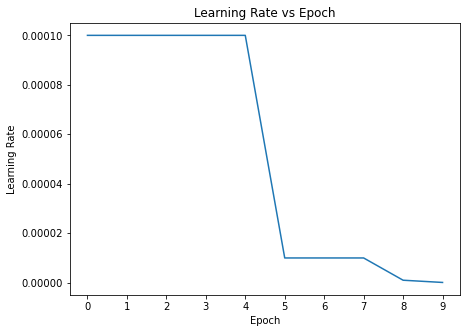

In [18]:
plot_learning_rate(history_dict)

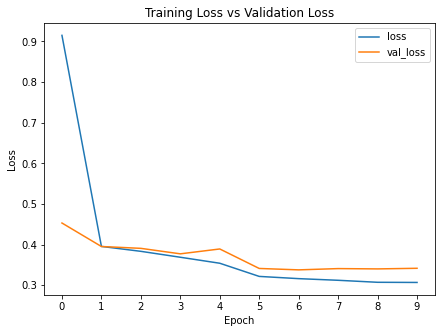

In [19]:
plot_metric(history_dict, 'loss')

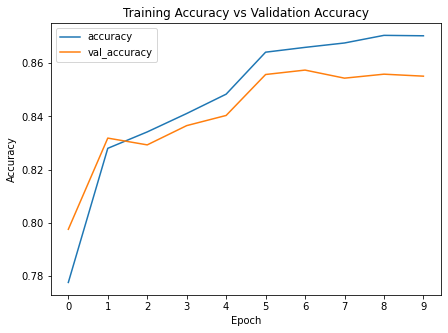

In [20]:
plot_metric(history_dict, 'accuracy')

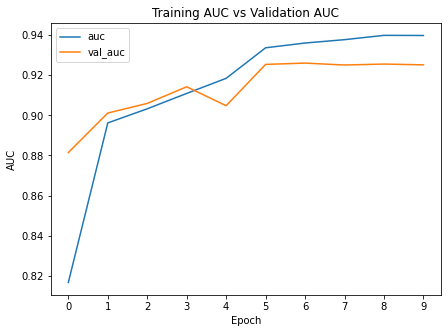

In [21]:
plot_metric(history_dict, 'auc')

---

## Calculate Performance on Test Set

In [22]:
test_metrics = model.evaluate(test_ds, verbose=1)
test_metrics = map_to_metrics(model.metrics_names, test_metrics)

  1/516 [..............................] - ETA: 38s - loss: 0.2742 - accuracy: 0.9375 - auc: 0.9471

 20/516 [>.............................] - ETA: 1s - loss: 0.3339 - accuracy: 0.8625 - auc: 0.9271 

 39/516 [=>............................] - ETA: 1s - loss: 0.3362 - accuracy: 0.8606 - auc: 0.9257

 58/516 [==>...........................] - ETA: 1s - loss: 0.3330 - accuracy: 0.8610 - auc: 0.9267

 77/516 [===>..........................] - ETA: 1s - loss: 0.3356 - accuracy: 0.8600 - auc: 0.9270

 96/516 [====>.........................] - ETA: 1s - loss: 0.3302 - accuracy: 0.8630 - auc: 0.9308

115/516 [=====>........................] - ETA: 1s - loss: 0.3376 - accuracy: 0.8584 - auc: 0.9270

134/516 [======>.......................] - ETA: 1s - loss: 0.3383 - accuracy: 0.8575 - auc: 0.9260

153/516 [=======>......................] - ETA: 0s - loss: 0.3394 - accuracy: 0.8589 - auc: 0.9254

172/516 [=========>....................] - ETA: 0s - loss: 0.3381 - accuracy: 0.8585 - auc: 0.9259

191/516 [==========>...................] - ETA: 0s - loss: 0.3360 - accuracy: 0.8595 - auc: 0.9265

210/516 [===========>..................] - ETA: 0s - loss: 0.3355 - accuracy: 0.8612 - auc: 0.9262

229/516 [============>.................] - ETA: 0s - loss: 0.3363 - accuracy: 0.8592 - auc: 0.9258

248/516 [=============>................] - ETA: 0s - loss: 0.3388 - accuracy: 0.8579 - auc: 0.9249

267/516 [==============>...............] - ETA: 0s - loss: 0.3399 - accuracy: 0.8557 - auc: 0.9243

286/516 [===============>..............] - ETA: 0s - loss: 0.3441 - accuracy: 0.8543 - auc: 0.9225

304/516 [================>.............] - ETA: 0s - loss: 0.3437 - accuracy: 0.8543 - auc: 0.9227

323/516 [=================>............] - ETA: 0s - loss: 0.3438 - accuracy: 0.8533 - auc: 0.9226

342/516 [==================>...........] - ETA: 0s - loss: 0.3435 - accuracy: 0.8537 - auc: 0.9231

361/516 [===================>..........] - ETA: 0s - loss: 0.3418 - accuracy: 0.8549 - auc: 0.9237

380/516 [=====================>........] - ETA: 0s - loss: 0.3404 - accuracy: 0.8558 - auc: 0.9241

399/516 [======================>.......] - ETA: 0s - loss: 0.3408 - accuracy: 0.8553 - auc: 0.9240

418/516 [=======================>......] - ETA: 0s - loss: 0.3389 - accuracy: 0.8558 - auc: 0.9248

437/516 [========================>.....] - ETA: 0s - loss: 0.3391 - accuracy: 0.8556 - auc: 0.9245

452/516 [=========================>....] - ETA: 0s - loss: 0.3387 - accuracy: 0.8560 - auc: 0.9246

470/516 [==========================>...] - ETA: 0s - loss: 0.3377 - accuracy: 0.8566 - auc: 0.9251

489/516 [===========================>..] - ETA: 0s - loss: 0.3372 - accuracy: 0.8568 - auc: 0.9256

508/516 [============================>.] - ETA: 0s - loss: 0.3377 - accuracy: 0.8564 - auc: 0.9255

516/516 [==============================] - 2s 3ms/step - loss: 0.3379 - accuracy: 0.8564 - auc: 0.9255


In [23]:
# Save test metrics
json.dump(test_metrics, open(f"{model_output_dir}/{MODEL_NAME}/test_metrics.json", 'w'))

---